In [314]:
import wandb
from data_loaders import make_train_data, make_test_val_data, make_model
from train_fed import train, test, precision, recall, f1_score
import torch
import time
import gc
import lstm
import config_file
from clean_data import load_all_houses_with_device
import random
import optuna
from data_loaders import PecanStreetDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lstm import LSTM
from clean_data import normalize_y
from sklearn import metrics
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D
import matplotlib.transforms

In [3]:
wandb.login()

print(torch.cuda.is_available())

gc.collect()
torch.cuda.empty_cache()

print(torch.__version__)


config_ = config_file.load_hyperparameters("refrigerator1")

wandb: Currently logged in as: nilm (use `wandb login --relogin` to force relogin)


True
1.7.1


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
homes = load_all_houses_with_device(config_file.path, config_['appliance'])

In [6]:
def client_update(client_model, optimizer, train_loader, epoch=config_['epochs']):
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = nn.MSELoss(output, target)
            loss.backward()
            optimizer.step()
    return float(loss.item())

In [7]:
def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [8]:
def model_pipeline(hyperparameters, train_months, test_month, appliance, window_length, train_buildings,
                   test_buildings, patience):
    with wandb.init(project="jan27_FL_trials", config=hyperparameters):
        wandb.run.name = str(config_['appliance'])+"_Test:"+str(test_buildings)+"_Train:" + str(train_buildings)

        config = wandb.config

        # lengths = [85320, 132480, 132480, 132480, 132480, 132480, 132480]

        global_model, criterion, optimizer = make_model(config)
        
        client_models = [lstm.LSTM(
            config.in_channels,
            config.out_channels,
            config.kernel_size,
            config.hidden_size_1,
            config.hidden_size_2,
            config.fc1
        ).to(device) for _ in range(len(train_buildings))]
        
        for model in client_models:
            model.load_state_dict(global_model.state_dict())
            
        optimizers = [torch.optim.AdamW(
            model.parameters(),
            lr = config.learning_rate,
            weight_decay = config.weight_decay
        ) for model in client_models]
        
        print(global_model)
        print("Window Length: ", window_length)
        
        wandb.watch(global_model, criterion, log="all", log_freq=10)

        validation_loader, test_loader, test_val_seq_min, test_val_seq_max  = make_test_val_data(
            config,
            test_month,
            appliance,
            window_length,
            test_buildings
        )
        
        test_results = []
        train_results = []
        example_ct = 0
        batch_ct = 0
        all_epochs = 0
        for r in range(20):
            client_losses = 0.0
            gc.collect()
            torch.cuda.empty_cache()
            for i in range(len(train_buildings)):
                #wandb.watch(client_models[i], criterion, log="all", log_freq=10)
                time_log = time.time()
                #scheduler = torch.optim.lr_scheduler.StepLR(optimizers[i], step_size=50, gamma=0.9, verbose=True)
                scheduler = torch.optim.lr_scheduler.CyclicLR(
                    optimizers[i],
                    base_lr = 0.1*config_['learning_rate'],
                    max_lr = 5*config_['learning_rate'],
                    step_size_up = 50,
                    step_size_down = 6000,
                    gamma = 1,
                    cycle_momentum=False,
                    verbose=False
                )
                
                train_loader, train_seq_min, train_seq_max = make_train_data(
                    config,
                    train_months,
                    appliance,
                    window_length,
                    [train_buildings[i]]
                )
                
                #loss += client_update(client_models[i], optimizer[i], train_loader, epochs = config.epochs)
                example_ct, batch_ct, all_epochs, _, client_train_loss = train(
                    client_models[i].to(device),
                    train_loader,
                    validation_loader,
                    criterion,
                    optimizers[i],
                    config,
                    example_ct,
                    batch_ct,
                    all_epochs,
                    scheduler,
                    test_val_seq_min,
                    test_val_seq_max,
                    train_seq_min,
                    train_seq_max,
                    patience
                )
                
                client_losses += client_train_loss
                
                print("Time to train on one home: ", time.time() - time_log)
            
            client_losses = client_losses/len(train_buildings)
            server_aggregate(global_model, client_models)
            test_results.append(test(global_model, test_loader, criterion, test_val_seq_min, test_val_seq_max))
            train_results.append(client_losses)
            
            print("train_results: ", train_results)
            print("test_results: ", test_results)
            print("Round_"+str(r)+"_results: ", test(global_model, test_loader, criterion, test_val_seq_min, test_val_seq_max))

    return train_results, test_results, global_model

In [9]:
home_ids = homes.dataid.unique()

In [10]:
home_ids

array([  142,   183,   335,   387,   526,   690,  1417,  2126,  2358,
        2561,  3383,  3488,  3700,  3976,  3996,  5058,  6178,  6240,
        6526,  6672,  7021,  7069,  7365,  8825,  9004,  9053,  9290,
        9973, 10164, 10182, 10811, 10983, 11878], dtype=int64)

In [11]:
len(home_ids)

33

In [12]:
random_select = [5,10,15,20,25,30,33]

In [28]:
final_results = {}
random.seed(3)
global_models = []

for i in random_select:
    gc.collect()
    torch.cuda.empty_cache()
    #train_homes = home_ids
    train_homes = random.sample(list(home_ids), k=i)
    test_homes = [random.choice(train_homes)]
    #train_homes = [10811, 5058, 6672, 10182]
    #test_homes = [6672]
    
    patience = 25
    print("patience: ", patience)
    print("training_home: ", train_homes)
    print("test_home: ", test_homes)
    train_results, test_results, global_model = model_pipeline(
    config_,
    'sept_oct_nov',
    'dec',
    config_['appliance'],
    config_['window_size'],
    train_homes,
    test_homes,
    patience)
    global_models.append(global_model)
    result = {"Train_home_"+str(train_homes)+"_Test_home_"+str(test_homes): test_results}
    final_results.update(result)
    print(final_results)
    #torch.save(model.state_dict(), r"C:\Users\aar245\Desktop\FL_models")

patience:  25
training_home:  [5058, 2358, 8825, 10811, 526]
test_home:  [526]


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
trigger times: 0
Loss after 00963 batches: 0.1710
trigger times: 0
Loss after 01926 batches: 0.1488
trigger times: 0
Loss after 02889 batches: 0.1082
trigger times: 1
Loss after 03852 batches: 0.1011
trigger times: 2
Loss after 04815 batches: 0.0990
trigger times: 3
Loss after 05778 batches: 0.0966
trigger times: 4
Loss after 06741 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 54751 batches: 0.1234
trigger times: 0
Loss after 55714 batches: 0.1094
trigger times: 0
Loss after 56677 batches: 0.0906
trigger times: 1
Loss after 57640 batches: 0.0866
trigger times: 2
Loss after 58603 batches: 0.0871
trigger times: 3
Loss after 59566 batches: 0.0857
trigger times: 4
Loss after 60529 batches: 0.0857
trigger times: 5
Loss after 61492 batches: 0.0858
trigger times: 6
Loss after 62455 batches: 0.0856
trigger times: 7
Loss after 63418 batches: 0.0854
trigger times: 8
Loss after 64381 batches: 0.0856
trigger times: 9
Loss after 65344 batches: 0.0858
trigger times: 10
Loss after 66307 batches: 0.0858
trigger times: 11
Loss after 67270 batches: 0.0851
trigger times: 12
Loss after 68233 batches: 0.0857
trigger times: 13
Loss after 69196 batches: 0.0855
trigger times: 14
Loss after 70159 batches: 0.0858
trigger times: 15
Loss after 71122 batches: 0.0860
trigger times: 16
Loss after 72085 batches: 0.0863
trigger times: 17
Loss after 73048 batches:

wandb: WARNING Step must only increase in log calls.  Step 162 < 163; dropping {'Training_Loss': 0.0954663987670626, 'Validation_Loss': 0.13193514943122864, 'Training_R2': -0.2744854069669045, 'Validation_R2': -1.1980506489165306, 'Training_F1': 0.10971232396443542, 'Validation_F1': 0.2085301529980552, 'Training_NEP': 0.9994683363640656, 'Validation_NEP': 0.8901654933384746, 'Training_NDE': 0.9386004239548323, 'Validation_NDE': 0.8557942368040599, 'Training_MAE': 28.779861152867493, 'Validation_MAE': 78.381786921103, 'Training_MSE': 2953.006, 'Validation_MSE': 10865.767}.


trigger times: 0
Loss after 152534 batches: 0.0955
trigger times: 0
Loss after 153497 batches: 0.0938
trigger times: 1
Loss after 154460 batches: 0.0925
trigger times: 2
Loss after 155423 batches: 0.0891
trigger times: 3
Loss after 156386 batches: 0.0822
trigger times: 4
Loss after 157349 batches: 0.0782
trigger times: 5
Loss after 158312 batches: 0.0762
trigger times: 6
Loss after 159275 batches: 0.0723
trigger times: 0
Loss after 160238 batches: 0.0700
trigger times: 1
Loss after 161201 batches: 0.0646
trigger times: 2
Loss after 162164 batches: 0.0619
trigger times: 3
Loss after 163127 batches: 0.0588
trigger times: 4
Loss after 164090 batches: 0.0577
trigger times: 5
Loss after 165053 batches: 0.0564
trigger times: 6
Loss after 166016 batches: 0.0560
trigger times: 7
Loss after 166979 batches: 0.0536
trigger times: 0
Loss after 167942 batches: 0.0534
trigger times: 1
Loss after 168905 batches: 0.0542
trigger times: 2
Loss after 169868 batches: 0.0520
trigger times: 3
Loss after 170

trigger times: 18
Loss after 305181 batches: 0.0223
trigger times: 19
Loss after 306139 batches: 0.0217
trigger times: 20
Loss after 307097 batches: 0.0223
trigger times: 21
Loss after 308055 batches: 0.0229
trigger times: 22
Loss after 309013 batches: 0.0216
trigger times: 23
Loss after 309971 batches: 0.0225
trigger times: 24
Loss after 310929 batches: 0.0229
trigger times: 25
Early stopping!
Start to test process.
Loss after 311887 batches: 0.0218
Time to train on one home:  185.1980483531952


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 312850 batches: 0.0861
trigger times: 1
Loss after 313813 batches: 0.0849
trigger times: 2
Loss after 314776 batches: 0.0814
trigger times: 3
Loss after 315739 batches: 0.0801
trigger times: 0
Loss after 316702 batches: 0.0804
trigger times: 0
Loss after 317665 batches: 0.0793
trigger times: 1
Loss after 318628 batches: 0.0792
trigger times: 2
Loss after 319591 batches: 0.0803
trigger times: 3
Loss after 320554 batches: 0.0801
trigger times: 4
Loss after 321517 batches: 0.0789
trigger times: 5
Loss after 322480 batches: 0.0783
trigger times: 0
Loss after 323443 batches: 0.0780
trigger times: 0
Loss after 324406 batches: 0.0779
trigger times: 1
Loss after 325369 batches: 0.0774
trigger times: 2
Loss after 326332 batches: 0.0764
trigger times: 3
Loss after 327295 batches: 0.0761
trigger times: 4
Loss after 328258 batches: 0.0754
trigger times: 0
Loss after 329221 batches: 0.0745
trigger times: 1
Loss after 330184 batches: 0.0726
trigger times: 2
Loss after 331

trigger times: 3
Loss after 462137 batches: 0.0429
trigger times: 4
Loss after 463100 batches: 0.0426
trigger times: 0
Loss after 464063 batches: 0.0431
trigger times: 1
Loss after 465026 batches: 0.0425
trigger times: 0
Loss after 465989 batches: 0.0429
trigger times: 1
Loss after 466952 batches: 0.0427
trigger times: 2
Loss after 467915 batches: 0.0428
trigger times: 3
Loss after 468878 batches: 0.0423
trigger times: 4
Loss after 469841 batches: 0.0424
trigger times: 5
Loss after 470804 batches: 0.0423
trigger times: 6
Loss after 471767 batches: 0.0419
trigger times: 7
Loss after 472730 batches: 0.0423
trigger times: 8
Loss after 473693 batches: 0.0420
trigger times: 9
Loss after 474656 batches: 0.0418
trigger times: 10
Loss after 475619 batches: 0.0415
trigger times: 0
Loss after 476582 batches: 0.0413
trigger times: 1
Loss after 477545 batches: 0.0424
trigger times: 2
Loss after 478508 batches: 0.0420
trigger times: 3
Loss after 479471 batches: 0.0417
trigger times: 4
Loss after 48

wandb: WARNING Step must only increase in log calls.  Step 532 < 533; dropping {'Training_Loss': 0.10061558016708919, 'Validation_Loss': 0.10031042248010635, 'Training_R2': -0.1716127589264651, 'Validation_R2': -0.9558087057082507, 'Training_F1': 0.1924254445290294, 'Validation_F1': 0.2924000513409511, 'Training_NEP': 1.0469823522481583, 'Validation_NEP': 0.8473408379221407, 'Training_NDE': 0.8628394094226466, 'Validation_NDE': 0.7614791925403754, 'Training_MAE': 30.14803534129043, 'Validation_MAE': 74.61094538553202, 'Training_MSE': 2714.6484, 'Validation_MSE': 9668.276}.


trigger times: 0
Loss after 506435 batches: 0.1006
trigger times: 1
Loss after 507398 batches: 0.0906
trigger times: 2
Loss after 508361 batches: 0.0833
trigger times: 0
Loss after 509324 batches: 0.0718
trigger times: 1
Loss after 510287 batches: 0.0673
trigger times: 2
Loss after 511250 batches: 0.0610
trigger times: 3
Loss after 512213 batches: 0.0579
trigger times: 4
Loss after 513176 batches: 0.0564
trigger times: 5
Loss after 514139 batches: 0.0539
trigger times: 6
Loss after 515102 batches: 0.0535
trigger times: 7
Loss after 516065 batches: 0.0515
trigger times: 8
Loss after 517028 batches: 0.0505
trigger times: 9
Loss after 517991 batches: 0.0496
trigger times: 10
Loss after 518954 batches: 0.0504
trigger times: 11
Loss after 519917 batches: 0.0488
trigger times: 0
Loss after 520880 batches: 0.0486
trigger times: 1
Loss after 521843 batches: 0.0485
trigger times: 2
Loss after 522806 batches: 0.0465
trigger times: 3
Loss after 523769 batches: 0.0463
trigger times: 4
Loss after 5

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 637203 batches: 0.1040
trigger times: 1
Loss after 638166 batches: 0.0835
trigger times: 2
Loss after 639129 batches: 0.0839
trigger times: 3
Loss after 640092 batches: 0.0837
trigger times: 4
Loss after 641055 batches: 0.0828
trigger times: 5
Loss after 642018 batches: 0.0811
trigger times: 6
Loss after 642981 batches: 0.0800
trigger times: 7
Loss after 643944 batches: 0.0799
trigger times: 8
Loss after 644907 batches: 0.0796
trigger times: 9
Loss after 645870 batches: 0.0795
trigger times: 10
Loss after 646833 batches: 0.0788
trigger times: 11
Loss after 647796 batches: 0.0781
trigger times: 12
Loss after 648759 batches: 0.0772
trigger times: 13
Loss after 649722 batches: 0.0771
trigger times: 14
Loss after 650685 batches: 0.0759
trigger times: 15
Loss after 651648 batches: 0.0747
trigger times: 16
Loss after 652611 batches: 0.0743
trigger times: 17
Loss after 653574 batches: 0.0729
trigger times: 18
Loss after 654537 batches: 0.0704
trigger times: 0
Loss 

trigger times: 22
Loss after 787249 batches: 0.0040
trigger times: 23
Loss after 788144 batches: 0.0042
trigger times: 24
Loss after 789039 batches: 0.0038
trigger times: 25
Early stopping!
Start to test process.
Loss after 789934 batches: 0.0039
Time to train on one home:  85.25479435920715
trigger times: 0
Loss after 790897 batches: 0.1304
trigger times: 0
Loss after 791860 batches: 0.0634
trigger times: 1
Loss after 792823 batches: 0.0523
trigger times: 2
Loss after 793786 batches: 0.0525
trigger times: 3
Loss after 794749 batches: 0.0512
trigger times: 4
Loss after 795712 batches: 0.0500
trigger times: 5
Loss after 796675 batches: 0.0489
trigger times: 6
Loss after 797638 batches: 0.0478
trigger times: 7
Loss after 798601 batches: 0.0469
trigger times: 8
Loss after 799564 batches: 0.0468
trigger times: 9
Loss after 800527 batches: 0.0456
trigger times: 10
Loss after 801490 batches: 0.0448
trigger times: 11
Loss after 802453 batches: 0.0441
trigger times: 12
Loss after 803416 batche

wandb: WARNING Step must only increase in log calls.  Step 886 < 887; dropping {'Training_Loss': 0.08656539342233113, 'Validation_Loss': 0.16262361407279968, 'Training_R2': -0.05083071718244625, 'Validation_R2': -1.0217725857238333, 'Training_F1': 0.24990759798672657, 'Validation_F1': 0.24503048127957003, 'Training_NEP': 1.0411826761198872, 'Validation_NEP': 0.8764823627666265, 'Training_NDE': 0.773888935487487, 'Validation_NDE': 0.787161718356545, 'Training_MAE': 29.981032678344196, 'Validation_MAE': 77.17694553720045, 'Training_MSE': 2434.7942, 'Validation_MSE': 9994.359}.


trigger times: 0
Loss after 844825 batches: 0.0866
trigger times: 0
Loss after 845788 batches: 0.0694
trigger times: 1
Loss after 846751 batches: 0.0625
trigger times: 2
Loss after 847714 batches: 0.0555
trigger times: 3
Loss after 848677 batches: 0.0523
trigger times: 4
Loss after 849640 batches: 0.0503
trigger times: 0
Loss after 850603 batches: 0.0485
trigger times: 0
Loss after 851566 batches: 0.0462
trigger times: 1
Loss after 852529 batches: 0.0464
trigger times: 2
Loss after 853492 batches: 0.0455
trigger times: 3
Loss after 854455 batches: 0.0433
trigger times: 4
Loss after 855418 batches: 0.0429
trigger times: 5
Loss after 856381 batches: 0.0423
trigger times: 6
Loss after 857344 batches: 0.0430
trigger times: 7
Loss after 858307 batches: 0.0409
trigger times: 8
Loss after 859270 batches: 0.0412
trigger times: 9
Loss after 860233 batches: 0.0408
trigger times: 10
Loss after 861196 batches: 0.0398
trigger times: 11
Loss after 862159 batches: 0.0396
trigger times: 12
Loss after 

trigger times: 25
Early stopping!
Start to test process.
Loss after 998905 batches: 0.0252
Time to train on one home:  273.9125130176544
trigger times: 0
Loss after 999863 batches: 0.1036
trigger times: 0
Loss after 1000821 batches: 0.0515
trigger times: 1
Loss after 1001779 batches: 0.0436
trigger times: 2
Loss after 1002737 batches: 0.0368
trigger times: 0
Loss after 1003695 batches: 0.0346
trigger times: 1
Loss after 1004653 batches: 0.0404
trigger times: 2
Loss after 1005611 batches: 0.0363
trigger times: 3
Loss after 1006569 batches: 0.0353
trigger times: 4
Loss after 1007527 batches: 0.0325
trigger times: 5
Loss after 1008485 batches: 0.0311
trigger times: 6
Loss after 1009443 batches: 0.0306
trigger times: 7
Loss after 1010401 batches: 0.0297
trigger times: 8
Loss after 1011359 batches: 0.0285
trigger times: 9
Loss after 1012317 batches: 0.0272
trigger times: 10
Loss after 1013275 batches: 0.0284
trigger times: 11
Loss after 1014233 batches: 0.0273
trigger times: 12
Loss after 1

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1028608 batches: 0.1183
trigger times: 1
Loss after 1029571 batches: 0.0939
trigger times: 2
Loss after 1030534 batches: 0.0867
trigger times: 3
Loss after 1031497 batches: 0.0837
trigger times: 4
Loss after 1032460 batches: 0.0823
trigger times: 5
Loss after 1033423 batches: 0.0818
trigger times: 6
Loss after 1034386 batches: 0.0805
trigger times: 7
Loss after 1035349 batches: 0.0790
trigger times: 8
Loss after 1036312 batches: 0.0775
trigger times: 9
Loss after 1037275 batches: 0.0764
trigger times: 10
Loss after 1038238 batches: 0.0746
trigger times: 11
Loss after 1039201 batches: 0.0733
trigger times: 12
Loss after 1040164 batches: 0.0704
trigger times: 13
Loss after 1041127 batches: 0.0669
trigger times: 14
Loss after 1042090 batches: 0.0615
trigger times: 15
Loss after 1043053 batches: 0.0583
trigger times: 16
Loss after 1044016 batches: 0.0537
trigger times: 17
Loss after 1044979 batches: 0.0517
trigger times: 0
Loss after 1045942 batches: 0.0490
trig

Round_3_results:  [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333]


wandb: WARNING Step must only increase in log calls.  Step 1223 < 1224; dropping {'Training_Loss': 0.07071524006979805, 'Validation_Loss': 0.16512152552604675, 'Training_R2': -0.061264256067041334, 'Validation_R2': -0.9695257153606505, 'Training_F1': 0.2504886226912236, 'Validation_F1': 0.2628249525912795, 'Training_NEP': 0.9452780636114647, 'Validation_NEP': 0.8638019838754185, 'Training_NDE': 0.7815727617953548, 'Validation_NDE': 0.7668198020044744, 'Training_MAE': 27.21944300962801, 'Validation_MAE': 76.0603994974276, 'Training_MSE': 2458.9688, 'Validation_MSE': 9736.085}.


trigger times: 0
Loss after 1167370 batches: 0.0707
trigger times: 0
Loss after 1168333 batches: 0.0566
trigger times: 1
Loss after 1169296 batches: 0.0527
trigger times: 2
Loss after 1170259 batches: 0.0474
trigger times: 3
Loss after 1171222 batches: 0.0450
trigger times: 4
Loss after 1172185 batches: 0.0431
trigger times: 5
Loss after 1173148 batches: 0.0415
trigger times: 6
Loss after 1174111 batches: 0.0399
trigger times: 7
Loss after 1175074 batches: 0.0396
trigger times: 8
Loss after 1176037 batches: 0.0400
trigger times: 9
Loss after 1177000 batches: 0.0391
trigger times: 10
Loss after 1177963 batches: 0.0369
trigger times: 11
Loss after 1178926 batches: 0.0370
trigger times: 12
Loss after 1179889 batches: 0.0363
trigger times: 13
Loss after 1180852 batches: 0.0355
trigger times: 14
Loss after 1181815 batches: 0.0361
trigger times: 15
Loss after 1182778 batches: 0.0396
trigger times: 16
Loss after 1183741 batches: 0.0396
trigger times: 17
Loss after 1184704 batches: 0.0386
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1224027 batches: 0.1119
trigger times: 1
Loss after 1224990 batches: 0.0900
trigger times: 2
Loss after 1225953 batches: 0.0848
trigger times: 3
Loss after 1226916 batches: 0.0813
trigger times: 4
Loss after 1227879 batches: 0.0774
trigger times: 5
Loss after 1228842 batches: 0.0730
trigger times: 6
Loss after 1229805 batches: 0.0645
trigger times: 7
Loss after 1230768 batches: 0.0576
trigger times: 8
Loss after 1231731 batches: 0.0532
trigger times: 0
Loss after 1232694 batches: 0.0488
trigger times: 1
Loss after 1233657 batches: 0.0462
trigger times: 0
Loss after 1234620 batches: 0.0440
trigger times: 1
Loss after 1235583 batches: 0.0424
trigger times: 0
Loss after 1236546 batches: 0.0416
trigger times: 0
Loss after 1237509 batches: 0.0400
trigger times: 1
Loss after 1238472 batches: 0.0390
trigger times: 2
Loss after 1239435 batches: 0.0378
trigger times: 0
Loss after 1240398 batches: 0.0373
trigger times: 1
Loss after 1241361 batches: 0.0359
trigger time

trigger times: 0
Loss after 1370493 batches: 0.0513
trigger times: 0
Loss after 1371456 batches: 0.0488
trigger times: 0
Loss after 1372419 batches: 0.0476
trigger times: 1
Loss after 1373382 batches: 0.0468
trigger times: 0
Loss after 1374345 batches: 0.0467
trigger times: 0
Loss after 1375308 batches: 0.0458
trigger times: 0
Loss after 1376271 batches: 0.0454
trigger times: 0
Loss after 1377234 batches: 0.0444
trigger times: 0
Loss after 1378197 batches: 0.0433
trigger times: 1
Loss after 1379160 batches: 0.0429
trigger times: 0
Loss after 1380123 batches: 0.0426
trigger times: 0
Loss after 1381086 batches: 0.0432
trigger times: 1
Loss after 1382049 batches: 0.0441
trigger times: 2
Loss after 1383012 batches: 0.0427
trigger times: 3
Loss after 1383975 batches: 0.0424
trigger times: 4
Loss after 1384938 batches: 0.0424
trigger times: 5
Loss after 1385901 batches: 0.0412
trigger times: 6
Loss after 1386864 batches: 0.0405
trigger times: 7
Loss after 1387827 batches: 0.0407
trigger time

wandb: WARNING Step must only increase in log calls.  Step 1518 < 1519; dropping {'Training_Loss': 0.06209371877568109, 'Validation_Loss': 0.10533098131418228, 'Training_R2': 0.026608133744403517, 'Validation_R2': -0.8094471313406364, 'Training_F1': 0.30877600407840355, 'Validation_F1': 0.33503941830696976, 'Training_NEP': 0.9367158576711021, 'Validation_NEP': 0.8177572473404481, 'Training_NDE': 0.7168587509789396, 'Validation_NDE': 0.7044944293826404, 'Training_MAE': 26.972892829737035, 'Validation_MAE': 72.00601999728889, 'Training_MSE': 2255.3667, 'Validation_MSE': 8944.758}.


trigger times: 0
Loss after 1449459 batches: 0.0621
trigger times: 1
Loss after 1450422 batches: 0.0549
trigger times: 2
Loss after 1451385 batches: 0.0486
trigger times: 3
Loss after 1452348 batches: 0.0438
trigger times: 4
Loss after 1453311 batches: 0.0414
trigger times: 5
Loss after 1454274 batches: 0.0386
trigger times: 6
Loss after 1455237 batches: 0.0378
trigger times: 7
Loss after 1456200 batches: 0.0370
trigger times: 8
Loss after 1457163 batches: 0.0368
trigger times: 9
Loss after 1458126 batches: 0.0358
trigger times: 0
Loss after 1459089 batches: 0.0355
trigger times: 1
Loss after 1460052 batches: 0.0355
trigger times: 2
Loss after 1461015 batches: 0.0341
trigger times: 3
Loss after 1461978 batches: 0.0338
trigger times: 4
Loss after 1462941 batches: 0.0333
trigger times: 5
Loss after 1463904 batches: 0.0330
trigger times: 0
Loss after 1464867 batches: 0.0340
trigger times: 1
Loss after 1465830 batches: 0.0328
trigger times: 2
Loss after 1466793 batches: 0.0330
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1531184 batches: 0.1068
trigger times: 1
Loss after 1532147 batches: 0.0850
trigger times: 2
Loss after 1533110 batches: 0.0804
trigger times: 3
Loss after 1534073 batches: 0.0753
trigger times: 4
Loss after 1535036 batches: 0.0638
trigger times: 5
Loss after 1535999 batches: 0.0572
trigger times: 6
Loss after 1536962 batches: 0.0520
trigger times: 7
Loss after 1537925 batches: 0.0472
trigger times: 8
Loss after 1538888 batches: 0.0451
trigger times: 9
Loss after 1539851 batches: 0.0410
trigger times: 10
Loss after 1540814 batches: 0.0398
trigger times: 11
Loss after 1541777 batches: 0.0388
trigger times: 12
Loss after 1542740 batches: 0.0384
trigger times: 13
Loss after 1543703 batches: 0.0358
trigger times: 14
Loss after 1544666 batches: 0.0346
trigger times: 15
Loss after 1545629 batches: 0.0341
trigger times: 16
Loss after 1546592 batches: 0.0331
trigger times: 17
Loss after 1547555 batches: 0.0322
trigger times: 18
Loss after 1548518 batches: 0.0320
tri

wandb: WARNING Step must only increase in log calls.  Step 1718 < 1719; dropping {'Training_Loss': 0.062338562948363166, 'Validation_Loss': 0.15271742641925812, 'Training_R2': -0.05473950141935724, 'Validation_R2': -0.9586766003565774, 'Training_F1': 0.2549956023913956, 'Validation_F1': 0.2665867271256039, 'Training_NEP': 0.9291796702931008, 'Validation_NEP': 0.8606455967209293, 'Training_NDE': 0.7767675792563967, 'Validation_NDE': 0.762595785844187, 'Training_MAE': 26.755887029283276, 'Validation_MAE': 75.78246998068592, 'Training_MSE': 2443.851, 'Validation_MSE': 9682.453}.


trigger times: 0
Loss after 1640161 batches: 0.0623
trigger times: 0
Loss after 1641124 batches: 0.0492
trigger times: 1
Loss after 1642087 batches: 0.0441
trigger times: 2
Loss after 1643050 batches: 0.0413
trigger times: 3
Loss after 1644013 batches: 0.0385
trigger times: 4
Loss after 1644976 batches: 0.0371
trigger times: 5
Loss after 1645939 batches: 0.0349
trigger times: 6
Loss after 1646902 batches: 0.0343
trigger times: 7
Loss after 1647865 batches: 0.0352
trigger times: 8
Loss after 1648828 batches: 0.0333
trigger times: 9
Loss after 1649791 batches: 0.0329
trigger times: 10
Loss after 1650754 batches: 0.0331
trigger times: 11
Loss after 1651717 batches: 0.0325
trigger times: 12
Loss after 1652680 batches: 0.0335
trigger times: 13
Loss after 1653643 batches: 0.0311
trigger times: 14
Loss after 1654606 batches: 0.0315
trigger times: 15
Loss after 1655569 batches: 0.0310
trigger times: 16
Loss after 1656532 batches: 0.0311
trigger times: 17
Loss after 1657495 batches: 0.0307
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1693944 batches: 0.1020
trigger times: 1
Loss after 1694907 batches: 0.0827
trigger times: 2
Loss after 1695870 batches: 0.0803
trigger times: 0
Loss after 1696833 batches: 0.0716
trigger times: 1
Loss after 1697796 batches: 0.0606
trigger times: 0
Loss after 1698759 batches: 0.0522
trigger times: 0
Loss after 1699722 batches: 0.0458
trigger times: 0
Loss after 1700685 batches: 0.0422
trigger times: 0
Loss after 1701648 batches: 0.0392
trigger times: 1
Loss after 1702611 batches: 0.0369
trigger times: 2
Loss after 1703574 batches: 0.0359
trigger times: 3
Loss after 1704537 batches: 0.0347
trigger times: 4
Loss after 1705500 batches: 0.0329
trigger times: 5
Loss after 1706463 batches: 0.0322
trigger times: 6
Loss after 1707426 batches: 0.0304
trigger times: 0
Loss after 1708389 batches: 0.0307
trigger times: 1
Loss after 1709352 batches: 0.0308
trigger times: 2
Loss after 1710315 batches: 0.0304
trigger times: 3
Loss after 1711278 batches: 0.0290
trigger time

wandb: WARNING Step must only increase in log calls.  Step 1884 < 1885; dropping {'Training_Loss': 0.06179376265832356, 'Validation_Loss': 0.10642659664154053, 'Training_R2': 0.1146416569429678, 'Validation_R2': -0.7422239435200748, 'Training_F1': 0.36732945368043735, 'Validation_F1': 0.3594007499042198, 'Training_NEP': 0.9094045200426617, 'Validation_NEP': 0.801310421875569, 'Training_NDE': 0.6520260726926252, 'Validation_NDE': 0.6783215905779729, 'Training_MAE': 26.186458206200058, 'Validation_MAE': 70.55782684807798, 'Training_MSE': 2051.3916, 'Validation_MSE': 8612.448}.


trigger times: 0
Loss after 1798038 batches: 0.0618
trigger times: 1
Loss after 1799001 batches: 0.0522
trigger times: 0
Loss after 1799964 batches: 0.0457
trigger times: 1
Loss after 1800927 batches: 0.0396
trigger times: 2
Loss after 1801890 batches: 0.0375
trigger times: 3
Loss after 1802853 batches: 0.0363
trigger times: 4
Loss after 1803816 batches: 0.0350
trigger times: 5
Loss after 1804779 batches: 0.0341
trigger times: 6
Loss after 1805742 batches: 0.0330
trigger times: 7
Loss after 1806705 batches: 0.0333
trigger times: 8
Loss after 1807668 batches: 0.0317
trigger times: 9
Loss after 1808631 batches: 0.0330
trigger times: 10
Loss after 1809594 batches: 0.0332
trigger times: 11
Loss after 1810557 batches: 0.0323
trigger times: 12
Loss after 1811520 batches: 0.0317
trigger times: 13
Loss after 1812483 batches: 0.0309
trigger times: 14
Loss after 1813446 batches: 0.0300
trigger times: 15
Loss after 1814409 batches: 0.0300
trigger times: 0
Loss after 1815372 batches: 0.0290
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1903838 batches: 0.1146
trigger times: 1
Loss after 1904801 batches: 0.0875
trigger times: 2
Loss after 1905764 batches: 0.0810
trigger times: 3
Loss after 1906727 batches: 0.0709
trigger times: 4
Loss after 1907690 batches: 0.0587
trigger times: 5
Loss after 1908653 batches: 0.0509
trigger times: 6
Loss after 1909616 batches: 0.0444
trigger times: 7
Loss after 1910579 batches: 0.0413
trigger times: 8
Loss after 1911542 batches: 0.0390
trigger times: 9
Loss after 1912505 batches: 0.0365
trigger times: 10
Loss after 1913468 batches: 0.0331
trigger times: 11
Loss after 1914431 batches: 0.0329
trigger times: 12
Loss after 1915394 batches: 0.0343
trigger times: 13
Loss after 1916357 batches: 0.0331
trigger times: 14
Loss after 1917320 batches: 0.0320
trigger times: 15
Loss after 1918283 batches: 0.0281
trigger times: 16
Loss after 1919246 batches: 0.0290
trigger times: 17
Loss after 1920209 batches: 0.0275
trigger times: 18
Loss after 1921172 batches: 0.0279
tri

wandb: WARNING Step must only increase in log calls.  Step 2089 < 2090; dropping {'Training_Loss': 0.062059379049709866, 'Validation_Loss': 0.13926826417446136, 'Training_R2': -0.04019357510918509, 'Validation_R2': -0.8277286508734452, 'Training_F1': 0.26497438067429363, 'Validation_F1': 0.32015912002124225, 'Training_NEP': 0.9242935742345763, 'Validation_NEP': 0.8252912476100465, 'Training_NDE': 0.7660551670377274, 'Validation_NDE': 0.711612199017496, 'Training_MAE': 26.615191060208886, 'Validation_MAE': 72.66941170165666, 'Training_MSE': 2410.1477, 'Validation_MSE': 9035.129}.


trigger times: 0
Loss after 1993555 batches: 0.0621
trigger times: 0
Loss after 1994518 batches: 0.0509
trigger times: 1
Loss after 1995481 batches: 0.0438
trigger times: 2
Loss after 1996444 batches: 0.0402
trigger times: 3
Loss after 1997407 batches: 0.0375
trigger times: 4
Loss after 1998370 batches: 0.0355
trigger times: 5
Loss after 1999333 batches: 0.0350
trigger times: 6
Loss after 2000296 batches: 0.0329
trigger times: 7
Loss after 2001259 batches: 0.0306
trigger times: 8
Loss after 2002222 batches: 0.0304
trigger times: 9
Loss after 2003185 batches: 0.0296
trigger times: 10
Loss after 2004148 batches: 0.0288
trigger times: 11
Loss after 2005111 batches: 0.0293
trigger times: 12
Loss after 2006074 batches: 0.0296
trigger times: 13
Loss after 2007037 batches: 0.0288
trigger times: 14
Loss after 2008000 batches: 0.0295
trigger times: 15
Loss after 2008963 batches: 0.0287
trigger times: 16
Loss after 2009926 batches: 0.0285
trigger times: 17
Loss after 2010889 batches: 0.0282
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2045422 batches: 0.0992
trigger times: 1
Loss after 2046385 batches: 0.0812
trigger times: 2
Loss after 2047348 batches: 0.0752
trigger times: 0
Loss after 2048311 batches: 0.0665
trigger times: 1
Loss after 2049274 batches: 0.0570
trigger times: 2
Loss after 2050237 batches: 0.0500
trigger times: 0
Loss after 2051200 batches: 0.0438
trigger times: 1
Loss after 2052163 batches: 0.0386
trigger times: 0
Loss after 2053126 batches: 0.0350
trigger times: 1
Loss after 2054089 batches: 0.0339
trigger times: 2
Loss after 2055052 batches: 0.0322
trigger times: 0
Loss after 2056015 batches: 0.0309
trigger times: 1
Loss after 2056978 batches: 0.0286
trigger times: 2
Loss after 2057941 batches: 0.0276
trigger times: 3
Loss after 2058904 batches: 0.0288
trigger times: 4
Loss after 2059867 batches: 0.0287
trigger times: 5
Loss after 2060830 batches: 0.0275
trigger times: 0
Loss after 2061793 batches: 0.0263
trigger times: 1
Loss after 2062756 batches: 0.0259
trigger time

trigger times: 14
Loss after 2191888 batches: 0.0314
trigger times: 15
Loss after 2192851 batches: 0.0308
trigger times: 16
Loss after 2193814 batches: 0.0310
trigger times: 17
Loss after 2194777 batches: 0.0302
trigger times: 18
Loss after 2195740 batches: 0.0300
trigger times: 19
Loss after 2196703 batches: 0.0304
trigger times: 20
Loss after 2197666 batches: 0.0311
trigger times: 0
Loss after 2198629 batches: 0.0306
trigger times: 1
Loss after 2199592 batches: 0.0303
trigger times: 2
Loss after 2200555 batches: 0.0305
trigger times: 3
Loss after 2201518 batches: 0.0295
trigger times: 4
Loss after 2202481 batches: 0.0306
trigger times: 5
Loss after 2203444 batches: 0.0300
trigger times: 6
Loss after 2204407 batches: 0.0298
trigger times: 7
Loss after 2205370 batches: 0.0307
trigger times: 8
Loss after 2206333 batches: 0.0294
trigger times: 9
Loss after 2207296 batches: 0.0297
trigger times: 10
Loss after 2208259 batches: 0.0297
trigger times: 11
Loss after 2209222 batches: 0.0299
tri

wandb: WARNING Step must only increase in log calls.  Step 2330 < 2331; dropping {'Training_Loss': 0.053997285664081573, 'Validation_Loss': 0.10684829205274582, 'Training_R2': 0.1650222959257266, 'Validation_R2': -0.7277333524683267, 'Training_F1': 0.40480672624891184, 'Validation_F1': 0.3652872353212225, 'Training_NEP': 0.8531141715890964, 'Validation_NEP': 0.7954788422314727, 'Training_NDE': 0.6149230283577394, 'Validation_NDE': 0.6726797826998077, 'Training_MAE': 24.565568025092784, 'Validation_MAE': 70.04433847260441, 'Training_MSE': 1934.6587, 'Validation_MSE': 8540.816}.


trigger times: 0
Loss after 2223667 batches: 0.0540
trigger times: 1
Loss after 2224630 batches: 0.0460
trigger times: 2
Loss after 2225593 batches: 0.0398
trigger times: 3
Loss after 2226556 batches: 0.0364
trigger times: 4
Loss after 2227519 batches: 0.0341
trigger times: 5
Loss after 2228482 batches: 0.0320
trigger times: 6
Loss after 2229445 batches: 0.0308
trigger times: 7
Loss after 2230408 batches: 0.0299
trigger times: 0
Loss after 2231371 batches: 0.0293
trigger times: 1
Loss after 2232334 batches: 0.0283
trigger times: 2
Loss after 2233297 batches: 0.0287
trigger times: 3
Loss after 2234260 batches: 0.0270
trigger times: 4
Loss after 2235223 batches: 0.0286
trigger times: 5
Loss after 2236186 batches: 0.0277
trigger times: 6
Loss after 2237149 batches: 0.0284
trigger times: 7
Loss after 2238112 batches: 0.0272
trigger times: 8
Loss after 2239075 batches: 0.0263
trigger times: 9
Loss after 2240038 batches: 0.0263
trigger times: 10
Loss after 2241001 batches: 0.0271
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2294799 batches: 0.1096
trigger times: 1
Loss after 2295762 batches: 0.0783
trigger times: 2
Loss after 2296725 batches: 0.0690
trigger times: 3
Loss after 2297688 batches: 0.0556
trigger times: 4
Loss after 2298651 batches: 0.0488
trigger times: 5
Loss after 2299614 batches: 0.0416
trigger times: 6
Loss after 2300577 batches: 0.0385
trigger times: 7
Loss after 2301540 batches: 0.0341
trigger times: 8
Loss after 2302503 batches: 0.0329
trigger times: 9
Loss after 2303466 batches: 0.0304
trigger times: 10
Loss after 2304429 batches: 0.0286
trigger times: 11
Loss after 2305392 batches: 0.0275
trigger times: 12
Loss after 2306355 batches: 0.0280
trigger times: 13
Loss after 2307318 batches: 0.0271
trigger times: 14
Loss after 2308281 batches: 0.0255
trigger times: 15
Loss after 2309244 batches: 0.0253
trigger times: 16
Loss after 2310207 batches: 0.0250
trigger times: 17
Loss after 2311170 batches: 0.0242
trigger times: 18
Loss after 2312133 batches: 0.0234
tri

trigger times: 7
Loss after 2440370 batches: 0.0276
trigger times: 8
Loss after 2441333 batches: 0.0270
trigger times: 9
Loss after 2442296 batches: 0.0269
trigger times: 10
Loss after 2443259 batches: 0.0269
trigger times: 11
Loss after 2444222 batches: 0.0262
trigger times: 12
Loss after 2445185 batches: 0.0265
trigger times: 13
Loss after 2446148 batches: 0.0273
trigger times: 14
Loss after 2447111 batches: 0.0261
trigger times: 15
Loss after 2448074 batches: 0.0262
trigger times: 16
Loss after 2449037 batches: 0.0263
trigger times: 17
Loss after 2450000 batches: 0.0266
trigger times: 18
Loss after 2450963 batches: 0.0261
trigger times: 19
Loss after 2451926 batches: 0.0267
trigger times: 20
Loss after 2452889 batches: 0.0268
trigger times: 21
Loss after 2453852 batches: 0.0255
trigger times: 22
Loss after 2454815 batches: 0.0261
trigger times: 23
Loss after 2455778 batches: 0.0262
trigger times: 24
Loss after 2456741 batches: 0.0265
trigger times: 25
Early stopping!
Start to test p

wandb: WARNING Step must only increase in log calls.  Step 2576 < 2577; dropping {'Training_Loss': 0.05366161412426403, 'Validation_Loss': 0.12345092743635178, 'Training_R2': 0.038434074939778795, 'Validation_R2': -0.8232078693919562, 'Training_F1': 0.3179087457339878, 'Validation_F1': 0.32368827564710384, 'Training_NEP': 0.8935886122202753, 'Validation_NEP': 0.8256707608154612, 'Training_NDE': 0.7081494853341959, 'Validation_NDE': 0.7098520626951876, 'Training_MAE': 25.731036443875187, 'Validation_MAE': 72.70282899700587, 'Training_MSE': 2227.9658, 'Validation_MSE': 9012.782}.


trigger times: 0
Loss after 2458667 batches: 0.0537
trigger times: 0
Loss after 2459630 batches: 0.0431
trigger times: 1
Loss after 2460593 batches: 0.0379
trigger times: 0
Loss after 2461556 batches: 0.0353
trigger times: 1
Loss after 2462519 batches: 0.0322
trigger times: 2
Loss after 2463482 batches: 0.0309
trigger times: 3
Loss after 2464445 batches: 0.0290
trigger times: 4
Loss after 2465408 batches: 0.0289
trigger times: 0
Loss after 2466371 batches: 0.0277
trigger times: 1
Loss after 2467334 batches: 0.0294
trigger times: 2
Loss after 2468297 batches: 0.0266
trigger times: 3
Loss after 2469260 batches: 0.0271
trigger times: 4
Loss after 2470223 batches: 0.0255
trigger times: 5
Loss after 2471186 batches: 0.0259
trigger times: 6
Loss after 2472149 batches: 0.0259
trigger times: 7
Loss after 2473112 batches: 0.0258
trigger times: 8
Loss after 2474075 batches: 0.0252
trigger times: 9
Loss after 2475038 batches: 0.0249
trigger times: 10
Loss after 2476001 batches: 0.0243
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2517275 batches: 0.0990
trigger times: 1
Loss after 2518238 batches: 0.0757
trigger times: 2
Loss after 2519201 batches: 0.0648
trigger times: 3
Loss after 2520164 batches: 0.0502
trigger times: 4
Loss after 2521127 batches: 0.0440
trigger times: 0
Loss after 2522090 batches: 0.0378
trigger times: 1
Loss after 2523053 batches: 0.0331
trigger times: 2
Loss after 2524016 batches: 0.0311
trigger times: 3
Loss after 2524979 batches: 0.0287
trigger times: 4
Loss after 2525942 batches: 0.0263
trigger times: 5
Loss after 2526905 batches: 0.0259
trigger times: 6
Loss after 2527868 batches: 0.0247
trigger times: 7
Loss after 2528831 batches: 0.0241
trigger times: 8
Loss after 2529794 batches: 0.0248
trigger times: 0
Loss after 2530757 batches: 0.0236
trigger times: 0
Loss after 2531720 batches: 0.0245
trigger times: 0
Loss after 2532683 batches: 0.0219
trigger times: 1
Loss after 2533646 batches: 0.0218
trigger times: 2
Loss after 2534609 batches: 0.0226
trigger time

wandb: WARNING Step must only increase in log calls.  Step 2786 < 2787; dropping {'Training_Loss': 0.05611661502293178, 'Validation_Loss': 0.11580238491296768, 'Training_R2': 0.19010742164253525, 'Validation_R2': -0.7639558225927472, 'Training_F1': 0.41805404050854716, 'Validation_F1': 0.3479106836041243, 'Training_NEP': 0.8645506784240182, 'Validation_NEP': 0.8080674590112169, 'Training_NDE': 0.5964489755281074, 'Validation_NDE': 0.6867827265277953, 'Training_MAE': 24.89488418930489, 'Validation_MAE': 71.15280457856494, 'Training_MSE': 1876.536, 'Validation_MSE': 8719.878}.


trigger times: 0
Loss after 2658926 batches: 0.0561
trigger times: 1
Loss after 2659889 batches: 0.0438
trigger times: 0
Loss after 2660852 batches: 0.0377
trigger times: 1
Loss after 2661815 batches: 0.0340
trigger times: 2
Loss after 2662778 batches: 0.0310
trigger times: 3
Loss after 2663741 batches: 0.0293
trigger times: 4
Loss after 2664704 batches: 0.0287
trigger times: 5
Loss after 2665667 batches: 0.0285
trigger times: 6
Loss after 2666630 batches: 0.0258
trigger times: 7
Loss after 2667593 batches: 0.0259
trigger times: 8
Loss after 2668556 batches: 0.0257
trigger times: 9
Loss after 2669519 batches: 0.0268
trigger times: 10
Loss after 2670482 batches: 0.0270
trigger times: 11
Loss after 2671445 batches: 0.0264
trigger times: 12
Loss after 2672408 batches: 0.0258
trigger times: 13
Loss after 2673371 batches: 0.0251
trigger times: 0
Loss after 2674334 batches: 0.0253
trigger times: 1
Loss after 2675297 batches: 0.0245
trigger times: 2
Loss after 2676260 batches: 0.0250
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2767615 batches: 0.1109
trigger times: 1
Loss after 2768578 batches: 0.0766
trigger times: 2
Loss after 2769541 batches: 0.0660
trigger times: 3
Loss after 2770504 batches: 0.0494
trigger times: 4
Loss after 2771467 batches: 0.0414
trigger times: 5
Loss after 2772430 batches: 0.0357
trigger times: 6
Loss after 2773393 batches: 0.0306
trigger times: 7
Loss after 2774356 batches: 0.0281
trigger times: 8
Loss after 2775319 batches: 0.0264
trigger times: 9
Loss after 2776282 batches: 0.0247
trigger times: 0
Loss after 2777245 batches: 0.0244
trigger times: 1
Loss after 2778208 batches: 0.0236
trigger times: 2
Loss after 2779171 batches: 0.0232
trigger times: 3
Loss after 2780134 batches: 0.0231
trigger times: 4
Loss after 2781097 batches: 0.0223
trigger times: 5
Loss after 2782060 batches: 0.0234
trigger times: 6
Loss after 2783023 batches: 0.0227
trigger times: 7
Loss after 2783986 batches: 0.0218
trigger times: 8
Loss after 2784949 batches: 0.0214
trigger time

wandb: WARNING Step must only increase in log calls.  Step 3052 < 3053; dropping {'Training_Loss': 0.058640242155109136, 'Validation_Loss': 0.13439542055130005, 'Training_R2': 0.048956541694579414, 'Validation_R2': -0.7801994742267375, 'Training_F1': 0.3250765942883094, 'Validation_F1': 0.34107068654684003, 'Training_NEP': 0.8985988240051493, 'Validation_NEP': 0.8175754930711119, 'Training_NDE': 0.7004001672602912, 'Validation_NDE': 0.693107073977382, 'Training_MAE': 25.87530634645128, 'Validation_MAE': 71.99001597947678, 'Training_MSE': 2203.5854, 'Validation_MSE': 8800.175}.


trigger times: 0
Loss after 2913186 batches: 0.0586
trigger times: 0
Loss after 2914149 batches: 0.0484
trigger times: 1
Loss after 2915112 batches: 0.0396
trigger times: 2
Loss after 2916075 batches: 0.0348
trigger times: 3
Loss after 2917038 batches: 0.0319
trigger times: 4
Loss after 2918001 batches: 0.0298
trigger times: 5
Loss after 2918964 batches: 0.0275
trigger times: 6
Loss after 2919927 batches: 0.0264
trigger times: 7
Loss after 2920890 batches: 0.0262
trigger times: 8
Loss after 2921853 batches: 0.0251
trigger times: 9
Loss after 2922816 batches: 0.0250
trigger times: 10
Loss after 2923779 batches: 0.0234
trigger times: 0
Loss after 2924742 batches: 0.0231
trigger times: 1
Loss after 2925705 batches: 0.0233
trigger times: 2
Loss after 2926668 batches: 0.0229
trigger times: 3
Loss after 2927631 batches: 0.0242
trigger times: 4
Loss after 2928594 batches: 0.0228
trigger times: 0
Loss after 2929557 batches: 0.0227
trigger times: 1
Loss after 2930520 batches: 0.0230
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2992980 batches: 0.1019
trigger times: 1
Loss after 2993943 batches: 0.0750
trigger times: 2
Loss after 2994906 batches: 0.0661
trigger times: 3
Loss after 2995869 batches: 0.0541
trigger times: 4
Loss after 2996832 batches: 0.0418
trigger times: 0
Loss after 2997795 batches: 0.0353
trigger times: 1
Loss after 2998758 batches: 0.0311
trigger times: 2
Loss after 2999721 batches: 0.0278
trigger times: 3
Loss after 3000684 batches: 0.0256
trigger times: 4
Loss after 3001647 batches: 0.0237
trigger times: 5
Loss after 3002610 batches: 0.0245
trigger times: 6
Loss after 3003573 batches: 0.0238
trigger times: 0
Loss after 3004536 batches: 0.0237
trigger times: 1
Loss after 3005499 batches: 0.0227
trigger times: 2
Loss after 3006462 batches: 0.0212
trigger times: 3
Loss after 3007425 batches: 0.0216
trigger times: 4
Loss after 3008388 batches: 0.0210
trigger times: 5
Loss after 3009351 batches: 0.0218
trigger times: 6
Loss after 3010314 batches: 0.0206
trigger time

trigger times: 0
Loss after 3138551 batches: 0.0384
trigger times: 0
Loss after 3139514 batches: 0.0376
trigger times: 0
Loss after 3140477 batches: 0.0368
trigger times: 0
Loss after 3141440 batches: 0.0362
trigger times: 1
Loss after 3142403 batches: 0.0349
trigger times: 2
Loss after 3143366 batches: 0.0347
trigger times: 3
Loss after 3144329 batches: 0.0339
trigger times: 4
Loss after 3145292 batches: 0.0326
trigger times: 0
Loss after 3146255 batches: 0.0325
trigger times: 0
Loss after 3147218 batches: 0.0315
trigger times: 1
Loss after 3148181 batches: 0.0310
trigger times: 2
Loss after 3149144 batches: 0.0315
trigger times: 3
Loss after 3150107 batches: 0.0302
trigger times: 4
Loss after 3151070 batches: 0.0293
trigger times: 5
Loss after 3152033 batches: 0.0301
trigger times: 6
Loss after 3152996 batches: 0.0295
trigger times: 7
Loss after 3153959 batches: 0.0289
trigger times: 8
Loss after 3154922 batches: 0.0284
trigger times: 9
Loss after 3155885 batches: 0.0286
trigger time

wandb: WARNING Step must only increase in log calls.  Step 3376 < 3377; dropping {'Training_Loss': 0.05076180292027337, 'Validation_Loss': 0.10557374358177185, 'Training_R2': 0.20448319039306528, 'Validation_R2': -0.7161989255775281, 'Training_F1': 0.42482203149821396, 'Validation_F1': 0.36796388104369154, 'Training_NEP': 0.838976943841431, 'Validation_NEP': 0.794207348246288, 'Training_NDE': 0.5858618788064571, 'Validation_NDE': 0.668188950627278, 'Training_MAE': 24.15848414173095, 'Validation_MAE': 69.93237954882673, 'Training_MSE': 1843.227, 'Validation_MSE': 8483.797}.


trigger times: 0
Loss after 3223295 batches: 0.0508
trigger times: 1
Loss after 3224258 batches: 0.0420
trigger times: 2
Loss after 3225221 batches: 0.0355
trigger times: 0
Loss after 3226184 batches: 0.0316
trigger times: 0
Loss after 3227147 batches: 0.0290
trigger times: 1
Loss after 3228110 batches: 0.0269
trigger times: 0
Loss after 3229073 batches: 0.0263
trigger times: 1
Loss after 3230036 batches: 0.0259
trigger times: 2
Loss after 3230999 batches: 0.0242
trigger times: 3
Loss after 3231962 batches: 0.0225
trigger times: 4
Loss after 3232925 batches: 0.0226
trigger times: 5
Loss after 3233888 batches: 0.0217
trigger times: 6
Loss after 3234851 batches: 0.0225
trigger times: 0
Loss after 3235814 batches: 0.0217
trigger times: 1
Loss after 3236777 batches: 0.0215
trigger times: 2
Loss after 3237740 batches: 0.0216
trigger times: 3
Loss after 3238703 batches: 0.0213
trigger times: 4
Loss after 3239666 batches: 0.0210
trigger times: 5
Loss after 3240629 batches: 0.0210
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3299242 batches: 0.1088
trigger times: 1
Loss after 3300205 batches: 0.0754
trigger times: 2
Loss after 3301168 batches: 0.0655
trigger times: 3
Loss after 3302131 batches: 0.0480
trigger times: 4
Loss after 3303094 batches: 0.0401
trigger times: 5
Loss after 3304057 batches: 0.0332
trigger times: 6
Loss after 3305020 batches: 0.0281
trigger times: 7
Loss after 3305983 batches: 0.0262
trigger times: 8
Loss after 3306946 batches: 0.0234
trigger times: 9
Loss after 3307909 batches: 0.0223
trigger times: 10
Loss after 3308872 batches: 0.0219
trigger times: 0
Loss after 3309835 batches: 0.0212
trigger times: 1
Loss after 3310798 batches: 0.0214
trigger times: 2
Loss after 3311761 batches: 0.0200
trigger times: 0
Loss after 3312724 batches: 0.0200
trigger times: 1
Loss after 3313687 batches: 0.0193
trigger times: 2
Loss after 3314650 batches: 0.0192
trigger times: 3
Loss after 3315613 batches: 0.0181
trigger times: 4
Loss after 3316576 batches: 0.0187
trigger tim

trigger times: 20
Loss after 3445776 batches: 0.0209
trigger times: 21
Loss after 3446739 batches: 0.0220
trigger times: 22
Loss after 3447702 batches: 0.0212
trigger times: 23
Loss after 3448665 batches: 0.0214
trigger times: 24
Loss after 3449628 batches: 0.0206
trigger times: 25
Early stopping!
Start to test process.
Loss after 3450591 batches: 0.0213
Time to train on one home:  142.88843035697937
train_results:  [0.06072656943551487, 0.029064497584477066, 0.02527643048559271, 0.023941734379401343, 0.02233567116560326, 0.022505954146340844, 0.02280523616909271, 0.021542674835793495, 0.018849594352234687, 0.01755548653503259, 0.01659261320130013, 0.01600324407807507, 0.014872273058807919, 0.01386313094602277]
test_results:  [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.

wandb: WARNING Step must only increase in log calls.  Step 3615 < 3616; dropping {'Training_Loss': 0.05200532344835145, 'Validation_Loss': 0.12253203988075256, 'Training_R2': 0.09356206110706655, 'Validation_R2': -0.7895960176864216, 'Training_F1': 0.3531880862144204, 'Validation_F1': 0.3358322687802712, 'Training_NEP': 0.8734241932456319, 'Validation_NEP': 0.8188106640980316, 'Training_NDE': 0.6675502355604388, 'Validation_NDE': 0.6967655482254692, 'Training_MAE': 25.150398561509, 'Validation_MAE': 72.09877655598491, 'Training_MSE': 2100.2334, 'Validation_MSE': 8846.626}.


trigger times: 0
Loss after 3451554 batches: 0.0520
trigger times: 0
Loss after 3452517 batches: 0.0430
trigger times: 1
Loss after 3453480 batches: 0.0356
trigger times: 0
Loss after 3454443 batches: 0.0316
trigger times: 1
Loss after 3455406 batches: 0.0295
trigger times: 2
Loss after 3456369 batches: 0.0270
trigger times: 3
Loss after 3457332 batches: 0.0255
trigger times: 4
Loss after 3458295 batches: 0.0251
trigger times: 5
Loss after 3459258 batches: 0.0242
trigger times: 6
Loss after 3460221 batches: 0.0242
trigger times: 7
Loss after 3461184 batches: 0.0237
trigger times: 8
Loss after 3462147 batches: 0.0237
trigger times: 9
Loss after 3463110 batches: 0.0226
trigger times: 10
Loss after 3464073 batches: 0.0223
trigger times: 11
Loss after 3465036 batches: 0.0222
trigger times: 12
Loss after 3465999 batches: 0.0217
trigger times: 0
Loss after 3466962 batches: 0.0224
trigger times: 1
Loss after 3467925 batches: 0.0225
trigger times: 2
Loss after 3468888 batches: 0.0256
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3523644 batches: 0.0973
trigger times: 1
Loss after 3524607 batches: 0.0702
trigger times: 2
Loss after 3525570 batches: 0.0591
trigger times: 3
Loss after 3526533 batches: 0.0436
trigger times: 4
Loss after 3527496 batches: 0.0360
trigger times: 0
Loss after 3528459 batches: 0.0300
trigger times: 0
Loss after 3529422 batches: 0.0274
trigger times: 1
Loss after 3530385 batches: 0.0244
trigger times: 2
Loss after 3531348 batches: 0.0220
trigger times: 3
Loss after 3532311 batches: 0.0213
trigger times: 4
Loss after 3533274 batches: 0.0203
trigger times: 5
Loss after 3534237 batches: 0.0209
trigger times: 6
Loss after 3535200 batches: 0.0192
trigger times: 0
Loss after 3536163 batches: 0.0186
trigger times: 1
Loss after 3537126 batches: 0.0179
trigger times: 0
Loss after 3538089 batches: 0.0189
trigger times: 0
Loss after 3539052 batches: 0.0183
trigger times: 1
Loss after 3540015 batches: 0.0185
trigger times: 2
Loss after 3540978 batches: 0.0173
trigger time

trigger times: 6
Loss after 3670178 batches: 0.0250
trigger times: 7
Loss after 3671141 batches: 0.0235
trigger times: 8
Loss after 3672104 batches: 0.0251
trigger times: 9
Loss after 3673067 batches: 0.0249
trigger times: 10
Loss after 3674030 batches: 0.0249
trigger times: 11
Loss after 3674993 batches: 0.0245
trigger times: 12
Loss after 3675956 batches: 0.0247
trigger times: 13
Loss after 3676919 batches: 0.0244
trigger times: 14
Loss after 3677882 batches: 0.0236
trigger times: 15
Loss after 3678845 batches: 0.0243
trigger times: 16
Loss after 3679808 batches: 0.0240
trigger times: 17
Loss after 3680771 batches: 0.0232
trigger times: 18
Loss after 3681734 batches: 0.0215
trigger times: 19
Loss after 3682697 batches: 0.0223
trigger times: 20
Loss after 3683660 batches: 0.0221
trigger times: 21
Loss after 3684623 batches: 0.0227
trigger times: 22
Loss after 3685586 batches: 0.0228
trigger times: 23
Loss after 3686549 batches: 0.0222
trigger times: 24
Loss after 3687512 batches: 0.02

wandb: WARNING Step must only increase in log calls.  Step 3864 < 3865; dropping {'Training_Loss': 0.05236373841762543, 'Validation_Loss': 0.11070862412452698, 'Training_R2': 0.2618344040866669, 'Validation_R2': -0.7151528682604302, 'Training_F1': 0.4691668463837158, 'Validation_F1': 0.3716404069781246, 'Training_NEP': 0.815356601584256, 'Validation_NEP': 0.7929682633818299, 'Training_NDE': 0.5436253220836912, 'Validation_NDE': 0.6677816804062939, 'Training_MAE': 23.478332359216566, 'Validation_MAE': 69.82327434698513, 'Training_MSE': 1710.3433, 'Validation_MSE': 8478.626}.


trigger times: 0
Loss after 3689438 batches: 0.0524
trigger times: 1
Loss after 3690401 batches: 0.0422
trigger times: 0
Loss after 3691364 batches: 0.0337
trigger times: 0
Loss after 3692327 batches: 0.0296
trigger times: 1
Loss after 3693290 batches: 0.0268
trigger times: 2
Loss after 3694253 batches: 0.0251
trigger times: 3
Loss after 3695216 batches: 0.0238
trigger times: 4
Loss after 3696179 batches: 0.0225
trigger times: 5
Loss after 3697142 batches: 0.0208
trigger times: 6
Loss after 3698105 batches: 0.0208
trigger times: 7
Loss after 3699068 batches: 0.0211
trigger times: 8
Loss after 3700031 batches: 0.0215
trigger times: 9
Loss after 3700994 batches: 0.0208
trigger times: 10
Loss after 3701957 batches: 0.0203
trigger times: 11
Loss after 3702920 batches: 0.0191
trigger times: 12
Loss after 3703883 batches: 0.0195
trigger times: 13
Loss after 3704846 batches: 0.0196
trigger times: 14
Loss after 3705809 batches: 0.0198
trigger times: 15
Loss after 3706772 batches: 0.0193
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3742273 batches: 0.1080
trigger times: 1
Loss after 3743236 batches: 0.0713
trigger times: 2
Loss after 3744199 batches: 0.0544
trigger times: 3
Loss after 3745162 batches: 0.0426
trigger times: 4
Loss after 3746125 batches: 0.0348
trigger times: 5
Loss after 3747088 batches: 0.0296
trigger times: 6
Loss after 3748051 batches: 0.0263
trigger times: 7
Loss after 3749014 batches: 0.0243
trigger times: 0
Loss after 3749977 batches: 0.0215
trigger times: 1
Loss after 3750940 batches: 0.0195
trigger times: 0
Loss after 3751903 batches: 0.0192
trigger times: 0
Loss after 3752866 batches: 0.0188
trigger times: 1
Loss after 3753829 batches: 0.0185
trigger times: 2
Loss after 3754792 batches: 0.0181
trigger times: 3
Loss after 3755755 batches: 0.0182
trigger times: 4
Loss after 3756718 batches: 0.0166
trigger times: 5
Loss after 3757681 batches: 0.0169
trigger times: 6
Loss after 3758644 batches: 0.0160
trigger times: 7
Loss after 3759607 batches: 0.0159
trigger time

wandb: WARNING Step must only increase in log calls.  Step 4049 < 4050; dropping {'Training_Loss': 0.05021296814084053, 'Validation_Loss': 0.12425952404737473, 'Training_R2': 0.12425467305407223, 'Validation_R2': -0.7978577552538844, 'Training_F1': 0.37362045775537817, 'Validation_F1': 0.33355051448568834, 'Training_NEP': 0.8538717633189318, 'Validation_NEP': 0.8191756345452752, 'Training_NDE': 0.6449465210444597, 'Validation_NDE': 0.6999821921959923, 'Training_MAE': 24.5873830081212, 'Validation_MAE': 72.130913317118, 'Training_MSE': 2029.118, 'Validation_MSE': 8887.466}.


trigger times: 0
Loss after 3865695 batches: 0.0502
trigger times: 0
Loss after 3866658 batches: 0.0427
trigger times: 1
Loss after 3867621 batches: 0.0355
trigger times: 0
Loss after 3868584 batches: 0.0311
trigger times: 1
Loss after 3869547 batches: 0.0285
trigger times: 2
Loss after 3870510 batches: 0.0259
trigger times: 3
Loss after 3871473 batches: 0.0246
trigger times: 4
Loss after 3872436 batches: 0.0236
trigger times: 5
Loss after 3873399 batches: 0.0233
trigger times: 6
Loss after 3874362 batches: 0.0227
trigger times: 7
Loss after 3875325 batches: 0.0215
trigger times: 8
Loss after 3876288 batches: 0.0218
trigger times: 9
Loss after 3877251 batches: 0.0220
trigger times: 10
Loss after 3878214 batches: 0.0210
trigger times: 11
Loss after 3879177 batches: 0.0226
trigger times: 12
Loss after 3880140 batches: 0.0226
trigger times: 13
Loss after 3881103 batches: 0.0221
trigger times: 14
Loss after 3882066 batches: 0.0218
trigger times: 15
Loss after 3883029 batches: 0.0212
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3919488 batches: 0.0953
trigger times: 1
Loss after 3920451 batches: 0.0682
trigger times: 2
Loss after 3921414 batches: 0.0568
trigger times: 3
Loss after 3922377 batches: 0.0421
trigger times: 4
Loss after 3923340 batches: 0.0326
trigger times: 0
Loss after 3924303 batches: 0.0275
trigger times: 0
Loss after 3925266 batches: 0.0247
trigger times: 1
Loss after 3926229 batches: 0.0210
trigger times: 0
Loss after 3927192 batches: 0.0199
trigger times: 0
Loss after 3928155 batches: 0.0191
trigger times: 0
Loss after 3929118 batches: 0.0185
trigger times: 1
Loss after 3930081 batches: 0.0175
trigger times: 2
Loss after 3931044 batches: 0.0178
trigger times: 3
Loss after 3932007 batches: 0.0175
trigger times: 4
Loss after 3932970 batches: 0.0168
trigger times: 5
Loss after 3933933 batches: 0.0166
trigger times: 6
Loss after 3934896 batches: 0.0157
trigger times: 7
Loss after 3935859 batches: 0.0161
trigger times: 8
Loss after 3936822 batches: 0.0150
trigger time

Round_16_results:  [0.08305518329143524, -0.5226495017801689, 0.45904485407845025, 0.7370650485017022, 0.5830384490937819, 66.68598875595815, 7734.043]


wandb: WARNING Step must only increase in log calls.  Step 4245 < 4246; dropping {'Training_Loss': 0.0527508163026401, 'Validation_Loss': 0.10371296852827072, 'Training_R2': 0.21895840037881198, 'Validation_R2': -0.7236302709709383, 'Training_F1': 0.4336435999767752, 'Validation_F1': 0.36402338791262, 'Training_NEP': 0.8464046835281096, 'Validation_NEP': 0.7980474407018414, 'Training_NDE': 0.5752015474865382, 'Validation_NDE': 0.6710822849335806, 'Training_MAE': 24.372367172422962, 'Validation_MAE': 70.27051140280331, 'Training_MSE': 1809.6879, 'Validation_MSE': 8520.533}.


trigger times: 0
Loss after 4052540 batches: 0.0528
trigger times: 1
Loss after 4053503 batches: 0.0420
trigger times: 0
Loss after 4054466 batches: 0.0338
trigger times: 1
Loss after 4055429 batches: 0.0298
trigger times: 2
Loss after 4056392 batches: 0.0275
trigger times: 3
Loss after 4057355 batches: 0.0254
trigger times: 4
Loss after 4058318 batches: 0.0240
trigger times: 0
Loss after 4059281 batches: 0.0226
trigger times: 1
Loss after 4060244 batches: 0.0223
trigger times: 2
Loss after 4061207 batches: 0.0220
trigger times: 3
Loss after 4062170 batches: 0.0214
trigger times: 4
Loss after 4063133 batches: 0.0204
trigger times: 5
Loss after 4064096 batches: 0.0211
trigger times: 6
Loss after 4065059 batches: 0.0212
trigger times: 7
Loss after 4066022 batches: 0.0207
trigger times: 8
Loss after 4066985 batches: 0.0207
trigger times: 9
Loss after 4067948 batches: 0.0211
trigger times: 10
Loss after 4068911 batches: 0.0195
trigger times: 11
Loss after 4069874 batches: 0.0194
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4109227 batches: 0.1066
trigger times: 1
Loss after 4110190 batches: 0.0676
trigger times: 2
Loss after 4111153 batches: 0.0546
trigger times: 3
Loss after 4112116 batches: 0.0407
trigger times: 4
Loss after 4113079 batches: 0.0306
trigger times: 5
Loss after 4114042 batches: 0.0267
trigger times: 6
Loss after 4115005 batches: 0.0230
trigger times: 7
Loss after 4115968 batches: 0.0209
trigger times: 8
Loss after 4116931 batches: 0.0200
trigger times: 9
Loss after 4117894 batches: 0.0187
trigger times: 10
Loss after 4118857 batches: 0.0174
trigger times: 11
Loss after 4119820 batches: 0.0162
trigger times: 0
Loss after 4120783 batches: 0.0179
trigger times: 1
Loss after 4121746 batches: 0.0188
trigger times: 2
Loss after 4122709 batches: 0.0177
trigger times: 0
Loss after 4123672 batches: 0.0167
trigger times: 1
Loss after 4124635 batches: 0.0165
trigger times: 2
Loss after 4125598 batches: 0.0158
trigger times: 3
Loss after 4126561 batches: 0.0158
trigger ti

wandb: WARNING Step must only increase in log calls.  Step 4454 < 4455; dropping {'Training_Loss': 0.04859922666634832, 'Validation_Loss': 0.12177420407533646, 'Training_R2': 0.18443899924709029, 'Validation_R2': -0.7663533212794922, 'Training_F1': 0.4183811642406133, 'Validation_F1': 0.3462915361673038, 'Training_NEP': 0.8239764573216388, 'Validation_NEP': 0.8104081344986576, 'Training_NDE': 0.6006235146491754, 'Validation_NDE': 0.6877161753565134, 'Training_MAE': 23.726542574841904, 'Validation_MAE': 71.35890819489357, 'Training_MSE': 1889.6699, 'Validation_MSE': 8731.729}.


trigger times: 0
Loss after 4251909 batches: 0.0486
trigger times: 0
Loss after 4252872 batches: 0.0403
trigger times: 0
Loss after 4253835 batches: 0.0326
trigger times: 0
Loss after 4254798 batches: 0.0289
trigger times: 1
Loss after 4255761 batches: 0.0261
trigger times: 2
Loss after 4256724 batches: 0.0252
trigger times: 3
Loss after 4257687 batches: 0.0242
trigger times: 4
Loss after 4258650 batches: 0.0225
trigger times: 5
Loss after 4259613 batches: 0.0215
trigger times: 6
Loss after 4260576 batches: 0.0206
trigger times: 7
Loss after 4261539 batches: 0.0207
trigger times: 8
Loss after 4262502 batches: 0.0203
trigger times: 9
Loss after 4263465 batches: 0.0206
trigger times: 10
Loss after 4264428 batches: 0.0211
trigger times: 11
Loss after 4265391 batches: 0.0202
trigger times: 12
Loss after 4266354 batches: 0.0199
trigger times: 13
Loss after 4267317 batches: 0.0193
trigger times: 14
Loss after 4268280 batches: 0.0186
trigger times: 15
Loss after 4269243 batches: 0.0192
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4304744 batches: 0.0926
trigger times: 1
Loss after 4305707 batches: 0.0656
trigger times: 2
Loss after 4306670 batches: 0.0539
trigger times: 3
Loss after 4307633 batches: 0.0395
trigger times: 0
Loss after 4308596 batches: 0.0317
trigger times: 0
Loss after 4309559 batches: 0.0266
trigger times: 0
Loss after 4310522 batches: 0.0232
trigger times: 0
Loss after 4311485 batches: 0.0203
trigger times: 1
Loss after 4312448 batches: 0.0181
trigger times: 0
Loss after 4313411 batches: 0.0177
trigger times: 1
Loss after 4314374 batches: 0.0161
trigger times: 0
Loss after 4315337 batches: 0.0174
trigger times: 1
Loss after 4316300 batches: 0.0181
trigger times: 2
Loss after 4317263 batches: 0.0191
trigger times: 3
Loss after 4318226 batches: 0.0168
trigger times: 4
Loss after 4319189 batches: 0.0156
trigger times: 5
Loss after 4320152 batches: 0.0162
trigger times: 6
Loss after 4321115 batches: 0.0148
trigger times: 7
Loss after 4322078 batches: 0.0144
trigger time

wandb: WARNING Step must only increase in log calls.  Step 4635 < 4636; dropping {'Training_Loss': 0.05268443961228643, 'Validation_Loss': 0.10083817690610886, 'Training_R2': 0.23297297555862406, 'Validation_R2': -0.7035887005266073, 'Training_F1': 0.4438499635151216, 'Validation_F1': 0.37161145658050665, 'Training_NEP': 0.8355930762707442, 'Validation_NEP': 0.7927309637968867, 'Training_NDE': 0.564880451330534, 'Validation_NDE': 0.6632792539751154, 'Training_MAE': 24.061045098090666, 'Validation_MAE': 69.80237939470639, 'Training_MSE': 1777.2157, 'Validation_MSE': 8421.461}.


trigger times: 0
Loss after 4424314 batches: 0.0527
trigger times: 1
Loss after 4425277 batches: 0.0420
trigger times: 0
Loss after 4426240 batches: 0.0332
trigger times: 0
Loss after 4427203 batches: 0.0287
trigger times: 1
Loss after 4428166 batches: 0.0263
trigger times: 2
Loss after 4429129 batches: 0.0241
trigger times: 3
Loss after 4430092 batches: 0.0225
trigger times: 4
Loss after 4431055 batches: 0.0221
trigger times: 5
Loss after 4432018 batches: 0.0232
trigger times: 6
Loss after 4432981 batches: 0.0224
trigger times: 7
Loss after 4433944 batches: 0.0229
trigger times: 8
Loss after 4434907 batches: 0.0238
trigger times: 9
Loss after 4435870 batches: 0.0235
trigger times: 10
Loss after 4436833 batches: 0.0220
trigger times: 11
Loss after 4437796 batches: 0.0212
trigger times: 12
Loss after 4438759 batches: 0.0218
trigger times: 13
Loss after 4439722 batches: 0.0201
trigger times: 14
Loss after 4440685 batches: 0.0195
trigger times: 15
Loss after 4441648 batches: 0.0198
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4496409 batches: 0.1041
trigger times: 1
Loss after 4497372 batches: 0.0663
trigger times: 2
Loss after 4498335 batches: 0.0491
trigger times: 3
Loss after 4499298 batches: 0.0363
trigger times: 4
Loss after 4500261 batches: 0.0287
trigger times: 5
Loss after 4501224 batches: 0.0233
trigger times: 6
Loss after 4502187 batches: 0.0200
trigger times: 7
Loss after 4503150 batches: 0.0180
trigger times: 0
Loss after 4504113 batches: 0.0169
trigger times: 1
Loss after 4505076 batches: 0.0168
trigger times: 2
Loss after 4506039 batches: 0.0165
trigger times: 3
Loss after 4507002 batches: 0.0154
trigger times: 4
Loss after 4507965 batches: 0.0155
trigger times: 0
Loss after 4508928 batches: 0.0152
trigger times: 1
Loss after 4509891 batches: 0.0142
trigger times: 2
Loss after 4510854 batches: 0.0149
trigger times: 3
Loss after 4511817 batches: 0.0150
trigger times: 4
Loss after 4512780 batches: 0.0150
trigger times: 5
Loss after 4513743 batches: 0.0147
trigger time

Round_19_results:  [0.15031161904335022, -0.7596489208499042, 0.3595802220107725, 0.8039087394432611, 0.6737880122752583, 72.73367427787616, 8937.841]


{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
trigger times: 0
Loss after 00963 batches: 0.2390
trigger times: 0
Loss after 01926 batches: 0.2091
trigger times: 1
Loss after 02889 batches: 0.1319
trigger times: 0
Loss after 03852 batches: 0.1145
trigger times: 1
Loss after 04815 batches: 0.1105
trigger times: 2
Loss after 05778 batches: 0.1054
trigger times: 3
Loss after 06741 batche

trigger times: 16
Loss after 135931 batches: 0.0378
trigger times: 17
Loss after 136889 batches: 0.0383
trigger times: 18
Loss after 137847 batches: 0.0378
trigger times: 19
Loss after 138805 batches: 0.0384
trigger times: 20
Loss after 139763 batches: 0.0373
trigger times: 21
Loss after 140721 batches: 0.0368
trigger times: 22
Loss after 141679 batches: 0.0363
trigger times: 23
Loss after 142637 batches: 0.0360
trigger times: 24
Loss after 143595 batches: 0.0386
trigger times: 25
Early stopping!
Start to test process.
Loss after 144553 batches: 0.0394
Time to train on one home:  107.34650754928589
trigger times: 0
Loss after 145482 batches: 0.2030
trigger times: 0
Loss after 146411 batches: 0.1821
trigger times: 1
Loss after 147340 batches: 0.1474
trigger times: 0
Loss after 148269 batches: 0.1381
trigger times: 1
Loss after 149198 batches: 0.1395
trigger times: 2
Loss after 150127 batches: 0.1374
trigger times: 3
Loss after 151056 batches: 0.1373
trigger times: 4
Loss after 151985 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 210508 batches: 0.1751
trigger times: 0
Loss after 211471 batches: 0.1464
trigger times: 1
Loss after 212434 batches: 0.0864
trigger times: 0
Loss after 213397 batches: 0.0708
trigger times: 1
Loss after 214360 batches: 0.0694
trigger times: 2
Loss after 215323 batches: 0.0659
trigger times: 3
Loss after 216286 batches: 0.0647
trigger times: 4
Loss after 217249 batches: 0.0641
trigger times: 5
Loss after 218212 batches: 0.0638
trigger times: 6
Loss after 219175 batches: 0.0640
trigger times: 7
Loss after 220138 batches: 0.0638
trigger times: 8
Loss after 221101 batches: 0.0635
trigger times: 9
Loss after 222064 batches: 0.0634
trigger times: 10
Loss after 223027 batches: 0.0635
trigger times: 11
Loss after 223990 batches: 0.0634
trigger times: 12
Loss after 224953 batches: 0.0632
trigger times: 13
Loss after 225916 batches: 0.0633
trigger times: 14
Loss after 226879 batches: 0.0634
trigger times: 15
Loss after 227842 batches: 0.0634
trigger times: 16
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 318364 batches: 0.3460
trigger times: 0
Loss after 319327 batches: 0.2979
trigger times: 1
Loss after 320290 batches: 0.1328
trigger times: 2
Loss after 321253 batches: 0.0642
trigger times: 3
Loss after 322216 batches: 0.0528
trigger times: 4
Loss after 323179 batches: 0.0382
trigger times: 5
Loss after 324142 batches: 0.0349
trigger times: 6
Loss after 325105 batches: 0.0329
trigger times: 7
Loss after 326068 batches: 0.0318
trigger times: 8
Loss after 327031 batches: 0.0310
trigger times: 9
Loss after 327994 batches: 0.0307
trigger times: 10
Loss after 328957 batches: 0.0305
trigger times: 11
Loss after 329920 batches: 0.0304
trigger times: 12
Loss after 330883 batches: 0.0298
trigger times: 13
Loss after 331846 batches: 0.0298
trigger times: 14
Loss after 332809 batches: 0.0297
trigger times: 15
Loss after 333772 batches: 0.0294
trigger times: 16
Loss after 334735 batches: 0.0294
trigger times: 17
Loss after 335698 batches: 0.0291
trigger times: 18
Loss 

wandb: WARNING Step must only increase in log calls.  Step 365 < 366; dropping {'Training_Loss': 0.10267655125686101, 'Validation_Loss': 0.082985058426857, 'Training_R2': -0.41793624218288494, 'Validation_R2': -0.23456147223108914, 'Training_F1': 0.14188917744295707, 'Validation_F1': 0.17272852574395217, 'Training_NEP': 0.9894360806950012, 'Validation_NEP': 1.009723352519012, 'Training_NDE': 0.8952313738495811, 'Validation_NDE': 0.8902934531346878, 'Training_MAE': 49.83478334611079, 'Validation_MAE': 29.080296914580906, 'Training_MSE': 6160.6304, 'Validation_MSE': 2648.1475}.


trigger times: 0
Loss after 344365 batches: 0.1027
trigger times: 1
Loss after 345328 batches: 0.1018
trigger times: 2
Loss after 346291 batches: 0.1015
trigger times: 3
Loss after 347254 batches: 0.1006
trigger times: 4
Loss after 348217 batches: 0.0997
trigger times: 5
Loss after 349180 batches: 0.0971
trigger times: 6
Loss after 350143 batches: 0.0971
trigger times: 7
Loss after 351106 batches: 0.0954
trigger times: 8
Loss after 352069 batches: 0.0947
trigger times: 9
Loss after 353032 batches: 0.0927
trigger times: 10
Loss after 353995 batches: 0.0904
trigger times: 0
Loss after 354958 batches: 0.0906
trigger times: 0
Loss after 355921 batches: 0.0875
trigger times: 0
Loss after 356884 batches: 0.0848
trigger times: 1
Loss after 357847 batches: 0.0833
trigger times: 0
Loss after 358810 batches: 0.0838
trigger times: 1
Loss after 359773 batches: 0.0840
trigger times: 2
Loss after 360736 batches: 0.0808
trigger times: 3
Loss after 361699 batches: 0.0793
trigger times: 0
Loss after 36

trigger times: 8
Loss after 488087 batches: 0.0721
trigger times: 9
Loss after 489049 batches: 0.0735
trigger times: 10
Loss after 490011 batches: 0.0714
trigger times: 11
Loss after 490973 batches: 0.0703
trigger times: 12
Loss after 491935 batches: 0.0698
trigger times: 13
Loss after 492897 batches: 0.0698
trigger times: 14
Loss after 493859 batches: 0.0694
trigger times: 15
Loss after 494821 batches: 0.0688
trigger times: 16
Loss after 495783 batches: 0.0691
trigger times: 17
Loss after 496745 batches: 0.0698
trigger times: 18
Loss after 497707 batches: 0.0693
trigger times: 19
Loss after 498669 batches: 0.0686
trigger times: 20
Loss after 499631 batches: 0.0687
trigger times: 21
Loss after 500593 batches: 0.0686
trigger times: 22
Loss after 501555 batches: 0.0684
trigger times: 23
Loss after 502517 batches: 0.0684
trigger times: 24
Loss after 503479 batches: 0.0682
trigger times: 25
Early stopping!
Start to test process.
Loss after 504441 batches: 0.0686
Time to train on one home: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 505404 batches: 0.0626
trigger times: 0
Loss after 506367 batches: 0.0623
trigger times: 1
Loss after 507330 batches: 0.0611
trigger times: 2
Loss after 508293 batches: 0.0598
trigger times: 0
Loss after 509256 batches: 0.0585
trigger times: 0
Loss after 510219 batches: 0.0575
trigger times: 1
Loss after 511182 batches: 0.0564
trigger times: 0
Loss after 512145 batches: 0.0554
trigger times: 1
Loss after 513108 batches: 0.0540
trigger times: 0
Loss after 514071 batches: 0.0532
trigger times: 1
Loss after 515034 batches: 0.0524
trigger times: 2
Loss after 515997 batches: 0.0520
trigger times: 0
Loss after 516960 batches: 0.0514
trigger times: 1
Loss after 517923 batches: 0.0509
trigger times: 0
Loss after 518886 batches: 0.0505
trigger times: 0
Loss after 519849 batches: 0.0503
trigger times: 1
Loss after 520812 batches: 0.0498
trigger times: 0
Loss after 521775 batches: 0.0498
trigger times: 1
Loss after 522738 batches: 0.0494
trigger times: 2
Loss after 523

trigger times: 0
Loss after 656595 batches: 0.0399
trigger times: 1
Loss after 657558 batches: 0.0394
trigger times: 2
Loss after 658521 batches: 0.0394
trigger times: 3
Loss after 659484 batches: 0.0404
trigger times: 4
Loss after 660447 batches: 0.0394
trigger times: 5
Loss after 661410 batches: 0.0415
trigger times: 6
Loss after 662373 batches: 0.0411
trigger times: 7
Loss after 663336 batches: 0.0411
trigger times: 8
Loss after 664299 batches: 0.0395
trigger times: 9
Loss after 665262 batches: 0.0392
trigger times: 10
Loss after 666225 batches: 0.0390
trigger times: 11
Loss after 667188 batches: 0.0388
trigger times: 12
Loss after 668151 batches: 0.0387
trigger times: 13
Loss after 669114 batches: 0.0384
trigger times: 14
Loss after 670077 batches: 0.0386
trigger times: 15
Loss after 671040 batches: 0.0379
trigger times: 16
Loss after 672003 batches: 0.0378
trigger times: 17
Loss after 672966 batches: 0.0381
trigger times: 18
Loss after 673929 batches: 0.0379
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 706671 batches: 0.0741
trigger times: 1
Loss after 707634 batches: 0.0402
trigger times: 2
Loss after 708597 batches: 0.0385
trigger times: 3
Loss after 709560 batches: 0.0339
trigger times: 4
Loss after 710523 batches: 0.0302
trigger times: 5
Loss after 711486 batches: 0.0296
trigger times: 6
Loss after 712449 batches: 0.0293
trigger times: 7
Loss after 713412 batches: 0.0288
trigger times: 8
Loss after 714375 batches: 0.0286
trigger times: 9
Loss after 715338 batches: 0.0283
trigger times: 10
Loss after 716301 batches: 0.0283
trigger times: 11
Loss after 717264 batches: 0.0282
trigger times: 12
Loss after 718227 batches: 0.0282
trigger times: 13
Loss after 719190 batches: 0.0281
trigger times: 14
Loss after 720153 batches: 0.0279
trigger times: 15
Loss after 721116 batches: 0.0282
trigger times: 16
Loss after 722079 batches: 0.0279
trigger times: 17
Loss after 723042 batches: 0.0278
trigger times: 18
Loss after 724005 batches: 0.0279
trigger times: 19
Loss

wandb: WARNING Step must only increase in log calls.  Step 771 < 772; dropping {'Training_Loss': 0.10858327895402908, 'Validation_Loss': 0.07811230421066284, 'Training_R2': -0.2587895332070729, 'Validation_R2': -0.18077245267952136, 'Training_F1': 0.25252478704975556, 'Validation_F1': 0.2046059125868402, 'Training_NEP': 0.9747222845850468, 'Validation_NEP': 1.0208121598776385, 'Training_NDE': 0.7947521512393659, 'Validation_NDE': 0.8515039610051858, 'Training_MAE': 49.093695714837665, 'Validation_MAE': 29.39965746973987, 'Training_MSE': 5469.1714, 'Validation_MSE': 2532.7693}.


trigger times: 0
Loss after 731709 batches: 0.1086
trigger times: 0
Loss after 732672 batches: 0.0977
trigger times: 0
Loss after 733635 batches: 0.0999
trigger times: 1
Loss after 734598 batches: 0.0994
trigger times: 2
Loss after 735561 batches: 0.0962
trigger times: 3
Loss after 736524 batches: 0.0927
trigger times: 4
Loss after 737487 batches: 0.0891
trigger times: 5
Loss after 738450 batches: 0.0855
trigger times: 0
Loss after 739413 batches: 0.0832
trigger times: 0
Loss after 740376 batches: 0.0810
trigger times: 0
Loss after 741339 batches: 0.0793
trigger times: 0
Loss after 742302 batches: 0.0783
trigger times: 0
Loss after 743265 batches: 0.0771
trigger times: 0
Loss after 744228 batches: 0.0755
trigger times: 1
Loss after 745191 batches: 0.0748
trigger times: 0
Loss after 746154 batches: 0.0744
trigger times: 1
Loss after 747117 batches: 0.0729
trigger times: 2
Loss after 748080 batches: 0.0724
trigger times: 3
Loss after 749043 batches: 0.0736
trigger times: 4
Loss after 750

trigger times: 14
Loss after 878844 batches: 0.0274
trigger times: 15
Loss after 879802 batches: 0.0296
trigger times: 16
Loss after 880760 batches: 0.0271
trigger times: 17
Loss after 881718 batches: 0.0296
trigger times: 18
Loss after 882676 batches: 0.0290
trigger times: 19
Loss after 883634 batches: 0.0271
trigger times: 20
Loss after 884592 batches: 0.0265
trigger times: 21
Loss after 885550 batches: 0.0254
trigger times: 22
Loss after 886508 batches: 0.0266
trigger times: 23
Loss after 887466 batches: 0.0254
trigger times: 24
Loss after 888424 batches: 0.0257
trigger times: 25
Early stopping!
Start to test process.
Loss after 889382 batches: 0.0255
Time to train on one home:  108.16920065879822
trigger times: 0
Loss after 890311 batches: 0.0841
trigger times: 1
Loss after 891240 batches: 0.0699
trigger times: 2
Loss after 892169 batches: 0.0632
trigger times: 3
Loss after 893098 batches: 0.0530
trigger times: 4
Loss after 894027 batches: 0.0501
trigger times: 5
Loss after 894956 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1004927 batches: 0.0609
trigger times: 0
Loss after 1005890 batches: 0.0563
trigger times: 0
Loss after 1006853 batches: 0.0571
trigger times: 1
Loss after 1007816 batches: 0.0541
trigger times: 2
Loss after 1008779 batches: 0.0523
trigger times: 3
Loss after 1009742 batches: 0.0515
trigger times: 0
Loss after 1010705 batches: 0.0509
trigger times: 0
Loss after 1011668 batches: 0.0503
trigger times: 1
Loss after 1012631 batches: 0.0501
trigger times: 2
Loss after 1013594 batches: 0.0499
trigger times: 3
Loss after 1014557 batches: 0.0501
trigger times: 4
Loss after 1015520 batches: 0.0493
trigger times: 0
Loss after 1016483 batches: 0.0487
trigger times: 1
Loss after 1017446 batches: 0.0482
trigger times: 0
Loss after 1018409 batches: 0.0479
trigger times: 1
Loss after 1019372 batches: 0.0479
trigger times: 2
Loss after 1020335 batches: 0.0475
trigger times: 3
Loss after 1021298 batches: 0.0462
trigger times: 4
Loss after 1022261 batches: 0.0461
trigger time

trigger times: 6
Loss after 1151303 batches: 0.0667
trigger times: 7
Loss after 1152266 batches: 0.0673
trigger times: 8
Loss after 1153229 batches: 0.0666
trigger times: 9
Loss after 1154192 batches: 0.0669
trigger times: 10
Loss after 1155155 batches: 0.0659
trigger times: 0
Loss after 1156118 batches: 0.0654
trigger times: 1
Loss after 1157081 batches: 0.0662
trigger times: 0
Loss after 1158044 batches: 0.0653
trigger times: 1
Loss after 1159007 batches: 0.0658
trigger times: 2
Loss after 1159970 batches: 0.0654
trigger times: 3
Loss after 1160933 batches: 0.0644
trigger times: 4
Loss after 1161896 batches: 0.0653
trigger times: 5
Loss after 1162859 batches: 0.0639
trigger times: 6
Loss after 1163822 batches: 0.0642
trigger times: 7
Loss after 1164785 batches: 0.0658
trigger times: 8
Loss after 1165748 batches: 0.0645
trigger times: 9
Loss after 1166711 batches: 0.0651
trigger times: 10
Loss after 1167674 batches: 0.0637
trigger times: 11
Loss after 1168637 batches: 0.0637
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1224491 batches: 0.0715
trigger times: 1
Loss after 1225454 batches: 0.0308
trigger times: 2
Loss after 1226417 batches: 0.0288
trigger times: 3
Loss after 1227380 batches: 0.0289
trigger times: 4
Loss after 1228343 batches: 0.0280
trigger times: 5
Loss after 1229306 batches: 0.0280
trigger times: 6
Loss after 1230269 batches: 0.0276
trigger times: 7
Loss after 1231232 batches: 0.0274
trigger times: 8
Loss after 1232195 batches: 0.0277
trigger times: 9
Loss after 1233158 batches: 0.0275
trigger times: 10
Loss after 1234121 batches: 0.0272
trigger times: 11
Loss after 1235084 batches: 0.0272
trigger times: 12
Loss after 1236047 batches: 0.0272
trigger times: 13
Loss after 1237010 batches: 0.0268
trigger times: 14
Loss after 1237973 batches: 0.0263
trigger times: 15
Loss after 1238936 batches: 0.0262
trigger times: 16
Loss after 1239899 batches: 0.0259
trigger times: 17
Loss after 1240862 batches: 0.0253
trigger times: 18
Loss after 1241825 batches: 0.0252
tri

wandb: WARNING Step must only increase in log calls.  Step 1314 < 1315; dropping {'Training_Loss': 0.10065540990659169, 'Validation_Loss': 0.07448937743902206, 'Training_R2': -0.05942212029442673, 'Validation_R2': -0.10323264853413994, 'Training_F1': 0.38561568948879504, 'Validation_F1': 0.2510326547228327, 'Training_NEP': 0.9387942432172297, 'Validation_NEP': 1.0200925379647008, 'Training_NDE': 0.6688791033140189, 'Validation_NDE': 0.7955867905264659, 'Training_MAE': 47.28411327434528, 'Validation_MAE': 29.37893217023852, 'Training_MSE': 4602.963, 'Validation_MSE': 2366.4456}.


trigger times: 0
Loss after 1249529 batches: 0.1007
trigger times: 0
Loss after 1250492 batches: 0.0889
trigger times: 1
Loss after 1251455 batches: 0.0870
trigger times: 2
Loss after 1252418 batches: 0.0800
trigger times: 3
Loss after 1253381 batches: 0.0771
trigger times: 4
Loss after 1254344 batches: 0.0741
trigger times: 5
Loss after 1255307 batches: 0.0733
trigger times: 6
Loss after 1256270 batches: 0.0731
trigger times: 7
Loss after 1257233 batches: 0.0716
trigger times: 8
Loss after 1258196 batches: 0.0702
trigger times: 9
Loss after 1259159 batches: 0.0690
trigger times: 10
Loss after 1260122 batches: 0.0685
trigger times: 11
Loss after 1261085 batches: 0.0669
trigger times: 12
Loss after 1262048 batches: 0.0677
trigger times: 13
Loss after 1263011 batches: 0.0685
trigger times: 14
Loss after 1263974 batches: 0.0680
trigger times: 15
Loss after 1264937 batches: 0.0666
trigger times: 16
Loss after 1265900 batches: 0.0662
trigger times: 17
Loss after 1266863 batches: 0.0661
trig

trigger times: 3
Loss after 1389500 batches: 0.0638
trigger times: 4
Loss after 1390462 batches: 0.0629
trigger times: 5
Loss after 1391424 batches: 0.0631
trigger times: 6
Loss after 1392386 batches: 0.0620
trigger times: 7
Loss after 1393348 batches: 0.0618
trigger times: 8
Loss after 1394310 batches: 0.0619
trigger times: 9
Loss after 1395272 batches: 0.0613
trigger times: 0
Loss after 1396234 batches: 0.0627
trigger times: 0
Loss after 1397196 batches: 0.0623
trigger times: 1
Loss after 1398158 batches: 0.0613
trigger times: 2
Loss after 1399120 batches: 0.0614
trigger times: 3
Loss after 1400082 batches: 0.0614
trigger times: 4
Loss after 1401044 batches: 0.0618
trigger times: 5
Loss after 1402006 batches: 0.0609
trigger times: 6
Loss after 1402968 batches: 0.0607
trigger times: 7
Loss after 1403930 batches: 0.0604
trigger times: 8
Loss after 1404892 batches: 0.0597
trigger times: 9
Loss after 1405854 batches: 0.0600
trigger times: 10
Loss after 1406816 batches: 0.0598
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1422209 batches: 0.0679
trigger times: 0
Loss after 1423172 batches: 0.0552
trigger times: 1
Loss after 1424135 batches: 0.0559
trigger times: 2
Loss after 1425098 batches: 0.0514
trigger times: 3
Loss after 1426061 batches: 0.0500
trigger times: 4
Loss after 1427024 batches: 0.0487
trigger times: 5
Loss after 1427987 batches: 0.0474
trigger times: 6
Loss after 1428950 batches: 0.0464
trigger times: 7
Loss after 1429913 batches: 0.0450
trigger times: 8
Loss after 1430876 batches: 0.0447
trigger times: 9
Loss after 1431839 batches: 0.0438
trigger times: 10
Loss after 1432802 batches: 0.0440
trigger times: 11
Loss after 1433765 batches: 0.0428
trigger times: 12
Loss after 1434728 batches: 0.0431
trigger times: 13
Loss after 1435691 batches: 0.0418
trigger times: 14
Loss after 1436654 batches: 0.0411
trigger times: 15
Loss after 1437617 batches: 0.0409
trigger times: 16
Loss after 1438580 batches: 0.0408
trigger times: 17
Loss after 1439543 batches: 0.0404
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1563770 batches: 0.0339
trigger times: 1
Loss after 1564733 batches: 0.0267
trigger times: 2
Loss after 1565696 batches: 0.0269
trigger times: 3
Loss after 1566659 batches: 0.0268
trigger times: 4
Loss after 1567622 batches: 0.0264
trigger times: 5
Loss after 1568585 batches: 0.0255
trigger times: 6
Loss after 1569548 batches: 0.0251
trigger times: 7
Loss after 1570511 batches: 0.0246
trigger times: 8
Loss after 1571474 batches: 0.0246
trigger times: 9
Loss after 1572437 batches: 0.0241
trigger times: 10
Loss after 1573400 batches: 0.0239
trigger times: 11
Loss after 1574363 batches: 0.0238
trigger times: 12
Loss after 1575326 batches: 0.0235
trigger times: 13
Loss after 1576289 batches: 0.0235
trigger times: 14
Loss after 1577252 batches: 0.0238
trigger times: 15
Loss after 1578215 batches: 0.0230
trigger times: 16
Loss after 1579178 batches: 0.0230
trigger times: 17
Loss after 1580141 batches: 0.0225
trigger times: 18
Loss after 1581104 batches: 0.0221
tri

wandb: WARNING Step must only increase in log calls.  Step 1671 < 1672; dropping {'Training_Loss': 0.09914576155798775, 'Validation_Loss': 0.07331686466932297, 'Training_R2': -0.16755066059154156, 'Validation_R2': -0.07713175946486861, 'Training_F1': 0.31847818262034067, 'Validation_F1': 0.2737125557833051, 'Training_NEP': 0.922794757158142, 'Validation_NEP': 0.9941831191999606, 'Training_NDE': 0.7371473747261701, 'Validation_NDE': 0.776764357569399, 'Training_MAE': 46.47826948416968, 'Validation_MAE': 28.63273412630582, 'Training_MSE': 5072.758, 'Validation_MSE': 2310.4587}.


trigger times: 0
Loss after 1588808 batches: 0.0991
trigger times: 0
Loss after 1589771 batches: 0.0825
trigger times: 1
Loss after 1590734 batches: 0.0793
trigger times: 0
Loss after 1591697 batches: 0.0752
trigger times: 0
Loss after 1592660 batches: 0.0736
trigger times: 1
Loss after 1593623 batches: 0.0709
trigger times: 2
Loss after 1594586 batches: 0.0699
trigger times: 3
Loss after 1595549 batches: 0.0693
trigger times: 4
Loss after 1596512 batches: 0.0679
trigger times: 5
Loss after 1597475 batches: 0.0669
trigger times: 6
Loss after 1598438 batches: 0.0661
trigger times: 7
Loss after 1599401 batches: 0.0664
trigger times: 8
Loss after 1600364 batches: 0.0659
trigger times: 9
Loss after 1601327 batches: 0.0650
trigger times: 10
Loss after 1602290 batches: 0.0651
trigger times: 0
Loss after 1603253 batches: 0.0657
trigger times: 0
Loss after 1604216 batches: 0.0653
trigger times: 1
Loss after 1605179 batches: 0.0640
trigger times: 2
Loss after 1606142 batches: 0.0635
trigger tim

trigger times: 15
Loss after 1729842 batches: 0.0598
trigger times: 16
Loss after 1730804 batches: 0.0606
trigger times: 17
Loss after 1731766 batches: 0.0598
trigger times: 18
Loss after 1732728 batches: 0.0593
trigger times: 19
Loss after 1733690 batches: 0.0596
trigger times: 20
Loss after 1734652 batches: 0.0596
trigger times: 21
Loss after 1735614 batches: 0.0586
trigger times: 22
Loss after 1736576 batches: 0.0601
trigger times: 23
Loss after 1737538 batches: 0.0595
trigger times: 24
Loss after 1738500 batches: 0.0596
trigger times: 25
Early stopping!
Start to test process.
Loss after 1739462 batches: 0.0598
Time to train on one home:  85.82644057273865


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1740425 batches: 0.0591
trigger times: 0
Loss after 1741388 batches: 0.0508
trigger times: 0
Loss after 1742351 batches: 0.0517
trigger times: 1
Loss after 1743314 batches: 0.0490
trigger times: 0
Loss after 1744277 batches: 0.0470
trigger times: 1
Loss after 1745240 batches: 0.0455
trigger times: 2
Loss after 1746203 batches: 0.0448
trigger times: 3
Loss after 1747166 batches: 0.0432
trigger times: 4
Loss after 1748129 batches: 0.0423
trigger times: 5
Loss after 1749092 batches: 0.0417
trigger times: 6
Loss after 1750055 batches: 0.0409
trigger times: 7
Loss after 1751018 batches: 0.0409
trigger times: 8
Loss after 1751981 batches: 0.0405
trigger times: 9
Loss after 1752944 batches: 0.0397
trigger times: 10
Loss after 1753907 batches: 0.0390
trigger times: 11
Loss after 1754870 batches: 0.0395
trigger times: 12
Loss after 1755833 batches: 0.0383
trigger times: 13
Loss after 1756796 batches: 0.0381
trigger times: 14
Loss after 1757759 batches: 0.0378
trigger

trigger times: 22
Loss after 1886801 batches: 0.0602
trigger times: 23
Loss after 1887764 batches: 0.0617
trigger times: 24
Loss after 1888727 batches: 0.0612
trigger times: 25
Early stopping!
Start to test process.
Loss after 1889690 batches: 0.0615
Time to train on one home:  114.33976459503174


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1890653 batches: 0.0760
trigger times: 1
Loss after 1891616 batches: 0.0298
trigger times: 2
Loss after 1892579 batches: 0.0273
trigger times: 3
Loss after 1893542 batches: 0.0273
trigger times: 4
Loss after 1894505 batches: 0.0276
trigger times: 5
Loss after 1895468 batches: 0.0274
trigger times: 6
Loss after 1896431 batches: 0.0271
trigger times: 7
Loss after 1897394 batches: 0.0266
trigger times: 8
Loss after 1898357 batches: 0.0261
trigger times: 9
Loss after 1899320 batches: 0.0259
trigger times: 10
Loss after 1900283 batches: 0.0254
trigger times: 11
Loss after 1901246 batches: 0.0248
trigger times: 12
Loss after 1902209 batches: 0.0250
trigger times: 13
Loss after 1903172 batches: 0.0247
trigger times: 14
Loss after 1904135 batches: 0.0245
trigger times: 15
Loss after 1905098 batches: 0.0244
trigger times: 16
Loss after 1906061 batches: 0.0242
trigger times: 17
Loss after 1907024 batches: 0.0241
trigger times: 18
Loss after 1907987 batches: 0.0237
tri

wandb: WARNING Step must only increase in log calls.  Step 2014 < 2015; dropping {'Training_Loss': 0.09582348806517464, 'Validation_Loss': 0.07510367035865784, 'Training_R2': -0.06657163552424672, 'Validation_R2': -0.06449165673748603, 'Training_F1': 0.37509757555798545, 'Validation_F1': 0.2741909802020453, 'Training_NEP': 0.9196800008129022, 'Validation_NEP': 1.0082967402401521, 'Training_NDE': 0.6733930340478197, 'Validation_NDE': 0.7676490640231219, 'Training_MAE': 46.321389003793506, 'Validation_MAE': 29.039210107439388, 'Training_MSE': 4634.0264, 'Validation_MSE': 2283.3457}.


trigger times: 0
Loss after 1915691 batches: 0.0958
trigger times: 0
Loss after 1916654 batches: 0.0834
trigger times: 1
Loss after 1917617 batches: 0.0767
trigger times: 2
Loss after 1918580 batches: 0.0737
trigger times: 3
Loss after 1919543 batches: 0.0709
trigger times: 4
Loss after 1920506 batches: 0.0695
trigger times: 5
Loss after 1921469 batches: 0.0673
trigger times: 6
Loss after 1922432 batches: 0.0664
trigger times: 7
Loss after 1923395 batches: 0.0655
trigger times: 8
Loss after 1924358 batches: 0.0649
trigger times: 9
Loss after 1925321 batches: 0.0646
trigger times: 10
Loss after 1926284 batches: 0.0645
trigger times: 11
Loss after 1927247 batches: 0.0653
trigger times: 12
Loss after 1928210 batches: 0.0632
trigger times: 13
Loss after 1929173 batches: 0.0627
trigger times: 14
Loss after 1930136 batches: 0.0625
trigger times: 15
Loss after 1931099 batches: 0.0619
trigger times: 16
Loss after 1932062 batches: 0.0612
trigger times: 17
Loss after 1933025 batches: 0.0633
trig

trigger times: 3
Loss after 2056140 batches: 0.0603
trigger times: 0
Loss after 2057102 batches: 0.0598
trigger times: 1
Loss after 2058064 batches: 0.0597
trigger times: 2
Loss after 2059026 batches: 0.0592
trigger times: 3
Loss after 2059988 batches: 0.0592
trigger times: 4
Loss after 2060950 batches: 0.0589
trigger times: 5
Loss after 2061912 batches: 0.0584
trigger times: 6
Loss after 2062874 batches: 0.0586
trigger times: 7
Loss after 2063836 batches: 0.0587
trigger times: 8
Loss after 2064798 batches: 0.0582
trigger times: 9
Loss after 2065760 batches: 0.0584
trigger times: 10
Loss after 2066722 batches: 0.0581
trigger times: 11
Loss after 2067684 batches: 0.0580
trigger times: 12
Loss after 2068646 batches: 0.0586
trigger times: 13
Loss after 2069608 batches: 0.0585
trigger times: 14
Loss after 2070570 batches: 0.0577
trigger times: 15
Loss after 2071532 batches: 0.0575
trigger times: 16
Loss after 2072494 batches: 0.0571
trigger times: 17
Loss after 2073456 batches: 0.0579
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2082115 batches: 0.0664
trigger times: 0
Loss after 2083078 batches: 0.0523
trigger times: 1
Loss after 2084041 batches: 0.0517
trigger times: 2
Loss after 2085004 batches: 0.0493
trigger times: 3
Loss after 2085967 batches: 0.0462
trigger times: 4
Loss after 2086930 batches: 0.0446
trigger times: 5
Loss after 2087893 batches: 0.0430
trigger times: 6
Loss after 2088856 batches: 0.0422
trigger times: 7
Loss after 2089819 batches: 0.0407
trigger times: 8
Loss after 2090782 batches: 0.0401
trigger times: 9
Loss after 2091745 batches: 0.0390
trigger times: 10
Loss after 2092708 batches: 0.0388
trigger times: 11
Loss after 2093671 batches: 0.0387
trigger times: 12
Loss after 2094634 batches: 0.0378
trigger times: 13
Loss after 2095597 batches: 0.0377
trigger times: 14
Loss after 2096560 batches: 0.0373
trigger times: 15
Loss after 2097523 batches: 0.0370
trigger times: 16
Loss after 2098486 batches: 0.0371
trigger times: 17
Loss after 2099449 batches: 0.0370
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2205379 batches: 0.0350
trigger times: 1
Loss after 2206342 batches: 0.0276
trigger times: 2
Loss after 2207305 batches: 0.0267
trigger times: 3
Loss after 2208268 batches: 0.0256
trigger times: 4
Loss after 2209231 batches: 0.0250
trigger times: 5
Loss after 2210194 batches: 0.0243
trigger times: 6
Loss after 2211157 batches: 0.0242
trigger times: 7
Loss after 2212120 batches: 0.0235
trigger times: 8
Loss after 2213083 batches: 0.0228
trigger times: 9
Loss after 2214046 batches: 0.0224
trigger times: 10
Loss after 2215009 batches: 0.0223
trigger times: 11
Loss after 2215972 batches: 0.0220
trigger times: 12
Loss after 2216935 batches: 0.0217
trigger times: 13
Loss after 2217898 batches: 0.0216
trigger times: 14
Loss after 2218861 batches: 0.0211
trigger times: 15
Loss after 2219824 batches: 0.0213
trigger times: 16
Loss after 2220787 batches: 0.0213
trigger times: 17
Loss after 2221750 batches: 0.0212
trigger times: 18
Loss after 2222713 batches: 0.0210
tri

wandb: WARNING Step must only increase in log calls.  Step 2345 < 2346; dropping {'Training_Loss': 0.10079510297094073, 'Validation_Loss': 0.07503191381692886, 'Training_R2': -0.15567078676452573, 'Validation_R2': -0.05059985375164322, 'Training_F1': 0.34105603711357435, 'Validation_F1': 0.29776164783775005, 'Training_NEP': 0.8945797320737913, 'Validation_NEP': 0.979553389149571, 'Training_NDE': 0.7296468731777127, 'Validation_NDE': 0.7576310962491083, 'Training_MAE': 45.05716741439673, 'Validation_MAE': 28.21139407055279, 'Training_MSE': 5021.1426, 'Validation_MSE': 2253.5476}.


trigger times: 0
Loss after 2230417 batches: 0.1008
trigger times: 1
Loss after 2231380 batches: 0.0773
trigger times: 2
Loss after 2232343 batches: 0.0738
trigger times: 0
Loss after 2233306 batches: 0.0717
trigger times: 0
Loss after 2234269 batches: 0.0699
trigger times: 1
Loss after 2235232 batches: 0.0679
trigger times: 2
Loss after 2236195 batches: 0.0663
trigger times: 0
Loss after 2237158 batches: 0.0653
trigger times: 1
Loss after 2238121 batches: 0.0640
trigger times: 2
Loss after 2239084 batches: 0.0636
trigger times: 3
Loss after 2240047 batches: 0.0632
trigger times: 4
Loss after 2241010 batches: 0.0623
trigger times: 5
Loss after 2241973 batches: 0.0635
trigger times: 6
Loss after 2242936 batches: 0.0623
trigger times: 7
Loss after 2243899 batches: 0.0614
trigger times: 8
Loss after 2244862 batches: 0.0619
trigger times: 9
Loss after 2245825 batches: 0.0610
trigger times: 10
Loss after 2246788 batches: 0.0601
trigger times: 0
Loss after 2247751 batches: 0.0608
trigger tim

trigger times: 15
Loss after 2371185 batches: 0.0591
trigger times: 16
Loss after 2372147 batches: 0.0587
trigger times: 17
Loss after 2373109 batches: 0.0585
trigger times: 18
Loss after 2374071 batches: 0.0584
trigger times: 19
Loss after 2375033 batches: 0.0583
trigger times: 20
Loss after 2375995 batches: 0.0578
trigger times: 21
Loss after 2376957 batches: 0.0565
trigger times: 22
Loss after 2377919 batches: 0.0577
trigger times: 23
Loss after 2378881 batches: 0.0577
trigger times: 24
Loss after 2379843 batches: 0.0567
trigger times: 25
Early stopping!
Start to test process.
Loss after 2380805 batches: 0.0565
Time to train on one home:  77.00785422325134


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2381768 batches: 0.0620
trigger times: 0
Loss after 2382731 batches: 0.0495
trigger times: 0
Loss after 2383694 batches: 0.0509
trigger times: 0
Loss after 2384657 batches: 0.0486
trigger times: 0
Loss after 2385620 batches: 0.0473
trigger times: 1
Loss after 2386583 batches: 0.0458
trigger times: 2
Loss after 2387546 batches: 0.0434
trigger times: 3
Loss after 2388509 batches: 0.0419
trigger times: 4
Loss after 2389472 batches: 0.0409
trigger times: 5
Loss after 2390435 batches: 0.0399
trigger times: 6
Loss after 2391398 batches: 0.0391
trigger times: 7
Loss after 2392361 batches: 0.0385
trigger times: 8
Loss after 2393324 batches: 0.0379
trigger times: 9
Loss after 2394287 batches: 0.0380
trigger times: 10
Loss after 2395250 batches: 0.0377
trigger times: 11
Loss after 2396213 batches: 0.0369
trigger times: 12
Loss after 2397176 batches: 0.0368
trigger times: 13
Loss after 2398139 batches: 0.0369
trigger times: 14
Loss after 2399102 batches: 0.0364
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2487698 batches: 0.0953
trigger times: 1
Loss after 2488661 batches: 0.0323
trigger times: 2
Loss after 2489624 batches: 0.0272
trigger times: 3
Loss after 2490587 batches: 0.0279
trigger times: 4
Loss after 2491550 batches: 0.0275
trigger times: 5
Loss after 2492513 batches: 0.0275
trigger times: 6
Loss after 2493476 batches: 0.0270
trigger times: 7
Loss after 2494439 batches: 0.0265
trigger times: 8
Loss after 2495402 batches: 0.0253
trigger times: 9
Loss after 2496365 batches: 0.0248
trigger times: 10
Loss after 2497328 batches: 0.0247
trigger times: 11
Loss after 2498291 batches: 0.0243
trigger times: 12
Loss after 2499254 batches: 0.0236
trigger times: 13
Loss after 2500217 batches: 0.0238
trigger times: 14
Loss after 2501180 batches: 0.0237
trigger times: 15
Loss after 2502143 batches: 0.0237
trigger times: 16
Loss after 2503106 batches: 0.0232
trigger times: 17
Loss after 2504069 batches: 0.0226
trigger times: 18
Loss after 2505032 batches: 0.0228
tri

wandb: WARNING Step must only increase in log calls.  Step 2642 < 2643; dropping {'Training_Loss': 0.09689248033932277, 'Validation_Loss': 0.07292234152555466, 'Training_R2': -0.08787595980693053, 'Validation_R2': -0.07725258650687117, 'Training_F1': 0.3606001719382455, 'Validation_F1': 0.2669402468009718, 'Training_NEP': 0.9305615638537638, 'Validation_NEP': 1.0020896299625188, 'Training_NDE': 0.6868437781648372, 'Validation_NDE': 0.7768514924193337, 'Training_MAE': 46.86945910876428, 'Validation_MAE': 28.860443706320897, 'Training_MSE': 4726.5884, 'Validation_MSE': 2310.718}.


trigger times: 0
Loss after 2512736 batches: 0.0969
trigger times: 0
Loss after 2513699 batches: 0.0864
trigger times: 1
Loss after 2514662 batches: 0.0762
trigger times: 2
Loss after 2515625 batches: 0.0733
trigger times: 3
Loss after 2516588 batches: 0.0687
trigger times: 4
Loss after 2517551 batches: 0.0664
trigger times: 5
Loss after 2518514 batches: 0.0642
trigger times: 6
Loss after 2519477 batches: 0.0647
trigger times: 7
Loss after 2520440 batches: 0.0636
trigger times: 8
Loss after 2521403 batches: 0.0624
trigger times: 9
Loss after 2522366 batches: 0.0616
trigger times: 10
Loss after 2523329 batches: 0.0607
trigger times: 11
Loss after 2524292 batches: 0.0608
trigger times: 12
Loss after 2525255 batches: 0.0590
trigger times: 13
Loss after 2526218 batches: 0.0601
trigger times: 14
Loss after 2527181 batches: 0.0588
trigger times: 15
Loss after 2528144 batches: 0.0591
trigger times: 16
Loss after 2529107 batches: 0.0593
trigger times: 17
Loss after 2530070 batches: 0.0588
trig

trigger times: 3
Loss after 2651913 batches: 0.0594
trigger times: 4
Loss after 2652875 batches: 0.0595
trigger times: 5
Loss after 2653837 batches: 0.0596
trigger times: 6
Loss after 2654799 batches: 0.0584
trigger times: 7
Loss after 2655761 batches: 0.0585
trigger times: 8
Loss after 2656723 batches: 0.0585
trigger times: 9
Loss after 2657685 batches: 0.0582
trigger times: 10
Loss after 2658647 batches: 0.0578
trigger times: 11
Loss after 2659609 batches: 0.0573
trigger times: 12
Loss after 2660571 batches: 0.0585
trigger times: 13
Loss after 2661533 batches: 0.0574
trigger times: 14
Loss after 2662495 batches: 0.0567
trigger times: 15
Loss after 2663457 batches: 0.0574
trigger times: 16
Loss after 2664419 batches: 0.0575
trigger times: 17
Loss after 2665381 batches: 0.0574
trigger times: 18
Loss after 2666343 batches: 0.0564
trigger times: 19
Loss after 2667305 batches: 0.0561
trigger times: 20
Loss after 2668267 batches: 0.0566
trigger times: 21
Loss after 2669229 batches: 0.0557


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2674040 batches: 0.0655
trigger times: 0
Loss after 2675003 batches: 0.0515
trigger times: 1
Loss after 2675966 batches: 0.0498
trigger times: 2
Loss after 2676929 batches: 0.0488
trigger times: 3
Loss after 2677892 batches: 0.0450
trigger times: 4
Loss after 2678855 batches: 0.0432
trigger times: 5
Loss after 2679818 batches: 0.0412
trigger times: 6
Loss after 2680781 batches: 0.0398
trigger times: 7
Loss after 2681744 batches: 0.0390
trigger times: 8
Loss after 2682707 batches: 0.0377
trigger times: 9
Loss after 2683670 batches: 0.0376
trigger times: 10
Loss after 2684633 batches: 0.0373
trigger times: 11
Loss after 2685596 batches: 0.0365
trigger times: 12
Loss after 2686559 batches: 0.0361
trigger times: 13
Loss after 2687522 batches: 0.0362
trigger times: 14
Loss after 2688485 batches: 0.0363
trigger times: 15
Loss after 2689448 batches: 0.0357
trigger times: 16
Loss after 2690411 batches: 0.0357
trigger times: 17
Loss after 2691374 batches: 0.0352
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2811749 batches: 0.0349
trigger times: 1
Loss after 2812712 batches: 0.0276
trigger times: 2
Loss after 2813675 batches: 0.0267
trigger times: 3
Loss after 2814638 batches: 0.0251
trigger times: 4
Loss after 2815601 batches: 0.0244
trigger times: 5
Loss after 2816564 batches: 0.0240
trigger times: 6
Loss after 2817527 batches: 0.0231
trigger times: 7
Loss after 2818490 batches: 0.0227
trigger times: 8
Loss after 2819453 batches: 0.0225
trigger times: 9
Loss after 2820416 batches: 0.0216
trigger times: 10
Loss after 2821379 batches: 0.0218
trigger times: 11
Loss after 2822342 batches: 0.0212
trigger times: 12
Loss after 2823305 batches: 0.0211
trigger times: 13
Loss after 2824268 batches: 0.0211
trigger times: 14
Loss after 2825231 batches: 0.0209
trigger times: 15
Loss after 2826194 batches: 0.0207
trigger times: 16
Loss after 2827157 batches: 0.0206
trigger times: 17
Loss after 2828120 batches: 0.0206
trigger times: 18
Loss after 2829083 batches: 0.0205
tri

wandb: WARNING Step must only increase in log calls.  Step 2984 < 2985; dropping {'Training_Loss': 0.09934847163302558, 'Validation_Loss': 0.07484419643878937, 'Training_R2': -0.14912051999837517, 'Validation_R2': -0.04308647882229932, 'Training_F1': 0.3489624908334761, 'Validation_F1': 0.3055536272320499, 'Training_NEP': 0.8855947483197981, 'Validation_NEP': 0.9699270167722749, 'Training_NDE': 0.7255112827038717, 'Validation_NDE': 0.75221288915978, 'Training_MAE': 44.60462204286141, 'Validation_MAE': 27.93415202574545, 'Training_MSE': 4992.683, 'Validation_MSE': 2237.4314}.


trigger times: 0
Loss after 2836787 batches: 0.0993
trigger times: 1
Loss after 2837750 batches: 0.0770
trigger times: 2
Loss after 2838713 batches: 0.0740
trigger times: 0
Loss after 2839676 batches: 0.0700
trigger times: 1
Loss after 2840639 batches: 0.0675
trigger times: 2
Loss after 2841602 batches: 0.0663
trigger times: 0
Loss after 2842565 batches: 0.0646
trigger times: 1
Loss after 2843528 batches: 0.0634
trigger times: 2
Loss after 2844491 batches: 0.0622
trigger times: 3
Loss after 2845454 batches: 0.0614
trigger times: 4
Loss after 2846417 batches: 0.0617
trigger times: 5
Loss after 2847380 batches: 0.0611
trigger times: 6
Loss after 2848343 batches: 0.0605
trigger times: 7
Loss after 2849306 batches: 0.0586
trigger times: 8
Loss after 2850269 batches: 0.0594
trigger times: 9
Loss after 2851232 batches: 0.0586
trigger times: 10
Loss after 2852195 batches: 0.0572
trigger times: 11
Loss after 2853158 batches: 0.0581
trigger times: 12
Loss after 2854121 batches: 0.0571
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2965842 batches: 0.0631
trigger times: 1
Loss after 2966805 batches: 0.0493
trigger times: 2
Loss after 2967768 batches: 0.0512
trigger times: 3
Loss after 2968731 batches: 0.0481
trigger times: 4
Loss after 2969694 batches: 0.0468
trigger times: 5
Loss after 2970657 batches: 0.0450
trigger times: 6
Loss after 2971620 batches: 0.0429
trigger times: 7
Loss after 2972583 batches: 0.0411
trigger times: 8
Loss after 2973546 batches: 0.0394
trigger times: 9
Loss after 2974509 batches: 0.0382
trigger times: 10
Loss after 2975472 batches: 0.0374
trigger times: 11
Loss after 2976435 batches: 0.0370
trigger times: 12
Loss after 2977398 batches: 0.0363
trigger times: 13
Loss after 2978361 batches: 0.0364
trigger times: 14
Loss after 2979324 batches: 0.0356
trigger times: 15
Loss after 2980287 batches: 0.0358
trigger times: 16
Loss after 2981250 batches: 0.0352
trigger times: 17
Loss after 2982213 batches: 0.0351
trigger times: 18
Loss after 2983176 batches: 0.0350
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3067920 batches: 0.0975
trigger times: 1
Loss after 3068883 batches: 0.0357
trigger times: 2
Loss after 3069846 batches: 0.0272
trigger times: 3
Loss after 3070809 batches: 0.0277
trigger times: 4
Loss after 3071772 batches: 0.0277
trigger times: 5
Loss after 3072735 batches: 0.0276
trigger times: 6
Loss after 3073698 batches: 0.0274
trigger times: 7
Loss after 3074661 batches: 0.0273
trigger times: 8
Loss after 3075624 batches: 0.0270
trigger times: 9
Loss after 3076587 batches: 0.0259
trigger times: 10
Loss after 3077550 batches: 0.0254
trigger times: 11
Loss after 3078513 batches: 0.0252
trigger times: 12
Loss after 3079476 batches: 0.0248
trigger times: 13
Loss after 3080439 batches: 0.0245
trigger times: 14
Loss after 3081402 batches: 0.0244
trigger times: 15
Loss after 3082365 batches: 0.0243
trigger times: 16
Loss after 3083328 batches: 0.0240
trigger times: 17
Loss after 3084291 batches: 0.0238
trigger times: 18
Loss after 3085254 batches: 0.0238
tri

wandb: WARNING Step must only increase in log calls.  Step 3253 < 3254; dropping {'Training_Loss': 0.09518999925681523, 'Validation_Loss': 0.07040388137102127, 'Training_R2': -0.06813649862191618, 'Validation_R2': -0.07400696138557494, 'Training_F1': 0.3760871337119393, 'Validation_F1': 0.2711147219959584, 'Training_NEP': 0.9159607421712869, 'Validation_NEP': 0.986735457601695, 'Training_NDE': 0.6743810294382363, 'Validation_NDE': 0.7745109415514924, 'Training_MAE': 46.13406164406871, 'Validation_MAE': 28.418239522356554, 'Training_MSE': 4640.8247, 'Validation_MSE': 2303.756}.


trigger times: 0
Loss after 3092958 batches: 0.0952
trigger times: 0
Loss after 3093921 batches: 0.0829
trigger times: 1
Loss after 3094884 batches: 0.0732
trigger times: 2
Loss after 3095847 batches: 0.0686
trigger times: 3
Loss after 3096810 batches: 0.0664
trigger times: 4
Loss after 3097773 batches: 0.0627
trigger times: 5
Loss after 3098736 batches: 0.0620
trigger times: 6
Loss after 3099699 batches: 0.0611
trigger times: 7
Loss after 3100662 batches: 0.0605
trigger times: 8
Loss after 3101625 batches: 0.0602
trigger times: 9
Loss after 3102588 batches: 0.0582
trigger times: 10
Loss after 3103551 batches: 0.0602
trigger times: 11
Loss after 3104514 batches: 0.0582
trigger times: 12
Loss after 3105477 batches: 0.0588
trigger times: 13
Loss after 3106440 batches: 0.0578
trigger times: 14
Loss after 3107403 batches: 0.0558
trigger times: 15
Loss after 3108366 batches: 0.0569
trigger times: 16
Loss after 3109329 batches: 0.0562
trigger times: 17
Loss after 3110292 batches: 0.0561
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3224928 batches: 0.0641
trigger times: 0
Loss after 3225891 batches: 0.0516
trigger times: 1
Loss after 3226854 batches: 0.0489
trigger times: 2
Loss after 3227817 batches: 0.0466
trigger times: 3
Loss after 3228780 batches: 0.0441
trigger times: 4
Loss after 3229743 batches: 0.0419
trigger times: 5
Loss after 3230706 batches: 0.0401
trigger times: 6
Loss after 3231669 batches: 0.0386
trigger times: 7
Loss after 3232632 batches: 0.0378
trigger times: 8
Loss after 3233595 batches: 0.0371
trigger times: 9
Loss after 3234558 batches: 0.0369
trigger times: 10
Loss after 3235521 batches: 0.0361
trigger times: 11
Loss after 3236484 batches: 0.0356
trigger times: 12
Loss after 3237447 batches: 0.0356
trigger times: 13
Loss after 3238410 batches: 0.0348
trigger times: 14
Loss after 3239373 batches: 0.0350
trigger times: 15
Loss after 3240336 batches: 0.0344
trigger times: 16
Loss after 3241299 batches: 0.0340
trigger times: 17
Loss after 3242262 batches: 0.0346
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3333747 batches: 0.0393
trigger times: 1
Loss after 3334710 batches: 0.0281
trigger times: 2
Loss after 3335673 batches: 0.0270
trigger times: 3
Loss after 3336636 batches: 0.0263
trigger times: 4
Loss after 3337599 batches: 0.0248
trigger times: 5
Loss after 3338562 batches: 0.0242
trigger times: 6
Loss after 3339525 batches: 0.0236
trigger times: 7
Loss after 3340488 batches: 0.0230
trigger times: 8
Loss after 3341451 batches: 0.0226
trigger times: 9
Loss after 3342414 batches: 0.0220
trigger times: 10
Loss after 3343377 batches: 0.0215
trigger times: 11
Loss after 3344340 batches: 0.0212
trigger times: 12
Loss after 3345303 batches: 0.0206
trigger times: 13
Loss after 3346266 batches: 0.0203
trigger times: 14
Loss after 3347229 batches: 0.0204
trigger times: 15
Loss after 3348192 batches: 0.0203
trigger times: 16
Loss after 3349155 batches: 0.0203
trigger times: 17
Loss after 3350118 batches: 0.0200
trigger times: 18
Loss after 3351081 batches: 0.0199
tri

wandb: WARNING Step must only increase in log calls.  Step 3532 < 3533; dropping {'Training_Loss': 0.10182179510593414, 'Validation_Loss': 0.07177451252937317, 'Training_R2': -0.1580163914722772, 'Validation_R2': -0.048754408497098334, 'Training_F1': 0.32815361614005595, 'Validation_F1': 0.2972548492630448, 'Training_NEP': 0.9025456324733717, 'Validation_NEP': 0.9681331554237865, 'Training_NDE': 0.7311278009396655, 'Validation_NDE': 0.7563002834786411, 'Training_MAE': 45.45838476265732, 'Validation_MAE': 27.88248834924684, 'Training_MSE': 5031.334, 'Validation_MSE': 2249.5894}.


trigger times: 0
Loss after 3358785 batches: 0.1018
trigger times: 1
Loss after 3359748 batches: 0.0753
trigger times: 2
Loss after 3360711 batches: 0.0710
trigger times: 3
Loss after 3361674 batches: 0.0692
trigger times: 4
Loss after 3362637 batches: 0.0654
trigger times: 5
Loss after 3363600 batches: 0.0629
trigger times: 6
Loss after 3364563 batches: 0.0625
trigger times: 0
Loss after 3365526 batches: 0.0617
trigger times: 1
Loss after 3366489 batches: 0.0610
trigger times: 2
Loss after 3367452 batches: 0.0592
trigger times: 3
Loss after 3368415 batches: 0.0576
trigger times: 4
Loss after 3369378 batches: 0.0570
trigger times: 5
Loss after 3370341 batches: 0.0575
trigger times: 6
Loss after 3371304 batches: 0.0572
trigger times: 7
Loss after 3372267 batches: 0.0575
trigger times: 8
Loss after 3373230 batches: 0.0573
trigger times: 9
Loss after 3374193 batches: 0.0555
trigger times: 10
Loss after 3375156 batches: 0.0551
trigger times: 11
Loss after 3376119 batches: 0.0552
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3488803 batches: 0.0609
trigger times: 0
Loss after 3489766 batches: 0.0477
trigger times: 0
Loss after 3490729 batches: 0.0501
trigger times: 1
Loss after 3491692 batches: 0.0468
trigger times: 2
Loss after 3492655 batches: 0.0449
trigger times: 3
Loss after 3493618 batches: 0.0425
trigger times: 4
Loss after 3494581 batches: 0.0399
trigger times: 5
Loss after 3495544 batches: 0.0389
trigger times: 6
Loss after 3496507 batches: 0.0374
trigger times: 7
Loss after 3497470 batches: 0.0366
trigger times: 8
Loss after 3498433 batches: 0.0357
trigger times: 9
Loss after 3499396 batches: 0.0358
trigger times: 10
Loss after 3500359 batches: 0.0353
trigger times: 11
Loss after 3501322 batches: 0.0349
trigger times: 12
Loss after 3502285 batches: 0.0348
trigger times: 13
Loss after 3503248 batches: 0.0345
trigger times: 14
Loss after 3504211 batches: 0.0339
trigger times: 15
Loss after 3505174 batches: 0.0340
trigger times: 16
Loss after 3506137 batches: 0.0333
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3605326 batches: 0.0955
trigger times: 1
Loss after 3606289 batches: 0.0345
trigger times: 2
Loss after 3607252 batches: 0.0275
trigger times: 3
Loss after 3608215 batches: 0.0278
trigger times: 4
Loss after 3609178 batches: 0.0277
trigger times: 5
Loss after 3610141 batches: 0.0275
trigger times: 6
Loss after 3611104 batches: 0.0276
trigger times: 7
Loss after 3612067 batches: 0.0268
trigger times: 8
Loss after 3613030 batches: 0.0258
trigger times: 9
Loss after 3613993 batches: 0.0255
trigger times: 10
Loss after 3614956 batches: 0.0251
trigger times: 11
Loss after 3615919 batches: 0.0247
trigger times: 12
Loss after 3616882 batches: 0.0244
trigger times: 13
Loss after 3617845 batches: 0.0242
trigger times: 14
Loss after 3618808 batches: 0.0243
trigger times: 15
Loss after 3619771 batches: 0.0237
trigger times: 16
Loss after 3620734 batches: 0.0233
trigger times: 17
Loss after 3621697 batches: 0.0234
trigger times: 18
Loss after 3622660 batches: 0.0233
tri

wandb: WARNING Step must only increase in log calls.  Step 3817 < 3818; dropping {'Training_Loss': 0.0925537720322609, 'Validation_Loss': 0.06925725191831589, 'Training_R2': -0.0178094181151649, 'Validation_R2': -0.055513683040085526, 'Training_F1': 0.40181701862851377, 'Validation_F1': 0.28395329314377965, 'Training_NEP': 0.8998793862274066, 'Validation_NEP': 0.9814102972533938, 'Training_NDE': 0.6426064137167029, 'Validation_NDE': 0.7611746689376007, 'Training_MAE': 45.32409432529857, 'Validation_MAE': 28.264873510111695, 'Training_MSE': 4422.1646, 'Validation_MSE': 2264.088}.


trigger times: 0
Loss after 3630364 batches: 0.0926
trigger times: 0
Loss after 3631327 batches: 0.0794
trigger times: 1
Loss after 3632290 batches: 0.0713
trigger times: 2
Loss after 3633253 batches: 0.0672
trigger times: 3
Loss after 3634216 batches: 0.0649
trigger times: 4
Loss after 3635179 batches: 0.0631
trigger times: 5
Loss after 3636142 batches: 0.0612
trigger times: 6
Loss after 3637105 batches: 0.0607
trigger times: 7
Loss after 3638068 batches: 0.0610
trigger times: 8
Loss after 3639031 batches: 0.0595
trigger times: 9
Loss after 3639994 batches: 0.0584
trigger times: 10
Loss after 3640957 batches: 0.0575
trigger times: 11
Loss after 3641920 batches: 0.0566
trigger times: 12
Loss after 3642883 batches: 0.0559
trigger times: 13
Loss after 3643846 batches: 0.0550
trigger times: 14
Loss after 3644809 batches: 0.0540
trigger times: 15
Loss after 3645772 batches: 0.0552
trigger times: 16
Loss after 3646735 batches: 0.0538
trigger times: 17
Loss after 3647698 batches: 0.0539
trig

trigger times: 22
Loss after 3771986 batches: 0.0497
trigger times: 23
Loss after 3772948 batches: 0.0502
trigger times: 24
Loss after 3773910 batches: 0.0508
trigger times: 25
Early stopping!
Start to test process.
Loss after 3774872 batches: 0.0505
Time to train on one home:  110.9015760421753


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3775835 batches: 0.0651
trigger times: 0
Loss after 3776798 batches: 0.0497
trigger times: 1
Loss after 3777761 batches: 0.0490
trigger times: 2
Loss after 3778724 batches: 0.0454
trigger times: 3
Loss after 3779687 batches: 0.0426
trigger times: 4
Loss after 3780650 batches: 0.0402
trigger times: 5
Loss after 3781613 batches: 0.0386
trigger times: 6
Loss after 3782576 batches: 0.0371
trigger times: 7
Loss after 3783539 batches: 0.0366
trigger times: 8
Loss after 3784502 batches: 0.0360
trigger times: 9
Loss after 3785465 batches: 0.0355
trigger times: 10
Loss after 3786428 batches: 0.0353
trigger times: 11
Loss after 3787391 batches: 0.0356
trigger times: 12
Loss after 3788354 batches: 0.0344
trigger times: 13
Loss after 3789317 batches: 0.0342
trigger times: 14
Loss after 3790280 batches: 0.0333
trigger times: 15
Loss after 3791243 batches: 0.0338
trigger times: 16
Loss after 3792206 batches: 0.0331
trigger times: 17
Loss after 3793169 batches: 0.0334
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3921248 batches: 0.0363
trigger times: 0
Loss after 3922211 batches: 0.0270
trigger times: 1
Loss after 3923174 batches: 0.0274
trigger times: 2
Loss after 3924137 batches: 0.0263
trigger times: 3
Loss after 3925100 batches: 0.0250
trigger times: 4
Loss after 3926063 batches: 0.0241
trigger times: 5
Loss after 3927026 batches: 0.0235
trigger times: 6
Loss after 3927989 batches: 0.0228
trigger times: 7
Loss after 3928952 batches: 0.0223
trigger times: 8
Loss after 3929915 batches: 0.0217
trigger times: 9
Loss after 3930878 batches: 0.0212
trigger times: 10
Loss after 3931841 batches: 0.0208
trigger times: 11
Loss after 3932804 batches: 0.0202
trigger times: 12
Loss after 3933767 batches: 0.0204
trigger times: 13
Loss after 3934730 batches: 0.0202
trigger times: 14
Loss after 3935693 batches: 0.0200
trigger times: 15
Loss after 3936656 batches: 0.0196
trigger times: 16
Loss after 3937619 batches: 0.0196
trigger times: 17
Loss after 3938582 batches: 0.0196
trig

wandb: WARNING Step must only increase in log calls.  Step 4149 < 4150; dropping {'Training_Loss': 0.09725284895726613, 'Validation_Loss': 0.07062359899282455, 'Training_R2': -0.16393885362018046, 'Validation_R2': -0.03140760506939788, 'Training_F1': 0.3251023048259496, 'Validation_F1': 0.3097994073023176, 'Training_NEP': 0.8899275587823448, 'Validation_NEP': 0.9567705591410783, 'Training_NDE': 0.7348670173137537, 'Validation_NDE': 0.7437907767878339, 'Training_MAE': 44.82285207802356, 'Validation_MAE': 27.555242601391917, 'Training_MSE': 5057.066, 'Validation_MSE': 2212.3801}.


trigger times: 0
Loss after 3947249 batches: 0.0973
trigger times: 1
Loss after 3948212 batches: 0.0742
trigger times: 2
Loss after 3949175 batches: 0.0686
trigger times: 3
Loss after 3950138 batches: 0.0667
trigger times: 4
Loss after 3951101 batches: 0.0636
trigger times: 5
Loss after 3952064 batches: 0.0618
trigger times: 6
Loss after 3953027 batches: 0.0610
trigger times: 7
Loss after 3953990 batches: 0.0598
trigger times: 8
Loss after 3954953 batches: 0.0576
trigger times: 9
Loss after 3955916 batches: 0.0575
trigger times: 10
Loss after 3956879 batches: 0.0569
trigger times: 11
Loss after 3957842 batches: 0.0554
trigger times: 12
Loss after 3958805 batches: 0.0554
trigger times: 13
Loss after 3959768 batches: 0.0547
trigger times: 14
Loss after 3960731 batches: 0.0539
trigger times: 15
Loss after 3961694 batches: 0.0549
trigger times: 16
Loss after 3962657 batches: 0.0549
trigger times: 17
Loss after 3963620 batches: 0.0541
trigger times: 18
Loss after 3964583 batches: 0.0535
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4070526 batches: 0.0608
trigger times: 1
Loss after 4071489 batches: 0.0475
trigger times: 0
Loss after 4072452 batches: 0.0488
trigger times: 0
Loss after 4073415 batches: 0.0457
trigger times: 0
Loss after 4074378 batches: 0.0441
trigger times: 1
Loss after 4075341 batches: 0.0421
trigger times: 2
Loss after 4076304 batches: 0.0401
trigger times: 3
Loss after 4077267 batches: 0.0385
trigger times: 4
Loss after 4078230 batches: 0.0373
trigger times: 5
Loss after 4079193 batches: 0.0361
trigger times: 6
Loss after 4080156 batches: 0.0355
trigger times: 7
Loss after 4081119 batches: 0.0346
trigger times: 8
Loss after 4082082 batches: 0.0341
trigger times: 9
Loss after 4083045 batches: 0.0336
trigger times: 10
Loss after 4084008 batches: 0.0340
trigger times: 11
Loss after 4084971 batches: 0.0334
trigger times: 12
Loss after 4085934 batches: 0.0336
trigger times: 13
Loss after 4086897 batches: 0.0329
trigger times: 14
Loss after 4087860 batches: 0.0327
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4184160 batches: 0.0978
trigger times: 1
Loss after 4185123 batches: 0.0361
trigger times: 2
Loss after 4186086 batches: 0.0268
trigger times: 3
Loss after 4187049 batches: 0.0273
trigger times: 4
Loss after 4188012 batches: 0.0274
trigger times: 5
Loss after 4188975 batches: 0.0271
trigger times: 6
Loss after 4189938 batches: 0.0263
trigger times: 7
Loss after 4190901 batches: 0.0256
trigger times: 8
Loss after 4191864 batches: 0.0251
trigger times: 9
Loss after 4192827 batches: 0.0247
trigger times: 10
Loss after 4193790 batches: 0.0243
trigger times: 11
Loss after 4194753 batches: 0.0240
trigger times: 12
Loss after 4195716 batches: 0.0236
trigger times: 13
Loss after 4196679 batches: 0.0235
trigger times: 14
Loss after 4197642 batches: 0.0236
trigger times: 15
Loss after 4198605 batches: 0.0234
trigger times: 16
Loss after 4199568 batches: 0.0229
trigger times: 17
Loss after 4200531 batches: 0.0228
trigger times: 18
Loss after 4201494 batches: 0.0225
tri

wandb: WARNING Step must only increase in log calls.  Step 4424 < 4425; dropping {'Training_Loss': 0.09154982332672391, 'Validation_Loss': 0.07183798402547836, 'Training_R2': -0.062262453140707885, 'Validation_R2': -0.053593638885163, 'Training_F1': 0.37567472289153037, 'Validation_F1': 0.282632196422631, 'Training_NEP': 0.9035228081363067, 'Validation_NEP': 0.9925593379168722, 'Training_NDE': 0.6706723782451366, 'Validation_NDE': 0.7597900402537346, 'Training_MAE': 45.50760202732311, 'Validation_MAE': 28.585968800220463, 'Training_MSE': 4615.3037, 'Validation_MSE': 2259.9695}.


trigger times: 0
Loss after 4209198 batches: 0.0915
trigger times: 0
Loss after 4210161 batches: 0.0809
trigger times: 1
Loss after 4211124 batches: 0.0702
trigger times: 2
Loss after 4212087 batches: 0.0653
trigger times: 3
Loss after 4213050 batches: 0.0623
trigger times: 4
Loss after 4214013 batches: 0.0601
trigger times: 5
Loss after 4214976 batches: 0.0581
trigger times: 6
Loss after 4215939 batches: 0.0577
trigger times: 7
Loss after 4216902 batches: 0.0561
trigger times: 8
Loss after 4217865 batches: 0.0563
trigger times: 9
Loss after 4218828 batches: 0.0551
trigger times: 10
Loss after 4219791 batches: 0.0547
trigger times: 11
Loss after 4220754 batches: 0.0544
trigger times: 12
Loss after 4221717 batches: 0.0541
trigger times: 13
Loss after 4222680 batches: 0.0531
trigger times: 14
Loss after 4223643 batches: 0.0525
trigger times: 15
Loss after 4224606 batches: 0.0531
trigger times: 16
Loss after 4225569 batches: 0.0529
trigger times: 17
Loss after 4226532 batches: 0.0540
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4344949 batches: 0.0617
trigger times: 0
Loss after 4345912 batches: 0.0497
trigger times: 1
Loss after 4346875 batches: 0.0477
trigger times: 2
Loss after 4347838 batches: 0.0448
trigger times: 3
Loss after 4348801 batches: 0.0420
trigger times: 4
Loss after 4349764 batches: 0.0400
trigger times: 5
Loss after 4350727 batches: 0.0374
trigger times: 6
Loss after 4351690 batches: 0.0363
trigger times: 7
Loss after 4352653 batches: 0.0355
trigger times: 8
Loss after 4353616 batches: 0.0351
trigger times: 9
Loss after 4354579 batches: 0.0341
trigger times: 10
Loss after 4355542 batches: 0.0332
trigger times: 11
Loss after 4356505 batches: 0.0334
trigger times: 12
Loss after 4357468 batches: 0.0325
trigger times: 13
Loss after 4358431 batches: 0.0327
trigger times: 14
Loss after 4359394 batches: 0.0328
trigger times: 15
Loss after 4360357 batches: 0.0326
trigger times: 16
Loss after 4361320 batches: 0.0320
trigger times: 17
Loss after 4362283 batches: 0.0324
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4458583 batches: 0.0427
trigger times: 1
Loss after 4459546 batches: 0.0289
trigger times: 2
Loss after 4460509 batches: 0.0265
trigger times: 3
Loss after 4461472 batches: 0.0259
trigger times: 4
Loss after 4462435 batches: 0.0246
trigger times: 5
Loss after 4463398 batches: 0.0239
trigger times: 6
Loss after 4464361 batches: 0.0226
trigger times: 7
Loss after 4465324 batches: 0.0220
trigger times: 8
Loss after 4466287 batches: 0.0212
trigger times: 9
Loss after 4467250 batches: 0.0211
trigger times: 10
Loss after 4468213 batches: 0.0203
trigger times: 11
Loss after 4469176 batches: 0.0201
trigger times: 12
Loss after 4470139 batches: 0.0198
trigger times: 13
Loss after 4471102 batches: 0.0196
trigger times: 14
Loss after 4472065 batches: 0.0197
trigger times: 15
Loss after 4473028 batches: 0.0194
trigger times: 16
Loss after 4473991 batches: 0.0193
trigger times: 17
Loss after 4474954 batches: 0.0191
trigger times: 18
Loss after 4475917 batches: 0.0188
tri

wandb: WARNING Step must only increase in log calls.  Step 4712 < 4713; dropping {'Training_Loss': 0.09457856948886599, 'Validation_Loss': 0.070746511220932, 'Training_R2': -0.11198660714351916, 'Validation_R2': -0.012940236671359129, 'Training_F1': 0.3719905011773832, 'Validation_F1': 0.3193893611599624, 'Training_NEP': 0.8698040541890885, 'Validation_NEP': 0.955216032067563, 'Training_NDE': 0.7020663339382686, 'Validation_NDE': 0.7304731968299246, 'Training_MAE': 43.8092944454123, 'Validation_MAE': 27.510471814674148, 'Training_MSE': 4831.344, 'Validation_MSE': 2172.7676}.


trigger times: 0
Loss after 4483621 batches: 0.0946
trigger times: 1
Loss after 4484584 batches: 0.0727
trigger times: 2
Loss after 4485547 batches: 0.0691
trigger times: 3
Loss after 4486510 batches: 0.0645
trigger times: 4
Loss after 4487473 batches: 0.0636
trigger times: 5
Loss after 4488436 batches: 0.0606
trigger times: 6
Loss after 4489399 batches: 0.0598
trigger times: 7
Loss after 4490362 batches: 0.0588
trigger times: 8
Loss after 4491325 batches: 0.0578
trigger times: 9
Loss after 4492288 batches: 0.0557
trigger times: 10
Loss after 4493251 batches: 0.0551
trigger times: 11
Loss after 4494214 batches: 0.0537
trigger times: 12
Loss after 4495177 batches: 0.0539
trigger times: 13
Loss after 4496140 batches: 0.0530
trigger times: 14
Loss after 4497103 batches: 0.0526
trigger times: 15
Loss after 4498066 batches: 0.0534
trigger times: 16
Loss after 4499029 batches: 0.0524
trigger times: 17
Loss after 4499992 batches: 0.0525
trigger times: 18
Loss after 4500955 batches: 0.0523
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4606003 batches: 0.0629
trigger times: 1
Loss after 4606966 batches: 0.0468
trigger times: 2
Loss after 4607929 batches: 0.0488
trigger times: 3
Loss after 4608892 batches: 0.0459
trigger times: 4
Loss after 4609855 batches: 0.0435
trigger times: 5
Loss after 4610818 batches: 0.0411
trigger times: 6
Loss after 4611781 batches: 0.0388
trigger times: 7
Loss after 4612744 batches: 0.0370
trigger times: 8
Loss after 4613707 batches: 0.0357
trigger times: 9
Loss after 4614670 batches: 0.0348
trigger times: 10
Loss after 4615633 batches: 0.0340
trigger times: 11
Loss after 4616596 batches: 0.0335
trigger times: 12
Loss after 4617559 batches: 0.0330
trigger times: 13
Loss after 4618522 batches: 0.0320
trigger times: 14
Loss after 4619485 batches: 0.0322
trigger times: 15
Loss after 4620448 batches: 0.0318
trigger times: 16
Loss after 4621411 batches: 0.0316
trigger times: 17
Loss after 4622374 batches: 0.0316
trigger times: 18
Loss after 4623337 batches: 0.0318
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4713859 batches: 0.0954
trigger times: 1
Loss after 4714822 batches: 0.0338
trigger times: 2
Loss after 4715785 batches: 0.0274
trigger times: 3
Loss after 4716748 batches: 0.0276
trigger times: 4
Loss after 4717711 batches: 0.0276
trigger times: 5
Loss after 4718674 batches: 0.0275
trigger times: 6
Loss after 4719637 batches: 0.0274
trigger times: 7
Loss after 4720600 batches: 0.0270
trigger times: 8
Loss after 4721563 batches: 0.0263
trigger times: 9
Loss after 4722526 batches: 0.0254
trigger times: 10
Loss after 4723489 batches: 0.0249
trigger times: 11
Loss after 4724452 batches: 0.0245
trigger times: 12
Loss after 4725415 batches: 0.0239
trigger times: 13
Loss after 4726378 batches: 0.0237
trigger times: 14
Loss after 4727341 batches: 0.0233
trigger times: 15
Loss after 4728304 batches: 0.0228
trigger times: 16
Loss after 4729267 batches: 0.0223
trigger times: 17
Loss after 4730230 batches: 0.0222
trigger times: 18
Loss after 4731193 batches: 0.0218
tri

wandb: WARNING Step must only increase in log calls.  Step 4980 < 4981; dropping {'Training_Loss': 0.09116701994623456, 'Validation_Loss': 0.06982561200857162, 'Training_R2': -0.03811436537095658, 'Validation_R2': -0.06468716347970727, 'Training_F1': 0.3848068520337156, 'Validation_F1': 0.2751498376185946, 'Training_NEP': 0.9017251418151798, 'Validation_NEP': 0.9879681286005035, 'Training_NDE': 0.6554261903743707, 'Validation_NDE': 0.7677900412824873, 'Training_MAE': 45.41705922886459, 'Validation_MAE': 28.453740769855603, 'Training_MSE': 4510.385, 'Validation_MSE': 2283.7651}.


trigger times: 0
Loss after 4738897 batches: 0.0912
trigger times: 0
Loss after 4739860 batches: 0.0812
trigger times: 1
Loss after 4740823 batches: 0.0693
trigger times: 2
Loss after 4741786 batches: 0.0667
trigger times: 3
Loss after 4742749 batches: 0.0631
trigger times: 4
Loss after 4743712 batches: 0.0591
trigger times: 5
Loss after 4744675 batches: 0.0589
trigger times: 6
Loss after 4745638 batches: 0.0567
trigger times: 7
Loss after 4746601 batches: 0.0543
trigger times: 8
Loss after 4747564 batches: 0.0541
trigger times: 9
Loss after 4748527 batches: 0.0532
trigger times: 10
Loss after 4749490 batches: 0.0536
trigger times: 11
Loss after 4750453 batches: 0.0538
trigger times: 12
Loss after 4751416 batches: 0.0528
trigger times: 13
Loss after 4752379 batches: 0.0534
trigger times: 14
Loss after 4753342 batches: 0.0528
trigger times: 15
Loss after 4754305 batches: 0.0522
trigger times: 16
Loss after 4755268 batches: 0.0516
trigger times: 17
Loss after 4756231 batches: 0.0529
trig

trigger times: 9
Loss after 4878911 batches: 0.0524
trigger times: 10
Loss after 4879873 batches: 0.0518
trigger times: 11
Loss after 4880835 batches: 0.0509
trigger times: 12
Loss after 4881797 batches: 0.0515
trigger times: 13
Loss after 4882759 batches: 0.0509
trigger times: 14
Loss after 4883721 batches: 0.0500
trigger times: 15
Loss after 4884683 batches: 0.0495
trigger times: 16
Loss after 4885645 batches: 0.0503
trigger times: 17
Loss after 4886607 batches: 0.0501
trigger times: 18
Loss after 4887569 batches: 0.0497
trigger times: 19
Loss after 4888531 batches: 0.0493
trigger times: 20
Loss after 4889493 batches: 0.0488
trigger times: 21
Loss after 4890455 batches: 0.0494
trigger times: 22
Loss after 4891417 batches: 0.0489
trigger times: 23
Loss after 4892379 batches: 0.0492
trigger times: 24
Loss after 4893341 batches: 0.0483
trigger times: 25
Early stopping!
Start to test process.
Loss after 4894303 batches: 0.0477
Time to train on one home:  94.95921993255615


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4895266 batches: 0.0624
trigger times: 0
Loss after 4896229 batches: 0.0500
trigger times: 1
Loss after 4897192 batches: 0.0475
trigger times: 2
Loss after 4898155 batches: 0.0443
trigger times: 3
Loss after 4899118 batches: 0.0411
trigger times: 4
Loss after 4900081 batches: 0.0386
trigger times: 5
Loss after 4901044 batches: 0.0367
trigger times: 6
Loss after 4902007 batches: 0.0361
trigger times: 7
Loss after 4902970 batches: 0.0349
trigger times: 8
Loss after 4903933 batches: 0.0337
trigger times: 9
Loss after 4904896 batches: 0.0335
trigger times: 10
Loss after 4905859 batches: 0.0328
trigger times: 11
Loss after 4906822 batches: 0.0334
trigger times: 12
Loss after 4907785 batches: 0.0329
trigger times: 13
Loss after 4908748 batches: 0.0318
trigger times: 14
Loss after 4909711 batches: 0.0321
trigger times: 15
Loss after 4910674 batches: 0.0312
trigger times: 16
Loss after 4911637 batches: 0.0313
trigger times: 17
Loss after 4912600 batches: 0.0310
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5021419 batches: 0.0377
trigger times: 1
Loss after 5022382 batches: 0.0274
trigger times: 2
Loss after 5023345 batches: 0.0271
trigger times: 3
Loss after 5024308 batches: 0.0256
trigger times: 4
Loss after 5025271 batches: 0.0244
trigger times: 5
Loss after 5026234 batches: 0.0236
trigger times: 6
Loss after 5027197 batches: 0.0229
trigger times: 7
Loss after 5028160 batches: 0.0220
trigger times: 8
Loss after 5029123 batches: 0.0213
trigger times: 9
Loss after 5030086 batches: 0.0208
trigger times: 10
Loss after 5031049 batches: 0.0202
trigger times: 11
Loss after 5032012 batches: 0.0200
trigger times: 12
Loss after 5032975 batches: 0.0200
trigger times: 13
Loss after 5033938 batches: 0.0191
trigger times: 14
Loss after 5034901 batches: 0.0193
trigger times: 15
Loss after 5035864 batches: 0.0189
trigger times: 16
Loss after 5036827 batches: 0.0190
trigger times: 17
Loss after 5037790 batches: 0.0189
trigger times: 18
Loss after 5038753 batches: 0.0188
tri

wandb: WARNING Step must only increase in log calls.  Step 5304 < 5305; dropping {'Training_Loss': 0.09720535682780403, 'Validation_Loss': 0.07091501355171204, 'Training_R2': -0.15825243663991628, 'Validation_R2': -0.046193355109670486, 'Training_F1': 0.32099617366671646, 'Validation_F1': 0.2974847608283215, 'Training_NEP': 0.8919692079885828, 'Validation_NEP': 0.962953317346742, 'Training_NDE': 0.7312768292357572, 'Validation_NDE': 0.7544533931315058, 'Training_MAE': 44.92568352701435, 'Validation_MAE': 27.733307656461914, 'Training_MSE': 5032.3594, 'Validation_MSE': 2244.0957}.


trigger times: 0
Loss after 5046457 batches: 0.0972
trigger times: 1
Loss after 5047420 batches: 0.0733
trigger times: 2
Loss after 5048383 batches: 0.0681
trigger times: 3
Loss after 5049346 batches: 0.0655
trigger times: 4
Loss after 5050309 batches: 0.0632
trigger times: 5
Loss after 5051272 batches: 0.0610
trigger times: 6
Loss after 5052235 batches: 0.0583
trigger times: 7
Loss after 5053198 batches: 0.0576
trigger times: 8
Loss after 5054161 batches: 0.0549
trigger times: 9
Loss after 5055124 batches: 0.0552
trigger times: 10
Loss after 5056087 batches: 0.0532
trigger times: 11
Loss after 5057050 batches: 0.0542
trigger times: 12
Loss after 5058013 batches: 0.0532
trigger times: 13
Loss after 5058976 batches: 0.0527
trigger times: 14
Loss after 5059939 batches: 0.0529
trigger times: 15
Loss after 5060902 batches: 0.0508
trigger times: 16
Loss after 5061865 batches: 0.0506
trigger times: 17
Loss after 5062828 batches: 0.0512
trigger times: 18
Loss after 5063791 batches: 0.0505
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5168839 batches: 0.0599
trigger times: 1
Loss after 5169802 batches: 0.0471
trigger times: 0
Loss after 5170765 batches: 0.0463
trigger times: 0
Loss after 5171728 batches: 0.0430
trigger times: 1
Loss after 5172691 batches: 0.0403
trigger times: 2
Loss after 5173654 batches: 0.0376
trigger times: 3
Loss after 5174617 batches: 0.0362
trigger times: 4
Loss after 5175580 batches: 0.0348
trigger times: 5
Loss after 5176543 batches: 0.0340
trigger times: 6
Loss after 5177506 batches: 0.0337
trigger times: 7
Loss after 5178469 batches: 0.0329
trigger times: 8
Loss after 5179432 batches: 0.0324
trigger times: 9
Loss after 5180395 batches: 0.0326
trigger times: 10
Loss after 5181358 batches: 0.0319
trigger times: 11
Loss after 5182321 batches: 0.0313
trigger times: 12
Loss after 5183284 batches: 0.0318
trigger times: 13
Loss after 5184247 batches: 0.0311
trigger times: 14
Loss after 5185210 batches: 0.0308
trigger times: 15
Loss after 5186173 batches: 0.0307
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5279584 batches: 0.0990
trigger times: 1
Loss after 5280547 batches: 0.0339
trigger times: 2
Loss after 5281510 batches: 0.0266
trigger times: 3
Loss after 5282473 batches: 0.0269
trigger times: 4
Loss after 5283436 batches: 0.0265
trigger times: 5
Loss after 5284399 batches: 0.0260
trigger times: 6
Loss after 5285362 batches: 0.0251
trigger times: 7
Loss after 5286325 batches: 0.0243
trigger times: 8
Loss after 5287288 batches: 0.0236
trigger times: 9
Loss after 5288251 batches: 0.0233
trigger times: 10
Loss after 5289214 batches: 0.0228
trigger times: 11
Loss after 5290177 batches: 0.0227
trigger times: 12
Loss after 5291140 batches: 0.0224
trigger times: 13
Loss after 5292103 batches: 0.0221
trigger times: 14
Loss after 5293066 batches: 0.0217
trigger times: 15
Loss after 5294029 batches: 0.0214
trigger times: 16
Loss after 5294992 batches: 0.0209
trigger times: 17
Loss after 5295955 batches: 0.0206
trigger times: 18
Loss after 5296918 batches: 0.0202
tri

wandb: WARNING Step must only increase in log calls.  Step 5575 < 5576; dropping {'Training_Loss': 0.0863918417266437, 'Validation_Loss': 0.06984058022499084, 'Training_R2': -0.01905149220511726, 'Validation_R2': -0.021802747242203546, 'Training_F1': 0.40803424053912307, 'Validation_F1': 0.3046770639786443, 'Training_NEP': 0.8668409721050142, 'Validation_NEP': 0.974075456064656, 'Training_NDE': 0.6433906116878896, 'Validation_NDE': 0.7368643125325277, 'Training_MAE': 43.66005332051532, 'Validation_MAE': 28.053628163495056, 'Training_MSE': 4427.561, 'Validation_MSE': 2191.7773}.


trigger times: 0
Loss after 5304622 batches: 0.0864
trigger times: 0
Loss after 5305585 batches: 0.0755
trigger times: 1
Loss after 5306548 batches: 0.0669
trigger times: 2
Loss after 5307511 batches: 0.0633
trigger times: 3
Loss after 5308474 batches: 0.0604
trigger times: 4
Loss after 5309437 batches: 0.0581
trigger times: 5
Loss after 5310400 batches: 0.0572
trigger times: 6
Loss after 5311363 batches: 0.0558
trigger times: 7
Loss after 5312326 batches: 0.0533
trigger times: 8
Loss after 5313289 batches: 0.0534
trigger times: 9
Loss after 5314252 batches: 0.0527
trigger times: 10
Loss after 5315215 batches: 0.0531
trigger times: 11
Loss after 5316178 batches: 0.0528
trigger times: 12
Loss after 5317141 batches: 0.0534
trigger times: 13
Loss after 5318104 batches: 0.0498
trigger times: 14
Loss after 5319067 batches: 0.0506
trigger times: 15
Loss after 5320030 batches: 0.0503
trigger times: 16
Loss after 5320993 batches: 0.0520
trigger times: 17
Loss after 5321956 batches: 0.0513
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5432777 batches: 0.0618
trigger times: 0
Loss after 5433740 batches: 0.0493
trigger times: 1
Loss after 5434703 batches: 0.0471
trigger times: 2
Loss after 5435666 batches: 0.0440
trigger times: 3
Loss after 5436629 batches: 0.0399
trigger times: 4
Loss after 5437592 batches: 0.0378
trigger times: 5
Loss after 5438555 batches: 0.0357
trigger times: 6
Loss after 5439518 batches: 0.0344
trigger times: 7
Loss after 5440481 batches: 0.0338
trigger times: 8
Loss after 5441444 batches: 0.0324
trigger times: 9
Loss after 5442407 batches: 0.0324
trigger times: 10
Loss after 5443370 batches: 0.0315
trigger times: 11
Loss after 5444333 batches: 0.0315
trigger times: 12
Loss after 5445296 batches: 0.0312
trigger times: 13
Loss after 5446259 batches: 0.0310
trigger times: 14
Loss after 5447222 batches: 0.0301
trigger times: 15
Loss after 5448185 batches: 0.0302
trigger times: 16
Loss after 5449148 batches: 0.0304
trigger times: 17
Loss after 5450111 batches: 0.0304
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5544485 batches: 0.0436
trigger times: 1
Loss after 5545448 batches: 0.0283
trigger times: 2
Loss after 5546411 batches: 0.0265
trigger times: 3
Loss after 5547374 batches: 0.0258
trigger times: 4
Loss after 5548337 batches: 0.0241
trigger times: 5
Loss after 5549300 batches: 0.0231
trigger times: 6
Loss after 5550263 batches: 0.0217
trigger times: 7
Loss after 5551226 batches: 0.0211
trigger times: 8
Loss after 5552189 batches: 0.0205
trigger times: 9
Loss after 5553152 batches: 0.0201
trigger times: 10
Loss after 5554115 batches: 0.0194
trigger times: 11
Loss after 5555078 batches: 0.0194
trigger times: 12
Loss after 5556041 batches: 0.0190
trigger times: 13
Loss after 5557004 batches: 0.0190
trigger times: 14
Loss after 5557967 batches: 0.0187
trigger times: 15
Loss after 5558930 batches: 0.0186
trigger times: 16
Loss after 5559893 batches: 0.0184
trigger times: 17
Loss after 5560856 batches: 0.0184
trigger times: 18
Loss after 5561819 batches: 0.0185
tri

wandb: WARNING Step must only increase in log calls.  Step 5853 < 5854; dropping {'Training_Loss': 0.09076256624289922, 'Validation_Loss': 0.06862729042768478, 'Training_R2': -0.12994070676720648, 'Validation_R2': -0.039020277917496404, 'Training_F1': 0.34838349293205656, 'Validation_F1': 0.2988654022151029, 'Training_NEP': 0.875615097258674, 'Validation_NEP': 0.9588685785259844, 'Training_NDE': 0.7134018701700273, 'Validation_NDE': 0.7492805915814648, 'Training_MAE': 44.101978407557986, 'Validation_MAE': 27.615666108972885, 'Training_MSE': 4909.3516, 'Validation_MSE': 2228.7095}.


trigger times: 0
Loss after 5569523 batches: 0.0908
trigger times: 1
Loss after 5570486 batches: 0.0727
trigger times: 2
Loss after 5571449 batches: 0.0657
trigger times: 3
Loss after 5572412 batches: 0.0629
trigger times: 4
Loss after 5573375 batches: 0.0607
trigger times: 5
Loss after 5574338 batches: 0.0586
trigger times: 6
Loss after 5575301 batches: 0.0568
trigger times: 7
Loss after 5576264 batches: 0.0549
trigger times: 8
Loss after 5577227 batches: 0.0545
trigger times: 9
Loss after 5578190 batches: 0.0543
trigger times: 10
Loss after 5579153 batches: 0.0530
trigger times: 11
Loss after 5580116 batches: 0.0507
trigger times: 12
Loss after 5581079 batches: 0.0516
trigger times: 13
Loss after 5582042 batches: 0.0507
trigger times: 14
Loss after 5583005 batches: 0.0500
trigger times: 15
Loss after 5583968 batches: 0.0509
trigger times: 16
Loss after 5584931 batches: 0.0518
trigger times: 17
Loss after 5585894 batches: 0.0509
trigger times: 18
Loss after 5586857 batches: 0.0509
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5691905 batches: 0.0596
trigger times: 1
Loss after 5692868 batches: 0.0463
trigger times: 0
Loss after 5693831 batches: 0.0470
trigger times: 1
Loss after 5694794 batches: 0.0445
trigger times: 2
Loss after 5695757 batches: 0.0420
trigger times: 3
Loss after 5696720 batches: 0.0394
trigger times: 4
Loss after 5697683 batches: 0.0376
trigger times: 5
Loss after 5698646 batches: 0.0357
trigger times: 6
Loss after 5699609 batches: 0.0347
trigger times: 7
Loss after 5700572 batches: 0.0341
trigger times: 8
Loss after 5701535 batches: 0.0333
trigger times: 9
Loss after 5702498 batches: 0.0326
trigger times: 10
Loss after 5703461 batches: 0.0321
trigger times: 11
Loss after 5704424 batches: 0.0314
trigger times: 12
Loss after 5705387 batches: 0.0308
trigger times: 13
Loss after 5706350 batches: 0.0303
trigger times: 14
Loss after 5707313 batches: 0.0303
trigger times: 15
Loss after 5708276 batches: 0.0297
trigger times: 16
Loss after 5709239 batches: 0.0297
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5801687 batches: 0.0917
trigger times: 1
Loss after 5802650 batches: 0.0331
trigger times: 2
Loss after 5803613 batches: 0.0287
trigger times: 3
Loss after 5804576 batches: 0.0278
trigger times: 4
Loss after 5805539 batches: 0.0279
trigger times: 5
Loss after 5806502 batches: 0.0270
trigger times: 6
Loss after 5807465 batches: 0.0261
trigger times: 7
Loss after 5808428 batches: 0.0253
trigger times: 8
Loss after 5809391 batches: 0.0245
trigger times: 9
Loss after 5810354 batches: 0.0240
trigger times: 10
Loss after 5811317 batches: 0.0235
trigger times: 11
Loss after 5812280 batches: 0.0233
trigger times: 12
Loss after 5813243 batches: 0.0229
trigger times: 13
Loss after 5814206 batches: 0.0223
trigger times: 14
Loss after 5815169 batches: 0.0217
trigger times: 15
Loss after 5816132 batches: 0.0215
trigger times: 16
Loss after 5817095 batches: 0.0207
trigger times: 17
Loss after 5818058 batches: 0.0208
trigger times: 18
Loss after 5819021 batches: 0.0204
tri

wandb: WARNING Step must only increase in log calls.  Step 6123 < 6124; dropping {'Training_Loss': 0.08658869138785771, 'Validation_Loss': 0.06731434166431427, 'Training_R2': -0.05279147045121557, 'Validation_R2': -0.03698943816349742, 'Training_F1': 0.3812371134833964, 'Validation_F1': 0.2944649687377726, 'Training_NEP': 0.8847607593582164, 'Validation_NEP': 0.9669116082437847, 'Training_NDE': 0.6646927574704797, 'Validation_NDE': 0.7478160579315211, 'Training_MAE': 44.56261664198268, 'Validation_MAE': 27.847307470641827, 'Training_MSE': 4574.1543, 'Validation_MSE': 2224.353}.


trigger times: 0
Loss after 5826725 batches: 0.0866
trigger times: 0
Loss after 5827688 batches: 0.0770
trigger times: 1
Loss after 5828651 batches: 0.0655
trigger times: 2
Loss after 5829614 batches: 0.0630
trigger times: 3
Loss after 5830577 batches: 0.0605
trigger times: 4
Loss after 5831540 batches: 0.0572
trigger times: 5
Loss after 5832503 batches: 0.0565
trigger times: 6
Loss after 5833466 batches: 0.0539
trigger times: 7
Loss after 5834429 batches: 0.0529
trigger times: 8
Loss after 5835392 batches: 0.0518
trigger times: 9
Loss after 5836355 batches: 0.0504
trigger times: 10
Loss after 5837318 batches: 0.0523
trigger times: 11
Loss after 5838281 batches: 0.0515
trigger times: 12
Loss after 5839244 batches: 0.0514
trigger times: 13
Loss after 5840207 batches: 0.0507
trigger times: 14
Loss after 5841170 batches: 0.0504
trigger times: 15
Loss after 5842133 batches: 0.0514
trigger times: 16
Loss after 5843096 batches: 0.0511
trigger times: 17
Loss after 5844059 batches: 0.0510
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5951994 batches: 0.0590
trigger times: 0
Loss after 5952957 batches: 0.0489
trigger times: 1
Loss after 5953920 batches: 0.0462
trigger times: 2
Loss after 5954883 batches: 0.0427
trigger times: 3
Loss after 5955846 batches: 0.0399
trigger times: 4
Loss after 5956809 batches: 0.0369
trigger times: 5
Loss after 5957772 batches: 0.0355
trigger times: 6
Loss after 5958735 batches: 0.0340
trigger times: 7
Loss after 5959698 batches: 0.0332
trigger times: 8
Loss after 5960661 batches: 0.0326
trigger times: 9
Loss after 5961624 batches: 0.0318
trigger times: 10
Loss after 5962587 batches: 0.0309
trigger times: 11
Loss after 5963550 batches: 0.0306
trigger times: 12
Loss after 5964513 batches: 0.0301
trigger times: 13
Loss after 5965476 batches: 0.0299
trigger times: 14
Loss after 5966439 batches: 0.0298
trigger times: 15
Loss after 5967402 batches: 0.0297
trigger times: 16
Loss after 5968365 batches: 0.0289
trigger times: 17
Loss after 5969328 batches: 0.0285
trig

trigger times: 25
Early stopping!
Start to test process.
Loss after 6100296 batches: 0.0200
Time to train on one home:  189.44178986549377
trigger times: 0
Loss after 6101259 batches: 0.0763
trigger times: 1
Loss after 6102222 batches: 0.0713
trigger times: 2
Loss after 6103185 batches: 0.0680
trigger times: 3
Loss after 6104148 batches: 0.0625
trigger times: 4
Loss after 6105111 batches: 0.0618
trigger times: 0
Loss after 6106074 batches: 0.0599
trigger times: 1
Loss after 6107037 batches: 0.0576
trigger times: 2
Loss after 6108000 batches: 0.0567
trigger times: 3
Loss after 6108963 batches: 0.0551
trigger times: 4
Loss after 6109926 batches: 0.0547
trigger times: 5
Loss after 6110889 batches: 0.0549
trigger times: 6
Loss after 6111852 batches: 0.0529
trigger times: 7
Loss after 6112815 batches: 0.0524
trigger times: 8
Loss after 6113778 batches: 0.0532
trigger times: 9
Loss after 6114741 batches: 0.0512
trigger times: 10
Loss after 6115704 batches: 0.0494
trigger times: 11
Loss after

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6131112 batches: 0.0450
trigger times: 1
Loss after 6132075 batches: 0.0278
trigger times: 2
Loss after 6133038 batches: 0.0268
trigger times: 3
Loss after 6134001 batches: 0.0255
trigger times: 4
Loss after 6134964 batches: 0.0240
trigger times: 5
Loss after 6135927 batches: 0.0229
trigger times: 6
Loss after 6136890 batches: 0.0216
trigger times: 7
Loss after 6137853 batches: 0.0207
trigger times: 8
Loss after 6138816 batches: 0.0204
trigger times: 9
Loss after 6139779 batches: 0.0198
trigger times: 10
Loss after 6140742 batches: 0.0194
trigger times: 11
Loss after 6141705 batches: 0.0189
trigger times: 12
Loss after 6142668 batches: 0.0189
trigger times: 13
Loss after 6143631 batches: 0.0184
trigger times: 14
Loss after 6144594 batches: 0.0185
trigger times: 15
Loss after 6145557 batches: 0.0184
trigger times: 16
Loss after 6146520 batches: 0.0180
trigger times: 17
Loss after 6147483 batches: 0.0183
trigger times: 18
Loss after 6148446 batches: 0.0177
tri

{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 00963 batches: 0.2893
trigger times: 0
Loss after 01926 batches: 0.2579
trigger times: 0
Loss after 02889 batches: 0.1616
trigger times: 1
Loss after 03852 batches: 0.1033
trigger times: 2
Loss after 04815 batches: 0.0975
trigger times: 0
Loss after 05778 batches: 0.0902
trigger times: 1
Loss after 06741 batches: 0.0866
trigger times: 2
Loss after 07704 batches: 0.0867
trigger times: 3
Loss after 08667 batches: 0.0860
trigger times: 4
Loss after 09630 batches: 0.0857
trigger times: 5
Loss after 10593 batches: 0.0856
trigger times: 6
Loss after 11556 batches: 0.0853
trigger times: 7
Loss after 12519 batches: 0.0855
trigger times: 8
Loss after 13482 batches: 0.0850
trigger times: 9
Loss after 14445 batches: 0.0850
trigger times: 10
Loss after 15408 batches: 0.0848
trigger times: 11
Loss after 16371 batches: 0.0850
trigger times: 12
Loss after 17334 batches: 0.0851
trigger times: 13
Loss after 18297 batches: 0.0852
trigger times: 14
Loss after 19260 batches: 0.

trigger times: 13
Loss after 150178 batches: 0.0548
trigger times: 14
Loss after 151141 batches: 0.0551
trigger times: 15
Loss after 152104 batches: 0.0551
trigger times: 16
Loss after 153067 batches: 0.0552
trigger times: 17
Loss after 154030 batches: 0.0548
trigger times: 18
Loss after 154993 batches: 0.0547
trigger times: 19
Loss after 155956 batches: 0.0546
trigger times: 20
Loss after 156919 batches: 0.0545
trigger times: 21
Loss after 157882 batches: 0.0545
trigger times: 22
Loss after 158845 batches: 0.0544
trigger times: 23
Loss after 159808 batches: 0.0543
trigger times: 24
Loss after 160771 batches: 0.0544
trigger times: 25
Early stopping!
Start to test process.
Loss after 161734 batches: 0.0540
Time to train on one home:  84.5957384109497


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 162697 batches: 0.2433
trigger times: 0
Loss after 163660 batches: 0.2130
trigger times: 0
Loss after 164623 batches: 0.1302
trigger times: 1
Loss after 165586 batches: 0.0858
trigger times: 2
Loss after 166549 batches: 0.0808
trigger times: 3
Loss after 167512 batches: 0.0739
trigger times: 4
Loss after 168475 batches: 0.0726
trigger times: 5
Loss after 169438 batches: 0.0716
trigger times: 6
Loss after 170401 batches: 0.0710
trigger times: 7
Loss after 171364 batches: 0.0709
trigger times: 8
Loss after 172327 batches: 0.0708
trigger times: 9
Loss after 173290 batches: 0.0705
trigger times: 10
Loss after 174253 batches: 0.0704
trigger times: 11
Loss after 175216 batches: 0.0702
trigger times: 12
Loss after 176179 batches: 0.0700
trigger times: 13
Loss after 177142 batches: 0.0698
trigger times: 14
Loss after 178105 batches: 0.0700
trigger times: 15
Loss after 179068 batches: 0.0698
trigger times: 16
Loss after 180031 batches: 0.0698
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 216625 batches: 0.3807
trigger times: 0
Loss after 217588 batches: 0.3363
trigger times: 0
Loss after 218551 batches: 0.1972
trigger times: 0
Loss after 219514 batches: 0.0502
trigger times: 1
Loss after 220477 batches: 0.0381
trigger times: 0
Loss after 221440 batches: 0.0252
trigger times: 1
Loss after 222403 batches: 0.0221
trigger times: 2
Loss after 223366 batches: 0.0197
trigger times: 3
Loss after 224329 batches: 0.0188
trigger times: 4
Loss after 225292 batches: 0.0179
trigger times: 5
Loss after 226255 batches: 0.0176
trigger times: 6
Loss after 227218 batches: 0.0174
trigger times: 7
Loss after 228181 batches: 0.0173
trigger times: 8
Loss after 229144 batches: 0.0171
trigger times: 9
Loss after 230107 batches: 0.0168
trigger times: 10
Loss after 231070 batches: 0.0168
trigger times: 11
Loss after 232033 batches: 0.0168
trigger times: 12
Loss after 232996 batches: 0.0166
trigger times: 13
Loss after 233959 batches: 0.0165
trigger times: 14
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 246478 batches: 0.1493
trigger times: 0
Loss after 247441 batches: 0.1334
trigger times: 0
Loss after 248404 batches: 0.0983
trigger times: 1
Loss after 249367 batches: 0.0914
trigger times: 2
Loss after 250330 batches: 0.0890
trigger times: 3
Loss after 251293 batches: 0.0874
trigger times: 4
Loss after 252256 batches: 0.0861
trigger times: 5
Loss after 253219 batches: 0.0861
trigger times: 6
Loss after 254182 batches: 0.0863
trigger times: 7
Loss after 255145 batches: 0.0862
trigger times: 8
Loss after 256108 batches: 0.0861
trigger times: 9
Loss after 257071 batches: 0.0858
trigger times: 10
Loss after 258034 batches: 0.0859
trigger times: 11
Loss after 258997 batches: 0.0857
trigger times: 12
Loss after 259960 batches: 0.0861
trigger times: 13
Loss after 260923 batches: 0.0857
trigger times: 14
Loss after 261886 batches: 0.0855
trigger times: 15
Loss after 262849 batches: 0.0860
trigger times: 16
Loss after 263812 batches: 0.0859
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 300406 batches: 0.2321
trigger times: 0
Loss after 301369 batches: 0.2032
trigger times: 0
Loss after 302332 batches: 0.1309
trigger times: 1
Loss after 303295 batches: 0.0994
trigger times: 2
Loss after 304258 batches: 0.0955
trigger times: 3
Loss after 305221 batches: 0.0895
trigger times: 4
Loss after 306184 batches: 0.0877
trigger times: 5
Loss after 307147 batches: 0.0873
trigger times: 6
Loss after 308110 batches: 0.0867
trigger times: 7
Loss after 309073 batches: 0.0865
trigger times: 8
Loss after 310036 batches: 0.0859
trigger times: 9
Loss after 310999 batches: 0.0859
trigger times: 10
Loss after 311962 batches: 0.0863
trigger times: 11
Loss after 312925 batches: 0.0860
trigger times: 12
Loss after 313888 batches: 0.0861
trigger times: 13
Loss after 314851 batches: 0.0860
trigger times: 14
Loss after 315814 batches: 0.0860
trigger times: 15
Loss after 316777 batches: 0.0861
trigger times: 16
Loss after 317740 batches: 0.0857
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 327370 batches: 0.3980
trigger times: 0
Loss after 328333 batches: 0.3612
trigger times: 0
Loss after 329296 batches: 0.2406
trigger times: 1
Loss after 330259 batches: 0.1369
trigger times: 2
Loss after 331222 batches: 0.1305
trigger times: 0
Loss after 332185 batches: 0.1200
trigger times: 1
Loss after 333148 batches: 0.1169
trigger times: 2
Loss after 334111 batches: 0.1158
trigger times: 3
Loss after 335074 batches: 0.1144
trigger times: 4
Loss after 336037 batches: 0.1133
trigger times: 5
Loss after 337000 batches: 0.1136
trigger times: 6
Loss after 337963 batches: 0.1138
trigger times: 7
Loss after 338926 batches: 0.1137
trigger times: 8
Loss after 339889 batches: 0.1129
trigger times: 9
Loss after 340852 batches: 0.1126
trigger times: 10
Loss after 341815 batches: 0.1132
trigger times: 11
Loss after 342778 batches: 0.1136
trigger times: 12
Loss after 343741 batches: 0.1127
trigger times: 13
Loss after 344704 batches: 0.1133
trigger times: 14
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 462 < 463; dropping {'Training_Loss': 0.08441688333238874, 'Validation_Loss': 0.07458797097206116, 'Training_R2': -0.3209961344679362, 'Validation_R2': -0.8497247754626609, 'Training_F1': 0.28542629070243863, 'Validation_F1': 0.3469072424262521, 'Training_NEP': 0.9520435201331905, 'Validation_NEP': 0.8255007870926935, 'Training_NDE': 0.7702289635716987, 'Validation_NDE': 0.7201762226513665, 'Training_MAE': 56.827994515030625, 'Validation_MAE': 72.68786229225279, 'Training_MSE': 6582.0996, 'Validation_MSE': 9143.864}.


trigger times: 0
Loss after 442913 batches: 0.0844
trigger times: 1
Loss after 443876 batches: 0.0844
trigger times: 0
Loss after 444839 batches: 0.0844
trigger times: 1
Loss after 445802 batches: 0.0842
trigger times: 0
Loss after 446765 batches: 0.0842
trigger times: 1
Loss after 447728 batches: 0.0842
trigger times: 0
Loss after 448691 batches: 0.0842
trigger times: 1
Loss after 449654 batches: 0.0840
trigger times: 2
Loss after 450617 batches: 0.0846
trigger times: 3
Loss after 451580 batches: 0.0840
trigger times: 4
Loss after 452543 batches: 0.0842
trigger times: 0
Loss after 453506 batches: 0.0842
trigger times: 1
Loss after 454469 batches: 0.0843
trigger times: 2
Loss after 455432 batches: 0.0841
trigger times: 3
Loss after 456395 batches: 0.0840
trigger times: 4
Loss after 457358 batches: 0.0840
trigger times: 5
Loss after 458321 batches: 0.0841
trigger times: 6
Loss after 459284 batches: 0.0838
trigger times: 7
Loss after 460247 batches: 0.0842
trigger times: 8
Loss after 461

trigger times: 0
Loss after 595066 batches: 0.0773
trigger times: 0
Loss after 596028 batches: 0.0771
trigger times: 1
Loss after 596990 batches: 0.0770
trigger times: 2
Loss after 597952 batches: 0.0771
trigger times: 3
Loss after 598914 batches: 0.0773
trigger times: 4
Loss after 599876 batches: 0.0771
trigger times: 5
Loss after 600838 batches: 0.0771
trigger times: 6
Loss after 601800 batches: 0.0771
trigger times: 7
Loss after 602762 batches: 0.0771
trigger times: 8
Loss after 603724 batches: 0.0761
trigger times: 9
Loss after 604686 batches: 0.0768
trigger times: 10
Loss after 605648 batches: 0.0768
trigger times: 11
Loss after 606610 batches: 0.0769
trigger times: 12
Loss after 607572 batches: 0.0766
trigger times: 13
Loss after 608534 batches: 0.0767
trigger times: 14
Loss after 609496 batches: 0.0764
trigger times: 15
Loss after 610458 batches: 0.0764
trigger times: 16
Loss after 611420 batches: 0.0764
trigger times: 0
Loss after 612382 batches: 0.0768
trigger times: 1
Loss af

trigger times: 2
Loss after 747093 batches: 0.1088
trigger times: 3
Loss after 748056 batches: 0.1068
trigger times: 4
Loss after 749019 batches: 0.1057
trigger times: 5
Loss after 749982 batches: 0.1043
trigger times: 0
Loss after 750945 batches: 0.1027
trigger times: 0
Loss after 751908 batches: 0.1021
trigger times: 1
Loss after 752871 batches: 0.1011
trigger times: 2
Loss after 753834 batches: 0.0995
trigger times: 3
Loss after 754797 batches: 0.0986
trigger times: 4
Loss after 755760 batches: 0.0974
trigger times: 5
Loss after 756723 batches: 0.0974
trigger times: 6
Loss after 757686 batches: 0.0961
trigger times: 7
Loss after 758649 batches: 0.0975
trigger times: 8
Loss after 759612 batches: 0.0947
trigger times: 9
Loss after 760575 batches: 0.0938
trigger times: 10
Loss after 761538 batches: 0.0920
trigger times: 11
Loss after 762501 batches: 0.0921
trigger times: 12
Loss after 763464 batches: 0.0915
trigger times: 13
Loss after 764427 batches: 0.0899
trigger times: 14
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 853986 batches: 0.0706
trigger times: 1
Loss after 854949 batches: 0.0698
trigger times: 2
Loss after 855912 batches: 0.0700
trigger times: 3
Loss after 856875 batches: 0.0697
trigger times: 4
Loss after 857838 batches: 0.0698
trigger times: 5
Loss after 858801 batches: 0.0697
trigger times: 6
Loss after 859764 batches: 0.0694
trigger times: 7
Loss after 860727 batches: 0.0693
trigger times: 8
Loss after 861690 batches: 0.0694
trigger times: 9
Loss after 862653 batches: 0.0694
trigger times: 10
Loss after 863616 batches: 0.0693
trigger times: 11
Loss after 864579 batches: 0.0695
trigger times: 12
Loss after 865542 batches: 0.0696
trigger times: 13
Loss after 866505 batches: 0.0692
trigger times: 14
Loss after 867468 batches: 0.0693
trigger times: 15
Loss after 868431 batches: 0.0693
trigger times: 16
Loss after 869394 batches: 0.0692
trigger times: 17
Loss after 870357 batches: 0.0693
trigger times: 18
Loss after 871320 batches: 0.0692
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 936804 batches: 0.0357
trigger times: 0
Loss after 937767 batches: 0.0196
trigger times: 1
Loss after 938730 batches: 0.0220
trigger times: 2
Loss after 939693 batches: 0.0194
trigger times: 3
Loss after 940656 batches: 0.0169
trigger times: 4
Loss after 941619 batches: 0.0163
trigger times: 5
Loss after 942582 batches: 0.0159
trigger times: 6
Loss after 943545 batches: 0.0157
trigger times: 7
Loss after 944508 batches: 0.0157
trigger times: 8
Loss after 945471 batches: 0.0153
trigger times: 9
Loss after 946434 batches: 0.0151
trigger times: 10
Loss after 947397 batches: 0.0151
trigger times: 11
Loss after 948360 batches: 0.0152
trigger times: 12
Loss after 949323 batches: 0.0148
trigger times: 13
Loss after 950286 batches: 0.0148
trigger times: 14
Loss after 951249 batches: 0.0148
trigger times: 15
Loss after 952212 batches: 0.0146
trigger times: 16
Loss after 953175 batches: 0.0147
trigger times: 17
Loss after 954138 batches: 0.0145
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 962805 batches: 0.1152
trigger times: 1
Loss after 963768 batches: 0.0875
trigger times: 2
Loss after 964731 batches: 0.0913
trigger times: 3
Loss after 965694 batches: 0.0911
trigger times: 4
Loss after 966657 batches: 0.0872
trigger times: 5
Loss after 967620 batches: 0.0865
trigger times: 6
Loss after 968583 batches: 0.0860
trigger times: 7
Loss after 969546 batches: 0.0861
trigger times: 8
Loss after 970509 batches: 0.0857
trigger times: 9
Loss after 971472 batches: 0.0858
trigger times: 10
Loss after 972435 batches: 0.0856
trigger times: 11
Loss after 973398 batches: 0.0851
trigger times: 12
Loss after 974361 batches: 0.0860
trigger times: 13
Loss after 975324 batches: 0.0856
trigger times: 14
Loss after 976287 batches: 0.0853
trigger times: 15
Loss after 977250 batches: 0.0855
trigger times: 16
Loss after 978213 batches: 0.0853
trigger times: 17
Loss after 979176 batches: 0.0857
trigger times: 18
Loss after 980139 batches: 0.0857
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1012881 batches: 0.0897
trigger times: 1
Loss after 1013844 batches: 0.0860
trigger times: 2
Loss after 1014807 batches: 0.0878
trigger times: 3
Loss after 1015770 batches: 0.0862
trigger times: 4
Loss after 1016733 batches: 0.0857
trigger times: 5
Loss after 1017696 batches: 0.0857
trigger times: 6
Loss after 1018659 batches: 0.0855
trigger times: 7
Loss after 1019622 batches: 0.0856
trigger times: 8
Loss after 1020585 batches: 0.0856
trigger times: 9
Loss after 1021548 batches: 0.0855
trigger times: 10
Loss after 1022511 batches: 0.0853
trigger times: 11
Loss after 1023474 batches: 0.0854
trigger times: 12
Loss after 1024437 batches: 0.0857
trigger times: 13
Loss after 1025400 batches: 0.0853
trigger times: 14
Loss after 1026363 batches: 0.0853
trigger times: 15
Loss after 1027326 batches: 0.0854
trigger times: 16
Loss after 1028289 batches: 0.0856
trigger times: 17
Loss after 1029252 batches: 0.0853
trigger times: 18
Loss after 1030215 batches: 0.0851
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1037919 batches: 0.1176
trigger times: 0
Loss after 1038882 batches: 0.1136
trigger times: 1
Loss after 1039845 batches: 0.1141
trigger times: 2
Loss after 1040808 batches: 0.1129
trigger times: 3
Loss after 1041771 batches: 0.1118
trigger times: 4
Loss after 1042734 batches: 0.1121
trigger times: 5
Loss after 1043697 batches: 0.1122
trigger times: 6
Loss after 1044660 batches: 0.1120
trigger times: 7
Loss after 1045623 batches: 0.1119
trigger times: 8
Loss after 1046586 batches: 0.1118
trigger times: 9
Loss after 1047549 batches: 0.1113
trigger times: 10
Loss after 1048512 batches: 0.1123
trigger times: 11
Loss after 1049475 batches: 0.1114
trigger times: 12
Loss after 1050438 batches: 0.1116
trigger times: 13
Loss after 1051401 batches: 0.1112
trigger times: 14
Loss after 1052364 batches: 0.1114
trigger times: 15
Loss after 1053327 batches: 0.1109
trigger times: 16
Loss after 1054290 batches: 0.1111
trigger times: 17
Loss after 1055253 batches: 0.1115
trig

trigger times: 6
Loss after 1181196 batches: 0.0387
trigger times: 7
Loss after 1182159 batches: 0.0396
trigger times: 8
Loss after 1183122 batches: 0.0404
trigger times: 9
Loss after 1184085 batches: 0.0405
trigger times: 10
Loss after 1185048 batches: 0.0388
trigger times: 11
Loss after 1186011 batches: 0.0435
trigger times: 0
Loss after 1186974 batches: 0.0405
trigger times: 1
Loss after 1187937 batches: 0.0393
trigger times: 2
Loss after 1188900 batches: 0.0380
trigger times: 3
Loss after 1189863 batches: 0.0359
trigger times: 4
Loss after 1190826 batches: 0.0372
trigger times: 5
Loss after 1191789 batches: 0.0378
trigger times: 6
Loss after 1192752 batches: 0.0369
trigger times: 7
Loss after 1193715 batches: 0.0366
trigger times: 8
Loss after 1194678 batches: 0.0359
trigger times: 9
Loss after 1195641 batches: 0.0355
trigger times: 10
Loss after 1196604 batches: 0.0354
trigger times: 11
Loss after 1197567 batches: 0.0345
trigger times: 12
Loss after 1198530 batches: 0.0337
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 1353 < 1354; dropping {'Training_Loss': 0.08448491245508194, 'Validation_Loss': 0.06695734709501266, 'Training_R2': -0.2471697896671543, 'Validation_R2': -0.753609310258389, 'Training_F1': 0.3251925946184323, 'Validation_F1': 0.37786872182891906, 'Training_NEP': 0.9514102953131054, 'Validation_NEP': 0.812475584246645, 'Training_NDE': 0.7271832752558048, 'Validation_NDE': 0.6827543933643881, 'Training_MAE': 56.79019698178598, 'Validation_MAE': 71.5409534514549, 'Training_MSE': 6214.246, 'Validation_MSE': 8668.73}.


trigger times: 0
Loss after 1295793 batches: 0.0845
trigger times: 1
Loss after 1296756 batches: 0.0834
trigger times: 2
Loss after 1297719 batches: 0.0835
trigger times: 3
Loss after 1298682 batches: 0.0805
trigger times: 0
Loss after 1299645 batches: 0.0785
trigger times: 1
Loss after 1300608 batches: 0.0774
trigger times: 0
Loss after 1301571 batches: 0.0760
trigger times: 1
Loss after 1302534 batches: 0.0755
trigger times: 0
Loss after 1303497 batches: 0.0754
trigger times: 1
Loss after 1304460 batches: 0.0753
trigger times: 2
Loss after 1305423 batches: 0.0750
trigger times: 3
Loss after 1306386 batches: 0.0750
trigger times: 0
Loss after 1307349 batches: 0.0748
trigger times: 1
Loss after 1308312 batches: 0.0751
trigger times: 2
Loss after 1309275 batches: 0.0746
trigger times: 3
Loss after 1310238 batches: 0.0747
trigger times: 4
Loss after 1311201 batches: 0.0750
trigger times: 5
Loss after 1312164 batches: 0.0746
trigger times: 6
Loss after 1313127 batches: 0.0740
trigger time

trigger times: 1
Loss after 1444089 batches: 0.0714
trigger times: 0
Loss after 1445051 batches: 0.0695
trigger times: 1
Loss after 1446013 batches: 0.0698
trigger times: 0
Loss after 1446975 batches: 0.0691
trigger times: 1
Loss after 1447937 batches: 0.0697
trigger times: 2
Loss after 1448899 batches: 0.0693
trigger times: 3
Loss after 1449861 batches: 0.0690
trigger times: 4
Loss after 1450823 batches: 0.0690
trigger times: 5
Loss after 1451785 batches: 0.0687
trigger times: 6
Loss after 1452747 batches: 0.0688
trigger times: 7
Loss after 1453709 batches: 0.0684
trigger times: 8
Loss after 1454671 batches: 0.0689
trigger times: 9
Loss after 1455633 batches: 0.0683
trigger times: 10
Loss after 1456595 batches: 0.0672
trigger times: 11
Loss after 1457557 batches: 0.0669
trigger times: 12
Loss after 1458519 batches: 0.0668
trigger times: 13
Loss after 1459481 batches: 0.0668
trigger times: 14
Loss after 1460443 batches: 0.0660
trigger times: 15
Loss after 1461405 batches: 0.0657
trigge

trigger times: 5
Loss after 1592321 batches: 0.0477
trigger times: 6
Loss after 1593284 batches: 0.0478
trigger times: 7
Loss after 1594247 batches: 0.0473
trigger times: 8
Loss after 1595210 batches: 0.0473
trigger times: 9
Loss after 1596173 batches: 0.0467
trigger times: 10
Loss after 1597136 batches: 0.0464
trigger times: 0
Loss after 1598099 batches: 0.0456
trigger times: 1
Loss after 1599062 batches: 0.0453
trigger times: 2
Loss after 1600025 batches: 0.0451
trigger times: 0
Loss after 1600988 batches: 0.0445
trigger times: 0
Loss after 1601951 batches: 0.0440
trigger times: 1
Loss after 1602914 batches: 0.0447
trigger times: 2
Loss after 1603877 batches: 0.0439
trigger times: 3
Loss after 1604840 batches: 0.0434
trigger times: 4
Loss after 1605803 batches: 0.0431
trigger times: 5
Loss after 1606766 batches: 0.0436
trigger times: 6
Loss after 1607729 batches: 0.0441
trigger times: 7
Loss after 1608692 batches: 0.0439
trigger times: 8
Loss after 1609655 batches: 0.0430
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1657805 batches: 0.0737
trigger times: 1
Loss after 1658768 batches: 0.0696
trigger times: 2
Loss after 1659731 batches: 0.0711
trigger times: 3
Loss after 1660694 batches: 0.0682
trigger times: 0
Loss after 1661657 batches: 0.0657
trigger times: 1
Loss after 1662620 batches: 0.0632
trigger times: 0
Loss after 1663583 batches: 0.0610
trigger times: 0
Loss after 1664546 batches: 0.0573
trigger times: 1
Loss after 1665509 batches: 0.0547
trigger times: 2
Loss after 1666472 batches: 0.0523
trigger times: 3
Loss after 1667435 batches: 0.0507
trigger times: 4
Loss after 1668398 batches: 0.0498
trigger times: 5
Loss after 1669361 batches: 0.0489
trigger times: 6
Loss after 1670324 batches: 0.0477
trigger times: 7
Loss after 1671287 batches: 0.0462
trigger times: 8
Loss after 1672250 batches: 0.0444
trigger times: 9
Loss after 1673213 batches: 0.0442
trigger times: 10
Loss after 1674176 batches: 0.0433
trigger times: 11
Loss after 1675139 batches: 0.0429
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 1724252 batches: 0.0246
trigger times: 0
Loss after 1725215 batches: 0.0162
trigger times: 1
Loss after 1726178 batches: 0.0178
trigger times: 2
Loss after 1727141 batches: 0.0152
trigger times: 3
Loss after 1728104 batches: 0.0151
trigger times: 4
Loss after 1729067 batches: 0.0146
trigger times: 5
Loss after 1730030 batches: 0.0143
trigger times: 6
Loss after 1730993 batches: 0.0142
trigger times: 7
Loss after 1731956 batches: 0.0142
trigger times: 8
Loss after 1732919 batches: 0.0141
trigger times: 9
Loss after 1733882 batches: 0.0140
trigger times: 10
Loss after 1734845 batches: 0.0140
trigger times: 11
Loss after 1735808 batches: 0.0141
trigger times: 12
Loss after 1736771 batches: 0.0139
trigger times: 13
Loss after 1737734 batches: 0.0141
trigger times: 14
Loss after 1738697 batches: 0.0139
trigger times: 15
Loss after 1739660 batches: 0.0139
trigger times: 16
Loss after 1740623 batches: 0.0141
trigger times: 17
Loss after 1741586 batches: 0.0138
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1750253 batches: 0.1298
trigger times: 1
Loss after 1751216 batches: 0.0899
trigger times: 2
Loss after 1752179 batches: 0.0867
trigger times: 3
Loss after 1753142 batches: 0.0851
trigger times: 4
Loss after 1754105 batches: 0.0830
trigger times: 5
Loss after 1755068 batches: 0.0818
trigger times: 6
Loss after 1756031 batches: 0.0801
trigger times: 7
Loss after 1756994 batches: 0.0794
trigger times: 8
Loss after 1757957 batches: 0.0790
trigger times: 9
Loss after 1758920 batches: 0.0787
trigger times: 10
Loss after 1759883 batches: 0.0779
trigger times: 11
Loss after 1760846 batches: 0.0769
trigger times: 12
Loss after 1761809 batches: 0.0742
trigger times: 13
Loss after 1762772 batches: 0.0722
trigger times: 14
Loss after 1763735 batches: 0.0703
trigger times: 15
Loss after 1764698 batches: 0.0686
trigger times: 16
Loss after 1765661 batches: 0.0646
trigger times: 17
Loss after 1766624 batches: 0.0623
trigger times: 18
Loss after 1767587 batches: 0.0602
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1826330 batches: 0.0951
trigger times: 1
Loss after 1827293 batches: 0.0844
trigger times: 2
Loss after 1828256 batches: 0.0848
trigger times: 3
Loss after 1829219 batches: 0.0794
trigger times: 4
Loss after 1830182 batches: 0.0761
trigger times: 5
Loss after 1831145 batches: 0.0747
trigger times: 6
Loss after 1832108 batches: 0.0684
trigger times: 7
Loss after 1833071 batches: 0.0654
trigger times: 8
Loss after 1834034 batches: 0.0626
trigger times: 9
Loss after 1834997 batches: 0.0609
trigger times: 10
Loss after 1835960 batches: 0.0582
trigger times: 0
Loss after 1836923 batches: 0.0577
trigger times: 1
Loss after 1837886 batches: 0.0549
trigger times: 2
Loss after 1838849 batches: 0.0547
trigger times: 0
Loss after 1839812 batches: 0.0540
trigger times: 1
Loss after 1840775 batches: 0.0528
trigger times: 2
Loss after 1841738 batches: 0.0528
trigger times: 3
Loss after 1842701 batches: 0.0516
trigger times: 4
Loss after 1843664 batches: 0.0526
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1898555 batches: 0.1119
trigger times: 0
Loss after 1899518 batches: 0.1085
trigger times: 0
Loss after 1900481 batches: 0.1030
trigger times: 1
Loss after 1901444 batches: 0.0999
trigger times: 2
Loss after 1902407 batches: 0.0965
trigger times: 3
Loss after 1903370 batches: 0.0949
trigger times: 0
Loss after 1904333 batches: 0.0896
trigger times: 1
Loss after 1905296 batches: 0.0859
trigger times: 0
Loss after 1906259 batches: 0.0838
trigger times: 1
Loss after 1907222 batches: 0.0828
trigger times: 2
Loss after 1908185 batches: 0.0819
trigger times: 3
Loss after 1909148 batches: 0.0803
trigger times: 4
Loss after 1910111 batches: 0.0811
trigger times: 5
Loss after 1911074 batches: 0.0804
trigger times: 6
Loss after 1912037 batches: 0.0784
trigger times: 0
Loss after 1913000 batches: 0.0785
trigger times: 1
Loss after 1913963 batches: 0.0779
trigger times: 2
Loss after 1914926 batches: 0.0778
trigger times: 3
Loss after 1915889 batches: 0.0762
trigger time

trigger times: 11
Loss after 2042452 batches: 0.0547
trigger times: 12
Loss after 2043415 batches: 0.0538
trigger times: 13
Loss after 2044378 batches: 0.0543
trigger times: 14
Loss after 2045341 batches: 0.0531
trigger times: 15
Loss after 2046304 batches: 0.0529
trigger times: 16
Loss after 2047267 batches: 0.0534
trigger times: 17
Loss after 2048230 batches: 0.0529
trigger times: 18
Loss after 2049193 batches: 0.0530
trigger times: 19
Loss after 2050156 batches: 0.0519
trigger times: 20
Loss after 2051119 batches: 0.0520
trigger times: 21
Loss after 2052082 batches: 0.0518
trigger times: 22
Loss after 2053045 batches: 0.0513
trigger times: 23
Loss after 2054008 batches: 0.0512
trigger times: 24
Loss after 2054971 batches: 0.0520
trigger times: 25
Early stopping!
Start to test process.
Loss after 2055934 batches: 0.0510
Time to train on one home:  101.2024621963501
train_results:  [0.09406036047471893, 0.06987686236167237, 0.05330288354011755]
test_results:  [[0.07544027268886566, -0

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 2146 < 2147; dropping {'Training_Loss': 0.07742844096251897, 'Validation_Loss': 0.06295520067214966, 'Training_R2': -0.2086697468399834, 'Validation_R2': -0.6526595244599691, 'Training_F1': 0.35087411756234094, 'Validation_F1': 0.40269060465782963, 'Training_NEP': 0.91027952706151, 'Validation_NEP': 0.7835851146019852, 'Training_NDE': 0.70473517940855, 'Validation_NDE': 0.6434503694542913, 'Training_MAE': 54.335079097811885, 'Validation_MAE': 68.99705947591379, 'Training_MSE': 6022.413, 'Validation_MSE': 8169.6987}.


trigger times: 0
Loss after 2056897 batches: 0.0774
trigger times: 1
Loss after 2057860 batches: 0.0765
trigger times: 2
Loss after 2058823 batches: 0.0751
trigger times: 3
Loss after 2059786 batches: 0.0741
trigger times: 0
Loss after 2060749 batches: 0.0734
trigger times: 0
Loss after 2061712 batches: 0.0728
trigger times: 1
Loss after 2062675 batches: 0.0731
trigger times: 2
Loss after 2063638 batches: 0.0728
trigger times: 0
Loss after 2064601 batches: 0.0710
trigger times: 1
Loss after 2065564 batches: 0.0704
trigger times: 2
Loss after 2066527 batches: 0.0706
trigger times: 0
Loss after 2067490 batches: 0.0716
trigger times: 1
Loss after 2068453 batches: 0.0706
trigger times: 2
Loss after 2069416 batches: 0.0701
trigger times: 3
Loss after 2070379 batches: 0.0714
trigger times: 4
Loss after 2071342 batches: 0.0701
trigger times: 5
Loss after 2072305 batches: 0.0690
trigger times: 6
Loss after 2073268 batches: 0.0714
trigger times: 7
Loss after 2074231 batches: 0.0699
trigger time

trigger times: 21
Loss after 2207125 batches: 0.0332
trigger times: 22
Loss after 2208088 batches: 0.0334
trigger times: 23
Loss after 2209051 batches: 0.0325
trigger times: 24
Loss after 2210014 batches: 0.0331
trigger times: 25
Early stopping!
Start to test process.
Loss after 2210977 batches: 0.0323
Time to train on one home:  84.66245293617249
trigger times: 0
Loss after 2211939 batches: 0.0686
trigger times: 0
Loss after 2212901 batches: 0.0678
trigger times: 1
Loss after 2213863 batches: 0.0666
trigger times: 2
Loss after 2214825 batches: 0.0659
trigger times: 3
Loss after 2215787 batches: 0.0641
trigger times: 0
Loss after 2216749 batches: 0.0638
trigger times: 1
Loss after 2217711 batches: 0.0625
trigger times: 2
Loss after 2218673 batches: 0.0627
trigger times: 3
Loss after 2219635 batches: 0.0635
trigger times: 4
Loss after 2220597 batches: 0.0623
trigger times: 5
Loss after 2221559 batches: 0.0618
trigger times: 0
Loss after 2222521 batches: 0.0618
trigger times: 1
Loss afte

trigger times: 5
Loss after 2355313 batches: 0.0779
trigger times: 6
Loss after 2356276 batches: 0.0772
trigger times: 7
Loss after 2357239 batches: 0.0787
trigger times: 8
Loss after 2358202 batches: 0.0766
trigger times: 9
Loss after 2359165 batches: 0.0778
trigger times: 10
Loss after 2360128 batches: 0.0768
trigger times: 11
Loss after 2361091 batches: 0.0743
trigger times: 12
Loss after 2362054 batches: 0.0742
trigger times: 13
Loss after 2363017 batches: 0.0738
trigger times: 14
Loss after 2363980 batches: 0.0739
trigger times: 15
Loss after 2364943 batches: 0.0739
trigger times: 16
Loss after 2365906 batches: 0.0730
trigger times: 17
Loss after 2366869 batches: 0.0726
trigger times: 18
Loss after 2367832 batches: 0.0728
trigger times: 19
Loss after 2368795 batches: 0.0719
trigger times: 20
Loss after 2369758 batches: 0.0715
trigger times: 21
Loss after 2370721 batches: 0.0720
trigger times: 22
Loss after 2371684 batches: 0.0718
trigger times: 23
Loss after 2372647 batches: 0.072

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2435242 batches: 0.0612
trigger times: 1
Loss after 2436205 batches: 0.0588
trigger times: 0
Loss after 2437168 batches: 0.0564
trigger times: 1
Loss after 2438131 batches: 0.0543
trigger times: 2
Loss after 2439094 batches: 0.0525
trigger times: 0
Loss after 2440057 batches: 0.0497
trigger times: 1
Loss after 2441020 batches: 0.0475
trigger times: 2
Loss after 2441983 batches: 0.0455
trigger times: 3
Loss after 2442946 batches: 0.0435
trigger times: 4
Loss after 2443909 batches: 0.0423
trigger times: 5
Loss after 2444872 batches: 0.0408
trigger times: 6
Loss after 2445835 batches: 0.0400
trigger times: 7
Loss after 2446798 batches: 0.0395
trigger times: 0
Loss after 2447761 batches: 0.0391
trigger times: 1
Loss after 2448724 batches: 0.0381
trigger times: 2
Loss after 2449687 batches: 0.0369
trigger times: 3
Loss after 2450650 batches: 0.0366
trigger times: 4
Loss after 2451613 batches: 0.0364
trigger times: 5
Loss after 2452576 batches: 0.0356
trigger time

trigger times: 11
Loss after 2584507 batches: 0.0880
trigger times: 12
Loss after 2585470 batches: 0.0876
trigger times: 0
Loss after 2586433 batches: 0.0862
trigger times: 1
Loss after 2587396 batches: 0.0881
trigger times: 2
Loss after 2588359 batches: 0.0865
trigger times: 3
Loss after 2589322 batches: 0.0864
trigger times: 4
Loss after 2590285 batches: 0.0845
trigger times: 5
Loss after 2591248 batches: 0.0843
trigger times: 6
Loss after 2592211 batches: 0.0853
trigger times: 7
Loss after 2593174 batches: 0.0855
trigger times: 8
Loss after 2594137 batches: 0.0841
trigger times: 9
Loss after 2595100 batches: 0.0850
trigger times: 10
Loss after 2596063 batches: 0.0830
trigger times: 11
Loss after 2597026 batches: 0.0923
trigger times: 12
Loss after 2597989 batches: 0.0875
trigger times: 13
Loss after 2598952 batches: 0.0902
trigger times: 14
Loss after 2599915 batches: 0.0854
trigger times: 0
Loss after 2600878 batches: 0.0839
trigger times: 1
Loss after 2601841 batches: 0.0879
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 2625916 batches: 0.0177
trigger times: 0
Loss after 2626879 batches: 0.0144
trigger times: 1
Loss after 2627842 batches: 0.0146
trigger times: 2
Loss after 2628805 batches: 0.0141
trigger times: 3
Loss after 2629768 batches: 0.0140
trigger times: 4
Loss after 2630731 batches: 0.0141
trigger times: 5
Loss after 2631694 batches: 0.0140
trigger times: 6
Loss after 2632657 batches: 0.0138
trigger times: 7
Loss after 2633620 batches: 0.0136
trigger times: 8
Loss after 2634583 batches: 0.0141
trigger times: 9
Loss after 2635546 batches: 0.0136
trigger times: 10
Loss after 2636509 batches: 0.0139
trigger times: 11
Loss after 2637472 batches: 0.0139
trigger times: 12
Loss after 2638435 batches: 0.0140
trigger times: 13
Loss after 2639398 batches: 0.0139
trigger times: 14
Loss after 2640361 batches: 0.0137
trigger times: 15
Loss after 2641324 batches: 0.0141
trigger times: 16
Loss after 2642287 batches: 0.0139
trigger times: 17
Loss after 2643250 batches: 0.0139
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2651917 batches: 0.1086
trigger times: 1
Loss after 2652880 batches: 0.0852
trigger times: 2
Loss after 2653843 batches: 0.0815
trigger times: 3
Loss after 2654806 batches: 0.0806
trigger times: 4
Loss after 2655769 batches: 0.0794
trigger times: 5
Loss after 2656732 batches: 0.0784
trigger times: 6
Loss after 2657695 batches: 0.0771
trigger times: 7
Loss after 2658658 batches: 0.0759
trigger times: 8
Loss after 2659621 batches: 0.0739
trigger times: 9
Loss after 2660584 batches: 0.0691
trigger times: 10
Loss after 2661547 batches: 0.0675
trigger times: 11
Loss after 2662510 batches: 0.0642
trigger times: 12
Loss after 2663473 batches: 0.0623
trigger times: 13
Loss after 2664436 batches: 0.0593
trigger times: 14
Loss after 2665399 batches: 0.0567
trigger times: 15
Loss after 2666362 batches: 0.0560
trigger times: 16
Loss after 2667325 batches: 0.0543
trigger times: 17
Loss after 2668288 batches: 0.0505
trigger times: 18
Loss after 2669251 batches: 0.0515
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2792515 batches: 0.0697
trigger times: 1
Loss after 2793478 batches: 0.0637
trigger times: 0
Loss after 2794441 batches: 0.0616
trigger times: 1
Loss after 2795404 batches: 0.0586
trigger times: 2
Loss after 2796367 batches: 0.0563
trigger times: 0
Loss after 2797330 batches: 0.0553
trigger times: 1
Loss after 2798293 batches: 0.0527
trigger times: 2
Loss after 2799256 batches: 0.0523
trigger times: 3
Loss after 2800219 batches: 0.0511
trigger times: 4
Loss after 2801182 batches: 0.0515
trigger times: 5
Loss after 2802145 batches: 0.0508
trigger times: 6
Loss after 2803108 batches: 0.0487
trigger times: 7
Loss after 2804071 batches: 0.0487
trigger times: 8
Loss after 2805034 batches: 0.0492
trigger times: 0
Loss after 2805997 batches: 0.0473
trigger times: 1
Loss after 2806960 batches: 0.0469
trigger times: 2
Loss after 2807923 batches: 0.0465
trigger times: 3
Loss after 2808886 batches: 0.0460
trigger times: 4
Loss after 2809849 batches: 0.0462
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2871481 batches: 0.0918
trigger times: 0
Loss after 2872444 batches: 0.0858
trigger times: 1
Loss after 2873407 batches: 0.0832
trigger times: 2
Loss after 2874370 batches: 0.0810
trigger times: 3
Loss after 2875333 batches: 0.0801
trigger times: 4
Loss after 2876296 batches: 0.0784
trigger times: 5
Loss after 2877259 batches: 0.0772
trigger times: 6
Loss after 2878222 batches: 0.0772
trigger times: 7
Loss after 2879185 batches: 0.0769
trigger times: 8
Loss after 2880148 batches: 0.0760
trigger times: 9
Loss after 2881111 batches: 0.0757
trigger times: 10
Loss after 2882074 batches: 0.0743
trigger times: 11
Loss after 2883037 batches: 0.0753
trigger times: 12
Loss after 2884000 batches: 0.0748
trigger times: 13
Loss after 2884963 batches: 0.0738
trigger times: 14
Loss after 2885926 batches: 0.0734
trigger times: 15
Loss after 2886889 batches: 0.0739
trigger times: 16
Loss after 2887852 batches: 0.0723
trigger times: 17
Loss after 2888815 batches: 0.0724
trig

trigger times: 19
Loss after 3015914 batches: 0.0482
trigger times: 20
Loss after 3016877 batches: 0.0469
trigger times: 21
Loss after 3017840 batches: 0.0461
trigger times: 22
Loss after 3018803 batches: 0.0460
trigger times: 23
Loss after 3019766 batches: 0.0471
trigger times: 24
Loss after 3020729 batches: 0.0459
trigger times: 25
Early stopping!
Start to test process.
Loss after 3021692 batches: 0.0454
Time to train on one home:  98.41296768188477
train_results:  [0.09406036047471893, 0.06987686236167237, 0.05330288354011755, 0.04562751299272927]
test_results:  [[0.07544027268886566, -0.8778665058805948, 0.3445796599944224, 0.8271524974432435, 0.7190547596947656, 74.83665418145988, 9538.308], [0.0639437735080719, -0.718612303967421, 0.39549450965496424, 0.8047544063905748, 0.6580746568300367, 72.81018602762536, 8729.401], [0.06340345740318298, -0.6325856594987214, 0.4149703961426052, 0.7793532409200963, 0.625134152960317, 70.51201459974948, 8292.444], [0.07054403424263, -0.52742171

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 3151 < 3152; dropping {'Training_Loss': 0.08274927203144346, 'Validation_Loss': 0.06669097393751144, 'Training_R2': -0.15015481858431134, 'Validation_R2': -0.6301435843910943, 'Training_F1': 0.41908930102414393, 'Validation_F1': 0.41898255940851037, 'Training_NEP': 0.8776048241810985, 'Validation_NEP': 0.7693098814726126, 'Training_NDE': 0.6706170698018832, 'Validation_NDE': 0.6346839591659437, 'Training_MAE': 52.38470834605412, 'Validation_MAE': 67.74008165575681, 'Training_MSE': 5730.8525, 'Validation_MSE': 8058.3945}.


trigger times: 0
Loss after 3022655 batches: 0.0827
trigger times: 1
Loss after 3023618 batches: 0.0767
trigger times: 2
Loss after 3024581 batches: 0.0758
trigger times: 3
Loss after 3025544 batches: 0.0747
trigger times: 4
Loss after 3026507 batches: 0.0728
trigger times: 5
Loss after 3027470 batches: 0.0724
trigger times: 0
Loss after 3028433 batches: 0.0710
trigger times: 0
Loss after 3029396 batches: 0.0689
trigger times: 1
Loss after 3030359 batches: 0.0697
trigger times: 2
Loss after 3031322 batches: 0.0691
trigger times: 3
Loss after 3032285 batches: 0.0675
trigger times: 4
Loss after 3033248 batches: 0.0675
trigger times: 5
Loss after 3034211 batches: 0.0670
trigger times: 6
Loss after 3035174 batches: 0.0674
trigger times: 7
Loss after 3036137 batches: 0.0672
trigger times: 8
Loss after 3037100 batches: 0.0663
trigger times: 9
Loss after 3038063 batches: 0.0659
trigger times: 10
Loss after 3039026 batches: 0.0652
trigger times: 11
Loss after 3039989 batches: 0.0660
trigger ti

trigger times: 4
Loss after 3170930 batches: 0.0558
trigger times: 5
Loss after 3171892 batches: 0.0562
trigger times: 6
Loss after 3172854 batches: 0.0559
trigger times: 7
Loss after 3173816 batches: 0.0552
trigger times: 8
Loss after 3174778 batches: 0.0549
trigger times: 9
Loss after 3175740 batches: 0.0548
trigger times: 10
Loss after 3176702 batches: 0.0544
trigger times: 11
Loss after 3177664 batches: 0.0549
trigger times: 12
Loss after 3178626 batches: 0.0555
trigger times: 13
Loss after 3179588 batches: 0.0551
trigger times: 14
Loss after 3180550 batches: 0.0551
trigger times: 15
Loss after 3181512 batches: 0.0545
trigger times: 16
Loss after 3182474 batches: 0.0552
trigger times: 17
Loss after 3183436 batches: 0.0572
trigger times: 18
Loss after 3184398 batches: 0.0571
trigger times: 19
Loss after 3185360 batches: 0.0551
trigger times: 20
Loss after 3186322 batches: 0.0550
trigger times: 21
Loss after 3187284 batches: 0.0546
trigger times: 22
Loss after 3188246 batches: 0.0535

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3282617 batches: 0.0647
trigger times: 1
Loss after 3283580 batches: 0.0565
trigger times: 2
Loss after 3284543 batches: 0.0557
trigger times: 3
Loss after 3285506 batches: 0.0525
trigger times: 4
Loss after 3286469 batches: 0.0496
trigger times: 5
Loss after 3287432 batches: 0.0465
trigger times: 6
Loss after 3288395 batches: 0.0433
trigger times: 7
Loss after 3289358 batches: 0.0410
trigger times: 8
Loss after 3290321 batches: 0.0395
trigger times: 9
Loss after 3291284 batches: 0.0382
trigger times: 10
Loss after 3292247 batches: 0.0369
trigger times: 11
Loss after 3293210 batches: 0.0367
trigger times: 12
Loss after 3294173 batches: 0.0359
trigger times: 13
Loss after 3295136 batches: 0.0351
trigger times: 14
Loss after 3296099 batches: 0.0341
trigger times: 15
Loss after 3297062 batches: 0.0337
trigger times: 16
Loss after 3298025 batches: 0.0340
trigger times: 17
Loss after 3298988 batches: 0.0337
trigger times: 18
Loss after 3299951 batches: 0.0335
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3334619 batches: 0.0188
trigger times: 1
Loss after 3335582 batches: 0.0156
trigger times: 2
Loss after 3336545 batches: 0.0140
trigger times: 3
Loss after 3337508 batches: 0.0133
trigger times: 0
Loss after 3338471 batches: 0.0127
trigger times: 1
Loss after 3339434 batches: 0.0123
trigger times: 2
Loss after 3340397 batches: 0.0116
trigger times: 3
Loss after 3341360 batches: 0.0110
trigger times: 4
Loss after 3342323 batches: 0.0107
trigger times: 5
Loss after 3343286 batches: 0.0103
trigger times: 6
Loss after 3344249 batches: 0.0101
trigger times: 7
Loss after 3345212 batches: 0.0099
trigger times: 8
Loss after 3346175 batches: 0.0097
trigger times: 9
Loss after 3347138 batches: 0.0096
trigger times: 10
Loss after 3348101 batches: 0.0095
trigger times: 11
Loss after 3349064 batches: 0.0094
trigger times: 12
Loss after 3350027 batches: 0.0093
trigger times: 13
Loss after 3350990 batches: 0.0090
trigger times: 14
Loss after 3351953 batches: 0.0089
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3363509 batches: 0.1040
trigger times: 1
Loss after 3364472 batches: 0.0778
trigger times: 2
Loss after 3365435 batches: 0.0767
trigger times: 3
Loss after 3366398 batches: 0.0703
trigger times: 4
Loss after 3367361 batches: 0.0662
trigger times: 5
Loss after 3368324 batches: 0.0610
trigger times: 6
Loss after 3369287 batches: 0.0569
trigger times: 7
Loss after 3370250 batches: 0.0541
trigger times: 8
Loss after 3371213 batches: 0.0511
trigger times: 9
Loss after 3372176 batches: 0.0503
trigger times: 10
Loss after 3373139 batches: 0.0481
trigger times: 11
Loss after 3374102 batches: 0.0462
trigger times: 12
Loss after 3375065 batches: 0.0447
trigger times: 13
Loss after 3376028 batches: 0.0440
trigger times: 14
Loss after 3376991 batches: 0.0440
trigger times: 15
Loss after 3377954 batches: 0.0431
trigger times: 16
Loss after 3378917 batches: 0.0416
trigger times: 17
Loss after 3379880 batches: 0.0432
trigger times: 18
Loss after 3380843 batches: 0.0411
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3450179 batches: 0.0596
trigger times: 1
Loss after 3451142 batches: 0.0557
trigger times: 0
Loss after 3452105 batches: 0.0522
trigger times: 1
Loss after 3453068 batches: 0.0501
trigger times: 2
Loss after 3454031 batches: 0.0490
trigger times: 3
Loss after 3454994 batches: 0.0465
trigger times: 4
Loss after 3455957 batches: 0.0460
trigger times: 5
Loss after 3456920 batches: 0.0452
trigger times: 6
Loss after 3457883 batches: 0.0446
trigger times: 7
Loss after 3458846 batches: 0.0438
trigger times: 8
Loss after 3459809 batches: 0.0444
trigger times: 9
Loss after 3460772 batches: 0.0426
trigger times: 10
Loss after 3461735 batches: 0.0428
trigger times: 11
Loss after 3462698 batches: 0.0420
trigger times: 0
Loss after 3463661 batches: 0.0412
trigger times: 0
Loss after 3464624 batches: 0.0412
trigger times: 1
Loss after 3465587 batches: 0.0403
trigger times: 2
Loss after 3466550 batches: 0.0403
trigger times: 3
Loss after 3467513 batches: 0.0396
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3512774 batches: 0.0837
trigger times: 0
Loss after 3513737 batches: 0.0786
trigger times: 1
Loss after 3514700 batches: 0.0773
trigger times: 2
Loss after 3515663 batches: 0.0756
trigger times: 3
Loss after 3516626 batches: 0.0742
trigger times: 4
Loss after 3517589 batches: 0.0731
trigger times: 5
Loss after 3518552 batches: 0.0715
trigger times: 6
Loss after 3519515 batches: 0.0708
trigger times: 7
Loss after 3520478 batches: 0.0712
trigger times: 8
Loss after 3521441 batches: 0.0691
trigger times: 9
Loss after 3522404 batches: 0.0690
trigger times: 10
Loss after 3523367 batches: 0.0689
trigger times: 11
Loss after 3524330 batches: 0.0688
trigger times: 12
Loss after 3525293 batches: 0.0680
trigger times: 13
Loss after 3526256 batches: 0.0663
trigger times: 14
Loss after 3527219 batches: 0.0658
trigger times: 15
Loss after 3528182 batches: 0.0661
trigger times: 16
Loss after 3529145 batches: 0.0660
trigger times: 17
Loss after 3530108 batches: 0.0650
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 3771 < 3772; dropping {'Training_Loss': 0.08238033950328827, 'Validation_Loss': 0.06593562662601471, 'Training_R2': -0.14860941152918605, 'Validation_R2': -0.6333740441206688, 'Training_F1': 0.4253256814350218, 'Validation_F1': 0.4196533819623645, 'Training_NEP': 0.8716668089875166, 'Validation_NEP': 0.767521189594625, 'Training_NDE': 0.6697159976360889, 'Validation_NDE': 0.6359417143490956, 'Training_MAE': 52.030264995813326, 'Validation_MAE': 67.58258187993185, 'Training_MSE': 5723.1514, 'Validation_MSE': 8074.364}.


trigger times: 0
Loss after 3617925 batches: 0.0824
trigger times: 1
Loss after 3618888 batches: 0.0757
trigger times: 2
Loss after 3619851 batches: 0.0749
trigger times: 3
Loss after 3620814 batches: 0.0733
trigger times: 4
Loss after 3621777 batches: 0.0723
trigger times: 0
Loss after 3622740 batches: 0.0703
trigger times: 0
Loss after 3623703 batches: 0.0685
trigger times: 1
Loss after 3624666 batches: 0.0680
trigger times: 0
Loss after 3625629 batches: 0.0658
trigger times: 1
Loss after 3626592 batches: 0.0657
trigger times: 2
Loss after 3627555 batches: 0.0654
trigger times: 3
Loss after 3628518 batches: 0.0640
trigger times: 4
Loss after 3629481 batches: 0.0652
trigger times: 5
Loss after 3630444 batches: 0.0657
trigger times: 6
Loss after 3631407 batches: 0.0616
trigger times: 7
Loss after 3632370 batches: 0.0599
trigger times: 8
Loss after 3633333 batches: 0.0603
trigger times: 9
Loss after 3634296 batches: 0.0604
trigger times: 10
Loss after 3635259 batches: 0.0609
trigger tim

trigger times: 0
Loss after 3762325 batches: 0.0397
trigger times: 1
Loss after 3763288 batches: 0.0391
trigger times: 2
Loss after 3764251 batches: 0.0384
trigger times: 3
Loss after 3765214 batches: 0.0377
trigger times: 4
Loss after 3766177 batches: 0.0372
trigger times: 0
Loss after 3767140 batches: 0.0371
trigger times: 1
Loss after 3768103 batches: 0.0370
trigger times: 2
Loss after 3769066 batches: 0.0372
trigger times: 3
Loss after 3770029 batches: 0.0368
trigger times: 4
Loss after 3770992 batches: 0.0362
trigger times: 0
Loss after 3771955 batches: 0.0361
trigger times: 1
Loss after 3772918 batches: 0.0362
trigger times: 2
Loss after 3773881 batches: 0.0371
trigger times: 3
Loss after 3774844 batches: 0.0358
trigger times: 4
Loss after 3775807 batches: 0.0360
trigger times: 5
Loss after 3776770 batches: 0.0358
trigger times: 6
Loss after 3777733 batches: 0.0358
trigger times: 7
Loss after 3778696 batches: 0.0356
trigger times: 8
Loss after 3779659 batches: 0.0356
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3869218 batches: 0.0671
trigger times: 1
Loss after 3870181 batches: 0.0555
trigger times: 2
Loss after 3871144 batches: 0.0539
trigger times: 3
Loss after 3872107 batches: 0.0506
trigger times: 4
Loss after 3873070 batches: 0.0468
trigger times: 5
Loss after 3874033 batches: 0.0429
trigger times: 6
Loss after 3874996 batches: 0.0397
trigger times: 7
Loss after 3875959 batches: 0.0372
trigger times: 8
Loss after 3876922 batches: 0.0361
trigger times: 9
Loss after 3877885 batches: 0.0348
trigger times: 10
Loss after 3878848 batches: 0.0340
trigger times: 11
Loss after 3879811 batches: 0.0330
trigger times: 12
Loss after 3880774 batches: 0.0324
trigger times: 13
Loss after 3881737 batches: 0.0326
trigger times: 14
Loss after 3882700 batches: 0.0315
trigger times: 15
Loss after 3883663 batches: 0.0312
trigger times: 16
Loss after 3884626 batches: 0.0306
trigger times: 17
Loss after 3885589 batches: 0.0315
trigger times: 18
Loss after 3886552 batches: 0.0303
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3919294 batches: 0.0226
trigger times: 1
Loss after 3920257 batches: 0.0151
trigger times: 2
Loss after 3921220 batches: 0.0141
trigger times: 3
Loss after 3922183 batches: 0.0138
trigger times: 4
Loss after 3923146 batches: 0.0133
trigger times: 5
Loss after 3924109 batches: 0.0129
trigger times: 6
Loss after 3925072 batches: 0.0126
trigger times: 0
Loss after 3926035 batches: 0.0117
trigger times: 0
Loss after 3926998 batches: 0.0110
trigger times: 1
Loss after 3927961 batches: 0.0106
trigger times: 0
Loss after 3928924 batches: 0.0097
trigger times: 1
Loss after 3929887 batches: 0.0097
trigger times: 2
Loss after 3930850 batches: 0.0098
trigger times: 3
Loss after 3931813 batches: 0.0096
trigger times: 4
Loss after 3932776 batches: 0.0093
trigger times: 0
Loss after 3933739 batches: 0.0091
trigger times: 1
Loss after 3934702 batches: 0.0087
trigger times: 2
Loss after 3935665 batches: 0.0086
trigger times: 3
Loss after 3936628 batches: 0.0084
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3958777 batches: 0.0997
trigger times: 1
Loss after 3959740 batches: 0.0712
trigger times: 2
Loss after 3960703 batches: 0.0684
trigger times: 3
Loss after 3961666 batches: 0.0611
trigger times: 4
Loss after 3962629 batches: 0.0532
trigger times: 5
Loss after 3963592 batches: 0.0509
trigger times: 6
Loss after 3964555 batches: 0.0470
trigger times: 7
Loss after 3965518 batches: 0.0448
trigger times: 8
Loss after 3966481 batches: 0.0443
trigger times: 9
Loss after 3967444 batches: 0.0416
trigger times: 10
Loss after 3968407 batches: 0.0403
trigger times: 11
Loss after 3969370 batches: 0.0391
trigger times: 12
Loss after 3970333 batches: 0.0377
trigger times: 13
Loss after 3971296 batches: 0.0386
trigger times: 14
Loss after 3972259 batches: 0.0377
trigger times: 15
Loss after 3973222 batches: 0.0371
trigger times: 16
Loss after 3974185 batches: 0.0361
trigger times: 0
Loss after 3975148 batches: 0.0357
trigger times: 1
Loss after 3976111 batches: 0.0354
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4046410 batches: 0.0565
trigger times: 1
Loss after 4047373 batches: 0.0509
trigger times: 0
Loss after 4048336 batches: 0.0479
trigger times: 1
Loss after 4049299 batches: 0.0455
trigger times: 2
Loss after 4050262 batches: 0.0446
trigger times: 3
Loss after 4051225 batches: 0.0424
trigger times: 4
Loss after 4052188 batches: 0.0425
trigger times: 5
Loss after 4053151 batches: 0.0415
trigger times: 6
Loss after 4054114 batches: 0.0412
trigger times: 7
Loss after 4055077 batches: 0.0404
trigger times: 8
Loss after 4056040 batches: 0.0394
trigger times: 9
Loss after 4057003 batches: 0.0387
trigger times: 10
Loss after 4057966 batches: 0.0394
trigger times: 11
Loss after 4058929 batches: 0.0387
trigger times: 12
Loss after 4059892 batches: 0.0376
trigger times: 13
Loss after 4060855 batches: 0.0381
trigger times: 14
Loss after 4061818 batches: 0.0380
trigger times: 15
Loss after 4062781 batches: 0.0361
trigger times: 16
Loss after 4063744 batches: 0.0365
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4073374 batches: 0.0823
trigger times: 0
Loss after 4074337 batches: 0.0765
trigger times: 1
Loss after 4075300 batches: 0.0744
trigger times: 2
Loss after 4076263 batches: 0.0722
trigger times: 3
Loss after 4077226 batches: 0.0703
trigger times: 4
Loss after 4078189 batches: 0.0690
trigger times: 5
Loss after 4079152 batches: 0.0682
trigger times: 6
Loss after 4080115 batches: 0.0681
trigger times: 7
Loss after 4081078 batches: 0.0685
trigger times: 8
Loss after 4082041 batches: 0.0662
trigger times: 9
Loss after 4083004 batches: 0.0659
trigger times: 10
Loss after 4083967 batches: 0.0647
trigger times: 11
Loss after 4084930 batches: 0.0652
trigger times: 12
Loss after 4085893 batches: 0.0644
trigger times: 13
Loss after 4086856 batches: 0.0639
trigger times: 14
Loss after 4087819 batches: 0.0631
trigger times: 15
Loss after 4088782 batches: 0.0633
trigger times: 16
Loss after 4089745 batches: 0.0625
trigger times: 17
Loss after 4090708 batches: 0.0628
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 4375 < 4376; dropping {'Training_Loss': 0.08348980226687022, 'Validation_Loss': 0.07002902776002884, 'Training_R2': -0.1586966920698043, 'Validation_R2': -0.6442038785078879, 'Training_F1': 0.4367231944893331, 'Validation_F1': 0.42061889504977346, 'Training_NEP': 0.858276398520205, 'Validation_NEP': 0.7660137753899311, 'Training_NDE': 0.6755975518420875, 'Validation_NDE': 0.6401582250966109, 'Training_MAE': 51.230984126296, 'Validation_MAE': 67.44984946120931, 'Training_MSE': 5773.413, 'Validation_MSE': 8127.8994}.


trigger times: 0
Loss after 4196311 batches: 0.0835
trigger times: 1
Loss after 4197274 batches: 0.0756
trigger times: 2
Loss after 4198237 batches: 0.0745
trigger times: 3
Loss after 4199200 batches: 0.0711
trigger times: 4
Loss after 4200163 batches: 0.0692
trigger times: 5
Loss after 4201126 batches: 0.0668
trigger times: 6
Loss after 4202089 batches: 0.0663
trigger times: 0
Loss after 4203052 batches: 0.0699
trigger times: 1
Loss after 4204015 batches: 0.0677
trigger times: 2
Loss after 4204978 batches: 0.0667
trigger times: 0
Loss after 4205941 batches: 0.0663
trigger times: 0
Loss after 4206904 batches: 0.0652
trigger times: 1
Loss after 4207867 batches: 0.0632
trigger times: 2
Loss after 4208830 batches: 0.0621
trigger times: 0
Loss after 4209793 batches: 0.0604
trigger times: 1
Loss after 4210756 batches: 0.0610
trigger times: 2
Loss after 4211719 batches: 0.0583
trigger times: 3
Loss after 4212682 batches: 0.0584
trigger times: 4
Loss after 4213645 batches: 0.0562
trigger time

trigger times: 22
Loss after 4345576 batches: 0.0223
trigger times: 23
Loss after 4346539 batches: 0.0218
trigger times: 24
Loss after 4347502 batches: 0.0221
trigger times: 25
Early stopping!
Start to test process.
Loss after 4348465 batches: 0.0222
Time to train on one home:  81.17612171173096
trigger times: 0
Loss after 4349427 batches: 0.0680
trigger times: 1
Loss after 4350389 batches: 0.0629
trigger times: 0
Loss after 4351351 batches: 0.0618
trigger times: 0
Loss after 4352313 batches: 0.0606
trigger times: 0
Loss after 4353275 batches: 0.0579
trigger times: 1
Loss after 4354237 batches: 0.0576
trigger times: 2
Loss after 4355199 batches: 0.0573
trigger times: 3
Loss after 4356161 batches: 0.0562
trigger times: 4
Loss after 4357123 batches: 0.0551
trigger times: 5
Loss after 4358085 batches: 0.0556
trigger times: 6
Loss after 4359047 batches: 0.0549
trigger times: 7
Loss after 4360009 batches: 0.0544
trigger times: 8
Loss after 4360971 batches: 0.0545
trigger times: 9
Loss after

trigger times: 4
Loss after 4491869 batches: 0.0332
trigger times: 5
Loss after 4492832 batches: 0.0332
trigger times: 6
Loss after 4493795 batches: 0.0336
trigger times: 7
Loss after 4494758 batches: 0.0333
trigger times: 8
Loss after 4495721 batches: 0.0338
trigger times: 9
Loss after 4496684 batches: 0.0330
trigger times: 10
Loss after 4497647 batches: 0.0326
trigger times: 11
Loss after 4498610 batches: 0.0326
trigger times: 12
Loss after 4499573 batches: 0.0331
trigger times: 13
Loss after 4500536 batches: 0.0334
trigger times: 14
Loss after 4501499 batches: 0.0330
trigger times: 0
Loss after 4502462 batches: 0.0329
trigger times: 1
Loss after 4503425 batches: 0.0324
trigger times: 2
Loss after 4504388 batches: 0.0324
trigger times: 3
Loss after 4505351 batches: 0.0325
trigger times: 0
Loss after 4506314 batches: 0.0318
trigger times: 1
Loss after 4507277 batches: 0.0320
trigger times: 2
Loss after 4508240 batches: 0.0317
trigger times: 3
Loss after 4509203 batches: 0.0314
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4531352 batches: 0.0682
trigger times: 1
Loss after 4532315 batches: 0.0537
trigger times: 2
Loss after 4533278 batches: 0.0523
trigger times: 3
Loss after 4534241 batches: 0.0495
trigger times: 4
Loss after 4535204 batches: 0.0455
trigger times: 5
Loss after 4536167 batches: 0.0415
trigger times: 6
Loss after 4537130 batches: 0.0384
trigger times: 7
Loss after 4538093 batches: 0.0353
trigger times: 8
Loss after 4539056 batches: 0.0343
trigger times: 9
Loss after 4540019 batches: 0.0326
trigger times: 10
Loss after 4540982 batches: 0.0318
trigger times: 11
Loss after 4541945 batches: 0.0302
trigger times: 12
Loss after 4542908 batches: 0.0302
trigger times: 13
Loss after 4543871 batches: 0.0297
trigger times: 14
Loss after 4544834 batches: 0.0288
trigger times: 15
Loss after 4545797 batches: 0.0288
trigger times: 16
Loss after 4546760 batches: 0.0292
trigger times: 17
Loss after 4547723 batches: 0.0279
trigger times: 18
Loss after 4548686 batches: 0.0273
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 4633430 batches: 0.0272
trigger times: 1
Loss after 4634393 batches: 0.0171
trigger times: 2
Loss after 4635356 batches: 0.0145
trigger times: 3
Loss after 4636319 batches: 0.0137
trigger times: 4
Loss after 4637282 batches: 0.0137
trigger times: 5
Loss after 4638245 batches: 0.0132
trigger times: 0
Loss after 4639208 batches: 0.0121
trigger times: 0
Loss after 4640171 batches: 0.0115
trigger times: 0
Loss after 4641134 batches: 0.0107
trigger times: 1
Loss after 4642097 batches: 0.0099
trigger times: 2
Loss after 4643060 batches: 0.0097
trigger times: 0
Loss after 4644023 batches: 0.0093
trigger times: 1
Loss after 4644986 batches: 0.0092
trigger times: 2
Loss after 4645949 batches: 0.0090
trigger times: 3
Loss after 4646912 batches: 0.0084
trigger times: 4
Loss after 4647875 batches: 0.0083
trigger times: 0
Loss after 4648838 batches: 0.0086
trigger times: 1
Loss after 4649801 batches: 0.0083
trigger times: 2
Loss after 4650764 batches: 0.0080
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4673876 batches: 0.0927
trigger times: 1
Loss after 4674839 batches: 0.0647
trigger times: 2
Loss after 4675802 batches: 0.0628
trigger times: 3
Loss after 4676765 batches: 0.0559
trigger times: 4
Loss after 4677728 batches: 0.0491
trigger times: 5
Loss after 4678691 batches: 0.0457
trigger times: 6
Loss after 4679654 batches: 0.0438
trigger times: 7
Loss after 4680617 batches: 0.0407
trigger times: 8
Loss after 4681580 batches: 0.0395
trigger times: 9
Loss after 4682543 batches: 0.0381
trigger times: 10
Loss after 4683506 batches: 0.0374
trigger times: 11
Loss after 4684469 batches: 0.0372
trigger times: 12
Loss after 4685432 batches: 0.0357
trigger times: 13
Loss after 4686395 batches: 0.0343
trigger times: 14
Loss after 4687358 batches: 0.0345
trigger times: 15
Loss after 4688321 batches: 0.0331
trigger times: 16
Loss after 4689284 batches: 0.0347
trigger times: 17
Loss after 4690247 batches: 0.0329
trigger times: 18
Loss after 4691210 batches: 0.0331
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4820252 batches: 0.0541
trigger times: 1
Loss after 4821215 batches: 0.0487
trigger times: 0
Loss after 4822178 batches: 0.0461
trigger times: 1
Loss after 4823141 batches: 0.0437
trigger times: 2
Loss after 4824104 batches: 0.0424
trigger times: 3
Loss after 4825067 batches: 0.0408
trigger times: 4
Loss after 4826030 batches: 0.0396
trigger times: 5
Loss after 4826993 batches: 0.0386
trigger times: 6
Loss after 4827956 batches: 0.0390
trigger times: 7
Loss after 4828919 batches: 0.0389
trigger times: 8
Loss after 4829882 batches: 0.0372
trigger times: 9
Loss after 4830845 batches: 0.0368
trigger times: 10
Loss after 4831808 batches: 0.0361
trigger times: 11
Loss after 4832771 batches: 0.0349
trigger times: 12
Loss after 4833734 batches: 0.0349
trigger times: 13
Loss after 4834697 batches: 0.0344
trigger times: 14
Loss after 4835660 batches: 0.0355
trigger times: 15
Loss after 4836623 batches: 0.0343
trigger times: 16
Loss after 4837586 batches: 0.0345
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4866476 batches: 0.0823
trigger times: 0
Loss after 4867439 batches: 0.0756
trigger times: 1
Loss after 4868402 batches: 0.0719
trigger times: 2
Loss after 4869365 batches: 0.0707
trigger times: 3
Loss after 4870328 batches: 0.0693
trigger times: 4
Loss after 4871291 batches: 0.0675
trigger times: 5
Loss after 4872254 batches: 0.0661
trigger times: 6
Loss after 4873217 batches: 0.0642
trigger times: 7
Loss after 4874180 batches: 0.0638
trigger times: 8
Loss after 4875143 batches: 0.0650
trigger times: 9
Loss after 4876106 batches: 0.0640
trigger times: 10
Loss after 4877069 batches: 0.0626
trigger times: 11
Loss after 4878032 batches: 0.0630
trigger times: 12
Loss after 4878995 batches: 0.0631
trigger times: 13
Loss after 4879958 batches: 0.0614
trigger times: 14
Loss after 4880921 batches: 0.0605
trigger times: 15
Loss after 4881884 batches: 0.0609
trigger times: 16
Loss after 4882847 batches: 0.0612
trigger times: 17
Loss after 4883810 batches: 0.0605
trig

Round_6_results:  [0.07345684617757797, -0.5028656649260319, 0.5041530997090847, 0.7073318117563483, 0.5754630097276773, 63.995873012022784, 7633.5537]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 5200 < 5201; dropping {'Training_Loss': 0.08383847028017044, 'Validation_Loss': 0.0683426633477211, 'Training_R2': -0.13639818538326476, 'Validation_R2': -0.6117599526423236, 'Training_F1': 0.4585434654953007, 'Validation_F1': 0.43069249442344015, 'Training_NEP': 0.8516808945220499, 'Validation_NEP': 0.7588436312352267, 'Training_NDE': 0.6625960335704536, 'Validation_NDE': 0.6275264302320659, 'Training_MAE': 50.83729491240525, 'Validation_MAE': 66.81849639761225, 'Training_MSE': 5662.3066, 'Validation_MSE': 7967.518}.


trigger times: 0
Loss after 4987554 batches: 0.0838
trigger times: 1
Loss after 4988517 batches: 0.0751
trigger times: 2
Loss after 4989480 batches: 0.0743
trigger times: 3
Loss after 4990443 batches: 0.0706
trigger times: 4
Loss after 4991406 batches: 0.0659
trigger times: 0
Loss after 4992369 batches: 0.0648
trigger times: 1
Loss after 4993332 batches: 0.0627
trigger times: 2
Loss after 4994295 batches: 0.0606
trigger times: 0
Loss after 4995258 batches: 0.0588
trigger times: 1
Loss after 4996221 batches: 0.0572
trigger times: 2
Loss after 4997184 batches: 0.0570
trigger times: 3
Loss after 4998147 batches: 0.0549
trigger times: 4
Loss after 4999110 batches: 0.0547
trigger times: 5
Loss after 5000073 batches: 0.0521
trigger times: 6
Loss after 5001036 batches: 0.0532
trigger times: 7
Loss after 5001999 batches: 0.0537
trigger times: 8
Loss after 5002962 batches: 0.0550
trigger times: 9
Loss after 5003925 batches: 0.0530
trigger times: 10
Loss after 5004888 batches: 0.0529
trigger tim

trigger times: 15
Loss after 5135807 batches: 0.0481
trigger times: 16
Loss after 5136769 batches: 0.0477
trigger times: 17
Loss after 5137731 batches: 0.0464
trigger times: 18
Loss after 5138693 batches: 0.0463
trigger times: 19
Loss after 5139655 batches: 0.0449
trigger times: 20
Loss after 5140617 batches: 0.0450
trigger times: 21
Loss after 5141579 batches: 0.0459
trigger times: 22
Loss after 5142541 batches: 0.0456
trigger times: 23
Loss after 5143503 batches: 0.0450
trigger times: 24
Loss after 5144465 batches: 0.0452
trigger times: 25
Early stopping!
Start to test process.
Loss after 5145427 batches: 0.0445
Time to train on one home:  127.31954884529114
trigger times: 0
Loss after 5146390 batches: 0.1010
trigger times: 1
Loss after 5147353 batches: 0.0917
trigger times: 0
Loss after 5148316 batches: 0.0867
trigger times: 1
Loss after 5149279 batches: 0.0847
trigger times: 0
Loss after 5150242 batches: 0.0804
trigger times: 1
Loss after 5151205 batches: 0.0773
trigger times: 2
Lo

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5254246 batches: 0.0688
trigger times: 1
Loss after 5255209 batches: 0.0532
trigger times: 2
Loss after 5256172 batches: 0.0518
trigger times: 3
Loss after 5257135 batches: 0.0486
trigger times: 4
Loss after 5258098 batches: 0.0427
trigger times: 5
Loss after 5259061 batches: 0.0389
trigger times: 6
Loss after 5260024 batches: 0.0361
trigger times: 7
Loss after 5260987 batches: 0.0342
trigger times: 8
Loss after 5261950 batches: 0.0324
trigger times: 9
Loss after 5262913 batches: 0.0306
trigger times: 10
Loss after 5263876 batches: 0.0295
trigger times: 11
Loss after 5264839 batches: 0.0288
trigger times: 12
Loss after 5265802 batches: 0.0281
trigger times: 13
Loss after 5266765 batches: 0.0280
trigger times: 14
Loss after 5267728 batches: 0.0280
trigger times: 15
Loss after 5268691 batches: 0.0273
trigger times: 16
Loss after 5269654 batches: 0.0271
trigger times: 17
Loss after 5270617 batches: 0.0267
trigger times: 18
Loss after 5271580 batches: 0.0261
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 5346694 batches: 0.0267
trigger times: 1
Loss after 5347657 batches: 0.0152
trigger times: 2
Loss after 5348620 batches: 0.0144
trigger times: 3
Loss after 5349583 batches: 0.0141
trigger times: 4
Loss after 5350546 batches: 0.0138
trigger times: 5
Loss after 5351509 batches: 0.0134
trigger times: 6
Loss after 5352472 batches: 0.0131
trigger times: 7
Loss after 5353435 batches: 0.0128
trigger times: 8
Loss after 5354398 batches: 0.0121
trigger times: 9
Loss after 5355361 batches: 0.0116
trigger times: 10
Loss after 5356324 batches: 0.0108
trigger times: 11
Loss after 5357287 batches: 0.0104
trigger times: 12
Loss after 5358250 batches: 0.0098
trigger times: 13
Loss after 5359213 batches: 0.0095
trigger times: 14
Loss after 5360176 batches: 0.0092
trigger times: 15
Loss after 5361139 batches: 0.0091
trigger times: 16
Loss after 5362102 batches: 0.0086
trigger times: 17
Loss after 5363065 batches: 0.0086
trigger times: 18
Loss after 5364028 batches: 0.0081
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5371732 batches: 0.0943
trigger times: 1
Loss after 5372695 batches: 0.0605
trigger times: 2
Loss after 5373658 batches: 0.0608
trigger times: 3
Loss after 5374621 batches: 0.0527
trigger times: 4
Loss after 5375584 batches: 0.0476
trigger times: 5
Loss after 5376547 batches: 0.0426
trigger times: 6
Loss after 5377510 batches: 0.0405
trigger times: 7
Loss after 5378473 batches: 0.0390
trigger times: 8
Loss after 5379436 batches: 0.0367
trigger times: 9
Loss after 5380399 batches: 0.0358
trigger times: 10
Loss after 5381362 batches: 0.0341
trigger times: 11
Loss after 5382325 batches: 0.0337
trigger times: 12
Loss after 5383288 batches: 0.0322
trigger times: 13
Loss after 5384251 batches: 0.0327
trigger times: 14
Loss after 5385214 batches: 0.0328
trigger times: 15
Loss after 5386177 batches: 0.0323
trigger times: 16
Loss after 5387140 batches: 0.0313
trigger times: 17
Loss after 5388103 batches: 0.0309
trigger times: 18
Loss after 5389066 batches: 0.0318
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5448772 batches: 0.0559
trigger times: 1
Loss after 5449735 batches: 0.0480
trigger times: 0
Loss after 5450698 batches: 0.0459
trigger times: 1
Loss after 5451661 batches: 0.0423
trigger times: 2
Loss after 5452624 batches: 0.0410
trigger times: 3
Loss after 5453587 batches: 0.0391
trigger times: 4
Loss after 5454550 batches: 0.0381
trigger times: 5
Loss after 5455513 batches: 0.0371
trigger times: 6
Loss after 5456476 batches: 0.0363
trigger times: 7
Loss after 5457439 batches: 0.0360
trigger times: 8
Loss after 5458402 batches: 0.0338
trigger times: 9
Loss after 5459365 batches: 0.0343
trigger times: 10
Loss after 5460328 batches: 0.0345
trigger times: 11
Loss after 5461291 batches: 0.0356
trigger times: 0
Loss after 5462254 batches: 0.0352
trigger times: 1
Loss after 5463217 batches: 0.0348
trigger times: 2
Loss after 5464180 batches: 0.0338
trigger times: 3
Loss after 5465143 batches: 0.0330
trigger times: 4
Loss after 5466106 batches: 0.0336
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5526775 batches: 0.0792
trigger times: 0
Loss after 5527738 batches: 0.0731
trigger times: 1
Loss after 5528701 batches: 0.0700
trigger times: 2
Loss after 5529664 batches: 0.0678
trigger times: 3
Loss after 5530627 batches: 0.0656
trigger times: 4
Loss after 5531590 batches: 0.0638
trigger times: 5
Loss after 5532553 batches: 0.0627
trigger times: 6
Loss after 5533516 batches: 0.0619
trigger times: 7
Loss after 5534479 batches: 0.0621
trigger times: 8
Loss after 5535442 batches: 0.0622
trigger times: 9
Loss after 5536405 batches: 0.0600
trigger times: 10
Loss after 5537368 batches: 0.0615
trigger times: 11
Loss after 5538331 batches: 0.0603
trigger times: 12
Loss after 5539294 batches: 0.0606
trigger times: 13
Loss after 5540257 batches: 0.0589
trigger times: 14
Loss after 5541220 batches: 0.0583
trigger times: 15
Loss after 5542183 batches: 0.0582
trigger times: 16
Loss after 5543146 batches: 0.0582
trigger times: 17
Loss after 5544109 batches: 0.0582
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 5876 < 5877; dropping {'Training_Loss': 0.08289893290826253, 'Validation_Loss': 0.06814560294151306, 'Training_R2': -0.1273680936119137, 'Validation_R2': -0.5942609988602108, 'Training_F1': 0.45853140131469045, 'Validation_F1': 0.4366803252684752, 'Training_NEP': 0.8463750353395699, 'Validation_NEP': 0.754050130988537, 'Training_NDE': 0.6573308889183677, 'Validation_NDE': 0.6207133494133409, 'Training_MAE': 50.52058529762071, 'Validation_MAE': 66.39641407948827, 'Training_MSE': 5617.313, 'Validation_MSE': 7881.0137}.


trigger times: 0
Loss after 5636205 batches: 0.0829
trigger times: 1
Loss after 5637168 batches: 0.0748
trigger times: 2
Loss after 5638131 batches: 0.0730
trigger times: 3
Loss after 5639094 batches: 0.0684
trigger times: 0
Loss after 5640057 batches: 0.0649
trigger times: 0
Loss after 5641020 batches: 0.0623
trigger times: 1
Loss after 5641983 batches: 0.0592
trigger times: 0
Loss after 5642946 batches: 0.0583
trigger times: 1
Loss after 5643909 batches: 0.0569
trigger times: 2
Loss after 5644872 batches: 0.0535
trigger times: 3
Loss after 5645835 batches: 0.0516
trigger times: 4
Loss after 5646798 batches: 0.0516
trigger times: 5
Loss after 5647761 batches: 0.0504
trigger times: 6
Loss after 5648724 batches: 0.0491
trigger times: 0
Loss after 5649687 batches: 0.0491
trigger times: 1
Loss after 5650650 batches: 0.0495
trigger times: 2
Loss after 5651613 batches: 0.0471
trigger times: 3
Loss after 5652576 batches: 0.0477
trigger times: 4
Loss after 5653539 batches: 0.0476
trigger time

trigger times: 3
Loss after 5782538 batches: 0.0569
trigger times: 4
Loss after 5783501 batches: 0.0538
trigger times: 5
Loss after 5784464 batches: 0.0564
trigger times: 6
Loss after 5785427 batches: 0.0530
trigger times: 7
Loss after 5786390 batches: 0.0528
trigger times: 8
Loss after 5787353 batches: 0.0553
trigger times: 9
Loss after 5788316 batches: 0.0525
trigger times: 10
Loss after 5789279 batches: 0.0531
trigger times: 11
Loss after 5790242 batches: 0.0516
trigger times: 12
Loss after 5791205 batches: 0.0506
trigger times: 13
Loss after 5792168 batches: 0.0499
trigger times: 14
Loss after 5793131 batches: 0.0512
trigger times: 15
Loss after 5794094 batches: 0.0513
trigger times: 16
Loss after 5795057 batches: 0.0508
trigger times: 17
Loss after 5796020 batches: 0.0493
trigger times: 18
Loss after 5796983 batches: 0.0497
trigger times: 19
Loss after 5797946 batches: 0.0505
trigger times: 20
Loss after 5798909 batches: 0.0502
trigger times: 21
Loss after 5799872 batches: 0.0499


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5843207 batches: 0.0677
trigger times: 1
Loss after 5844170 batches: 0.0522
trigger times: 2
Loss after 5845133 batches: 0.0500
trigger times: 3
Loss after 5846096 batches: 0.0470
trigger times: 4
Loss after 5847059 batches: 0.0406
trigger times: 5
Loss after 5848022 batches: 0.0375
trigger times: 6
Loss after 5848985 batches: 0.0343
trigger times: 7
Loss after 5849948 batches: 0.0332
trigger times: 8
Loss after 5850911 batches: 0.0312
trigger times: 9
Loss after 5851874 batches: 0.0303
trigger times: 10
Loss after 5852837 batches: 0.0288
trigger times: 11
Loss after 5853800 batches: 0.0279
trigger times: 12
Loss after 5854763 batches: 0.0273
trigger times: 13
Loss after 5855726 batches: 0.0268
trigger times: 14
Loss after 5856689 batches: 0.0269
trigger times: 15
Loss after 5857652 batches: 0.0262
trigger times: 16
Loss after 5858615 batches: 0.0257
trigger times: 17
Loss after 5859578 batches: 0.0261
trigger times: 18
Loss after 5860541 batches: 0.0265
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 5908691 batches: 0.0210
trigger times: 1
Loss after 5909654 batches: 0.0146
trigger times: 2
Loss after 5910617 batches: 0.0139
trigger times: 3
Loss after 5911580 batches: 0.0139
trigger times: 4
Loss after 5912543 batches: 0.0135
trigger times: 5
Loss after 5913506 batches: 0.0135
trigger times: 6
Loss after 5914469 batches: 0.0132
trigger times: 7
Loss after 5915432 batches: 0.0129
trigger times: 8
Loss after 5916395 batches: 0.0123
trigger times: 9
Loss after 5917358 batches: 0.0116
trigger times: 10
Loss after 5918321 batches: 0.0108
trigger times: 0
Loss after 5919284 batches: 0.0101
trigger times: 0
Loss after 5920247 batches: 0.0094
trigger times: 0
Loss after 5921210 batches: 0.0089
trigger times: 1
Loss after 5922173 batches: 0.0086
trigger times: 2
Loss after 5923136 batches: 0.0085
trigger times: 3
Loss after 5924099 batches: 0.0079
trigger times: 4
Loss after 5925062 batches: 0.0076
trigger times: 5
Loss after 5926025 batches: 0.0073
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5946248 batches: 0.0900
trigger times: 1
Loss after 5947211 batches: 0.0571
trigger times: 2
Loss after 5948174 batches: 0.0581
trigger times: 3
Loss after 5949137 batches: 0.0489
trigger times: 4
Loss after 5950100 batches: 0.0436
trigger times: 5
Loss after 5951063 batches: 0.0403
trigger times: 6
Loss after 5952026 batches: 0.0376
trigger times: 7
Loss after 5952989 batches: 0.0363
trigger times: 8
Loss after 5953952 batches: 0.0353
trigger times: 9
Loss after 5954915 batches: 0.0333
trigger times: 10
Loss after 5955878 batches: 0.0327
trigger times: 11
Loss after 5956841 batches: 0.0312
trigger times: 12
Loss after 5957804 batches: 0.0312
trigger times: 13
Loss after 5958767 batches: 0.0311
trigger times: 14
Loss after 5959730 batches: 0.0294
trigger times: 15
Loss after 5960693 batches: 0.0294
trigger times: 16
Loss after 5961656 batches: 0.0291
trigger times: 17
Loss after 5962619 batches: 0.0287
trigger times: 18
Loss after 5963582 batches: 0.0286
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6043511 batches: 0.0539
trigger times: 1
Loss after 6044474 batches: 0.0473
trigger times: 0
Loss after 6045437 batches: 0.0431
trigger times: 1
Loss after 6046400 batches: 0.0411
trigger times: 2
Loss after 6047363 batches: 0.0392
trigger times: 3
Loss after 6048326 batches: 0.0372
trigger times: 4
Loss after 6049289 batches: 0.0364
trigger times: 5
Loss after 6050252 batches: 0.0349
trigger times: 6
Loss after 6051215 batches: 0.0340
trigger times: 7
Loss after 6052178 batches: 0.0329
trigger times: 8
Loss after 6053141 batches: 0.0325
trigger times: 9
Loss after 6054104 batches: 0.0321
trigger times: 10
Loss after 6055067 batches: 0.0322
trigger times: 11
Loss after 6056030 batches: 0.0323
trigger times: 12
Loss after 6056993 batches: 0.0330
trigger times: 13
Loss after 6057956 batches: 0.0318
trigger times: 14
Loss after 6058919 batches: 0.0308
trigger times: 15
Loss after 6059882 batches: 0.0303
trigger times: 16
Loss after 6060845 batches: 0.0300
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6070475 batches: 0.0792
trigger times: 0
Loss after 6071438 batches: 0.0711
trigger times: 1
Loss after 6072401 batches: 0.0685
trigger times: 2
Loss after 6073364 batches: 0.0678
trigger times: 3
Loss after 6074327 batches: 0.0645
trigger times: 4
Loss after 6075290 batches: 0.0636
trigger times: 5
Loss after 6076253 batches: 0.0622
trigger times: 6
Loss after 6077216 batches: 0.0616
trigger times: 7
Loss after 6078179 batches: 0.0607
trigger times: 8
Loss after 6079142 batches: 0.0591
trigger times: 9
Loss after 6080105 batches: 0.0594
trigger times: 10
Loss after 6081068 batches: 0.0591
trigger times: 11
Loss after 6082031 batches: 0.0577
trigger times: 12
Loss after 6082994 batches: 0.0578
trigger times: 13
Loss after 6083957 batches: 0.0560
trigger times: 14
Loss after 6084920 batches: 0.0568
trigger times: 15
Loss after 6085883 batches: 0.0568
trigger times: 16
Loss after 6086846 batches: 0.0557
trigger times: 17
Loss after 6087809 batches: 0.0554
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 6441 < 6442; dropping {'Training_Loss': 0.08328878985983985, 'Validation_Loss': 0.06939361989498138, 'Training_R2': -0.10708951269976397, 'Validation_R2': -0.5883002195056741, 'Training_F1': 0.4827289045438078, 'Validation_F1': 0.438113135716233, 'Training_NEP': 0.8283227293169055, 'Validation_NEP': 0.7521522857568159, 'Training_NDE': 0.6455071181968415, 'Validation_NDE': 0.6183925626523413, 'Training_MAE': 49.44303335178518, 'Validation_MAE': 66.2293030179214, 'Training_MSE': 5516.2715, 'Validation_MSE': 7851.548}.


trigger times: 0
Loss after 6178113 batches: 0.0833
trigger times: 1
Loss after 6179076 batches: 0.0742
trigger times: 2
Loss after 6180039 batches: 0.0720
trigger times: 3
Loss after 6181002 batches: 0.0672
trigger times: 0
Loss after 6181965 batches: 0.0633
trigger times: 0
Loss after 6182928 batches: 0.0604
trigger times: 0
Loss after 6183891 batches: 0.0580
trigger times: 1
Loss after 6184854 batches: 0.0546
trigger times: 2
Loss after 6185817 batches: 0.0538
trigger times: 3
Loss after 6186780 batches: 0.0527
trigger times: 4
Loss after 6187743 batches: 0.0520
trigger times: 5
Loss after 6188706 batches: 0.0498
trigger times: 6
Loss after 6189669 batches: 0.0509
trigger times: 7
Loss after 6190632 batches: 0.0479
trigger times: 8
Loss after 6191595 batches: 0.0482
trigger times: 0
Loss after 6192558 batches: 0.0469
trigger times: 1
Loss after 6193521 batches: 0.0453
trigger times: 2
Loss after 6194484 batches: 0.0453
trigger times: 3
Loss after 6195447 batches: 0.0432
trigger time

trigger times: 21
Loss after 6327378 batches: 0.0176
trigger times: 22
Loss after 6328341 batches: 0.0183
trigger times: 23
Loss after 6329304 batches: 0.0189
trigger times: 24
Loss after 6330267 batches: 0.0190
trigger times: 25
Early stopping!
Start to test process.
Loss after 6331230 batches: 0.0182
Time to train on one home:  105.93332600593567
trigger times: 0
Loss after 6332192 batches: 0.0687
trigger times: 1
Loss after 6333154 batches: 0.0623
trigger times: 0
Loss after 6334116 batches: 0.0596
trigger times: 0
Loss after 6335078 batches: 0.0572
trigger times: 1
Loss after 6336040 batches: 0.0565
trigger times: 0
Loss after 6337002 batches: 0.0548
trigger times: 0
Loss after 6337964 batches: 0.0531
trigger times: 1
Loss after 6338926 batches: 0.0532
trigger times: 2
Loss after 6339888 batches: 0.0520
trigger times: 3
Loss after 6340850 batches: 0.0510
trigger times: 4
Loss after 6341812 batches: 0.0505
trigger times: 5
Loss after 6342774 batches: 0.0502
trigger times: 6
Loss aft

trigger times: 1
Loss after 6473722 batches: 0.0255
trigger times: 2
Loss after 6474685 batches: 0.0246
trigger times: 3
Loss after 6475648 batches: 0.0249
trigger times: 4
Loss after 6476611 batches: 0.0243
trigger times: 5
Loss after 6477574 batches: 0.0237
trigger times: 6
Loss after 6478537 batches: 0.0242
trigger times: 7
Loss after 6479500 batches: 0.0240
trigger times: 8
Loss after 6480463 batches: 0.0235
trigger times: 9
Loss after 6481426 batches: 0.0231
trigger times: 10
Loss after 6482389 batches: 0.0237
trigger times: 11
Loss after 6483352 batches: 0.0244
trigger times: 12
Loss after 6484315 batches: 0.0241
trigger times: 13
Loss after 6485278 batches: 0.0252
trigger times: 14
Loss after 6486241 batches: 0.0255
trigger times: 15
Loss after 6487204 batches: 0.0243
trigger times: 16
Loss after 6488167 batches: 0.0241
trigger times: 17
Loss after 6489130 batches: 0.0248
trigger times: 18
Loss after 6490093 batches: 0.0244
trigger times: 19
Loss after 6491056 batches: 0.0241
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6497797 batches: 0.0682
trigger times: 1
Loss after 6498760 batches: 0.0512
trigger times: 2
Loss after 6499723 batches: 0.0497
trigger times: 3
Loss after 6500686 batches: 0.0455
trigger times: 4
Loss after 6501649 batches: 0.0393
trigger times: 5
Loss after 6502612 batches: 0.0360
trigger times: 6
Loss after 6503575 batches: 0.0342
trigger times: 7
Loss after 6504538 batches: 0.0321
trigger times: 8
Loss after 6505501 batches: 0.0304
trigger times: 9
Loss after 6506464 batches: 0.0291
trigger times: 10
Loss after 6507427 batches: 0.0280
trigger times: 11
Loss after 6508390 batches: 0.0274
trigger times: 12
Loss after 6509353 batches: 0.0268
trigger times: 13
Loss after 6510316 batches: 0.0263
trigger times: 14
Loss after 6511279 batches: 0.0264
trigger times: 15
Loss after 6512242 batches: 0.0257
trigger times: 16
Loss after 6513205 batches: 0.0249
trigger times: 17
Loss after 6514168 batches: 0.0246
trigger times: 18
Loss after 6515131 batches: 0.0244
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6547873 batches: 0.0254
trigger times: 1
Loss after 6548836 batches: 0.0153
trigger times: 2
Loss after 6549799 batches: 0.0141
trigger times: 3
Loss after 6550762 batches: 0.0138
trigger times: 4
Loss after 6551725 batches: 0.0133
trigger times: 5
Loss after 6552688 batches: 0.0132
trigger times: 6
Loss after 6553651 batches: 0.0132
trigger times: 7
Loss after 6554614 batches: 0.0129
trigger times: 8
Loss after 6555577 batches: 0.0124
trigger times: 9
Loss after 6556540 batches: 0.0123
trigger times: 10
Loss after 6557503 batches: 0.0113
trigger times: 11
Loss after 6558466 batches: 0.0107
trigger times: 12
Loss after 6559429 batches: 0.0099
trigger times: 13
Loss after 6560392 batches: 0.0093
trigger times: 14
Loss after 6561355 batches: 0.0088
trigger times: 15
Loss after 6562318 batches: 0.0083
trigger times: 16
Loss after 6563281 batches: 0.0080
trigger times: 17
Loss after 6564244 batches: 0.0078
trigger times: 18
Loss after 6565207 batches: 0.0077
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6572911 batches: 0.0902
trigger times: 1
Loss after 6573874 batches: 0.0554
trigger times: 2
Loss after 6574837 batches: 0.0561
trigger times: 3
Loss after 6575800 batches: 0.0472
trigger times: 4
Loss after 6576763 batches: 0.0409
trigger times: 5
Loss after 6577726 batches: 0.0389
trigger times: 6
Loss after 6578689 batches: 0.0351
trigger times: 7
Loss after 6579652 batches: 0.0342
trigger times: 8
Loss after 6580615 batches: 0.0333
trigger times: 9
Loss after 6581578 batches: 0.0318
trigger times: 10
Loss after 6582541 batches: 0.0311
trigger times: 11
Loss after 6583504 batches: 0.0308
trigger times: 12
Loss after 6584467 batches: 0.0289
trigger times: 13
Loss after 6585430 batches: 0.0294
trigger times: 14
Loss after 6586393 batches: 0.0292
trigger times: 15
Loss after 6587356 batches: 0.0283
trigger times: 16
Loss after 6588319 batches: 0.0287
trigger times: 17
Loss after 6589282 batches: 0.0277
trigger times: 18
Loss after 6590245 batches: 0.0276
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6644173 batches: 0.0544
trigger times: 1
Loss after 6645136 batches: 0.0449
trigger times: 0
Loss after 6646099 batches: 0.0417
trigger times: 1
Loss after 6647062 batches: 0.0393
trigger times: 2
Loss after 6648025 batches: 0.0374
trigger times: 3
Loss after 6648988 batches: 0.0351
trigger times: 0
Loss after 6649951 batches: 0.0343
trigger times: 1
Loss after 6650914 batches: 0.0327
trigger times: 2
Loss after 6651877 batches: 0.0326
trigger times: 3
Loss after 6652840 batches: 0.0320
trigger times: 4
Loss after 6653803 batches: 0.0320
trigger times: 5
Loss after 6654766 batches: 0.0327
trigger times: 6
Loss after 6655729 batches: 0.0312
trigger times: 7
Loss after 6656692 batches: 0.0305
trigger times: 8
Loss after 6657655 batches: 0.0318
trigger times: 9
Loss after 6658618 batches: 0.0310
trigger times: 10
Loss after 6659581 batches: 0.0299
trigger times: 11
Loss after 6660544 batches: 0.0296
trigger times: 12
Loss after 6661507 batches: 0.0298
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6697138 batches: 0.0775
trigger times: 0
Loss after 6698101 batches: 0.0707
trigger times: 1
Loss after 6699064 batches: 0.0676
trigger times: 2
Loss after 6700027 batches: 0.0657
trigger times: 3
Loss after 6700990 batches: 0.0634
trigger times: 4
Loss after 6701953 batches: 0.0625
trigger times: 5
Loss after 6702916 batches: 0.0613
trigger times: 6
Loss after 6703879 batches: 0.0608
trigger times: 7
Loss after 6704842 batches: 0.0587
trigger times: 8
Loss after 6705805 batches: 0.0591
trigger times: 9
Loss after 6706768 batches: 0.0576
trigger times: 10
Loss after 6707731 batches: 0.0576
trigger times: 11
Loss after 6708694 batches: 0.0568
trigger times: 12
Loss after 6709657 batches: 0.0563
trigger times: 13
Loss after 6710620 batches: 0.0552
trigger times: 14
Loss after 6711583 batches: 0.0557
trigger times: 15
Loss after 6712546 batches: 0.0543
trigger times: 16
Loss after 6713509 batches: 0.0550
trigger times: 17
Loss after 6714472 batches: 0.0551
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 7092 < 7093; dropping {'Training_Loss': 0.08247146542583193, 'Validation_Loss': 0.06828732043504715, 'Training_R2': -0.12336392917008965, 'Validation_R2': -0.5653277983286391, 'Training_F1': 0.46299214498601454, 'Validation_F1': 0.45011733775268026, 'Training_NEP': 0.8385401036213951, 'Validation_NEP': 0.744629568537349, 'Training_NDE': 0.6549961870644958, 'Validation_NDE': 0.609448422039911, 'Training_MAE': 50.052913970322784, 'Validation_MAE': 65.56690482053388, 'Training_MSE': 5597.362, 'Validation_MSE': 7737.9863}.


trigger times: 0
Loss after 6802984 batches: 0.0825
trigger times: 1
Loss after 6803947 batches: 0.0740
trigger times: 2
Loss after 6804910 batches: 0.0716
trigger times: 3
Loss after 6805873 batches: 0.0669
trigger times: 4
Loss after 6806836 batches: 0.0633
trigger times: 0
Loss after 6807799 batches: 0.0606
trigger times: 1
Loss after 6808762 batches: 0.0564
trigger times: 2
Loss after 6809725 batches: 0.0534
trigger times: 3
Loss after 6810688 batches: 0.0506
trigger times: 0
Loss after 6811651 batches: 0.0504
trigger times: 0
Loss after 6812614 batches: 0.0483
trigger times: 1
Loss after 6813577 batches: 0.0474
trigger times: 0
Loss after 6814540 batches: 0.0471
trigger times: 1
Loss after 6815503 batches: 0.0465
trigger times: 2
Loss after 6816466 batches: 0.0456
trigger times: 3
Loss after 6817429 batches: 0.0453
trigger times: 4
Loss after 6818392 batches: 0.0440
trigger times: 5
Loss after 6819355 batches: 0.0426
trigger times: 6
Loss after 6820318 batches: 0.0426
trigger time

trigger times: 4
Loss after 6949321 batches: 0.0754
trigger times: 5
Loss after 6950284 batches: 0.0706
trigger times: 6
Loss after 6951247 batches: 0.0696
trigger times: 7
Loss after 6952210 batches: 0.0670
trigger times: 8
Loss after 6953173 batches: 0.0667
trigger times: 9
Loss after 6954136 batches: 0.0638
trigger times: 10
Loss after 6955099 batches: 0.0635
trigger times: 11
Loss after 6956062 batches: 0.0635
trigger times: 12
Loss after 6957025 batches: 0.0624
trigger times: 13
Loss after 6957988 batches: 0.0630
trigger times: 14
Loss after 6958951 batches: 0.0604
trigger times: 15
Loss after 6959914 batches: 0.0596
trigger times: 16
Loss after 6960877 batches: 0.0590
trigger times: 17
Loss after 6961840 batches: 0.0597
trigger times: 18
Loss after 6962803 batches: 0.0594
trigger times: 0
Loss after 6963766 batches: 0.0583
trigger times: 1
Loss after 6964729 batches: 0.0577
trigger times: 2
Loss after 6965692 batches: 0.0581
trigger times: 3
Loss after 6966655 batches: 0.0572
tri

trigger times: 6
Loss after 7099549 batches: 0.0232
trigger times: 7
Loss after 7100512 batches: 0.0238
trigger times: 8
Loss after 7101475 batches: 0.0235
trigger times: 9
Loss after 7102438 batches: 0.0237
trigger times: 10
Loss after 7103401 batches: 0.0232
trigger times: 11
Loss after 7104364 batches: 0.0238
trigger times: 12
Loss after 7105327 batches: 0.0225
trigger times: 0
Loss after 7106290 batches: 0.0222
trigger times: 1
Loss after 7107253 batches: 0.0225
trigger times: 2
Loss after 7108216 batches: 0.0233
trigger times: 0
Loss after 7109179 batches: 0.0224
trigger times: 1
Loss after 7110142 batches: 0.0219
trigger times: 2
Loss after 7111105 batches: 0.0235
trigger times: 0
Loss after 7112068 batches: 0.0225
trigger times: 1
Loss after 7113031 batches: 0.0224
trigger times: 2
Loss after 7113994 batches: 0.0227
trigger times: 3
Loss after 7114957 batches: 0.0237
trigger times: 4
Loss after 7115920 batches: 0.0220
trigger times: 5
Loss after 7116883 batches: 0.0222
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7137106 batches: 0.0672
trigger times: 1
Loss after 7138069 batches: 0.0512
trigger times: 2
Loss after 7139032 batches: 0.0481
trigger times: 3
Loss after 7139995 batches: 0.0440
trigger times: 4
Loss after 7140958 batches: 0.0373
trigger times: 5
Loss after 7141921 batches: 0.0351
trigger times: 6
Loss after 7142884 batches: 0.0330
trigger times: 7
Loss after 7143847 batches: 0.0310
trigger times: 8
Loss after 7144810 batches: 0.0298
trigger times: 9
Loss after 7145773 batches: 0.0283
trigger times: 10
Loss after 7146736 batches: 0.0272
trigger times: 11
Loss after 7147699 batches: 0.0270
trigger times: 12
Loss after 7148662 batches: 0.0260
trigger times: 13
Loss after 7149625 batches: 0.0253
trigger times: 14
Loss after 7150588 batches: 0.0253
trigger times: 15
Loss after 7151551 batches: 0.0248
trigger times: 16
Loss after 7152514 batches: 0.0252
trigger times: 17
Loss after 7153477 batches: 0.0253
trigger times: 18
Loss after 7154440 batches: 0.0247
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7194886 batches: 0.0211
trigger times: 1
Loss after 7195849 batches: 0.0148
trigger times: 2
Loss after 7196812 batches: 0.0138
trigger times: 3
Loss after 7197775 batches: 0.0137
trigger times: 4
Loss after 7198738 batches: 0.0135
trigger times: 5
Loss after 7199701 batches: 0.0130
trigger times: 6
Loss after 7200664 batches: 0.0130
trigger times: 7
Loss after 7201627 batches: 0.0126
trigger times: 8
Loss after 7202590 batches: 0.0119
trigger times: 9
Loss after 7203553 batches: 0.0108
trigger times: 0
Loss after 7204516 batches: 0.0098
trigger times: 1
Loss after 7205479 batches: 0.0089
trigger times: 2
Loss after 7206442 batches: 0.0083
trigger times: 3
Loss after 7207405 batches: 0.0079
trigger times: 4
Loss after 7208368 batches: 0.0076
trigger times: 5
Loss after 7209331 batches: 0.0074
trigger times: 6
Loss after 7210294 batches: 0.0072
trigger times: 7
Loss after 7211257 batches: 0.0070
trigger times: 8
Loss after 7212220 batches: 0.0067
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7229554 batches: 0.0842
trigger times: 1
Loss after 7230517 batches: 0.0547
trigger times: 2
Loss after 7231480 batches: 0.0516
trigger times: 3
Loss after 7232443 batches: 0.0444
trigger times: 4
Loss after 7233406 batches: 0.0386
trigger times: 5
Loss after 7234369 batches: 0.0367
trigger times: 6
Loss after 7235332 batches: 0.0348
trigger times: 7
Loss after 7236295 batches: 0.0334
trigger times: 8
Loss after 7237258 batches: 0.0324
trigger times: 9
Loss after 7238221 batches: 0.0317
trigger times: 10
Loss after 7239184 batches: 0.0299
trigger times: 11
Loss after 7240147 batches: 0.0292
trigger times: 12
Loss after 7241110 batches: 0.0281
trigger times: 13
Loss after 7242073 batches: 0.0280
trigger times: 14
Loss after 7243036 batches: 0.0276
trigger times: 15
Loss after 7243999 batches: 0.0270
trigger times: 16
Loss after 7244962 batches: 0.0270
trigger times: 17
Loss after 7245925 batches: 0.0278
trigger times: 0
Loss after 7246888 batches: 0.0266
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7320076 batches: 0.0514
trigger times: 1
Loss after 7321039 batches: 0.0435
trigger times: 0
Loss after 7322002 batches: 0.0407
trigger times: 1
Loss after 7322965 batches: 0.0384
trigger times: 2
Loss after 7323928 batches: 0.0365
trigger times: 3
Loss after 7324891 batches: 0.0343
trigger times: 4
Loss after 7325854 batches: 0.0333
trigger times: 5
Loss after 7326817 batches: 0.0315
trigger times: 6
Loss after 7327780 batches: 0.0328
trigger times: 7
Loss after 7328743 batches: 0.0314
trigger times: 8
Loss after 7329706 batches: 0.0304
trigger times: 9
Loss after 7330669 batches: 0.0296
trigger times: 10
Loss after 7331632 batches: 0.0293
trigger times: 11
Loss after 7332595 batches: 0.0293
trigger times: 12
Loss after 7333558 batches: 0.0293
trigger times: 13
Loss after 7334521 batches: 0.0293
trigger times: 14
Loss after 7335484 batches: 0.0284
trigger times: 15
Loss after 7336447 batches: 0.0281
trigger times: 16
Loss after 7337410 batches: 0.0272
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7363411 batches: 0.0797
trigger times: 0
Loss after 7364374 batches: 0.0708
trigger times: 1
Loss after 7365337 batches: 0.0685
trigger times: 2
Loss after 7366300 batches: 0.0653
trigger times: 3
Loss after 7367263 batches: 0.0637
trigger times: 4
Loss after 7368226 batches: 0.0610
trigger times: 5
Loss after 7369189 batches: 0.0603
trigger times: 6
Loss after 7370152 batches: 0.0586
trigger times: 7
Loss after 7371115 batches: 0.0580
trigger times: 8
Loss after 7372078 batches: 0.0580
trigger times: 9
Loss after 7373041 batches: 0.0566
trigger times: 10
Loss after 7374004 batches: 0.0562
trigger times: 11
Loss after 7374967 batches: 0.0568
trigger times: 12
Loss after 7375930 batches: 0.0584
trigger times: 13
Loss after 7376893 batches: 0.0577
trigger times: 14
Loss after 7377856 batches: 0.0555
trigger times: 15
Loss after 7378819 batches: 0.0547
trigger times: 16
Loss after 7379782 batches: 0.0542
trigger times: 17
Loss after 7380745 batches: 0.0521
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 7787 < 7788; dropping {'Training_Loss': 0.08357073047331401, 'Validation_Loss': 0.07124706357717514, 'Training_R2': -0.10156545469980238, 'Validation_R2': -0.5854029257046458, 'Training_F1': 0.4868345430473181, 'Validation_F1': 0.43916835087096445, 'Training_NEP': 0.8206166279310921, 'Validation_NEP': 0.7517044275798324, 'Training_NDE': 0.642286222527272, 'Validation_NDE': 0.6172645221429367, 'Training_MAE': 48.98305197695895, 'Validation_MAE': 66.18986773935589, 'Training_MSE': 5488.747, 'Validation_MSE': 7837.225}.


trigger times: 0
Loss after 7470153 batches: 0.0836
trigger times: 1
Loss after 7471116 batches: 0.0734
trigger times: 2
Loss after 7472079 batches: 0.0710
trigger times: 3
Loss after 7473042 batches: 0.0658
trigger times: 4
Loss after 7474005 batches: 0.0634
trigger times: 0
Loss after 7474968 batches: 0.0580
trigger times: 0
Loss after 7475931 batches: 0.0554
trigger times: 1
Loss after 7476894 batches: 0.0559
trigger times: 0
Loss after 7477857 batches: 0.0508
trigger times: 1
Loss after 7478820 batches: 0.0486
trigger times: 0
Loss after 7479783 batches: 0.0481
trigger times: 1
Loss after 7480746 batches: 0.0483
trigger times: 2
Loss after 7481709 batches: 0.0453
trigger times: 3
Loss after 7482672 batches: 0.0438
trigger times: 4
Loss after 7483635 batches: 0.0485
trigger times: 5
Loss after 7484598 batches: 0.0457
trigger times: 6
Loss after 7485561 batches: 0.0438
trigger times: 7
Loss after 7486524 batches: 0.0432
trigger times: 8
Loss after 7487487 batches: 0.0425
trigger time

trigger times: 0
Loss after 7619417 batches: 0.0703
trigger times: 1
Loss after 7620379 batches: 0.0624
trigger times: 0
Loss after 7621341 batches: 0.0596
trigger times: 1
Loss after 7622303 batches: 0.0575
trigger times: 0
Loss after 7623265 batches: 0.0546
trigger times: 1
Loss after 7624227 batches: 0.0540
trigger times: 2
Loss after 7625189 batches: 0.0519
trigger times: 3
Loss after 7626151 batches: 0.0526
trigger times: 4
Loss after 7627113 batches: 0.0515
trigger times: 5
Loss after 7628075 batches: 0.0493
trigger times: 6
Loss after 7629037 batches: 0.0493
trigger times: 7
Loss after 7629999 batches: 0.0486
trigger times: 0
Loss after 7630961 batches: 0.0482
trigger times: 1
Loss after 7631923 batches: 0.0484
trigger times: 2
Loss after 7632885 batches: 0.0473
trigger times: 3
Loss after 7633847 batches: 0.0477
trigger times: 4
Loss after 7634809 batches: 0.0468
trigger times: 5
Loss after 7635771 batches: 0.0459
trigger times: 6
Loss after 7636733 batches: 0.0466
trigger time

trigger times: 14
Loss after 7767614 batches: 0.0306
trigger times: 15
Loss after 7768577 batches: 0.0302
trigger times: 16
Loss after 7769540 batches: 0.0301
trigger times: 0
Loss after 7770503 batches: 0.0299
trigger times: 1
Loss after 7771466 batches: 0.0288
trigger times: 2
Loss after 7772429 batches: 0.0288
trigger times: 3
Loss after 7773392 batches: 0.0290
trigger times: 4
Loss after 7774355 batches: 0.0288
trigger times: 5
Loss after 7775318 batches: 0.0315
trigger times: 6
Loss after 7776281 batches: 0.0314
trigger times: 7
Loss after 7777244 batches: 0.0314
trigger times: 8
Loss after 7778207 batches: 0.0303
trigger times: 0
Loss after 7779170 batches: 0.0296
trigger times: 1
Loss after 7780133 batches: 0.0292
trigger times: 2
Loss after 7781096 batches: 0.0292
trigger times: 0
Loss after 7782059 batches: 0.0280
trigger times: 1
Loss after 7783022 batches: 0.0279
trigger times: 2
Loss after 7783985 batches: 0.0280
trigger times: 3
Loss after 7784948 batches: 0.0281
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7807097 batches: 0.0670
trigger times: 1
Loss after 7808060 batches: 0.0499
trigger times: 2
Loss after 7809023 batches: 0.0482
trigger times: 3
Loss after 7809986 batches: 0.0433
trigger times: 4
Loss after 7810949 batches: 0.0370
trigger times: 5
Loss after 7811912 batches: 0.0341
trigger times: 6
Loss after 7812875 batches: 0.0322
trigger times: 7
Loss after 7813838 batches: 0.0299
trigger times: 8
Loss after 7814801 batches: 0.0287
trigger times: 9
Loss after 7815764 batches: 0.0275
trigger times: 10
Loss after 7816727 batches: 0.0267
trigger times: 11
Loss after 7817690 batches: 0.0260
trigger times: 12
Loss after 7818653 batches: 0.0253
trigger times: 13
Loss after 7819616 batches: 0.0242
trigger times: 14
Loss after 7820579 batches: 0.0240
trigger times: 15
Loss after 7821542 batches: 0.0243
trigger times: 16
Loss after 7822505 batches: 0.0240
trigger times: 17
Loss after 7823468 batches: 0.0235
trigger times: 18
Loss after 7824431 batches: 0.0237
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7864877 batches: 0.0369
trigger times: 1
Loss after 7865840 batches: 0.0153
trigger times: 2
Loss after 7866803 batches: 0.0140
trigger times: 3
Loss after 7867766 batches: 0.0139
trigger times: 4
Loss after 7868729 batches: 0.0137
trigger times: 5
Loss after 7869692 batches: 0.0135
trigger times: 6
Loss after 7870655 batches: 0.0130
trigger times: 7
Loss after 7871618 batches: 0.0129
trigger times: 8
Loss after 7872581 batches: 0.0124
trigger times: 9
Loss after 7873544 batches: 0.0115
trigger times: 10
Loss after 7874507 batches: 0.0108
trigger times: 11
Loss after 7875470 batches: 0.0105
trigger times: 12
Loss after 7876433 batches: 0.0099
trigger times: 13
Loss after 7877396 batches: 0.0092
trigger times: 14
Loss after 7878359 batches: 0.0088
trigger times: 15
Loss after 7879322 batches: 0.0085
trigger times: 16
Loss after 7880285 batches: 0.0083
trigger times: 17
Loss after 7881248 batches: 0.0081
trigger times: 18
Loss after 7882211 batches: 0.0079
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7889915 batches: 0.0851
trigger times: 1
Loss after 7890878 batches: 0.0526
trigger times: 2
Loss after 7891841 batches: 0.0528
trigger times: 3
Loss after 7892804 batches: 0.0443
trigger times: 4
Loss after 7893767 batches: 0.0384
trigger times: 5
Loss after 7894730 batches: 0.0358
trigger times: 6
Loss after 7895693 batches: 0.0341
trigger times: 7
Loss after 7896656 batches: 0.0332
trigger times: 8
Loss after 7897619 batches: 0.0318
trigger times: 9
Loss after 7898582 batches: 0.0315
trigger times: 10
Loss after 7899545 batches: 0.0293
trigger times: 11
Loss after 7900508 batches: 0.0293
trigger times: 12
Loss after 7901471 batches: 0.0292
trigger times: 13
Loss after 7902434 batches: 0.0277
trigger times: 14
Loss after 7903397 batches: 0.0279
trigger times: 15
Loss after 7904360 batches: 0.0268
trigger times: 16
Loss after 7905323 batches: 0.0266
trigger times: 17
Loss after 7906286 batches: 0.0265
trigger times: 18
Loss after 7907249 batches: 0.0253
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7970807 batches: 0.0522
trigger times: 1
Loss after 7971770 batches: 0.0421
trigger times: 0
Loss after 7972733 batches: 0.0400
trigger times: 1
Loss after 7973696 batches: 0.0379
trigger times: 2
Loss after 7974659 batches: 0.0353
trigger times: 3
Loss after 7975622 batches: 0.0325
trigger times: 4
Loss after 7976585 batches: 0.0326
trigger times: 5
Loss after 7977548 batches: 0.0304
trigger times: 6
Loss after 7978511 batches: 0.0301
trigger times: 7
Loss after 7979474 batches: 0.0295
trigger times: 8
Loss after 7980437 batches: 0.0291
trigger times: 9
Loss after 7981400 batches: 0.0291
trigger times: 10
Loss after 7982363 batches: 0.0280
trigger times: 11
Loss after 7983326 batches: 0.0270
trigger times: 12
Loss after 7984289 batches: 0.0278
trigger times: 13
Loss after 7985252 batches: 0.0278
trigger times: 14
Loss after 7986215 batches: 0.0271
trigger times: 15
Loss after 7987178 batches: 0.0266
trigger times: 16
Loss after 7988141 batches: 0.0263
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8035328 batches: 0.0788
trigger times: 0
Loss after 8036291 batches: 0.0720
trigger times: 1
Loss after 8037254 batches: 0.0680
trigger times: 2
Loss after 8038217 batches: 0.0647
trigger times: 3
Loss after 8039180 batches: 0.0618
trigger times: 4
Loss after 8040143 batches: 0.0604
trigger times: 5
Loss after 8041106 batches: 0.0586
trigger times: 6
Loss after 8042069 batches: 0.0578
trigger times: 7
Loss after 8043032 batches: 0.0567
trigger times: 8
Loss after 8043995 batches: 0.0563
trigger times: 9
Loss after 8044958 batches: 0.0564
trigger times: 10
Loss after 8045921 batches: 0.0554
trigger times: 11
Loss after 8046884 batches: 0.0549
trigger times: 12
Loss after 8047847 batches: 0.0536
trigger times: 13
Loss after 8048810 batches: 0.0537
trigger times: 14
Loss after 8049773 batches: 0.0532
trigger times: 15
Loss after 8050736 batches: 0.0530
trigger times: 16
Loss after 8051699 batches: 0.0538
trigger times: 17
Loss after 8052662 batches: 0.0530
trig

Round_11_results:  [0.07243982702493668, -0.4658642348805513, 0.5124782546126654, 0.6975305752485191, 0.5612947794364714, 63.10910576008998, 7445.6113]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 8489 < 8490; dropping {'Training_Loss': 0.08091435900756291, 'Validation_Loss': 0.06713073700666428, 'Training_R2': -0.10051997294193127, 'Validation_R2': -0.5500590539129304, 'Training_F1': 0.4744496088636343, 'Validation_F1': 0.4547688862829966, 'Training_NEP': 0.8254431810694866, 'Validation_NEP': 0.740002734320973, 'Training_NDE': 0.6416766394896751, 'Validation_NDE': 0.6035036589597925, 'Training_MAE': 49.27115155379006, 'Validation_MAE': 65.15949795475306, 'Training_MSE': 5483.5376, 'Validation_MSE': 7662.508}.


trigger times: 0
Loss after 8143862 batches: 0.0809
trigger times: 1
Loss after 8144825 batches: 0.0724
trigger times: 2
Loss after 8145788 batches: 0.0700
trigger times: 0
Loss after 8146751 batches: 0.0644
trigger times: 0
Loss after 8147714 batches: 0.0603
trigger times: 0
Loss after 8148677 batches: 0.0573
trigger times: 0
Loss after 8149640 batches: 0.0534
trigger times: 1
Loss after 8150603 batches: 0.0501
trigger times: 2
Loss after 8151566 batches: 0.0481
trigger times: 0
Loss after 8152529 batches: 0.0472
trigger times: 1
Loss after 8153492 batches: 0.0450
trigger times: 0
Loss after 8154455 batches: 0.0460
trigger times: 1
Loss after 8155418 batches: 0.0435
trigger times: 2
Loss after 8156381 batches: 0.0437
trigger times: 3
Loss after 8157344 batches: 0.0427
trigger times: 4
Loss after 8158307 batches: 0.0407
trigger times: 5
Loss after 8159270 batches: 0.0431
trigger times: 0
Loss after 8160233 batches: 0.0415
trigger times: 1
Loss after 8161196 batches: 0.0405
trigger time

trigger times: 14
Loss after 8292143 batches: 0.0450
trigger times: 15
Loss after 8293105 batches: 0.0449
trigger times: 16
Loss after 8294067 batches: 0.0447
trigger times: 17
Loss after 8295029 batches: 0.0445
trigger times: 18
Loss after 8295991 batches: 0.0444
trigger times: 19
Loss after 8296953 batches: 0.0445
trigger times: 20
Loss after 8297915 batches: 0.0428
trigger times: 21
Loss after 8298877 batches: 0.0439
trigger times: 22
Loss after 8299839 batches: 0.0441
trigger times: 23
Loss after 8300801 batches: 0.0432
trigger times: 24
Loss after 8301763 batches: 0.0437
trigger times: 25
Early stopping!
Start to test process.
Loss after 8302725 batches: 0.0431
Time to train on one home:  86.37096881866455
trigger times: 0
Loss after 8303688 batches: 0.0974
trigger times: 1
Loss after 8304651 batches: 0.0882
trigger times: 2
Loss after 8305614 batches: 0.0825
trigger times: 3
Loss after 8306577 batches: 0.0777
trigger times: 4
Loss after 8307540 batches: 0.0727
trigger times: 5
Lo

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8408655 batches: 0.0661
trigger times: 1
Loss after 8409618 batches: 0.0495
trigger times: 2
Loss after 8410581 batches: 0.0462
trigger times: 3
Loss after 8411544 batches: 0.0409
trigger times: 4
Loss after 8412507 batches: 0.0359
trigger times: 5
Loss after 8413470 batches: 0.0333
trigger times: 6
Loss after 8414433 batches: 0.0313
trigger times: 7
Loss after 8415396 batches: 0.0292
trigger times: 8
Loss after 8416359 batches: 0.0283
trigger times: 9
Loss after 8417322 batches: 0.0266
trigger times: 10
Loss after 8418285 batches: 0.0259
trigger times: 11
Loss after 8419248 batches: 0.0251
trigger times: 12
Loss after 8420211 batches: 0.0246
trigger times: 13
Loss after 8421174 batches: 0.0238
trigger times: 14
Loss after 8422137 batches: 0.0237
trigger times: 15
Loss after 8423100 batches: 0.0238
trigger times: 16
Loss after 8424063 batches: 0.0231
trigger times: 17
Loss after 8425026 batches: 0.0229
trigger times: 18
Loss after 8425989 batches: 0.0222
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 8507844 batches: 0.0196
trigger times: 1
Loss after 8508807 batches: 0.0146
trigger times: 2
Loss after 8509770 batches: 0.0137
trigger times: 3
Loss after 8510733 batches: 0.0135
trigger times: 4
Loss after 8511696 batches: 0.0129
trigger times: 5
Loss after 8512659 batches: 0.0128
trigger times: 6
Loss after 8513622 batches: 0.0122
trigger times: 7
Loss after 8514585 batches: 0.0115
trigger times: 8
Loss after 8515548 batches: 0.0106
trigger times: 9
Loss after 8516511 batches: 0.0096
trigger times: 10
Loss after 8517474 batches: 0.0085
trigger times: 11
Loss after 8518437 batches: 0.0082
trigger times: 12
Loss after 8519400 batches: 0.0076
trigger times: 13
Loss after 8520363 batches: 0.0074
trigger times: 14
Loss after 8521326 batches: 0.0072
trigger times: 15
Loss after 8522289 batches: 0.0069
trigger times: 16
Loss after 8523252 batches: 0.0065
trigger times: 17
Loss after 8524215 batches: 0.0066
trigger times: 18
Loss after 8525178 batches: 0.0066
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8532882 batches: 0.0841
trigger times: 1
Loss after 8533845 batches: 0.0537
trigger times: 2
Loss after 8534808 batches: 0.0517
trigger times: 3
Loss after 8535771 batches: 0.0428
trigger times: 4
Loss after 8536734 batches: 0.0388
trigger times: 5
Loss after 8537697 batches: 0.0363
trigger times: 6
Loss after 8538660 batches: 0.0343
trigger times: 7
Loss after 8539623 batches: 0.0322
trigger times: 8
Loss after 8540586 batches: 0.0309
trigger times: 9
Loss after 8541549 batches: 0.0285
trigger times: 10
Loss after 8542512 batches: 0.0290
trigger times: 11
Loss after 8543475 batches: 0.0278
trigger times: 12
Loss after 8544438 batches: 0.0268
trigger times: 13
Loss after 8545401 batches: 0.0263
trigger times: 14
Loss after 8546364 batches: 0.0265
trigger times: 15
Loss after 8547327 batches: 0.0261
trigger times: 16
Loss after 8548290 batches: 0.0265
trigger times: 17
Loss after 8549253 batches: 0.0246
trigger times: 18
Loss after 8550216 batches: 0.0258
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8634960 batches: 0.0507
trigger times: 1
Loss after 8635923 batches: 0.0429
trigger times: 0
Loss after 8636886 batches: 0.0391
trigger times: 1
Loss after 8637849 batches: 0.0374
trigger times: 0
Loss after 8638812 batches: 0.0341
trigger times: 1
Loss after 8639775 batches: 0.0323
trigger times: 2
Loss after 8640738 batches: 0.0305
trigger times: 3
Loss after 8641701 batches: 0.0300
trigger times: 4
Loss after 8642664 batches: 0.0289
trigger times: 5
Loss after 8643627 batches: 0.0282
trigger times: 6
Loss after 8644590 batches: 0.0279
trigger times: 7
Loss after 8645553 batches: 0.0274
trigger times: 8
Loss after 8646516 batches: 0.0281
trigger times: 9
Loss after 8647479 batches: 0.0270
trigger times: 10
Loss after 8648442 batches: 0.0270
trigger times: 11
Loss after 8649405 batches: 0.0267
trigger times: 12
Loss after 8650368 batches: 0.0259
trigger times: 13
Loss after 8651331 batches: 0.0254
trigger times: 14
Loss after 8652294 batches: 0.0253
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8712963 batches: 0.0784
trigger times: 0
Loss after 8713926 batches: 0.0698
trigger times: 1
Loss after 8714889 batches: 0.0665
trigger times: 2
Loss after 8715852 batches: 0.0650
trigger times: 3
Loss after 8716815 batches: 0.0618
trigger times: 4
Loss after 8717778 batches: 0.0597
trigger times: 5
Loss after 8718741 batches: 0.0592
trigger times: 6
Loss after 8719704 batches: 0.0579
trigger times: 7
Loss after 8720667 batches: 0.0564
trigger times: 8
Loss after 8721630 batches: 0.0559
trigger times: 9
Loss after 8722593 batches: 0.0551
trigger times: 10
Loss after 8723556 batches: 0.0541
trigger times: 11
Loss after 8724519 batches: 0.0536
trigger times: 12
Loss after 8725482 batches: 0.0560
trigger times: 13
Loss after 8726445 batches: 0.0538
trigger times: 14
Loss after 8727408 batches: 0.0531
trigger times: 15
Loss after 8728371 batches: 0.0531
trigger times: 16
Loss after 8729334 batches: 0.0523
trigger times: 17
Loss after 8730297 batches: 0.0506
trig

Round_12_results:  [0.07590103894472122, -0.43908298198962536, 0.528244218088809, 0.6863923026070884, 0.5510399536875387, 62.10137011228367, 7309.5806]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 9191 < 9192; dropping {'Training_Loss': 0.08359386452606746, 'Validation_Loss': 0.06810054183006287, 'Training_R2': -0.10226141710196468, 'Validation_R2': -0.53827807599186, 'Training_F1': 0.49564428887031253, 'Validation_F1': 0.4561456823338822, 'Training_NEP': 0.8157949533026586, 'Validation_NEP': 0.7404348554748498, 'Training_NDE': 0.6426920165381435, 'Validation_NDE': 0.598916824167501, 'Training_MAE': 48.69524360103559, 'Validation_MAE': 65.19754754043207, 'Training_MSE': 5492.2144, 'Validation_MSE': 7604.2695}.


trigger times: 0
Loss after 8817913 batches: 0.0836
trigger times: 1
Loss after 8818876 batches: 0.0725
trigger times: 2
Loss after 8819839 batches: 0.0701
trigger times: 3
Loss after 8820802 batches: 0.0644
trigger times: 0
Loss after 8821765 batches: 0.0604
trigger times: 0
Loss after 8822728 batches: 0.0562
trigger times: 0
Loss after 8823691 batches: 0.0543
trigger times: 1
Loss after 8824654 batches: 0.0509
trigger times: 2
Loss after 8825617 batches: 0.0495
trigger times: 0
Loss after 8826580 batches: 0.0484
trigger times: 1
Loss after 8827543 batches: 0.0471
trigger times: 2
Loss after 8828506 batches: 0.0468
trigger times: 3
Loss after 8829469 batches: 0.0468
trigger times: 4
Loss after 8830432 batches: 0.0442
trigger times: 5
Loss after 8831395 batches: 0.0425
trigger times: 6
Loss after 8832358 batches: 0.0411
trigger times: 7
Loss after 8833321 batches: 0.0407
trigger times: 8
Loss after 8834284 batches: 0.0418
trigger times: 9
Loss after 8835247 batches: 0.0419
trigger time

trigger times: 22
Loss after 8964258 batches: 0.0413
trigger times: 23
Loss after 8965221 batches: 0.0409
trigger times: 24
Loss after 8966184 batches: 0.0433
trigger times: 25
Early stopping!
Start to test process.
Loss after 8967147 batches: 0.0423
Time to train on one home:  130.99114418029785
trigger times: 0
Loss after 8968110 batches: 0.0706
trigger times: 0
Loss after 8969073 batches: 0.0445
trigger times: 1
Loss after 8970036 batches: 0.0447
trigger times: 0
Loss after 8970999 batches: 0.0422
trigger times: 0
Loss after 8971962 batches: 0.0393
trigger times: 1
Loss after 8972925 batches: 0.0383
trigger times: 0
Loss after 8973888 batches: 0.0359
trigger times: 1
Loss after 8974851 batches: 0.0363
trigger times: 0
Loss after 8975814 batches: 0.0350
trigger times: 0
Loss after 8976777 batches: 0.0343
trigger times: 0
Loss after 8977740 batches: 0.0329
trigger times: 1
Loss after 8978703 batches: 0.0333
trigger times: 2
Loss after 8979666 batches: 0.0325
trigger times: 3
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9077892 batches: 0.0676
trigger times: 1
Loss after 9078855 batches: 0.0486
trigger times: 2
Loss after 9079818 batches: 0.0460
trigger times: 3
Loss after 9080781 batches: 0.0413
trigger times: 4
Loss after 9081744 batches: 0.0357
trigger times: 5
Loss after 9082707 batches: 0.0334
trigger times: 6
Loss after 9083670 batches: 0.0314
trigger times: 7
Loss after 9084633 batches: 0.0294
trigger times: 8
Loss after 9085596 batches: 0.0272
trigger times: 9
Loss after 9086559 batches: 0.0265
trigger times: 10
Loss after 9087522 batches: 0.0255
trigger times: 11
Loss after 9088485 batches: 0.0257
trigger times: 12
Loss after 9089448 batches: 0.0243
trigger times: 13
Loss after 9090411 batches: 0.0240
trigger times: 14
Loss after 9091374 batches: 0.0233
trigger times: 15
Loss after 9092337 batches: 0.0231
trigger times: 16
Loss after 9093300 batches: 0.0226
trigger times: 17
Loss after 9094263 batches: 0.0223
trigger times: 18
Loss after 9095226 batches: 0.0221
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9140487 batches: 0.0434
trigger times: 1
Loss after 9141450 batches: 0.0156
trigger times: 2
Loss after 9142413 batches: 0.0139
trigger times: 3
Loss after 9143376 batches: 0.0140
trigger times: 4
Loss after 9144339 batches: 0.0137
trigger times: 5
Loss after 9145302 batches: 0.0132
trigger times: 6
Loss after 9146265 batches: 0.0127
trigger times: 7
Loss after 9147228 batches: 0.0122
trigger times: 8
Loss after 9148191 batches: 0.0114
trigger times: 9
Loss after 9149154 batches: 0.0106
trigger times: 10
Loss after 9150117 batches: 0.0099
trigger times: 11
Loss after 9151080 batches: 0.0093
trigger times: 12
Loss after 9152043 batches: 0.0090
trigger times: 13
Loss after 9153006 batches: 0.0086
trigger times: 14
Loss after 9153969 batches: 0.0084
trigger times: 15
Loss after 9154932 batches: 0.0082
trigger times: 16
Loss after 9155895 batches: 0.0081
trigger times: 17
Loss after 9156858 batches: 0.0074
trigger times: 18
Loss after 9157821 batches: 0.0072
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9165525 batches: 0.0820
trigger times: 1
Loss after 9166488 batches: 0.0508
trigger times: 2
Loss after 9167451 batches: 0.0494
trigger times: 3
Loss after 9168414 batches: 0.0411
trigger times: 4
Loss after 9169377 batches: 0.0372
trigger times: 5
Loss after 9170340 batches: 0.0354
trigger times: 6
Loss after 9171303 batches: 0.0327
trigger times: 7
Loss after 9172266 batches: 0.0311
trigger times: 8
Loss after 9173229 batches: 0.0303
trigger times: 9
Loss after 9174192 batches: 0.0289
trigger times: 10
Loss after 9175155 batches: 0.0285
trigger times: 11
Loss after 9176118 batches: 0.0271
trigger times: 12
Loss after 9177081 batches: 0.0266
trigger times: 13
Loss after 9178044 batches: 0.0259
trigger times: 14
Loss after 9179007 batches: 0.0256
trigger times: 15
Loss after 9179970 batches: 0.0252
trigger times: 16
Loss after 9180933 batches: 0.0249
trigger times: 17
Loss after 9181896 batches: 0.0242
trigger times: 18
Loss after 9182859 batches: 0.0249
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9242565 batches: 0.0507
trigger times: 1
Loss after 9243528 batches: 0.0406
trigger times: 0
Loss after 9244491 batches: 0.0380
trigger times: 1
Loss after 9245454 batches: 0.0358
trigger times: 2
Loss after 9246417 batches: 0.0335
trigger times: 3
Loss after 9247380 batches: 0.0312
trigger times: 4
Loss after 9248343 batches: 0.0298
trigger times: 5
Loss after 9249306 batches: 0.0287
trigger times: 6
Loss after 9250269 batches: 0.0281
trigger times: 7
Loss after 9251232 batches: 0.0274
trigger times: 8
Loss after 9252195 batches: 0.0274
trigger times: 9
Loss after 9253158 batches: 0.0267
trigger times: 10
Loss after 9254121 batches: 0.0253
trigger times: 11
Loss after 9255084 batches: 0.0261
trigger times: 12
Loss after 9256047 batches: 0.0265
trigger times: 13
Loss after 9257010 batches: 0.0251
trigger times: 14
Loss after 9257973 batches: 0.0245
trigger times: 15
Loss after 9258936 batches: 0.0248
trigger times: 16
Loss after 9259899 batches: 0.0244
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9312864 batches: 0.0787
trigger times: 0
Loss after 9313827 batches: 0.0708
trigger times: 1
Loss after 9314790 batches: 0.0668
trigger times: 2
Loss after 9315753 batches: 0.0639
trigger times: 3
Loss after 9316716 batches: 0.0605
trigger times: 4
Loss after 9317679 batches: 0.0580
trigger times: 5
Loss after 9318642 batches: 0.0577
trigger times: 6
Loss after 9319605 batches: 0.0557
trigger times: 7
Loss after 9320568 batches: 0.0551
trigger times: 8
Loss after 9321531 batches: 0.0547
trigger times: 9
Loss after 9322494 batches: 0.0537
trigger times: 10
Loss after 9323457 batches: 0.0532
trigger times: 11
Loss after 9324420 batches: 0.0528
trigger times: 12
Loss after 9325383 batches: 0.0543
trigger times: 13
Loss after 9326346 batches: 0.0516
trigger times: 14
Loss after 9327309 batches: 0.0507
trigger times: 15
Loss after 9328272 batches: 0.0506
trigger times: 16
Loss after 9329235 batches: 0.0504
trigger times: 17
Loss after 9330198 batches: 0.0520
trig

Round_13_results:  [0.07301823794841766, -0.45732656649937464, 0.5113412785304597, 0.6992877953026446, 0.5580256097169254, 63.268090312415936, 7402.246]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 9819 < 9820; dropping {'Training_Loss': 0.08018202121768679, 'Validation_Loss': 0.06737277656793594, 'Training_R2': -0.09338928852764505, 'Validation_R2': -0.527227368663501, 'Training_F1': 0.4715468005623825, 'Validation_F1': 0.4620409627654717, 'Training_NEP': 0.8275791943937053, 'Validation_NEP': 0.7363894728921497, 'Training_NDE': 0.6375189757198367, 'Validation_NDE': 0.5946143190943307, 'Training_MAE': 49.39865134860591, 'Validation_MAE': 64.84133926457278, 'Training_MSE': 5448.0073, 'Validation_MSE': 7549.6426}.


trigger times: 0
Loss after 9420502 batches: 0.0802
trigger times: 1
Loss after 9421465 batches: 0.0733
trigger times: 2
Loss after 9422428 batches: 0.0700
trigger times: 3
Loss after 9423391 batches: 0.0638
trigger times: 0
Loss after 9424354 batches: 0.0606
trigger times: 0
Loss after 9425317 batches: 0.0564
trigger times: 0
Loss after 9426280 batches: 0.0521
trigger times: 0
Loss after 9427243 batches: 0.0490
trigger times: 1
Loss after 9428206 batches: 0.0480
trigger times: 2
Loss after 9429169 batches: 0.0464
trigger times: 3
Loss after 9430132 batches: 0.0438
trigger times: 4
Loss after 9431095 batches: 0.0435
trigger times: 5
Loss after 9432058 batches: 0.0460
trigger times: 6
Loss after 9433021 batches: 0.0434
trigger times: 7
Loss after 9433984 batches: 0.0419
trigger times: 8
Loss after 9434947 batches: 0.0413
trigger times: 9
Loss after 9435910 batches: 0.0401
trigger times: 10
Loss after 9436873 batches: 0.0426
trigger times: 11
Loss after 9437836 batches: 0.0404
trigger ti

trigger times: 23
Loss after 9567773 batches: 0.0387
trigger times: 24
Loss after 9568735 batches: 0.0379
trigger times: 25
Early stopping!
Start to test process.
Loss after 9569697 batches: 0.0379
Time to train on one home:  141.73503041267395
trigger times: 0
Loss after 9570660 batches: 0.0989
trigger times: 1
Loss after 9571623 batches: 0.0867
trigger times: 0
Loss after 9572586 batches: 0.0804
trigger times: 1
Loss after 9573549 batches: 0.0751
trigger times: 2
Loss after 9574512 batches: 0.0701
trigger times: 3
Loss after 9575475 batches: 0.0666
trigger times: 4
Loss after 9576438 batches: 0.0636
trigger times: 5
Loss after 9577401 batches: 0.0625
trigger times: 6
Loss after 9578364 batches: 0.0613
trigger times: 7
Loss after 9579327 batches: 0.0597
trigger times: 8
Loss after 9580290 batches: 0.0599
trigger times: 9
Loss after 9581253 batches: 0.0582
trigger times: 10
Loss after 9582216 batches: 0.0570
trigger times: 11
Loss after 9583179 batches: 0.0548
trigger times: 12
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9695850 batches: 0.0640
trigger times: 1
Loss after 9696813 batches: 0.0487
trigger times: 2
Loss after 9697776 batches: 0.0447
trigger times: 3
Loss after 9698739 batches: 0.0390
trigger times: 4
Loss after 9699702 batches: 0.0341
trigger times: 5
Loss after 9700665 batches: 0.0316
trigger times: 6
Loss after 9701628 batches: 0.0294
trigger times: 7
Loss after 9702591 batches: 0.0275
trigger times: 8
Loss after 9703554 batches: 0.0264
trigger times: 9
Loss after 9704517 batches: 0.0253
trigger times: 10
Loss after 9705480 batches: 0.0238
trigger times: 11
Loss after 9706443 batches: 0.0236
trigger times: 12
Loss after 9707406 batches: 0.0233
trigger times: 13
Loss after 9708369 batches: 0.0229
trigger times: 14
Loss after 9709332 batches: 0.0225
trigger times: 15
Loss after 9710295 batches: 0.0216
trigger times: 16
Loss after 9711258 batches: 0.0213
trigger times: 17
Loss after 9712221 batches: 0.0210
trigger times: 18
Loss after 9713184 batches: 0.0207
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9760371 batches: 0.0219
trigger times: 1
Loss after 9761334 batches: 0.0143
trigger times: 2
Loss after 9762297 batches: 0.0136
trigger times: 3
Loss after 9763260 batches: 0.0132
trigger times: 4
Loss after 9764223 batches: 0.0129
trigger times: 5
Loss after 9765186 batches: 0.0123
trigger times: 6
Loss after 9766149 batches: 0.0117
trigger times: 7
Loss after 9767112 batches: 0.0109
trigger times: 8
Loss after 9768075 batches: 0.0101
trigger times: 9
Loss after 9769038 batches: 0.0093
trigger times: 10
Loss after 9770001 batches: 0.0085
trigger times: 11
Loss after 9770964 batches: 0.0081
trigger times: 12
Loss after 9771927 batches: 0.0077
trigger times: 13
Loss after 9772890 batches: 0.0071
trigger times: 14
Loss after 9773853 batches: 0.0068
trigger times: 15
Loss after 9774816 batches: 0.0067
trigger times: 16
Loss after 9775779 batches: 0.0064
trigger times: 17
Loss after 9776742 batches: 0.0063
trigger times: 18
Loss after 9777705 batches: 0.0062
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9785409 batches: 0.0801
trigger times: 1
Loss after 9786372 batches: 0.0506
trigger times: 2
Loss after 9787335 batches: 0.0478
trigger times: 3
Loss after 9788298 batches: 0.0404
trigger times: 4
Loss after 9789261 batches: 0.0372
trigger times: 5
Loss after 9790224 batches: 0.0345
trigger times: 6
Loss after 9791187 batches: 0.0316
trigger times: 7
Loss after 9792150 batches: 0.0295
trigger times: 8
Loss after 9793113 batches: 0.0285
trigger times: 9
Loss after 9794076 batches: 0.0270
trigger times: 10
Loss after 9795039 batches: 0.0263
trigger times: 11
Loss after 9796002 batches: 0.0262
trigger times: 12
Loss after 9796965 batches: 0.0254
trigger times: 13
Loss after 9797928 batches: 0.0257
trigger times: 14
Loss after 9798891 batches: 0.0251
trigger times: 15
Loss after 9799854 batches: 0.0254
trigger times: 16
Loss after 9800817 batches: 0.0235
trigger times: 17
Loss after 9801780 batches: 0.0242
trigger times: 0
Loss after 9802743 batches: 0.0242
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9870153 batches: 0.0492
trigger times: 1
Loss after 9871116 batches: 0.0412
trigger times: 0
Loss after 9872079 batches: 0.0387
trigger times: 1
Loss after 9873042 batches: 0.0354
trigger times: 2
Loss after 9874005 batches: 0.0327
trigger times: 3
Loss after 9874968 batches: 0.0309
trigger times: 4
Loss after 9875931 batches: 0.0290
trigger times: 5
Loss after 9876894 batches: 0.0288
trigger times: 6
Loss after 9877857 batches: 0.0271
trigger times: 7
Loss after 9878820 batches: 0.0270
trigger times: 8
Loss after 9879783 batches: 0.0255
trigger times: 9
Loss after 9880746 batches: 0.0254
trigger times: 10
Loss after 9881709 batches: 0.0246
trigger times: 0
Loss after 9882672 batches: 0.0241
trigger times: 1
Loss after 9883635 batches: 0.0232
trigger times: 2
Loss after 9884598 batches: 0.0238
trigger times: 3
Loss after 9885561 batches: 0.0235
trigger times: 4
Loss after 9886524 batches: 0.0226
trigger times: 5
Loss after 9887487 batches: 0.0232
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9996306 batches: 0.0782
trigger times: 0
Loss after 9997269 batches: 0.0710
trigger times: 1
Loss after 9998232 batches: 0.0667
trigger times: 2
Loss after 9999195 batches: 0.0630
trigger times: 3
Loss after 10000158 batches: 0.0609
trigger times: 4
Loss after 10001121 batches: 0.0579
trigger times: 5
Loss after 10002084 batches: 0.0569
trigger times: 6
Loss after 10003047 batches: 0.0559
trigger times: 7
Loss after 10004010 batches: 0.0549
trigger times: 8
Loss after 10004973 batches: 0.0537
trigger times: 9
Loss after 10005936 batches: 0.0540
trigger times: 10
Loss after 10006899 batches: 0.0518
trigger times: 11
Loss after 10007862 batches: 0.0513
trigger times: 12
Loss after 10008825 batches: 0.0503
trigger times: 13
Loss after 10009788 batches: 0.0506
trigger times: 14
Loss after 10010751 batches: 0.0505
trigger times: 15
Loss after 10011714 batches: 0.0493
trigger times: 16
Loss after 10012677 batches: 0.0493
trigger times: 17
Loss after 10013640 batch

Round_14_results:  [0.076462022960186, -0.3918557726868892, 0.5435371691331349, 0.6736766180239111, 0.5329561573351582, 60.95091805806974, 7069.6973]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 10528 < 10529; dropping {'Training_Loss': 0.08498707732983998, 'Validation_Loss': 0.06942064315080643, 'Training_R2': -0.0790311480071979, 'Validation_R2': -0.5164702611476581, 'Training_F1': 0.506423755595906, 'Validation_F1': 0.4636745197257764, 'Training_NEP': 0.8049152689434899, 'Validation_NEP': 0.7344907582226271, 'Training_NDE': 0.629147219361035, 'Validation_NDE': 0.5904261183435755, 'Training_MAE': 48.04582933581208, 'Validation_MAE': 64.67415164635547, 'Training_MSE': 5376.4653, 'Validation_MSE': 7496.4653}.


trigger times: 0
Loss after 10101256 batches: 0.0850
trigger times: 1
Loss after 10102219 batches: 0.0732
trigger times: 2
Loss after 10103182 batches: 0.0705
trigger times: 3
Loss after 10104145 batches: 0.0646
trigger times: 0
Loss after 10105108 batches: 0.0599
trigger times: 0
Loss after 10106071 batches: 0.0559
trigger times: 1
Loss after 10107034 batches: 0.0530
trigger times: 0
Loss after 10107997 batches: 0.0514
trigger times: 0
Loss after 10108960 batches: 0.0476
trigger times: 1
Loss after 10109923 batches: 0.0438
trigger times: 2
Loss after 10110886 batches: 0.0434
trigger times: 3
Loss after 10111849 batches: 0.0440
trigger times: 4
Loss after 10112812 batches: 0.0436
trigger times: 0
Loss after 10113775 batches: 0.0430
trigger times: 0
Loss after 10114738 batches: 0.0402
trigger times: 1
Loss after 10115701 batches: 0.0399
trigger times: 2
Loss after 10116664 batches: 0.0403
trigger times: 3
Loss after 10117627 batches: 0.0433
trigger times: 4
Loss after 10118590 batches: 

trigger times: 16
Loss after 10244705 batches: 0.0462
trigger times: 17
Loss after 10245668 batches: 0.0455
trigger times: 18
Loss after 10246631 batches: 0.0439
trigger times: 19
Loss after 10247594 batches: 0.0430
trigger times: 20
Loss after 10248557 batches: 0.0430
trigger times: 21
Loss after 10249520 batches: 0.0432
trigger times: 22
Loss after 10250483 batches: 0.0425
trigger times: 23
Loss after 10251446 batches: 0.0415
trigger times: 24
Loss after 10252409 batches: 0.0421
trigger times: 25
Early stopping!
Start to test process.
Loss after 10253372 batches: 0.0415
Time to train on one home:  102.41298580169678
trigger times: 0
Loss after 10254335 batches: 0.0705
trigger times: 1
Loss after 10255298 batches: 0.0456
trigger times: 2
Loss after 10256261 batches: 0.0465
trigger times: 0
Loss after 10257224 batches: 0.0433
trigger times: 0
Loss after 10258187 batches: 0.0399
trigger times: 1
Loss after 10259150 batches: 0.0380
trigger times: 0
Loss after 10260113 batches: 0.0362
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10357376 batches: 0.0692
trigger times: 1
Loss after 10358339 batches: 0.0489
trigger times: 2
Loss after 10359302 batches: 0.0459
trigger times: 3
Loss after 10360265 batches: 0.0403
trigger times: 4
Loss after 10361228 batches: 0.0349
trigger times: 5
Loss after 10362191 batches: 0.0326
trigger times: 6
Loss after 10363154 batches: 0.0305
trigger times: 7
Loss after 10364117 batches: 0.0284
trigger times: 8
Loss after 10365080 batches: 0.0263
trigger times: 9
Loss after 10366043 batches: 0.0255
trigger times: 10
Loss after 10367006 batches: 0.0247
trigger times: 11
Loss after 10367969 batches: 0.0239
trigger times: 12
Loss after 10368932 batches: 0.0233
trigger times: 13
Loss after 10369895 batches: 0.0234
trigger times: 14
Loss after 10370858 batches: 0.0224
trigger times: 15
Loss after 10371821 batches: 0.0235
trigger times: 16
Loss after 10372784 batches: 0.0228
trigger times: 17
Loss after 10373747 batches: 0.0226
trigger times: 18
Loss after 10374710 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10469084 batches: 0.0332
trigger times: 1
Loss after 10470047 batches: 0.0147
trigger times: 2
Loss after 10471010 batches: 0.0137
trigger times: 3
Loss after 10471973 batches: 0.0135
trigger times: 4
Loss after 10472936 batches: 0.0132
trigger times: 5
Loss after 10473899 batches: 0.0132
trigger times: 6
Loss after 10474862 batches: 0.0127
trigger times: 7
Loss after 10475825 batches: 0.0117
trigger times: 8
Loss after 10476788 batches: 0.0103
trigger times: 9
Loss after 10477751 batches: 0.0088
trigger times: 10
Loss after 10478714 batches: 0.0083
trigger times: 11
Loss after 10479677 batches: 0.0080
trigger times: 12
Loss after 10480640 batches: 0.0072
trigger times: 13
Loss after 10481603 batches: 0.0070
trigger times: 14
Loss after 10482566 batches: 0.0067
trigger times: 15
Loss after 10483529 batches: 0.0067
trigger times: 16
Loss after 10484492 batches: 0.0066
trigger times: 17
Loss after 10485455 batches: 0.0065
trigger times: 18
Loss after 10486418 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10494122 batches: 0.0812
trigger times: 1
Loss after 10495085 batches: 0.0512
trigger times: 2
Loss after 10496048 batches: 0.0482
trigger times: 3
Loss after 10497011 batches: 0.0411
trigger times: 4
Loss after 10497974 batches: 0.0368
trigger times: 5
Loss after 10498937 batches: 0.0340
trigger times: 6
Loss after 10499900 batches: 0.0323
trigger times: 7
Loss after 10500863 batches: 0.0302
trigger times: 8
Loss after 10501826 batches: 0.0293
trigger times: 9
Loss after 10502789 batches: 0.0287
trigger times: 10
Loss after 10503752 batches: 0.0281
trigger times: 11
Loss after 10504715 batches: 0.0271
trigger times: 12
Loss after 10505678 batches: 0.0263
trigger times: 13
Loss after 10506641 batches: 0.0259
trigger times: 14
Loss after 10507604 batches: 0.0254
trigger times: 15
Loss after 10508567 batches: 0.0249
trigger times: 16
Loss after 10509530 batches: 0.0248
trigger times: 17
Loss after 10510493 batches: 0.0243
trigger times: 18
Loss after 10511456 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10565384 batches: 0.0482
trigger times: 1
Loss after 10566347 batches: 0.0408
trigger times: 0
Loss after 10567310 batches: 0.0367
trigger times: 1
Loss after 10568273 batches: 0.0343
trigger times: 2
Loss after 10569236 batches: 0.0315
trigger times: 3
Loss after 10570199 batches: 0.0295
trigger times: 4
Loss after 10571162 batches: 0.0282
trigger times: 5
Loss after 10572125 batches: 0.0272
trigger times: 6
Loss after 10573088 batches: 0.0266
trigger times: 7
Loss after 10574051 batches: 0.0270
trigger times: 8
Loss after 10575014 batches: 0.0256
trigger times: 9
Loss after 10575977 batches: 0.0240
trigger times: 10
Loss after 10576940 batches: 0.0234
trigger times: 11
Loss after 10577903 batches: 0.0221
trigger times: 12
Loss after 10578866 batches: 0.0225
trigger times: 13
Loss after 10579829 batches: 0.0228
trigger times: 14
Loss after 10580792 batches: 0.0237
trigger times: 15
Loss after 10581755 batches: 0.0227
trigger times: 16
Loss after 10582718 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10592348 batches: 0.0786
trigger times: 0
Loss after 10593311 batches: 0.0703
trigger times: 1
Loss after 10594274 batches: 0.0652
trigger times: 2
Loss after 10595237 batches: 0.0628
trigger times: 3
Loss after 10596200 batches: 0.0606
trigger times: 4
Loss after 10597163 batches: 0.0585
trigger times: 5
Loss after 10598126 batches: 0.0573
trigger times: 6
Loss after 10599089 batches: 0.0564
trigger times: 7
Loss after 10600052 batches: 0.0537
trigger times: 8
Loss after 10601015 batches: 0.0532
trigger times: 9
Loss after 10601978 batches: 0.0539
trigger times: 10
Loss after 10602941 batches: 0.0521
trigger times: 11
Loss after 10603904 batches: 0.0520
trigger times: 12
Loss after 10604867 batches: 0.0517
trigger times: 13
Loss after 10605830 batches: 0.0515
trigger times: 14
Loss after 10606793 batches: 0.0503
trigger times: 15
Loss after 10607756 batches: 0.0484
trigger times: 16
Loss after 10608719 batches: 0.0484
trigger times: 17
Loss after 10609682 b

Round_15_results:  [0.07240121066570282, -0.39674011749663873, 0.5393090858665227, 0.6768741135050419, 0.5348264224041355, 61.240211585330826, 7094.5073]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 11152 < 11153; dropping {'Training_Loss': 0.08236766713006156, 'Validation_Loss': 0.06614964455366135, 'Training_R2': -0.07542922726336876, 'Validation_R2': -0.4821506257852295, 'Training_F1': 0.500394478514235, 'Validation_F1': 0.4791489516665911, 'Training_NEP': 0.8069666405067475, 'Validation_NEP': 0.7234374911540391, 'Training_NDE': 0.6270470575871511, 'Validation_NDE': 0.5770640258716785, 'Training_MAE': 48.168276817970025, 'Validation_MAE': 63.70087776567193, 'Training_MSE': 5358.518, 'Validation_MSE': 7326.8105}.


trigger times: 0
Loss after 10700388 batches: 0.0824
trigger times: 1
Loss after 10701351 batches: 0.0726
trigger times: 2
Loss after 10702314 batches: 0.0699
trigger times: 3
Loss after 10703277 batches: 0.0631
trigger times: 0
Loss after 10704240 batches: 0.0589
trigger times: 1
Loss after 10705203 batches: 0.0549
trigger times: 0
Loss after 10706166 batches: 0.0510
trigger times: 1
Loss after 10707129 batches: 0.0483
trigger times: 0
Loss after 10708092 batches: 0.0445
trigger times: 1
Loss after 10709055 batches: 0.0436
trigger times: 0
Loss after 10710018 batches: 0.0425
trigger times: 1
Loss after 10710981 batches: 0.0422
trigger times: 2
Loss after 10711944 batches: 0.0427
trigger times: 3
Loss after 10712907 batches: 0.0409
trigger times: 4
Loss after 10713870 batches: 0.0411
trigger times: 5
Loss after 10714833 batches: 0.0404
trigger times: 6
Loss after 10715796 batches: 0.0388
trigger times: 7
Loss after 10716759 batches: 0.0369
trigger times: 8
Loss after 10717722 batches: 

trigger times: 21
Loss after 10845743 batches: 0.0401
trigger times: 22
Loss after 10846705 batches: 0.0394
trigger times: 23
Loss after 10847667 batches: 0.0371
trigger times: 24
Loss after 10848629 batches: 0.0379
trigger times: 25
Early stopping!
Start to test process.
Loss after 10849591 batches: 0.0363
Time to train on one home:  130.57840180397034
trigger times: 0
Loss after 10850554 batches: 0.0981
trigger times: 1
Loss after 10851517 batches: 0.0870
trigger times: 0
Loss after 10852480 batches: 0.0789
trigger times: 1
Loss after 10853443 batches: 0.0744
trigger times: 2
Loss after 10854406 batches: 0.0697
trigger times: 3
Loss after 10855369 batches: 0.0653
trigger times: 4
Loss after 10856332 batches: 0.0619
trigger times: 0
Loss after 10857295 batches: 0.0608
trigger times: 1
Loss after 10858258 batches: 0.0582
trigger times: 2
Loss after 10859221 batches: 0.0565
trigger times: 3
Loss after 10860184 batches: 0.0561
trigger times: 4
Loss after 10861147 batches: 0.0534
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10919890 batches: 0.0666
trigger times: 1
Loss after 10920853 batches: 0.0484
trigger times: 2
Loss after 10921816 batches: 0.0441
trigger times: 3
Loss after 10922779 batches: 0.0377
trigger times: 4
Loss after 10923742 batches: 0.0343
trigger times: 5
Loss after 10924705 batches: 0.0317
trigger times: 6
Loss after 10925668 batches: 0.0298
trigger times: 7
Loss after 10926631 batches: 0.0277
trigger times: 8
Loss after 10927594 batches: 0.0263
trigger times: 9
Loss after 10928557 batches: 0.0251
trigger times: 10
Loss after 10929520 batches: 0.0240
trigger times: 11
Loss after 10930483 batches: 0.0235
trigger times: 12
Loss after 10931446 batches: 0.0232
trigger times: 13
Loss after 10932409 batches: 0.0221
trigger times: 14
Loss after 10933372 batches: 0.0218
trigger times: 15
Loss after 10934335 batches: 0.0213
trigger times: 16
Loss after 10935298 batches: 0.0209
trigger times: 17
Loss after 10936261 batches: 0.0209
trigger times: 18
Loss after 10937224 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10979596 batches: 0.0244
trigger times: 1
Loss after 10980559 batches: 0.0142
trigger times: 2
Loss after 10981522 batches: 0.0136
trigger times: 3
Loss after 10982485 batches: 0.0132
trigger times: 4
Loss after 10983448 batches: 0.0131
trigger times: 5
Loss after 10984411 batches: 0.0127
trigger times: 6
Loss after 10985374 batches: 0.0119
trigger times: 7
Loss after 10986337 batches: 0.0112
trigger times: 8
Loss after 10987300 batches: 0.0100
trigger times: 9
Loss after 10988263 batches: 0.0088
trigger times: 10
Loss after 10989226 batches: 0.0079
trigger times: 11
Loss after 10990189 batches: 0.0076
trigger times: 12
Loss after 10991152 batches: 0.0071
trigger times: 13
Loss after 10992115 batches: 0.0068
trigger times: 14
Loss after 10993078 batches: 0.0067
trigger times: 15
Loss after 10994041 batches: 0.0066
trigger times: 16
Loss after 10995004 batches: 0.0063
trigger times: 17
Loss after 10995967 batches: 0.0061
trigger times: 18
Loss after 10996930 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11004634 batches: 0.0794
trigger times: 1
Loss after 11005597 batches: 0.0488
trigger times: 2
Loss after 11006560 batches: 0.0480
trigger times: 3
Loss after 11007523 batches: 0.0396
trigger times: 4
Loss after 11008486 batches: 0.0361
trigger times: 5
Loss after 11009449 batches: 0.0325
trigger times: 6
Loss after 11010412 batches: 0.0306
trigger times: 7
Loss after 11011375 batches: 0.0292
trigger times: 8
Loss after 11012338 batches: 0.0281
trigger times: 9
Loss after 11013301 batches: 0.0271
trigger times: 10
Loss after 11014264 batches: 0.0260
trigger times: 11
Loss after 11015227 batches: 0.0263
trigger times: 12
Loss after 11016190 batches: 0.0248
trigger times: 13
Loss after 11017153 batches: 0.0250
trigger times: 14
Loss after 11018116 batches: 0.0243
trigger times: 15
Loss after 11019079 batches: 0.0235
trigger times: 16
Loss after 11020042 batches: 0.0231
trigger times: 17
Loss after 11021005 batches: 0.0223
trigger times: 18
Loss after 11021968 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11066266 batches: 0.0493
trigger times: 1
Loss after 11067229 batches: 0.0401
trigger times: 0
Loss after 11068192 batches: 0.0359
trigger times: 1
Loss after 11069155 batches: 0.0346
trigger times: 2
Loss after 11070118 batches: 0.0322
trigger times: 3
Loss after 11071081 batches: 0.0289
trigger times: 4
Loss after 11072044 batches: 0.0278
trigger times: 5
Loss after 11073007 batches: 0.0279
trigger times: 6
Loss after 11073970 batches: 0.0258
trigger times: 7
Loss after 11074933 batches: 0.0250
trigger times: 8
Loss after 11075896 batches: 0.0246
trigger times: 9
Loss after 11076859 batches: 0.0240
trigger times: 10
Loss after 11077822 batches: 0.0238
trigger times: 0
Loss after 11078785 batches: 0.0240
trigger times: 1
Loss after 11079748 batches: 0.0233
trigger times: 2
Loss after 11080711 batches: 0.0234
trigger times: 3
Loss after 11081674 batches: 0.0233
trigger times: 4
Loss after 11082637 batches: 0.0225
trigger times: 5
Loss after 11083600 batches:

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11112490 batches: 0.0772
trigger times: 0
Loss after 11113453 batches: 0.0699
trigger times: 1
Loss after 11114416 batches: 0.0642
trigger times: 2
Loss after 11115379 batches: 0.0631
trigger times: 3
Loss after 11116342 batches: 0.0594
trigger times: 4
Loss after 11117305 batches: 0.0566
trigger times: 5
Loss after 11118268 batches: 0.0551
trigger times: 6
Loss after 11119231 batches: 0.0548
trigger times: 7
Loss after 11120194 batches: 0.0518
trigger times: 8
Loss after 11121157 batches: 0.0512
trigger times: 9
Loss after 11122120 batches: 0.0519
trigger times: 10
Loss after 11123083 batches: 0.0516
trigger times: 11
Loss after 11124046 batches: 0.0510
trigger times: 12
Loss after 11125009 batches: 0.0494
trigger times: 13
Loss after 11125972 batches: 0.0496
trigger times: 14
Loss after 11126935 batches: 0.0494
trigger times: 15
Loss after 11127898 batches: 0.0494
trigger times: 16
Loss after 11128861 batches: 0.0482
trigger times: 17
Loss after 11129824 b

Round_16_results:  [0.0756797194480896, -0.3870879034749908, 0.5461334115851599, 0.6715959200769697, 0.5311304984346972, 60.76266683088656, 7045.48]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 11688 < 11689; dropping {'Training_Loss': 0.08295706127371107, 'Validation_Loss': 0.06810890883207321, 'Training_R2': -0.05120098957297503, 'Validation_R2': -0.4917317160853285, 'Training_F1': 0.5174490162576876, 'Validation_F1': 0.4746183343349485, 'Training_NEP': 0.7932711919665529, 'Validation_NEP': 0.7265657416653254, 'Training_NDE': 0.6129203778019076, 'Validation_NDE': 0.5807943517511769, 'Training_MAE': 47.350788060298335, 'Validation_MAE': 63.97632976515563, 'Training_MSE': 5237.797, 'Validation_MSE': 7374.174}.


trigger times: 0
Loss after 11214752 batches: 0.0830
trigger times: 1
Loss after 11215715 batches: 0.0718
trigger times: 2
Loss after 11216678 batches: 0.0688
trigger times: 3
Loss after 11217641 batches: 0.0630
trigger times: 4
Loss after 11218604 batches: 0.0579
trigger times: 0
Loss after 11219567 batches: 0.0545
trigger times: 0
Loss after 11220530 batches: 0.0511
trigger times: 0
Loss after 11221493 batches: 0.0467
trigger times: 1
Loss after 11222456 batches: 0.0457
trigger times: 2
Loss after 11223419 batches: 0.0448
trigger times: 3
Loss after 11224382 batches: 0.0407
trigger times: 0
Loss after 11225345 batches: 0.0397
trigger times: 1
Loss after 11226308 batches: 0.0404
trigger times: 2
Loss after 11227271 batches: 0.0400
trigger times: 3
Loss after 11228234 batches: 0.0372
trigger times: 4
Loss after 11229197 batches: 0.0373
trigger times: 5
Loss after 11230160 batches: 0.0369
trigger times: 6
Loss after 11231123 batches: 0.0341
trigger times: 7
Loss after 11232086 batches: 

trigger times: 17
Loss after 11360141 batches: 0.0424
trigger times: 18
Loss after 11361103 batches: 0.0400
trigger times: 19
Loss after 11362065 batches: 0.0408
trigger times: 20
Loss after 11363027 batches: 0.0405
trigger times: 0
Loss after 11363989 batches: 0.0408
trigger times: 1
Loss after 11364951 batches: 0.0416
trigger times: 2
Loss after 11365913 batches: 0.0419
trigger times: 3
Loss after 11366875 batches: 0.0435
trigger times: 4
Loss after 11367837 batches: 0.0422
trigger times: 5
Loss after 11368799 batches: 0.0405
trigger times: 6
Loss after 11369761 batches: 0.0397
trigger times: 0
Loss after 11370723 batches: 0.0405
trigger times: 1
Loss after 11371685 batches: 0.0400
trigger times: 2
Loss after 11372647 batches: 0.0388
trigger times: 3
Loss after 11373609 batches: 0.0391
trigger times: 4
Loss after 11374571 batches: 0.0390
trigger times: 5
Loss after 11375533 batches: 0.0388
trigger times: 6
Loss after 11376495 batches: 0.0382
trigger times: 7
Loss after 11377457 batch

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11469876 batches: 0.0665
trigger times: 1
Loss after 11470839 batches: 0.0478
trigger times: 2
Loss after 11471802 batches: 0.0438
trigger times: 3
Loss after 11472765 batches: 0.0385
trigger times: 4
Loss after 11473728 batches: 0.0334
trigger times: 5
Loss after 11474691 batches: 0.0309
trigger times: 6
Loss after 11475654 batches: 0.0282
trigger times: 7
Loss after 11476617 batches: 0.0267
trigger times: 8
Loss after 11477580 batches: 0.0254
trigger times: 9
Loss after 11478543 batches: 0.0239
trigger times: 10
Loss after 11479506 batches: 0.0237
trigger times: 11
Loss after 11480469 batches: 0.0229
trigger times: 12
Loss after 11481432 batches: 0.0221
trigger times: 13
Loss after 11482395 batches: 0.0220
trigger times: 14
Loss after 11483358 batches: 0.0219
trigger times: 15
Loss after 11484321 batches: 0.0210
trigger times: 16
Loss after 11485284 batches: 0.0203
trigger times: 17
Loss after 11486247 batches: 0.0200
trigger times: 18
Loss after 11487210 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11532471 batches: 0.0345
trigger times: 1
Loss after 11533434 batches: 0.0147
trigger times: 2
Loss after 11534397 batches: 0.0137
trigger times: 3
Loss after 11535360 batches: 0.0136
trigger times: 4
Loss after 11536323 batches: 0.0131
trigger times: 5
Loss after 11537286 batches: 0.0127
trigger times: 6
Loss after 11538249 batches: 0.0122
trigger times: 7
Loss after 11539212 batches: 0.0111
trigger times: 8
Loss after 11540175 batches: 0.0101
trigger times: 9
Loss after 11541138 batches: 0.0088
trigger times: 10
Loss after 11542101 batches: 0.0076
trigger times: 11
Loss after 11543064 batches: 0.0073
trigger times: 12
Loss after 11544027 batches: 0.0071
trigger times: 13
Loss after 11544990 batches: 0.0067
trigger times: 14
Loss after 11545953 batches: 0.0065
trigger times: 15
Loss after 11546916 batches: 0.0064
trigger times: 16
Loss after 11547879 batches: 0.0063
trigger times: 17
Loss after 11548842 batches: 0.0061
trigger times: 18
Loss after 11549805 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11557509 batches: 0.0824
trigger times: 1
Loss after 11558472 batches: 0.0483
trigger times: 2
Loss after 11559435 batches: 0.0496
trigger times: 3
Loss after 11560398 batches: 0.0393
trigger times: 4
Loss after 11561361 batches: 0.0366
trigger times: 5
Loss after 11562324 batches: 0.0340
trigger times: 6
Loss after 11563287 batches: 0.0320
trigger times: 7
Loss after 11564250 batches: 0.0295
trigger times: 8
Loss after 11565213 batches: 0.0295
trigger times: 9
Loss after 11566176 batches: 0.0271
trigger times: 10
Loss after 11567139 batches: 0.0273
trigger times: 11
Loss after 11568102 batches: 0.0260
trigger times: 12
Loss after 11569065 batches: 0.0261
trigger times: 13
Loss after 11570028 batches: 0.0252
trigger times: 14
Loss after 11570991 batches: 0.0246
trigger times: 15
Loss after 11571954 batches: 0.0243
trigger times: 16
Loss after 11572917 batches: 0.0231
trigger times: 17
Loss after 11573880 batches: 0.0221
trigger times: 18
Loss after 11574843 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11616252 batches: 0.0485
trigger times: 1
Loss after 11617215 batches: 0.0399
trigger times: 0
Loss after 11618178 batches: 0.0363
trigger times: 1
Loss after 11619141 batches: 0.0337
trigger times: 2
Loss after 11620104 batches: 0.0312
trigger times: 3
Loss after 11621067 batches: 0.0293
trigger times: 4
Loss after 11622030 batches: 0.0289
trigger times: 5
Loss after 11622993 batches: 0.0268
trigger times: 6
Loss after 11623956 batches: 0.0254
trigger times: 7
Loss after 11624919 batches: 0.0251
trigger times: 8
Loss after 11625882 batches: 0.0247
trigger times: 9
Loss after 11626845 batches: 0.0244
trigger times: 0
Loss after 11627808 batches: 0.0240
trigger times: 1
Loss after 11628771 batches: 0.0246
trigger times: 2
Loss after 11629734 batches: 0.0265
trigger times: 3
Loss after 11630697 batches: 0.0247
trigger times: 4
Loss after 11631660 batches: 0.0227
trigger times: 5
Loss after 11632623 batches: 0.0221
trigger times: 6
Loss after 11633586 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11675958 batches: 0.0785
trigger times: 0
Loss after 11676921 batches: 0.0692
trigger times: 1
Loss after 11677884 batches: 0.0647
trigger times: 2
Loss after 11678847 batches: 0.0624
trigger times: 3
Loss after 11679810 batches: 0.0584
trigger times: 4
Loss after 11680773 batches: 0.0567
trigger times: 5
Loss after 11681736 batches: 0.0541
trigger times: 6
Loss after 11682699 batches: 0.0534
trigger times: 7
Loss after 11683662 batches: 0.0527
trigger times: 8
Loss after 11684625 batches: 0.0520
trigger times: 9
Loss after 11685588 batches: 0.0513
trigger times: 10
Loss after 11686551 batches: 0.0506
trigger times: 11
Loss after 11687514 batches: 0.0511
trigger times: 12
Loss after 11688477 batches: 0.0504
trigger times: 13
Loss after 11689440 batches: 0.0499
trigger times: 14
Loss after 11690403 batches: 0.0482
trigger times: 15
Loss after 11691366 batches: 0.0472
trigger times: 16
Loss after 11692329 batches: 0.0468
trigger times: 17
Loss after 11693292 b

Round_17_results:  [0.07389341294765472, -0.4114260473379996, 0.5325859828053725, 0.6828561497133719, 0.5404498237251313, 61.7814365425274, 7169.102]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 12275 < 12276; dropping {'Training_Loss': 0.08211391951356616, 'Validation_Loss': 0.06618047505617142, 'Training_R2': -0.07315456498817596, 'Validation_R2': -0.48696562742376726, 'Training_F1': 0.49771882691738023, 'Validation_F1': 0.47696962063823295, 'Training_NEP': 0.8085774829867121, 'Validation_NEP': 0.7256286535474211, 'Training_NDE': 0.6257207796401173, 'Validation_NDE': 0.5789387141440412, 'Training_MAE': 48.26442888001357, 'Validation_MAE': 63.89381629801549, 'Training_MSE': 5347.1846, 'Validation_MSE': 7350.6133}.


trigger times: 0
Loss after 11778220 batches: 0.0821
trigger times: 1
Loss after 11779183 batches: 0.0733
trigger times: 2
Loss after 11780146 batches: 0.0693
trigger times: 3
Loss after 11781109 batches: 0.0634
trigger times: 0
Loss after 11782072 batches: 0.0583
trigger times: 0
Loss after 11783035 batches: 0.0541
trigger times: 0
Loss after 11783998 batches: 0.0496
trigger times: 0
Loss after 11784961 batches: 0.0459
trigger times: 1
Loss after 11785924 batches: 0.0427
trigger times: 2
Loss after 11786887 batches: 0.0449
trigger times: 3
Loss after 11787850 batches: 0.0428
trigger times: 4
Loss after 11788813 batches: 0.0431
trigger times: 5
Loss after 11789776 batches: 0.0408
trigger times: 6
Loss after 11790739 batches: 0.0388
trigger times: 7
Loss after 11791702 batches: 0.0381
trigger times: 8
Loss after 11792665 batches: 0.0363
trigger times: 9
Loss after 11793628 batches: 0.0363
trigger times: 10
Loss after 11794591 batches: 0.0361
trigger times: 0
Loss after 11795554 batches:

trigger times: 3
Loss after 11923627 batches: 0.0510
trigger times: 0
Loss after 11924589 batches: 0.0495
trigger times: 1
Loss after 11925551 batches: 0.0473
trigger times: 2
Loss after 11926513 batches: 0.0474
trigger times: 3
Loss after 11927475 batches: 0.0456
trigger times: 4
Loss after 11928437 batches: 0.0455
trigger times: 5
Loss after 11929399 batches: 0.0450
trigger times: 6
Loss after 11930361 batches: 0.0450
trigger times: 7
Loss after 11931323 batches: 0.0436
trigger times: 8
Loss after 11932285 batches: 0.0436
trigger times: 9
Loss after 11933247 batches: 0.0445
trigger times: 10
Loss after 11934209 batches: 0.0431
trigger times: 11
Loss after 11935171 batches: 0.0435
trigger times: 12
Loss after 11936133 batches: 0.0429
trigger times: 13
Loss after 11937095 batches: 0.0424
trigger times: 14
Loss after 11938057 batches: 0.0423
trigger times: 15
Loss after 11939019 batches: 0.0415
trigger times: 0
Loss after 11939981 batches: 0.0408
trigger times: 1
Loss after 11940943 bat

trigger times: 18
Loss after 12068968 batches: 0.0215
trigger times: 19
Loss after 12069931 batches: 0.0222
trigger times: 20
Loss after 12070894 batches: 0.0220
trigger times: 21
Loss after 12071857 batches: 0.0213
trigger times: 22
Loss after 12072820 batches: 0.0221
trigger times: 23
Loss after 12073783 batches: 0.0220
trigger times: 24
Loss after 12074746 batches: 0.0202
trigger times: 25
Early stopping!
Start to test process.
Loss after 12075709 batches: 0.0204
Time to train on one home:  124.78115463256836


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12076672 batches: 0.0653
trigger times: 1
Loss after 12077635 batches: 0.0476
trigger times: 2
Loss after 12078598 batches: 0.0431
trigger times: 3
Loss after 12079561 batches: 0.0368
trigger times: 4
Loss after 12080524 batches: 0.0327
trigger times: 5
Loss after 12081487 batches: 0.0298
trigger times: 6
Loss after 12082450 batches: 0.0278
trigger times: 7
Loss after 12083413 batches: 0.0263
trigger times: 8
Loss after 12084376 batches: 0.0245
trigger times: 9
Loss after 12085339 batches: 0.0231
trigger times: 10
Loss after 12086302 batches: 0.0235
trigger times: 11
Loss after 12087265 batches: 0.0227
trigger times: 12
Loss after 12088228 batches: 0.0219
trigger times: 13
Loss after 12089191 batches: 0.0217
trigger times: 14
Loss after 12090154 batches: 0.0210
trigger times: 15
Loss after 12091117 batches: 0.0203
trigger times: 16
Loss after 12092080 batches: 0.0197
trigger times: 17
Loss after 12093043 batches: 0.0196
trigger times: 18
Loss after 12094006 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12164305 batches: 0.0245
trigger times: 1
Loss after 12165268 batches: 0.0142
trigger times: 2
Loss after 12166231 batches: 0.0134
trigger times: 3
Loss after 12167194 batches: 0.0130
trigger times: 4
Loss after 12168157 batches: 0.0128
trigger times: 5
Loss after 12169120 batches: 0.0119
trigger times: 6
Loss after 12170083 batches: 0.0107
trigger times: 7
Loss after 12171046 batches: 0.0095
trigger times: 8
Loss after 12172009 batches: 0.0084
trigger times: 9
Loss after 12172972 batches: 0.0079
trigger times: 10
Loss after 12173935 batches: 0.0072
trigger times: 11
Loss after 12174898 batches: 0.0069
trigger times: 12
Loss after 12175861 batches: 0.0064
trigger times: 13
Loss after 12176824 batches: 0.0062
trigger times: 14
Loss after 12177787 batches: 0.0062
trigger times: 15
Loss after 12178750 batches: 0.0059
trigger times: 16
Loss after 12179713 batches: 0.0059
trigger times: 17
Loss after 12180676 batches: 0.0056
trigger times: 18
Loss after 12181639 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12189343 batches: 0.0785
trigger times: 1
Loss after 12190306 batches: 0.0477
trigger times: 2
Loss after 12191269 batches: 0.0466
trigger times: 3
Loss after 12192232 batches: 0.0384
trigger times: 4
Loss after 12193195 batches: 0.0354
trigger times: 5
Loss after 12194158 batches: 0.0327
trigger times: 6
Loss after 12195121 batches: 0.0307
trigger times: 7
Loss after 12196084 batches: 0.0292
trigger times: 8
Loss after 12197047 batches: 0.0270
trigger times: 9
Loss after 12198010 batches: 0.0260
trigger times: 10
Loss after 12198973 batches: 0.0249
trigger times: 11
Loss after 12199936 batches: 0.0249
trigger times: 12
Loss after 12200899 batches: 0.0253
trigger times: 13
Loss after 12201862 batches: 0.0239
trigger times: 14
Loss after 12202825 batches: 0.0240
trigger times: 15
Loss after 12203788 batches: 0.0238
trigger times: 16
Loss after 12204751 batches: 0.0225
trigger times: 17
Loss after 12205714 batches: 0.0230
trigger times: 18
Loss after 12206677 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12248086 batches: 0.0483
trigger times: 1
Loss after 12249049 batches: 0.0397
trigger times: 0
Loss after 12250012 batches: 0.0357
trigger times: 1
Loss after 12250975 batches: 0.0340
trigger times: 2
Loss after 12251938 batches: 0.0311
trigger times: 3
Loss after 12252901 batches: 0.0277
trigger times: 4
Loss after 12253864 batches: 0.0275
trigger times: 5
Loss after 12254827 batches: 0.0258
trigger times: 6
Loss after 12255790 batches: 0.0247
trigger times: 7
Loss after 12256753 batches: 0.0236
trigger times: 8
Loss after 12257716 batches: 0.0230
trigger times: 9
Loss after 12258679 batches: 0.0239
trigger times: 10
Loss after 12259642 batches: 0.0230
trigger times: 11
Loss after 12260605 batches: 0.0226
trigger times: 12
Loss after 12261568 batches: 0.0223
trigger times: 13
Loss after 12262531 batches: 0.0220
trigger times: 14
Loss after 12263494 batches: 0.0210
trigger times: 15
Loss after 12264457 batches: 0.0222
trigger times: 16
Loss after 12265420 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12367498 batches: 0.0779
trigger times: 0
Loss after 12368461 batches: 0.0682
trigger times: 1
Loss after 12369424 batches: 0.0644
trigger times: 2
Loss after 12370387 batches: 0.0609
trigger times: 3
Loss after 12371350 batches: 0.0589
trigger times: 4
Loss after 12372313 batches: 0.0560
trigger times: 5
Loss after 12373276 batches: 0.0547
trigger times: 6
Loss after 12374239 batches: 0.0532
trigger times: 7
Loss after 12375202 batches: 0.0525
trigger times: 8
Loss after 12376165 batches: 0.0502
trigger times: 9
Loss after 12377128 batches: 0.0504
trigger times: 10
Loss after 12378091 batches: 0.0513
trigger times: 11
Loss after 12379054 batches: 0.0509
trigger times: 12
Loss after 12380017 batches: 0.0495
trigger times: 13
Loss after 12380980 batches: 0.0479
trigger times: 14
Loss after 12381943 batches: 0.0477
trigger times: 15
Loss after 12382906 batches: 0.0471
trigger times: 16
Loss after 12383869 batches: 0.0462
trigger times: 17
Loss after 12384832 b

Round_18_results:  [0.0778399407863617, -0.37579504896894766, 0.5508219595360931, 0.6693913941150018, 0.5268063391812522, 60.56321225925703, 6988.1196]


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 12995 < 12996; dropping {'Training_Loss': 0.08420391593660627, 'Validation_Loss': 0.07053793221712112, 'Training_R2': -0.04946795864429765, 'Validation_R2': -0.49225526230403815, 'Training_F1': 0.5252205874288323, 'Validation_F1': 0.4727915415731518, 'Training_NEP': 0.7863031914156768, 'Validation_NEP': 0.729461825432221, 'Training_NDE': 0.6119099073205487, 'Validation_NDE': 0.5809981945974225, 'Training_MAE': 46.93486432497317, 'Validation_MAE': 64.23133877462773, 'Training_MSE': 5229.162, 'Validation_MSE': 7376.7617}.


trigger times: 0
Loss after 12469760 batches: 0.0842
trigger times: 1
Loss after 12470723 batches: 0.0718
trigger times: 2
Loss after 12471686 batches: 0.0696
trigger times: 3
Loss after 12472649 batches: 0.0636
trigger times: 4
Loss after 12473612 batches: 0.0591
trigger times: 0
Loss after 12474575 batches: 0.0539
trigger times: 1
Loss after 12475538 batches: 0.0505
trigger times: 2
Loss after 12476501 batches: 0.0466
trigger times: 0
Loss after 12477464 batches: 0.0433
trigger times: 0
Loss after 12478427 batches: 0.0429
trigger times: 0
Loss after 12479390 batches: 0.0406
trigger times: 1
Loss after 12480353 batches: 0.0420
trigger times: 2
Loss after 12481316 batches: 0.0384
trigger times: 3
Loss after 12482279 batches: 0.0384
trigger times: 4
Loss after 12483242 batches: 0.0376
trigger times: 5
Loss after 12484205 batches: 0.0355
trigger times: 6
Loss after 12485168 batches: 0.0360
trigger times: 7
Loss after 12486131 batches: 0.0356
trigger times: 8
Loss after 12487094 batches: 

trigger times: 5
Loss after 12613192 batches: 0.0641
trigger times: 6
Loss after 12614155 batches: 0.0603
trigger times: 7
Loss after 12615118 batches: 0.0582
trigger times: 8
Loss after 12616081 batches: 0.0561
trigger times: 9
Loss after 12617044 batches: 0.0561
trigger times: 10
Loss after 12618007 batches: 0.0560
trigger times: 11
Loss after 12618970 batches: 0.0547
trigger times: 12
Loss after 12619933 batches: 0.0544
trigger times: 13
Loss after 12620896 batches: 0.0524
trigger times: 14
Loss after 12621859 batches: 0.0501
trigger times: 0
Loss after 12622822 batches: 0.0493
trigger times: 1
Loss after 12623785 batches: 0.0481
trigger times: 2
Loss after 12624748 batches: 0.0484
trigger times: 3
Loss after 12625711 batches: 0.0465
trigger times: 4
Loss after 12626674 batches: 0.0469
trigger times: 5
Loss after 12627637 batches: 0.0480
trigger times: 6
Loss after 12628600 batches: 0.0471
trigger times: 7
Loss after 12629563 batches: 0.0467
trigger times: 8
Loss after 12630526 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12722974 batches: 0.0670
trigger times: 1
Loss after 12723937 batches: 0.0460
trigger times: 2
Loss after 12724900 batches: 0.0427
trigger times: 3
Loss after 12725863 batches: 0.0368
trigger times: 4
Loss after 12726826 batches: 0.0315
trigger times: 5
Loss after 12727789 batches: 0.0296
trigger times: 6
Loss after 12728752 batches: 0.0273
trigger times: 7
Loss after 12729715 batches: 0.0258
trigger times: 8
Loss after 12730678 batches: 0.0244
trigger times: 9
Loss after 12731641 batches: 0.0229
trigger times: 10
Loss after 12732604 batches: 0.0224
trigger times: 11
Loss after 12733567 batches: 0.0218
trigger times: 12
Loss after 12734530 batches: 0.0216
trigger times: 13
Loss after 12735493 batches: 0.0207
trigger times: 14
Loss after 12736456 batches: 0.0208
trigger times: 15
Loss after 12737419 batches: 0.0198
trigger times: 16
Loss after 12738382 batches: 0.0199
trigger times: 17
Loss after 12739345 batches: 0.0196
trigger times: 18
Loss after 12740308 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12791347 batches: 0.0400
trigger times: 1
Loss after 12792310 batches: 0.0151
trigger times: 2
Loss after 12793273 batches: 0.0140
trigger times: 3
Loss after 12794236 batches: 0.0136
trigger times: 4
Loss after 12795199 batches: 0.0134
trigger times: 5
Loss after 12796162 batches: 0.0131
trigger times: 6
Loss after 12797125 batches: 0.0125
trigger times: 7
Loss after 12798088 batches: 0.0113
trigger times: 8
Loss after 12799051 batches: 0.0102
trigger times: 9
Loss after 12800014 batches: 0.0089
trigger times: 10
Loss after 12800977 batches: 0.0082
trigger times: 11
Loss after 12801940 batches: 0.0075
trigger times: 12
Loss after 12802903 batches: 0.0070
trigger times: 13
Loss after 12803866 batches: 0.0068
trigger times: 14
Loss after 12804829 batches: 0.0066
trigger times: 15
Loss after 12805792 batches: 0.0061
trigger times: 16
Loss after 12806755 batches: 0.0062
trigger times: 17
Loss after 12807718 batches: 0.0060
trigger times: 18
Loss after 12808681 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12816385 batches: 0.0799
trigger times: 1
Loss after 12817348 batches: 0.0488
trigger times: 2
Loss after 12818311 batches: 0.0475
trigger times: 3
Loss after 12819274 batches: 0.0407
trigger times: 4
Loss after 12820237 batches: 0.0362
trigger times: 5
Loss after 12821200 batches: 0.0337
trigger times: 6
Loss after 12822163 batches: 0.0312
trigger times: 7
Loss after 12823126 batches: 0.0300
trigger times: 8
Loss after 12824089 batches: 0.0284
trigger times: 9
Loss after 12825052 batches: 0.0266
trigger times: 10
Loss after 12826015 batches: 0.0257
trigger times: 11
Loss after 12826978 batches: 0.0255
trigger times: 12
Loss after 12827941 batches: 0.0234
trigger times: 13
Loss after 12828904 batches: 0.0235
trigger times: 14
Loss after 12829867 batches: 0.0233
trigger times: 15
Loss after 12830830 batches: 0.0231
trigger times: 16
Loss after 12831793 batches: 0.0228
trigger times: 17
Loss after 12832756 batches: 0.0233
trigger times: 18
Loss after 12833719 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12871276 batches: 0.0486
trigger times: 1
Loss after 12872239 batches: 0.0397
trigger times: 0
Loss after 12873202 batches: 0.0373
trigger times: 1
Loss after 12874165 batches: 0.0334
trigger times: 2
Loss after 12875128 batches: 0.0309
trigger times: 3
Loss after 12876091 batches: 0.0282
trigger times: 4
Loss after 12877054 batches: 0.0264
trigger times: 5
Loss after 12878017 batches: 0.0257
trigger times: 6
Loss after 12878980 batches: 0.0241
trigger times: 7
Loss after 12879943 batches: 0.0243
trigger times: 8
Loss after 12880906 batches: 0.0230
trigger times: 9
Loss after 12881869 batches: 0.0224
trigger times: 10
Loss after 12882832 batches: 0.0228
trigger times: 11
Loss after 12883795 batches: 0.0219
trigger times: 12
Loss after 12884758 batches: 0.0216
trigger times: 13
Loss after 12885721 batches: 0.0208
trigger times: 14
Loss after 12886684 batches: 0.0211
trigger times: 15
Loss after 12887647 batches: 0.0208
trigger times: 16
Loss after 12888610 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12920389 batches: 0.0762
trigger times: 0
Loss after 12921352 batches: 0.0682
trigger times: 1
Loss after 12922315 batches: 0.0637
trigger times: 2
Loss after 12923278 batches: 0.0617
trigger times: 3
Loss after 12924241 batches: 0.0569
trigger times: 4
Loss after 12925204 batches: 0.0555
trigger times: 5
Loss after 12926167 batches: 0.0534
trigger times: 6
Loss after 12927130 batches: 0.0536
trigger times: 7
Loss after 12928093 batches: 0.0510
trigger times: 8
Loss after 12929056 batches: 0.0511
trigger times: 9
Loss after 12930019 batches: 0.0508
trigger times: 10
Loss after 12930982 batches: 0.0505
trigger times: 11
Loss after 12931945 batches: 0.0497
trigger times: 12
Loss after 12932908 batches: 0.0485
trigger times: 13
Loss after 12933871 batches: 0.0485
trigger times: 14
Loss after 12934834 batches: 0.0473
trigger times: 15
Loss after 12935797 batches: 0.0474
trigger times: 16
Loss after 12936760 batches: 0.0465
trigger times: 17
Loss after 12937723 b

Round_19_results:  [0.07601378113031387, -0.3956643742262178, 0.5429502427805638, 0.6763329586104616, 0.534414511149115, 61.19125057532421, 7089.0425]


{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 00963 batches: 0.3804
trigger times: 0
Loss after 01926 batches: 0.3361
trigger times: 0
Loss after 02889 batches: 0.2175
trigger times: 1
Loss after 03852 batches: 0.1734
trigger times: 2
Loss after 04815 batches: 0.1660
trigger times: 3
Loss after 05778 batches: 0.1591
trigger times: 4
Loss after 06741 batches: 0.1576
trigger times: 5
Loss after 07704 batches: 0.1564
trigger times: 6
Loss after 08667 batches: 0.1560
trigger times: 7
Loss after 09630 batches: 0.1554
trigger times: 8
Loss after 10593 batches: 0.1554
trigger times: 9
Loss after 11556 batches: 0.1552
trigger times: 10
Loss after 12519 batches: 0.1550
trigger times: 11
Loss after 13482 batches: 0.1550
trigger times: 12
Loss after 14445 batches: 0.1548
trigger times: 13
Loss after 15408 batches: 0.1549
trigger times: 14
Loss after 16371 batches: 0.1547
trigger times: 15
Loss after 17334 batches: 0.1548
trigger times: 16
Loss after 18297 batches: 0.1545
trigger times: 17
Loss after 19260 batches:

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 107867 batches: 0.1441
trigger times: 0
Loss after 108830 batches: 0.1228
trigger times: 0
Loss after 109793 batches: 0.0942
trigger times: 1
Loss after 110756 batches: 0.0881
trigger times: 2
Loss after 111719 batches: 0.0881
trigger times: 3
Loss after 112682 batches: 0.0863
trigger times: 4
Loss after 113645 batches: 0.0858
trigger times: 5
Loss after 114608 batches: 0.0858
trigger times: 6
Loss after 115571 batches: 0.0858
trigger times: 7
Loss after 116534 batches: 0.0857
trigger times: 8
Loss after 117497 batches: 0.0855
trigger times: 9
Loss after 118460 batches: 0.0859
trigger times: 10
Loss after 119423 batches: 0.0855
trigger times: 11
Loss after 120386 batches: 0.0866
trigger times: 12
Loss after 121349 batches: 0.0856
trigger times: 13
Loss after 122312 batches: 0.0859
trigger times: 14
Loss after 123275 batches: 0.0860
trigger times: 15
Loss after 124238 batches: 0.0862
trigger times: 16
Loss after 125201 batches: 0.0862
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 134831 batches: 0.3646
trigger times: 0
Loss after 135794 batches: 0.3091
trigger times: 0
Loss after 136757 batches: 0.1417
trigger times: 1
Loss after 137720 batches: 0.0497
trigger times: 2
Loss after 138683 batches: 0.0384
trigger times: 3
Loss after 139646 batches: 0.0234
trigger times: 4
Loss after 140609 batches: 0.0200
trigger times: 5
Loss after 141572 batches: 0.0190
trigger times: 6
Loss after 142535 batches: 0.0177
trigger times: 7
Loss after 143498 batches: 0.0173
trigger times: 8
Loss after 144461 batches: 0.0168
trigger times: 9
Loss after 145424 batches: 0.0167
trigger times: 10
Loss after 146387 batches: 0.0166
trigger times: 11
Loss after 147350 batches: 0.0164
trigger times: 12
Loss after 148313 batches: 0.0163
trigger times: 13
Loss after 149276 batches: 0.0158
trigger times: 14
Loss after 150239 batches: 0.0158
trigger times: 15
Loss after 151202 batches: 0.0159
trigger times: 16
Loss after 152165 batches: 0.0153
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 188759 batches: 0.2782
trigger times: 0
Loss after 189722 batches: 0.2372
trigger times: 0
Loss after 190685 batches: 0.1334
trigger times: 1
Loss after 191648 batches: 0.1039
trigger times: 2
Loss after 192611 batches: 0.0960
trigger times: 3
Loss after 193574 batches: 0.0886
trigger times: 4
Loss after 194537 batches: 0.0867
trigger times: 5
Loss after 195500 batches: 0.0856
trigger times: 6
Loss after 196463 batches: 0.0858
trigger times: 7
Loss after 197426 batches: 0.0853
trigger times: 8
Loss after 198389 batches: 0.0849
trigger times: 9
Loss after 199352 batches: 0.0850
trigger times: 10
Loss after 200315 batches: 0.0847
trigger times: 11
Loss after 201278 batches: 0.0849
trigger times: 12
Loss after 202241 batches: 0.0850
trigger times: 13
Loss after 203204 batches: 0.0847
trigger times: 14
Loss after 204167 batches: 0.0847
trigger times: 15
Loss after 205130 batches: 0.0847
trigger times: 16
Loss after 206093 batches: 0.0846
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 215697 batches: 0.2277
trigger times: 0
Loss after 216634 batches: 0.1938
trigger times: 0
Loss after 217571 batches: 0.1221
trigger times: 1
Loss after 218508 batches: 0.1040
trigger times: 2
Loss after 219445 batches: 0.1004
trigger times: 3
Loss after 220382 batches: 0.0962
trigger times: 4
Loss after 221319 batches: 0.0952
trigger times: 5
Loss after 222256 batches: 0.0953
trigger times: 6
Loss after 223193 batches: 0.0948
trigger times: 7
Loss after 224130 batches: 0.0946
trigger times: 8
Loss after 225067 batches: 0.0947
trigger times: 9
Loss after 226004 batches: 0.0944
trigger times: 10
Loss after 226941 batches: 0.0947
trigger times: 11
Loss after 227878 batches: 0.0944
trigger times: 12
Loss after 228815 batches: 0.0945
trigger times: 13
Loss after 229752 batches: 0.0946
trigger times: 14
Loss after 230689 batches: 0.0947
trigger times: 15
Loss after 231626 batches: 0.0952
trigger times: 16
Loss after 232563 batches: 0.0944
trigger times: 17
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 241959 batches: 0.2333
trigger times: 0
Loss after 242922 batches: 0.1957
trigger times: 0
Loss after 243885 batches: 0.1074
trigger times: 1
Loss after 244848 batches: 0.0850
trigger times: 2
Loss after 245811 batches: 0.0793
trigger times: 3
Loss after 246774 batches: 0.0728
trigger times: 4
Loss after 247737 batches: 0.0714
trigger times: 5
Loss after 248700 batches: 0.0712
trigger times: 6
Loss after 249663 batches: 0.0707
trigger times: 7
Loss after 250626 batches: 0.0707
trigger times: 8
Loss after 251589 batches: 0.0703
trigger times: 9
Loss after 252552 batches: 0.0700
trigger times: 10
Loss after 253515 batches: 0.0696
trigger times: 11
Loss after 254478 batches: 0.0697
trigger times: 12
Loss after 255441 batches: 0.0698
trigger times: 13
Loss after 256404 batches: 0.0699
trigger times: 14
Loss after 257367 batches: 0.0698
trigger times: 15
Loss after 258330 batches: 0.0696
trigger times: 16
Loss after 259293 batches: 0.0697
trigger times: 17
Loss a

trigger times: 9
Loss after 387156 batches: 0.1026
trigger times: 10
Loss after 388101 batches: 0.1029
trigger times: 11
Loss after 389046 batches: 0.1024
trigger times: 12
Loss after 389991 batches: 0.1030
trigger times: 13
Loss after 390936 batches: 0.1028
trigger times: 14
Loss after 391881 batches: 0.1027
trigger times: 15
Loss after 392826 batches: 0.1025
trigger times: 16
Loss after 393771 batches: 0.1023
trigger times: 17
Loss after 394716 batches: 0.1027
trigger times: 18
Loss after 395661 batches: 0.1020
trigger times: 19
Loss after 396606 batches: 0.1021
trigger times: 20
Loss after 397551 batches: 0.1030
trigger times: 21
Loss after 398496 batches: 0.1022
trigger times: 22
Loss after 399441 batches: 0.1022
trigger times: 23
Loss after 400386 batches: 0.0974
trigger times: 24
Loss after 401331 batches: 0.0885
trigger times: 25
Early stopping!
Start to test process.
Loss after 402276 batches: 0.0830
Time to train on one home:  80.15843868255615


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 403239 batches: 0.5147
trigger times: 0
Loss after 404202 batches: 0.4483
trigger times: 0
Loss after 405165 batches: 0.2324
trigger times: 1
Loss after 406128 batches: 0.0714
trigger times: 2
Loss after 407091 batches: 0.0569
trigger times: 3
Loss after 408054 batches: 0.0381
trigger times: 4
Loss after 409017 batches: 0.0331
trigger times: 5
Loss after 409980 batches: 0.0298
trigger times: 6
Loss after 410943 batches: 0.0284
trigger times: 7
Loss after 411906 batches: 0.0278
trigger times: 8
Loss after 412869 batches: 0.0272
trigger times: 9
Loss after 413832 batches: 0.0275
trigger times: 10
Loss after 414795 batches: 0.0266
trigger times: 11
Loss after 415758 batches: 0.0264
trigger times: 12
Loss after 416721 batches: 0.0262
trigger times: 13
Loss after 417684 batches: 0.0259
trigger times: 14
Loss after 418647 batches: 0.0267
trigger times: 15
Loss after 419610 batches: 0.0258
trigger times: 16
Loss after 420573 batches: 0.0255
trigger times: 17
Loss a

wandb: WARNING Step must only increase in log calls.  Step 562 < 563; dropping {'Training_Loss': 0.15997985856873648, 'Validation_Loss': 0.0864565521478653, 'Training_R2': -0.7240024013423141, 'Validation_R2': -0.7141425204492571, 'Training_F1': 0.11326165599970756, 'Validation_F1': 0.24299420439663838, 'Training_NEP': 0.9865260119850512, 'Validation_NEP': 0.8813876876709564, 'Training_NDE': 0.8983509171601795, 'Validation_NDE': 0.8473900386187182, 'Training_MAE': 70.35029592823366, 'Validation_MAE': 39.08435136310681, 'Training_MSE': 9538.979, 'Validation_MSE': 3295.3916}.


trigger times: 0
Loss after 537050 batches: 0.1600
trigger times: 0
Loss after 538013 batches: 0.1558
trigger times: 1
Loss after 538976 batches: 0.1559
trigger times: 2
Loss after 539939 batches: 0.1551
trigger times: 3
Loss after 540902 batches: 0.1548
trigger times: 4
Loss after 541865 batches: 0.1542
trigger times: 5
Loss after 542828 batches: 0.1525
trigger times: 6
Loss after 543791 batches: 0.1456
trigger times: 7
Loss after 544754 batches: 0.1353
trigger times: 8
Loss after 545717 batches: 0.1250
trigger times: 9
Loss after 546680 batches: 0.1074
trigger times: 10
Loss after 547643 batches: 0.0970
trigger times: 11
Loss after 548606 batches: 0.0887
trigger times: 0
Loss after 549569 batches: 0.0839
trigger times: 1
Loss after 550532 batches: 0.0808
trigger times: 0
Loss after 551495 batches: 0.0738
trigger times: 1
Loss after 552458 batches: 0.0736
trigger times: 2
Loss after 553421 batches: 0.0709
trigger times: 3
Loss after 554384 batches: 0.0684
trigger times: 4
Loss after 5

trigger times: 19
Loss after 686507 batches: 0.0547
trigger times: 20
Loss after 687470 batches: 0.0527
trigger times: 21
Loss after 688433 batches: 0.0533
trigger times: 22
Loss after 689396 batches: 0.0526
trigger times: 23
Loss after 690359 batches: 0.0518
trigger times: 24
Loss after 691322 batches: 0.0514
trigger times: 25
Early stopping!
Start to test process.
Loss after 692285 batches: 0.0519
Time to train on one home:  82.37866067886353
trigger times: 0
Loss after 693248 batches: 0.0540
trigger times: 0
Loss after 694211 batches: 0.0538
trigger times: 1
Loss after 695174 batches: 0.0540
trigger times: 2
Loss after 696137 batches: 0.0541
trigger times: 3
Loss after 697100 batches: 0.0538
trigger times: 4
Loss after 698063 batches: 0.0538
trigger times: 5
Loss after 699026 batches: 0.0536
trigger times: 6
Loss after 699989 batches: 0.0528
trigger times: 7
Loss after 700952 batches: 0.0519
trigger times: 8
Loss after 701915 batches: 0.0488
trigger times: 9
Loss after 702878 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 743324 batches: 0.1019
trigger times: 1
Loss after 744287 batches: 0.0874
trigger times: 2
Loss after 745250 batches: 0.0888
trigger times: 3
Loss after 746213 batches: 0.0886
trigger times: 4
Loss after 747176 batches: 0.0861
trigger times: 5
Loss after 748139 batches: 0.0858
trigger times: 6
Loss after 749102 batches: 0.0855
trigger times: 7
Loss after 750065 batches: 0.0857
trigger times: 8
Loss after 751028 batches: 0.0860
trigger times: 9
Loss after 751991 batches: 0.0855
trigger times: 10
Loss after 752954 batches: 0.0857
trigger times: 11
Loss after 753917 batches: 0.0854
trigger times: 12
Loss after 754880 batches: 0.0851
trigger times: 13
Loss after 755843 batches: 0.0852
trigger times: 14
Loss after 756806 batches: 0.0857
trigger times: 15
Loss after 757769 batches: 0.0860
trigger times: 16
Loss after 758732 batches: 0.0855
trigger times: 17
Loss after 759695 batches: 0.0856
trigger times: 18
Loss after 760658 batches: 0.0860
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 768362 batches: 0.0521
trigger times: 0
Loss after 769325 batches: 0.0234
trigger times: 1
Loss after 770288 batches: 0.0253
trigger times: 2
Loss after 771251 batches: 0.0206
trigger times: 3
Loss after 772214 batches: 0.0173
trigger times: 4
Loss after 773177 batches: 0.0164
trigger times: 5
Loss after 774140 batches: 0.0156
trigger times: 6
Loss after 775103 batches: 0.0154
trigger times: 7
Loss after 776066 batches: 0.0151
trigger times: 8
Loss after 777029 batches: 0.0153
trigger times: 9
Loss after 777992 batches: 0.0150
trigger times: 10
Loss after 778955 batches: 0.0149
trigger times: 11
Loss after 779918 batches: 0.0147
trigger times: 12
Loss after 780881 batches: 0.0146
trigger times: 13
Loss after 781844 batches: 0.0147
trigger times: 14
Loss after 782807 batches: 0.0145
trigger times: 15
Loss after 783770 batches: 0.0146
trigger times: 16
Loss after 784733 batches: 0.0146
trigger times: 17
Loss after 785696 batches: 0.0144
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 838661 batches: 0.0864
trigger times: 0
Loss after 839624 batches: 0.0847
trigger times: 1
Loss after 840587 batches: 0.0851
trigger times: 2
Loss after 841550 batches: 0.0846
trigger times: 3
Loss after 842513 batches: 0.0845
trigger times: 4
Loss after 843476 batches: 0.0850
trigger times: 5
Loss after 844439 batches: 0.0848
trigger times: 6
Loss after 845402 batches: 0.0838
trigger times: 7
Loss after 846365 batches: 0.0833
trigger times: 8
Loss after 847328 batches: 0.0823
trigger times: 9
Loss after 848291 batches: 0.0790
trigger times: 10
Loss after 849254 batches: 0.0771
trigger times: 11
Loss after 850217 batches: 0.0772
trigger times: 12
Loss after 851180 batches: 0.0767
trigger times: 13
Loss after 852143 batches: 0.0760
trigger times: 14
Loss after 853106 batches: 0.0761
trigger times: 15
Loss after 854069 batches: 0.0762
trigger times: 16
Loss after 855032 batches: 0.0760
trigger times: 17
Loss after 855995 batches: 0.0751
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 864636 batches: 0.0947
trigger times: 1
Loss after 865573 batches: 0.0937
trigger times: 2
Loss after 866510 batches: 0.0944
trigger times: 3
Loss after 867447 batches: 0.0938
trigger times: 4
Loss after 868384 batches: 0.0938
trigger times: 5
Loss after 869321 batches: 0.0939
trigger times: 6
Loss after 870258 batches: 0.0937
trigger times: 7
Loss after 871195 batches: 0.0933
trigger times: 8
Loss after 872132 batches: 0.0926
trigger times: 9
Loss after 873069 batches: 0.0917
trigger times: 10
Loss after 874006 batches: 0.0910
trigger times: 11
Loss after 874943 batches: 0.0915
trigger times: 12
Loss after 875880 batches: 0.0899
trigger times: 13
Loss after 876817 batches: 0.0888
trigger times: 14
Loss after 877754 batches: 0.0881
trigger times: 15
Loss after 878691 batches: 0.0871
trigger times: 16
Loss after 879628 batches: 0.0856
trigger times: 17
Loss after 880565 batches: 0.0849
trigger times: 18
Loss after 881502 batches: 0.0841
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 889024 batches: 0.0696
trigger times: 0
Loss after 889987 batches: 0.0695
trigger times: 1
Loss after 890950 batches: 0.0698
trigger times: 2
Loss after 891913 batches: 0.0695
trigger times: 3
Loss after 892876 batches: 0.0695
trigger times: 4
Loss after 893839 batches: 0.0694
trigger times: 5
Loss after 894802 batches: 0.0692
trigger times: 0
Loss after 895765 batches: 0.0694
trigger times: 1
Loss after 896728 batches: 0.0694
trigger times: 2
Loss after 897691 batches: 0.0692
trigger times: 3
Loss after 898654 batches: 0.0692
trigger times: 4
Loss after 899617 batches: 0.0686
trigger times: 5
Loss after 900580 batches: 0.0671
trigger times: 6
Loss after 901543 batches: 0.0659
trigger times: 7
Loss after 902506 batches: 0.0658
trigger times: 8
Loss after 903469 batches: 0.0643
trigger times: 9
Loss after 904432 batches: 0.0622
trigger times: 10
Loss after 905395 batches: 0.0605
trigger times: 11
Loss after 906358 batches: 0.0584
trigger times: 12
Loss after 

trigger times: 2
Loss after 1039252 batches: 0.0653
trigger times: 3
Loss after 1040215 batches: 0.0644
trigger times: 4
Loss after 1041178 batches: 0.0647
trigger times: 5
Loss after 1042141 batches: 0.0627
trigger times: 6
Loss after 1043104 batches: 0.0605
trigger times: 7
Loss after 1044067 batches: 0.0606
trigger times: 8
Loss after 1045030 batches: 0.0600
trigger times: 9
Loss after 1045993 batches: 0.0592
trigger times: 10
Loss after 1046956 batches: 0.0588
trigger times: 11
Loss after 1047919 batches: 0.0587
trigger times: 12
Loss after 1048882 batches: 0.0580
trigger times: 13
Loss after 1049845 batches: 0.0567
trigger times: 0
Loss after 1050808 batches: 0.0571
trigger times: 1
Loss after 1051771 batches: 0.0566
trigger times: 2
Loss after 1052734 batches: 0.0557
trigger times: 3
Loss after 1053697 batches: 0.0554
trigger times: 4
Loss after 1054660 batches: 0.0536
trigger times: 5
Loss after 1055623 batches: 0.0538
trigger times: 6
Loss after 1056586 batches: 0.0527
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1184197 batches: 0.1141
trigger times: 0
Loss after 1185160 batches: 0.0519
trigger times: 0
Loss after 1186123 batches: 0.0451
trigger times: 1
Loss after 1187086 batches: 0.0334
trigger times: 0
Loss after 1188049 batches: 0.0288
trigger times: 1
Loss after 1189012 batches: 0.0274
trigger times: 0
Loss after 1189975 batches: 0.0260
trigger times: 1
Loss after 1190938 batches: 0.0254
trigger times: 2
Loss after 1191901 batches: 0.0249
trigger times: 3
Loss after 1192864 batches: 0.0245
trigger times: 4
Loss after 1193827 batches: 0.0241
trigger times: 5
Loss after 1194790 batches: 0.0246
trigger times: 6
Loss after 1195753 batches: 0.0243
trigger times: 7
Loss after 1196716 batches: 0.0242
trigger times: 8
Loss after 1197679 batches: 0.0238
trigger times: 9
Loss after 1198642 batches: 0.0240
trigger times: 10
Loss after 1199605 batches: 0.0239
trigger times: 11
Loss after 1200568 batches: 0.0236
trigger times: 12
Loss after 1201531 batches: 0.0236
trigger t

trigger times: 0
Loss after 1328805 batches: 0.0941
trigger times: 1
Loss after 1329768 batches: 0.0940
trigger times: 2
Loss after 1330731 batches: 0.0939
trigger times: 0
Loss after 1331694 batches: 0.0936
trigger times: 1
Loss after 1332657 batches: 0.0931
trigger times: 2
Loss after 1333620 batches: 0.0927
trigger times: 3
Loss after 1334583 batches: 0.0909
trigger times: 4
Loss after 1335546 batches: 0.0928
trigger times: 5
Loss after 1336509 batches: 0.0921
trigger times: 6
Loss after 1337472 batches: 0.0901
trigger times: 7
Loss after 1338435 batches: 0.0893
trigger times: 8
Loss after 1339398 batches: 0.0887
trigger times: 9
Loss after 1340361 batches: 0.0879
trigger times: 10
Loss after 1341324 batches: 0.0877
trigger times: 11
Loss after 1342287 batches: 0.0868
trigger times: 12
Loss after 1343250 batches: 0.0864
trigger times: 13
Loss after 1344213 batches: 0.0856
trigger times: 14
Loss after 1345176 batches: 0.0858
trigger times: 15
Loss after 1346139 batches: 0.0849
trigge

wandb: WARNING Step must only increase in log calls.  Step 1472 < 1473; dropping {'Training_Loss': 0.14001738173621042, 'Validation_Loss': 0.08341705054044724, 'Training_R2': -0.6181573846186645, 'Validation_R2': -0.6296062373909845, 'Training_F1': 0.16874577351659353, 'Validation_F1': 0.27079471943819794, 'Training_NEP': 0.9620659874308315, 'Validation_NEP': 0.8761686911114903, 'Training_NDE': 0.8431967206119831, 'Validation_NDE': 0.805599346787488, 'Training_MAE': 68.60602365877901, 'Validation_MAE': 38.85291961275864, 'Training_MSE': 8953.334, 'Validation_MSE': 3132.873}.


trigger times: 0
Loss after 1408734 batches: 0.1400
trigger times: 0
Loss after 1409697 batches: 0.1302
trigger times: 1
Loss after 1410660 batches: 0.1233
trigger times: 2
Loss after 1411623 batches: 0.1105
trigger times: 3
Loss after 1412586 batches: 0.0950
trigger times: 4
Loss after 1413549 batches: 0.0878
trigger times: 5
Loss after 1414512 batches: 0.0822
trigger times: 6
Loss after 1415475 batches: 0.0760
trigger times: 7
Loss after 1416438 batches: 0.0714
trigger times: 8
Loss after 1417401 batches: 0.0692
trigger times: 9
Loss after 1418364 batches: 0.0669
trigger times: 10
Loss after 1419327 batches: 0.0662
trigger times: 11
Loss after 1420290 batches: 0.0645
trigger times: 12
Loss after 1421253 batches: 0.0636
trigger times: 13
Loss after 1422216 batches: 0.0627
trigger times: 0
Loss after 1423179 batches: 0.0605
trigger times: 1
Loss after 1424142 batches: 0.0614
trigger times: 2
Loss after 1425105 batches: 0.0587
trigger times: 3
Loss after 1426068 batches: 0.0587
trigger 

trigger times: 15
Loss after 1554158 batches: 0.0219
trigger times: 16
Loss after 1555121 batches: 0.0215
trigger times: 17
Loss after 1556084 batches: 0.0212
trigger times: 18
Loss after 1557047 batches: 0.0209
trigger times: 19
Loss after 1558010 batches: 0.0211
trigger times: 20
Loss after 1558973 batches: 0.0205
trigger times: 21
Loss after 1559936 batches: 0.0205
trigger times: 22
Loss after 1560899 batches: 0.0206
trigger times: 23
Loss after 1561862 batches: 0.0203
trigger times: 24
Loss after 1562825 batches: 0.0206
trigger times: 25
Early stopping!
Start to test process.
Loss after 1563788 batches: 0.0204
Time to train on one home:  123.69210577011108


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1564751 batches: 0.1019
trigger times: 1
Loss after 1565714 batches: 0.0842
trigger times: 2
Loss after 1566677 batches: 0.0844
trigger times: 3
Loss after 1567640 batches: 0.0811
trigger times: 4
Loss after 1568603 batches: 0.0804
trigger times: 5
Loss after 1569566 batches: 0.0796
trigger times: 6
Loss after 1570529 batches: 0.0788
trigger times: 7
Loss after 1571492 batches: 0.0784
trigger times: 8
Loss after 1572455 batches: 0.0785
trigger times: 9
Loss after 1573418 batches: 0.0777
trigger times: 10
Loss after 1574381 batches: 0.0767
trigger times: 11
Loss after 1575344 batches: 0.0761
trigger times: 12
Loss after 1576307 batches: 0.0745
trigger times: 13
Loss after 1577270 batches: 0.0717
trigger times: 14
Loss after 1578233 batches: 0.0675
trigger times: 15
Loss after 1579196 batches: 0.0657
trigger times: 16
Loss after 1580159 batches: 0.0634
trigger times: 17
Loss after 1581122 batches: 0.0610
trigger times: 18
Loss after 1582085 batches: 0.0570
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 1589789 batches: 0.0320
trigger times: 0
Loss after 1590752 batches: 0.0179
trigger times: 1
Loss after 1591715 batches: 0.0171
trigger times: 2
Loss after 1592678 batches: 0.0156
trigger times: 3
Loss after 1593641 batches: 0.0147
trigger times: 4
Loss after 1594604 batches: 0.0145
trigger times: 5
Loss after 1595567 batches: 0.0144
trigger times: 6
Loss after 1596530 batches: 0.0139
trigger times: 7
Loss after 1597493 batches: 0.0141
trigger times: 8
Loss after 1598456 batches: 0.0140
trigger times: 9
Loss after 1599419 batches: 0.0141
trigger times: 10
Loss after 1600382 batches: 0.0140
trigger times: 11
Loss after 1601345 batches: 0.0140
trigger times: 12
Loss after 1602308 batches: 0.0140
trigger times: 13
Loss after 1603271 batches: 0.0138
trigger times: 14
Loss after 1604234 batches: 0.0140
trigger times: 15
Loss after 1605197 batches: 0.0141
trigger times: 16
Loss after 1606160 batches: 0.0140
trigger times: 17
Loss after 1607123 batches: 0.0138
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1643717 batches: 0.0790
trigger times: 1
Loss after 1644680 batches: 0.0787
trigger times: 2
Loss after 1645643 batches: 0.0770
trigger times: 3
Loss after 1646606 batches: 0.0758
trigger times: 4
Loss after 1647569 batches: 0.0759
trigger times: 5
Loss after 1648532 batches: 0.0757
trigger times: 6
Loss after 1649495 batches: 0.0752
trigger times: 7
Loss after 1650458 batches: 0.0744
trigger times: 8
Loss after 1651421 batches: 0.0750
trigger times: 9
Loss after 1652384 batches: 0.0750
trigger times: 10
Loss after 1653347 batches: 0.0748
trigger times: 11
Loss after 1654310 batches: 0.0743
trigger times: 12
Loss after 1655273 batches: 0.0734
trigger times: 13
Loss after 1656236 batches: 0.0729
trigger times: 14
Loss after 1657199 batches: 0.0714
trigger times: 15
Loss after 1658162 batches: 0.0719
trigger times: 16
Loss after 1659125 batches: 0.0726
trigger times: 0
Loss after 1660088 batches: 0.0735
trigger times: 1
Loss after 1661051 batches: 0.0735
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1685100 batches: 0.0926
trigger times: 1
Loss after 1686037 batches: 0.0903
trigger times: 2
Loss after 1686974 batches: 0.0898
trigger times: 3
Loss after 1687911 batches: 0.0877
trigger times: 4
Loss after 1688848 batches: 0.0876
trigger times: 5
Loss after 1689785 batches: 0.0863
trigger times: 6
Loss after 1690722 batches: 0.0829
trigger times: 0
Loss after 1691659 batches: 0.0800
trigger times: 1
Loss after 1692596 batches: 0.0780
trigger times: 2
Loss after 1693533 batches: 0.0764
trigger times: 3
Loss after 1694470 batches: 0.0739
trigger times: 4
Loss after 1695407 batches: 0.0734
trigger times: 0
Loss after 1696344 batches: 0.0716
trigger times: 1
Loss after 1697281 batches: 0.0707
trigger times: 2
Loss after 1698218 batches: 0.0713
trigger times: 3
Loss after 1699155 batches: 0.0697
trigger times: 4
Loss after 1700092 batches: 0.0686
trigger times: 5
Loss after 1701029 batches: 0.0679
trigger times: 6
Loss after 1701966 batches: 0.0669
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1720732 batches: 0.0675
trigger times: 1
Loss after 1721695 batches: 0.0666
trigger times: 2
Loss after 1722658 batches: 0.0655
trigger times: 3
Loss after 1723621 batches: 0.0642
trigger times: 4
Loss after 1724584 batches: 0.0635
trigger times: 5
Loss after 1725547 batches: 0.0624
trigger times: 0
Loss after 1726510 batches: 0.0613
trigger times: 0
Loss after 1727473 batches: 0.0600
trigger times: 0
Loss after 1728436 batches: 0.0587
trigger times: 1
Loss after 1729399 batches: 0.0565
trigger times: 2
Loss after 1730362 batches: 0.0552
trigger times: 3
Loss after 1731325 batches: 0.0543
trigger times: 4
Loss after 1732288 batches: 0.0535
trigger times: 5
Loss after 1733251 batches: 0.0521
trigger times: 6
Loss after 1734214 batches: 0.0513
trigger times: 7
Loss after 1735177 batches: 0.0506
trigger times: 8
Loss after 1736140 batches: 0.0498
trigger times: 9
Loss after 1737103 batches: 0.0494
trigger times: 10
Loss after 1738066 batches: 0.0489
trigger tim

trigger times: 1
Loss after 1865182 batches: 0.0665
trigger times: 2
Loss after 1866145 batches: 0.0661
trigger times: 3
Loss after 1867108 batches: 0.0657
trigger times: 0
Loss after 1868071 batches: 0.0641
trigger times: 1
Loss after 1869034 batches: 0.0648
trigger times: 2
Loss after 1869997 batches: 0.0653
trigger times: 3
Loss after 1870960 batches: 0.0642
trigger times: 4
Loss after 1871923 batches: 0.0640
trigger times: 5
Loss after 1872886 batches: 0.0642
trigger times: 6
Loss after 1873849 batches: 0.0639
trigger times: 0
Loss after 1874812 batches: 0.0627
trigger times: 1
Loss after 1875775 batches: 0.0614
trigger times: 2
Loss after 1876738 batches: 0.0609
trigger times: 3
Loss after 1877701 batches: 0.0613
trigger times: 4
Loss after 1878664 batches: 0.0605
trigger times: 5
Loss after 1879627 batches: 0.0626
trigger times: 6
Loss after 1880590 batches: 0.0601
trigger times: 7
Loss after 1881553 batches: 0.0599
trigger times: 8
Loss after 1882516 batches: 0.0597
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1949350 batches: 0.0778
trigger times: 1
Loss after 1950313 batches: 0.0379
trigger times: 0
Loss after 1951276 batches: 0.0312
trigger times: 0
Loss after 1952239 batches: 0.0260
trigger times: 0
Loss after 1953202 batches: 0.0243
trigger times: 1
Loss after 1954165 batches: 0.0236
trigger times: 2
Loss after 1955128 batches: 0.0234
trigger times: 3
Loss after 1956091 batches: 0.0230
trigger times: 4
Loss after 1957054 batches: 0.0229
trigger times: 5
Loss after 1958017 batches: 0.0229
trigger times: 6
Loss after 1958980 batches: 0.0228
trigger times: 7
Loss after 1959943 batches: 0.0228
trigger times: 8
Loss after 1960906 batches: 0.0227
trigger times: 9
Loss after 1961869 batches: 0.0228
trigger times: 10
Loss after 1962832 batches: 0.0227
trigger times: 11
Loss after 1963795 batches: 0.0228
trigger times: 12
Loss after 1964758 batches: 0.0225
trigger times: 13
Loss after 1965721 batches: 0.0227
trigger times: 14
Loss after 1966684 batches: 0.0231
trigger

trigger times: 4
Loss after 2092032 batches: 0.1282
trigger times: 5
Loss after 2092995 batches: 0.1262
trigger times: 0
Loss after 2093958 batches: 0.1230
trigger times: 1
Loss after 2094921 batches: 0.1193
trigger times: 2
Loss after 2095884 batches: 0.1145
trigger times: 3
Loss after 2096847 batches: 0.1112
trigger times: 4
Loss after 2097810 batches: 0.1120
trigger times: 5
Loss after 2098773 batches: 0.1119
trigger times: 0
Loss after 2099736 batches: 0.1081
trigger times: 1
Loss after 2100699 batches: 0.1081
trigger times: 2
Loss after 2101662 batches: 0.1052
trigger times: 3
Loss after 2102625 batches: 0.1042
trigger times: 0
Loss after 2103588 batches: 0.1032
trigger times: 1
Loss after 2104551 batches: 0.1019
trigger times: 2
Loss after 2105514 batches: 0.1026
trigger times: 3
Loss after 2106477 batches: 0.1012
trigger times: 4
Loss after 2107440 batches: 0.1026
trigger times: 5
Loss after 2108403 batches: 0.1004
trigger times: 6
Loss after 2109366 batches: 0.0980
trigger time

wandb: WARNING Step must only increase in log calls.  Step 2305 < 2306; dropping {'Training_Loss': 0.10368255419390542, 'Validation_Loss': 0.09346986562013626, 'Training_R2': -0.3397202482917634, 'Validation_R2': -0.43929904610164616, 'Training_F1': 0.31440681454035585, 'Validation_F1': 0.35159026714305713, 'Training_NEP': 0.8689576331781793, 'Validation_NEP': 0.8626405931910803, 'Training_NDE': 0.6981074444718927, 'Validation_NDE': 0.7115205705964313, 'Training_MAE': 61.96636064382736, 'Validation_MAE': 38.25302816908192, 'Training_MSE': 7412.729, 'Validation_MSE': 2767.0127}.


trigger times: 0
Loss after 2206629 batches: 0.1037
trigger times: 1
Loss after 2207592 batches: 0.0878
trigger times: 2
Loss after 2208555 batches: 0.0770
trigger times: 3
Loss after 2209518 batches: 0.0734
trigger times: 0
Loss after 2210481 batches: 0.0669
trigger times: 1
Loss after 2211444 batches: 0.0638
trigger times: 2
Loss after 2212407 batches: 0.0611
trigger times: 3
Loss after 2213370 batches: 0.0599
trigger times: 4
Loss after 2214333 batches: 0.0585
trigger times: 5
Loss after 2215296 batches: 0.0569
trigger times: 0
Loss after 2216259 batches: 0.0552
trigger times: 1
Loss after 2217222 batches: 0.0557
trigger times: 2
Loss after 2218185 batches: 0.0534
trigger times: 3
Loss after 2219148 batches: 0.0543
trigger times: 4
Loss after 2220111 batches: 0.0544
trigger times: 5
Loss after 2221074 batches: 0.0536
trigger times: 6
Loss after 2222037 batches: 0.0527
trigger times: 7
Loss after 2223000 batches: 0.0521
trigger times: 8
Loss after 2223963 batches: 0.0520
trigger time

trigger times: 20
Loss after 2352053 batches: 0.0191
trigger times: 21
Loss after 2353016 batches: 0.0188
trigger times: 22
Loss after 2353979 batches: 0.0189
trigger times: 23
Loss after 2354942 batches: 0.0193
trigger times: 24
Loss after 2355905 batches: 0.0200
trigger times: 25
Early stopping!
Start to test process.
Loss after 2356868 batches: 0.0198
Time to train on one home:  108.79457330703735


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2357831 batches: 0.1178
trigger times: 1
Loss after 2358794 batches: 0.0840
trigger times: 2
Loss after 2359757 batches: 0.0829
trigger times: 3
Loss after 2360720 batches: 0.0825
trigger times: 4
Loss after 2361683 batches: 0.0802
trigger times: 5
Loss after 2362646 batches: 0.0797
trigger times: 6
Loss after 2363609 batches: 0.0781
trigger times: 7
Loss after 2364572 batches: 0.0775
trigger times: 8
Loss after 2365535 batches: 0.0754
trigger times: 9
Loss after 2366498 batches: 0.0717
trigger times: 10
Loss after 2367461 batches: 0.0684
trigger times: 11
Loss after 2368424 batches: 0.0655
trigger times: 12
Loss after 2369387 batches: 0.0622
trigger times: 13
Loss after 2370350 batches: 0.0600
trigger times: 14
Loss after 2371313 batches: 0.0601
trigger times: 15
Loss after 2372276 batches: 0.0573
trigger times: 16
Loss after 2373239 batches: 0.0543
trigger times: 17
Loss after 2374202 batches: 0.0526
trigger times: 18
Loss after 2375165 batches: 0.0526
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 2382869 batches: 0.0254
trigger times: 0
Loss after 2383832 batches: 0.0143
trigger times: 1
Loss after 2384795 batches: 0.0147
trigger times: 2
Loss after 2385758 batches: 0.0142
trigger times: 3
Loss after 2386721 batches: 0.0141
trigger times: 4
Loss after 2387684 batches: 0.0140
trigger times: 5
Loss after 2388647 batches: 0.0140
trigger times: 6
Loss after 2389610 batches: 0.0139
trigger times: 7
Loss after 2390573 batches: 0.0140
trigger times: 8
Loss after 2391536 batches: 0.0138
trigger times: 9
Loss after 2392499 batches: 0.0139
trigger times: 10
Loss after 2393462 batches: 0.0139
trigger times: 11
Loss after 2394425 batches: 0.0138
trigger times: 12
Loss after 2395388 batches: 0.0137
trigger times: 13
Loss after 2396351 batches: 0.0139
trigger times: 14
Loss after 2397314 batches: 0.0139
trigger times: 15
Loss after 2398277 batches: 0.0137
trigger times: 16
Loss after 2399240 batches: 0.0141
trigger times: 17
Loss after 2400203 batches: 0.0139
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2434871 batches: 0.0848
trigger times: 1
Loss after 2435834 batches: 0.0792
trigger times: 2
Loss after 2436797 batches: 0.0804
trigger times: 3
Loss after 2437760 batches: 0.0773
trigger times: 4
Loss after 2438723 batches: 0.0760
trigger times: 5
Loss after 2439686 batches: 0.0748
trigger times: 6
Loss after 2440649 batches: 0.0742
trigger times: 7
Loss after 2441612 batches: 0.0739
trigger times: 8
Loss after 2442575 batches: 0.0736
trigger times: 9
Loss after 2443538 batches: 0.0732
trigger times: 10
Loss after 2444501 batches: 0.0730
trigger times: 11
Loss after 2445464 batches: 0.0725
trigger times: 12
Loss after 2446427 batches: 0.0723
trigger times: 13
Loss after 2447390 batches: 0.0723
trigger times: 14
Loss after 2448353 batches: 0.0708
trigger times: 15
Loss after 2449316 batches: 0.0700
trigger times: 16
Loss after 2450279 batches: 0.0693
trigger times: 17
Loss after 2451242 batches: 0.0689
trigger times: 18
Loss after 2452205 batches: 0.0683
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2459883 batches: 0.0921
trigger times: 1
Loss after 2460820 batches: 0.0814
trigger times: 2
Loss after 2461757 batches: 0.0830
trigger times: 3
Loss after 2462694 batches: 0.0773
trigger times: 4
Loss after 2463631 batches: 0.0761
trigger times: 5
Loss after 2464568 batches: 0.0732
trigger times: 6
Loss after 2465505 batches: 0.0717
trigger times: 7
Loss after 2466442 batches: 0.0704
trigger times: 8
Loss after 2467379 batches: 0.0681
trigger times: 9
Loss after 2468316 batches: 0.0674
trigger times: 10
Loss after 2469253 batches: 0.0664
trigger times: 11
Loss after 2470190 batches: 0.0674
trigger times: 12
Loss after 2471127 batches: 0.0658
trigger times: 13
Loss after 2472064 batches: 0.0662
trigger times: 14
Loss after 2473001 batches: 0.0648
trigger times: 15
Loss after 2473938 batches: 0.0645
trigger times: 16
Loss after 2474875 batches: 0.0622
trigger times: 17
Loss after 2475812 batches: 0.0614
trigger times: 18
Loss after 2476749 batches: 0.0618
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2484271 batches: 0.0654
trigger times: 1
Loss after 2485234 batches: 0.0608
trigger times: 2
Loss after 2486197 batches: 0.0601
trigger times: 3
Loss after 2487160 batches: 0.0560
trigger times: 4
Loss after 2488123 batches: 0.0548
trigger times: 5
Loss after 2489086 batches: 0.0534
trigger times: 6
Loss after 2490049 batches: 0.0508
trigger times: 7
Loss after 2491012 batches: 0.0492
trigger times: 8
Loss after 2491975 batches: 0.0475
trigger times: 9
Loss after 2492938 batches: 0.0454
trigger times: 10
Loss after 2493901 batches: 0.0442
trigger times: 11
Loss after 2494864 batches: 0.0426
trigger times: 0
Loss after 2495827 batches: 0.0424
trigger times: 1
Loss after 2496790 batches: 0.0421
trigger times: 2
Loss after 2497753 batches: 0.0400
trigger times: 3
Loss after 2498716 batches: 0.0402
trigger times: 4
Loss after 2499679 batches: 0.0394
trigger times: 5
Loss after 2500642 batches: 0.0389
trigger times: 6
Loss after 2501605 batches: 0.0393
trigger ti

trigger times: 21
Loss after 2632573 batches: 0.0407
trigger times: 22
Loss after 2633536 batches: 0.0409
trigger times: 23
Loss after 2634499 batches: 0.0405
trigger times: 24
Loss after 2635462 batches: 0.0392
trigger times: 25
Early stopping!
Start to test process.
Loss after 2636425 batches: 0.0400
Time to train on one home:  99.80856943130493
trigger times: 0
Loss after 2637388 batches: 0.0638
trigger times: 0
Loss after 2638351 batches: 0.0496
trigger times: 1
Loss after 2639314 batches: 0.0517
trigger times: 2
Loss after 2640277 batches: 0.0491
trigger times: 3
Loss after 2641240 batches: 0.0468
trigger times: 4
Loss after 2642203 batches: 0.0464
trigger times: 5
Loss after 2643166 batches: 0.0458
trigger times: 6
Loss after 2644129 batches: 0.0454
trigger times: 7
Loss after 2645092 batches: 0.0444
trigger times: 8
Loss after 2646055 batches: 0.0436
trigger times: 9
Loss after 2647018 batches: 0.0427
trigger times: 10
Loss after 2647981 batches: 0.0427
trigger times: 11
Loss af

trigger times: 14
Loss after 2778643 batches: 0.0329
trigger times: 15
Loss after 2779588 batches: 0.0320
trigger times: 16
Loss after 2780533 batches: 0.0326
trigger times: 17
Loss after 2781478 batches: 0.0335
trigger times: 18
Loss after 2782423 batches: 0.0321
trigger times: 19
Loss after 2783368 batches: 0.0314
trigger times: 20
Loss after 2784313 batches: 0.0317
trigger times: 0
Loss after 2785258 batches: 0.0302
trigger times: 1
Loss after 2786203 batches: 0.0308
trigger times: 2
Loss after 2787148 batches: 0.0301
trigger times: 3
Loss after 2788093 batches: 0.0301
trigger times: 4
Loss after 2789038 batches: 0.0292
trigger times: 5
Loss after 2789983 batches: 0.0276
trigger times: 6
Loss after 2790928 batches: 0.0281
trigger times: 7
Loss after 2791873 batches: 0.0274
trigger times: 8
Loss after 2792818 batches: 0.0288
trigger times: 9
Loss after 2793763 batches: 0.0283
trigger times: 10
Loss after 2794708 batches: 0.0283
trigger times: 11
Loss after 2795653 batches: 0.0277
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2809846 batches: 0.0555
trigger times: 1
Loss after 2810809 batches: 0.0272
trigger times: 2
Loss after 2811772 batches: 0.0270
trigger times: 0
Loss after 2812735 batches: 0.0233
trigger times: 1
Loss after 2813698 batches: 0.0228
trigger times: 2
Loss after 2814661 batches: 0.0227
trigger times: 3
Loss after 2815624 batches: 0.0226
trigger times: 4
Loss after 2816587 batches: 0.0228
trigger times: 5
Loss after 2817550 batches: 0.0225
trigger times: 6
Loss after 2818513 batches: 0.0231
trigger times: 7
Loss after 2819476 batches: 0.0229
trigger times: 8
Loss after 2820439 batches: 0.0225
trigger times: 9
Loss after 2821402 batches: 0.0223
trigger times: 10
Loss after 2822365 batches: 0.0224
trigger times: 11
Loss after 2823328 batches: 0.0224
trigger times: 12
Loss after 2824291 batches: 0.0222
trigger times: 13
Loss after 2825254 batches: 0.0223
trigger times: 0
Loss after 2826217 batches: 0.0216
trigger times: 0
Loss after 2827180 batches: 0.0212
trigger 

trigger times: 2
Loss after 2952528 batches: 0.0913
trigger times: 0
Loss after 2953491 batches: 0.0905
trigger times: 0
Loss after 2954454 batches: 0.0899
trigger times: 1
Loss after 2955417 batches: 0.0883
trigger times: 2
Loss after 2956380 batches: 0.0887
trigger times: 3
Loss after 2957343 batches: 0.0888
trigger times: 4
Loss after 2958306 batches: 0.0898
trigger times: 0
Loss after 2959269 batches: 0.0897
trigger times: 1
Loss after 2960232 batches: 0.0881
trigger times: 2
Loss after 2961195 batches: 0.0877
trigger times: 3
Loss after 2962158 batches: 0.0875
trigger times: 4
Loss after 2963121 batches: 0.0865
trigger times: 5
Loss after 2964084 batches: 0.0869
trigger times: 6
Loss after 2965047 batches: 0.0883
trigger times: 7
Loss after 2966010 batches: 0.0864
trigger times: 8
Loss after 2966973 batches: 0.0861
trigger times: 9
Loss after 2967936 batches: 0.0860
trigger times: 10
Loss after 2968899 batches: 0.0849
trigger times: 11
Loss after 2969862 batches: 0.0839
trigger ti

wandb: WARNING Step must only increase in log calls.  Step 3141 < 3142; dropping {'Training_Loss': 0.09815141132899693, 'Validation_Loss': 0.07917073369026184, 'Training_R2': -0.27310310201790644, 'Validation_R2': -0.4109265247034437, 'Training_F1': 0.3560149105723744, 'Validation_F1': 0.3723165728637623, 'Training_NEP': 0.8350835340715683, 'Validation_NEP': 0.8489265538805852, 'Training_NDE': 0.6633942848554994, 'Validation_NDE': 0.6974945650709294, 'Training_MAE': 59.55075997288579, 'Validation_MAE': 37.64489132020532, 'Training_MSE': 7044.134, 'Validation_MSE': 2712.4675}.


trigger times: 0
Loss after 3007419 batches: 0.0982
trigger times: 1
Loss after 3008382 batches: 0.0745
trigger times: 2
Loss after 3009345 batches: 0.0679
trigger times: 3
Loss after 3010308 batches: 0.0633
trigger times: 4
Loss after 3011271 batches: 0.0601
trigger times: 5
Loss after 3012234 batches: 0.0567
trigger times: 6
Loss after 3013197 batches: 0.0547
trigger times: 7
Loss after 3014160 batches: 0.0539
trigger times: 8
Loss after 3015123 batches: 0.0531
trigger times: 9
Loss after 3016086 batches: 0.0527
trigger times: 10
Loss after 3017049 batches: 0.0520
trigger times: 11
Loss after 3018012 batches: 0.0520
trigger times: 12
Loss after 3018975 batches: 0.0508
trigger times: 13
Loss after 3019938 batches: 0.0509
trigger times: 14
Loss after 3020901 batches: 0.0498
trigger times: 15
Loss after 3021864 batches: 0.0491
trigger times: 16
Loss after 3022827 batches: 0.0486
trigger times: 0
Loss after 3023790 batches: 0.0484
trigger times: 1
Loss after 3024753 batches: 0.0482
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3150022 batches: 0.1198
trigger times: 1
Loss after 3150985 batches: 0.0817
trigger times: 2
Loss after 3151948 batches: 0.0786
trigger times: 3
Loss after 3152911 batches: 0.0719
trigger times: 4
Loss after 3153874 batches: 0.0663
trigger times: 5
Loss after 3154837 batches: 0.0617
trigger times: 6
Loss after 3155800 batches: 0.0565
trigger times: 7
Loss after 3156763 batches: 0.0536
trigger times: 8
Loss after 3157726 batches: 0.0511
trigger times: 9
Loss after 3158689 batches: 0.0500
trigger times: 10
Loss after 3159652 batches: 0.0486
trigger times: 11
Loss after 3160615 batches: 0.0477
trigger times: 12
Loss after 3161578 batches: 0.0457
trigger times: 13
Loss after 3162541 batches: 0.0461
trigger times: 14
Loss after 3163504 batches: 0.0456
trigger times: 15
Loss after 3164467 batches: 0.0435
trigger times: 16
Loss after 3165430 batches: 0.0439
trigger times: 17
Loss after 3166393 batches: 0.0429
trigger times: 18
Loss after 3167356 batches: 0.0412
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3175060 batches: 0.0193
trigger times: 0
Loss after 3176023 batches: 0.0144
trigger times: 1
Loss after 3176986 batches: 0.0143
trigger times: 2
Loss after 3177949 batches: 0.0140
trigger times: 3
Loss after 3178912 batches: 0.0133
trigger times: 4
Loss after 3179875 batches: 0.0126
trigger times: 5
Loss after 3180838 batches: 0.0121
trigger times: 6
Loss after 3181801 batches: 0.0118
trigger times: 7
Loss after 3182764 batches: 0.0112
trigger times: 8
Loss after 3183727 batches: 0.0109
trigger times: 9
Loss after 3184690 batches: 0.0107
trigger times: 10
Loss after 3185653 batches: 0.0103
trigger times: 11
Loss after 3186616 batches: 0.0105
trigger times: 12
Loss after 3187579 batches: 0.0098
trigger times: 13
Loss after 3188542 batches: 0.0099
trigger times: 14
Loss after 3189505 batches: 0.0095
trigger times: 15
Loss after 3190468 batches: 0.0095
trigger times: 16
Loss after 3191431 batches: 0.0094
trigger times: 17
Loss after 3192394 batches: 0.0092
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3229951 batches: 0.0810
trigger times: 1
Loss after 3230914 batches: 0.0777
trigger times: 2
Loss after 3231877 batches: 0.0755
trigger times: 3
Loss after 3232840 batches: 0.0740
trigger times: 4
Loss after 3233803 batches: 0.0727
trigger times: 5
Loss after 3234766 batches: 0.0720
trigger times: 6
Loss after 3235729 batches: 0.0694
trigger times: 7
Loss after 3236692 batches: 0.0691
trigger times: 8
Loss after 3237655 batches: 0.0692
trigger times: 9
Loss after 3238618 batches: 0.0688
trigger times: 10
Loss after 3239581 batches: 0.0676
trigger times: 11
Loss after 3240544 batches: 0.0673
trigger times: 12
Loss after 3241507 batches: 0.0671
trigger times: 13
Loss after 3242470 batches: 0.0677
trigger times: 14
Loss after 3243433 batches: 0.0693
trigger times: 15
Loss after 3244396 batches: 0.0671
trigger times: 16
Loss after 3245359 batches: 0.0641
trigger times: 17
Loss after 3246322 batches: 0.0638
trigger times: 18
Loss after 3247285 batches: 0.0642
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3254963 batches: 0.0879
trigger times: 1
Loss after 3255900 batches: 0.0767
trigger times: 2
Loss after 3256837 batches: 0.0758
trigger times: 3
Loss after 3257774 batches: 0.0723
trigger times: 4
Loss after 3258711 batches: 0.0701
trigger times: 5
Loss after 3259648 batches: 0.0678
trigger times: 6
Loss after 3260585 batches: 0.0651
trigger times: 7
Loss after 3261522 batches: 0.0649
trigger times: 8
Loss after 3262459 batches: 0.0656
trigger times: 9
Loss after 3263396 batches: 0.0667
trigger times: 10
Loss after 3264333 batches: 0.0645
trigger times: 11
Loss after 3265270 batches: 0.0628
trigger times: 12
Loss after 3266207 batches: 0.0618
trigger times: 13
Loss after 3267144 batches: 0.0611
trigger times: 14
Loss after 3268081 batches: 0.0602
trigger times: 15
Loss after 3269018 batches: 0.0599
trigger times: 0
Loss after 3269955 batches: 0.0599
trigger times: 1
Loss after 3270892 batches: 0.0586
trigger times: 2
Loss after 3271829 batches: 0.0590
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3294343 batches: 0.0628
trigger times: 1
Loss after 3295306 batches: 0.0574
trigger times: 2
Loss after 3296269 batches: 0.0556
trigger times: 3
Loss after 3297232 batches: 0.0524
trigger times: 4
Loss after 3298195 batches: 0.0496
trigger times: 5
Loss after 3299158 batches: 0.0468
trigger times: 6
Loss after 3300121 batches: 0.0443
trigger times: 7
Loss after 3301084 batches: 0.0423
trigger times: 8
Loss after 3302047 batches: 0.0408
trigger times: 9
Loss after 3303010 batches: 0.0390
trigger times: 10
Loss after 3303973 batches: 0.0383
trigger times: 11
Loss after 3304936 batches: 0.0372
trigger times: 12
Loss after 3305899 batches: 0.0362
trigger times: 13
Loss after 3306862 batches: 0.0365
trigger times: 14
Loss after 3307825 batches: 0.0350
trigger times: 15
Loss after 3308788 batches: 0.0354
trigger times: 16
Loss after 3309751 batches: 0.0354
trigger times: 17
Loss after 3310714 batches: 0.0348
trigger times: 18
Loss after 3311677 batches: 0.0343
tri

trigger times: 23
Loss after 3440719 batches: 0.0377
trigger times: 24
Loss after 3441682 batches: 0.0381
trigger times: 25
Early stopping!
Start to test process.
Loss after 3442645 batches: 0.0379
Time to train on one home:  79.47903680801392
trigger times: 0
Loss after 3443608 batches: 0.0737
trigger times: 0
Loss after 3444571 batches: 0.0673
trigger times: 1
Loss after 3445534 batches: 0.0663
trigger times: 2
Loss after 3446497 batches: 0.0656
trigger times: 0
Loss after 3447460 batches: 0.0635
trigger times: 0
Loss after 3448423 batches: 0.0625
trigger times: 0
Loss after 3449386 batches: 0.0611
trigger times: 1
Loss after 3450349 batches: 0.0597
trigger times: 2
Loss after 3451312 batches: 0.0588
trigger times: 3
Loss after 3452275 batches: 0.0587
trigger times: 4
Loss after 3453238 batches: 0.0578
trigger times: 5
Loss after 3454201 batches: 0.0573
trigger times: 6
Loss after 3455164 batches: 0.0574
trigger times: 7
Loss after 3456127 batches: 0.0578
trigger times: 8
Loss after 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3556774 batches: 0.0473
trigger times: 1
Loss after 3557737 batches: 0.0233
trigger times: 2
Loss after 3558700 batches: 0.0245
trigger times: 0
Loss after 3559663 batches: 0.0196
trigger times: 1
Loss after 3560626 batches: 0.0173
trigger times: 0
Loss after 3561589 batches: 0.0162
trigger times: 1
Loss after 3562552 batches: 0.0159
trigger times: 2
Loss after 3563515 batches: 0.0152
trigger times: 3
Loss after 3564478 batches: 0.0150
trigger times: 4
Loss after 3565441 batches: 0.0149
trigger times: 5
Loss after 3566404 batches: 0.0147
trigger times: 6
Loss after 3567367 batches: 0.0144
trigger times: 7
Loss after 3568330 batches: 0.0141
trigger times: 8
Loss after 3569293 batches: 0.0142
trigger times: 9
Loss after 3570256 batches: 0.0140
trigger times: 10
Loss after 3571219 batches: 0.0138
trigger times: 11
Loss after 3572182 batches: 0.0139
trigger times: 12
Loss after 3573145 batches: 0.0137
trigger times: 13
Loss after 3574108 batches: 0.0138
trigger 

Round_4_results:  [0.0942629724740982, -0.619003823071512, 0.29524416675005166, 0.8688012329957004, 0.7664793075253943, 42.91747169002057, 3551.9663]


wandb: WARNING Step must only increase in log calls.  Step 3851 < 3852; dropping {'Training_Loss': 0.09781818517616817, 'Validation_Loss': 0.08931933343410492, 'Training_R2': -0.316518786855408, 'Validation_R2': -0.4158381627483103, 'Training_F1': 0.33808682665848455, 'Validation_F1': 0.3735831360651253, 'Training_NEP': 0.8414880249757889, 'Validation_NEP': 0.8510701273851281, 'Training_NDE': 0.6860175227869271, 'Validation_NDE': 0.6999226362520173, 'Training_MAE': 60.007471529304865, 'Validation_MAE': 37.73994617653714, 'Training_MSE': 7284.3545, 'Validation_MSE': 2721.91}.


trigger times: 0
Loss after 3686937 batches: 0.0978
trigger times: 1
Loss after 3687900 batches: 0.0729
trigger times: 2
Loss after 3688863 batches: 0.0674
trigger times: 3
Loss after 3689826 batches: 0.0634
trigger times: 4
Loss after 3690789 batches: 0.0579
trigger times: 5
Loss after 3691752 batches: 0.0531
trigger times: 6
Loss after 3692715 batches: 0.0514
trigger times: 7
Loss after 3693678 batches: 0.0503
trigger times: 8
Loss after 3694641 batches: 0.0501
trigger times: 9
Loss after 3695604 batches: 0.0495
trigger times: 10
Loss after 3696567 batches: 0.0487
trigger times: 11
Loss after 3697530 batches: 0.0487
trigger times: 12
Loss after 3698493 batches: 0.0475
trigger times: 13
Loss after 3699456 batches: 0.0463
trigger times: 14
Loss after 3700419 batches: 0.0455
trigger times: 15
Loss after 3701382 batches: 0.0461
trigger times: 16
Loss after 3702345 batches: 0.0457
trigger times: 17
Loss after 3703308 batches: 0.0447
trigger times: 0
Loss after 3704271 batches: 0.0457
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3820873 batches: 0.1016
trigger times: 1
Loss after 3821836 batches: 0.0733
trigger times: 2
Loss after 3822799 batches: 0.0688
trigger times: 3
Loss after 3823762 batches: 0.0631
trigger times: 4
Loss after 3824725 batches: 0.0540
trigger times: 5
Loss after 3825688 batches: 0.0509
trigger times: 6
Loss after 3826651 batches: 0.0485
trigger times: 7
Loss after 3827614 batches: 0.0459
trigger times: 8
Loss after 3828577 batches: 0.0439
trigger times: 9
Loss after 3829540 batches: 0.0422
trigger times: 10
Loss after 3830503 batches: 0.0407
trigger times: 11
Loss after 3831466 batches: 0.0404
trigger times: 12
Loss after 3832429 batches: 0.0393
trigger times: 13
Loss after 3833392 batches: 0.0396
trigger times: 14
Loss after 3834355 batches: 0.0374
trigger times: 15
Loss after 3835318 batches: 0.0395
trigger times: 16
Loss after 3836281 batches: 0.0390
trigger times: 17
Loss after 3837244 batches: 0.0378
trigger times: 18
Loss after 3838207 batches: 0.0368
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3845911 batches: 0.0400
trigger times: 0
Loss after 3846874 batches: 0.0150
trigger times: 1
Loss after 3847837 batches: 0.0145
trigger times: 2
Loss after 3848800 batches: 0.0141
trigger times: 3
Loss after 3849763 batches: 0.0143
trigger times: 4
Loss after 3850726 batches: 0.0141
trigger times: 5
Loss after 3851689 batches: 0.0138
trigger times: 6
Loss after 3852652 batches: 0.0138
trigger times: 7
Loss after 3853615 batches: 0.0136
trigger times: 8
Loss after 3854578 batches: 0.0134
trigger times: 9
Loss after 3855541 batches: 0.0133
trigger times: 10
Loss after 3856504 batches: 0.0129
trigger times: 11
Loss after 3857467 batches: 0.0122
trigger times: 12
Loss after 3858430 batches: 0.0117
trigger times: 13
Loss after 3859393 batches: 0.0112
trigger times: 14
Loss after 3860356 batches: 0.0111
trigger times: 15
Loss after 3861319 batches: 0.0107
trigger times: 16
Loss after 3862282 batches: 0.0106
trigger times: 17
Loss after 3863245 batches: 0.0104
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3912358 batches: 0.0829
trigger times: 1
Loss after 3913321 batches: 0.0777
trigger times: 2
Loss after 3914284 batches: 0.0773
trigger times: 3
Loss after 3915247 batches: 0.0748
trigger times: 4
Loss after 3916210 batches: 0.0719
trigger times: 5
Loss after 3917173 batches: 0.0706
trigger times: 6
Loss after 3918136 batches: 0.0689
trigger times: 7
Loss after 3919099 batches: 0.0673
trigger times: 8
Loss after 3920062 batches: 0.0676
trigger times: 9
Loss after 3921025 batches: 0.0671
trigger times: 10
Loss after 3921988 batches: 0.0659
trigger times: 11
Loss after 3922951 batches: 0.0654
trigger times: 12
Loss after 3923914 batches: 0.0644
trigger times: 13
Loss after 3924877 batches: 0.0626
trigger times: 14
Loss after 3925840 batches: 0.0635
trigger times: 15
Loss after 3926803 batches: 0.0626
trigger times: 16
Loss after 3927766 batches: 0.0619
trigger times: 17
Loss after 3928729 batches: 0.0623
trigger times: 18
Loss after 3929692 batches: 0.0599
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3937370 batches: 0.0817
trigger times: 1
Loss after 3938307 batches: 0.0736
trigger times: 2
Loss after 3939244 batches: 0.0719
trigger times: 3
Loss after 3940181 batches: 0.0691
trigger times: 4
Loss after 3941118 batches: 0.0653
trigger times: 5
Loss after 3942055 batches: 0.0644
trigger times: 6
Loss after 3942992 batches: 0.0634
trigger times: 7
Loss after 3943929 batches: 0.0615
trigger times: 8
Loss after 3944866 batches: 0.0610
trigger times: 9
Loss after 3945803 batches: 0.0606
trigger times: 10
Loss after 3946740 batches: 0.0613
trigger times: 11
Loss after 3947677 batches: 0.0610
trigger times: 12
Loss after 3948614 batches: 0.0597
trigger times: 13
Loss after 3949551 batches: 0.0596
trigger times: 14
Loss after 3950488 batches: 0.0586
trigger times: 15
Loss after 3951425 batches: 0.0583
trigger times: 16
Loss after 3952362 batches: 0.0576
trigger times: 17
Loss after 3953299 batches: 0.0576
trigger times: 0
Loss after 3954236 batches: 0.0571
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3978624 batches: 0.0650
trigger times: 1
Loss after 3979587 batches: 0.0571
trigger times: 2
Loss after 3980550 batches: 0.0541
trigger times: 3
Loss after 3981513 batches: 0.0498
trigger times: 4
Loss after 3982476 batches: 0.0467
trigger times: 5
Loss after 3983439 batches: 0.0440
trigger times: 6
Loss after 3984402 batches: 0.0414
trigger times: 7
Loss after 3985365 batches: 0.0393
trigger times: 8
Loss after 3986328 batches: 0.0386
trigger times: 9
Loss after 3987291 batches: 0.0372
trigger times: 10
Loss after 3988254 batches: 0.0363
trigger times: 11
Loss after 3989217 batches: 0.0352
trigger times: 12
Loss after 3990180 batches: 0.0344
trigger times: 0
Loss after 3991143 batches: 0.0347
trigger times: 1
Loss after 3992106 batches: 0.0342
trigger times: 2
Loss after 3993069 batches: 0.0334
trigger times: 3
Loss after 3994032 batches: 0.0325
trigger times: 4
Loss after 3994995 batches: 0.0321
trigger times: 5
Loss after 3995958 batches: 0.0319
trigger t

trigger times: 3
Loss after 4123074 batches: 0.0638
trigger times: 0
Loss after 4124037 batches: 0.0622
trigger times: 0
Loss after 4125000 batches: 0.0596
trigger times: 1
Loss after 4125963 batches: 0.0593
trigger times: 2
Loss after 4126926 batches: 0.0580
trigger times: 3
Loss after 4127889 batches: 0.0574
trigger times: 0
Loss after 4128852 batches: 0.0573
trigger times: 1
Loss after 4129815 batches: 0.0574
trigger times: 0
Loss after 4130778 batches: 0.0551
trigger times: 0
Loss after 4131741 batches: 0.0534
trigger times: 1
Loss after 4132704 batches: 0.0534
trigger times: 2
Loss after 4133667 batches: 0.0536
trigger times: 3
Loss after 4134630 batches: 0.0525
trigger times: 4
Loss after 4135593 batches: 0.0524
trigger times: 5
Loss after 4136556 batches: 0.0521
trigger times: 6
Loss after 4137519 batches: 0.0519
trigger times: 7
Loss after 4138482 batches: 0.0511
trigger times: 8
Loss after 4139445 batches: 0.0511
trigger times: 9
Loss after 4140408 batches: 0.0520
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4265751 batches: 0.0700
trigger times: 1
Loss after 4266714 batches: 0.0239
trigger times: 2
Loss after 4267677 batches: 0.0228
trigger times: 0
Loss after 4268640 batches: 0.0202
trigger times: 0
Loss after 4269603 batches: 0.0181
trigger times: 0
Loss after 4270566 batches: 0.0171
trigger times: 0
Loss after 4271529 batches: 0.0163
trigger times: 1
Loss after 4272492 batches: 0.0155
trigger times: 2
Loss after 4273455 batches: 0.0152
trigger times: 0
Loss after 4274418 batches: 0.0147
trigger times: 1
Loss after 4275381 batches: 0.0145
trigger times: 0
Loss after 4276344 batches: 0.0144
trigger times: 1
Loss after 4277307 batches: 0.0143
trigger times: 2
Loss after 4278270 batches: 0.0143
trigger times: 3
Loss after 4279233 batches: 0.0140
trigger times: 4
Loss after 4280196 batches: 0.0138
trigger times: 5
Loss after 4281159 batches: 0.0139
trigger times: 6
Loss after 4282122 batches: 0.0139
trigger times: 7
Loss after 4283085 batches: 0.0138
trigger time

trigger times: 21
Loss after 4410359 batches: 0.0607
trigger times: 22
Loss after 4411322 batches: 0.0600
trigger times: 23
Loss after 4412285 batches: 0.0594
trigger times: 24
Loss after 4413248 batches: 0.0596
trigger times: 25
Early stopping!
Start to test process.
Loss after 4414211 batches: 0.0593
Time to train on one home:  77.57801532745361
trigger times: 0
Loss after 4415174 batches: 0.1053
trigger times: 1
Loss after 4416137 batches: 0.1004
trigger times: 2
Loss after 4417100 batches: 0.0978
trigger times: 3
Loss after 4418063 batches: 0.0948
trigger times: 4
Loss after 4419026 batches: 0.0924
trigger times: 5
Loss after 4419989 batches: 0.0906
trigger times: 6
Loss after 4420952 batches: 0.0879
trigger times: 7
Loss after 4421915 batches: 0.0875
trigger times: 8
Loss after 4422878 batches: 0.0868
trigger times: 9
Loss after 4423841 batches: 0.0863
trigger times: 10
Loss after 4424804 batches: 0.0839
trigger times: 11
Loss after 4425767 batches: 0.0839
trigger times: 0
Loss af

wandb: WARNING Step must only increase in log calls.  Step 4652 < 4653; dropping {'Training_Loss': 0.10158646319593702, 'Validation_Loss': 0.0814344510436058, 'Training_R2': -0.21458150436761692, 'Validation_R2': -0.38966193805958205, 'Training_F1': 0.39512810508354923, 'Validation_F1': 0.3924149823080793, 'Training_NEP': 0.8112613085195534, 'Validation_NEP': 0.8425966098646559, 'Training_NDE': 0.6328995849647175, 'Validation_NDE': 0.6869823605046077, 'Training_MAE': 57.85196987825748, 'Validation_MAE': 37.364195595170706, 'Training_MSE': 6720.332, 'Validation_MSE': 2671.587}.


trigger times: 0
Loss after 4453694 batches: 0.1016
trigger times: 1
Loss after 4454657 batches: 0.0694
trigger times: 2
Loss after 4455620 batches: 0.0663
trigger times: 3
Loss after 4456583 batches: 0.0616
trigger times: 4
Loss after 4457546 batches: 0.0559
trigger times: 5
Loss after 4458509 batches: 0.0522
trigger times: 6
Loss after 4459472 batches: 0.0501
trigger times: 7
Loss after 4460435 batches: 0.0479
trigger times: 8
Loss after 4461398 batches: 0.0479
trigger times: 9
Loss after 4462361 batches: 0.0466
trigger times: 10
Loss after 4463324 batches: 0.0458
trigger times: 11
Loss after 4464287 batches: 0.0452
trigger times: 12
Loss after 4465250 batches: 0.0451
trigger times: 13
Loss after 4466213 batches: 0.0455
trigger times: 14
Loss after 4467176 batches: 0.0438
trigger times: 15
Loss after 4468139 batches: 0.0445
trigger times: 16
Loss after 4469102 batches: 0.0434
trigger times: 17
Loss after 4470065 batches: 0.0440
trigger times: 18
Loss after 4471028 batches: 0.0434
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4554888 batches: 0.1134
trigger times: 1
Loss after 4555851 batches: 0.0706
trigger times: 2
Loss after 4556814 batches: 0.0670
trigger times: 3
Loss after 4557777 batches: 0.0587
trigger times: 4
Loss after 4558740 batches: 0.0513
trigger times: 5
Loss after 4559703 batches: 0.0477
trigger times: 6
Loss after 4560666 batches: 0.0441
trigger times: 7
Loss after 4561629 batches: 0.0422
trigger times: 8
Loss after 4562592 batches: 0.0400
trigger times: 9
Loss after 4563555 batches: 0.0401
trigger times: 10
Loss after 4564518 batches: 0.0387
trigger times: 11
Loss after 4565481 batches: 0.0375
trigger times: 12
Loss after 4566444 batches: 0.0369
trigger times: 13
Loss after 4567407 batches: 0.0372
trigger times: 14
Loss after 4568370 batches: 0.0364
trigger times: 15
Loss after 4569333 batches: 0.0350
trigger times: 16
Loss after 4570296 batches: 0.0355
trigger times: 17
Loss after 4571259 batches: 0.0351
trigger times: 18
Loss after 4572222 batches: 0.0346
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 4579926 batches: 0.0213
trigger times: 0
Loss after 4580889 batches: 0.0141
trigger times: 1
Loss after 4581852 batches: 0.0135
trigger times: 2
Loss after 4582815 batches: 0.0139
trigger times: 3
Loss after 4583778 batches: 0.0135
trigger times: 4
Loss after 4584741 batches: 0.0133
trigger times: 5
Loss after 4585704 batches: 0.0128
trigger times: 6
Loss after 4586667 batches: 0.0119
trigger times: 7
Loss after 4587630 batches: 0.0116
trigger times: 8
Loss after 4588593 batches: 0.0107
trigger times: 9
Loss after 4589556 batches: 0.0102
trigger times: 10
Loss after 4590519 batches: 0.0098
trigger times: 11
Loss after 4591482 batches: 0.0095
trigger times: 12
Loss after 4592445 batches: 0.0093
trigger times: 13
Loss after 4593408 batches: 0.0091
trigger times: 14
Loss after 4594371 batches: 0.0089
trigger times: 15
Loss after 4595334 batches: 0.0087
trigger times: 16
Loss after 4596297 batches: 0.0086
trigger times: 17
Loss after 4597260 batches: 0.0086
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4643484 batches: 0.0851
trigger times: 1
Loss after 4644447 batches: 0.0774
trigger times: 2
Loss after 4645410 batches: 0.0760
trigger times: 3
Loss after 4646373 batches: 0.0735
trigger times: 4
Loss after 4647336 batches: 0.0716
trigger times: 5
Loss after 4648299 batches: 0.0704
trigger times: 6
Loss after 4649262 batches: 0.0687
trigger times: 7
Loss after 4650225 batches: 0.0670
trigger times: 8
Loss after 4651188 batches: 0.0625
trigger times: 9
Loss after 4652151 batches: 0.0629
trigger times: 10
Loss after 4653114 batches: 0.0624
trigger times: 11
Loss after 4654077 batches: 0.0625
trigger times: 12
Loss after 4655040 batches: 0.0643
trigger times: 13
Loss after 4656003 batches: 0.0637
trigger times: 14
Loss after 4656966 batches: 0.0615
trigger times: 15
Loss after 4657929 batches: 0.0601
trigger times: 16
Loss after 4658892 batches: 0.0601
trigger times: 17
Loss after 4659855 batches: 0.0593
trigger times: 18
Loss after 4660818 batches: 0.0632
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4668496 batches: 0.0900
trigger times: 1
Loss after 4669433 batches: 0.0753
trigger times: 2
Loss after 4670370 batches: 0.0732
trigger times: 3
Loss after 4671307 batches: 0.0705
trigger times: 4
Loss after 4672244 batches: 0.0649
trigger times: 5
Loss after 4673181 batches: 0.0640
trigger times: 6
Loss after 4674118 batches: 0.0613
trigger times: 7
Loss after 4675055 batches: 0.0604
trigger times: 8
Loss after 4675992 batches: 0.0599
trigger times: 9
Loss after 4676929 batches: 0.0586
trigger times: 10
Loss after 4677866 batches: 0.0586
trigger times: 11
Loss after 4678803 batches: 0.0587
trigger times: 12
Loss after 4679740 batches: 0.0567
trigger times: 13
Loss after 4680677 batches: 0.0568
trigger times: 14
Loss after 4681614 batches: 0.0573
trigger times: 15
Loss after 4682551 batches: 0.0543
trigger times: 16
Loss after 4683488 batches: 0.0545
trigger times: 17
Loss after 4684425 batches: 0.0555
trigger times: 18
Loss after 4685362 batches: 0.0552
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4692884 batches: 0.0680
trigger times: 1
Loss after 4693847 batches: 0.0570
trigger times: 2
Loss after 4694810 batches: 0.0550
trigger times: 3
Loss after 4695773 batches: 0.0489
trigger times: 4
Loss after 4696736 batches: 0.0460
trigger times: 5
Loss after 4697699 batches: 0.0421
trigger times: 6
Loss after 4698662 batches: 0.0392
trigger times: 7
Loss after 4699625 batches: 0.0375
trigger times: 8
Loss after 4700588 batches: 0.0352
trigger times: 9
Loss after 4701551 batches: 0.0345
trigger times: 10
Loss after 4702514 batches: 0.0334
trigger times: 11
Loss after 4703477 batches: 0.0329
trigger times: 12
Loss after 4704440 batches: 0.0322
trigger times: 13
Loss after 4705403 batches: 0.0324
trigger times: 14
Loss after 4706366 batches: 0.0320
trigger times: 15
Loss after 4707329 batches: 0.0313
trigger times: 0
Loss after 4708292 batches: 0.0304
trigger times: 1
Loss after 4709255 batches: 0.0300
trigger times: 2
Loss after 4710218 batches: 0.0298
trigge

trigger times: 0
Loss after 4837334 batches: 0.0656
trigger times: 0
Loss after 4838297 batches: 0.0633
trigger times: 1
Loss after 4839260 batches: 0.0619
trigger times: 0
Loss after 4840223 batches: 0.0594
trigger times: 0
Loss after 4841186 batches: 0.0591
trigger times: 1
Loss after 4842149 batches: 0.0572
trigger times: 2
Loss after 4843112 batches: 0.0556
trigger times: 0
Loss after 4844075 batches: 0.0552
trigger times: 0
Loss after 4845038 batches: 0.0541
trigger times: 1
Loss after 4846001 batches: 0.0534
trigger times: 2
Loss after 4846964 batches: 0.0518
trigger times: 3
Loss after 4847927 batches: 0.0518
trigger times: 4
Loss after 4848890 batches: 0.0508
trigger times: 0
Loss after 4849853 batches: 0.0507
trigger times: 1
Loss after 4850816 batches: 0.0511
trigger times: 2
Loss after 4851779 batches: 0.0499
trigger times: 3
Loss after 4852742 batches: 0.0498
trigger times: 4
Loss after 4853705 batches: 0.0483
trigger times: 5
Loss after 4854668 batches: 0.0483
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4918721 batches: 0.0421
trigger times: 0
Loss after 4919684 batches: 0.0224
trigger times: 1
Loss after 4920647 batches: 0.0191
trigger times: 2
Loss after 4921610 batches: 0.0168
trigger times: 3
Loss after 4922573 batches: 0.0163
trigger times: 4
Loss after 4923536 batches: 0.0152
trigger times: 5
Loss after 4924499 batches: 0.0148
trigger times: 6
Loss after 4925462 batches: 0.0143
trigger times: 7
Loss after 4926425 batches: 0.0141
trigger times: 8
Loss after 4927388 batches: 0.0138
trigger times: 9
Loss after 4928351 batches: 0.0142
trigger times: 10
Loss after 4929314 batches: 0.0136
trigger times: 11
Loss after 4930277 batches: 0.0133
trigger times: 12
Loss after 4931240 batches: 0.0134
trigger times: 13
Loss after 4932203 batches: 0.0133
trigger times: 14
Loss after 4933166 batches: 0.0131
trigger times: 15
Loss after 4934129 batches: 0.0132
trigger times: 16
Loss after 4935092 batches: 0.0130
trigger times: 17
Loss after 4936055 batches: 0.0130
trig

Round_6_results:  [0.10503283888101578, -0.6325827203476175, 0.28814127944543416, 0.8734588878001665, 0.7729079174598442, 43.14755281861577, 3581.7576]


wandb: WARNING Step must only increase in log calls.  Step 5270 < 5271; dropping {'Training_Loss': 0.09780174280915942, 'Validation_Loss': 0.09944859147071838, 'Training_R2': -0.30941315957215765, 'Validation_R2': -0.42761448560321913, 'Training_F1': 0.34281341488530054, 'Validation_F1': 0.3711383954220002, 'Training_NEP': 0.8372779703537995, 'Validation_NEP': 0.8557731367537271, 'Training_NDE': 0.6823148932284135, 'Validation_NDE': 0.7057442938116009, 'Training_MAE': 59.70724772888523, 'Validation_MAE': 37.94849693484423, 'Training_MSE': 7245.0386, 'Validation_MSE': 2744.5496}.


trigger times: 0
Loss after 5045032 batches: 0.0978
trigger times: 1
Loss after 5045995 batches: 0.0694
trigger times: 2
Loss after 5046958 batches: 0.0641
trigger times: 3
Loss after 5047921 batches: 0.0593
trigger times: 4
Loss after 5048884 batches: 0.0533
trigger times: 5
Loss after 5049847 batches: 0.0514
trigger times: 6
Loss after 5050810 batches: 0.0476
trigger times: 7
Loss after 5051773 batches: 0.0478
trigger times: 8
Loss after 5052736 batches: 0.0465
trigger times: 0
Loss after 5053699 batches: 0.0451
trigger times: 1
Loss after 5054662 batches: 0.0461
trigger times: 2
Loss after 5055625 batches: 0.0438
trigger times: 3
Loss after 5056588 batches: 0.0442
trigger times: 4
Loss after 5057551 batches: 0.0431
trigger times: 0
Loss after 5058514 batches: 0.0426
trigger times: 1
Loss after 5059477 batches: 0.0435
trigger times: 2
Loss after 5060440 batches: 0.0428
trigger times: 3
Loss after 5061403 batches: 0.0415
trigger times: 4
Loss after 5062366 batches: 0.0428
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5159708 batches: 0.0914
trigger times: 1
Loss after 5160671 batches: 0.0630
trigger times: 2
Loss after 5161634 batches: 0.0579
trigger times: 3
Loss after 5162597 batches: 0.0499
trigger times: 4
Loss after 5163560 batches: 0.0459
trigger times: 5
Loss after 5164523 batches: 0.0428
trigger times: 6
Loss after 5165486 batches: 0.0407
trigger times: 7
Loss after 5166449 batches: 0.0387
trigger times: 8
Loss after 5167412 batches: 0.0376
trigger times: 9
Loss after 5168375 batches: 0.0373
trigger times: 10
Loss after 5169338 batches: 0.0365
trigger times: 11
Loss after 5170301 batches: 0.0360
trigger times: 12
Loss after 5171264 batches: 0.0359
trigger times: 13
Loss after 5172227 batches: 0.0347
trigger times: 14
Loss after 5173190 batches: 0.0345
trigger times: 15
Loss after 5174153 batches: 0.0342
trigger times: 16
Loss after 5175116 batches: 0.0325
trigger times: 17
Loss after 5176079 batches: 0.0333
trigger times: 18
Loss after 5177042 batches: 0.0323
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 5184746 batches: 0.0506
trigger times: 0
Loss after 5185709 batches: 0.0158
trigger times: 1
Loss after 5186672 batches: 0.0146
trigger times: 2
Loss after 5187635 batches: 0.0140
trigger times: 3
Loss after 5188598 batches: 0.0139
trigger times: 4
Loss after 5189561 batches: 0.0141
trigger times: 5
Loss after 5190524 batches: 0.0137
trigger times: 6
Loss after 5191487 batches: 0.0138
trigger times: 7
Loss after 5192450 batches: 0.0136
trigger times: 8
Loss after 5193413 batches: 0.0136
trigger times: 9
Loss after 5194376 batches: 0.0132
trigger times: 10
Loss after 5195339 batches: 0.0125
trigger times: 11
Loss after 5196302 batches: 0.0117
trigger times: 12
Loss after 5197265 batches: 0.0112
trigger times: 13
Loss after 5198228 batches: 0.0107
trigger times: 14
Loss after 5199191 batches: 0.0102
trigger times: 15
Loss after 5200154 batches: 0.0101
trigger times: 16
Loss after 5201117 batches: 0.0097
trigger times: 17
Loss after 5202080 batches: 0.0095
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5237711 batches: 0.0854
trigger times: 0
Loss after 5238674 batches: 0.0769
trigger times: 1
Loss after 5239637 batches: 0.0772
trigger times: 2
Loss after 5240600 batches: 0.0737
trigger times: 3
Loss after 5241563 batches: 0.0700
trigger times: 4
Loss after 5242526 batches: 0.0690
trigger times: 5
Loss after 5243489 batches: 0.0663
trigger times: 6
Loss after 5244452 batches: 0.0636
trigger times: 7
Loss after 5245415 batches: 0.0636
trigger times: 8
Loss after 5246378 batches: 0.0608
trigger times: 9
Loss after 5247341 batches: 0.0603
trigger times: 10
Loss after 5248304 batches: 0.0625
trigger times: 11
Loss after 5249267 batches: 0.0610
trigger times: 12
Loss after 5250230 batches: 0.0601
trigger times: 13
Loss after 5251193 batches: 0.0570
trigger times: 14
Loss after 5252156 batches: 0.0570
trigger times: 15
Loss after 5253119 batches: 0.0566
trigger times: 16
Loss after 5254082 batches: 0.0559
trigger times: 17
Loss after 5255045 batches: 0.0565
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5263686 batches: 0.0803
trigger times: 1
Loss after 5264623 batches: 0.0707
trigger times: 2
Loss after 5265560 batches: 0.0683
trigger times: 3
Loss after 5266497 batches: 0.0648
trigger times: 4
Loss after 5267434 batches: 0.0625
trigger times: 5
Loss after 5268371 batches: 0.0618
trigger times: 6
Loss after 5269308 batches: 0.0598
trigger times: 7
Loss after 5270245 batches: 0.0593
trigger times: 8
Loss after 5271182 batches: 0.0574
trigger times: 9
Loss after 5272119 batches: 0.0569
trigger times: 10
Loss after 5273056 batches: 0.0553
trigger times: 11
Loss after 5273993 batches: 0.0560
trigger times: 12
Loss after 5274930 batches: 0.0553
trigger times: 13
Loss after 5275867 batches: 0.0554
trigger times: 14
Loss after 5276804 batches: 0.0552
trigger times: 15
Loss after 5277741 batches: 0.0550
trigger times: 16
Loss after 5278678 batches: 0.0532
trigger times: 17
Loss after 5279615 batches: 0.0533
trigger times: 18
Loss after 5280552 batches: 0.0532
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5324617 batches: 0.0664
trigger times: 1
Loss after 5325580 batches: 0.0548
trigger times: 2
Loss after 5326543 batches: 0.0521
trigger times: 3
Loss after 5327506 batches: 0.0481
trigger times: 4
Loss after 5328469 batches: 0.0447
trigger times: 5
Loss after 5329432 batches: 0.0407
trigger times: 6
Loss after 5330395 batches: 0.0386
trigger times: 7
Loss after 5331358 batches: 0.0364
trigger times: 8
Loss after 5332321 batches: 0.0348
trigger times: 9
Loss after 5333284 batches: 0.0337
trigger times: 10
Loss after 5334247 batches: 0.0323
trigger times: 0
Loss after 5335210 batches: 0.0321
trigger times: 1
Loss after 5336173 batches: 0.0311
trigger times: 2
Loss after 5337136 batches: 0.0305
trigger times: 3
Loss after 5338099 batches: 0.0298
trigger times: 0
Loss after 5339062 batches: 0.0299
trigger times: 1
Loss after 5340025 batches: 0.0286
trigger times: 0
Loss after 5340988 batches: 0.0280
trigger times: 0
Loss after 5341951 batches: 0.0284
trigger tim

trigger times: 14
Loss after 5470993 batches: 0.0356
trigger times: 15
Loss after 5471956 batches: 0.0355
trigger times: 16
Loss after 5472919 batches: 0.0363
trigger times: 17
Loss after 5473882 batches: 0.0361
trigger times: 18
Loss after 5474845 batches: 0.0359
trigger times: 19
Loss after 5475808 batches: 0.0358
trigger times: 20
Loss after 5476771 batches: 0.0352
trigger times: 21
Loss after 5477734 batches: 0.0355
trigger times: 22
Loss after 5478697 batches: 0.0353
trigger times: 23
Loss after 5479660 batches: 0.0360
trigger times: 24
Loss after 5480623 batches: 0.0352
trigger times: 25
Early stopping!
Start to test process.
Loss after 5481586 batches: 0.0346
Time to train on one home:  92.63131380081177
trigger times: 0
Loss after 5482549 batches: 0.0933
trigger times: 0
Loss after 5483512 batches: 0.0688
trigger times: 1
Loss after 5484475 batches: 0.0672
trigger times: 2
Loss after 5485438 batches: 0.0662
trigger times: 0
Loss after 5486401 batches: 0.0636
trigger times: 0
Lo

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5590900 batches: 0.0778
trigger times: 0
Loss after 5591863 batches: 0.0239
trigger times: 1
Loss after 5592826 batches: 0.0233
trigger times: 2
Loss after 5593789 batches: 0.0224
trigger times: 3
Loss after 5594752 batches: 0.0229
trigger times: 4
Loss after 5595715 batches: 0.0211
trigger times: 0
Loss after 5596678 batches: 0.0183
trigger times: 1
Loss after 5597641 batches: 0.0167
trigger times: 0
Loss after 5598604 batches: 0.0155
trigger times: 0
Loss after 5599567 batches: 0.0149
trigger times: 1
Loss after 5600530 batches: 0.0146
trigger times: 2
Loss after 5601493 batches: 0.0143
trigger times: 3
Loss after 5602456 batches: 0.0140
trigger times: 4
Loss after 5603419 batches: 0.0138
trigger times: 5
Loss after 5604382 batches: 0.0139
trigger times: 6
Loss after 5605345 batches: 0.0136
trigger times: 7
Loss after 5606308 batches: 0.0135
trigger times: 8
Loss after 5607271 batches: 0.0139
trigger times: 9
Loss after 5608234 batches: 0.0135
trigger time

trigger times: 13
Loss after 5733582 batches: 0.0711
trigger times: 14
Loss after 5734545 batches: 0.0712
trigger times: 15
Loss after 5735508 batches: 0.0720
trigger times: 16
Loss after 5736471 batches: 0.0765
trigger times: 17
Loss after 5737434 batches: 0.0749
trigger times: 18
Loss after 5738397 batches: 0.0737
trigger times: 19
Loss after 5739360 batches: 0.0714
trigger times: 20
Loss after 5740323 batches: 0.0701
trigger times: 21
Loss after 5741286 batches: 0.0684
trigger times: 22
Loss after 5742249 batches: 0.0701
trigger times: 23
Loss after 5743212 batches: 0.0695
trigger times: 24
Loss after 5744175 batches: 0.0669
trigger times: 25
Early stopping!
Start to test process.
Loss after 5745138 batches: 0.0697
Time to train on one home:  105.51651191711426
train_results:  [0.08227632201742381, 0.05151593892923778, 0.04538065134603088, 0.041721472779976294, 0.0395796393446203, 0.036799402819347696, 0.03606000938577511, 0.03450070791766935]
test_results:  [[0.1108982115983963, -0

wandb: WARNING Step must only increase in log calls.  Step 6003 < 6004; dropping {'Training_Loss': 0.10224852285214833, 'Validation_Loss': 0.08311954885721207, 'Training_R2': -0.17680718217496505, 'Validation_R2': -0.41497759135190826, 'Training_F1': 0.4077658308151809, 'Validation_F1': 0.3792006966392459, 'Training_NEP': 0.8050763279468194, 'Validation_NEP': 0.8468071811412659, 'Training_NDE': 0.6132159737763879, 'Validation_NDE': 0.6994972095141067, 'Training_MAE': 57.410911854124194, 'Validation_MAE': 37.550909625235384, 'Training_MSE': 6511.3247, 'Validation_MSE': 2720.2556}.


trigger times: 0
Loss after 5746101 batches: 0.1022
trigger times: 1
Loss after 5747064 batches: 0.0690
trigger times: 2
Loss after 5748027 batches: 0.0624
trigger times: 3
Loss after 5748990 batches: 0.0578
trigger times: 4
Loss after 5749953 batches: 0.0521
trigger times: 5
Loss after 5750916 batches: 0.0498
trigger times: 6
Loss after 5751879 batches: 0.0483
trigger times: 7
Loss after 5752842 batches: 0.0472
trigger times: 8
Loss after 5753805 batches: 0.0465
trigger times: 9
Loss after 5754768 batches: 0.0458
trigger times: 10
Loss after 5755731 batches: 0.0434
trigger times: 11
Loss after 5756694 batches: 0.0433
trigger times: 12
Loss after 5757657 batches: 0.0435
trigger times: 13
Loss after 5758620 batches: 0.0428
trigger times: 14
Loss after 5759583 batches: 0.0415
trigger times: 15
Loss after 5760546 batches: 0.0422
trigger times: 16
Loss after 5761509 batches: 0.0409
trigger times: 17
Loss after 5762472 batches: 0.0414
trigger times: 18
Loss after 5763435 batches: 0.0422
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5847295 batches: 0.1153
trigger times: 1
Loss after 5848258 batches: 0.0632
trigger times: 2
Loss after 5849221 batches: 0.0616
trigger times: 3
Loss after 5850184 batches: 0.0522
trigger times: 4
Loss after 5851147 batches: 0.0458
trigger times: 5
Loss after 5852110 batches: 0.0432
trigger times: 6
Loss after 5853073 batches: 0.0405
trigger times: 7
Loss after 5854036 batches: 0.0392
trigger times: 8
Loss after 5854999 batches: 0.0376
trigger times: 9
Loss after 5855962 batches: 0.0364
trigger times: 10
Loss after 5856925 batches: 0.0349
trigger times: 11
Loss after 5857888 batches: 0.0351
trigger times: 12
Loss after 5858851 batches: 0.0343
trigger times: 13
Loss after 5859814 batches: 0.0333
trigger times: 14
Loss after 5860777 batches: 0.0327
trigger times: 15
Loss after 5861740 batches: 0.0318
trigger times: 16
Loss after 5862703 batches: 0.0323
trigger times: 17
Loss after 5863666 batches: 0.0306
trigger times: 18
Loss after 5864629 batches: 0.0315
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 5872333 batches: 0.0228
trigger times: 1
Loss after 5873296 batches: 0.0147
trigger times: 2
Loss after 5874259 batches: 0.0138
trigger times: 3
Loss after 5875222 batches: 0.0136
trigger times: 4
Loss after 5876185 batches: 0.0134
trigger times: 5
Loss after 5877148 batches: 0.0130
trigger times: 6
Loss after 5878111 batches: 0.0126
trigger times: 7
Loss after 5879074 batches: 0.0117
trigger times: 8
Loss after 5880037 batches: 0.0105
trigger times: 9
Loss after 5881000 batches: 0.0099
trigger times: 10
Loss after 5881963 batches: 0.0094
trigger times: 11
Loss after 5882926 batches: 0.0093
trigger times: 12
Loss after 5883889 batches: 0.0092
trigger times: 13
Loss after 5884852 batches: 0.0088
trigger times: 14
Loss after 5885815 batches: 0.0085
trigger times: 15
Loss after 5886778 batches: 0.0084
trigger times: 16
Loss after 5887741 batches: 0.0083
trigger times: 17
Loss after 5888704 batches: 0.0082
trigger times: 18
Loss after 5889667 batches: 0.0082
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5923372 batches: 0.0852
trigger times: 1
Loss after 5924335 batches: 0.0761
trigger times: 2
Loss after 5925298 batches: 0.0758
trigger times: 3
Loss after 5926261 batches: 0.0728
trigger times: 4
Loss after 5927224 batches: 0.0698
trigger times: 5
Loss after 5928187 batches: 0.0677
trigger times: 6
Loss after 5929150 batches: 0.0632
trigger times: 7
Loss after 5930113 batches: 0.0653
trigger times: 8
Loss after 5931076 batches: 0.0614
trigger times: 9
Loss after 5932039 batches: 0.0602
trigger times: 10
Loss after 5933002 batches: 0.0586
trigger times: 11
Loss after 5933965 batches: 0.0599
trigger times: 12
Loss after 5934928 batches: 0.0577
trigger times: 13
Loss after 5935891 batches: 0.0584
trigger times: 14
Loss after 5936854 batches: 0.0562
trigger times: 15
Loss after 5937817 batches: 0.0555
trigger times: 16
Loss after 5938780 batches: 0.0552
trigger times: 17
Loss after 5939743 batches: 0.0526
trigger times: 18
Loss after 5940706 batches: 0.0528
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5948384 batches: 0.0890
trigger times: 1
Loss after 5949321 batches: 0.0730
trigger times: 2
Loss after 5950258 batches: 0.0712
trigger times: 3
Loss after 5951195 batches: 0.0669
trigger times: 4
Loss after 5952132 batches: 0.0628
trigger times: 5
Loss after 5953069 batches: 0.0599
trigger times: 6
Loss after 5954006 batches: 0.0601
trigger times: 7
Loss after 5954943 batches: 0.0598
trigger times: 8
Loss after 5955880 batches: 0.0584
trigger times: 9
Loss after 5956817 batches: 0.0576
trigger times: 10
Loss after 5957754 batches: 0.0573
trigger times: 11
Loss after 5958691 batches: 0.0552
trigger times: 12
Loss after 5959628 batches: 0.0556
trigger times: 13
Loss after 5960565 batches: 0.0537
trigger times: 14
Loss after 5961502 batches: 0.0531
trigger times: 15
Loss after 5962439 batches: 0.0529
trigger times: 16
Loss after 5963376 batches: 0.0531
trigger times: 17
Loss after 5964313 batches: 0.0525
trigger times: 18
Loss after 5965250 batches: 0.0526
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5972772 batches: 0.0676
trigger times: 1
Loss after 5973735 batches: 0.0557
trigger times: 2
Loss after 5974698 batches: 0.0541
trigger times: 3
Loss after 5975661 batches: 0.0472
trigger times: 4
Loss after 5976624 batches: 0.0417
trigger times: 5
Loss after 5977587 batches: 0.0377
trigger times: 6
Loss after 5978550 batches: 0.0351
trigger times: 7
Loss after 5979513 batches: 0.0334
trigger times: 8
Loss after 5980476 batches: 0.0323
trigger times: 9
Loss after 5981439 batches: 0.0311
trigger times: 0
Loss after 5982402 batches: 0.0309
trigger times: 1
Loss after 5983365 batches: 0.0302
trigger times: 0
Loss after 5984328 batches: 0.0295
trigger times: 1
Loss after 5985291 batches: 0.0292
trigger times: 2
Loss after 5986254 batches: 0.0287
trigger times: 0
Loss after 5987217 batches: 0.0279
trigger times: 1
Loss after 5988180 batches: 0.0274
trigger times: 2
Loss after 5989143 batches: 0.0273
trigger times: 3
Loss after 5990106 batches: 0.0278
trigger time

trigger times: 5
Loss after 6117222 batches: 0.0451
trigger times: 6
Loss after 6118185 batches: 0.0443
trigger times: 0
Loss after 6119148 batches: 0.0453
trigger times: 0
Loss after 6120111 batches: 0.0436
trigger times: 1
Loss after 6121074 batches: 0.0441
trigger times: 2
Loss after 6122037 batches: 0.0438
trigger times: 3
Loss after 6123000 batches: 0.0439
trigger times: 4
Loss after 6123963 batches: 0.0434
trigger times: 5
Loss after 6124926 batches: 0.0437
trigger times: 6
Loss after 6125889 batches: 0.0437
trigger times: 7
Loss after 6126852 batches: 0.0425
trigger times: 8
Loss after 6127815 batches: 0.0425
trigger times: 9
Loss after 6128778 batches: 0.0423
trigger times: 10
Loss after 6129741 batches: 0.0423
trigger times: 11
Loss after 6130704 batches: 0.0406
trigger times: 12
Loss after 6131667 batches: 0.0406
trigger times: 13
Loss after 6132630 batches: 0.0418
trigger times: 14
Loss after 6133593 batches: 0.0417
trigger times: 15
Loss after 6134556 batches: 0.0415
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6238092 batches: 0.0414
trigger times: 0
Loss after 6239055 batches: 0.0215
trigger times: 1
Loss after 6240018 batches: 0.0186
trigger times: 2
Loss after 6240981 batches: 0.0163
trigger times: 3
Loss after 6241944 batches: 0.0150
trigger times: 4
Loss after 6242907 batches: 0.0147
trigger times: 5
Loss after 6243870 batches: 0.0139
trigger times: 6
Loss after 6244833 batches: 0.0136
trigger times: 7
Loss after 6245796 batches: 0.0133
trigger times: 8
Loss after 6246759 batches: 0.0135
trigger times: 9
Loss after 6247722 batches: 0.0131
trigger times: 10
Loss after 6248685 batches: 0.0130
trigger times: 11
Loss after 6249648 batches: 0.0130
trigger times: 12
Loss after 6250611 batches: 0.0129
trigger times: 13
Loss after 6251574 batches: 0.0128
trigger times: 14
Loss after 6252537 batches: 0.0128
trigger times: 15
Loss after 6253500 batches: 0.0131
trigger times: 16
Loss after 6254463 batches: 0.0126
trigger times: 17
Loss after 6255426 batches: 0.0127
trig

Round_8_results:  [0.1151130273938179, -0.6498763500193727, 0.28032019713466294, 0.8794799637207077, 0.7810951809775155, 43.44498489576912, 3619.6982]


wandb: WARNING Step must only increase in log calls.  Step 6647 < 6648; dropping {'Training_Loss': 0.09948369754212243, 'Validation_Loss': 0.10289426147937775, 'Training_R2': -0.3123365531531115, 'Validation_R2': -0.43422283814715734, 'Training_F1': 0.34081376212706604, 'Validation_F1': 0.37002439453403857, 'Training_NEP': 0.8375449598575345, 'Validation_NEP': 0.856958397623705, 'Training_NDE': 0.6838382267360493, 'Validation_NDE': 0.709011136924273, 'Training_MAE': 59.72628705513644, 'Validation_MAE': 38.00105627161187, 'Training_MSE': 7261.214, 'Validation_MSE': 2757.254}.


trigger times: 0
Loss after 6362477 batches: 0.0995
trigger times: 1
Loss after 6363440 batches: 0.0678
trigger times: 2
Loss after 6364403 batches: 0.0610
trigger times: 3
Loss after 6365366 batches: 0.0568
trigger times: 4
Loss after 6366329 batches: 0.0523
trigger times: 5
Loss after 6367292 batches: 0.0503
trigger times: 0
Loss after 6368255 batches: 0.0474
trigger times: 1
Loss after 6369218 batches: 0.0464
trigger times: 2
Loss after 6370181 batches: 0.0453
trigger times: 0
Loss after 6371144 batches: 0.0448
trigger times: 1
Loss after 6372107 batches: 0.0440
trigger times: 2
Loss after 6373070 batches: 0.0433
trigger times: 3
Loss after 6374033 batches: 0.0421
trigger times: 4
Loss after 6374996 batches: 0.0422
trigger times: 0
Loss after 6375959 batches: 0.0424
trigger times: 1
Loss after 6376922 batches: 0.0412
trigger times: 2
Loss after 6377885 batches: 0.0401
trigger times: 3
Loss after 6378848 batches: 0.0413
trigger times: 4
Loss after 6379811 batches: 0.0399
trigger time

trigger times: 20
Loss after 6507969 batches: 0.0136
trigger times: 21
Loss after 6508932 batches: 0.0138
trigger times: 22
Loss after 6509895 batches: 0.0135
trigger times: 23
Loss after 6510858 batches: 0.0137
trigger times: 24
Loss after 6511821 batches: 0.0139
trigger times: 25
Early stopping!
Start to test process.
Loss after 6512784 batches: 0.0150
Time to train on one home:  76.53875637054443


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6513747 batches: 0.0864
trigger times: 1
Loss after 6514710 batches: 0.0559
trigger times: 2
Loss after 6515673 batches: 0.0536
trigger times: 3
Loss after 6516636 batches: 0.0456
trigger times: 4
Loss after 6517599 batches: 0.0430
trigger times: 5
Loss after 6518562 batches: 0.0400
trigger times: 6
Loss after 6519525 batches: 0.0378
trigger times: 7
Loss after 6520488 batches: 0.0362
trigger times: 8
Loss after 6521451 batches: 0.0354
trigger times: 9
Loss after 6522414 batches: 0.0344
trigger times: 10
Loss after 6523377 batches: 0.0339
trigger times: 11
Loss after 6524340 batches: 0.0324
trigger times: 12
Loss after 6525303 batches: 0.0315
trigger times: 13
Loss after 6526266 batches: 0.0322
trigger times: 14
Loss after 6527229 batches: 0.0317
trigger times: 15
Loss after 6528192 batches: 0.0312
trigger times: 16
Loss after 6529155 batches: 0.0309
trigger times: 17
Loss after 6530118 batches: 0.0299
trigger times: 18
Loss after 6531081 batches: 0.0296
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6538785 batches: 0.0595
trigger times: 0
Loss after 6539748 batches: 0.0183
trigger times: 1
Loss after 6540711 batches: 0.0143
trigger times: 2
Loss after 6541674 batches: 0.0142
trigger times: 3
Loss after 6542637 batches: 0.0140
trigger times: 4
Loss after 6543600 batches: 0.0140
trigger times: 5
Loss after 6544563 batches: 0.0140
trigger times: 6
Loss after 6545526 batches: 0.0139
trigger times: 7
Loss after 6546489 batches: 0.0140
trigger times: 8
Loss after 6547452 batches: 0.0137
trigger times: 9
Loss after 6548415 batches: 0.0137
trigger times: 10
Loss after 6549378 batches: 0.0140
trigger times: 11
Loss after 6550341 batches: 0.0139
trigger times: 12
Loss after 6551304 batches: 0.0137
trigger times: 13
Loss after 6552267 batches: 0.0138
trigger times: 14
Loss after 6553230 batches: 0.0138
trigger times: 15
Loss after 6554193 batches: 0.0137
trigger times: 16
Loss after 6555156 batches: 0.0139
trigger times: 17
Loss after 6556119 batches: 0.0138
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6590787 batches: 0.0864
trigger times: 0
Loss after 6591750 batches: 0.0764
trigger times: 1
Loss after 6592713 batches: 0.0761
trigger times: 2
Loss after 6593676 batches: 0.0724
trigger times: 3
Loss after 6594639 batches: 0.0668
trigger times: 4
Loss after 6595602 batches: 0.0647
trigger times: 5
Loss after 6596565 batches: 0.0628
trigger times: 6
Loss after 6597528 batches: 0.0606
trigger times: 7
Loss after 6598491 batches: 0.0591
trigger times: 8
Loss after 6599454 batches: 0.0576
trigger times: 9
Loss after 6600417 batches: 0.0593
trigger times: 10
Loss after 6601380 batches: 0.0597
trigger times: 11
Loss after 6602343 batches: 0.0562
trigger times: 12
Loss after 6603306 batches: 0.0564
trigger times: 13
Loss after 6604269 batches: 0.0537
trigger times: 14
Loss after 6605232 batches: 0.0518
trigger times: 15
Loss after 6606195 batches: 0.0531
trigger times: 16
Loss after 6607158 batches: 0.0530
trigger times: 17
Loss after 6608121 batches: 0.0508
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6616762 batches: 0.0785
trigger times: 1
Loss after 6617699 batches: 0.0689
trigger times: 2
Loss after 6618636 batches: 0.0663
trigger times: 3
Loss after 6619573 batches: 0.0622
trigger times: 4
Loss after 6620510 batches: 0.0601
trigger times: 5
Loss after 6621447 batches: 0.0584
trigger times: 6
Loss after 6622384 batches: 0.0569
trigger times: 7
Loss after 6623321 batches: 0.0567
trigger times: 8
Loss after 6624258 batches: 0.0562
trigger times: 0
Loss after 6625195 batches: 0.0550
trigger times: 1
Loss after 6626132 batches: 0.0543
trigger times: 2
Loss after 6627069 batches: 0.0537
trigger times: 3
Loss after 6628006 batches: 0.0531
trigger times: 0
Loss after 6628943 batches: 0.0520
trigger times: 1
Loss after 6629880 batches: 0.0556
trigger times: 2
Loss after 6630817 batches: 0.0533
trigger times: 3
Loss after 6631754 batches: 0.0529
trigger times: 4
Loss after 6632691 batches: 0.0520
trigger times: 5
Loss after 6633628 batches: 0.0513
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6653331 batches: 0.0689
trigger times: 1
Loss after 6654294 batches: 0.0542
trigger times: 0
Loss after 6655257 batches: 0.0508
trigger times: 1
Loss after 6656220 batches: 0.0475
trigger times: 0
Loss after 6657183 batches: 0.0426
trigger times: 1
Loss after 6658146 batches: 0.0389
trigger times: 2
Loss after 6659109 batches: 0.0371
trigger times: 3
Loss after 6660072 batches: 0.0355
trigger times: 4
Loss after 6661035 batches: 0.0340
trigger times: 5
Loss after 6661998 batches: 0.0322
trigger times: 6
Loss after 6662961 batches: 0.0316
trigger times: 7
Loss after 6663924 batches: 0.0309
trigger times: 8
Loss after 6664887 batches: 0.0298
trigger times: 9
Loss after 6665850 batches: 0.0294
trigger times: 10
Loss after 6666813 batches: 0.0286
trigger times: 11
Loss after 6667776 batches: 0.0286
trigger times: 12
Loss after 6668739 batches: 0.0276
trigger times: 13
Loss after 6669702 batches: 0.0270
trigger times: 14
Loss after 6670665 batches: 0.0267
trigger

trigger times: 19
Loss after 6799707 batches: 0.0354
trigger times: 20
Loss after 6800670 batches: 0.0354
trigger times: 21
Loss after 6801633 batches: 0.0358
trigger times: 22
Loss after 6802596 batches: 0.0356
trigger times: 23
Loss after 6803559 batches: 0.0350
trigger times: 24
Loss after 6804522 batches: 0.0343
trigger times: 25
Early stopping!
Start to test process.
Loss after 6805485 batches: 0.0350
Time to train on one home:  74.88038206100464
trigger times: 0
Loss after 6806448 batches: 0.0971
trigger times: 0
Loss after 6807411 batches: 0.0694
trigger times: 1
Loss after 6808374 batches: 0.0672
trigger times: 2
Loss after 6809337 batches: 0.0667
trigger times: 0
Loss after 6810300 batches: 0.0642
trigger times: 0
Loss after 6811263 batches: 0.0610
trigger times: 0
Loss after 6812226 batches: 0.0579
trigger times: 1
Loss after 6813189 batches: 0.0564
trigger times: 2
Loss after 6814152 batches: 0.0551
trigger times: 3
Loss after 6815115 batches: 0.0534
trigger times: 0
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6911910 batches: 0.0876
trigger times: 0
Loss after 6912873 batches: 0.0250
trigger times: 1
Loss after 6913836 batches: 0.0214
trigger times: 2
Loss after 6914799 batches: 0.0214
trigger times: 3
Loss after 6915762 batches: 0.0191
trigger times: 4
Loss after 6916725 batches: 0.0186
trigger times: 5
Loss after 6917688 batches: 0.0156
trigger times: 6
Loss after 6918651 batches: 0.0152
trigger times: 7
Loss after 6919614 batches: 0.0147
trigger times: 8
Loss after 6920577 batches: 0.0141
trigger times: 9
Loss after 6921540 batches: 0.0140
trigger times: 10
Loss after 6922503 batches: 0.0137
trigger times: 11
Loss after 6923466 batches: 0.0137
trigger times: 12
Loss after 6924429 batches: 0.0136
trigger times: 13
Loss after 6925392 batches: 0.0132
trigger times: 14
Loss after 6926355 batches: 0.0131
trigger times: 15
Loss after 6927318 batches: 0.0130
trigger times: 16
Loss after 6928281 batches: 0.0132
trigger times: 17
Loss after 6929244 batches: 0.0130
trig

trigger times: 8
Loss after 7054592 batches: 0.0693
trigger times: 9
Loss after 7055555 batches: 0.0703
trigger times: 10
Loss after 7056518 batches: 0.0694
trigger times: 11
Loss after 7057481 batches: 0.0704
trigger times: 12
Loss after 7058444 batches: 0.0713
trigger times: 13
Loss after 7059407 batches: 0.0710
trigger times: 14
Loss after 7060370 batches: 0.0709
trigger times: 15
Loss after 7061333 batches: 0.0718
trigger times: 16
Loss after 7062296 batches: 0.0713
trigger times: 17
Loss after 7063259 batches: 0.0705
trigger times: 18
Loss after 7064222 batches: 0.0703
trigger times: 19
Loss after 7065185 batches: 0.0674
trigger times: 20
Loss after 7066148 batches: 0.0695
trigger times: 21
Loss after 7067111 batches: 0.0682
trigger times: 0
Loss after 7068074 batches: 0.0651
trigger times: 1
Loss after 7069037 batches: 0.0642
trigger times: 2
Loss after 7070000 batches: 0.0648
trigger times: 3
Loss after 7070963 batches: 0.0664
trigger times: 0
Loss after 7071926 batches: 0.0655


wandb: WARNING Step must only increase in log calls.  Step 7468 < 7469; dropping {'Training_Loss': 0.10391926659005028, 'Validation_Loss': 0.08294317126274109, 'Training_R2': -0.1704049535340939, 'Validation_R2': -0.40937266542198114, 'Training_F1': 0.4085395529267924, 'Validation_F1': 0.3804192984467138, 'Training_NEP': 0.8074592319904713, 'Validation_NEP': 0.8460635190082734, 'Training_NDE': 0.6098798706910264, 'Validation_NDE': 0.6967263996567762, 'Training_MAE': 57.58083946130627, 'Validation_MAE': 37.51793259082942, 'Training_MSE': 6475.9004, 'Validation_MSE': 2709.48}.


trigger times: 0
Loss after 7148966 batches: 0.1039
trigger times: 1
Loss after 7149929 batches: 0.0675
trigger times: 2
Loss after 7150892 batches: 0.0622
trigger times: 3
Loss after 7151855 batches: 0.0558
trigger times: 4
Loss after 7152818 batches: 0.0497
trigger times: 5
Loss after 7153781 batches: 0.0489
trigger times: 6
Loss after 7154744 batches: 0.0464
trigger times: 7
Loss after 7155707 batches: 0.0452
trigger times: 8
Loss after 7156670 batches: 0.0437
trigger times: 9
Loss after 7157633 batches: 0.0429
trigger times: 10
Loss after 7158596 batches: 0.0422
trigger times: 11
Loss after 7159559 batches: 0.0429
trigger times: 12
Loss after 7160522 batches: 0.0424
trigger times: 13
Loss after 7161485 batches: 0.0415
trigger times: 14
Loss after 7162448 batches: 0.0407
trigger times: 15
Loss after 7163411 batches: 0.0390
trigger times: 16
Loss after 7164374 batches: 0.0393
trigger times: 17
Loss after 7165337 batches: 0.0385
trigger times: 18
Loss after 7166300 batches: 0.0388
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7250160 batches: 0.1159
trigger times: 1
Loss after 7251123 batches: 0.0600
trigger times: 2
Loss after 7252086 batches: 0.0577
trigger times: 3
Loss after 7253049 batches: 0.0487
trigger times: 4
Loss after 7254012 batches: 0.0419
trigger times: 5
Loss after 7254975 batches: 0.0405
trigger times: 6
Loss after 7255938 batches: 0.0386
trigger times: 7
Loss after 7256901 batches: 0.0369
trigger times: 8
Loss after 7257864 batches: 0.0352
trigger times: 9
Loss after 7258827 batches: 0.0344
trigger times: 10
Loss after 7259790 batches: 0.0328
trigger times: 11
Loss after 7260753 batches: 0.0321
trigger times: 12
Loss after 7261716 batches: 0.0323
trigger times: 13
Loss after 7262679 batches: 0.0328
trigger times: 14
Loss after 7263642 batches: 0.0311
trigger times: 15
Loss after 7264605 batches: 0.0303
trigger times: 16
Loss after 7265568 batches: 0.0310
trigger times: 17
Loss after 7266531 batches: 0.0303
trigger times: 18
Loss after 7267494 batches: 0.0293
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7275198 batches: 0.0245
trigger times: 0
Loss after 7276161 batches: 0.0151
trigger times: 1
Loss after 7277124 batches: 0.0133
trigger times: 2
Loss after 7278087 batches: 0.0132
trigger times: 3
Loss after 7279050 batches: 0.0131
trigger times: 4
Loss after 7280013 batches: 0.0124
trigger times: 5
Loss after 7280976 batches: 0.0117
trigger times: 6
Loss after 7281939 batches: 0.0105
trigger times: 7
Loss after 7282902 batches: 0.0097
trigger times: 8
Loss after 7283865 batches: 0.0093
trigger times: 9
Loss after 7284828 batches: 0.0088
trigger times: 10
Loss after 7285791 batches: 0.0085
trigger times: 11
Loss after 7286754 batches: 0.0083
trigger times: 12
Loss after 7287717 batches: 0.0081
trigger times: 13
Loss after 7288680 batches: 0.0081
trigger times: 14
Loss after 7289643 batches: 0.0080
trigger times: 15
Loss after 7290606 batches: 0.0079
trigger times: 16
Loss after 7291569 batches: 0.0077
trigger times: 17
Loss after 7292532 batches: 0.0080
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7327200 batches: 0.0850
trigger times: 1
Loss after 7328163 batches: 0.0760
trigger times: 2
Loss after 7329126 batches: 0.0743
trigger times: 3
Loss after 7330089 batches: 0.0703
trigger times: 4
Loss after 7331052 batches: 0.0674
trigger times: 5
Loss after 7332015 batches: 0.0633
trigger times: 6
Loss after 7332978 batches: 0.0628
trigger times: 7
Loss after 7333941 batches: 0.0615
trigger times: 8
Loss after 7334904 batches: 0.0589
trigger times: 9
Loss after 7335867 batches: 0.0561
trigger times: 10
Loss after 7336830 batches: 0.0564
trigger times: 11
Loss after 7337793 batches: 0.0546
trigger times: 12
Loss after 7338756 batches: 0.0538
trigger times: 13
Loss after 7339719 batches: 0.0519
trigger times: 14
Loss after 7340682 batches: 0.0541
trigger times: 15
Loss after 7341645 batches: 0.0555
trigger times: 16
Loss after 7342608 batches: 0.0530
trigger times: 17
Loss after 7343571 batches: 0.0576
trigger times: 18
Loss after 7344534 batches: 0.0581
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7352212 batches: 0.0892
trigger times: 1
Loss after 7353149 batches: 0.0722
trigger times: 2
Loss after 7354086 batches: 0.0691
trigger times: 3
Loss after 7355023 batches: 0.0652
trigger times: 4
Loss after 7355960 batches: 0.0612
trigger times: 5
Loss after 7356897 batches: 0.0590
trigger times: 6
Loss after 7357834 batches: 0.0568
trigger times: 7
Loss after 7358771 batches: 0.0556
trigger times: 8
Loss after 7359708 batches: 0.0553
trigger times: 9
Loss after 7360645 batches: 0.0548
trigger times: 10
Loss after 7361582 batches: 0.0529
trigger times: 11
Loss after 7362519 batches: 0.0527
trigger times: 12
Loss after 7363456 batches: 0.0523
trigger times: 13
Loss after 7364393 batches: 0.0507
trigger times: 14
Loss after 7365330 batches: 0.0518
trigger times: 15
Loss after 7366267 batches: 0.0500
trigger times: 16
Loss after 7367204 batches: 0.0502
trigger times: 17
Loss after 7368141 batches: 0.0509
trigger times: 18
Loss after 7369078 batches: 0.0499
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7376600 batches: 0.0678
trigger times: 1
Loss after 7377563 batches: 0.0554
trigger times: 2
Loss after 7378526 batches: 0.0530
trigger times: 3
Loss after 7379489 batches: 0.0452
trigger times: 4
Loss after 7380452 batches: 0.0395
trigger times: 5
Loss after 7381415 batches: 0.0354
trigger times: 6
Loss after 7382378 batches: 0.0341
trigger times: 7
Loss after 7383341 batches: 0.0311
trigger times: 8
Loss after 7384304 batches: 0.0306
trigger times: 9
Loss after 7385267 batches: 0.0299
trigger times: 10
Loss after 7386230 batches: 0.0284
trigger times: 11
Loss after 7387193 batches: 0.0281
trigger times: 12
Loss after 7388156 batches: 0.0270
trigger times: 13
Loss after 7389119 batches: 0.0274
trigger times: 14
Loss after 7390082 batches: 0.0265
trigger times: 15
Loss after 7391045 batches: 0.0262
trigger times: 0
Loss after 7392008 batches: 0.0265
trigger times: 1
Loss after 7392971 batches: 0.0252
trigger times: 2
Loss after 7393934 batches: 0.0252
trigge

trigger times: 0
Loss after 7521050 batches: 0.0416
trigger times: 1
Loss after 7522013 batches: 0.0413
trigger times: 2
Loss after 7522976 batches: 0.0412
trigger times: 3
Loss after 7523939 batches: 0.0406
trigger times: 4
Loss after 7524902 batches: 0.0406
trigger times: 5
Loss after 7525865 batches: 0.0397
trigger times: 6
Loss after 7526828 batches: 0.0397
trigger times: 7
Loss after 7527791 batches: 0.0401
trigger times: 8
Loss after 7528754 batches: 0.0404
trigger times: 9
Loss after 7529717 batches: 0.0399
trigger times: 10
Loss after 7530680 batches: 0.0399
trigger times: 11
Loss after 7531643 batches: 0.0392
trigger times: 12
Loss after 7532606 batches: 0.0394
trigger times: 13
Loss after 7533569 batches: 0.0382
trigger times: 14
Loss after 7534532 batches: 0.0398
trigger times: 15
Loss after 7535495 batches: 0.0393
trigger times: 16
Loss after 7536458 batches: 0.0398
trigger times: 17
Loss after 7537421 batches: 0.0388
trigger times: 18
Loss after 7538384 batches: 0.0379
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7592807 batches: 0.0418
trigger times: 0
Loss after 7593770 batches: 0.0204
trigger times: 1
Loss after 7594733 batches: 0.0180
trigger times: 2
Loss after 7595696 batches: 0.0156
trigger times: 0
Loss after 7596659 batches: 0.0148
trigger times: 1
Loss after 7597622 batches: 0.0146
trigger times: 2
Loss after 7598585 batches: 0.0140
trigger times: 3
Loss after 7599548 batches: 0.0137
trigger times: 4
Loss after 7600511 batches: 0.0133
trigger times: 5
Loss after 7601474 batches: 0.0133
trigger times: 6
Loss after 7602437 batches: 0.0130
trigger times: 7
Loss after 7603400 batches: 0.0127
trigger times: 8
Loss after 7604363 batches: 0.0128
trigger times: 9
Loss after 7605326 batches: 0.0127
trigger times: 10
Loss after 7606289 batches: 0.0127
trigger times: 11
Loss after 7607252 batches: 0.0123
trigger times: 0
Loss after 7608215 batches: 0.0123
trigger times: 1
Loss after 7609178 batches: 0.0125
trigger times: 2
Loss after 7610141 batches: 0.0124
trigger ti

trigger times: 14
Loss after 7735489 batches: 0.0747
trigger times: 15
Loss after 7736452 batches: 0.0724
trigger times: 16
Loss after 7737415 batches: 0.0729
trigger times: 17
Loss after 7738378 batches: 0.0727
trigger times: 18
Loss after 7739341 batches: 0.0708
trigger times: 19
Loss after 7740304 batches: 0.0682
trigger times: 20
Loss after 7741267 batches: 0.0702
trigger times: 21
Loss after 7742230 batches: 0.0689
trigger times: 22
Loss after 7743193 batches: 0.0699
trigger times: 23
Loss after 7744156 batches: 0.0672
trigger times: 24
Loss after 7745119 batches: 0.0679
trigger times: 25
Early stopping!
Start to test process.
Loss after 7746082 batches: 0.0733
Time to train on one home:  74.0156877040863
train_results:  [0.08227632201742381, 0.05151593892923778, 0.04538065134603088, 0.041721472779976294, 0.0395796393446203, 0.036799402819347696, 0.03606000938577511, 0.03450070791766935, 0.03367742670982678, 0.0314417866374632, 0.03250398010547672]
test_results:  [[0.1108982115983

wandb: WARNING Step must only increase in log calls.  Step 8093 < 8094; dropping {'Training_Loss': 0.0968862207872527, 'Validation_Loss': 0.10477306693792343, 'Training_R2': -0.2781204475723762, 'Validation_R2': -0.42811175474384666, 'Training_F1': 0.3560576196927334, 'Validation_F1': 0.371077010934756, 'Training_NEP': 0.8266785573740438, 'Validation_NEP': 0.8565652761980639, 'Training_NDE': 0.6660087480869249, 'Validation_NDE': 0.7059901165870568, 'Training_MAE': 58.951391491206344, 'Validation_MAE': 37.9836236524103, 'Training_MSE': 7071.8945, 'Validation_MSE': 2745.5059}.


trigger times: 0
Loss after 7747045 batches: 0.0969
trigger times: 1
Loss after 7748008 batches: 0.0657
trigger times: 2
Loss after 7748971 batches: 0.0595
trigger times: 3
Loss after 7749934 batches: 0.0544
trigger times: 4
Loss after 7750897 batches: 0.0497
trigger times: 5
Loss after 7751860 batches: 0.0462
trigger times: 6
Loss after 7752823 batches: 0.0464
trigger times: 0
Loss after 7753786 batches: 0.0440
trigger times: 0
Loss after 7754749 batches: 0.0443
trigger times: 1
Loss after 7755712 batches: 0.0431
trigger times: 2
Loss after 7756675 batches: 0.0415
trigger times: 3
Loss after 7757638 batches: 0.0419
trigger times: 4
Loss after 7758601 batches: 0.0398
trigger times: 5
Loss after 7759564 batches: 0.0393
trigger times: 6
Loss after 7760527 batches: 0.0402
trigger times: 7
Loss after 7761490 batches: 0.0396
trigger times: 8
Loss after 7762453 batches: 0.0380
trigger times: 9
Loss after 7763416 batches: 0.0378
trigger times: 10
Loss after 7764379 batches: 0.0376
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7890611 batches: 0.0859
trigger times: 1
Loss after 7891574 batches: 0.0501
trigger times: 2
Loss after 7892537 batches: 0.0503
trigger times: 3
Loss after 7893500 batches: 0.0439
trigger times: 4
Loss after 7894463 batches: 0.0403
trigger times: 5
Loss after 7895426 batches: 0.0369
trigger times: 6
Loss after 7896389 batches: 0.0356
trigger times: 7
Loss after 7897352 batches: 0.0341
trigger times: 8
Loss after 7898315 batches: 0.0330
trigger times: 9
Loss after 7899278 batches: 0.0319
trigger times: 10
Loss after 7900241 batches: 0.0311
trigger times: 11
Loss after 7901204 batches: 0.0307
trigger times: 12
Loss after 7902167 batches: 0.0304
trigger times: 13
Loss after 7903130 batches: 0.0292
trigger times: 14
Loss after 7904093 batches: 0.0302
trigger times: 15
Loss after 7905056 batches: 0.0290
trigger times: 16
Loss after 7906019 batches: 0.0287
trigger times: 17
Loss after 7906982 batches: 0.0276
trigger times: 18
Loss after 7907945 batches: 0.0280
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7915649 batches: 0.0600
trigger times: 0
Loss after 7916612 batches: 0.0181
trigger times: 1
Loss after 7917575 batches: 0.0141
trigger times: 2
Loss after 7918538 batches: 0.0137
trigger times: 3
Loss after 7919501 batches: 0.0128
trigger times: 4
Loss after 7920464 batches: 0.0118
trigger times: 5
Loss after 7921427 batches: 0.0112
trigger times: 6
Loss after 7922390 batches: 0.0100
trigger times: 7
Loss after 7923353 batches: 0.0096
trigger times: 8
Loss after 7924316 batches: 0.0089
trigger times: 9
Loss after 7925279 batches: 0.0088
trigger times: 10
Loss after 7926242 batches: 0.0085
trigger times: 11
Loss after 7927205 batches: 0.0085
trigger times: 12
Loss after 7928168 batches: 0.0085
trigger times: 13
Loss after 7929131 batches: 0.0080
trigger times: 14
Loss after 7930094 batches: 0.0079
trigger times: 15
Loss after 7931057 batches: 0.0080
trigger times: 16
Loss after 7932020 batches: 0.0077
trigger times: 17
Loss after 7932983 batches: 0.0077
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7967651 batches: 0.0862
trigger times: 0
Loss after 7968614 batches: 0.0755
trigger times: 1
Loss after 7969577 batches: 0.0751
trigger times: 2
Loss after 7970540 batches: 0.0714
trigger times: 3
Loss after 7971503 batches: 0.0665
trigger times: 4
Loss after 7972466 batches: 0.0634
trigger times: 5
Loss after 7973429 batches: 0.0611
trigger times: 6
Loss after 7974392 batches: 0.0605
trigger times: 7
Loss after 7975355 batches: 0.0592
trigger times: 8
Loss after 7976318 batches: 0.0557
trigger times: 9
Loss after 7977281 batches: 0.0545
trigger times: 10
Loss after 7978244 batches: 0.0531
trigger times: 11
Loss after 7979207 batches: 0.0531
trigger times: 12
Loss after 7980170 batches: 0.0587
trigger times: 13
Loss after 7981133 batches: 0.0571
trigger times: 14
Loss after 7982096 batches: 0.0568
trigger times: 15
Loss after 7983059 batches: 0.0541
trigger times: 16
Loss after 7984022 batches: 0.0533
trigger times: 17
Loss after 7984985 batches: 0.0530
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7993626 batches: 0.0799
trigger times: 1
Loss after 7994563 batches: 0.0684
trigger times: 2
Loss after 7995500 batches: 0.0656
trigger times: 3
Loss after 7996437 batches: 0.0617
trigger times: 4
Loss after 7997374 batches: 0.0608
trigger times: 5
Loss after 7998311 batches: 0.0577
trigger times: 6
Loss after 7999248 batches: 0.0557
trigger times: 0
Loss after 8000185 batches: 0.0542
trigger times: 1
Loss after 8001122 batches: 0.0535
trigger times: 2
Loss after 8002059 batches: 0.0528
trigger times: 3
Loss after 8002996 batches: 0.0517
trigger times: 4
Loss after 8003933 batches: 0.0513
trigger times: 5
Loss after 8004870 batches: 0.0520
trigger times: 6
Loss after 8005807 batches: 0.0492
trigger times: 0
Loss after 8006744 batches: 0.0499
trigger times: 0
Loss after 8007681 batches: 0.0485
trigger times: 1
Loss after 8008618 batches: 0.0481
trigger times: 0
Loss after 8009555 batches: 0.0503
trigger times: 1
Loss after 8010492 batches: 0.0488
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8033943 batches: 0.0687
trigger times: 1
Loss after 8034906 batches: 0.0534
trigger times: 2
Loss after 8035869 batches: 0.0493
trigger times: 0
Loss after 8036832 batches: 0.0451
trigger times: 0
Loss after 8037795 batches: 0.0406
trigger times: 1
Loss after 8038758 batches: 0.0377
trigger times: 2
Loss after 8039721 batches: 0.0358
trigger times: 3
Loss after 8040684 batches: 0.0341
trigger times: 4
Loss after 8041647 batches: 0.0329
trigger times: 5
Loss after 8042610 batches: 0.0315
trigger times: 6
Loss after 8043573 batches: 0.0310
trigger times: 7
Loss after 8044536 batches: 0.0315
trigger times: 8
Loss after 8045499 batches: 0.0293
trigger times: 9
Loss after 8046462 batches: 0.0287
trigger times: 10
Loss after 8047425 batches: 0.0281
trigger times: 0
Loss after 8048388 batches: 0.0270
trigger times: 0
Loss after 8049351 batches: 0.0274
trigger times: 1
Loss after 8050314 batches: 0.0272
trigger times: 2
Loss after 8051277 batches: 0.0259
trigger tim

trigger times: 3
Loss after 8178393 batches: 0.0493
trigger times: 4
Loss after 8179356 batches: 0.0481
trigger times: 5
Loss after 8180319 batches: 0.0477
trigger times: 6
Loss after 8181282 batches: 0.0464
trigger times: 0
Loss after 8182245 batches: 0.0454
trigger times: 1
Loss after 8183208 batches: 0.0454
trigger times: 2
Loss after 8184171 batches: 0.0451
trigger times: 3
Loss after 8185134 batches: 0.0433
trigger times: 0
Loss after 8186097 batches: 0.0438
trigger times: 1
Loss after 8187060 batches: 0.0424
trigger times: 2
Loss after 8188023 batches: 0.0424
trigger times: 0
Loss after 8188986 batches: 0.0422
trigger times: 1
Loss after 8189949 batches: 0.0417
trigger times: 2
Loss after 8190912 batches: 0.0414
trigger times: 3
Loss after 8191875 batches: 0.0420
trigger times: 4
Loss after 8192838 batches: 0.0414
trigger times: 5
Loss after 8193801 batches: 0.0416
trigger times: 6
Loss after 8194764 batches: 0.0414
trigger times: 7
Loss after 8195727 batches: 0.0407
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8261274 batches: 0.0868
trigger times: 0
Loss after 8262237 batches: 0.0240
trigger times: 1
Loss after 8263200 batches: 0.0209
trigger times: 2
Loss after 8264163 batches: 0.0201
trigger times: 3
Loss after 8265126 batches: 0.0175
trigger times: 4
Loss after 8266089 batches: 0.0162
trigger times: 5
Loss after 8267052 batches: 0.0149
trigger times: 6
Loss after 8268015 batches: 0.0145
trigger times: 7
Loss after 8268978 batches: 0.0138
trigger times: 8
Loss after 8269941 batches: 0.0134
trigger times: 9
Loss after 8270904 batches: 0.0136
trigger times: 10
Loss after 8271867 batches: 0.0134
trigger times: 11
Loss after 8272830 batches: 0.0131
trigger times: 12
Loss after 8273793 batches: 0.0129
trigger times: 13
Loss after 8274756 batches: 0.0130
trigger times: 14
Loss after 8275719 batches: 0.0128
trigger times: 15
Loss after 8276682 batches: 0.0126
trigger times: 16
Loss after 8277645 batches: 0.0126
trigger times: 17
Loss after 8278608 batches: 0.0125
trig

trigger times: 25
Early stopping!
Start to test process.
Loss after 8405882 batches: 0.0522
Time to train on one home:  78.04528379440308
trigger times: 0
Loss after 8406845 batches: 0.0984
trigger times: 1
Loss after 8407808 batches: 0.0922
trigger times: 2
Loss after 8408771 batches: 0.0898
trigger times: 3
Loss after 8409734 batches: 0.0858
trigger times: 4
Loss after 8410697 batches: 0.0824
trigger times: 5
Loss after 8411660 batches: 0.0807
trigger times: 6
Loss after 8412623 batches: 0.0787
trigger times: 7
Loss after 8413586 batches: 0.0775
trigger times: 0
Loss after 8414549 batches: 0.0769
trigger times: 1
Loss after 8415512 batches: 0.0752
trigger times: 2
Loss after 8416475 batches: 0.0745
trigger times: 3
Loss after 8417438 batches: 0.0739
trigger times: 4
Loss after 8418401 batches: 0.0729
trigger times: 5
Loss after 8419364 batches: 0.0734
trigger times: 6
Loss after 8420327 batches: 0.0703
trigger times: 7
Loss after 8421290 batches: 0.0695
trigger times: 0
Loss after 84

wandb: WARNING Step must only increase in log calls.  Step 8892 < 8893; dropping {'Training_Loss': 0.10192695792232241, 'Validation_Loss': 0.08570784330368042, 'Training_R2': -0.16047797793809315, 'Validation_R2': -0.41497647482779243, 'Training_F1': 0.4130533453084236, 'Validation_F1': 0.3769901236166135, 'Training_NEP': 0.8024013653749454, 'Validation_NEP': 0.8471561477288121, 'Training_NDE': 0.6047070780619738, 'Validation_NDE': 0.699496660623217, 'Training_MAE': 57.22015721994113, 'Validation_MAE': 37.56638423750014, 'Training_MSE': 6420.974, 'Validation_MSE': 2720.2534}.


trigger times: 0
Loss after 8511812 batches: 0.1019
trigger times: 1
Loss after 8512775 batches: 0.0654
trigger times: 2
Loss after 8513738 batches: 0.0601
trigger times: 3
Loss after 8514701 batches: 0.0543
trigger times: 4
Loss after 8515664 batches: 0.0480
trigger times: 5
Loss after 8516627 batches: 0.0475
trigger times: 6
Loss after 8517590 batches: 0.0446
trigger times: 7
Loss after 8518553 batches: 0.0428
trigger times: 8
Loss after 8519516 batches: 0.0428
trigger times: 9
Loss after 8520479 batches: 0.0410
trigger times: 10
Loss after 8521442 batches: 0.0394
trigger times: 11
Loss after 8522405 batches: 0.0390
trigger times: 12
Loss after 8523368 batches: 0.0395
trigger times: 13
Loss after 8524331 batches: 0.0394
trigger times: 14
Loss after 8525294 batches: 0.0398
trigger times: 15
Loss after 8526257 batches: 0.0374
trigger times: 16
Loss after 8527220 batches: 0.0376
trigger times: 17
Loss after 8528183 batches: 0.0374
trigger times: 18
Loss after 8529146 batches: 0.0368
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8613006 batches: 0.1135
trigger times: 1
Loss after 8613969 batches: 0.0559
trigger times: 2
Loss after 8614932 batches: 0.0566
trigger times: 3
Loss after 8615895 batches: 0.0486
trigger times: 4
Loss after 8616858 batches: 0.0434
trigger times: 5
Loss after 8617821 batches: 0.0393
trigger times: 6
Loss after 8618784 batches: 0.0367
trigger times: 7
Loss after 8619747 batches: 0.0341
trigger times: 8
Loss after 8620710 batches: 0.0318
trigger times: 9
Loss after 8621673 batches: 0.0329
trigger times: 10
Loss after 8622636 batches: 0.0310
trigger times: 11
Loss after 8623599 batches: 0.0312
trigger times: 12
Loss after 8624562 batches: 0.0297
trigger times: 13
Loss after 8625525 batches: 0.0320
trigger times: 14
Loss after 8626488 batches: 0.0312
trigger times: 15
Loss after 8627451 batches: 0.0305
trigger times: 16
Loss after 8628414 batches: 0.0292
trigger times: 17
Loss after 8629377 batches: 0.0287
trigger times: 18
Loss after 8630340 batches: 0.0289
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 8638044 batches: 0.0237
trigger times: 0
Loss after 8639007 batches: 0.0146
trigger times: 1
Loss after 8639970 batches: 0.0135
trigger times: 2
Loss after 8640933 batches: 0.0130
trigger times: 3
Loss after 8641896 batches: 0.0129
trigger times: 4
Loss after 8642859 batches: 0.0124
trigger times: 0
Loss after 8643822 batches: 0.0111
trigger times: 1
Loss after 8644785 batches: 0.0098
trigger times: 2
Loss after 8645748 batches: 0.0094
trigger times: 3
Loss after 8646711 batches: 0.0090
trigger times: 4
Loss after 8647674 batches: 0.0089
trigger times: 5
Loss after 8648637 batches: 0.0087
trigger times: 6
Loss after 8649600 batches: 0.0081
trigger times: 7
Loss after 8650563 batches: 0.0080
trigger times: 8
Loss after 8651526 batches: 0.0077
trigger times: 9
Loss after 8652489 batches: 0.0075
trigger times: 10
Loss after 8653452 batches: 0.0073
trigger times: 11
Loss after 8654415 batches: 0.0070
trigger times: 12
Loss after 8655378 batches: 0.0070
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8694861 batches: 0.0845
trigger times: 1
Loss after 8695824 batches: 0.0753
trigger times: 2
Loss after 8696787 batches: 0.0735
trigger times: 3
Loss after 8697750 batches: 0.0701
trigger times: 4
Loss after 8698713 batches: 0.0663
trigger times: 5
Loss after 8699676 batches: 0.0628
trigger times: 6
Loss after 8700639 batches: 0.0619
trigger times: 7
Loss after 8701602 batches: 0.0617
trigger times: 8
Loss after 8702565 batches: 0.0579
trigger times: 9
Loss after 8703528 batches: 0.0560
trigger times: 10
Loss after 8704491 batches: 0.0552
trigger times: 11
Loss after 8705454 batches: 0.0523
trigger times: 12
Loss after 8706417 batches: 0.0523
trigger times: 13
Loss after 8707380 batches: 0.0525
trigger times: 14
Loss after 8708343 batches: 0.0509
trigger times: 15
Loss after 8709306 batches: 0.0496
trigger times: 16
Loss after 8710269 batches: 0.0473
trigger times: 17
Loss after 8711232 batches: 0.0465
trigger times: 18
Loss after 8712195 batches: 0.0513
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8719873 batches: 0.0876
trigger times: 1
Loss after 8720810 batches: 0.0707
trigger times: 2
Loss after 8721747 batches: 0.0674
trigger times: 3
Loss after 8722684 batches: 0.0625
trigger times: 4
Loss after 8723621 batches: 0.0597
trigger times: 5
Loss after 8724558 batches: 0.0569
trigger times: 6
Loss after 8725495 batches: 0.0556
trigger times: 7
Loss after 8726432 batches: 0.0541
trigger times: 8
Loss after 8727369 batches: 0.0535
trigger times: 9
Loss after 8728306 batches: 0.0529
trigger times: 10
Loss after 8729243 batches: 0.0510
trigger times: 11
Loss after 8730180 batches: 0.0508
trigger times: 12
Loss after 8731117 batches: 0.0510
trigger times: 13
Loss after 8732054 batches: 0.0487
trigger times: 14
Loss after 8732991 batches: 0.0503
trigger times: 15
Loss after 8733928 batches: 0.0489
trigger times: 16
Loss after 8734865 batches: 0.0487
trigger times: 17
Loss after 8735802 batches: 0.0493
trigger times: 18
Loss after 8736739 batches: 0.0490
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8744261 batches: 0.0691
trigger times: 1
Loss after 8745224 batches: 0.0549
trigger times: 2
Loss after 8746187 batches: 0.0523
trigger times: 3
Loss after 8747150 batches: 0.0448
trigger times: 4
Loss after 8748113 batches: 0.0389
trigger times: 5
Loss after 8749076 batches: 0.0346
trigger times: 6
Loss after 8750039 batches: 0.0329
trigger times: 7
Loss after 8751002 batches: 0.0308
trigger times: 8
Loss after 8751965 batches: 0.0291
trigger times: 9
Loss after 8752928 batches: 0.0285
trigger times: 10
Loss after 8753891 batches: 0.0281
trigger times: 11
Loss after 8754854 batches: 0.0280
trigger times: 12
Loss after 8755817 batches: 0.0271
trigger times: 13
Loss after 8756780 batches: 0.0259
trigger times: 14
Loss after 8757743 batches: 0.0254
trigger times: 15
Loss after 8758706 batches: 0.0251
trigger times: 16
Loss after 8759669 batches: 0.0243
trigger times: 0
Loss after 8760632 batches: 0.0240
trigger times: 1
Loss after 8761595 batches: 0.0238
trigg

trigger times: 25
Early stopping!
Start to test process.
Loss after 8890637 batches: 0.0320
Time to train on one home:  76.26617431640625
trigger times: 0
Loss after 8891600 batches: 0.0773
trigger times: 1
Loss after 8892563 batches: 0.0673
trigger times: 2
Loss after 8893526 batches: 0.0665
trigger times: 3
Loss after 8894489 batches: 0.0655
trigger times: 0
Loss after 8895452 batches: 0.0624
trigger times: 0
Loss after 8896415 batches: 0.0598
trigger times: 0
Loss after 8897378 batches: 0.0563
trigger times: 1
Loss after 8898341 batches: 0.0539
trigger times: 2
Loss after 8899304 batches: 0.0520
trigger times: 3
Loss after 8900267 batches: 0.0501
trigger times: 4
Loss after 8901230 batches: 0.0482
trigger times: 0
Loss after 8902193 batches: 0.0474
trigger times: 0
Loss after 8903156 batches: 0.0457
trigger times: 0
Loss after 8904119 batches: 0.0451
trigger times: 0
Loss after 8905082 batches: 0.0443
trigger times: 1
Loss after 8906045 batches: 0.0449
trigger times: 2
Loss after 89

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8954690 batches: 0.0400
trigger times: 0
Loss after 8955653 batches: 0.0200
trigger times: 1
Loss after 8956616 batches: 0.0179
trigger times: 2
Loss after 8957579 batches: 0.0154
trigger times: 3
Loss after 8958542 batches: 0.0146
trigger times: 4
Loss after 8959505 batches: 0.0140
trigger times: 5
Loss after 8960468 batches: 0.0134
trigger times: 6
Loss after 8961431 batches: 0.0133
trigger times: 7
Loss after 8962394 batches: 0.0133
trigger times: 8
Loss after 8963357 batches: 0.0130
trigger times: 9
Loss after 8964320 batches: 0.0126
trigger times: 10
Loss after 8965283 batches: 0.0125
trigger times: 11
Loss after 8966246 batches: 0.0123
trigger times: 12
Loss after 8967209 batches: 0.0126
trigger times: 13
Loss after 8968172 batches: 0.0123
trigger times: 14
Loss after 8969135 batches: 0.0128
trigger times: 15
Loss after 8970098 batches: 0.0122
trigger times: 16
Loss after 8971061 batches: 0.0123
trigger times: 17
Loss after 8972024 batches: 0.0121
trig

Round_12_results:  [0.11741986125707626, -0.6339780898207397, 0.2882280978614756, 0.8776805921399642, 0.7735685230566792, 43.35609865120186, 3584.8186]


wandb: WARNING Step must only increase in log calls.  Step 9485 < 9486; dropping {'Training_Loss': 0.09432527742215566, 'Validation_Loss': 0.1054932028055191, 'Training_R2': -0.25128252940725226, 'Validation_R2': -0.4200013774967837, 'Training_F1': 0.3682878867732672, 'Validation_F1': 0.3778180413136499, 'Training_NEP': 0.8169738334348345, 'Validation_NEP': 0.8547584019089542, 'Training_NDE': 0.6520239224143527, 'Validation_NDE': 0.7019807333565662, 'Training_MAE': 58.25933655020036, 'Validation_MAE': 37.90349942266172, 'Training_MSE': 6923.4, 'Validation_MSE': 2729.9136}.


trigger times: 0
Loss after 9079075 batches: 0.0943
trigger times: 1
Loss after 9080038 batches: 0.0639
trigger times: 2
Loss after 9081001 batches: 0.0571
trigger times: 3
Loss after 9081964 batches: 0.0516
trigger times: 4
Loss after 9082927 batches: 0.0486
trigger times: 5
Loss after 9083890 batches: 0.0453
trigger times: 0
Loss after 9084853 batches: 0.0442
trigger times: 1
Loss after 9085816 batches: 0.0428
trigger times: 2
Loss after 9086779 batches: 0.0417
trigger times: 3
Loss after 9087742 batches: 0.0398
trigger times: 0
Loss after 9088705 batches: 0.0396
trigger times: 1
Loss after 9089668 batches: 0.0394
trigger times: 2
Loss after 9090631 batches: 0.0380
trigger times: 3
Loss after 9091594 batches: 0.0374
trigger times: 4
Loss after 9092557 batches: 0.0380
trigger times: 5
Loss after 9093520 batches: 0.0372
trigger times: 6
Loss after 9094483 batches: 0.0372
trigger times: 7
Loss after 9095446 batches: 0.0377
trigger times: 8
Loss after 9096409 batches: 0.0355
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9189899 batches: 0.0864
trigger times: 1
Loss after 9190862 batches: 0.0485
trigger times: 2
Loss after 9191825 batches: 0.0482
trigger times: 3
Loss after 9192788 batches: 0.0430
trigger times: 4
Loss after 9193751 batches: 0.0388
trigger times: 5
Loss after 9194714 batches: 0.0363
trigger times: 6
Loss after 9195677 batches: 0.0338
trigger times: 7
Loss after 9196640 batches: 0.0335
trigger times: 8
Loss after 9197603 batches: 0.0314
trigger times: 9
Loss after 9198566 batches: 0.0302
trigger times: 10
Loss after 9199529 batches: 0.0296
trigger times: 11
Loss after 9200492 batches: 0.0297
trigger times: 12
Loss after 9201455 batches: 0.0300
trigger times: 13
Loss after 9202418 batches: 0.0295
trigger times: 14
Loss after 9203381 batches: 0.0287
trigger times: 15
Loss after 9204344 batches: 0.0280
trigger times: 16
Loss after 9205307 batches: 0.0280
trigger times: 17
Loss after 9206270 batches: 0.0269
trigger times: 18
Loss after 9207233 batches: 0.0281
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9214937 batches: 0.0602
trigger times: 0
Loss after 9215900 batches: 0.0182
trigger times: 1
Loss after 9216863 batches: 0.0142
trigger times: 2
Loss after 9217826 batches: 0.0135
trigger times: 3
Loss after 9218789 batches: 0.0126
trigger times: 4
Loss after 9219752 batches: 0.0116
trigger times: 5
Loss after 9220715 batches: 0.0106
trigger times: 6
Loss after 9221678 batches: 0.0100
trigger times: 7
Loss after 9222641 batches: 0.0095
trigger times: 8
Loss after 9223604 batches: 0.0089
trigger times: 9
Loss after 9224567 batches: 0.0087
trigger times: 10
Loss after 9225530 batches: 0.0083
trigger times: 11
Loss after 9226493 batches: 0.0083
trigger times: 12
Loss after 9227456 batches: 0.0083
trigger times: 13
Loss after 9228419 batches: 0.0080
trigger times: 14
Loss after 9229382 batches: 0.0080
trigger times: 15
Loss after 9230345 batches: 0.0078
trigger times: 16
Loss after 9231308 batches: 0.0077
trigger times: 17
Loss after 9232271 batches: 0.0078
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9266939 batches: 0.0869
trigger times: 0
Loss after 9267902 batches: 0.0749
trigger times: 1
Loss after 9268865 batches: 0.0738
trigger times: 2
Loss after 9269828 batches: 0.0703
trigger times: 3
Loss after 9270791 batches: 0.0650
trigger times: 4
Loss after 9271754 batches: 0.0618
trigger times: 5
Loss after 9272717 batches: 0.0610
trigger times: 6
Loss after 9273680 batches: 0.0576
trigger times: 7
Loss after 9274643 batches: 0.0552
trigger times: 8
Loss after 9275606 batches: 0.0531
trigger times: 9
Loss after 9276569 batches: 0.0528
trigger times: 10
Loss after 9277532 batches: 0.0525
trigger times: 11
Loss after 9278495 batches: 0.0527
trigger times: 12
Loss after 9279458 batches: 0.0506
trigger times: 13
Loss after 9280421 batches: 0.0490
trigger times: 14
Loss after 9281384 batches: 0.0487
trigger times: 15
Loss after 9282347 batches: 0.0493
trigger times: 16
Loss after 9283310 batches: 0.0483
trigger times: 17
Loss after 9284273 batches: 0.0472
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9292914 batches: 0.0778
trigger times: 1
Loss after 9293851 batches: 0.0664
trigger times: 2
Loss after 9294788 batches: 0.0637
trigger times: 3
Loss after 9295725 batches: 0.0599
trigger times: 4
Loss after 9296662 batches: 0.0574
trigger times: 5
Loss after 9297599 batches: 0.0568
trigger times: 6
Loss after 9298536 batches: 0.0535
trigger times: 7
Loss after 9299473 batches: 0.0520
trigger times: 8
Loss after 9300410 batches: 0.0532
trigger times: 9
Loss after 9301347 batches: 0.0523
trigger times: 10
Loss after 9302284 batches: 0.0516
trigger times: 0
Loss after 9303221 batches: 0.0504
trigger times: 1
Loss after 9304158 batches: 0.0499
trigger times: 2
Loss after 9305095 batches: 0.0495
trigger times: 3
Loss after 9306032 batches: 0.0483
trigger times: 4
Loss after 9306969 batches: 0.0488
trigger times: 5
Loss after 9307906 batches: 0.0480
trigger times: 6
Loss after 9308843 batches: 0.0481
trigger times: 7
Loss after 9309780 batches: 0.0471
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9397884 batches: 0.0689
trigger times: 1
Loss after 9398847 batches: 0.0531
trigger times: 2
Loss after 9399810 batches: 0.0481
trigger times: 3
Loss after 9400773 batches: 0.0434
trigger times: 0
Loss after 9401736 batches: 0.0385
trigger times: 1
Loss after 9402699 batches: 0.0359
trigger times: 2
Loss after 9403662 batches: 0.0339
trigger times: 3
Loss after 9404625 batches: 0.0318
trigger times: 4
Loss after 9405588 batches: 0.0308
trigger times: 5
Loss after 9406551 batches: 0.0303
trigger times: 6
Loss after 9407514 batches: 0.0290
trigger times: 7
Loss after 9408477 batches: 0.0287
trigger times: 0
Loss after 9409440 batches: 0.0276
trigger times: 0
Loss after 9410403 batches: 0.0266
trigger times: 1
Loss after 9411366 batches: 0.0264
trigger times: 2
Loss after 9412329 batches: 0.0261
trigger times: 0
Loss after 9413292 batches: 0.0255
trigger times: 0
Loss after 9414255 batches: 0.0248
trigger times: 1
Loss after 9415218 batches: 0.0243
trigger time

trigger times: 24
Loss after 9544260 batches: 0.0323
trigger times: 25
Early stopping!
Start to test process.
Loss after 9545223 batches: 0.0329
Time to train on one home:  75.35696792602539
trigger times: 0
Loss after 9546186 batches: 0.0991
trigger times: 0
Loss after 9547149 batches: 0.0706
trigger times: 1
Loss after 9548112 batches: 0.0673
trigger times: 2
Loss after 9549075 batches: 0.0663
trigger times: 0
Loss after 9550038 batches: 0.0638
trigger times: 0
Loss after 9551001 batches: 0.0604
trigger times: 0
Loss after 9551964 batches: 0.0559
trigger times: 1
Loss after 9552927 batches: 0.0540
trigger times: 2
Loss after 9553890 batches: 0.0519
trigger times: 3
Loss after 9554853 batches: 0.0491
trigger times: 0
Loss after 9555816 batches: 0.0486
trigger times: 0
Loss after 9556779 batches: 0.0471
trigger times: 1
Loss after 9557742 batches: 0.0462
trigger times: 0
Loss after 9558705 batches: 0.0448
trigger times: 1
Loss after 9559668 batches: 0.0440
trigger times: 2
Loss after 9

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9651324 batches: 0.0891
trigger times: 0
Loss after 9652287 batches: 0.0242
trigger times: 1
Loss after 9653250 batches: 0.0213
trigger times: 2
Loss after 9654213 batches: 0.0196
trigger times: 3
Loss after 9655176 batches: 0.0165
trigger times: 4
Loss after 9656139 batches: 0.0154
trigger times: 5
Loss after 9657102 batches: 0.0145
trigger times: 6
Loss after 9658065 batches: 0.0144
trigger times: 0
Loss after 9659028 batches: 0.0136
trigger times: 1
Loss after 9659991 batches: 0.0136
trigger times: 0
Loss after 9660954 batches: 0.0131
trigger times: 1
Loss after 9661917 batches: 0.0132
trigger times: 0
Loss after 9662880 batches: 0.0130
trigger times: 1
Loss after 9663843 batches: 0.0127
trigger times: 2
Loss after 9664806 batches: 0.0127
trigger times: 0
Loss after 9665769 batches: 0.0127
trigger times: 0
Loss after 9666732 batches: 0.0128
trigger times: 1
Loss after 9667695 batches: 0.0127
trigger times: 2
Loss after 9668658 batches: 0.0124
trigger time

trigger times: 3
Loss after 9801552 batches: 0.0575
trigger times: 0
Loss after 9802515 batches: 0.0569
trigger times: 1
Loss after 9803478 batches: 0.0566
trigger times: 2
Loss after 9804441 batches: 0.0572
trigger times: 3
Loss after 9805404 batches: 0.0551
trigger times: 4
Loss after 9806367 batches: 0.0552
trigger times: 5
Loss after 9807330 batches: 0.0585
trigger times: 6
Loss after 9808293 batches: 0.0574
trigger times: 7
Loss after 9809256 batches: 0.0559
trigger times: 8
Loss after 9810219 batches: 0.0546
trigger times: 9
Loss after 9811182 batches: 0.0550
trigger times: 10
Loss after 9812145 batches: 0.0545
trigger times: 11
Loss after 9813108 batches: 0.0550
trigger times: 12
Loss after 9814071 batches: 0.0522
trigger times: 13
Loss after 9815034 batches: 0.0519
trigger times: 14
Loss after 9815997 batches: 0.0516
trigger times: 15
Loss after 9816960 batches: 0.0523
trigger times: 16
Loss after 9817923 batches: 0.0523
trigger times: 17
Loss after 9818886 batches: 0.0513
trig

trigger times: 5
Loss after 9946160 batches: 0.0484
trigger times: 6
Loss after 9947123 batches: 0.0494
trigger times: 7
Loss after 9948086 batches: 0.0490
trigger times: 8
Loss after 9949049 batches: 0.0499
trigger times: 9
Loss after 9950012 batches: 0.0486
trigger times: 10
Loss after 9950975 batches: 0.0494
trigger times: 11
Loss after 9951938 batches: 0.0488
trigger times: 12
Loss after 9952901 batches: 0.0479
trigger times: 13
Loss after 9953864 batches: 0.0477
trigger times: 14
Loss after 9954827 batches: 0.0470
trigger times: 15
Loss after 9955790 batches: 0.0469
trigger times: 16
Loss after 9956753 batches: 0.0451
trigger times: 17
Loss after 9957716 batches: 0.0497
trigger times: 18
Loss after 9958679 batches: 0.0529
trigger times: 0
Loss after 9959642 batches: 0.0516
trigger times: 1
Loss after 9960605 batches: 0.0494
trigger times: 2
Loss after 9961568 batches: 0.0510
trigger times: 3
Loss after 9962531 batches: 0.0495
trigger times: 4
Loss after 9963494 batches: 0.0452
tri

wandb: WARNING Step must only increase in log calls.  Step 10432 < 10433; dropping {'Training_Loss': 0.09713247844151088, 'Validation_Loss': 0.08900969475507736, 'Training_R2': -0.17480151524301757, 'Validation_R2': -0.4133366401138445, 'Training_F1': 0.4060839221885412, 'Validation_F1': 0.3796579628420392, 'Training_NEP': 0.8008052331597962, 'Validation_NEP': 0.8473641732027141, 'Training_NDE': 0.6121708515815957, 'Validation_NDE': 0.6986860036323848, 'Training_MAE': 57.10633520986519, 'Validation_MAE': 37.575608941711685, 'Training_MSE': 6500.227, 'Validation_MSE': 2717.1008}.


trigger times: 0
Loss after 9984680 batches: 0.0971
trigger times: 1
Loss after 9985643 batches: 0.0621
trigger times: 2
Loss after 9986606 batches: 0.0562
trigger times: 3
Loss after 9987569 batches: 0.0519
trigger times: 4
Loss after 9988532 batches: 0.0470
trigger times: 5
Loss after 9989495 batches: 0.0448
trigger times: 6
Loss after 9990458 batches: 0.0423
trigger times: 7
Loss after 9991421 batches: 0.0410
trigger times: 8
Loss after 9992384 batches: 0.0402
trigger times: 9
Loss after 9993347 batches: 0.0388
trigger times: 10
Loss after 9994310 batches: 0.0385
trigger times: 11
Loss after 9995273 batches: 0.0378
trigger times: 12
Loss after 9996236 batches: 0.0373
trigger times: 13
Loss after 9997199 batches: 0.0377
trigger times: 14
Loss after 9998162 batches: 0.0377
trigger times: 15
Loss after 9999125 batches: 0.0356
trigger times: 16
Loss after 10000088 batches: 0.0348
trigger times: 17
Loss after 10001051 batches: 0.0350
trigger times: 18
Loss after 10002014 batches: 0.0339


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10085874 batches: 0.1038
trigger times: 1
Loss after 10086837 batches: 0.0499
trigger times: 2
Loss after 10087800 batches: 0.0521
trigger times: 3
Loss after 10088763 batches: 0.0445
trigger times: 4
Loss after 10089726 batches: 0.0405
trigger times: 5
Loss after 10090689 batches: 0.0380
trigger times: 6
Loss after 10091652 batches: 0.0346
trigger times: 7
Loss after 10092615 batches: 0.0333
trigger times: 8
Loss after 10093578 batches: 0.0322
trigger times: 9
Loss after 10094541 batches: 0.0307
trigger times: 10
Loss after 10095504 batches: 0.0300
trigger times: 11
Loss after 10096467 batches: 0.0299
trigger times: 12
Loss after 10097430 batches: 0.0287
trigger times: 13
Loss after 10098393 batches: 0.0282
trigger times: 14
Loss after 10099356 batches: 0.0285
trigger times: 15
Loss after 10100319 batches: 0.0280
trigger times: 16
Loss after 10101282 batches: 0.0275
trigger times: 17
Loss after 10102245 batches: 0.0262
trigger times: 18
Loss after 10103208 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10110912 batches: 0.0265
trigger times: 1
Loss after 10111875 batches: 0.0151
trigger times: 2
Loss after 10112838 batches: 0.0142
trigger times: 3
Loss after 10113801 batches: 0.0136
trigger times: 4
Loss after 10114764 batches: 0.0133
trigger times: 5
Loss after 10115727 batches: 0.0129
trigger times: 6
Loss after 10116690 batches: 0.0124
trigger times: 0
Loss after 10117653 batches: 0.0113
trigger times: 1
Loss after 10118616 batches: 0.0095
trigger times: 2
Loss after 10119579 batches: 0.0090
trigger times: 3
Loss after 10120542 batches: 0.0085
trigger times: 4
Loss after 10121505 batches: 0.0082
trigger times: 5
Loss after 10122468 batches: 0.0081
trigger times: 6
Loss after 10123431 batches: 0.0079
trigger times: 7
Loss after 10124394 batches: 0.0075
trigger times: 8
Loss after 10125357 batches: 0.0075
trigger times: 9
Loss after 10126320 batches: 0.0071
trigger times: 10
Loss after 10127283 batches: 0.0070
trigger times: 11
Loss after 10128246 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10168692 batches: 0.0836
trigger times: 1
Loss after 10169655 batches: 0.0740
trigger times: 2
Loss after 10170618 batches: 0.0725
trigger times: 3
Loss after 10171581 batches: 0.0686
trigger times: 4
Loss after 10172544 batches: 0.0651
trigger times: 5
Loss after 10173507 batches: 0.0615
trigger times: 6
Loss after 10174470 batches: 0.0577
trigger times: 7
Loss after 10175433 batches: 0.0577
trigger times: 8
Loss after 10176396 batches: 0.0543
trigger times: 9
Loss after 10177359 batches: 0.0514
trigger times: 10
Loss after 10178322 batches: 0.0511
trigger times: 11
Loss after 10179285 batches: 0.0516
trigger times: 12
Loss after 10180248 batches: 0.0495
trigger times: 13
Loss after 10181211 batches: 0.0499
trigger times: 14
Loss after 10182174 batches: 0.0525
trigger times: 15
Loss after 10183137 batches: 0.0488
trigger times: 16
Loss after 10184100 batches: 0.0472
trigger times: 17
Loss after 10185063 batches: 0.0524
trigger times: 18
Loss after 10186026 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10193704 batches: 0.0830
trigger times: 1
Loss after 10194641 batches: 0.0691
trigger times: 0
Loss after 10195578 batches: 0.0633
trigger times: 1
Loss after 10196515 batches: 0.0594
trigger times: 2
Loss after 10197452 batches: 0.0568
trigger times: 3
Loss after 10198389 batches: 0.0567
trigger times: 4
Loss after 10199326 batches: 0.0544
trigger times: 5
Loss after 10200263 batches: 0.0529
trigger times: 6
Loss after 10201200 batches: 0.0530
trigger times: 7
Loss after 10202137 batches: 0.0513
trigger times: 8
Loss after 10203074 batches: 0.0491
trigger times: 9
Loss after 10204011 batches: 0.0491
trigger times: 10
Loss after 10204948 batches: 0.0478
trigger times: 11
Loss after 10205885 batches: 0.0486
trigger times: 12
Loss after 10206822 batches: 0.0488
trigger times: 13
Loss after 10207759 batches: 0.0488
trigger times: 14
Loss after 10208696 batches: 0.0478
trigger times: 15
Loss after 10209633 batches: 0.0480
trigger times: 16
Loss after 10210570 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10219966 batches: 0.0678
trigger times: 1
Loss after 10220929 batches: 0.0542
trigger times: 2
Loss after 10221892 batches: 0.0496
trigger times: 3
Loss after 10222855 batches: 0.0416
trigger times: 4
Loss after 10223818 batches: 0.0372
trigger times: 5
Loss after 10224781 batches: 0.0336
trigger times: 6
Loss after 10225744 batches: 0.0319
trigger times: 7
Loss after 10226707 batches: 0.0299
trigger times: 8
Loss after 10227670 batches: 0.0288
trigger times: 9
Loss after 10228633 batches: 0.0279
trigger times: 10
Loss after 10229596 batches: 0.0269
trigger times: 0
Loss after 10230559 batches: 0.0264
trigger times: 0
Loss after 10231522 batches: 0.0257
trigger times: 1
Loss after 10232485 batches: 0.0246
trigger times: 2
Loss after 10233448 batches: 0.0249
trigger times: 3
Loss after 10234411 batches: 0.0238
trigger times: 4
Loss after 10235374 batches: 0.0234
trigger times: 0
Loss after 10236337 batches: 0.0232
trigger times: 1
Loss after 10237300 batches:

trigger times: 0
Loss after 10361527 batches: 0.0589
trigger times: 0
Loss after 10362490 batches: 0.0560
trigger times: 1
Loss after 10363453 batches: 0.0542
trigger times: 2
Loss after 10364416 batches: 0.0505
trigger times: 3
Loss after 10365379 batches: 0.0484
trigger times: 4
Loss after 10366342 batches: 0.0465
trigger times: 0
Loss after 10367305 batches: 0.0456
trigger times: 1
Loss after 10368268 batches: 0.0448
trigger times: 0
Loss after 10369231 batches: 0.0436
trigger times: 0
Loss after 10370194 batches: 0.0431
trigger times: 1
Loss after 10371157 batches: 0.0435
trigger times: 2
Loss after 10372120 batches: 0.0415
trigger times: 3
Loss after 10373083 batches: 0.0418
trigger times: 4
Loss after 10374046 batches: 0.0407
trigger times: 5
Loss after 10375009 batches: 0.0409
trigger times: 6
Loss after 10375972 batches: 0.0408
trigger times: 7
Loss after 10376935 batches: 0.0395
trigger times: 8
Loss after 10377898 batches: 0.0387
trigger times: 9
Loss after 10378861 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10419802 batches: 0.0432
trigger times: 0
Loss after 10420765 batches: 0.0212
trigger times: 1
Loss after 10421728 batches: 0.0174
trigger times: 2
Loss after 10422691 batches: 0.0154
trigger times: 3
Loss after 10423654 batches: 0.0146
trigger times: 4
Loss after 10424617 batches: 0.0140
trigger times: 5
Loss after 10425580 batches: 0.0138
trigger times: 6
Loss after 10426543 batches: 0.0132
trigger times: 7
Loss after 10427506 batches: 0.0130
trigger times: 8
Loss after 10428469 batches: 0.0129
trigger times: 9
Loss after 10429432 batches: 0.0127
trigger times: 10
Loss after 10430395 batches: 0.0129
trigger times: 11
Loss after 10431358 batches: 0.0126
trigger times: 12
Loss after 10432321 batches: 0.0125
trigger times: 13
Loss after 10433284 batches: 0.0124
trigger times: 14
Loss after 10434247 batches: 0.0124
trigger times: 15
Loss after 10435210 batches: 0.0121
trigger times: 16
Loss after 10436173 batches: 0.0122
trigger times: 17
Loss after 10437136 b

trigger times: 15
Loss after 10563164 batches: 0.0027
trigger times: 16
Loss after 10564059 batches: 0.0024
trigger times: 17
Loss after 10564954 batches: 0.0022
trigger times: 18
Loss after 10565849 batches: 0.0023
trigger times: 19
Loss after 10566744 batches: 0.0025
trigger times: 20
Loss after 10567639 batches: 0.0024
trigger times: 21
Loss after 10568534 batches: 0.0026
trigger times: 22
Loss after 10569429 batches: 0.0019
trigger times: 23
Loss after 10570324 batches: 0.0019
trigger times: 24
Loss after 10571219 batches: 0.0019
trigger times: 25
Early stopping!
Start to test process.
Loss after 10572114 batches: 0.0018
Time to train on one home:  71.84907555580139
trigger times: 0
Loss after 10573077 batches: 0.0897
trigger times: 1
Loss after 10574040 batches: 0.0733
trigger times: 2
Loss after 10575003 batches: 0.0683
trigger times: 3
Loss after 10575966 batches: 0.0645
trigger times: 4
Loss after 10576929 batches: 0.0615
trigger times: 5
Loss after 10577892 batches: 0.0594
tri

wandb: WARNING Step must only increase in log calls.  Step 11099 < 11100; dropping {'Training_Loss': 0.09201971335070473, 'Validation_Loss': 0.10562662780284882, 'Training_R2': -0.21781427343869186, 'Validation_R2': -0.4150856988891045, 'Training_F1': 0.38657719456562784, 'Validation_F1': 0.3804357113517385, 'Training_NEP': 0.8028693894753393, 'Validation_NEP': 0.8536887315912461, 'Training_NDE': 0.6345841345268949, 'Validation_NDE': 0.6995506507164455, 'Training_MAE': 57.25353255273951, 'Validation_MAE': 37.85606584589998, 'Training_MSE': 6738.2188, 'Validation_MSE': 2720.4634}.


trigger times: 0
Loss after 10623153 batches: 0.0920
trigger times: 1
Loss after 10624116 batches: 0.0610
trigger times: 2
Loss after 10625079 batches: 0.0549
trigger times: 3
Loss after 10626042 batches: 0.0502
trigger times: 4
Loss after 10627005 batches: 0.0468
trigger times: 5
Loss after 10627968 batches: 0.0445
trigger times: 0
Loss after 10628931 batches: 0.0414
trigger times: 1
Loss after 10629894 batches: 0.0408
trigger times: 2
Loss after 10630857 batches: 0.0406
trigger times: 3
Loss after 10631820 batches: 0.0398
trigger times: 4
Loss after 10632783 batches: 0.0393
trigger times: 0
Loss after 10633746 batches: 0.0376
trigger times: 0
Loss after 10634709 batches: 0.0376
trigger times: 1
Loss after 10635672 batches: 0.0366
trigger times: 2
Loss after 10636635 batches: 0.0357
trigger times: 3
Loss after 10637598 batches: 0.0351
trigger times: 4
Loss after 10638561 batches: 0.0343
trigger times: 5
Loss after 10639524 batches: 0.0342
trigger times: 6
Loss after 10640487 batches: 

trigger times: 20
Loss after 10765756 batches: 0.0118
trigger times: 21
Loss after 10766719 batches: 0.0123
trigger times: 22
Loss after 10767682 batches: 0.0122
trigger times: 23
Loss after 10768645 batches: 0.0119
trigger times: 24
Loss after 10769608 batches: 0.0115
trigger times: 25
Early stopping!
Start to test process.
Loss after 10770571 batches: 0.0118
Time to train on one home:  77.24691867828369


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10771534 batches: 0.0838
trigger times: 1
Loss after 10772497 batches: 0.0482
trigger times: 2
Loss after 10773460 batches: 0.0476
trigger times: 3
Loss after 10774423 batches: 0.0426
trigger times: 4
Loss after 10775386 batches: 0.0386
trigger times: 5
Loss after 10776349 batches: 0.0353
trigger times: 6
Loss after 10777312 batches: 0.0336
trigger times: 7
Loss after 10778275 batches: 0.0320
trigger times: 8
Loss after 10779238 batches: 0.0300
trigger times: 9
Loss after 10780201 batches: 0.0304
trigger times: 10
Loss after 10781164 batches: 0.0296
trigger times: 11
Loss after 10782127 batches: 0.0284
trigger times: 12
Loss after 10783090 batches: 0.0279
trigger times: 13
Loss after 10784053 batches: 0.0272
trigger times: 14
Loss after 10785016 batches: 0.0276
trigger times: 15
Loss after 10785979 batches: 0.0264
trigger times: 16
Loss after 10786942 batches: 0.0264
trigger times: 17
Loss after 10787905 batches: 0.0262
trigger times: 18
Loss after 10788868 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10796572 batches: 0.0575
trigger times: 0
Loss after 10797535 batches: 0.0173
trigger times: 1
Loss after 10798498 batches: 0.0151
trigger times: 2
Loss after 10799461 batches: 0.0143
trigger times: 3
Loss after 10800424 batches: 0.0142
trigger times: 4
Loss after 10801387 batches: 0.0138
trigger times: 5
Loss after 10802350 batches: 0.0140
trigger times: 6
Loss after 10803313 batches: 0.0137
trigger times: 7
Loss after 10804276 batches: 0.0134
trigger times: 8
Loss after 10805239 batches: 0.0122
trigger times: 9
Loss after 10806202 batches: 0.0112
trigger times: 10
Loss after 10807165 batches: 0.0104
trigger times: 11
Loss after 10808128 batches: 0.0099
trigger times: 12
Loss after 10809091 batches: 0.0093
trigger times: 13
Loss after 10810054 batches: 0.0092
trigger times: 14
Loss after 10811017 batches: 0.0088
trigger times: 15
Loss after 10811980 batches: 0.0086
trigger times: 16
Loss after 10812943 batches: 0.0084
trigger times: 17
Loss after 10813906 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10848574 batches: 0.0868
trigger times: 0
Loss after 10849537 batches: 0.0748
trigger times: 1
Loss after 10850500 batches: 0.0735
trigger times: 2
Loss after 10851463 batches: 0.0690
trigger times: 3
Loss after 10852426 batches: 0.0641
trigger times: 4
Loss after 10853389 batches: 0.0624
trigger times: 5
Loss after 10854352 batches: 0.0586
trigger times: 6
Loss after 10855315 batches: 0.0548
trigger times: 7
Loss after 10856278 batches: 0.0539
trigger times: 8
Loss after 10857241 batches: 0.0530
trigger times: 9
Loss after 10858204 batches: 0.0523
trigger times: 10
Loss after 10859167 batches: 0.0508
trigger times: 11
Loss after 10860130 batches: 0.0491
trigger times: 12
Loss after 10861093 batches: 0.0473
trigger times: 13
Loss after 10862056 batches: 0.0496
trigger times: 14
Loss after 10863019 batches: 0.0469
trigger times: 15
Loss after 10863982 batches: 0.0475
trigger times: 16
Loss after 10864945 batches: 0.0490
trigger times: 17
Loss after 10865908 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10874549 batches: 0.0791
trigger times: 1
Loss after 10875486 batches: 0.0659
trigger times: 2
Loss after 10876423 batches: 0.0634
trigger times: 3
Loss after 10877360 batches: 0.0594
trigger times: 4
Loss after 10878297 batches: 0.0566
trigger times: 5
Loss after 10879234 batches: 0.0545
trigger times: 6
Loss after 10880171 batches: 0.0533
trigger times: 0
Loss after 10881108 batches: 0.0520
trigger times: 1
Loss after 10882045 batches: 0.0503
trigger times: 2
Loss after 10882982 batches: 0.0504
trigger times: 3
Loss after 10883919 batches: 0.0502
trigger times: 4
Loss after 10884856 batches: 0.0491
trigger times: 5
Loss after 10885793 batches: 0.0471
trigger times: 6
Loss after 10886730 batches: 0.0482
trigger times: 7
Loss after 10887667 batches: 0.0490
trigger times: 8
Loss after 10888604 batches: 0.0502
trigger times: 9
Loss after 10889541 batches: 0.0495
trigger times: 10
Loss after 10890478 batches: 0.0478
trigger times: 11
Loss after 10891415 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10919551 batches: 0.0682
trigger times: 1
Loss after 10920514 batches: 0.0522
trigger times: 2
Loss after 10921477 batches: 0.0467
trigger times: 3
Loss after 10922440 batches: 0.0414
trigger times: 0
Loss after 10923403 batches: 0.0379
trigger times: 1
Loss after 10924366 batches: 0.0345
trigger times: 2
Loss after 10925329 batches: 0.0325
trigger times: 3
Loss after 10926292 batches: 0.0310
trigger times: 4
Loss after 10927255 batches: 0.0298
trigger times: 5
Loss after 10928218 batches: 0.0289
trigger times: 6
Loss after 10929181 batches: 0.0283
trigger times: 7
Loss after 10930144 batches: 0.0270
trigger times: 0
Loss after 10931107 batches: 0.0265
trigger times: 1
Loss after 10932070 batches: 0.0253
trigger times: 0
Loss after 10933033 batches: 0.0248
trigger times: 1
Loss after 10933996 batches: 0.0245
trigger times: 2
Loss after 10934959 batches: 0.0246
trigger times: 3
Loss after 10935922 batches: 0.0238
trigger times: 4
Loss after 10936885 batches: 

trigger times: 0
Loss after 11061112 batches: 0.0468
trigger times: 0
Loss after 11062075 batches: 0.0442
trigger times: 1
Loss after 11063038 batches: 0.0439
trigger times: 2
Loss after 11064001 batches: 0.0428
trigger times: 3
Loss after 11064964 batches: 0.0423
trigger times: 0
Loss after 11065927 batches: 0.0416
trigger times: 1
Loss after 11066890 batches: 0.0424
trigger times: 2
Loss after 11067853 batches: 0.0412
trigger times: 3
Loss after 11068816 batches: 0.0400
trigger times: 4
Loss after 11069779 batches: 0.0415
trigger times: 5
Loss after 11070742 batches: 0.0409
trigger times: 0
Loss after 11071705 batches: 0.0404
trigger times: 1
Loss after 11072668 batches: 0.0402
trigger times: 2
Loss after 11073631 batches: 0.0392
trigger times: 3
Loss after 11074594 batches: 0.0383
trigger times: 4
Loss after 11075557 batches: 0.0408
trigger times: 5
Loss after 11076520 batches: 0.0393
trigger times: 6
Loss after 11077483 batches: 0.0381
trigger times: 7
Loss after 11078446 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11164432 batches: 0.0838
trigger times: 1
Loss after 11165395 batches: 0.0230
trigger times: 2
Loss after 11166358 batches: 0.0196
trigger times: 3
Loss after 11167321 batches: 0.0169
trigger times: 4
Loss after 11168284 batches: 0.0161
trigger times: 0
Loss after 11169247 batches: 0.0149
trigger times: 0
Loss after 11170210 batches: 0.0140
trigger times: 0
Loss after 11171173 batches: 0.0135
trigger times: 1
Loss after 11172136 batches: 0.0132
trigger times: 2
Loss after 11173099 batches: 0.0133
trigger times: 3
Loss after 11174062 batches: 0.0131
trigger times: 4
Loss after 11175025 batches: 0.0129
trigger times: 5
Loss after 11175988 batches: 0.0125
trigger times: 6
Loss after 11176951 batches: 0.0125
trigger times: 7
Loss after 11177914 batches: 0.0125
trigger times: 8
Loss after 11178877 batches: 0.0124
trigger times: 9
Loss after 11179840 batches: 0.0129
trigger times: 10
Loss after 11180803 batches: 0.0123
trigger times: 11
Loss after 11181766 batches

trigger times: 5
Loss after 11306151 batches: 0.0540
trigger times: 6
Loss after 11307114 batches: 0.0540
trigger times: 7
Loss after 11308077 batches: 0.0523
trigger times: 8
Loss after 11309040 batches: 0.0526
trigger times: 9
Loss after 11310003 batches: 0.0531
trigger times: 10
Loss after 11310966 batches: 0.0525
trigger times: 11
Loss after 11311929 batches: 0.0503
trigger times: 12
Loss after 11312892 batches: 0.0502
trigger times: 13
Loss after 11313855 batches: 0.0516
trigger times: 14
Loss after 11314818 batches: 0.0516
trigger times: 15
Loss after 11315781 batches: 0.0511
trigger times: 16
Loss after 11316744 batches: 0.0518
trigger times: 17
Loss after 11317707 batches: 0.0512
trigger times: 18
Loss after 11318670 batches: 0.0502
trigger times: 19
Loss after 11319633 batches: 0.0482
trigger times: 20
Loss after 11320596 batches: 0.0493
trigger times: 21
Loss after 11321559 batches: 0.0498
trigger times: 22
Loss after 11322522 batches: 0.0492
trigger times: 23
Loss after 1132

wandb: WARNING Step must only increase in log calls.  Step 11862 < 11863; dropping {'Training_Loss': 0.09677460151059288, 'Validation_Loss': 0.08874890208244324, 'Training_R2': -0.15776222037904608, 'Validation_R2': -0.41530499765644846, 'Training_F1': 0.4131544410391417, 'Validation_F1': 0.37825359758630533, 'Training_NEP': 0.7955205730173637, 'Validation_NEP': 0.848648757897496, 'Training_NDE': 0.6032919391680017, 'Validation_NDE': 0.699659066304701, 'Training_MAE': 56.72948006323587, 'Validation_MAE': 37.63257270495553, 'Training_MSE': 6405.948, 'Validation_MSE': 2720.8848}.


trigger times: 0
Loss after 11353338 batches: 0.0968
trigger times: 1
Loss after 11354301 batches: 0.0615
trigger times: 2
Loss after 11355264 batches: 0.0563
trigger times: 3
Loss after 11356227 batches: 0.0503
trigger times: 4
Loss after 11357190 batches: 0.0445
trigger times: 5
Loss after 11358153 batches: 0.0422
trigger times: 6
Loss after 11359116 batches: 0.0411
trigger times: 7
Loss after 11360079 batches: 0.0397
trigger times: 8
Loss after 11361042 batches: 0.0381
trigger times: 9
Loss after 11362005 batches: 0.0375
trigger times: 10
Loss after 11362968 batches: 0.0364
trigger times: 11
Loss after 11363931 batches: 0.0358
trigger times: 12
Loss after 11364894 batches: 0.0354
trigger times: 13
Loss after 11365857 batches: 0.0345
trigger times: 14
Loss after 11366820 batches: 0.0339
trigger times: 15
Loss after 11367783 batches: 0.0341
trigger times: 16
Loss after 11368746 batches: 0.0339
trigger times: 17
Loss after 11369709 batches: 0.0339
trigger times: 18
Loss after 11370672 

trigger times: 22
Loss after 11495941 batches: 0.0108
trigger times: 23
Loss after 11496904 batches: 0.0107
trigger times: 24
Loss after 11497867 batches: 0.0114
trigger times: 25
Early stopping!
Start to test process.
Loss after 11498830 batches: 0.0119
Time to train on one home:  75.305739402771


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11499793 batches: 0.1049
trigger times: 1
Loss after 11500756 batches: 0.0509
trigger times: 2
Loss after 11501719 batches: 0.0519
trigger times: 3
Loss after 11502682 batches: 0.0441
trigger times: 4
Loss after 11503645 batches: 0.0394
trigger times: 5
Loss after 11504608 batches: 0.0363
trigger times: 6
Loss after 11505571 batches: 0.0335
trigger times: 7
Loss after 11506534 batches: 0.0317
trigger times: 8
Loss after 11507497 batches: 0.0308
trigger times: 9
Loss after 11508460 batches: 0.0298
trigger times: 10
Loss after 11509423 batches: 0.0296
trigger times: 11
Loss after 11510386 batches: 0.0291
trigger times: 12
Loss after 11511349 batches: 0.0286
trigger times: 13
Loss after 11512312 batches: 0.0284
trigger times: 14
Loss after 11513275 batches: 0.0280
trigger times: 15
Loss after 11514238 batches: 0.0272
trigger times: 16
Loss after 11515201 batches: 0.0259
trigger times: 17
Loss after 11516164 batches: 0.0254
trigger times: 18
Loss after 11517127 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11524831 batches: 0.0325
trigger times: 0
Loss after 11525794 batches: 0.0149
trigger times: 1
Loss after 11526757 batches: 0.0133
trigger times: 2
Loss after 11527720 batches: 0.0133
trigger times: 3
Loss after 11528683 batches: 0.0129
trigger times: 4
Loss after 11529646 batches: 0.0125
trigger times: 0
Loss after 11530609 batches: 0.0111
trigger times: 1
Loss after 11531572 batches: 0.0099
trigger times: 2
Loss after 11532535 batches: 0.0090
trigger times: 3
Loss after 11533498 batches: 0.0087
trigger times: 4
Loss after 11534461 batches: 0.0083
trigger times: 5
Loss after 11535424 batches: 0.0078
trigger times: 6
Loss after 11536387 batches: 0.0078
trigger times: 7
Loss after 11537350 batches: 0.0076
trigger times: 8
Loss after 11538313 batches: 0.0073
trigger times: 9
Loss after 11539276 batches: 0.0070
trigger times: 10
Loss after 11540239 batches: 0.0066
trigger times: 11
Loss after 11541202 batches: 0.0068
trigger times: 12
Loss after 11542165 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11581648 batches: 0.0833
trigger times: 1
Loss after 11582611 batches: 0.0731
trigger times: 2
Loss after 11583574 batches: 0.0711
trigger times: 3
Loss after 11584537 batches: 0.0676
trigger times: 4
Loss after 11585500 batches: 0.0652
trigger times: 5
Loss after 11586463 batches: 0.0594
trigger times: 6
Loss after 11587426 batches: 0.0575
trigger times: 7
Loss after 11588389 batches: 0.0572
trigger times: 8
Loss after 11589352 batches: 0.0539
trigger times: 9
Loss after 11590315 batches: 0.0501
trigger times: 10
Loss after 11591278 batches: 0.0498
trigger times: 11
Loss after 11592241 batches: 0.0475
trigger times: 12
Loss after 11593204 batches: 0.0495
trigger times: 13
Loss after 11594167 batches: 0.0468
trigger times: 14
Loss after 11595130 batches: 0.0453
trigger times: 15
Loss after 11596093 batches: 0.0574
trigger times: 16
Loss after 11597056 batches: 0.0604
trigger times: 17
Loss after 11598019 batches: 0.0589
trigger times: 18
Loss after 11598982 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11606660 batches: 0.0853
trigger times: 1
Loss after 11607597 batches: 0.0678
trigger times: 2
Loss after 11608534 batches: 0.0643
trigger times: 3
Loss after 11609471 batches: 0.0608
trigger times: 4
Loss after 11610408 batches: 0.0570
trigger times: 5
Loss after 11611345 batches: 0.0544
trigger times: 6
Loss after 11612282 batches: 0.0529
trigger times: 7
Loss after 11613219 batches: 0.0517
trigger times: 8
Loss after 11614156 batches: 0.0495
trigger times: 9
Loss after 11615093 batches: 0.0486
trigger times: 10
Loss after 11616030 batches: 0.0492
trigger times: 11
Loss after 11616967 batches: 0.0468
trigger times: 12
Loss after 11617904 batches: 0.0479
trigger times: 13
Loss after 11618841 batches: 0.0477
trigger times: 14
Loss after 11619778 batches: 0.0477
trigger times: 15
Loss after 11620715 batches: 0.0475
trigger times: 16
Loss after 11621652 batches: 0.0452
trigger times: 17
Loss after 11622589 batches: 0.0469
trigger times: 18
Loss after 11623526 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11631048 batches: 0.0665
trigger times: 1
Loss after 11632011 batches: 0.0528
trigger times: 2
Loss after 11632974 batches: 0.0472
trigger times: 3
Loss after 11633937 batches: 0.0393
trigger times: 4
Loss after 11634900 batches: 0.0342
trigger times: 5
Loss after 11635863 batches: 0.0315
trigger times: 6
Loss after 11636826 batches: 0.0294
trigger times: 7
Loss after 11637789 batches: 0.0285
trigger times: 8
Loss after 11638752 batches: 0.0269
trigger times: 9
Loss after 11639715 batches: 0.0261
trigger times: 0
Loss after 11640678 batches: 0.0260
trigger times: 1
Loss after 11641641 batches: 0.0239
trigger times: 2
Loss after 11642604 batches: 0.0236
trigger times: 0
Loss after 11643567 batches: 0.0222
trigger times: 0
Loss after 11644530 batches: 0.0226
trigger times: 0
Loss after 11645493 batches: 0.0221
trigger times: 1
Loss after 11646456 batches: 0.0216
trigger times: 2
Loss after 11647419 batches: 0.0225
trigger times: 3
Loss after 11648382 batches: 

trigger times: 4
Loss after 11772609 batches: 0.0466
trigger times: 5
Loss after 11773572 batches: 0.0449
trigger times: 6
Loss after 11774535 batches: 0.0425
trigger times: 7
Loss after 11775498 batches: 0.0431
trigger times: 8
Loss after 11776461 batches: 0.0418
trigger times: 0
Loss after 11777424 batches: 0.0410
trigger times: 0
Loss after 11778387 batches: 0.0406
trigger times: 1
Loss after 11779350 batches: 0.0397
trigger times: 2
Loss after 11780313 batches: 0.0391
trigger times: 0
Loss after 11781276 batches: 0.0390
trigger times: 1
Loss after 11782239 batches: 0.0386
trigger times: 2
Loss after 11783202 batches: 0.0396
trigger times: 3
Loss after 11784165 batches: 0.0380
trigger times: 4
Loss after 11785128 batches: 0.0376
trigger times: 5
Loss after 11786091 batches: 0.0379
trigger times: 0
Loss after 11787054 batches: 0.0376
trigger times: 1
Loss after 11788017 batches: 0.0371
trigger times: 2
Loss after 11788980 batches: 0.0367
trigger times: 3
Loss after 11789943 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11862663 batches: 0.0456
trigger times: 0
Loss after 11863626 batches: 0.0202
trigger times: 1
Loss after 11864589 batches: 0.0164
trigger times: 2
Loss after 11865552 batches: 0.0153
trigger times: 3
Loss after 11866515 batches: 0.0142
trigger times: 4
Loss after 11867478 batches: 0.0138
trigger times: 5
Loss after 11868441 batches: 0.0132
trigger times: 6
Loss after 11869404 batches: 0.0131
trigger times: 7
Loss after 11870367 batches: 0.0128
trigger times: 8
Loss after 11871330 batches: 0.0124
trigger times: 9
Loss after 11872293 batches: 0.0124
trigger times: 10
Loss after 11873256 batches: 0.0123
trigger times: 11
Loss after 11874219 batches: 0.0121
trigger times: 12
Loss after 11875182 batches: 0.0122
trigger times: 13
Loss after 11876145 batches: 0.0121
trigger times: 14
Loss after 11877108 batches: 0.0118
trigger times: 15
Loss after 11878071 batches: 0.0117
trigger times: 16
Loss after 11879034 batches: 0.0120
trigger times: 17
Loss after 11879997 b

Round_16_results:  [0.11325099319219589, -0.6098826190653028, 0.2995142459540832, 0.8727674776188358, 0.7621610883004658, 43.11339819756266, 3531.955]


wandb: WARNING Step must only increase in log calls.  Step 12524 < 12525; dropping {'Training_Loss': 0.09410486796072551, 'Validation_Loss': 0.10108402371406555, 'Training_R2': -0.2216748417007055, 'Validation_R2': -0.39185830715663106, 'Training_F1': 0.38248874973125385, 'Validation_F1': 0.39317054199053914, 'Training_NEP': 0.808064200685225, 'Validation_NEP': 0.8499501654577273, 'Training_NDE': 0.6365958157979847, 'Validation_NDE': 0.6880681433343463, 'Training_MAE': 57.623980469436, 'Validation_MAE': 37.690282463172245, 'Training_MSE': 6759.578, 'Validation_MSE': 2675.8093}.


trigger times: 0
Loss after 11987048 batches: 0.0941
trigger times: 1
Loss after 11988011 batches: 0.0611
trigger times: 2
Loss after 11988974 batches: 0.0550
trigger times: 3
Loss after 11989937 batches: 0.0490
trigger times: 4
Loss after 11990900 batches: 0.0463
trigger times: 5
Loss after 11991863 batches: 0.0429
trigger times: 6
Loss after 11992826 batches: 0.0408
trigger times: 7
Loss after 11993789 batches: 0.0405
trigger times: 8
Loss after 11994752 batches: 0.0383
trigger times: 9
Loss after 11995715 batches: 0.0373
trigger times: 10
Loss after 11996678 batches: 0.0369
trigger times: 0
Loss after 11997641 batches: 0.0358
trigger times: 1
Loss after 11998604 batches: 0.0349
trigger times: 2
Loss after 11999567 batches: 0.0348
trigger times: 3
Loss after 12000530 batches: 0.0345
trigger times: 4
Loss after 12001493 batches: 0.0341
trigger times: 5
Loss after 12002456 batches: 0.0331
trigger times: 0
Loss after 12003419 batches: 0.0328
trigger times: 1
Loss after 12004382 batches:

trigger times: 6
Loss after 12129651 batches: 0.0130
trigger times: 7
Loss after 12130614 batches: 0.0132
trigger times: 8
Loss after 12131577 batches: 0.0121
trigger times: 9
Loss after 12132540 batches: 0.0118
trigger times: 10
Loss after 12133503 batches: 0.0117
trigger times: 11
Loss after 12134466 batches: 0.0116
trigger times: 12
Loss after 12135429 batches: 0.0114
trigger times: 13
Loss after 12136392 batches: 0.0114
trigger times: 14
Loss after 12137355 batches: 0.0122
trigger times: 15
Loss after 12138318 batches: 0.0121
trigger times: 16
Loss after 12139281 batches: 0.0117
trigger times: 17
Loss after 12140244 batches: 0.0113
trigger times: 18
Loss after 12141207 batches: 0.0113
trigger times: 19
Loss after 12142170 batches: 0.0109
trigger times: 20
Loss after 12143133 batches: 0.0104
trigger times: 21
Loss after 12144096 batches: 0.0109
trigger times: 22
Loss after 12145059 batches: 0.0105
trigger times: 23
Loss after 12146022 batches: 0.0105
trigger times: 24
Loss after 121

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12148911 batches: 0.0842
trigger times: 1
Loss after 12149874 batches: 0.0469
trigger times: 2
Loss after 12150837 batches: 0.0476
trigger times: 3
Loss after 12151800 batches: 0.0417
trigger times: 4
Loss after 12152763 batches: 0.0384
trigger times: 5
Loss after 12153726 batches: 0.0354
trigger times: 6
Loss after 12154689 batches: 0.0329
trigger times: 7
Loss after 12155652 batches: 0.0318
trigger times: 8
Loss after 12156615 batches: 0.0308
trigger times: 9
Loss after 12157578 batches: 0.0292
trigger times: 10
Loss after 12158541 batches: 0.0290
trigger times: 11
Loss after 12159504 batches: 0.0286
trigger times: 12
Loss after 12160467 batches: 0.0286
trigger times: 13
Loss after 12161430 batches: 0.0259
trigger times: 14
Loss after 12162393 batches: 0.0263
trigger times: 15
Loss after 12163356 batches: 0.0263
trigger times: 16
Loss after 12164319 batches: 0.0253
trigger times: 17
Loss after 12165282 batches: 0.0250
trigger times: 18
Loss after 12166245 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12173949 batches: 0.0519
trigger times: 1
Loss after 12174912 batches: 0.0173
trigger times: 2
Loss after 12175875 batches: 0.0145
trigger times: 3
Loss after 12176838 batches: 0.0136
trigger times: 4
Loss after 12177801 batches: 0.0131
trigger times: 5
Loss after 12178764 batches: 0.0115
trigger times: 6
Loss after 12179727 batches: 0.0106
trigger times: 7
Loss after 12180690 batches: 0.0097
trigger times: 8
Loss after 12181653 batches: 0.0091
trigger times: 9
Loss after 12182616 batches: 0.0085
trigger times: 10
Loss after 12183579 batches: 0.0085
trigger times: 11
Loss after 12184542 batches: 0.0082
trigger times: 12
Loss after 12185505 batches: 0.0078
trigger times: 13
Loss after 12186468 batches: 0.0080
trigger times: 14
Loss after 12187431 batches: 0.0078
trigger times: 15
Loss after 12188394 batches: 0.0078
trigger times: 16
Loss after 12189357 batches: 0.0077
trigger times: 17
Loss after 12190320 batches: 0.0075
trigger times: 18
Loss after 12191283 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12225951 batches: 0.0858
trigger times: 0
Loss after 12226914 batches: 0.0740
trigger times: 1
Loss after 12227877 batches: 0.0722
trigger times: 2
Loss after 12228840 batches: 0.0679
trigger times: 3
Loss after 12229803 batches: 0.0643
trigger times: 4
Loss after 12230766 batches: 0.0599
trigger times: 5
Loss after 12231729 batches: 0.0563
trigger times: 6
Loss after 12232692 batches: 0.0524
trigger times: 7
Loss after 12233655 batches: 0.0510
trigger times: 8
Loss after 12234618 batches: 0.0513
trigger times: 9
Loss after 12235581 batches: 0.0493
trigger times: 10
Loss after 12236544 batches: 0.0486
trigger times: 11
Loss after 12237507 batches: 0.0461
trigger times: 12
Loss after 12238470 batches: 0.0455
trigger times: 13
Loss after 12239433 batches: 0.0450
trigger times: 14
Loss after 12240396 batches: 0.0460
trigger times: 15
Loss after 12241359 batches: 0.0443
trigger times: 16
Loss after 12242322 batches: 0.0439
trigger times: 17
Loss after 12243285 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12251926 batches: 0.0771
trigger times: 1
Loss after 12252863 batches: 0.0658
trigger times: 2
Loss after 12253800 batches: 0.0620
trigger times: 3
Loss after 12254737 batches: 0.0591
trigger times: 4
Loss after 12255674 batches: 0.0558
trigger times: 5
Loss after 12256611 batches: 0.0527
trigger times: 6
Loss after 12257548 batches: 0.0521
trigger times: 7
Loss after 12258485 batches: 0.0502
trigger times: 8
Loss after 12259422 batches: 0.0495
trigger times: 9
Loss after 12260359 batches: 0.0488
trigger times: 10
Loss after 12261296 batches: 0.0489
trigger times: 11
Loss after 12262233 batches: 0.0489
trigger times: 12
Loss after 12263170 batches: 0.0478
trigger times: 0
Loss after 12264107 batches: 0.0466
trigger times: 1
Loss after 12265044 batches: 0.0465
trigger times: 2
Loss after 12265981 batches: 0.0457
trigger times: 3
Loss after 12266918 batches: 0.0459
trigger times: 4
Loss after 12267855 batches: 0.0453
trigger times: 5
Loss after 12268792 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12288495 batches: 0.0667
trigger times: 1
Loss after 12289458 batches: 0.0506
trigger times: 2
Loss after 12290421 batches: 0.0447
trigger times: 3
Loss after 12291384 batches: 0.0401
trigger times: 4
Loss after 12292347 batches: 0.0361
trigger times: 5
Loss after 12293310 batches: 0.0336
trigger times: 6
Loss after 12294273 batches: 0.0312
trigger times: 7
Loss after 12295236 batches: 0.0295
trigger times: 8
Loss after 12296199 batches: 0.0281
trigger times: 9
Loss after 12297162 batches: 0.0272
trigger times: 0
Loss after 12298125 batches: 0.0259
trigger times: 1
Loss after 12299088 batches: 0.0248
trigger times: 0
Loss after 12300051 batches: 0.0239
trigger times: 0
Loss after 12301014 batches: 0.0239
trigger times: 1
Loss after 12301977 batches: 0.0232
trigger times: 2
Loss after 12302940 batches: 0.0225
trigger times: 3
Loss after 12303903 batches: 0.0218
trigger times: 4
Loss after 12304866 batches: 0.0222
trigger times: 5
Loss after 12305829 batches: 

trigger times: 4
Loss after 12430056 batches: 0.0459
trigger times: 5
Loss after 12431019 batches: 0.0438
trigger times: 6
Loss after 12431982 batches: 0.0433
trigger times: 0
Loss after 12432945 batches: 0.0413
trigger times: 1
Loss after 12433908 batches: 0.0408
trigger times: 2
Loss after 12434871 batches: 0.0412
trigger times: 3
Loss after 12435834 batches: 0.0409
trigger times: 4
Loss after 12436797 batches: 0.0386
trigger times: 0
Loss after 12437760 batches: 0.0392
trigger times: 1
Loss after 12438723 batches: 0.0381
trigger times: 2
Loss after 12439686 batches: 0.0392
trigger times: 3
Loss after 12440649 batches: 0.0387
trigger times: 4
Loss after 12441612 batches: 0.0392
trigger times: 5
Loss after 12442575 batches: 0.0381
trigger times: 6
Loss after 12443538 batches: 0.0384
trigger times: 7
Loss after 12444501 batches: 0.0373
trigger times: 8
Loss after 12445464 batches: 0.0371
trigger times: 9
Loss after 12446427 batches: 0.0370
trigger times: 10
Loss after 12447390 batches:

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12509103 batches: 0.0839
trigger times: 1
Loss after 12510066 batches: 0.0229
trigger times: 2
Loss after 12511029 batches: 0.0201
trigger times: 3
Loss after 12511992 batches: 0.0166
trigger times: 0
Loss after 12512955 batches: 0.0154
trigger times: 0
Loss after 12513918 batches: 0.0146
trigger times: 0
Loss after 12514881 batches: 0.0140
trigger times: 0
Loss after 12515844 batches: 0.0136
trigger times: 0
Loss after 12516807 batches: 0.0133
trigger times: 1
Loss after 12517770 batches: 0.0133
trigger times: 2
Loss after 12518733 batches: 0.0127
trigger times: 3
Loss after 12519696 batches: 0.0126
trigger times: 4
Loss after 12520659 batches: 0.0125
trigger times: 5
Loss after 12521622 batches: 0.0124
trigger times: 6
Loss after 12522585 batches: 0.0126
trigger times: 7
Loss after 12523548 batches: 0.0122
trigger times: 8
Loss after 12524511 batches: 0.0122
trigger times: 9
Loss after 12525474 batches: 0.0122
trigger times: 10
Loss after 12526437 batches:

trigger times: 0
Loss after 12650822 batches: 0.0991
trigger times: 1
Loss after 12651785 batches: 0.0898
trigger times: 2
Loss after 12652748 batches: 0.0859
trigger times: 3
Loss after 12653711 batches: 0.0817
trigger times: 4
Loss after 12654674 batches: 0.0762
trigger times: 5
Loss after 12655637 batches: 0.0750
trigger times: 6
Loss after 12656600 batches: 0.0746
trigger times: 7
Loss after 12657563 batches: 0.0705
trigger times: 8
Loss after 12658526 batches: 0.0682
trigger times: 9
Loss after 12659489 batches: 0.0675
trigger times: 10
Loss after 12660452 batches: 0.0653
trigger times: 11
Loss after 12661415 batches: 0.0649
trigger times: 12
Loss after 12662378 batches: 0.0647
trigger times: 0
Loss after 12663341 batches: 0.0615
trigger times: 1
Loss after 12664304 batches: 0.0642
trigger times: 2
Loss after 12665267 batches: 0.0603
trigger times: 3
Loss after 12666230 batches: 0.0593
trigger times: 4
Loss after 12667193 batches: 0.0589
trigger times: 5
Loss after 12668156 batche

trigger times: 20
Loss after 12799124 batches: 0.0318
trigger times: 21
Loss after 12800087 batches: 0.0317
trigger times: 22
Loss after 12801050 batches: 0.0316
trigger times: 23
Loss after 12802013 batches: 0.0332
trigger times: 24
Loss after 12802976 batches: 0.0312
trigger times: 25
Early stopping!
Start to test process.
Loss after 12803939 batches: 0.0313
Time to train on one home:  276.4066653251648
train_results:  [0.08227632201742381, 0.05151593892923778, 0.04538065134603088, 0.041721472779976294, 0.0395796393446203, 0.036799402819347696, 0.03606000938577511, 0.03450070791766935, 0.03367742670982678, 0.0314417866374632, 0.03250398010547672, 0.029225410375511268, 0.030874387147265404, 0.027610845010106765, 0.028827981903478284, 0.027476937716433204, 0.028228995004402742, 0.025440573030140336]
test_results:  [[0.1108982115983963, -0.8625599946859197, 0.19917437243277278, 0.8963623486821068, 0.8817852555117824, 44.27894927234185, 4086.3096], [0.08942131698131561, -0.74135369774612

wandb: WARNING Step must only increase in log calls.  Step 13378 < 13379; dropping {'Training_Loss': 0.09129902081830162, 'Validation_Loss': 0.09541544318199158, 'Training_R2': -0.13817086384721522, 'Validation_R2': -0.39684064780074646, 'Training_F1': 0.4221607300131438, 'Validation_F1': 0.39000905994938134, 'Training_NEP': 0.7833225411084845, 'Validation_NEP': 0.8481969420689534, 'Training_NDE': 0.5930831876281848, 'Validation_NDE': 0.6905311759107805, 'Training_MAE': 55.85962448506923, 'Validation_MAE': 37.61253733477599, 'Training_MSE': 6297.548, 'Validation_MSE': 2685.3877}.


trigger times: 0
Loss after 12804902 batches: 0.0913
trigger times: 1
Loss after 12805865 batches: 0.0593
trigger times: 2
Loss after 12806828 batches: 0.0525
trigger times: 3
Loss after 12807791 batches: 0.0470
trigger times: 4
Loss after 12808754 batches: 0.0439
trigger times: 5
Loss after 12809717 batches: 0.0414
trigger times: 6
Loss after 12810680 batches: 0.0388
trigger times: 7
Loss after 12811643 batches: 0.0392
trigger times: 8
Loss after 12812606 batches: 0.0378
trigger times: 9
Loss after 12813569 batches: 0.0362
trigger times: 10
Loss after 12814532 batches: 0.0358
trigger times: 11
Loss after 12815495 batches: 0.0340
trigger times: 0
Loss after 12816458 batches: 0.0331
trigger times: 1
Loss after 12817421 batches: 0.0331
trigger times: 2
Loss after 12818384 batches: 0.0320
trigger times: 3
Loss after 12819347 batches: 0.0318
trigger times: 4
Loss after 12820310 batches: 0.0315
trigger times: 5
Loss after 12821273 batches: 0.0321
trigger times: 6
Loss after 12822236 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12932097 batches: 0.1053
trigger times: 1
Loss after 12933060 batches: 0.0488
trigger times: 2
Loss after 12934023 batches: 0.0499
trigger times: 3
Loss after 12934986 batches: 0.0429
trigger times: 4
Loss after 12935949 batches: 0.0399
trigger times: 5
Loss after 12936912 batches: 0.0359
trigger times: 6
Loss after 12937875 batches: 0.0334
trigger times: 7
Loss after 12938838 batches: 0.0317
trigger times: 8
Loss after 12939801 batches: 0.0311
trigger times: 9
Loss after 12940764 batches: 0.0295
trigger times: 10
Loss after 12941727 batches: 0.0293
trigger times: 11
Loss after 12942690 batches: 0.0282
trigger times: 12
Loss after 12943653 batches: 0.0284
trigger times: 13
Loss after 12944616 batches: 0.0266
trigger times: 14
Loss after 12945579 batches: 0.0259
trigger times: 15
Loss after 12946542 batches: 0.0253
trigger times: 16
Loss after 12947505 batches: 0.0255
trigger times: 17
Loss after 12948468 batches: 0.0255
trigger times: 18
Loss after 12949431 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12957135 batches: 0.0269
trigger times: 1
Loss after 12958098 batches: 0.0143
trigger times: 2
Loss after 12959061 batches: 0.0135
trigger times: 3
Loss after 12960024 batches: 0.0134
trigger times: 4
Loss after 12960987 batches: 0.0128
trigger times: 0
Loss after 12961950 batches: 0.0120
trigger times: 0
Loss after 12962913 batches: 0.0108
trigger times: 1
Loss after 12963876 batches: 0.0097
trigger times: 2
Loss after 12964839 batches: 0.0090
trigger times: 0
Loss after 12965802 batches: 0.0084
trigger times: 1
Loss after 12966765 batches: 0.0080
trigger times: 2
Loss after 12967728 batches: 0.0079
trigger times: 3
Loss after 12968691 batches: 0.0075
trigger times: 4
Loss after 12969654 batches: 0.0073
trigger times: 5
Loss after 12970617 batches: 0.0072
trigger times: 6
Loss after 12971580 batches: 0.0069
trigger times: 7
Loss after 12972543 batches: 0.0065
trigger times: 8
Loss after 12973506 batches: 0.0066
trigger times: 9
Loss after 12974469 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13016841 batches: 0.0824
trigger times: 1
Loss after 13017804 batches: 0.0739
trigger times: 2
Loss after 13018767 batches: 0.0714
trigger times: 3
Loss after 13019730 batches: 0.0661
trigger times: 4
Loss after 13020693 batches: 0.0638
trigger times: 5
Loss after 13021656 batches: 0.0590
trigger times: 6
Loss after 13022619 batches: 0.0565
trigger times: 7
Loss after 13023582 batches: 0.0546
trigger times: 8
Loss after 13024545 batches: 0.0503
trigger times: 9
Loss after 13025508 batches: 0.0490
trigger times: 10
Loss after 13026471 batches: 0.0526
trigger times: 11
Loss after 13027434 batches: 0.0488
trigger times: 12
Loss after 13028397 batches: 0.0481
trigger times: 13
Loss after 13029360 batches: 0.0472
trigger times: 14
Loss after 13030323 batches: 0.0452
trigger times: 15
Loss after 13031286 batches: 0.0447
trigger times: 16
Loss after 13032249 batches: 0.0445
trigger times: 17
Loss after 13033212 batches: 0.0465
trigger times: 18
Loss after 13034175 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13041853 batches: 0.0820
trigger times: 1
Loss after 13042790 batches: 0.0670
trigger times: 2
Loss after 13043727 batches: 0.0618
trigger times: 3
Loss after 13044664 batches: 0.0571
trigger times: 4
Loss after 13045601 batches: 0.0560
trigger times: 5
Loss after 13046538 batches: 0.0535
trigger times: 6
Loss after 13047475 batches: 0.0524
trigger times: 7
Loss after 13048412 batches: 0.0496
trigger times: 8
Loss after 13049349 batches: 0.0473
trigger times: 9
Loss after 13050286 batches: 0.0483
trigger times: 10
Loss after 13051223 batches: 0.0485
trigger times: 11
Loss after 13052160 batches: 0.0474
trigger times: 12
Loss after 13053097 batches: 0.0466
trigger times: 13
Loss after 13054034 batches: 0.0461
trigger times: 14
Loss after 13054971 batches: 0.0458
trigger times: 15
Loss after 13055908 batches: 0.0445
trigger times: 16
Loss after 13056845 batches: 0.0459
trigger times: 17
Loss after 13057782 batches: 0.0457
trigger times: 18
Loss after 13058719 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13066241 batches: 0.0661
trigger times: 1
Loss after 13067204 batches: 0.0509
trigger times: 2
Loss after 13068167 batches: 0.0450
trigger times: 3
Loss after 13069130 batches: 0.0376
trigger times: 4
Loss after 13070093 batches: 0.0336
trigger times: 5
Loss after 13071056 batches: 0.0303
trigger times: 6
Loss after 13072019 batches: 0.0287
trigger times: 7
Loss after 13072982 batches: 0.0269
trigger times: 8
Loss after 13073945 batches: 0.0256
trigger times: 9
Loss after 13074908 batches: 0.0252
trigger times: 10
Loss after 13075871 batches: 0.0244
trigger times: 11
Loss after 13076834 batches: 0.0239
trigger times: 0
Loss after 13077797 batches: 0.0236
trigger times: 0
Loss after 13078760 batches: 0.0230
trigger times: 0
Loss after 13079723 batches: 0.0216
trigger times: 1
Loss after 13080686 batches: 0.0215
trigger times: 2
Loss after 13081649 batches: 0.0209
trigger times: 3
Loss after 13082612 batches: 0.0206
trigger times: 4
Loss after 13083575 batches

trigger times: 0
Loss after 13207802 batches: 0.0402
trigger times: 1
Loss after 13208765 batches: 0.0401
trigger times: 2
Loss after 13209728 batches: 0.0395
trigger times: 3
Loss after 13210691 batches: 0.0385
trigger times: 0
Loss after 13211654 batches: 0.0378
trigger times: 1
Loss after 13212617 batches: 0.0383
trigger times: 2
Loss after 13213580 batches: 0.0377
trigger times: 3
Loss after 13214543 batches: 0.0386
trigger times: 4
Loss after 13215506 batches: 0.0376
trigger times: 5
Loss after 13216469 batches: 0.0364
trigger times: 6
Loss after 13217432 batches: 0.0362
trigger times: 7
Loss after 13218395 batches: 0.0351
trigger times: 8
Loss after 13219358 batches: 0.0351
trigger times: 9
Loss after 13220321 batches: 0.0349
trigger times: 10
Loss after 13221284 batches: 0.0351
trigger times: 11
Loss after 13222247 batches: 0.0346
trigger times: 12
Loss after 13223210 batches: 0.0350
trigger times: 13
Loss after 13224173 batches: 0.0344
trigger times: 14
Loss after 13225136 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13275707 batches: 0.0439
trigger times: 1
Loss after 13276670 batches: 0.0214
trigger times: 0
Loss after 13277633 batches: 0.0174
trigger times: 1
Loss after 13278596 batches: 0.0159
trigger times: 2
Loss after 13279559 batches: 0.0144
trigger times: 0
Loss after 13280522 batches: 0.0135
trigger times: 1
Loss after 13281485 batches: 0.0134
trigger times: 2
Loss after 13282448 batches: 0.0132
trigger times: 0
Loss after 13283411 batches: 0.0127
trigger times: 0
Loss after 13284374 batches: 0.0125
trigger times: 1
Loss after 13285337 batches: 0.0123
trigger times: 2
Loss after 13286300 batches: 0.0121
trigger times: 3
Loss after 13287263 batches: 0.0120
trigger times: 4
Loss after 13288226 batches: 0.0120
trigger times: 5
Loss after 13289189 batches: 0.0122
trigger times: 0
Loss after 13290152 batches: 0.0118
trigger times: 0
Loss after 13291115 batches: 0.0117
trigger times: 0
Loss after 13292078 batches: 0.0115
trigger times: 0
Loss after 13293041 batches: 

trigger times: 7
Loss after 13423046 batches: 0.0481
trigger times: 0
Loss after 13424009 batches: 0.0480
trigger times: 1
Loss after 13424972 batches: 0.0473
trigger times: 2
Loss after 13425935 batches: 0.0481
trigger times: 3
Loss after 13426898 batches: 0.0475
trigger times: 4
Loss after 13427861 batches: 0.0473
trigger times: 5
Loss after 13428824 batches: 0.0480
trigger times: 6
Loss after 13429787 batches: 0.0469
trigger times: 7
Loss after 13430750 batches: 0.0484
trigger times: 8
Loss after 13431713 batches: 0.0484
trigger times: 9
Loss after 13432676 batches: 0.0478
trigger times: 10
Loss after 13433639 batches: 0.0480
trigger times: 11
Loss after 13434602 batches: 0.0480
trigger times: 12
Loss after 13435565 batches: 0.0456
trigger times: 13
Loss after 13436528 batches: 0.0453
trigger times: 14
Loss after 13437491 batches: 0.0448
trigger times: 15
Loss after 13438454 batches: 0.0448
trigger times: 16
Loss after 13439417 batches: 0.0486
trigger times: 17
Loss after 13440380 b

Round_18_results:  [0.11641928553581238, -0.6071798012091343, 0.30182164864185906, 0.8729618410207507, 0.7608815035893792, 43.122999456725815, 3526.0254]


wandb: WARNING Step must only increase in log calls.  Step 14153 < 14154; dropping {'Training_Loss': 0.08707538992166519, 'Validation_Loss': 0.10391806811094284, 'Training_R2': -0.1604526599326932, 'Validation_R2': -0.37098854539540804, 'Training_F1': 0.417651141573617, 'Validation_F1': 0.4120809674418331, 'Training_NEP': 0.7763132666641974, 'Validation_NEP': 0.8452384657234602, 'Training_NDE': 0.6046938858743084, 'Validation_NDE': 0.6777511300067813, 'Training_MAE': 55.3597851241125, 'Validation_MAE': 37.48134633834598, 'Training_MSE': 6420.8345, 'Validation_MSE': 2635.6875}.


trigger times: 0
Loss after 13547431 batches: 0.0871
trigger times: 1
Loss after 13548394 batches: 0.0582
trigger times: 2
Loss after 13549357 batches: 0.0519
trigger times: 3
Loss after 13550320 batches: 0.0472
trigger times: 4
Loss after 13551283 batches: 0.0429
trigger times: 5
Loss after 13552246 batches: 0.0406
trigger times: 6
Loss after 13553209 batches: 0.0391
trigger times: 7
Loss after 13554172 batches: 0.0371
trigger times: 8
Loss after 13555135 batches: 0.0366
trigger times: 9
Loss after 13556098 batches: 0.0356
trigger times: 10
Loss after 13557061 batches: 0.0336
trigger times: 11
Loss after 13558024 batches: 0.0345
trigger times: 12
Loss after 13558987 batches: 0.0327
trigger times: 13
Loss after 13559950 batches: 0.0322
trigger times: 14
Loss after 13560913 batches: 0.0315
trigger times: 15
Loss after 13561876 batches: 0.0309
trigger times: 16
Loss after 13562839 batches: 0.0317
trigger times: 0
Loss after 13563802 batches: 0.0302
trigger times: 0
Loss after 13564765 ba

trigger times: 5
Loss after 13690034 batches: 0.0123
trigger times: 6
Loss after 13690997 batches: 0.0125
trigger times: 7
Loss after 13691960 batches: 0.0118
trigger times: 8
Loss after 13692923 batches: 0.0121
trigger times: 9
Loss after 13693886 batches: 0.0119
trigger times: 10
Loss after 13694849 batches: 0.0112
trigger times: 11
Loss after 13695812 batches: 0.0111
trigger times: 12
Loss after 13696775 batches: 0.0116
trigger times: 13
Loss after 13697738 batches: 0.0115
trigger times: 14
Loss after 13698701 batches: 0.0109
trigger times: 15
Loss after 13699664 batches: 0.0113
trigger times: 16
Loss after 13700627 batches: 0.0108
trigger times: 17
Loss after 13701590 batches: 0.0103
trigger times: 18
Loss after 13702553 batches: 0.0105
trigger times: 19
Loss after 13703516 batches: 0.0108
trigger times: 20
Loss after 13704479 batches: 0.0102
trigger times: 21
Loss after 13705442 batches: 0.0109
trigger times: 22
Loss after 13706405 batches: 0.0103
trigger times: 23
Loss after 1370

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13710257 batches: 0.0834
trigger times: 1
Loss after 13711220 batches: 0.0455
trigger times: 2
Loss after 13712183 batches: 0.0476
trigger times: 3
Loss after 13713146 batches: 0.0392
trigger times: 4
Loss after 13714109 batches: 0.0363
trigger times: 5
Loss after 13715072 batches: 0.0345
trigger times: 6
Loss after 13716035 batches: 0.0313
trigger times: 7
Loss after 13716998 batches: 0.0305
trigger times: 8
Loss after 13717961 batches: 0.0302
trigger times: 9
Loss after 13718924 batches: 0.0292
trigger times: 10
Loss after 13719887 batches: 0.0280
trigger times: 11
Loss after 13720850 batches: 0.0274
trigger times: 12
Loss after 13721813 batches: 0.0261
trigger times: 13
Loss after 13722776 batches: 0.0269
trigger times: 14
Loss after 13723739 batches: 0.0260
trigger times: 15
Loss after 13724702 batches: 0.0254
trigger times: 16
Loss after 13725665 batches: 0.0250
trigger times: 17
Loss after 13726628 batches: 0.0247
trigger times: 18
Loss after 13727591 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 13735295 batches: 0.0472
trigger times: 1
Loss after 13736258 batches: 0.0172
trigger times: 2
Loss after 13737221 batches: 0.0144
trigger times: 3
Loss after 13738184 batches: 0.0129
trigger times: 4
Loss after 13739147 batches: 0.0116
trigger times: 5
Loss after 13740110 batches: 0.0109
trigger times: 6
Loss after 13741073 batches: 0.0100
trigger times: 7
Loss after 13742036 batches: 0.0094
trigger times: 8
Loss after 13742999 batches: 0.0092
trigger times: 9
Loss after 13743962 batches: 0.0087
trigger times: 10
Loss after 13744925 batches: 0.0084
trigger times: 11
Loss after 13745888 batches: 0.0079
trigger times: 12
Loss after 13746851 batches: 0.0076
trigger times: 13
Loss after 13747814 batches: 0.0077
trigger times: 14
Loss after 13748777 batches: 0.0073
trigger times: 15
Loss after 13749740 batches: 0.0071
trigger times: 16
Loss after 13750703 batches: 0.0066
trigger times: 0
Loss after 13751666 batches: 0.0064
trigger times: 1
Loss after 13752629 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13810409 batches: 0.0869
trigger times: 0
Loss after 13811372 batches: 0.0741
trigger times: 1
Loss after 13812335 batches: 0.0727
trigger times: 2
Loss after 13813298 batches: 0.0668
trigger times: 3
Loss after 13814261 batches: 0.0643
trigger times: 4
Loss after 13815224 batches: 0.0587
trigger times: 5
Loss after 13816187 batches: 0.0563
trigger times: 6
Loss after 13817150 batches: 0.0536
trigger times: 7
Loss after 13818113 batches: 0.0513
trigger times: 8
Loss after 13819076 batches: 0.0507
trigger times: 9
Loss after 13820039 batches: 0.0498
trigger times: 10
Loss after 13821002 batches: 0.0481
trigger times: 11
Loss after 13821965 batches: 0.0461
trigger times: 12
Loss after 13822928 batches: 0.0450
trigger times: 13
Loss after 13823891 batches: 0.0447
trigger times: 14
Loss after 13824854 batches: 0.0435
trigger times: 15
Loss after 13825817 batches: 0.0441
trigger times: 16
Loss after 13826780 batches: 0.0441
trigger times: 17
Loss after 13827743 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13836384 batches: 0.0767
trigger times: 1
Loss after 13837321 batches: 0.0644
trigger times: 2
Loss after 13838258 batches: 0.0610
trigger times: 3
Loss after 13839195 batches: 0.0570
trigger times: 4
Loss after 13840132 batches: 0.0537
trigger times: 5
Loss after 13841069 batches: 0.0533
trigger times: 6
Loss after 13842006 batches: 0.0513
trigger times: 7
Loss after 13842943 batches: 0.0492
trigger times: 8
Loss after 13843880 batches: 0.0488
trigger times: 9
Loss after 13844817 batches: 0.0492
trigger times: 10
Loss after 13845754 batches: 0.0481
trigger times: 11
Loss after 13846691 batches: 0.0471
trigger times: 12
Loss after 13847628 batches: 0.0478
trigger times: 13
Loss after 13848565 batches: 0.0466
trigger times: 14
Loss after 13849502 batches: 0.0458
trigger times: 15
Loss after 13850439 batches: 0.0464
trigger times: 16
Loss after 13851376 batches: 0.0449
trigger times: 17
Loss after 13852313 batches: 0.0440
trigger times: 18
Loss after 13853250 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13860772 batches: 0.0661
trigger times: 1
Loss after 13861735 batches: 0.0490
trigger times: 2
Loss after 13862698 batches: 0.0426
trigger times: 3
Loss after 13863661 batches: 0.0387
trigger times: 4
Loss after 13864624 batches: 0.0340
trigger times: 0
Loss after 13865587 batches: 0.0315
trigger times: 1
Loss after 13866550 batches: 0.0303
trigger times: 2
Loss after 13867513 batches: 0.0282
trigger times: 3
Loss after 13868476 batches: 0.0274
trigger times: 4
Loss after 13869439 batches: 0.0256
trigger times: 5
Loss after 13870402 batches: 0.0243
trigger times: 0
Loss after 13871365 batches: 0.0239
trigger times: 1
Loss after 13872328 batches: 0.0228
trigger times: 0
Loss after 13873291 batches: 0.0220
trigger times: 0
Loss after 13874254 batches: 0.0216
trigger times: 0
Loss after 13875217 batches: 0.0215
trigger times: 0
Loss after 13876180 batches: 0.0213
trigger times: 1
Loss after 13877143 batches: 0.0212
trigger times: 0
Loss after 13878106 batches: 

trigger times: 0
Loss after 14002333 batches: 0.0463
trigger times: 1
Loss after 14003296 batches: 0.0442
trigger times: 2
Loss after 14004259 batches: 0.0435
trigger times: 0
Loss after 14005222 batches: 0.0419
trigger times: 0
Loss after 14006185 batches: 0.0403
trigger times: 1
Loss after 14007148 batches: 0.0409
trigger times: 2
Loss after 14008111 batches: 0.0413
trigger times: 3
Loss after 14009074 batches: 0.0393
trigger times: 4
Loss after 14010037 batches: 0.0403
trigger times: 5
Loss after 14011000 batches: 0.0389
trigger times: 6
Loss after 14011963 batches: 0.0372
trigger times: 7
Loss after 14012926 batches: 0.0366
trigger times: 8
Loss after 14013889 batches: 0.0370
trigger times: 0
Loss after 14014852 batches: 0.0367
trigger times: 0
Loss after 14015815 batches: 0.0365
trigger times: 1
Loss after 14016778 batches: 0.0362
trigger times: 2
Loss after 14017741 batches: 0.0369
trigger times: 3
Loss after 14018704 batches: 0.0356
trigger times: 4
Loss after 14019667 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14096239 batches: 0.0766
trigger times: 1
Loss after 14097202 batches: 0.0223
trigger times: 2
Loss after 14098165 batches: 0.0168
trigger times: 3
Loss after 14099128 batches: 0.0156
trigger times: 4
Loss after 14100091 batches: 0.0149
trigger times: 5
Loss after 14101054 batches: 0.0141
trigger times: 6
Loss after 14102017 batches: 0.0137
trigger times: 7
Loss after 14102980 batches: 0.0134
trigger times: 8
Loss after 14103943 batches: 0.0131
trigger times: 9
Loss after 14104906 batches: 0.0129
trigger times: 0
Loss after 14105869 batches: 0.0129
trigger times: 1
Loss after 14106832 batches: 0.0125
trigger times: 2
Loss after 14107795 batches: 0.0129
trigger times: 3
Loss after 14108758 batches: 0.0123
trigger times: 4
Loss after 14109721 batches: 0.0119
trigger times: 0
Loss after 14110684 batches: 0.0119
trigger times: 0
Loss after 14111647 batches: 0.0118
trigger times: 0
Loss after 14112610 batches: 0.0115
trigger times: 0
Loss after 14113573 batches: 

trigger times: 12
Loss after 14240768 batches: 0.0024
trigger times: 13
Loss after 14241663 batches: 0.0025
trigger times: 14
Loss after 14242558 batches: 0.0019
trigger times: 15
Loss after 14243453 batches: 0.0018
trigger times: 16
Loss after 14244348 batches: 0.0020
trigger times: 17
Loss after 14245243 batches: 0.0019
trigger times: 18
Loss after 14246138 batches: 0.0018
trigger times: 19
Loss after 14247033 batches: 0.0015
trigger times: 20
Loss after 14247928 batches: 0.0019
trigger times: 21
Loss after 14248823 batches: 0.0017
trigger times: 22
Loss after 14249718 batches: 0.0021
trigger times: 23
Loss after 14250613 batches: 0.0017
trigger times: 24
Loss after 14251508 batches: 0.0016
trigger times: 25
Early stopping!
Start to test process.
Loss after 14252403 batches: 0.0015
Time to train on one home:  79.78529524803162
trigger times: 0
Loss after 14253366 batches: 0.0934
trigger times: 1
Loss after 14254329 batches: 0.0764
trigger times: 0
Loss after 14255292 batches: 0.0673


Round_19_results:  [0.0835316851735115, -0.5130904845339015, 0.3493962105400635, 0.8535753518430242, 0.7163371328455574, 42.165336105368574, 3319.6008]


{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 00963 batches: 0.1741
trigger times: 0
Loss after 01926 batches: 0.1434
trigger times: 1
Loss after 02889 batches: 0.0769
trigger times: 2
Loss after 03852 batches: 0.0631
trigger times: 3
Loss after 04815 batches: 0.0599
trigger times: 4
Loss after 05778 batches: 0.0566
trigger times: 5
Loss after 06741 batches: 0.0555
trigger times: 6
Loss after 07704 batches: 0.0550
trigger times: 7
Loss after 08667 batches: 0.0546
trigger times: 8
Loss after 09630 batches: 0.0543
trigger times: 9
Loss after 10593 batches: 0.0543
trigger times: 10
Loss after 11556 batches: 0.0540
trigger times: 11
Loss after 12519 batches: 0.0540
trigger times: 12
Loss after 13482 batches: 0.0538
trigger times: 13
Loss after 14445 batches: 0.0539
trigger times: 14
Loss after 15408 batches: 0.0537
trigger times: 15
Loss after 16371 batches: 0.0538
trigger times: 16
Loss after 17334 batches: 0.0537
trigger times: 17
Loss after 18297 batches: 0.0540
trigger times: 18
Loss after 19260 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 78966 batches: 0.1972
trigger times: 0
Loss after 79929 batches: 0.1775
trigger times: 1
Loss after 80892 batches: 0.1463
trigger times: 2
Loss after 81855 batches: 0.1410
trigger times: 3
Loss after 82818 batches: 0.1405
trigger times: 4
Loss after 83781 batches: 0.1390
trigger times: 5
Loss after 84744 batches: 0.1385
trigger times: 6
Loss after 85707 batches: 0.1383
trigger times: 7
Loss after 86670 batches: 0.1381
trigger times: 8
Loss after 87633 batches: 0.1383
trigger times: 9
Loss after 88596 batches: 0.1383
trigger times: 10
Loss after 89559 batches: 0.1381
trigger times: 11
Loss after 90522 batches: 0.1382
trigger times: 12
Loss after 91485 batches: 0.1380
trigger times: 13
Loss after 92448 batches: 0.1380
trigger times: 14
Loss after 93411 batches: 0.1380
trigger times: 15
Loss after 94374 batches: 0.1377
trigger times: 16
Loss after 95337 batches: 0.1378
trigger times: 17
Loss after 96300 batches: 0.1379
trigger times: 18
Loss after 97263 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 104967 batches: 0.2917
trigger times: 0
Loss after 105930 batches: 0.2443
trigger times: 1
Loss after 106893 batches: 0.0978
trigger times: 2
Loss after 107856 batches: 0.0412
trigger times: 3
Loss after 108819 batches: 0.0321
trigger times: 4
Loss after 109782 batches: 0.0212
trigger times: 5
Loss after 110745 batches: 0.0189
trigger times: 6
Loss after 111708 batches: 0.0175
trigger times: 7
Loss after 112671 batches: 0.0170
trigger times: 8
Loss after 113634 batches: 0.0164
trigger times: 9
Loss after 114597 batches: 0.0163
trigger times: 10
Loss after 115560 batches: 0.0158
trigger times: 11
Loss after 116523 batches: 0.0156
trigger times: 12
Loss after 117486 batches: 0.0157
trigger times: 13
Loss after 118449 batches: 0.0155
trigger times: 14
Loss after 119412 batches: 0.0151
trigger times: 15
Loss after 120375 batches: 0.0151
trigger times: 16
Loss after 121338 batches: 0.0153
trigger times: 17
Loss after 122301 batches: 0.0149
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 239639 batches: 0.1836
trigger times: 0
Loss after 240602 batches: 0.1541
trigger times: 1
Loss after 241565 batches: 0.0910
trigger times: 2
Loss after 242528 batches: 0.0782
trigger times: 3
Loss after 243491 batches: 0.0755
trigger times: 4
Loss after 244454 batches: 0.0720
trigger times: 5
Loss after 245417 batches: 0.0706
trigger times: 6
Loss after 246380 batches: 0.0705
trigger times: 7
Loss after 247343 batches: 0.0700
trigger times: 8
Loss after 248306 batches: 0.0699
trigger times: 9
Loss after 249269 batches: 0.0697
trigger times: 10
Loss after 250232 batches: 0.0698
trigger times: 11
Loss after 251195 batches: 0.0697
trigger times: 12
Loss after 252158 batches: 0.0692
trigger times: 13
Loss after 253121 batches: 0.0696
trigger times: 14
Loss after 254084 batches: 0.0693
trigger times: 15
Loss after 255047 batches: 0.0693
trigger times: 16
Loss after 256010 batches: 0.0694
trigger times: 17
Loss after 256973 batches: 0.0694
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 265614 batches: 0.1829
trigger times: 0
Loss after 266551 batches: 0.1571
trigger times: 1
Loss after 267488 batches: 0.1103
trigger times: 2
Loss after 268425 batches: 0.0995
trigger times: 3
Loss after 269362 batches: 0.0985
trigger times: 4
Loss after 270299 batches: 0.0959
trigger times: 5
Loss after 271236 batches: 0.0955
trigger times: 6
Loss after 272173 batches: 0.0947
trigger times: 7
Loss after 273110 batches: 0.0945
trigger times: 8
Loss after 274047 batches: 0.0944
trigger times: 9
Loss after 274984 batches: 0.0945
trigger times: 10
Loss after 275921 batches: 0.0943
trigger times: 11
Loss after 276858 batches: 0.0941
trigger times: 12
Loss after 277795 batches: 0.0944
trigger times: 13
Loss after 278732 batches: 0.0941
trigger times: 14
Loss after 279669 batches: 0.0945
trigger times: 15
Loss after 280606 batches: 0.0941
trigger times: 16
Loss after 281543 batches: 0.0940
trigger times: 17
Loss after 282480 batches: 0.0935
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 290939 batches: 0.2951
trigger times: 0
Loss after 291902 batches: 0.2493
trigger times: 1
Loss after 292865 batches: 0.1048
trigger times: 2
Loss after 293828 batches: 0.0568
trigger times: 3
Loss after 294791 batches: 0.0466
trigger times: 4
Loss after 295754 batches: 0.0356
trigger times: 5
Loss after 296717 batches: 0.0330
trigger times: 6
Loss after 297680 batches: 0.0314
trigger times: 7
Loss after 298643 batches: 0.0307
trigger times: 8
Loss after 299606 batches: 0.0300
trigger times: 9
Loss after 300569 batches: 0.0298
trigger times: 10
Loss after 301532 batches: 0.0295
trigger times: 11
Loss after 302495 batches: 0.0295
trigger times: 12
Loss after 303458 batches: 0.0292
trigger times: 13
Loss after 304421 batches: 0.0291
trigger times: 14
Loss after 305384 batches: 0.0290
trigger times: 15
Loss after 306347 batches: 0.0286
trigger times: 16
Loss after 307310 batches: 0.0287
trigger times: 17
Loss after 308273 batches: 0.0286
trigger times: 18
Loss 

trigger times: 15
Loss after 434943 batches: 0.1100
trigger times: 16
Loss after 435839 batches: 0.1096
trigger times: 17
Loss after 436735 batches: 0.1092
trigger times: 18
Loss after 437631 batches: 0.1095
trigger times: 19
Loss after 438527 batches: 0.1095
trigger times: 20
Loss after 439423 batches: 0.1093
trigger times: 21
Loss after 440319 batches: 0.1093
trigger times: 22
Loss after 441215 batches: 0.1091
trigger times: 23
Loss after 442111 batches: 0.1096
trigger times: 24
Loss after 443007 batches: 0.1097
trigger times: 25
Early stopping!
Start to test process.
Loss after 443903 batches: 0.1094
Time to train on one home:  75.19640231132507
trigger times: 0
Loss after 444866 batches: 0.2338
trigger times: 0
Loss after 445829 batches: 0.2048
trigger times: 1
Loss after 446792 batches: 0.1486
trigger times: 2
Loss after 447755 batches: 0.1382
trigger times: 3
Loss after 448718 batches: 0.1357
trigger times: 4
Loss after 449681 batches: 0.1330
trigger times: 5
Loss after 450644 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 572549 batches: 0.1163
trigger times: 0
Loss after 573512 batches: 0.1026
trigger times: 1
Loss after 574475 batches: 0.0898
trigger times: 2
Loss after 575438 batches: 0.0872
trigger times: 3
Loss after 576401 batches: 0.0866
trigger times: 4
Loss after 577364 batches: 0.0860
trigger times: 5
Loss after 578327 batches: 0.0865
trigger times: 6
Loss after 579290 batches: 0.0859
trigger times: 7
Loss after 580253 batches: 0.0861
trigger times: 8
Loss after 581216 batches: 0.0859
trigger times: 9
Loss after 582179 batches: 0.0855
trigger times: 10
Loss after 583142 batches: 0.0857
trigger times: 11
Loss after 584105 batches: 0.0859
trigger times: 12
Loss after 585068 batches: 0.0854
trigger times: 13
Loss after 586031 batches: 0.0861
trigger times: 14
Loss after 586994 batches: 0.0861
trigger times: 15
Loss after 587957 batches: 0.0855
trigger times: 16
Loss after 588920 batches: 0.0853
trigger times: 17
Loss after 589883 batches: 0.0855
trigger times: 18
Loss 

wandb: WARNING Step must only increase in log calls.  Step 710 < 711; dropping {'Training_Loss': 0.05379823275974819, 'Validation_Loss': 0.10799238085746765, 'Training_R2': -0.3000140183282438, 'Validation_R2': -0.3016974345860963, 'Training_F1': 0.22975197300562825, 'Validation_F1': 0.1149416422707651, 'Training_NEP': 0.9699647553055835, 'Validation_NEP': 1.0296033827494304, 'Training_NDE': 0.8407943888409856, 'Validation_NDE': 0.9096830175185854, 'Training_MAE': 45.290928251632195, 'Validation_MAE': 55.27124500685135, 'Training_MSE': 5189.53, 'Validation_MSE': 8704.758}.


trigger times: 0
Loss after 676553 batches: 0.0538
trigger times: 1
Loss after 677516 batches: 0.0537
trigger times: 2
Loss after 678479 batches: 0.0539
trigger times: 3
Loss after 679442 batches: 0.0538
trigger times: 4
Loss after 680405 batches: 0.0536
trigger times: 5
Loss after 681368 batches: 0.0537
trigger times: 6
Loss after 682331 batches: 0.0537
trigger times: 7
Loss after 683294 batches: 0.0537
trigger times: 8
Loss after 684257 batches: 0.0537
trigger times: 9
Loss after 685220 batches: 0.0534
trigger times: 10
Loss after 686183 batches: 0.0536
trigger times: 11
Loss after 687146 batches: 0.0536
trigger times: 12
Loss after 688109 batches: 0.0535
trigger times: 13
Loss after 689072 batches: 0.0531
trigger times: 0
Loss after 690035 batches: 0.0501
trigger times: 0
Loss after 690998 batches: 0.0488
trigger times: 1
Loss after 691961 batches: 0.0477
trigger times: 2
Loss after 692924 batches: 0.0469
trigger times: 3
Loss after 693887 batches: 0.0460
trigger times: 4
Loss after

trigger times: 1
Loss after 827744 batches: 0.1309
trigger times: 2
Loss after 828707 batches: 0.1260
trigger times: 3
Loss after 829670 batches: 0.1240
trigger times: 0
Loss after 830633 batches: 0.1214
trigger times: 1
Loss after 831596 batches: 0.1210
trigger times: 0
Loss after 832559 batches: 0.1177
trigger times: 0
Loss after 833522 batches: 0.1158
trigger times: 0
Loss after 834485 batches: 0.1146
trigger times: 1
Loss after 835448 batches: 0.1120
trigger times: 2
Loss after 836411 batches: 0.1121
trigger times: 3
Loss after 837374 batches: 0.1102
trigger times: 4
Loss after 838337 batches: 0.1089
trigger times: 0
Loss after 839300 batches: 0.1067
trigger times: 1
Loss after 840263 batches: 0.1064
trigger times: 2
Loss after 841226 batches: 0.1074
trigger times: 0
Loss after 842189 batches: 0.1050
trigger times: 1
Loss after 843152 batches: 0.1039
trigger times: 2
Loss after 844115 batches: 0.1025
trigger times: 3
Loss after 845078 batches: 0.1021
trigger times: 4
Loss after 846

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 903821 batches: 0.1433
trigger times: 0
Loss after 904784 batches: 0.1384
trigger times: 1
Loss after 905747 batches: 0.1396
trigger times: 2
Loss after 906710 batches: 0.1387
trigger times: 3
Loss after 907673 batches: 0.1383
trigger times: 4
Loss after 908636 batches: 0.1381
trigger times: 5
Loss after 909599 batches: 0.1377
trigger times: 6
Loss after 910562 batches: 0.1379
trigger times: 7
Loss after 911525 batches: 0.1382
trigger times: 8
Loss after 912488 batches: 0.1379
trigger times: 9
Loss after 913451 batches: 0.1378
trigger times: 10
Loss after 914414 batches: 0.1377
trigger times: 11
Loss after 915377 batches: 0.1377
trigger times: 12
Loss after 916340 batches: 0.1282
trigger times: 13
Loss after 917303 batches: 0.1187
trigger times: 14
Loss after 918266 batches: 0.1113
trigger times: 0
Loss after 919229 batches: 0.1038
trigger times: 0
Loss after 920192 batches: 0.0921
trigger times: 0
Loss after 921155 batches: 0.0818
trigger times: 1
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 991454 batches: 0.0503
trigger times: 1
Loss after 992417 batches: 0.0245
trigger times: 2
Loss after 993380 batches: 0.0245
trigger times: 3
Loss after 994343 batches: 0.0189
trigger times: 4
Loss after 995306 batches: 0.0169
trigger times: 5
Loss after 996269 batches: 0.0164
trigger times: 6
Loss after 997232 batches: 0.0156
trigger times: 7
Loss after 998195 batches: 0.0151
trigger times: 8
Loss after 999158 batches: 0.0151
trigger times: 9
Loss after 1000121 batches: 0.0146
trigger times: 10
Loss after 1001084 batches: 0.0145
trigger times: 11
Loss after 1002047 batches: 0.0144
trigger times: 12
Loss after 1003010 batches: 0.0144
trigger times: 13
Loss after 1003973 batches: 0.0145
trigger times: 14
Loss after 1004936 batches: 0.0145
trigger times: 15
Loss after 1005899 batches: 0.0140
trigger times: 16
Loss after 1006862 batches: 0.0143
trigger times: 17
Loss after 1007825 batches: 0.0141
trigger times: 18
Loss after 1008788 batches: 0.0142
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1134952 batches: 0.0693
trigger times: 1
Loss after 1135915 batches: 0.0694
trigger times: 2
Loss after 1136878 batches: 0.0693
trigger times: 3
Loss after 1137841 batches: 0.0694
trigger times: 4
Loss after 1138804 batches: 0.0694
trigger times: 5
Loss after 1139767 batches: 0.0692
trigger times: 6
Loss after 1140730 batches: 0.0692
trigger times: 0
Loss after 1141693 batches: 0.0692
trigger times: 1
Loss after 1142656 batches: 0.0692
trigger times: 2
Loss after 1143619 batches: 0.0692
trigger times: 3
Loss after 1144582 batches: 0.0692
trigger times: 4
Loss after 1145545 batches: 0.0692
trigger times: 5
Loss after 1146508 batches: 0.0694
trigger times: 6
Loss after 1147471 batches: 0.0691
trigger times: 7
Loss after 1148434 batches: 0.0691
trigger times: 8
Loss after 1149397 batches: 0.0692
trigger times: 9
Loss after 1150360 batches: 0.0692
trigger times: 10
Loss after 1151323 batches: 0.0694
trigger times: 0
Loss after 1152286 batches: 0.0693
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1185965 batches: 0.0948
trigger times: 0
Loss after 1186902 batches: 0.0938
trigger times: 1
Loss after 1187839 batches: 0.0942
trigger times: 2
Loss after 1188776 batches: 0.0941
trigger times: 3
Loss after 1189713 batches: 0.0935
trigger times: 4
Loss after 1190650 batches: 0.0941
trigger times: 5
Loss after 1191587 batches: 0.0947
trigger times: 6
Loss after 1192524 batches: 0.0938
trigger times: 7
Loss after 1193461 batches: 0.0938
trigger times: 8
Loss after 1194398 batches: 0.0941
trigger times: 9
Loss after 1195335 batches: 0.0939
trigger times: 10
Loss after 1196272 batches: 0.0939
trigger times: 11
Loss after 1197209 batches: 0.0936
trigger times: 12
Loss after 1198146 batches: 0.0939
trigger times: 13
Loss after 1199083 batches: 0.0941
trigger times: 14
Loss after 1200020 batches: 0.0935
trigger times: 15
Loss after 1200957 batches: 0.0939
trigger times: 16
Loss after 1201894 batches: 0.0943
trigger times: 17
Loss after 1202831 batches: 0.0919
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1240337 batches: 0.0608
trigger times: 1
Loss after 1241300 batches: 0.0381
trigger times: 2
Loss after 1242263 batches: 0.0365
trigger times: 3
Loss after 1243226 batches: 0.0318
trigger times: 4
Loss after 1244189 batches: 0.0303
trigger times: 5
Loss after 1245152 batches: 0.0296
trigger times: 6
Loss after 1246115 batches: 0.0293
trigger times: 7
Loss after 1247078 batches: 0.0285
trigger times: 8
Loss after 1248041 batches: 0.0284
trigger times: 9
Loss after 1249004 batches: 0.0283
trigger times: 10
Loss after 1249967 batches: 0.0284
trigger times: 11
Loss after 1250930 batches: 0.0281
trigger times: 12
Loss after 1251893 batches: 0.0280
trigger times: 13
Loss after 1252856 batches: 0.0279
trigger times: 14
Loss after 1253819 batches: 0.0279
trigger times: 15
Loss after 1254782 batches: 0.0279
trigger times: 16
Loss after 1255745 batches: 0.0277
trigger times: 17
Loss after 1256708 batches: 0.0277
trigger times: 18
Loss after 1257671 batches: 0.0278
tri

trigger times: 21
Loss after 1388201 batches: 0.0182
trigger times: 22
Loss after 1389160 batches: 0.0174
trigger times: 23
Loss after 1390119 batches: 0.0172
trigger times: 24
Loss after 1391078 batches: 0.0169
trigger times: 25
Early stopping!
Start to test process.
Loss after 1392037 batches: 0.0168
Time to train on one home:  197.42931151390076
trigger times: 0
Loss after 1393000 batches: 0.1019
trigger times: 0
Loss after 1393963 batches: 0.1019
trigger times: 0
Loss after 1394926 batches: 0.1020
trigger times: 1
Loss after 1395889 batches: 0.1020
trigger times: 2
Loss after 1396852 batches: 0.1020
trigger times: 3
Loss after 1397815 batches: 0.1017
trigger times: 0
Loss after 1398778 batches: 0.1018
trigger times: 1
Loss after 1399741 batches: 0.1018
trigger times: 2
Loss after 1400704 batches: 0.1021
trigger times: 3
Loss after 1401667 batches: 0.1017
trigger times: 4
Loss after 1402630 batches: 0.1022
trigger times: 5
Loss after 1403593 batches: 0.1018
trigger times: 6
Loss aft

trigger times: 14
Loss after 1533176 batches: 0.1091
trigger times: 15
Loss after 1534072 batches: 0.1090
trigger times: 16
Loss after 1534968 batches: 0.1094
trigger times: 17
Loss after 1535864 batches: 0.1098
trigger times: 18
Loss after 1536760 batches: 0.1092
trigger times: 19
Loss after 1537656 batches: 0.1065
trigger times: 0
Loss after 1538552 batches: 0.1009
trigger times: 1
Loss after 1539448 batches: 0.1004
trigger times: 2
Loss after 1540344 batches: 0.0966
trigger times: 3
Loss after 1541240 batches: 0.0960
trigger times: 4
Loss after 1542136 batches: 0.0953
trigger times: 5
Loss after 1543032 batches: 0.0948
trigger times: 6
Loss after 1543928 batches: 0.0930
trigger times: 7
Loss after 1544824 batches: 0.0917
trigger times: 8
Loss after 1545720 batches: 0.0894
trigger times: 9
Loss after 1546616 batches: 0.0879
trigger times: 10
Loss after 1547512 batches: 0.0873
trigger times: 11
Loss after 1548408 batches: 0.0867
trigger times: 12
Loss after 1549304 batches: 0.0844
tri

trigger times: 6
Loss after 1676467 batches: 0.0862
trigger times: 7
Loss after 1677430 batches: 0.0862
trigger times: 8
Loss after 1678393 batches: 0.0856
trigger times: 9
Loss after 1679356 batches: 0.0856
trigger times: 10
Loss after 1680319 batches: 0.0856
trigger times: 11
Loss after 1681282 batches: 0.0857
trigger times: 12
Loss after 1682245 batches: 0.0854
trigger times: 13
Loss after 1683208 batches: 0.0856
trigger times: 14
Loss after 1684171 batches: 0.0856
trigger times: 15
Loss after 1685134 batches: 0.0855
trigger times: 16
Loss after 1686097 batches: 0.0855
trigger times: 17
Loss after 1687060 batches: 0.0854
trigger times: 18
Loss after 1688023 batches: 0.0855
trigger times: 19
Loss after 1688986 batches: 0.0855
trigger times: 20
Loss after 1689949 batches: 0.0859
trigger times: 21
Loss after 1690912 batches: 0.0855
trigger times: 22
Loss after 1691875 batches: 0.0854
trigger times: 23
Loss after 1692838 batches: 0.0856
trigger times: 24
Loss after 1693801 batches: 0.08

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1791165 batches: 0.1036
trigger times: 0
Loss after 1792128 batches: 0.0880
trigger times: 0
Loss after 1793091 batches: 0.0872
trigger times: 1
Loss after 1794054 batches: 0.0882
trigger times: 2
Loss after 1795017 batches: 0.0862
trigger times: 3
Loss after 1795980 batches: 0.0865
trigger times: 4
Loss after 1796943 batches: 0.0851
trigger times: 5
Loss after 1797906 batches: 0.0857
trigger times: 6
Loss after 1798869 batches: 0.0854
trigger times: 7
Loss after 1799832 batches: 0.0860
trigger times: 8
Loss after 1800795 batches: 0.0857
trigger times: 9
Loss after 1801758 batches: 0.0853
trigger times: 10
Loss after 1802721 batches: 0.0857
trigger times: 11
Loss after 1803684 batches: 0.0854
trigger times: 12
Loss after 1804647 batches: 0.0856
trigger times: 13
Loss after 1805610 batches: 0.0860
trigger times: 14
Loss after 1806573 batches: 0.0855
trigger times: 15
Loss after 1807536 batches: 0.0852
trigger times: 16
Loss after 1808499 batches: 0.0856
trigg

wandb: WARNING Step must only increase in log calls.  Step 2009 < 2010; dropping {'Training_Loss': 0.048859783581324985, 'Validation_Loss': 0.1059642806649208, 'Training_R2': -0.1795324503410114, 'Validation_R2': -0.244897990498103, 'Training_F1': 0.30027412746347065, 'Validation_F1': 0.15123857458312553, 'Training_NEP': 0.9613783352002209, 'Validation_NEP': 1.0373941147975478, 'Training_NDE': 0.7628719806259474, 'Validation_NDE': 0.8699890793125008, 'Training_MAE': 44.889999316015526, 'Validation_MAE': 55.68946766134998, 'Training_MSE': 4708.5786, 'Validation_MSE': 8324.926}.


trigger times: 0
Loss after 1917318 batches: 0.0489
trigger times: 0
Loss after 1918281 batches: 0.0474
trigger times: 1
Loss after 1919244 batches: 0.0464
trigger times: 2
Loss after 1920207 batches: 0.0454
trigger times: 3
Loss after 1921170 batches: 0.0446
trigger times: 4
Loss after 1922133 batches: 0.0440
trigger times: 5
Loss after 1923096 batches: 0.0428
trigger times: 0
Loss after 1924059 batches: 0.0408
trigger times: 0
Loss after 1925022 batches: 0.0383
trigger times: 0
Loss after 1925985 batches: 0.0371
trigger times: 1
Loss after 1926948 batches: 0.0349
trigger times: 2
Loss after 1927911 batches: 0.0340
trigger times: 3
Loss after 1928874 batches: 0.0331
trigger times: 4
Loss after 1929837 batches: 0.0317
trigger times: 5
Loss after 1930800 batches: 0.0305
trigger times: 6
Loss after 1931763 batches: 0.0298
trigger times: 7
Loss after 1932726 batches: 0.0290
trigger times: 8
Loss after 1933689 batches: 0.0292
trigger times: 9
Loss after 1934652 batches: 0.0281
trigger time

trigger times: 2
Loss after 2066583 batches: 0.0615
trigger times: 3
Loss after 2067546 batches: 0.0613
trigger times: 4
Loss after 2068509 batches: 0.0608
trigger times: 5
Loss after 2069472 batches: 0.0608
trigger times: 6
Loss after 2070435 batches: 0.0609
trigger times: 7
Loss after 2071398 batches: 0.0620
trigger times: 8
Loss after 2072361 batches: 0.0610
trigger times: 9
Loss after 2073324 batches: 0.0611
trigger times: 10
Loss after 2074287 batches: 0.0603
trigger times: 11
Loss after 2075250 batches: 0.0601
trigger times: 12
Loss after 2076213 batches: 0.0599
trigger times: 13
Loss after 2077176 batches: 0.0607
trigger times: 14
Loss after 2078139 batches: 0.0597
trigger times: 15
Loss after 2079102 batches: 0.0598
trigger times: 16
Loss after 2080065 batches: 0.0598
trigger times: 17
Loss after 2081028 batches: 0.0604
trigger times: 18
Loss after 2081991 batches: 0.0601
trigger times: 19
Loss after 2082954 batches: 0.0589
trigger times: 20
Loss after 2083917 batches: 0.0588
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2185995 batches: 0.1443
trigger times: 0
Loss after 2186958 batches: 0.1300
trigger times: 1
Loss after 2187921 batches: 0.1217
trigger times: 2
Loss after 2188884 batches: 0.1122
trigger times: 3
Loss after 2189847 batches: 0.1076
trigger times: 0
Loss after 2190810 batches: 0.0981
trigger times: 0
Loss after 2191773 batches: 0.0862
trigger times: 0
Loss after 2192736 batches: 0.0782
trigger times: 0
Loss after 2193699 batches: 0.0730
trigger times: 1
Loss after 2194662 batches: 0.0696
trigger times: 2
Loss after 2195625 batches: 0.0714
trigger times: 3
Loss after 2196588 batches: 0.0694
trigger times: 4
Loss after 2197551 batches: 0.0655
trigger times: 5
Loss after 2198514 batches: 0.0627
trigger times: 6
Loss after 2199477 batches: 0.0603
trigger times: 0
Loss after 2200440 batches: 0.0585
trigger times: 1
Loss after 2201403 batches: 0.0566
trigger times: 2
Loss after 2202366 batches: 0.0547
trigger times: 0
Loss after 2203329 batches: 0.0529
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 2319852 batches: 0.0290
trigger times: 1
Loss after 2320815 batches: 0.0167
trigger times: 2
Loss after 2321778 batches: 0.0165
trigger times: 3
Loss after 2322741 batches: 0.0147
trigger times: 4
Loss after 2323704 batches: 0.0142
trigger times: 5
Loss after 2324667 batches: 0.0141
trigger times: 6
Loss after 2325630 batches: 0.0142
trigger times: 7
Loss after 2326593 batches: 0.0139
trigger times: 8
Loss after 2327556 batches: 0.0139
trigger times: 9
Loss after 2328519 batches: 0.0141
trigger times: 10
Loss after 2329482 batches: 0.0141
trigger times: 11
Loss after 2330445 batches: 0.0139
trigger times: 12
Loss after 2331408 batches: 0.0140
trigger times: 13
Loss after 2332371 batches: 0.0140
trigger times: 14
Loss after 2333334 batches: 0.0139
trigger times: 15
Loss after 2334297 batches: 0.0139
trigger times: 16
Loss after 2335260 batches: 0.0139
trigger times: 17
Loss after 2336223 batches: 0.0139
trigger times: 18
Loss after 2337186 batches: 0.0137
tri

trigger times: 21
Loss after 2468154 batches: 0.0505
trigger times: 22
Loss after 2469117 batches: 0.0505
trigger times: 23
Loss after 2470080 batches: 0.0513
trigger times: 24
Loss after 2471043 batches: 0.0498
trigger times: 25
Early stopping!
Start to test process.
Loss after 2472006 batches: 0.0505
Time to train on one home:  167.1550738811493
trigger times: 0
Loss after 2472935 batches: 0.1416
trigger times: 0
Loss after 2473864 batches: 0.1111
trigger times: 1
Loss after 2474793 batches: 0.0909
trigger times: 0
Loss after 2475722 batches: 0.0683
trigger times: 1
Loss after 2476651 batches: 0.0648
trigger times: 0
Loss after 2477580 batches: 0.0610
trigger times: 0
Loss after 2478509 batches: 0.0576
trigger times: 0
Loss after 2479438 batches: 0.0545
trigger times: 0
Loss after 2480367 batches: 0.0510
trigger times: 0
Loss after 2481296 batches: 0.0494
trigger times: 1
Loss after 2482225 batches: 0.0489
trigger times: 2
Loss after 2483154 batches: 0.0488
trigger times: 3
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2521277 batches: 0.0687
trigger times: 0
Loss after 2522240 batches: 0.0674
trigger times: 1
Loss after 2523203 batches: 0.0659
trigger times: 2
Loss after 2524166 batches: 0.0651
trigger times: 3
Loss after 2525129 batches: 0.0636
trigger times: 4
Loss after 2526092 batches: 0.0626
trigger times: 5
Loss after 2527055 batches: 0.0603
trigger times: 6
Loss after 2528018 batches: 0.0570
trigger times: 7
Loss after 2528981 batches: 0.0547
trigger times: 8
Loss after 2529944 batches: 0.0527
trigger times: 9
Loss after 2530907 batches: 0.0511
trigger times: 10
Loss after 2531870 batches: 0.0497
trigger times: 11
Loss after 2532833 batches: 0.0486
trigger times: 12
Loss after 2533796 batches: 0.0479
trigger times: 13
Loss after 2534759 batches: 0.0469
trigger times: 14
Loss after 2535722 batches: 0.0454
trigger times: 15
Loss after 2536685 batches: 0.0440
trigger times: 16
Loss after 2537648 batches: 0.0428
trigger times: 17
Loss after 2538611 batches: 0.0422
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2547252 batches: 0.0945
trigger times: 0
Loss after 2548189 batches: 0.0915
trigger times: 1
Loss after 2549126 batches: 0.0919
trigger times: 2
Loss after 2550063 batches: 0.0898
trigger times: 3
Loss after 2551000 batches: 0.0887
trigger times: 4
Loss after 2551937 batches: 0.0880
trigger times: 5
Loss after 2552874 batches: 0.0854
trigger times: 6
Loss after 2553811 batches: 0.0836
trigger times: 0
Loss after 2554748 batches: 0.0817
trigger times: 1
Loss after 2555685 batches: 0.0797
trigger times: 0
Loss after 2556622 batches: 0.0787
trigger times: 1
Loss after 2557559 batches: 0.0753
trigger times: 2
Loss after 2558496 batches: 0.0744
trigger times: 3
Loss after 2559433 batches: 0.0735
trigger times: 4
Loss after 2560370 batches: 0.0711
trigger times: 5
Loss after 2561307 batches: 0.0720
trigger times: 6
Loss after 2562244 batches: 0.0704
trigger times: 7
Loss after 2563181 batches: 0.0695
trigger times: 8
Loss after 2564118 batches: 0.0703
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2581010 batches: 0.0420
trigger times: 1
Loss after 2581973 batches: 0.0293
trigger times: 2
Loss after 2582936 batches: 0.0304
trigger times: 3
Loss after 2583899 batches: 0.0286
trigger times: 4
Loss after 2584862 batches: 0.0281
trigger times: 5
Loss after 2585825 batches: 0.0282
trigger times: 6
Loss after 2586788 batches: 0.0276
trigger times: 7
Loss after 2587751 batches: 0.0276
trigger times: 8
Loss after 2588714 batches: 0.0266
trigger times: 9
Loss after 2589677 batches: 0.0259
trigger times: 10
Loss after 2590640 batches: 0.0256
trigger times: 11
Loss after 2591603 batches: 0.0252
trigger times: 12
Loss after 2592566 batches: 0.0254
trigger times: 13
Loss after 2593529 batches: 0.0251
trigger times: 14
Loss after 2594492 batches: 0.0249
trigger times: 15
Loss after 2595455 batches: 0.0247
trigger times: 16
Loss after 2596418 batches: 0.0248
trigger times: 17
Loss after 2597381 batches: 0.0246
trigger times: 18
Loss after 2598344 batches: 0.0245
tri

trigger times: 2
Loss after 2727179 batches: 0.0720
trigger times: 3
Loss after 2728142 batches: 0.0716
trigger times: 4
Loss after 2729105 batches: 0.0711
trigger times: 5
Loss after 2730068 batches: 0.0695
trigger times: 6
Loss after 2731031 batches: 0.0694
trigger times: 7
Loss after 2731994 batches: 0.0699
trigger times: 8
Loss after 2732957 batches: 0.0684
trigger times: 9
Loss after 2733920 batches: 0.0688
trigger times: 10
Loss after 2734883 batches: 0.0686
trigger times: 11
Loss after 2735846 batches: 0.0668
trigger times: 12
Loss after 2736809 batches: 0.0659
trigger times: 13
Loss after 2737772 batches: 0.0682
trigger times: 14
Loss after 2738735 batches: 0.0667
trigger times: 15
Loss after 2739698 batches: 0.0664
trigger times: 16
Loss after 2740661 batches: 0.0660
trigger times: 17
Loss after 2741624 batches: 0.0649
trigger times: 18
Loss after 2742587 batches: 0.0660
trigger times: 19
Loss after 2743550 batches: 0.0648
trigger times: 20
Loss after 2744513 batches: 0.0641
t

trigger times: 2
Loss after 2869024 batches: 0.1201
trigger times: 3
Loss after 2869987 batches: 0.1160
trigger times: 0
Loss after 2870950 batches: 0.1104
trigger times: 0
Loss after 2871913 batches: 0.1075
trigger times: 0
Loss after 2872876 batches: 0.1048
trigger times: 0
Loss after 2873839 batches: 0.1033
trigger times: 1
Loss after 2874802 batches: 0.1007
trigger times: 2
Loss after 2875765 batches: 0.0981
trigger times: 3
Loss after 2876728 batches: 0.0973
trigger times: 4
Loss after 2877691 batches: 0.0959
trigger times: 5
Loss after 2878654 batches: 0.0933
trigger times: 0
Loss after 2879617 batches: 0.0929
trigger times: 1
Loss after 2880580 batches: 0.0931
trigger times: 2
Loss after 2881543 batches: 0.0913
trigger times: 0
Loss after 2882506 batches: 0.0912
trigger times: 0
Loss after 2883469 batches: 0.0916
trigger times: 0
Loss after 2884432 batches: 0.0897
trigger times: 1
Loss after 2885395 batches: 0.0888
trigger times: 2
Loss after 2886358 batches: 0.0884
trigger time

trigger times: 0
Loss after 3013052 batches: 0.0048
trigger times: 1
Loss after 3013947 batches: 0.0049
trigger times: 2
Loss after 3014842 batches: 0.0048
trigger times: 3
Loss after 3015737 batches: 0.0042
trigger times: 4
Loss after 3016632 batches: 0.0044
trigger times: 0
Loss after 3017527 batches: 0.0043
trigger times: 0
Loss after 3018422 batches: 0.0040
trigger times: 1
Loss after 3019317 batches: 0.0047
trigger times: 2
Loss after 3020212 batches: 0.0042
trigger times: 3
Loss after 3021107 batches: 0.0043
trigger times: 4
Loss after 3022002 batches: 0.0036
trigger times: 5
Loss after 3022897 batches: 0.0041
trigger times: 6
Loss after 3023792 batches: 0.0039
trigger times: 7
Loss after 3024687 batches: 0.0043
trigger times: 8
Loss after 3025582 batches: 0.0048
trigger times: 9
Loss after 3026477 batches: 0.0050
trigger times: 0
Loss after 3027372 batches: 0.0054
trigger times: 1
Loss after 3028267 batches: 0.0062
trigger times: 2
Loss after 3029162 batches: 0.0057
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3099630 batches: 0.1085
trigger times: 0
Loss after 3100593 batches: 0.0866
trigger times: 1
Loss after 3101556 batches: 0.0841
trigger times: 2
Loss after 3102519 batches: 0.0817
trigger times: 3
Loss after 3103482 batches: 0.0808
trigger times: 4
Loss after 3104445 batches: 0.0796
trigger times: 5
Loss after 3105408 batches: 0.0797
trigger times: 6
Loss after 3106371 batches: 0.0800
trigger times: 7
Loss after 3107334 batches: 0.0788
trigger times: 8
Loss after 3108297 batches: 0.0790
trigger times: 9
Loss after 3109260 batches: 0.0772
trigger times: 10
Loss after 3110223 batches: 0.0752
trigger times: 11
Loss after 3111186 batches: 0.0727
trigger times: 0
Loss after 3112149 batches: 0.0709
trigger times: 1
Loss after 3113112 batches: 0.0688
trigger times: 2
Loss after 3114075 batches: 0.0666
trigger times: 0
Loss after 3115038 batches: 0.0629
trigger times: 0
Loss after 3116001 batches: 0.0615
trigger times: 1
Loss after 3116964 batches: 0.0590
trigger ti

trigger times: 22
Loss after 3246006 batches: 0.0449
trigger times: 23
Loss after 3246969 batches: 0.0436
trigger times: 24
Loss after 3247932 batches: 0.0437
trigger times: 25
Early stopping!
Start to test process.
Loss after 3248895 batches: 0.0433
Time to train on one home:  75.69456648826599
train_results:  [0.08708253623119423, 0.0532200795057274, 0.04189206898312217]
test_results:  [[0.10650039464235306, -0.3002861925200939, 0.10945768528770357, 1.0283119721913596, 0.9155204292349611, 54.12971562258311, 8572.988], [0.10434767603874207, -0.2389839988386382, 0.14856133342658281, 1.0375991182498012, 0.8723580810584239, 54.61858533205227, 8168.8135], [0.08945641666650772, -0.00537280157916209, 0.3007476868619961, 0.9710498679798955, 0.7078744171025174, 51.11547334909097, 6628.579]]
Round_2_results:  [0.08945641666650772, -0.00537280157916209, 0.3007476868619961, 0.9710498679798955, 0.7078744171025174, 51.11547334909097, 6628.579]


wandb: WARNING Step must only increase in log calls.  Step 3407 < 3408; dropping {'Training_Loss': 0.04068094704832349, 'Validation_Loss': 0.09219600260257721, 'Training_R2': 0.06134193934868215, 'Validation_R2': -0.13634110863050886, 'Training_F1': 0.48753745149573174, 'Validation_F1': 0.22123838894514045, 'Training_NEP': 0.8269910514552399, 'Validation_NEP': 0.9993354281335083, 'Training_NDE': 0.607084556017433, 'Validation_NDE': 0.7941247932295983, 'Training_MAE': 38.61500345381213, 'Validation_MAE': 53.646398426641525, 'Training_MSE': 3747.0315, 'Validation_MSE': 7598.9805}.


trigger times: 0
Loss after 3249858 batches: 0.0407
trigger times: 1
Loss after 3250821 batches: 0.0370
trigger times: 0
Loss after 3251784 batches: 0.0357
trigger times: 1
Loss after 3252747 batches: 0.0334
trigger times: 0
Loss after 3253710 batches: 0.0309
trigger times: 1
Loss after 3254673 batches: 0.0293
trigger times: 0
Loss after 3255636 batches: 0.0279
trigger times: 0
Loss after 3256599 batches: 0.0269
trigger times: 1
Loss after 3257562 batches: 0.0260
trigger times: 2
Loss after 3258525 batches: 0.0257
trigger times: 3
Loss after 3259488 batches: 0.0249
trigger times: 4
Loss after 3260451 batches: 0.0246
trigger times: 5
Loss after 3261414 batches: 0.0247
trigger times: 6
Loss after 3262377 batches: 0.0244
trigger times: 7
Loss after 3263340 batches: 0.0243
trigger times: 0
Loss after 3264303 batches: 0.0235
trigger times: 1
Loss after 3265266 batches: 0.0226
trigger times: 2
Loss after 3266229 batches: 0.0226
trigger times: 3
Loss after 3267192 batches: 0.0224
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3375048 batches: 0.0964
trigger times: 0
Loss after 3376011 batches: 0.0776
trigger times: 1
Loss after 3376974 batches: 0.0711
trigger times: 0
Loss after 3377937 batches: 0.0659
trigger times: 0
Loss after 3378900 batches: 0.0615
trigger times: 1
Loss after 3379863 batches: 0.0585
trigger times: 2
Loss after 3380826 batches: 0.0551
trigger times: 3
Loss after 3381789 batches: 0.0521
trigger times: 4
Loss after 3382752 batches: 0.0491
trigger times: 5
Loss after 3383715 batches: 0.0648
trigger times: 6
Loss after 3384678 batches: 0.0564
trigger times: 7
Loss after 3385641 batches: 0.0522
trigger times: 8
Loss after 3386604 batches: 0.0511
trigger times: 0
Loss after 3387567 batches: 0.0473
trigger times: 0
Loss after 3388530 batches: 0.0451
trigger times: 0
Loss after 3389493 batches: 0.0429
trigger times: 0
Loss after 3390456 batches: 0.0427
trigger times: 1
Loss after 3391419 batches: 0.0413
trigger times: 2
Loss after 3392382 batches: 0.0409
trigger time

trigger times: 20
Loss after 3526239 batches: 0.0181
trigger times: 21
Loss after 3527202 batches: 0.0179
trigger times: 22
Loss after 3528165 batches: 0.0182
trigger times: 23
Loss after 3529128 batches: 0.0195
trigger times: 24
Loss after 3530091 batches: 0.0198
trigger times: 25
Early stopping!
Start to test process.
Loss after 3531054 batches: 0.0193
Time to train on one home:  280.45428943634033


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3532017 batches: 0.0301
trigger times: 1
Loss after 3532980 batches: 0.0149
trigger times: 2
Loss after 3533943 batches: 0.0151
trigger times: 3
Loss after 3534906 batches: 0.0148
trigger times: 4
Loss after 3535869 batches: 0.0141
trigger times: 5
Loss after 3536832 batches: 0.0142
trigger times: 6
Loss after 3537795 batches: 0.0142
trigger times: 7
Loss after 3538758 batches: 0.0142
trigger times: 8
Loss after 3539721 batches: 0.0141
trigger times: 9
Loss after 3540684 batches: 0.0143
trigger times: 10
Loss after 3541647 batches: 0.0141
trigger times: 11
Loss after 3542610 batches: 0.0138
trigger times: 12
Loss after 3543573 batches: 0.0139
trigger times: 13
Loss after 3544536 batches: 0.0140
trigger times: 14
Loss after 3545499 batches: 0.0138
trigger times: 15
Loss after 3546462 batches: 0.0141
trigger times: 16
Loss after 3547425 batches: 0.0139
trigger times: 17
Loss after 3548388 batches: 0.0140
trigger times: 18
Loss after 3549351 batches: 0.0140
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3664752 batches: 0.0643
trigger times: 0
Loss after 3665715 batches: 0.0596
trigger times: 1
Loss after 3666678 batches: 0.0590
trigger times: 2
Loss after 3667641 batches: 0.0551
trigger times: 3
Loss after 3668604 batches: 0.0529
trigger times: 4
Loss after 3669567 batches: 0.0501
trigger times: 5
Loss after 3670530 batches: 0.0474
trigger times: 6
Loss after 3671493 batches: 0.0452
trigger times: 7
Loss after 3672456 batches: 0.0439
trigger times: 8
Loss after 3673419 batches: 0.0424
trigger times: 9
Loss after 3674382 batches: 0.0415
trigger times: 10
Loss after 3675345 batches: 0.0401
trigger times: 11
Loss after 3676308 batches: 0.0396
trigger times: 12
Loss after 3677271 batches: 0.0389
trigger times: 13
Loss after 3678234 batches: 0.0375
trigger times: 14
Loss after 3679197 batches: 0.0374
trigger times: 15
Loss after 3680160 batches: 0.0370
trigger times: 16
Loss after 3681123 batches: 0.0371
trigger times: 17
Loss after 3682086 batches: 0.0364
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3690727 batches: 0.0902
trigger times: 0
Loss after 3691664 batches: 0.0823
trigger times: 1
Loss after 3692601 batches: 0.0803
trigger times: 2
Loss after 3693538 batches: 0.0777
trigger times: 0
Loss after 3694475 batches: 0.0747
trigger times: 1
Loss after 3695412 batches: 0.0711
trigger times: 2
Loss after 3696349 batches: 0.0698
trigger times: 3
Loss after 3697286 batches: 0.0698
trigger times: 4
Loss after 3698223 batches: 0.0694
trigger times: 5
Loss after 3699160 batches: 0.0675
trigger times: 6
Loss after 3700097 batches: 0.0665
trigger times: 7
Loss after 3701034 batches: 0.0663
trigger times: 8
Loss after 3701971 batches: 0.0647
trigger times: 9
Loss after 3702908 batches: 0.0653
trigger times: 10
Loss after 3703845 batches: 0.0643
trigger times: 11
Loss after 3704782 batches: 0.0649
trigger times: 12
Loss after 3705719 batches: 0.0627
trigger times: 13
Loss after 3706656 batches: 0.0624
trigger times: 14
Loss after 3707593 batches: 0.0626
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3718863 batches: 0.0519
trigger times: 1
Loss after 3719826 batches: 0.0274
trigger times: 2
Loss after 3720789 batches: 0.0279
trigger times: 3
Loss after 3721752 batches: 0.0277
trigger times: 4
Loss after 3722715 batches: 0.0278
trigger times: 5
Loss after 3723678 batches: 0.0276
trigger times: 6
Loss after 3724641 batches: 0.0268
trigger times: 7
Loss after 3725604 batches: 0.0262
trigger times: 8
Loss after 3726567 batches: 0.0256
trigger times: 9
Loss after 3727530 batches: 0.0251
trigger times: 10
Loss after 3728493 batches: 0.0249
trigger times: 11
Loss after 3729456 batches: 0.0246
trigger times: 12
Loss after 3730419 batches: 0.0244
trigger times: 13
Loss after 3731382 batches: 0.0240
trigger times: 14
Loss after 3732345 batches: 0.0240
trigger times: 15
Loss after 3733308 batches: 0.0242
trigger times: 16
Loss after 3734271 batches: 0.0235
trigger times: 17
Loss after 3735234 batches: 0.0232
trigger times: 18
Loss after 3736197 batches: 0.0233
tri

trigger times: 20
Loss after 3862998 batches: 0.0270
trigger times: 21
Loss after 3863956 batches: 0.0267
trigger times: 22
Loss after 3864914 batches: 0.0272
trigger times: 23
Loss after 3865872 batches: 0.0266
trigger times: 24
Loss after 3866830 batches: 0.0285
trigger times: 25
Early stopping!
Start to test process.
Loss after 3867788 batches: 0.0260
Time to train on one home:  82.39569091796875
trigger times: 0
Loss after 3868684 batches: 0.1093
trigger times: 1
Loss after 3869580 batches: 0.1015
trigger times: 2
Loss after 3870476 batches: 0.1001
trigger times: 3
Loss after 3871372 batches: 0.0963
trigger times: 4
Loss after 3872268 batches: 0.0926
trigger times: 5
Loss after 3873164 batches: 0.0906
trigger times: 6
Loss after 3874060 batches: 0.0894
trigger times: 7
Loss after 3874956 batches: 0.0879
trigger times: 8
Loss after 3875852 batches: 0.0873
trigger times: 9
Loss after 3876748 batches: 0.0863
trigger times: 10
Loss after 3877644 batches: 0.0853
trigger times: 11
Loss a

trigger times: 19
Loss after 4001711 batches: 0.0071
trigger times: 20
Loss after 4002606 batches: 0.0059
trigger times: 21
Loss after 4003501 batches: 0.0052
trigger times: 22
Loss after 4004396 batches: 0.0048
trigger times: 23
Loss after 4005291 batches: 0.0051
trigger times: 24
Loss after 4006186 batches: 0.0049
trigger times: 25
Early stopping!
Start to test process.
Loss after 4007081 batches: 0.0042
Time to train on one home:  75.6824893951416
trigger times: 0
Loss after 4008044 batches: 0.0704
trigger times: 0
Loss after 4009007 batches: 0.0619
trigger times: 0
Loss after 4009970 batches: 0.0582
trigger times: 0
Loss after 4010933 batches: 0.0522
trigger times: 1
Loss after 4011896 batches: 0.0498
trigger times: 2
Loss after 4012859 batches: 0.0483
trigger times: 3
Loss after 4013822 batches: 0.0473
trigger times: 4
Loss after 4014785 batches: 0.0464
trigger times: 5
Loss after 4015748 batches: 0.0444
trigger times: 6
Loss after 4016711 batches: 0.0442
trigger times: 7
Loss aft

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4035971 batches: 0.1221
trigger times: 0
Loss after 4036934 batches: 0.0847
trigger times: 1
Loss after 4037897 batches: 0.0822
trigger times: 2
Loss after 4038860 batches: 0.0818
trigger times: 3
Loss after 4039823 batches: 0.0795
trigger times: 4
Loss after 4040786 batches: 0.0782
trigger times: 0
Loss after 4041749 batches: 0.0748
trigger times: 1
Loss after 4042712 batches: 0.0708
trigger times: 2
Loss after 4043675 batches: 0.0675
trigger times: 0
Loss after 4044638 batches: 0.0641
trigger times: 0
Loss after 4045601 batches: 0.0612
trigger times: 1
Loss after 4046564 batches: 0.0585
trigger times: 2
Loss after 4047527 batches: 0.0573
trigger times: 3
Loss after 4048490 batches: 0.0561
trigger times: 0
Loss after 4049453 batches: 0.0550
trigger times: 1
Loss after 4050416 batches: 0.0528
trigger times: 2
Loss after 4051379 batches: 0.0519
trigger times: 3
Loss after 4052342 batches: 0.0516
trigger times: 4
Loss after 4053305 batches: 0.0502
trigger time

trigger times: 16
Loss after 4182347 batches: 0.0423
trigger times: 17
Loss after 4183310 batches: 0.0409
trigger times: 18
Loss after 4184273 batches: 0.0409
trigger times: 19
Loss after 4185236 batches: 0.0403
trigger times: 20
Loss after 4186199 batches: 0.0412
trigger times: 21
Loss after 4187162 batches: 0.0404
trigger times: 22
Loss after 4188125 batches: 0.0401
trigger times: 23
Loss after 4189088 batches: 0.0392
trigger times: 24
Loss after 4190051 batches: 0.0389
trigger times: 25
Early stopping!
Start to test process.
Loss after 4191014 batches: 0.0387
Time to train on one home:  89.02872014045715
train_results:  [0.08708253623119423, 0.0532200795057274, 0.04189206898312217, 0.041017318405654465]
test_results:  [[0.10650039464235306, -0.3002861925200939, 0.10945768528770357, 1.0283119721913596, 0.9155204292349611, 54.12971562258311, 8572.988], [0.10434767603874207, -0.2389839988386382, 0.14856133342658281, 1.0375991182498012, 0.8723580810584239, 54.61858533205227, 8168.8135],

wandb: WARNING Step must only increase in log calls.  Step 4392 < 4393; dropping {'Training_Loss': 0.03423142619431019, 'Validation_Loss': 0.08398516476154327, 'Training_R2': 0.13550426693046203, 'Validation_R2': -0.12049221353807216, 'Training_F1': 0.5666259318037066, 'Validation_F1': 0.23435155436043473, 'Training_NEP': 0.7161236757089047, 'Validation_NEP': 0.9742806689905055, 'Training_NDE': 0.5591194853232585, 'Validation_NDE': 0.7830488933965221, 'Training_MAE': 33.438231480492256, 'Validation_MAE': 52.30140699170412, 'Training_MSE': 3450.983, 'Validation_MSE': 7492.9956}.


trigger times: 0
Loss after 4191977 batches: 0.0342
trigger times: 1
Loss after 4192940 batches: 0.0321
trigger times: 2
Loss after 4193903 batches: 0.0288
trigger times: 3
Loss after 4194866 batches: 0.0264
trigger times: 4
Loss after 4195829 batches: 0.0249
trigger times: 5
Loss after 4196792 batches: 0.0246
trigger times: 6
Loss after 4197755 batches: 0.0235
trigger times: 7
Loss after 4198718 batches: 0.0224
trigger times: 8
Loss after 4199681 batches: 0.0220
trigger times: 9
Loss after 4200644 batches: 0.0213
trigger times: 10
Loss after 4201607 batches: 0.0208
trigger times: 11
Loss after 4202570 batches: 0.0215
trigger times: 12
Loss after 4203533 batches: 0.0214
trigger times: 13
Loss after 4204496 batches: 0.0211
trigger times: 14
Loss after 4205459 batches: 0.0207
trigger times: 15
Loss after 4206422 batches: 0.0200
trigger times: 16
Loss after 4207385 batches: 0.0198
trigger times: 17
Loss after 4208348 batches: 0.0202
trigger times: 18
Loss after 4209311 batches: 0.0204
tri

trigger times: 13
Loss after 4339316 batches: 0.0879
trigger times: 14
Loss after 4340279 batches: 0.0873
trigger times: 15
Loss after 4341242 batches: 0.0873
trigger times: 16
Loss after 4342205 batches: 0.0846
trigger times: 17
Loss after 4343168 batches: 0.0848
trigger times: 18
Loss after 4344131 batches: 0.0844
trigger times: 19
Loss after 4345094 batches: 0.0864
trigger times: 20
Loss after 4346057 batches: 0.0827
trigger times: 21
Loss after 4347020 batches: 0.0839
trigger times: 22
Loss after 4347983 batches: 0.0866
trigger times: 23
Loss after 4348946 batches: 0.0868
trigger times: 24
Loss after 4349909 batches: 0.0861
trigger times: 25
Early stopping!
Start to test process.
Loss after 4350872 batches: 0.0847
Time to train on one home:  77.94749760627747


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4351835 batches: 0.0863
trigger times: 0
Loss after 4352798 batches: 0.0598
trigger times: 1
Loss after 4353761 batches: 0.0618
trigger times: 2
Loss after 4354724 batches: 0.0554
trigger times: 3
Loss after 4355687 batches: 0.0528
trigger times: 0
Loss after 4356650 batches: 0.0482
trigger times: 1
Loss after 4357613 batches: 0.0464
trigger times: 0
Loss after 4358576 batches: 0.0434
trigger times: 1
Loss after 4359539 batches: 0.0423
trigger times: 2
Loss after 4360502 batches: 0.0418
trigger times: 0
Loss after 4361465 batches: 0.0392
trigger times: 1
Loss after 4362428 batches: 0.0373
trigger times: 2
Loss after 4363391 batches: 0.0380
trigger times: 0
Loss after 4364354 batches: 0.0364
trigger times: 1
Loss after 4365317 batches: 0.0369
trigger times: 2
Loss after 4366280 batches: 0.0352
trigger times: 3
Loss after 4367243 batches: 0.0345
trigger times: 4
Loss after 4368206 batches: 0.0345
trigger times: 5
Loss after 4369169 batches: 0.0341
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 4422134 batches: 0.0225
trigger times: 1
Loss after 4423097 batches: 0.0147
trigger times: 2
Loss after 4424060 batches: 0.0144
trigger times: 3
Loss after 4425023 batches: 0.0144
trigger times: 4
Loss after 4425986 batches: 0.0139
trigger times: 5
Loss after 4426949 batches: 0.0141
trigger times: 6
Loss after 4427912 batches: 0.0138
trigger times: 7
Loss after 4428875 batches: 0.0138
trigger times: 8
Loss after 4429838 batches: 0.0138
trigger times: 9
Loss after 4430801 batches: 0.0134
trigger times: 10
Loss after 4431764 batches: 0.0129
trigger times: 11
Loss after 4432727 batches: 0.0127
trigger times: 12
Loss after 4433690 batches: 0.0124
trigger times: 13
Loss after 4434653 batches: 0.0116
trigger times: 14
Loss after 4435616 batches: 0.0113
trigger times: 15
Loss after 4436579 batches: 0.0113
trigger times: 16
Loss after 4437542 batches: 0.0112
trigger times: 17
Loss after 4438505 batches: 0.0108
trigger times: 18
Loss after 4439468 batches: 0.0106
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4541489 batches: 0.0611
trigger times: 1
Loss after 4542452 batches: 0.0565
trigger times: 2
Loss after 4543415 batches: 0.0539
trigger times: 3
Loss after 4544378 batches: 0.0509
trigger times: 4
Loss after 4545341 batches: 0.0478
trigger times: 5
Loss after 4546304 batches: 0.0449
trigger times: 6
Loss after 4547267 batches: 0.0426
trigger times: 7
Loss after 4548230 batches: 0.0405
trigger times: 8
Loss after 4549193 batches: 0.0396
trigger times: 9
Loss after 4550156 batches: 0.0385
trigger times: 10
Loss after 4551119 batches: 0.0372
trigger times: 11
Loss after 4552082 batches: 0.0367
trigger times: 12
Loss after 4553045 batches: 0.0359
trigger times: 13
Loss after 4554008 batches: 0.0351
trigger times: 14
Loss after 4554971 batches: 0.0345
trigger times: 15
Loss after 4555934 batches: 0.0349
trigger times: 16
Loss after 4556897 batches: 0.0348
trigger times: 17
Loss after 4557860 batches: 0.0343
trigger times: 18
Loss after 4558823 batches: 0.0343
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4566501 batches: 0.0852
trigger times: 1
Loss after 4567438 batches: 0.0772
trigger times: 2
Loss after 4568375 batches: 0.0743
trigger times: 3
Loss after 4569312 batches: 0.0716
trigger times: 4
Loss after 4570249 batches: 0.0710
trigger times: 5
Loss after 4571186 batches: 0.0685
trigger times: 6
Loss after 4572123 batches: 0.0669
trigger times: 7
Loss after 4573060 batches: 0.0644
trigger times: 8
Loss after 4573997 batches: 0.0644
trigger times: 9
Loss after 4574934 batches: 0.0648
trigger times: 10
Loss after 4575871 batches: 0.0621
trigger times: 11
Loss after 4576808 batches: 0.0618
trigger times: 12
Loss after 4577745 batches: 0.0614
trigger times: 13
Loss after 4578682 batches: 0.0601
trigger times: 14
Loss after 4579619 batches: 0.0594
trigger times: 15
Loss after 4580556 batches: 0.0591
trigger times: 16
Loss after 4581493 batches: 0.0589
trigger times: 17
Loss after 4582430 batches: 0.0604
trigger times: 18
Loss after 4583367 batches: 0.0597
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4590889 batches: 0.0471
trigger times: 1
Loss after 4591852 batches: 0.0273
trigger times: 2
Loss after 4592815 batches: 0.0279
trigger times: 3
Loss after 4593778 batches: 0.0281
trigger times: 4
Loss after 4594741 batches: 0.0278
trigger times: 5
Loss after 4595704 batches: 0.0276
trigger times: 6
Loss after 4596667 batches: 0.0269
trigger times: 7
Loss after 4597630 batches: 0.0262
trigger times: 8
Loss after 4598593 batches: 0.0257
trigger times: 9
Loss after 4599556 batches: 0.0254
trigger times: 10
Loss after 4600519 batches: 0.0252
trigger times: 11
Loss after 4601482 batches: 0.0250
trigger times: 12
Loss after 4602445 batches: 0.0242
trigger times: 13
Loss after 4603408 batches: 0.0239
trigger times: 14
Loss after 4604371 batches: 0.0236
trigger times: 15
Loss after 4605334 batches: 0.0238
trigger times: 16
Loss after 4606297 batches: 0.0233
trigger times: 17
Loss after 4607260 batches: 0.0235
trigger times: 18
Loss after 4608223 batches: 0.0228
tri

trigger times: 2
Loss after 4735016 batches: 0.0297
trigger times: 0
Loss after 4735974 batches: 0.0293
trigger times: 1
Loss after 4736932 batches: 0.0291
trigger times: 2
Loss after 4737890 batches: 0.0276
trigger times: 3
Loss after 4738848 batches: 0.0286
trigger times: 4
Loss after 4739806 batches: 0.0259
trigger times: 5
Loss after 4740764 batches: 0.0262
trigger times: 6
Loss after 4741722 batches: 0.0285
trigger times: 7
Loss after 4742680 batches: 0.0289
trigger times: 8
Loss after 4743638 batches: 0.0263
trigger times: 9
Loss after 4744596 batches: 0.0261
trigger times: 10
Loss after 4745554 batches: 0.0256
trigger times: 11
Loss after 4746512 batches: 0.0256
trigger times: 12
Loss after 4747470 batches: 0.0257
trigger times: 13
Loss after 4748428 batches: 0.0248
trigger times: 14
Loss after 4749386 batches: 0.0248
trigger times: 15
Loss after 4750344 batches: 0.0250
trigger times: 16
Loss after 4751302 batches: 0.0249
trigger times: 17
Loss after 4752260 batches: 0.0245
trig

trigger times: 18
Loss after 4876676 batches: 0.0663
trigger times: 19
Loss after 4877639 batches: 0.0652
trigger times: 20
Loss after 4878602 batches: 0.0642
trigger times: 21
Loss after 4879565 batches: 0.0640
trigger times: 22
Loss after 4880528 batches: 0.0647
trigger times: 23
Loss after 4881491 batches: 0.0636
trigger times: 24
Loss after 4882454 batches: 0.0642
trigger times: 25
Early stopping!
Start to test process.
Loss after 4883417 batches: 0.0629
Time to train on one home:  76.73205900192261
trigger times: 0
Loss after 4884312 batches: 0.0659
trigger times: 1
Loss after 4885207 batches: 0.0281
trigger times: 2
Loss after 4886102 batches: 0.0146
trigger times: 3
Loss after 4886997 batches: 0.0101
trigger times: 4
Loss after 4887892 batches: 0.0116
trigger times: 5
Loss after 4888787 batches: 0.0147
trigger times: 6
Loss after 4889682 batches: 0.0100
trigger times: 7
Loss after 4890577 batches: 0.0076
trigger times: 8
Loss after 4891472 batches: 0.0069
trigger times: 9
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4932688 batches: 0.1178
trigger times: 1
Loss after 4933651 batches: 0.0809
trigger times: 2
Loss after 4934614 batches: 0.0784
trigger times: 3
Loss after 4935577 batches: 0.0716
trigger times: 4
Loss after 4936540 batches: 0.0650
trigger times: 0
Loss after 4937503 batches: 0.0619
trigger times: 1
Loss after 4938466 batches: 0.0575
trigger times: 0
Loss after 4939429 batches: 0.0546
trigger times: 1
Loss after 4940392 batches: 0.0524
trigger times: 2
Loss after 4941355 batches: 0.0514
trigger times: 3
Loss after 4942318 batches: 0.0498
trigger times: 4
Loss after 4943281 batches: 0.0489
trigger times: 5
Loss after 4944244 batches: 0.0468
trigger times: 6
Loss after 4945207 batches: 0.0471
trigger times: 7
Loss after 4946170 batches: 0.0456
trigger times: 8
Loss after 4947133 batches: 0.0451
trigger times: 9
Loss after 4948096 batches: 0.0449
trigger times: 10
Loss after 4949059 batches: 0.0442
trigger times: 11
Loss after 4950022 batches: 0.0435
trigger ti

wandb: WARNING Step must only increase in log calls.  Step 5287 < 5288; dropping {'Training_Loss': 0.03149890074772494, 'Validation_Loss': 0.08343333750963211, 'Training_R2': 0.1569816186706483, 'Validation_R2': -0.13103771687292065, 'Training_F1': 0.6005947606392422, 'Validation_F1': 0.228033767168543, 'Training_NEP': 0.6681255849529126, 'Validation_NEP': 0.9740400471508925, 'Training_NDE': 0.5452288338080875, 'Validation_NDE': 0.790418553196797, 'Training_MAE': 31.197038619871154, 'Validation_MAE': 52.28848991229852, 'Training_MSE': 3365.2468, 'Validation_MSE': 7563.515}.


trigger times: 0
Loss after 5047285 batches: 0.0315
trigger times: 1
Loss after 5048248 batches: 0.0279
trigger times: 2
Loss after 5049211 batches: 0.0251
trigger times: 3
Loss after 5050174 batches: 0.0229
trigger times: 4
Loss after 5051137 batches: 0.0224
trigger times: 5
Loss after 5052100 batches: 0.0216
trigger times: 6
Loss after 5053063 batches: 0.0216
trigger times: 7
Loss after 5054026 batches: 0.0207
trigger times: 8
Loss after 5054989 batches: 0.0209
trigger times: 0
Loss after 5055952 batches: 0.0201
trigger times: 1
Loss after 5056915 batches: 0.0195
trigger times: 2
Loss after 5057878 batches: 0.0191
trigger times: 3
Loss after 5058841 batches: 0.0191
trigger times: 4
Loss after 5059804 batches: 0.0195
trigger times: 5
Loss after 5060767 batches: 0.0194
trigger times: 6
Loss after 5061730 batches: 0.0189
trigger times: 7
Loss after 5062693 batches: 0.0186
trigger times: 8
Loss after 5063656 batches: 0.0180
trigger times: 9
Loss after 5064619 batches: 0.0179
trigger time

trigger times: 23
Loss after 5194624 batches: 0.0712
trigger times: 0
Loss after 5195587 batches: 0.0707
trigger times: 1
Loss after 5196550 batches: 0.0683
trigger times: 0
Loss after 5197513 batches: 0.0679
trigger times: 1
Loss after 5198476 batches: 0.0689
trigger times: 2
Loss after 5199439 batches: 0.0694
trigger times: 3
Loss after 5200402 batches: 0.0702
trigger times: 4
Loss after 5201365 batches: 0.0685
trigger times: 5
Loss after 5202328 batches: 0.0679
trigger times: 6
Loss after 5203291 batches: 0.0699
trigger times: 7
Loss after 5204254 batches: 0.0688
trigger times: 8
Loss after 5205217 batches: 0.0687
trigger times: 9
Loss after 5206180 batches: 0.0690
trigger times: 10
Loss after 5207143 batches: 0.0684
trigger times: 11
Loss after 5208106 batches: 0.0689
trigger times: 12
Loss after 5209069 batches: 0.0677
trigger times: 13
Loss after 5210032 batches: 0.0679
trigger times: 0
Loss after 5210995 batches: 0.0693
trigger times: 1
Loss after 5211958 batches: 0.0693
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5257219 batches: 0.0760
trigger times: 0
Loss after 5258182 batches: 0.0558
trigger times: 1
Loss after 5259145 batches: 0.0562
trigger times: 2
Loss after 5260108 batches: 0.0489
trigger times: 3
Loss after 5261071 batches: 0.0460
trigger times: 0
Loss after 5262034 batches: 0.0422
trigger times: 1
Loss after 5262997 batches: 0.0396
trigger times: 2
Loss after 5263960 batches: 0.0355
trigger times: 0
Loss after 5264923 batches: 0.0352
trigger times: 0
Loss after 5265886 batches: 0.0357
trigger times: 1
Loss after 5266849 batches: 0.0351
trigger times: 2
Loss after 5267812 batches: 0.0358
trigger times: 3
Loss after 5268775 batches: 0.0333
trigger times: 0
Loss after 5269738 batches: 0.0321
trigger times: 1
Loss after 5270701 batches: 0.0312
trigger times: 2
Loss after 5271664 batches: 0.0312
trigger times: 3
Loss after 5272627 batches: 0.0295
trigger times: 0
Loss after 5273590 batches: 0.0299
trigger times: 1
Loss after 5274553 batches: 0.0278
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 5379520 batches: 0.0409
trigger times: 1
Loss after 5380483 batches: 0.0159
trigger times: 2
Loss after 5381446 batches: 0.0151
trigger times: 3
Loss after 5382409 batches: 0.0143
trigger times: 4
Loss after 5383372 batches: 0.0142
trigger times: 5
Loss after 5384335 batches: 0.0140
trigger times: 6
Loss after 5385298 batches: 0.0139
trigger times: 7
Loss after 5386261 batches: 0.0138
trigger times: 8
Loss after 5387224 batches: 0.0137
trigger times: 9
Loss after 5388187 batches: 0.0134
trigger times: 10
Loss after 5389150 batches: 0.0134
trigger times: 11
Loss after 5390113 batches: 0.0128
trigger times: 12
Loss after 5391076 batches: 0.0124
trigger times: 13
Loss after 5392039 batches: 0.0121
trigger times: 14
Loss after 5393002 batches: 0.0116
trigger times: 15
Loss after 5393965 batches: 0.0111
trigger times: 16
Loss after 5394928 batches: 0.0109
trigger times: 17
Loss after 5395891 batches: 0.0106
trigger times: 18
Loss after 5396854 batches: 0.0102
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5498875 batches: 0.0643
trigger times: 1
Loss after 5499838 batches: 0.0567
trigger times: 2
Loss after 5500801 batches: 0.0533
trigger times: 3
Loss after 5501764 batches: 0.0502
trigger times: 4
Loss after 5502727 batches: 0.0470
trigger times: 5
Loss after 5503690 batches: 0.0442
trigger times: 6
Loss after 5504653 batches: 0.0418
trigger times: 7
Loss after 5505616 batches: 0.0392
trigger times: 8
Loss after 5506579 batches: 0.0380
trigger times: 9
Loss after 5507542 batches: 0.0365
trigger times: 10
Loss after 5508505 batches: 0.0360
trigger times: 11
Loss after 5509468 batches: 0.0349
trigger times: 12
Loss after 5510431 batches: 0.0350
trigger times: 13
Loss after 5511394 batches: 0.0340
trigger times: 14
Loss after 5512357 batches: 0.0329
trigger times: 15
Loss after 5513320 batches: 0.0330
trigger times: 16
Loss after 5514283 batches: 0.0322
trigger times: 17
Loss after 5515246 batches: 0.0320
trigger times: 18
Loss after 5516209 batches: 0.0315
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5523887 batches: 0.0824
trigger times: 1
Loss after 5524824 batches: 0.0750
trigger times: 2
Loss after 5525761 batches: 0.0716
trigger times: 3
Loss after 5526698 batches: 0.0675
trigger times: 4
Loss after 5527635 batches: 0.0665
trigger times: 5
Loss after 5528572 batches: 0.0644
trigger times: 6
Loss after 5529509 batches: 0.0629
trigger times: 7
Loss after 5530446 batches: 0.0633
trigger times: 8
Loss after 5531383 batches: 0.0615
trigger times: 9
Loss after 5532320 batches: 0.0615
trigger times: 10
Loss after 5533257 batches: 0.0598
trigger times: 11
Loss after 5534194 batches: 0.0590
trigger times: 12
Loss after 5535131 batches: 0.0573
trigger times: 13
Loss after 5536068 batches: 0.0592
trigger times: 14
Loss after 5537005 batches: 0.0578
trigger times: 15
Loss after 5537942 batches: 0.0575
trigger times: 16
Loss after 5538879 batches: 0.0576
trigger times: 17
Loss after 5539816 batches: 0.0563
trigger times: 18
Loss after 5540753 batches: 0.0559
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5548275 batches: 0.0625
trigger times: 1
Loss after 5549238 batches: 0.0291
trigger times: 2
Loss after 5550201 batches: 0.0279
trigger times: 3
Loss after 5551164 batches: 0.0272
trigger times: 4
Loss after 5552127 batches: 0.0266
trigger times: 5
Loss after 5553090 batches: 0.0258
trigger times: 6
Loss after 5554053 batches: 0.0254
trigger times: 7
Loss after 5555016 batches: 0.0249
trigger times: 8
Loss after 5555979 batches: 0.0244
trigger times: 9
Loss after 5556942 batches: 0.0242
trigger times: 10
Loss after 5557905 batches: 0.0237
trigger times: 11
Loss after 5558868 batches: 0.0235
trigger times: 12
Loss after 5559831 batches: 0.0233
trigger times: 13
Loss after 5560794 batches: 0.0230
trigger times: 14
Loss after 5561757 batches: 0.0228
trigger times: 15
Loss after 5562720 batches: 0.0223
trigger times: 16
Loss after 5563683 batches: 0.0225
trigger times: 17
Loss after 5564646 batches: 0.0221
trigger times: 18
Loss after 5565609 batches: 0.0221
tri

trigger times: 0
Loss after 5693369 batches: 0.0653
trigger times: 0
Loss after 5694327 batches: 0.0459
trigger times: 1
Loss after 5695285 batches: 0.0408
trigger times: 2
Loss after 5696243 batches: 0.0338
trigger times: 3
Loss after 5697201 batches: 0.0340
trigger times: 4
Loss after 5698159 batches: 0.0304
trigger times: 5
Loss after 5699117 batches: 0.0285
trigger times: 6
Loss after 5700075 batches: 0.0283
trigger times: 7
Loss after 5701033 batches: 0.0275
trigger times: 8
Loss after 5701991 batches: 0.0266
trigger times: 9
Loss after 5702949 batches: 0.0264
trigger times: 10
Loss after 5703907 batches: 0.0255
trigger times: 11
Loss after 5704865 batches: 0.0269
trigger times: 12
Loss after 5705823 batches: 0.0253
trigger times: 13
Loss after 5706781 batches: 0.0252
trigger times: 14
Loss after 5707739 batches: 0.0241
trigger times: 0
Loss after 5708697 batches: 0.0239
trigger times: 1
Loss after 5709655 batches: 0.0232
trigger times: 2
Loss after 5710613 batches: 0.0242
trigger

trigger times: 0
Loss after 5837118 batches: 0.0923
trigger times: 1
Loss after 5838081 batches: 0.0772
trigger times: 2
Loss after 5839044 batches: 0.0781
trigger times: 3
Loss after 5840007 batches: 0.0770
trigger times: 4
Loss after 5840970 batches: 0.0732
trigger times: 5
Loss after 5841933 batches: 0.0718
trigger times: 6
Loss after 5842896 batches: 0.0696
trigger times: 7
Loss after 5843859 batches: 0.0701
trigger times: 8
Loss after 5844822 batches: 0.0685
trigger times: 9
Loss after 5845785 batches: 0.0664
trigger times: 10
Loss after 5846748 batches: 0.0677
trigger times: 11
Loss after 5847711 batches: 0.0656
trigger times: 12
Loss after 5848674 batches: 0.0652
trigger times: 13
Loss after 5849637 batches: 0.0657
trigger times: 14
Loss after 5850600 batches: 0.0647
trigger times: 15
Loss after 5851563 batches: 0.0651
trigger times: 16
Loss after 5852526 batches: 0.0655
trigger times: 17
Loss after 5853489 batches: 0.0642
trigger times: 18
Loss after 5854452 batches: 0.0641
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5910464 batches: 0.1013
trigger times: 1
Loss after 5911427 batches: 0.0733
trigger times: 2
Loss after 5912390 batches: 0.0665
trigger times: 3
Loss after 5913353 batches: 0.0610
trigger times: 4
Loss after 5914316 batches: 0.0555
trigger times: 5
Loss after 5915279 batches: 0.0529
trigger times: 6
Loss after 5916242 batches: 0.0496
trigger times: 7
Loss after 5917205 batches: 0.0483
trigger times: 8
Loss after 5918168 batches: 0.0468
trigger times: 9
Loss after 5919131 batches: 0.0448
trigger times: 10
Loss after 5920094 batches: 0.0446
trigger times: 11
Loss after 5921057 batches: 0.0427
trigger times: 12
Loss after 5922020 batches: 0.0431
trigger times: 13
Loss after 5922983 batches: 0.0419
trigger times: 14
Loss after 5923946 batches: 0.0410
trigger times: 15
Loss after 5924909 batches: 0.0417
trigger times: 16
Loss after 5925872 batches: 0.0393
trigger times: 17
Loss after 5926835 batches: 0.0400
trigger times: 18
Loss after 5927798 batches: 0.0390
tri

wandb: WARNING Step must only increase in log calls.  Step 6294 < 6295; dropping {'Training_Loss': 0.028690751641988754, 'Validation_Loss': 0.08265268802642822, 'Training_R2': 0.20046389770850892, 'Validation_R2': -0.12852370649221712, 'Training_F1': 0.6315019089437265, 'Validation_F1': 0.23005244026868463, 'Training_NEP': 0.645371703168001, 'Validation_NEP': 0.9707950424416908, 'Training_NDE': 0.5171063274294393, 'Validation_NDE': 0.7886616508062164, 'Training_MAE': 30.134583080399633, 'Validation_MAE': 52.114291329294915, 'Training_MSE': 3191.6702, 'Validation_MSE': 7546.7036}.


trigger times: 0
Loss after 6010616 batches: 0.0287
trigger times: 1
Loss after 6011579 batches: 0.0259
trigger times: 2
Loss after 6012542 batches: 0.0228
trigger times: 3
Loss after 6013505 batches: 0.0214
trigger times: 4
Loss after 6014468 batches: 0.0203
trigger times: 5
Loss after 6015431 batches: 0.0203
trigger times: 6
Loss after 6016394 batches: 0.0196
trigger times: 7
Loss after 6017357 batches: 0.0187
trigger times: 8
Loss after 6018320 batches: 0.0188
trigger times: 0
Loss after 6019283 batches: 0.0184
trigger times: 1
Loss after 6020246 batches: 0.0184
trigger times: 2
Loss after 6021209 batches: 0.0176
trigger times: 3
Loss after 6022172 batches: 0.0174
trigger times: 4
Loss after 6023135 batches: 0.0175
trigger times: 0
Loss after 6024098 batches: 0.0171
trigger times: 1
Loss after 6025061 batches: 0.0173
trigger times: 2
Loss after 6026024 batches: 0.0177
trigger times: 3
Loss after 6026987 batches: 0.0175
trigger times: 4
Loss after 6027950 batches: 0.0169
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6122324 batches: 0.0859
trigger times: 0
Loss after 6123287 batches: 0.0552
trigger times: 1
Loss after 6124250 batches: 0.0527
trigger times: 0
Loss after 6125213 batches: 0.0482
trigger times: 1
Loss after 6126176 batches: 0.0419
trigger times: 2
Loss after 6127139 batches: 0.0384
trigger times: 3
Loss after 6128102 batches: 0.0370
trigger times: 4
Loss after 6129065 batches: 0.0414
trigger times: 5
Loss after 6130028 batches: 0.0390
trigger times: 0
Loss after 6130991 batches: 0.0387
trigger times: 1
Loss after 6131954 batches: 0.0344
trigger times: 0
Loss after 6132917 batches: 0.0311
trigger times: 1
Loss after 6133880 batches: 0.0314
trigger times: 2
Loss after 6134843 batches: 0.0311
trigger times: 3
Loss after 6135806 batches: 0.0300
trigger times: 4
Loss after 6136769 batches: 0.0291
trigger times: 0
Loss after 6137732 batches: 0.0288
trigger times: 0
Loss after 6138695 batches: 0.0266
trigger times: 1
Loss after 6139658 batches: 0.0261
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6227291 batches: 0.0254
trigger times: 1
Loss after 6228254 batches: 0.0154
trigger times: 2
Loss after 6229217 batches: 0.0143
trigger times: 3
Loss after 6230180 batches: 0.0139
trigger times: 4
Loss after 6231143 batches: 0.0138
trigger times: 5
Loss after 6232106 batches: 0.0133
trigger times: 6
Loss after 6233069 batches: 0.0130
trigger times: 7
Loss after 6234032 batches: 0.0124
trigger times: 8
Loss after 6234995 batches: 0.0120
trigger times: 9
Loss after 6235958 batches: 0.0112
trigger times: 10
Loss after 6236921 batches: 0.0106
trigger times: 11
Loss after 6237884 batches: 0.0105
trigger times: 12
Loss after 6238847 batches: 0.0099
trigger times: 13
Loss after 6239810 batches: 0.0096
trigger times: 14
Loss after 6240773 batches: 0.0096
trigger times: 15
Loss after 6241736 batches: 0.0094
trigger times: 16
Loss after 6242699 batches: 0.0094
trigger times: 17
Loss after 6243662 batches: 0.0092
trigger times: 18
Loss after 6244625 batches: 0.0092
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6347643 batches: 0.0621
trigger times: 1
Loss after 6348606 batches: 0.0546
trigger times: 2
Loss after 6349569 batches: 0.0509
trigger times: 3
Loss after 6350532 batches: 0.0475
trigger times: 4
Loss after 6351495 batches: 0.0431
trigger times: 5
Loss after 6352458 batches: 0.0400
trigger times: 6
Loss after 6353421 batches: 0.0373
trigger times: 7
Loss after 6354384 batches: 0.0360
trigger times: 8
Loss after 6355347 batches: 0.0343
trigger times: 9
Loss after 6356310 batches: 0.0334
trigger times: 10
Loss after 6357273 batches: 0.0334
trigger times: 11
Loss after 6358236 batches: 0.0320
trigger times: 12
Loss after 6359199 batches: 0.0323
trigger times: 13
Loss after 6360162 batches: 0.0314
trigger times: 14
Loss after 6361125 batches: 0.0313
trigger times: 15
Loss after 6362088 batches: 0.0304
trigger times: 16
Loss after 6363051 batches: 0.0305
trigger times: 17
Loss after 6364014 batches: 0.0295
trigger times: 18
Loss after 6364977 batches: 0.0295
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6372655 batches: 0.0850
trigger times: 1
Loss after 6373592 batches: 0.0749
trigger times: 2
Loss after 6374529 batches: 0.0709
trigger times: 3
Loss after 6375466 batches: 0.0675
trigger times: 4
Loss after 6376403 batches: 0.0642
trigger times: 5
Loss after 6377340 batches: 0.0620
trigger times: 6
Loss after 6378277 batches: 0.0614
trigger times: 7
Loss after 6379214 batches: 0.0591
trigger times: 8
Loss after 6380151 batches: 0.0599
trigger times: 9
Loss after 6381088 batches: 0.0582
trigger times: 10
Loss after 6382025 batches: 0.0588
trigger times: 11
Loss after 6382962 batches: 0.0571
trigger times: 12
Loss after 6383899 batches: 0.0589
trigger times: 13
Loss after 6384836 batches: 0.0574
trigger times: 14
Loss after 6385773 batches: 0.0560
trigger times: 15
Loss after 6386710 batches: 0.0567
trigger times: 16
Loss after 6387647 batches: 0.0546
trigger times: 17
Loss after 6388584 batches: 0.0542
trigger times: 18
Loss after 6389521 batches: 0.0557
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6397043 batches: 0.0486
trigger times: 1
Loss after 6398006 batches: 0.0272
trigger times: 2
Loss after 6398969 batches: 0.0276
trigger times: 3
Loss after 6399932 batches: 0.0278
trigger times: 4
Loss after 6400895 batches: 0.0269
trigger times: 5
Loss after 6401858 batches: 0.0263
trigger times: 6
Loss after 6402821 batches: 0.0253
trigger times: 7
Loss after 6403784 batches: 0.0246
trigger times: 8
Loss after 6404747 batches: 0.0241
trigger times: 9
Loss after 6405710 batches: 0.0234
trigger times: 10
Loss after 6406673 batches: 0.0227
trigger times: 11
Loss after 6407636 batches: 0.0223
trigger times: 12
Loss after 6408599 batches: 0.0220
trigger times: 13
Loss after 6409562 batches: 0.0217
trigger times: 14
Loss after 6410525 batches: 0.0214
trigger times: 15
Loss after 6411488 batches: 0.0210
trigger times: 16
Loss after 6412451 batches: 0.0206
trigger times: 17
Loss after 6413414 batches: 0.0204
trigger times: 18
Loss after 6414377 batches: 0.0204
tri

trigger times: 0
Loss after 6541087 batches: 0.1036
trigger times: 1
Loss after 6541983 batches: 0.0963
trigger times: 2
Loss after 6542879 batches: 0.0899
trigger times: 3
Loss after 6543775 batches: 0.0842
trigger times: 4
Loss after 6544671 batches: 0.0807
trigger times: 5
Loss after 6545567 batches: 0.0770
trigger times: 6
Loss after 6546463 batches: 0.0745
trigger times: 7
Loss after 6547359 batches: 0.0724
trigger times: 8
Loss after 6548255 batches: 0.0713
trigger times: 9
Loss after 6549151 batches: 0.0711
trigger times: 10
Loss after 6550047 batches: 0.0682
trigger times: 11
Loss after 6550943 batches: 0.0671
trigger times: 12
Loss after 6551839 batches: 0.0660
trigger times: 13
Loss after 6552735 batches: 0.0650
trigger times: 14
Loss after 6553631 batches: 0.0653
trigger times: 15
Loss after 6554527 batches: 0.0658
trigger times: 16
Loss after 6555423 batches: 0.0670
trigger times: 17
Loss after 6556319 batches: 0.0653
trigger times: 18
Loss after 6557215 batches: 0.0636
tri

trigger times: 13
Loss after 6679628 batches: 0.0363
trigger times: 14
Loss after 6680591 batches: 0.0352
trigger times: 15
Loss after 6681554 batches: 0.0350
trigger times: 16
Loss after 6682517 batches: 0.0350
trigger times: 17
Loss after 6683480 batches: 0.0349
trigger times: 18
Loss after 6684443 batches: 0.0345
trigger times: 19
Loss after 6685406 batches: 0.0347
trigger times: 20
Loss after 6686369 batches: 0.0337
trigger times: 21
Loss after 6687332 batches: 0.0343
trigger times: 0
Loss after 6688295 batches: 0.0332
trigger times: 1
Loss after 6689258 batches: 0.0339
trigger times: 2
Loss after 6690221 batches: 0.0336
trigger times: 3
Loss after 6691184 batches: 0.0332
trigger times: 4
Loss after 6692147 batches: 0.0328
trigger times: 5
Loss after 6693110 batches: 0.0336
trigger times: 6
Loss after 6694073 batches: 0.0340
trigger times: 7
Loss after 6695036 batches: 0.0331
trigger times: 8
Loss after 6695999 batches: 0.0329
trigger times: 9
Loss after 6696962 batches: 0.0322
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6713333 batches: 0.1082
trigger times: 1
Loss after 6714296 batches: 0.0706
trigger times: 2
Loss after 6715259 batches: 0.0629
trigger times: 3
Loss after 6716222 batches: 0.0570
trigger times: 0
Loss after 6717185 batches: 0.0525
trigger times: 1
Loss after 6718148 batches: 0.0486
trigger times: 2
Loss after 6719111 batches: 0.0454
trigger times: 3
Loss after 6720074 batches: 0.0455
trigger times: 4
Loss after 6721037 batches: 0.0434
trigger times: 5
Loss after 6722000 batches: 0.0417
trigger times: 6
Loss after 6722963 batches: 0.0400
trigger times: 7
Loss after 6723926 batches: 0.0396
trigger times: 8
Loss after 6724889 batches: 0.0387
trigger times: 9
Loss after 6725852 batches: 0.0381
trigger times: 10
Loss after 6726815 batches: 0.0391
trigger times: 11
Loss after 6727778 batches: 0.0378
trigger times: 12
Loss after 6728741 batches: 0.0376
trigger times: 13
Loss after 6729704 batches: 0.0378
trigger times: 14
Loss after 6730667 batches: 0.0366
trigger

wandb: WARNING Step must only increase in log calls.  Step 7138 < 7139; dropping {'Training_Loss': 0.029296600925070897, 'Validation_Loss': 0.07929100096225739, 'Training_R2': 0.1802157108447816, 'Validation_R2': -0.12695040465758822, 'Training_F1': 0.6356317821207573, 'Validation_F1': 0.23174972090783016, 'Training_NEP': 0.6420034682694196, 'Validation_NEP': 0.9613161938366337, 'Training_NDE': 0.5302019995883818, 'Validation_NDE': 0.7875621595821815, 'Training_MAE': 29.97730882451367, 'Validation_MAE': 51.60544707682759, 'Training_MSE': 3272.4993, 'Validation_MSE': 7536.182}.


trigger times: 0
Loss after 6817337 batches: 0.0293
trigger times: 1
Loss after 6818300 batches: 0.0252
trigger times: 2
Loss after 6819263 batches: 0.0220
trigger times: 3
Loss after 6820226 batches: 0.0207
trigger times: 4
Loss after 6821189 batches: 0.0196
trigger times: 5
Loss after 6822152 batches: 0.0190
trigger times: 6
Loss after 6823115 batches: 0.0184
trigger times: 7
Loss after 6824078 batches: 0.0179
trigger times: 8
Loss after 6825041 batches: 0.0179
trigger times: 9
Loss after 6826004 batches: 0.0174
trigger times: 10
Loss after 6826967 batches: 0.0177
trigger times: 11
Loss after 6827930 batches: 0.0171
trigger times: 12
Loss after 6828893 batches: 0.0171
trigger times: 13
Loss after 6829856 batches: 0.0163
trigger times: 14
Loss after 6830819 batches: 0.0165
trigger times: 15
Loss after 6831782 batches: 0.0164
trigger times: 16
Loss after 6832745 batches: 0.0163
trigger times: 17
Loss after 6833708 batches: 0.0156
trigger times: 18
Loss after 6834671 batches: 0.0155
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6892451 batches: 0.0715
trigger times: 0
Loss after 6893414 batches: 0.0524
trigger times: 1
Loss after 6894377 batches: 0.0477
trigger times: 0
Loss after 6895340 batches: 0.0413
trigger times: 0
Loss after 6896303 batches: 0.0408
trigger times: 0
Loss after 6897266 batches: 0.0378
trigger times: 1
Loss after 6898229 batches: 0.0352
trigger times: 0
Loss after 6899192 batches: 0.0331
trigger times: 1
Loss after 6900155 batches: 0.0307
trigger times: 2
Loss after 6901118 batches: 0.0296
trigger times: 3
Loss after 6902081 batches: 0.0280
trigger times: 4
Loss after 6903044 batches: 0.0283
trigger times: 5
Loss after 6904007 batches: 0.0289
trigger times: 6
Loss after 6904970 batches: 0.0280
trigger times: 7
Loss after 6905933 batches: 0.0279
trigger times: 8
Loss after 6906896 batches: 0.0259
trigger times: 0
Loss after 6907859 batches: 0.0252
trigger times: 1
Loss after 6908822 batches: 0.0246
trigger times: 2
Loss after 6909785 batches: 0.0247
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6935786 batches: 0.0605
trigger times: 1
Loss after 6936749 batches: 0.0174
trigger times: 2
Loss after 6937712 batches: 0.0141
trigger times: 3
Loss after 6938675 batches: 0.0140
trigger times: 4
Loss after 6939638 batches: 0.0140
trigger times: 5
Loss after 6940601 batches: 0.0138
trigger times: 6
Loss after 6941564 batches: 0.0140
trigger times: 7
Loss after 6942527 batches: 0.0139
trigger times: 8
Loss after 6943490 batches: 0.0139
trigger times: 9
Loss after 6944453 batches: 0.0138
trigger times: 10
Loss after 6945416 batches: 0.0139
trigger times: 11
Loss after 6946379 batches: 0.0138
trigger times: 12
Loss after 6947342 batches: 0.0140
trigger times: 13
Loss after 6948305 batches: 0.0137
trigger times: 14
Loss after 6949268 batches: 0.0139
trigger times: 15
Loss after 6950231 batches: 0.0139
trigger times: 16
Loss after 6951194 batches: 0.0139
trigger times: 17
Loss after 6952157 batches: 0.0138
trigger times: 18
Loss after 6953120 batches: 0.0139
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7060058 batches: 0.0692
trigger times: 1
Loss after 7061021 batches: 0.0545
trigger times: 2
Loss after 7061984 batches: 0.0524
trigger times: 3
Loss after 7062947 batches: 0.0492
trigger times: 4
Loss after 7063910 batches: 0.0449
trigger times: 5
Loss after 7064873 batches: 0.0415
trigger times: 6
Loss after 7065836 batches: 0.0391
trigger times: 7
Loss after 7066799 batches: 0.0372
trigger times: 8
Loss after 7067762 batches: 0.0362
trigger times: 9
Loss after 7068725 batches: 0.0344
trigger times: 10
Loss after 7069688 batches: 0.0344
trigger times: 11
Loss after 7070651 batches: 0.0326
trigger times: 12
Loss after 7071614 batches: 0.0318
trigger times: 13
Loss after 7072577 batches: 0.0319
trigger times: 14
Loss after 7073540 batches: 0.0307
trigger times: 15
Loss after 7074503 batches: 0.0305
trigger times: 16
Loss after 7075466 batches: 0.0303
trigger times: 17
Loss after 7076429 batches: 0.0301
trigger times: 18
Loss after 7077392 batches: 0.0297
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7085070 batches: 0.0819
trigger times: 1
Loss after 7086007 batches: 0.0719
trigger times: 2
Loss after 7086944 batches: 0.0692
trigger times: 3
Loss after 7087881 batches: 0.0656
trigger times: 4
Loss after 7088818 batches: 0.0635
trigger times: 5
Loss after 7089755 batches: 0.0619
trigger times: 6
Loss after 7090692 batches: 0.0603
trigger times: 7
Loss after 7091629 batches: 0.0583
trigger times: 8
Loss after 7092566 batches: 0.0566
trigger times: 9
Loss after 7093503 batches: 0.0566
trigger times: 10
Loss after 7094440 batches: 0.0556
trigger times: 11
Loss after 7095377 batches: 0.0552
trigger times: 12
Loss after 7096314 batches: 0.0550
trigger times: 13
Loss after 7097251 batches: 0.0547
trigger times: 14
Loss after 7098188 batches: 0.0537
trigger times: 15
Loss after 7099125 batches: 0.0537
trigger times: 16
Loss after 7100062 batches: 0.0530
trigger times: 17
Loss after 7100999 batches: 0.0521
trigger times: 18
Loss after 7101936 batches: 0.0522
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7109458 batches: 0.0720
trigger times: 1
Loss after 7110421 batches: 0.0297
trigger times: 2
Loss after 7111384 batches: 0.0275
trigger times: 3
Loss after 7112347 batches: 0.0274
trigger times: 4
Loss after 7113310 batches: 0.0273
trigger times: 5
Loss after 7114273 batches: 0.0261
trigger times: 6
Loss after 7115236 batches: 0.0252
trigger times: 7
Loss after 7116199 batches: 0.0246
trigger times: 8
Loss after 7117162 batches: 0.0243
trigger times: 9
Loss after 7118125 batches: 0.0235
trigger times: 10
Loss after 7119088 batches: 0.0231
trigger times: 11
Loss after 7120051 batches: 0.0231
trigger times: 12
Loss after 7121014 batches: 0.0224
trigger times: 13
Loss after 7121977 batches: 0.0223
trigger times: 14
Loss after 7122940 batches: 0.0221
trigger times: 15
Loss after 7123903 batches: 0.0214
trigger times: 16
Loss after 7124866 batches: 0.0212
trigger times: 17
Loss after 7125829 batches: 0.0210
trigger times: 18
Loss after 7126792 batches: 0.0209
tri

trigger times: 24
Loss after 7255512 batches: 0.0551
trigger times: 25
Early stopping!
Start to test process.
Loss after 7256475 batches: 0.0551
Time to train on one home:  78.63337755203247
trigger times: 0
Loss after 7257433 batches: 0.0585
trigger times: 0
Loss after 7258391 batches: 0.0431
trigger times: 1
Loss after 7259349 batches: 0.0392
trigger times: 2
Loss after 7260307 batches: 0.0314
trigger times: 3
Loss after 7261265 batches: 0.0284
trigger times: 4
Loss after 7262223 batches: 0.0270
trigger times: 5
Loss after 7263181 batches: 0.0254
trigger times: 6
Loss after 7264139 batches: 0.0252
trigger times: 7
Loss after 7265097 batches: 0.0230
trigger times: 8
Loss after 7266055 batches: 0.0229
trigger times: 9
Loss after 7267013 batches: 0.0217
trigger times: 10
Loss after 7267971 batches: 0.0225
trigger times: 11
Loss after 7268929 batches: 0.0233
trigger times: 12
Loss after 7269887 batches: 0.0206
trigger times: 13
Loss after 7270845 batches: 0.0219
trigger times: 14
Loss af

trigger times: 10
Loss after 7393908 batches: 0.0055
trigger times: 11
Loss after 7394803 batches: 0.0083
trigger times: 12
Loss after 7395698 batches: 0.0063
trigger times: 13
Loss after 7396593 batches: 0.0055
trigger times: 14
Loss after 7397488 batches: 0.0047
trigger times: 15
Loss after 7398383 batches: 0.0043
trigger times: 16
Loss after 7399278 batches: 0.0038
trigger times: 17
Loss after 7400173 batches: 0.0033
trigger times: 18
Loss after 7401068 batches: 0.0033
trigger times: 19
Loss after 7401963 batches: 0.0042
trigger times: 20
Loss after 7402858 batches: 0.0042
trigger times: 21
Loss after 7403753 batches: 0.0039
trigger times: 22
Loss after 7404648 batches: 0.0032
trigger times: 23
Loss after 7405543 batches: 0.0028
trigger times: 24
Loss after 7406438 batches: 0.0033
trigger times: 25
Early stopping!
Start to test process.
Loss after 7407333 batches: 0.0026
Time to train on one home:  74.58691263198853
trigger times: 0
Loss after 7408296 batches: 0.0517
trigger times: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7433334 batches: 0.0880
trigger times: 1
Loss after 7434297 batches: 0.0632
trigger times: 2
Loss after 7435260 batches: 0.0571
trigger times: 3
Loss after 7436223 batches: 0.0511
trigger times: 4
Loss after 7437186 batches: 0.0476
trigger times: 5
Loss after 7438149 batches: 0.0440
trigger times: 6
Loss after 7439112 batches: 0.0423
trigger times: 7
Loss after 7440075 batches: 0.0409
trigger times: 8
Loss after 7441038 batches: 0.0401
trigger times: 9
Loss after 7442001 batches: 0.0388
trigger times: 10
Loss after 7442964 batches: 0.0391
trigger times: 11
Loss after 7443927 batches: 0.0368
trigger times: 12
Loss after 7444890 batches: 0.0364
trigger times: 13
Loss after 7445853 batches: 0.0357
trigger times: 14
Loss after 7446816 batches: 0.0354
trigger times: 15
Loss after 7447779 batches: 0.0351
trigger times: 16
Loss after 7448742 batches: 0.0351
trigger times: 17
Loss after 7449705 batches: 0.0347
trigger times: 18
Loss after 7450668 batches: 0.0344
tri

trigger times: 8
Loss after 7579710 batches: 0.0400
trigger times: 9
Loss after 7580673 batches: 0.0399
trigger times: 10
Loss after 7581636 batches: 0.0380
trigger times: 11
Loss after 7582599 batches: 0.0367
trigger times: 12
Loss after 7583562 batches: 0.0376
trigger times: 13
Loss after 7584525 batches: 0.0360
trigger times: 14
Loss after 7585488 batches: 0.0366
trigger times: 15
Loss after 7586451 batches: 0.0365
trigger times: 16
Loss after 7587414 batches: 0.0352
trigger times: 17
Loss after 7588377 batches: 0.0352
trigger times: 18
Loss after 7589340 batches: 0.0349
trigger times: 19
Loss after 7590303 batches: 0.0341
trigger times: 20
Loss after 7591266 batches: 0.0343
trigger times: 21
Loss after 7592229 batches: 0.0340
trigger times: 22
Loss after 7593192 batches: 0.0339
trigger times: 23
Loss after 7594155 batches: 0.0342
trigger times: 24
Loss after 7595118 batches: 0.0342
trigger times: 25
Early stopping!
Start to test process.
Loss after 7596081 batches: 0.0337
Time to t

wandb: WARNING Step must only increase in log calls.  Step 7954 < 7955; dropping {'Training_Loss': 0.027469018208129064, 'Validation_Loss': 0.08205913752317429, 'Training_R2': 0.20439178901226462, 'Validation_R2': -0.11696093139535146, 'Training_F1': 0.6488514912262326, 'Validation_F1': 0.23686142627176193, 'Training_NEP': 0.6428288884886327, 'Validation_NEP': 0.9687541260826655, 'Training_NDE': 0.5145659273572056, 'Validation_NDE': 0.7805810733959293, 'Training_MAE': 30.015850480508224, 'Validation_MAE': 52.00473070623543, 'Training_MSE': 3175.9905, 'Validation_MSE': 7469.3804}.


trigger times: 0
Loss after 7597044 batches: 0.0275
trigger times: 1
Loss after 7598007 batches: 0.0247
trigger times: 2
Loss after 7598970 batches: 0.0215
trigger times: 3
Loss after 7599933 batches: 0.0202
trigger times: 4
Loss after 7600896 batches: 0.0188
trigger times: 5
Loss after 7601859 batches: 0.0183
trigger times: 6
Loss after 7602822 batches: 0.0175
trigger times: 7
Loss after 7603785 batches: 0.0169
trigger times: 8
Loss after 7604748 batches: 0.0167
trigger times: 9
Loss after 7605711 batches: 0.0163
trigger times: 10
Loss after 7606674 batches: 0.0163
trigger times: 11
Loss after 7607637 batches: 0.0158
trigger times: 12
Loss after 7608600 batches: 0.0162
trigger times: 13
Loss after 7609563 batches: 0.0162
trigger times: 0
Loss after 7610526 batches: 0.0156
trigger times: 1
Loss after 7611489 batches: 0.0155
trigger times: 2
Loss after 7612452 batches: 0.0154
trigger times: 3
Loss after 7613415 batches: 0.0153
trigger times: 4
Loss after 7614378 batches: 0.0152
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7686603 batches: 0.0883
trigger times: 0
Loss after 7687566 batches: 0.0519
trigger times: 1
Loss after 7688529 batches: 0.0498
trigger times: 2
Loss after 7689492 batches: 0.0432
trigger times: 3
Loss after 7690455 batches: 0.0393
trigger times: 0
Loss after 7691418 batches: 0.0329
trigger times: 1
Loss after 7692381 batches: 0.0342
trigger times: 0
Loss after 7693344 batches: 0.0312
trigger times: 1
Loss after 7694307 batches: 0.0299
trigger times: 2
Loss after 7695270 batches: 0.0281
trigger times: 3
Loss after 7696233 batches: 0.0290
trigger times: 4
Loss after 7697196 batches: 0.0292
trigger times: 0
Loss after 7698159 batches: 0.0267
trigger times: 1
Loss after 7699122 batches: 0.0255
trigger times: 2
Loss after 7700085 batches: 0.0269
trigger times: 3
Loss after 7701048 batches: 0.0246
trigger times: 4
Loss after 7702011 batches: 0.0265
trigger times: 5
Loss after 7702974 batches: 0.0277
trigger times: 6
Loss after 7703937 batches: 0.0251
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7776162 batches: 0.0271
trigger times: 1
Loss after 7777125 batches: 0.0158
trigger times: 2
Loss after 7778088 batches: 0.0147
trigger times: 3
Loss after 7779051 batches: 0.0139
trigger times: 4
Loss after 7780014 batches: 0.0137
trigger times: 5
Loss after 7780977 batches: 0.0132
trigger times: 6
Loss after 7781940 batches: 0.0128
trigger times: 7
Loss after 7782903 batches: 0.0120
trigger times: 8
Loss after 7783866 batches: 0.0110
trigger times: 9
Loss after 7784829 batches: 0.0104
trigger times: 10
Loss after 7785792 batches: 0.0099
trigger times: 11
Loss after 7786755 batches: 0.0095
trigger times: 12
Loss after 7787718 batches: 0.0092
trigger times: 13
Loss after 7788681 batches: 0.0090
trigger times: 14
Loss after 7789644 batches: 0.0087
trigger times: 15
Loss after 7790607 batches: 0.0086
trigger times: 16
Loss after 7791570 batches: 0.0085
trigger times: 17
Loss after 7792533 batches: 0.0083
trigger times: 18
Loss after 7793496 batches: 0.0082
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7897239 batches: 0.0644
trigger times: 1
Loss after 7898202 batches: 0.0542
trigger times: 2
Loss after 7899165 batches: 0.0505
trigger times: 3
Loss after 7900128 batches: 0.0472
trigger times: 4
Loss after 7901091 batches: 0.0428
trigger times: 5
Loss after 7902054 batches: 0.0393
trigger times: 6
Loss after 7903017 batches: 0.0362
trigger times: 7
Loss after 7903980 batches: 0.0349
trigger times: 8
Loss after 7904943 batches: 0.0327
trigger times: 9
Loss after 7905906 batches: 0.0315
trigger times: 10
Loss after 7906869 batches: 0.0304
trigger times: 11
Loss after 7907832 batches: 0.0308
trigger times: 12
Loss after 7908795 batches: 0.0300
trigger times: 13
Loss after 7909758 batches: 0.0291
trigger times: 14
Loss after 7910721 batches: 0.0293
trigger times: 15
Loss after 7911684 batches: 0.0287
trigger times: 16
Loss after 7912647 batches: 0.0277
trigger times: 17
Loss after 7913610 batches: 0.0274
trigger times: 18
Loss after 7914573 batches: 0.0268
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7922251 batches: 0.0853
trigger times: 1
Loss after 7923188 batches: 0.0737
trigger times: 2
Loss after 7924125 batches: 0.0688
trigger times: 3
Loss after 7925062 batches: 0.0653
trigger times: 4
Loss after 7925999 batches: 0.0632
trigger times: 5
Loss after 7926936 batches: 0.0602
trigger times: 6
Loss after 7927873 batches: 0.0589
trigger times: 7
Loss after 7928810 batches: 0.0571
trigger times: 8
Loss after 7929747 batches: 0.0564
trigger times: 9
Loss after 7930684 batches: 0.0565
trigger times: 10
Loss after 7931621 batches: 0.0554
trigger times: 11
Loss after 7932558 batches: 0.0547
trigger times: 12
Loss after 7933495 batches: 0.0548
trigger times: 13
Loss after 7934432 batches: 0.0541
trigger times: 14
Loss after 7935369 batches: 0.0537
trigger times: 15
Loss after 7936306 batches: 0.0528
trigger times: 16
Loss after 7937243 batches: 0.0532
trigger times: 17
Loss after 7938180 batches: 0.0525
trigger times: 18
Loss after 7939117 batches: 0.0536
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7946639 batches: 0.0482
trigger times: 1
Loss after 7947602 batches: 0.0275
trigger times: 2
Loss after 7948565 batches: 0.0270
trigger times: 3
Loss after 7949528 batches: 0.0263
trigger times: 4
Loss after 7950491 batches: 0.0248
trigger times: 5
Loss after 7951454 batches: 0.0240
trigger times: 6
Loss after 7952417 batches: 0.0237
trigger times: 7
Loss after 7953380 batches: 0.0227
trigger times: 8
Loss after 7954343 batches: 0.0223
trigger times: 9
Loss after 7955306 batches: 0.0218
trigger times: 10
Loss after 7956269 batches: 0.0212
trigger times: 11
Loss after 7957232 batches: 0.0210
trigger times: 12
Loss after 7958195 batches: 0.0205
trigger times: 13
Loss after 7959158 batches: 0.0203
trigger times: 14
Loss after 7960121 batches: 0.0199
trigger times: 15
Loss after 7961084 batches: 0.0198
trigger times: 16
Loss after 7962047 batches: 0.0195
trigger times: 17
Loss after 7963010 batches: 0.0193
trigger times: 18
Loss after 7963973 batches: 0.0192
tri

trigger times: 18
Loss after 8090755 batches: 0.0228
trigger times: 19
Loss after 8091713 batches: 0.0217
trigger times: 20
Loss after 8092671 batches: 0.0225
trigger times: 21
Loss after 8093629 batches: 0.0234
trigger times: 22
Loss after 8094587 batches: 0.0216
trigger times: 23
Loss after 8095545 batches: 0.0206
trigger times: 24
Loss after 8096503 batches: 0.0202
trigger times: 25
Early stopping!
Start to test process.
Loss after 8097461 batches: 0.0203
Time to train on one home:  77.56012320518494
trigger times: 0
Loss after 8098357 batches: 0.1059
trigger times: 1
Loss after 8099253 batches: 0.0959
trigger times: 2
Loss after 8100149 batches: 0.0907
trigger times: 3
Loss after 8101045 batches: 0.0848
trigger times: 4
Loss after 8101941 batches: 0.0806
trigger times: 5
Loss after 8102837 batches: 0.0751
trigger times: 6
Loss after 8103733 batches: 0.0713
trigger times: 7
Loss after 8104629 batches: 0.0690
trigger times: 8
Loss after 8105525 batches: 0.0683
trigger times: 9
Loss a

trigger times: 12
Loss after 8228668 batches: 0.0028
trigger times: 13
Loss after 8229563 batches: 0.0030
trigger times: 14
Loss after 8230458 batches: 0.0027
trigger times: 15
Loss after 8231353 batches: 0.0027
trigger times: 16
Loss after 8232248 batches: 0.0025
trigger times: 17
Loss after 8233143 batches: 0.0024
trigger times: 18
Loss after 8234038 batches: 0.0025
trigger times: 19
Loss after 8234933 batches: 0.0025
trigger times: 20
Loss after 8235828 batches: 0.0023
trigger times: 21
Loss after 8236723 batches: 0.0027
trigger times: 22
Loss after 8237618 batches: 0.0024
trigger times: 23
Loss after 8238513 batches: 0.0027
trigger times: 24
Loss after 8239408 batches: 0.0022
trigger times: 25
Early stopping!
Start to test process.
Loss after 8240303 batches: 0.0022
Time to train on one home:  98.95876431465149
trigger times: 0
Loss after 8241266 batches: 0.0638
trigger times: 1
Loss after 8242229 batches: 0.0455
trigger times: 2
Loss after 8243192 batches: 0.0459
trigger times: 3


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8289416 batches: 0.1069
trigger times: 1
Loss after 8290379 batches: 0.0635
trigger times: 2
Loss after 8291342 batches: 0.0593
trigger times: 3
Loss after 8292305 batches: 0.0507
trigger times: 4
Loss after 8293268 batches: 0.0476
trigger times: 5
Loss after 8294231 batches: 0.0440
trigger times: 6
Loss after 8295194 batches: 0.0415
trigger times: 7
Loss after 8296157 batches: 0.0401
trigger times: 8
Loss after 8297120 batches: 0.0379
trigger times: 9
Loss after 8298083 batches: 0.0373
trigger times: 10
Loss after 8299046 batches: 0.0362
trigger times: 11
Loss after 8300009 batches: 0.0357
trigger times: 12
Loss after 8300972 batches: 0.0350
trigger times: 13
Loss after 8301935 batches: 0.0357
trigger times: 14
Loss after 8302898 batches: 0.0347
trigger times: 15
Loss after 8303861 batches: 0.0344
trigger times: 16
Loss after 8304824 batches: 0.0337
trigger times: 17
Loss after 8305787 batches: 0.0328
trigger times: 18
Loss after 8306750 batches: 0.0339
tri

Round_8_results:  [0.07463796436786652, 0.004497031707159427, 0.3197880849835574, 0.9168111729641208, 0.7009251560878765, 48.260381493370026, 6563.506]


wandb: WARNING Step must only increase in log calls.  Step 8833 < 8834; dropping {'Training_Loss': 0.028158178020800863, 'Validation_Loss': 0.079918771982193, 'Training_R2': 0.19183797054621243, 'Validation_R2': -0.12303757168002005, 'Training_F1': 0.6465019731092333, 'Validation_F1': 0.23510997286132138, 'Training_NEP': 0.6342079282615161, 'Validation_NEP': 0.9609015720585666, 'Training_NDE': 0.5226852145492112, 'Validation_NDE': 0.7848277018446443, 'Training_MAE': 29.61330875002699, 'Validation_MAE': 51.583189319845935, 'Training_MSE': 3226.1038, 'Validation_MSE': 7510.0166}.


trigger times: 0
Loss after 8435792 batches: 0.0282
trigger times: 1
Loss after 8436755 batches: 0.0233
trigger times: 2
Loss after 8437718 batches: 0.0207
trigger times: 3
Loss after 8438681 batches: 0.0193
trigger times: 4
Loss after 8439644 batches: 0.0186
trigger times: 5
Loss after 8440607 batches: 0.0175
trigger times: 6
Loss after 8441570 batches: 0.0171
trigger times: 7
Loss after 8442533 batches: 0.0162
trigger times: 8
Loss after 8443496 batches: 0.0166
trigger times: 9
Loss after 8444459 batches: 0.0158
trigger times: 10
Loss after 8445422 batches: 0.0158
trigger times: 11
Loss after 8446385 batches: 0.0158
trigger times: 12
Loss after 8447348 batches: 0.0151
trigger times: 13
Loss after 8448311 batches: 0.0150
trigger times: 14
Loss after 8449274 batches: 0.0149
trigger times: 15
Loss after 8450237 batches: 0.0149
trigger times: 16
Loss after 8451200 batches: 0.0147
trigger times: 17
Loss after 8452163 batches: 0.0148
trigger times: 18
Loss after 8453126 batches: 0.0146
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8510906 batches: 0.0702
trigger times: 0
Loss after 8511869 batches: 0.0507
trigger times: 1
Loss after 8512832 batches: 0.0445
trigger times: 2
Loss after 8513795 batches: 0.0418
trigger times: 3
Loss after 8514758 batches: 0.0364
trigger times: 0
Loss after 8515721 batches: 0.0341
trigger times: 0
Loss after 8516684 batches: 0.0308
trigger times: 1
Loss after 8517647 batches: 0.0284
trigger times: 2
Loss after 8518610 batches: 0.0271
trigger times: 3
Loss after 8519573 batches: 0.0266
trigger times: 0
Loss after 8520536 batches: 0.0248
trigger times: 1
Loss after 8521499 batches: 0.0252
trigger times: 2
Loss after 8522462 batches: 0.0255
trigger times: 3
Loss after 8523425 batches: 0.0249
trigger times: 4
Loss after 8524388 batches: 0.0233
trigger times: 5
Loss after 8525351 batches: 0.0221
trigger times: 6
Loss after 8526314 batches: 0.0225
trigger times: 7
Loss after 8527277 batches: 0.0234
trigger times: 8
Loss after 8528240 batches: 0.0226
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 8574464 batches: 0.0706
trigger times: 1
Loss after 8575427 batches: 0.0189
trigger times: 2
Loss after 8576390 batches: 0.0141
trigger times: 3
Loss after 8577353 batches: 0.0138
trigger times: 4
Loss after 8578316 batches: 0.0139
trigger times: 5
Loss after 8579279 batches: 0.0138
trigger times: 6
Loss after 8580242 batches: 0.0139
trigger times: 7
Loss after 8581205 batches: 0.0137
trigger times: 8
Loss after 8582168 batches: 0.0138
trigger times: 9
Loss after 8583131 batches: 0.0137
trigger times: 10
Loss after 8584094 batches: 0.0137
trigger times: 11
Loss after 8585057 batches: 0.0134
trigger times: 12
Loss after 8586020 batches: 0.0134
trigger times: 13
Loss after 8586983 batches: 0.0131
trigger times: 14
Loss after 8587946 batches: 0.0128
trigger times: 15
Loss after 8588909 batches: 0.0123
trigger times: 16
Loss after 8589872 batches: 0.0118
trigger times: 17
Loss after 8590835 batches: 0.0113
trigger times: 18
Loss after 8591798 batches: 0.0111
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8689072 batches: 0.0742
trigger times: 1
Loss after 8690035 batches: 0.0541
trigger times: 2
Loss after 8690998 batches: 0.0513
trigger times: 3
Loss after 8691961 batches: 0.0477
trigger times: 4
Loss after 8692924 batches: 0.0434
trigger times: 5
Loss after 8693887 batches: 0.0400
trigger times: 6
Loss after 8694850 batches: 0.0376
trigger times: 7
Loss after 8695813 batches: 0.0351
trigger times: 8
Loss after 8696776 batches: 0.0336
trigger times: 9
Loss after 8697739 batches: 0.0332
trigger times: 10
Loss after 8698702 batches: 0.0317
trigger times: 11
Loss after 8699665 batches: 0.0310
trigger times: 12
Loss after 8700628 batches: 0.0306
trigger times: 13
Loss after 8701591 batches: 0.0300
trigger times: 14
Loss after 8702554 batches: 0.0292
trigger times: 15
Loss after 8703517 batches: 0.0290
trigger times: 16
Loss after 8704480 batches: 0.0296
trigger times: 17
Loss after 8705443 batches: 0.0291
trigger times: 18
Loss after 8706406 batches: 0.0282
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8714084 batches: 0.0828
trigger times: 1
Loss after 8715021 batches: 0.0704
trigger times: 2
Loss after 8715958 batches: 0.0677
trigger times: 3
Loss after 8716895 batches: 0.0629
trigger times: 4
Loss after 8717832 batches: 0.0609
trigger times: 5
Loss after 8718769 batches: 0.0598
trigger times: 6
Loss after 8719706 batches: 0.0572
trigger times: 7
Loss after 8720643 batches: 0.0565
trigger times: 8
Loss after 8721580 batches: 0.0558
trigger times: 9
Loss after 8722517 batches: 0.0535
trigger times: 10
Loss after 8723454 batches: 0.0547
trigger times: 11
Loss after 8724391 batches: 0.0544
trigger times: 12
Loss after 8725328 batches: 0.0534
trigger times: 13
Loss after 8726265 batches: 0.0541
trigger times: 14
Loss after 8727202 batches: 0.0537
trigger times: 15
Loss after 8728139 batches: 0.0524
trigger times: 16
Loss after 8729076 batches: 0.0524
trigger times: 17
Loss after 8730013 batches: 0.0515
trigger times: 18
Loss after 8730950 batches: 0.0514
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8738472 batches: 0.0773
trigger times: 1
Loss after 8739435 batches: 0.0313
trigger times: 2
Loss after 8740398 batches: 0.0274
trigger times: 3
Loss after 8741361 batches: 0.0273
trigger times: 4
Loss after 8742324 batches: 0.0268
trigger times: 5
Loss after 8743287 batches: 0.0258
trigger times: 6
Loss after 8744250 batches: 0.0256
trigger times: 7
Loss after 8745213 batches: 0.0244
trigger times: 8
Loss after 8746176 batches: 0.0238
trigger times: 9
Loss after 8747139 batches: 0.0229
trigger times: 10
Loss after 8748102 batches: 0.0222
trigger times: 11
Loss after 8749065 batches: 0.0214
trigger times: 12
Loss after 8750028 batches: 0.0211
trigger times: 13
Loss after 8750991 batches: 0.0207
trigger times: 14
Loss after 8751954 batches: 0.0203
trigger times: 15
Loss after 8752917 batches: 0.0209
trigger times: 16
Loss after 8753880 batches: 0.0200
trigger times: 17
Loss after 8754843 batches: 0.0195
trigger times: 18
Loss after 8755806 batches: 0.0196
tri

trigger times: 4
Loss after 8882587 batches: 0.0193
trigger times: 5
Loss after 8883545 batches: 0.0185
trigger times: 6
Loss after 8884503 batches: 0.0172
trigger times: 7
Loss after 8885461 batches: 0.0179
trigger times: 8
Loss after 8886419 batches: 0.0183
trigger times: 9
Loss after 8887377 batches: 0.0174
trigger times: 10
Loss after 8888335 batches: 0.0168
trigger times: 11
Loss after 8889293 batches: 0.0170
trigger times: 12
Loss after 8890251 batches: 0.0158
trigger times: 13
Loss after 8891209 batches: 0.0169
trigger times: 14
Loss after 8892167 batches: 0.0168
trigger times: 15
Loss after 8893125 batches: 0.0171
trigger times: 16
Loss after 8894083 batches: 0.0162
trigger times: 17
Loss after 8895041 batches: 0.0167
trigger times: 18
Loss after 8895999 batches: 0.0170
trigger times: 19
Loss after 8896957 batches: 0.0170
trigger times: 20
Loss after 8897915 batches: 0.0163
trigger times: 21
Loss after 8898873 batches: 0.0163
trigger times: 22
Loss after 8899831 batches: 0.0153

trigger times: 17
Loss after 9021482 batches: 0.0035
trigger times: 18
Loss after 9022377 batches: 0.0035
trigger times: 19
Loss after 9023272 batches: 0.0032
trigger times: 20
Loss after 9024167 batches: 0.0027
trigger times: 21
Loss after 9025062 batches: 0.0025
trigger times: 22
Loss after 9025957 batches: 0.0026
trigger times: 23
Loss after 9026852 batches: 0.0030
trigger times: 24
Loss after 9027747 batches: 0.0029
trigger times: 25
Early stopping!
Start to test process.
Loss after 9028642 batches: 0.0029
Time to train on one home:  74.2219066619873
trigger times: 0
Loss after 9029605 batches: 0.0507
trigger times: 1
Loss after 9030568 batches: 0.0437
trigger times: 2
Loss after 9031531 batches: 0.0402
trigger times: 3
Loss after 9032494 batches: 0.0384
trigger times: 4
Loss after 9033457 batches: 0.0355
trigger times: 5
Loss after 9034420 batches: 0.0350
trigger times: 6
Loss after 9035383 batches: 0.0347
trigger times: 7
Loss after 9036346 batches: 0.0341
trigger times: 8
Loss a

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9054643 batches: 0.0856
trigger times: 1
Loss after 9055606 batches: 0.0578
trigger times: 2
Loss after 9056569 batches: 0.0545
trigger times: 3
Loss after 9057532 batches: 0.0479
trigger times: 4
Loss after 9058495 batches: 0.0455
trigger times: 5
Loss after 9059458 batches: 0.0418
trigger times: 6
Loss after 9060421 batches: 0.0390
trigger times: 7
Loss after 9061384 batches: 0.0377
trigger times: 8
Loss after 9062347 batches: 0.0377
trigger times: 9
Loss after 9063310 batches: 0.0360
trigger times: 10
Loss after 9064273 batches: 0.0351
trigger times: 11
Loss after 9065236 batches: 0.0345
trigger times: 12
Loss after 9066199 batches: 0.0339
trigger times: 13
Loss after 9067162 batches: 0.0342
trigger times: 14
Loss after 9068125 batches: 0.0342
trigger times: 15
Loss after 9069088 batches: 0.0330
trigger times: 16
Loss after 9070051 batches: 0.0341
trigger times: 17
Loss after 9071014 batches: 0.0321
trigger times: 18
Loss after 9071977 batches: 0.0308
tri

Round_9_results:  [0.08686411380767822, 0.016312212669216786, 0.32055792947333844, 0.9551242141998628, 0.6926061897351881, 50.277156638278164, 6485.606]


wandb: WARNING Step must only increase in log calls.  Step 9625 < 9626; dropping {'Training_Loss': 0.024532728429351534, 'Validation_Loss': 0.08466583490371704, 'Training_R2': 0.25784914578833606, 'Validation_R2': -0.11000518926949954, 'Training_F1': 0.6740355875411116, 'Validation_F1': 0.24177583552714818, 'Training_NEP': 0.6016651676899425, 'Validation_NEP': 0.9732151810286459, 'Training_NDE': 0.47999195950311413, 'Validation_NDE': 0.7757201041315268, 'Training_MAE': 28.093777420568696, 'Validation_MAE': 52.2442093880652, 'Training_MSE': 2962.5938, 'Validation_MSE': 7422.8657}.


trigger times: 0
Loss after 9192352 batches: 0.0245
trigger times: 1
Loss after 9193315 batches: 0.0220
trigger times: 2
Loss after 9194278 batches: 0.0194
trigger times: 3
Loss after 9195241 batches: 0.0180
trigger times: 4
Loss after 9196204 batches: 0.0172
trigger times: 5
Loss after 9197167 batches: 0.0169
trigger times: 6
Loss after 9198130 batches: 0.0162
trigger times: 7
Loss after 9199093 batches: 0.0155
trigger times: 8
Loss after 9200056 batches: 0.0159
trigger times: 9
Loss after 9201019 batches: 0.0157
trigger times: 10
Loss after 9201982 batches: 0.0153
trigger times: 11
Loss after 9202945 batches: 0.0152
trigger times: 12
Loss after 9203908 batches: 0.0147
trigger times: 13
Loss after 9204871 batches: 0.0140
trigger times: 0
Loss after 9205834 batches: 0.0145
trigger times: 1
Loss after 9206797 batches: 0.0142
trigger times: 2
Loss after 9207760 batches: 0.0140
trigger times: 3
Loss after 9208723 batches: 0.0136
trigger times: 4
Loss after 9209686 batches: 0.0140
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9314653 batches: 0.0877
trigger times: 0
Loss after 9315616 batches: 0.0509
trigger times: 1
Loss after 9316579 batches: 0.0466
trigger times: 2
Loss after 9317542 batches: 0.0438
trigger times: 0
Loss after 9318505 batches: 0.0383
trigger times: 0
Loss after 9319468 batches: 0.0329
trigger times: 0
Loss after 9320431 batches: 0.0306
trigger times: 0
Loss after 9321394 batches: 0.0289
trigger times: 1
Loss after 9322357 batches: 0.0290
trigger times: 0
Loss after 9323320 batches: 0.0259
trigger times: 1
Loss after 9324283 batches: 0.0249
trigger times: 0
Loss after 9325246 batches: 0.0244
trigger times: 1
Loss after 9326209 batches: 0.0241
trigger times: 2
Loss after 9327172 batches: 0.0233
trigger times: 3
Loss after 9328135 batches: 0.0236
trigger times: 4
Loss after 9329098 batches: 0.0233
trigger times: 5
Loss after 9330061 batches: 0.0233
trigger times: 6
Loss after 9331024 batches: 0.0213
trigger times: 7
Loss after 9331987 batches: 0.0200
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9386878 batches: 0.0272
trigger times: 1
Loss after 9387841 batches: 0.0158
trigger times: 2
Loss after 9388804 batches: 0.0145
trigger times: 3
Loss after 9389767 batches: 0.0141
trigger times: 4
Loss after 9390730 batches: 0.0136
trigger times: 5
Loss after 9391693 batches: 0.0133
trigger times: 6
Loss after 9392656 batches: 0.0128
trigger times: 7
Loss after 9393619 batches: 0.0116
trigger times: 8
Loss after 9394582 batches: 0.0110
trigger times: 9
Loss after 9395545 batches: 0.0102
trigger times: 10
Loss after 9396508 batches: 0.0098
trigger times: 11
Loss after 9397471 batches: 0.0093
trigger times: 12
Loss after 9398434 batches: 0.0091
trigger times: 13
Loss after 9399397 batches: 0.0087
trigger times: 14
Loss after 9400360 batches: 0.0082
trigger times: 15
Loss after 9401323 batches: 0.0081
trigger times: 16
Loss after 9402286 batches: 0.0078
trigger times: 17
Loss after 9403249 batches: 0.0079
trigger times: 18
Loss after 9404212 batches: 0.0079
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9498597 batches: 0.0652
trigger times: 1
Loss after 9499560 batches: 0.0531
trigger times: 2
Loss after 9500523 batches: 0.0488
trigger times: 3
Loss after 9501486 batches: 0.0448
trigger times: 4
Loss after 9502449 batches: 0.0400
trigger times: 5
Loss after 9503412 batches: 0.0362
trigger times: 6
Loss after 9504375 batches: 0.0343
trigger times: 7
Loss after 9505338 batches: 0.0329
trigger times: 8
Loss after 9506301 batches: 0.0311
trigger times: 9
Loss after 9507264 batches: 0.0301
trigger times: 10
Loss after 9508227 batches: 0.0289
trigger times: 11
Loss after 9509190 batches: 0.0288
trigger times: 12
Loss after 9510153 batches: 0.0285
trigger times: 13
Loss after 9511116 batches: 0.0277
trigger times: 14
Loss after 9512079 batches: 0.0277
trigger times: 15
Loss after 9513042 batches: 0.0271
trigger times: 16
Loss after 9514005 batches: 0.0261
trigger times: 17
Loss after 9514968 batches: 0.0265
trigger times: 18
Loss after 9515931 batches: 0.0257
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9523609 batches: 0.0820
trigger times: 1
Loss after 9524546 batches: 0.0724
trigger times: 2
Loss after 9525483 batches: 0.0672
trigger times: 3
Loss after 9526420 batches: 0.0633
trigger times: 4
Loss after 9527357 batches: 0.0606
trigger times: 5
Loss after 9528294 batches: 0.0580
trigger times: 6
Loss after 9529231 batches: 0.0568
trigger times: 7
Loss after 9530168 batches: 0.0556
trigger times: 8
Loss after 9531105 batches: 0.0539
trigger times: 9
Loss after 9532042 batches: 0.0540
trigger times: 10
Loss after 9532979 batches: 0.0551
trigger times: 11
Loss after 9533916 batches: 0.0524
trigger times: 12
Loss after 9534853 batches: 0.0521
trigger times: 13
Loss after 9535790 batches: 0.0523
trigger times: 14
Loss after 9536727 batches: 0.0521
trigger times: 15
Loss after 9537664 batches: 0.0508
trigger times: 16
Loss after 9538601 batches: 0.0502
trigger times: 17
Loss after 9539538 batches: 0.0510
trigger times: 18
Loss after 9540475 batches: 0.0495
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9547997 batches: 0.0490
trigger times: 1
Loss after 9548960 batches: 0.0276
trigger times: 2
Loss after 9549923 batches: 0.0275
trigger times: 3
Loss after 9550886 batches: 0.0268
trigger times: 4
Loss after 9551849 batches: 0.0258
trigger times: 5
Loss after 9552812 batches: 0.0242
trigger times: 6
Loss after 9553775 batches: 0.0234
trigger times: 7
Loss after 9554738 batches: 0.0227
trigger times: 8
Loss after 9555701 batches: 0.0216
trigger times: 9
Loss after 9556664 batches: 0.0208
trigger times: 10
Loss after 9557627 batches: 0.0205
trigger times: 11
Loss after 9558590 batches: 0.0202
trigger times: 12
Loss after 9559553 batches: 0.0198
trigger times: 13
Loss after 9560516 batches: 0.0196
trigger times: 14
Loss after 9561479 batches: 0.0190
trigger times: 15
Loss after 9562442 batches: 0.0189
trigger times: 16
Loss after 9563405 batches: 0.0189
trigger times: 17
Loss after 9564368 batches: 0.0188
trigger times: 18
Loss after 9565331 batches: 0.0187
tri

trigger times: 23
Loss after 9692106 batches: 0.0186
trigger times: 24
Loss after 9693064 batches: 0.0173
trigger times: 25
Early stopping!
Start to test process.
Loss after 9694022 batches: 0.0166
Time to train on one home:  78.78722071647644
trigger times: 0
Loss after 9694918 batches: 0.1045
trigger times: 1
Loss after 9695814 batches: 0.0960
trigger times: 2
Loss after 9696710 batches: 0.0898
trigger times: 3
Loss after 9697606 batches: 0.0819
trigger times: 4
Loss after 9698502 batches: 0.0748
trigger times: 5
Loss after 9699398 batches: 0.0720
trigger times: 6
Loss after 9700294 batches: 0.0690
trigger times: 7
Loss after 9701190 batches: 0.0666
trigger times: 8
Loss after 9702086 batches: 0.0650
trigger times: 9
Loss after 9702982 batches: 0.0630
trigger times: 10
Loss after 9703878 batches: 0.0625
trigger times: 11
Loss after 9704774 batches: 0.0617
trigger times: 12
Loss after 9705670 batches: 0.0626
trigger times: 13
Loss after 9706566 batches: 0.0652
trigger times: 14
Loss a

trigger times: 1
Loss after 9829625 batches: 0.0329
trigger times: 2
Loss after 9830588 batches: 0.0330
trigger times: 3
Loss after 9831551 batches: 0.0323
trigger times: 4
Loss after 9832514 batches: 0.0320
trigger times: 5
Loss after 9833477 batches: 0.0324
trigger times: 6
Loss after 9834440 batches: 0.0307
trigger times: 7
Loss after 9835403 batches: 0.0301
trigger times: 8
Loss after 9836366 batches: 0.0304
trigger times: 9
Loss after 9837329 batches: 0.0288
trigger times: 10
Loss after 9838292 batches: 0.0291
trigger times: 11
Loss after 9839255 batches: 0.0295
trigger times: 12
Loss after 9840218 batches: 0.0299
trigger times: 13
Loss after 9841181 batches: 0.0295
trigger times: 14
Loss after 9842144 batches: 0.0303
trigger times: 15
Loss after 9843107 batches: 0.0299
trigger times: 16
Loss after 9844070 batches: 0.0287
trigger times: 17
Loss after 9845033 batches: 0.0288
trigger times: 18
Loss after 9845996 batches: 0.0304
trigger times: 19
Loss after 9846959 batches: 0.0292
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9853700 batches: 0.1031
trigger times: 1
Loss after 9854663 batches: 0.0602
trigger times: 0
Loss after 9855626 batches: 0.0572
trigger times: 1
Loss after 9856589 batches: 0.0480
trigger times: 2
Loss after 9857552 batches: 0.0447
trigger times: 3
Loss after 9858515 batches: 0.0405
trigger times: 4
Loss after 9859478 batches: 0.0395
trigger times: 5
Loss after 9860441 batches: 0.0373
trigger times: 6
Loss after 9861404 batches: 0.0361
trigger times: 7
Loss after 9862367 batches: 0.0357
trigger times: 8
Loss after 9863330 batches: 0.0339
trigger times: 9
Loss after 9864293 batches: 0.0344
trigger times: 10
Loss after 9865256 batches: 0.0342
trigger times: 11
Loss after 9866219 batches: 0.0337
trigger times: 12
Loss after 9867182 batches: 0.0326
trigger times: 13
Loss after 9868145 batches: 0.0327
trigger times: 14
Loss after 9869108 batches: 0.0320
trigger times: 15
Loss after 9870071 batches: 0.0305
trigger times: 16
Loss after 9871034 batches: 0.0308
trigg

trigger times: 25
Early stopping!
Start to test process.
Loss after 10001039 batches: 0.0342
Time to train on one home:  74.3915286064148
trigger times: 0
Loss after 10002002 batches: 0.0642
trigger times: 1
Loss after 10002965 batches: 0.0499
trigger times: 2
Loss after 10003928 batches: 0.0459
trigger times: 3
Loss after 10004891 batches: 0.0426
trigger times: 4
Loss after 10005854 batches: 0.0411
trigger times: 5
Loss after 10006817 batches: 0.0396
trigger times: 6
Loss after 10007780 batches: 0.0379
trigger times: 7
Loss after 10008743 batches: 0.0366
trigger times: 8
Loss after 10009706 batches: 0.0356
trigger times: 9
Loss after 10010669 batches: 0.0346
trigger times: 10
Loss after 10011632 batches: 0.0353
trigger times: 11
Loss after 10012595 batches: 0.0331
trigger times: 12
Loss after 10013558 batches: 0.0329
trigger times: 13
Loss after 10014521 batches: 0.0327
trigger times: 14
Loss after 10015484 batches: 0.0327
trigger times: 15
Loss after 10016447 batches: 0.0318
trigger 

wandb: WARNING Step must only increase in log calls.  Step 10498 < 10499; dropping {'Training_Loss': 0.026533558698637143, 'Validation_Loss': 0.08227255940437317, 'Training_R2': 0.20173474525136315, 'Validation_R2': -0.11702165097528883, 'Training_F1': 0.6580567621060228, 'Validation_F1': 0.2392424027524142, 'Training_NEP': 0.6309970292128113, 'Validation_NEP': 0.9658274371591441, 'Training_NDE': 0.5162843935496777, 'Validation_NDE': 0.7806235158973996, 'Training_MAE': 29.463381036011956, 'Validation_MAE': 51.847619974801326, 'Training_MSE': 3186.5974, 'Validation_MSE': 7469.786}.


trigger times: 0
Loss after 10027040 batches: 0.0265
trigger times: 1
Loss after 10028003 batches: 0.0217
trigger times: 2
Loss after 10028966 batches: 0.0195
trigger times: 3
Loss after 10029929 batches: 0.0185
trigger times: 4
Loss after 10030892 batches: 0.0172
trigger times: 5
Loss after 10031855 batches: 0.0161
trigger times: 6
Loss after 10032818 batches: 0.0161
trigger times: 7
Loss after 10033781 batches: 0.0152
trigger times: 8
Loss after 10034744 batches: 0.0155
trigger times: 9
Loss after 10035707 batches: 0.0150
trigger times: 10
Loss after 10036670 batches: 0.0145
trigger times: 11
Loss after 10037633 batches: 0.0139
trigger times: 12
Loss after 10038596 batches: 0.0140
trigger times: 13
Loss after 10039559 batches: 0.0141
trigger times: 14
Loss after 10040522 batches: 0.0144
trigger times: 15
Loss after 10041485 batches: 0.0143
trigger times: 16
Loss after 10042448 batches: 0.0140
trigger times: 17
Loss after 10043411 batches: 0.0130
trigger times: 18
Loss after 10044374 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10102154 batches: 0.0702
trigger times: 0
Loss after 10103117 batches: 0.0489
trigger times: 1
Loss after 10104080 batches: 0.0414
trigger times: 2
Loss after 10105043 batches: 0.0399
trigger times: 3
Loss after 10106006 batches: 0.0358
trigger times: 0
Loss after 10106969 batches: 0.0332
trigger times: 0
Loss after 10107932 batches: 0.0300
trigger times: 1
Loss after 10108895 batches: 0.0285
trigger times: 2
Loss after 10109858 batches: 0.0271
trigger times: 3
Loss after 10110821 batches: 0.0265
trigger times: 0
Loss after 10111784 batches: 0.0240
trigger times: 1
Loss after 10112747 batches: 0.0249
trigger times: 0
Loss after 10113710 batches: 0.0243
trigger times: 1
Loss after 10114673 batches: 0.0232
trigger times: 2
Loss after 10115636 batches: 0.0235
trigger times: 3
Loss after 10116599 batches: 0.0238
trigger times: 4
Loss after 10117562 batches: 0.0229
trigger times: 5
Loss after 10118525 batches: 0.0216
trigger times: 6
Loss after 10119488 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10236974 batches: 0.0695
trigger times: 1
Loss after 10237937 batches: 0.0193
trigger times: 2
Loss after 10238900 batches: 0.0138
trigger times: 3
Loss after 10239863 batches: 0.0141
trigger times: 4
Loss after 10240826 batches: 0.0141
trigger times: 5
Loss after 10241789 batches: 0.0138
trigger times: 6
Loss after 10242752 batches: 0.0139
trigger times: 7
Loss after 10243715 batches: 0.0140
trigger times: 8
Loss after 10244678 batches: 0.0139
trigger times: 9
Loss after 10245641 batches: 0.0135
trigger times: 10
Loss after 10246604 batches: 0.0135
trigger times: 11
Loss after 10247567 batches: 0.0134
trigger times: 12
Loss after 10248530 batches: 0.0131
trigger times: 13
Loss after 10249493 batches: 0.0127
trigger times: 14
Loss after 10250456 batches: 0.0119
trigger times: 15
Loss after 10251419 batches: 0.0116
trigger times: 16
Loss after 10252382 batches: 0.0108
trigger times: 17
Loss after 10253345 batches: 0.0103
trigger times: 18
Loss after 10254308 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10346767 batches: 0.0733
trigger times: 1
Loss after 10347730 batches: 0.0533
trigger times: 2
Loss after 10348693 batches: 0.0497
trigger times: 3
Loss after 10349656 batches: 0.0457
trigger times: 4
Loss after 10350619 batches: 0.0398
trigger times: 5
Loss after 10351582 batches: 0.0371
trigger times: 6
Loss after 10352545 batches: 0.0347
trigger times: 7
Loss after 10353508 batches: 0.0336
trigger times: 8
Loss after 10354471 batches: 0.0322
trigger times: 9
Loss after 10355434 batches: 0.0318
trigger times: 10
Loss after 10356397 batches: 0.0309
trigger times: 11
Loss after 10357360 batches: 0.0303
trigger times: 12
Loss after 10358323 batches: 0.0296
trigger times: 13
Loss after 10359286 batches: 0.0288
trigger times: 14
Loss after 10360249 batches: 0.0287
trigger times: 15
Loss after 10361212 batches: 0.0285
trigger times: 16
Loss after 10362175 batches: 0.0273
trigger times: 17
Loss after 10363138 batches: 0.0277
trigger times: 18
Loss after 10364101 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10371779 batches: 0.0814
trigger times: 1
Loss after 10372716 batches: 0.0688
trigger times: 2
Loss after 10373653 batches: 0.0651
trigger times: 3
Loss after 10374590 batches: 0.0625
trigger times: 4
Loss after 10375527 batches: 0.0602
trigger times: 5
Loss after 10376464 batches: 0.0572
trigger times: 6
Loss after 10377401 batches: 0.0551
trigger times: 7
Loss after 10378338 batches: 0.0548
trigger times: 8
Loss after 10379275 batches: 0.0537
trigger times: 9
Loss after 10380212 batches: 0.0537
trigger times: 10
Loss after 10381149 batches: 0.0522
trigger times: 11
Loss after 10382086 batches: 0.0521
trigger times: 12
Loss after 10383023 batches: 0.0501
trigger times: 13
Loss after 10383960 batches: 0.0509
trigger times: 14
Loss after 10384897 batches: 0.0515
trigger times: 15
Loss after 10385834 batches: 0.0510
trigger times: 16
Loss after 10386771 batches: 0.0491
trigger times: 17
Loss after 10387708 batches: 0.0504
trigger times: 18
Loss after 10388645 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10396167 batches: 0.0780
trigger times: 1
Loss after 10397130 batches: 0.0307
trigger times: 2
Loss after 10398093 batches: 0.0272
trigger times: 3
Loss after 10399056 batches: 0.0273
trigger times: 4
Loss after 10400019 batches: 0.0261
trigger times: 5
Loss after 10400982 batches: 0.0246
trigger times: 6
Loss after 10401945 batches: 0.0239
trigger times: 7
Loss after 10402908 batches: 0.0232
trigger times: 8
Loss after 10403871 batches: 0.0225
trigger times: 9
Loss after 10404834 batches: 0.0219
trigger times: 10
Loss after 10405797 batches: 0.0213
trigger times: 11
Loss after 10406760 batches: 0.0208
trigger times: 12
Loss after 10407723 batches: 0.0205
trigger times: 13
Loss after 10408686 batches: 0.0198
trigger times: 14
Loss after 10409649 batches: 0.0197
trigger times: 15
Loss after 10410612 batches: 0.0193
trigger times: 16
Loss after 10411575 batches: 0.0191
trigger times: 17
Loss after 10412538 batches: 0.0187
trigger times: 18
Loss after 10413501 

trigger times: 15
Loss after 10539308 batches: 0.0539
trigger times: 16
Loss after 10540271 batches: 0.0533
trigger times: 17
Loss after 10541234 batches: 0.0542
trigger times: 18
Loss after 10542197 batches: 0.0541
trigger times: 19
Loss after 10543160 batches: 0.0528
trigger times: 20
Loss after 10544123 batches: 0.0530
trigger times: 21
Loss after 10545086 batches: 0.0521
trigger times: 22
Loss after 10546049 batches: 0.0506
trigger times: 23
Loss after 10547012 batches: 0.0505
trigger times: 24
Loss after 10547975 batches: 0.0498
trigger times: 25
Early stopping!
Start to test process.
Loss after 10548938 batches: 0.0500
Time to train on one home:  77.71374297142029
trigger times: 0
Loss after 10549896 batches: 0.0546
trigger times: 0
Loss after 10550854 batches: 0.0383
trigger times: 1
Loss after 10551812 batches: 0.0313
trigger times: 2
Loss after 10552770 batches: 0.0265
trigger times: 3
Loss after 10553728 batches: 0.0251
trigger times: 4
Loss after 10554686 batches: 0.0227
tri

trigger times: 11
Loss after 10677219 batches: 0.0618
trigger times: 12
Loss after 10678182 batches: 0.0616
trigger times: 13
Loss after 10679145 batches: 0.0614
trigger times: 14
Loss after 10680108 batches: 0.0606
trigger times: 15
Loss after 10681071 batches: 0.0605
trigger times: 16
Loss after 10682034 batches: 0.0597
trigger times: 17
Loss after 10682997 batches: 0.0589
trigger times: 18
Loss after 10683960 batches: 0.0579
trigger times: 19
Loss after 10684923 batches: 0.0585
trigger times: 20
Loss after 10685886 batches: 0.0585
trigger times: 21
Loss after 10686849 batches: 0.0579
trigger times: 22
Loss after 10687812 batches: 0.0565
trigger times: 23
Loss after 10688775 batches: 0.0581
trigger times: 24
Loss after 10689738 batches: 0.0579
trigger times: 25
Early stopping!
Start to test process.
Loss after 10690701 batches: 0.0575
Time to train on one home:  74.16951847076416
trigger times: 0
Loss after 10691596 batches: 0.0613
trigger times: 1
Loss after 10692491 batches: 0.0326

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10758269 batches: 0.0825
trigger times: 1
Loss after 10759232 batches: 0.0541
trigger times: 2
Loss after 10760195 batches: 0.0503
trigger times: 0
Loss after 10761158 batches: 0.0444
trigger times: 1
Loss after 10762121 batches: 0.0415
trigger times: 2
Loss after 10763084 batches: 0.0391
trigger times: 3
Loss after 10764047 batches: 0.0371
trigger times: 4
Loss after 10765010 batches: 0.0360
trigger times: 5
Loss after 10765973 batches: 0.0348
trigger times: 6
Loss after 10766936 batches: 0.0337
trigger times: 7
Loss after 10767899 batches: 0.0335
trigger times: 8
Loss after 10768862 batches: 0.0325
trigger times: 9
Loss after 10769825 batches: 0.0328
trigger times: 10
Loss after 10770788 batches: 0.0318
trigger times: 11
Loss after 10771751 batches: 0.0306
trigger times: 12
Loss after 10772714 batches: 0.0310
trigger times: 13
Loss after 10773677 batches: 0.0306
trigger times: 14
Loss after 10774640 batches: 0.0295
trigger times: 15
Loss after 10775603 bat

trigger times: 8
Loss after 10901756 batches: 0.0365
trigger times: 9
Loss after 10902719 batches: 0.0359
trigger times: 10
Loss after 10903682 batches: 0.0336
trigger times: 11
Loss after 10904645 batches: 0.0341
trigger times: 12
Loss after 10905608 batches: 0.0327
trigger times: 13
Loss after 10906571 batches: 0.0323
trigger times: 14
Loss after 10907534 batches: 0.0323
trigger times: 15
Loss after 10908497 batches: 0.0315
trigger times: 16
Loss after 10909460 batches: 0.0319
trigger times: 17
Loss after 10910423 batches: 0.0324
trigger times: 18
Loss after 10911386 batches: 0.0312
trigger times: 19
Loss after 10912349 batches: 0.0311
trigger times: 20
Loss after 10913312 batches: 0.0304
trigger times: 21
Loss after 10914275 batches: 0.0313
trigger times: 22
Loss after 10915238 batches: 0.0300
trigger times: 23
Loss after 10916201 batches: 0.0300
trigger times: 24
Loss after 10917164 batches: 0.0291
trigger times: 25
Early stopping!
Start to test process.
Loss after 10918127 batches

wandb: WARNING Step must only increase in log calls.  Step 11431 < 11432; dropping {'Training_Loss': 0.025151186489633152, 'Validation_Loss': 0.0844016820192337, 'Training_R2': 0.2959938650528178, 'Validation_R2': -0.12213725315219537, 'Training_F1': 0.6895433747353847, 'Validation_F1': 0.23436361614947243, 'Training_NEP': 0.5756796169819896, 'Validation_NEP': 0.974501801584219, 'Training_NDE': 0.45532156073268204, 'Validation_NDE': 0.7841985216446887, 'Training_MAE': 26.880424351546857, 'Validation_MAE': 52.31327784796869, 'Training_MSE': 2810.3242, 'Validation_MSE': 7503.9956}.


trigger times: 0
Loss after 10919090 batches: 0.0252
trigger times: 1
Loss after 10920053 batches: 0.0214
trigger times: 2
Loss after 10921016 batches: 0.0198
trigger times: 3
Loss after 10921979 batches: 0.0180
trigger times: 4
Loss after 10922942 batches: 0.0170
trigger times: 5
Loss after 10923905 batches: 0.0162
trigger times: 6
Loss after 10924868 batches: 0.0155
trigger times: 7
Loss after 10925831 batches: 0.0149
trigger times: 8
Loss after 10926794 batches: 0.0148
trigger times: 9
Loss after 10927757 batches: 0.0141
trigger times: 10
Loss after 10928720 batches: 0.0145
trigger times: 11
Loss after 10929683 batches: 0.0138
trigger times: 12
Loss after 10930646 batches: 0.0140
trigger times: 13
Loss after 10931609 batches: 0.0138
trigger times: 14
Loss after 10932572 batches: 0.0133
trigger times: 15
Loss after 10933535 batches: 0.0133
trigger times: 16
Loss after 10934498 batches: 0.0136
trigger times: 17
Loss after 10935461 batches: 0.0134
trigger times: 18
Loss after 10936424 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10995167 batches: 0.0898
trigger times: 0
Loss after 10996130 batches: 0.0522
trigger times: 1
Loss after 10997093 batches: 0.0458
trigger times: 2
Loss after 10998056 batches: 0.0394
trigger times: 3
Loss after 10999019 batches: 0.0372
trigger times: 4
Loss after 10999982 batches: 0.0340
trigger times: 5
Loss after 11000945 batches: 0.0303
trigger times: 0
Loss after 11001908 batches: 0.0273
trigger times: 1
Loss after 11002871 batches: 0.0262
trigger times: 2
Loss after 11003834 batches: 0.0247
trigger times: 3
Loss after 11004797 batches: 0.0248
trigger times: 4
Loss after 11005760 batches: 0.0237
trigger times: 5
Loss after 11006723 batches: 0.0236
trigger times: 6
Loss after 11007686 batches: 0.0219
trigger times: 7
Loss after 11008649 batches: 0.0233
trigger times: 8
Loss after 11009612 batches: 0.0220
trigger times: 0
Loss after 11010575 batches: 0.0212
trigger times: 1
Loss after 11011538 batches: 0.0210
trigger times: 2
Loss after 11012501 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11107838 batches: 0.0294
trigger times: 1
Loss after 11108801 batches: 0.0166
trigger times: 2
Loss after 11109764 batches: 0.0141
trigger times: 3
Loss after 11110727 batches: 0.0137
trigger times: 4
Loss after 11111690 batches: 0.0133
trigger times: 5
Loss after 11112653 batches: 0.0134
trigger times: 6
Loss after 11113616 batches: 0.0132
trigger times: 7
Loss after 11114579 batches: 0.0123
trigger times: 8
Loss after 11115542 batches: 0.0112
trigger times: 9
Loss after 11116505 batches: 0.0103
trigger times: 10
Loss after 11117468 batches: 0.0098
trigger times: 11
Loss after 11118431 batches: 0.0092
trigger times: 12
Loss after 11119394 batches: 0.0089
trigger times: 13
Loss after 11120357 batches: 0.0086
trigger times: 14
Loss after 11121320 batches: 0.0083
trigger times: 15
Loss after 11122283 batches: 0.0080
trigger times: 16
Loss after 11123246 batches: 0.0078
trigger times: 17
Loss after 11124209 batches: 0.0075
trigger times: 18
Loss after 11125172 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11215705 batches: 0.0665
trigger times: 1
Loss after 11216668 batches: 0.0542
trigger times: 2
Loss after 11217631 batches: 0.0497
trigger times: 3
Loss after 11218594 batches: 0.0440
trigger times: 4
Loss after 11219557 batches: 0.0395
trigger times: 5
Loss after 11220520 batches: 0.0351
trigger times: 6
Loss after 11221483 batches: 0.0338
trigger times: 7
Loss after 11222446 batches: 0.0317
trigger times: 8
Loss after 11223409 batches: 0.0297
trigger times: 9
Loss after 11224372 batches: 0.0287
trigger times: 10
Loss after 11225335 batches: 0.0289
trigger times: 11
Loss after 11226298 batches: 0.0280
trigger times: 12
Loss after 11227261 batches: 0.0271
trigger times: 13
Loss after 11228224 batches: 0.0267
trigger times: 14
Loss after 11229187 batches: 0.0257
trigger times: 15
Loss after 11230150 batches: 0.0256
trigger times: 16
Loss after 11231113 batches: 0.0251
trigger times: 17
Loss after 11232076 batches: 0.0248
trigger times: 18
Loss after 11233039 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11240717 batches: 0.0867
trigger times: 1
Loss after 11241654 batches: 0.0712
trigger times: 2
Loss after 11242591 batches: 0.0680
trigger times: 3
Loss after 11243528 batches: 0.0640
trigger times: 4
Loss after 11244465 batches: 0.0609
trigger times: 5
Loss after 11245402 batches: 0.0573
trigger times: 6
Loss after 11246339 batches: 0.0556
trigger times: 7
Loss after 11247276 batches: 0.0542
trigger times: 8
Loss after 11248213 batches: 0.0535
trigger times: 9
Loss after 11249150 batches: 0.0524
trigger times: 10
Loss after 11250087 batches: 0.0517
trigger times: 11
Loss after 11251024 batches: 0.0510
trigger times: 12
Loss after 11251961 batches: 0.0512
trigger times: 13
Loss after 11252898 batches: 0.0515
trigger times: 14
Loss after 11253835 batches: 0.0507
trigger times: 15
Loss after 11254772 batches: 0.0510
trigger times: 16
Loss after 11255709 batches: 0.0490
trigger times: 17
Loss after 11256646 batches: 0.0491
trigger times: 18
Loss after 11257583 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11265105 batches: 0.0485
trigger times: 1
Loss after 11266068 batches: 0.0276
trigger times: 2
Loss after 11267031 batches: 0.0270
trigger times: 3
Loss after 11267994 batches: 0.0263
trigger times: 4
Loss after 11268957 batches: 0.0244
trigger times: 5
Loss after 11269920 batches: 0.0230
trigger times: 6
Loss after 11270883 batches: 0.0225
trigger times: 7
Loss after 11271846 batches: 0.0216
trigger times: 8
Loss after 11272809 batches: 0.0205
trigger times: 9
Loss after 11273772 batches: 0.0200
trigger times: 10
Loss after 11274735 batches: 0.0194
trigger times: 11
Loss after 11275698 batches: 0.0192
trigger times: 12
Loss after 11276661 batches: 0.0187
trigger times: 13
Loss after 11277624 batches: 0.0185
trigger times: 14
Loss after 11278587 batches: 0.0183
trigger times: 15
Loss after 11279550 batches: 0.0181
trigger times: 16
Loss after 11280513 batches: 0.0181
trigger times: 17
Loss after 11281476 batches: 0.0180
trigger times: 18
Loss after 11282439 

trigger times: 20
Loss after 11406339 batches: 0.0164
trigger times: 21
Loss after 11407297 batches: 0.0163
trigger times: 22
Loss after 11408255 batches: 0.0173
trigger times: 23
Loss after 11409213 batches: 0.0160
trigger times: 24
Loss after 11410171 batches: 0.0156
trigger times: 25
Early stopping!
Start to test process.
Loss after 11411129 batches: 0.0155
Time to train on one home:  80.21286034584045
trigger times: 0
Loss after 11412025 batches: 0.1038
trigger times: 1
Loss after 11412921 batches: 0.0945
trigger times: 2
Loss after 11413817 batches: 0.0891
trigger times: 3
Loss after 11414713 batches: 0.0822
trigger times: 4
Loss after 11415609 batches: 0.0734
trigger times: 5
Loss after 11416505 batches: 0.0704
trigger times: 6
Loss after 11417401 batches: 0.0678
trigger times: 7
Loss after 11418297 batches: 0.0645
trigger times: 8
Loss after 11419193 batches: 0.0636
trigger times: 9
Loss after 11420089 batches: 0.0623
trigger times: 10
Loss after 11420985 batches: 0.0605
trigger

trigger times: 13
Loss after 11543678 batches: 0.0029
trigger times: 14
Loss after 11544573 batches: 0.0035
trigger times: 15
Loss after 11545468 batches: 0.0029
trigger times: 16
Loss after 11546363 batches: 0.0032
trigger times: 17
Loss after 11547258 batches: 0.0028
trigger times: 18
Loss after 11548153 batches: 0.0034
trigger times: 19
Loss after 11549048 batches: 0.0034
trigger times: 20
Loss after 11549943 batches: 0.0033
trigger times: 21
Loss after 11550838 batches: 0.0077
trigger times: 22
Loss after 11551733 batches: 0.0061
trigger times: 23
Loss after 11552628 batches: 0.0054
trigger times: 24
Loss after 11553523 batches: 0.0058
trigger times: 25
Early stopping!
Start to test process.
Loss after 11554418 batches: 0.0050
Time to train on one home:  72.04943442344666
trigger times: 0
Loss after 11555381 batches: 0.0648
trigger times: 1
Loss after 11556344 batches: 0.0477
trigger times: 2
Loss after 11557307 batches: 0.0433
trigger times: 3
Loss after 11558270 batches: 0.0385
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11603531 batches: 0.1105
trigger times: 1
Loss after 11604494 batches: 0.0606
trigger times: 2
Loss after 11605457 batches: 0.0569
trigger times: 0
Loss after 11606420 batches: 0.0480
trigger times: 0
Loss after 11607383 batches: 0.0433
trigger times: 1
Loss after 11608346 batches: 0.0405
trigger times: 2
Loss after 11609309 batches: 0.0383
trigger times: 3
Loss after 11610272 batches: 0.0361
trigger times: 4
Loss after 11611235 batches: 0.0348
trigger times: 5
Loss after 11612198 batches: 0.0334
trigger times: 6
Loss after 11613161 batches: 0.0323
trigger times: 7
Loss after 11614124 batches: 0.0311
trigger times: 8
Loss after 11615087 batches: 0.0311
trigger times: 9
Loss after 11616050 batches: 0.0309
trigger times: 10
Loss after 11617013 batches: 0.0308
trigger times: 11
Loss after 11617976 batches: 0.0303
trigger times: 12
Loss after 11618939 batches: 0.0310
trigger times: 13
Loss after 11619902 batches: 0.0302
trigger times: 14
Loss after 11620865 batc

trigger times: 21
Loss after 11748944 batches: 0.0329
trigger times: 22
Loss after 11749907 batches: 0.0335
trigger times: 23
Loss after 11750870 batches: 0.0332
trigger times: 24
Loss after 11751833 batches: 0.0326
trigger times: 25
Early stopping!
Start to test process.
Loss after 11752796 batches: 0.0327
Time to train on one home:  74.30215001106262
trigger times: 0
Loss after 11753759 batches: 0.0659
trigger times: 1
Loss after 11754722 batches: 0.0504
trigger times: 2
Loss after 11755685 batches: 0.0446
trigger times: 3
Loss after 11756648 batches: 0.0428
trigger times: 4
Loss after 11757611 batches: 0.0398
trigger times: 5
Loss after 11758574 batches: 0.0384
trigger times: 6
Loss after 11759537 batches: 0.0357
trigger times: 7
Loss after 11760500 batches: 0.0356
trigger times: 8
Loss after 11761463 batches: 0.0346
trigger times: 9
Loss after 11762426 batches: 0.0336
trigger times: 10
Loss after 11763389 batches: 0.0335
trigger times: 11
Loss after 11764352 batches: 0.0328
trigger

wandb: WARNING Step must only increase in log calls.  Step 12330 < 12331; dropping {'Training_Loss': 0.025885972061327527, 'Validation_Loss': 0.08297783881425858, 'Training_R2': 0.24614951651509676, 'Validation_R2': -0.09418553267795171, 'Training_F1': 0.6711972060891039, 'Validation_F1': 0.2549217193855786, 'Training_NEP': 0.593278875507413, 'Validation_NEP': 0.9632459917238924, 'Training_NDE': 0.4875587863092994, 'Validation_NDE': 0.7646646402981909, 'Training_MAE': 27.70219313314115, 'Validation_MAE': 51.70904262986039, 'Training_MSE': 3009.2974, 'Validation_MSE': 7317.076}.


trigger times: 0
Loss after 11778797 batches: 0.0259
trigger times: 1
Loss after 11779760 batches: 0.0206
trigger times: 2
Loss after 11780723 batches: 0.0191
trigger times: 3
Loss after 11781686 batches: 0.0179
trigger times: 4
Loss after 11782649 batches: 0.0168
trigger times: 5
Loss after 11783612 batches: 0.0159
trigger times: 6
Loss after 11784575 batches: 0.0155
trigger times: 7
Loss after 11785538 batches: 0.0150
trigger times: 8
Loss after 11786501 batches: 0.0145
trigger times: 9
Loss after 11787464 batches: 0.0141
trigger times: 10
Loss after 11788427 batches: 0.0136
trigger times: 11
Loss after 11789390 batches: 0.0136
trigger times: 12
Loss after 11790353 batches: 0.0133
trigger times: 13
Loss after 11791316 batches: 0.0130
trigger times: 14
Loss after 11792279 batches: 0.0131
trigger times: 15
Loss after 11793242 batches: 0.0130
trigger times: 16
Loss after 11794205 batches: 0.0136
trigger times: 17
Loss after 11795168 batches: 0.0130
trigger times: 18
Loss after 11796131 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11853911 batches: 0.0690
trigger times: 0
Loss after 11854874 batches: 0.0475
trigger times: 1
Loss after 11855837 batches: 0.0402
trigger times: 2
Loss after 11856800 batches: 0.0365
trigger times: 3
Loss after 11857763 batches: 0.0305
trigger times: 0
Loss after 11858726 batches: 0.0295
trigger times: 0
Loss after 11859689 batches: 0.0259
trigger times: 1
Loss after 11860652 batches: 0.0263
trigger times: 2
Loss after 11861615 batches: 0.0246
trigger times: 3
Loss after 11862578 batches: 0.0235
trigger times: 4
Loss after 11863541 batches: 0.0240
trigger times: 0
Loss after 11864504 batches: 0.0217
trigger times: 1
Loss after 11865467 batches: 0.0222
trigger times: 2
Loss after 11866430 batches: 0.0211
trigger times: 3
Loss after 11867393 batches: 0.0218
trigger times: 4
Loss after 11868356 batches: 0.0224
trigger times: 5
Loss after 11869319 batches: 0.0205
trigger times: 6
Loss after 11870282 batches: 0.0219
trigger times: 7
Loss after 11871245 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11921321 batches: 0.0707
trigger times: 1
Loss after 11922284 batches: 0.0192
trigger times: 2
Loss after 11923247 batches: 0.0143
trigger times: 3
Loss after 11924210 batches: 0.0140
trigger times: 4
Loss after 11925173 batches: 0.0139
trigger times: 5
Loss after 11926136 batches: 0.0138
trigger times: 6
Loss after 11927099 batches: 0.0139
trigger times: 7
Loss after 11928062 batches: 0.0138
trigger times: 8
Loss after 11929025 batches: 0.0136
trigger times: 9
Loss after 11929988 batches: 0.0130
trigger times: 10
Loss after 11930951 batches: 0.0125
trigger times: 11
Loss after 11931914 batches: 0.0122
trigger times: 12
Loss after 11932877 batches: 0.0116
trigger times: 13
Loss after 11933840 batches: 0.0110
trigger times: 14
Loss after 11934803 batches: 0.0107
trigger times: 15
Loss after 11935766 batches: 0.0104
trigger times: 16
Loss after 11936729 batches: 0.0100
trigger times: 17
Loss after 11937692 batches: 0.0097
trigger times: 18
Loss after 11938655 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12029188 batches: 0.0758
trigger times: 1
Loss after 12030151 batches: 0.0516
trigger times: 2
Loss after 12031114 batches: 0.0493
trigger times: 3
Loss after 12032077 batches: 0.0448
trigger times: 4
Loss after 12033040 batches: 0.0399
trigger times: 5
Loss after 12034003 batches: 0.0371
trigger times: 6
Loss after 12034966 batches: 0.0349
trigger times: 7
Loss after 12035929 batches: 0.0329
trigger times: 8
Loss after 12036892 batches: 0.0319
trigger times: 9
Loss after 12037855 batches: 0.0316
trigger times: 10
Loss after 12038818 batches: 0.0303
trigger times: 11
Loss after 12039781 batches: 0.0291
trigger times: 12
Loss after 12040744 batches: 0.0281
trigger times: 13
Loss after 12041707 batches: 0.0285
trigger times: 14
Loss after 12042670 batches: 0.0276
trigger times: 15
Loss after 12043633 batches: 0.0275
trigger times: 16
Loss after 12044596 batches: 0.0265
trigger times: 17
Loss after 12045559 batches: 0.0261
trigger times: 18
Loss after 12046522 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12054200 batches: 0.0807
trigger times: 1
Loss after 12055137 batches: 0.0690
trigger times: 2
Loss after 12056074 batches: 0.0647
trigger times: 3
Loss after 12057011 batches: 0.0607
trigger times: 4
Loss after 12057948 batches: 0.0586
trigger times: 5
Loss after 12058885 batches: 0.0570
trigger times: 6
Loss after 12059822 batches: 0.0552
trigger times: 7
Loss after 12060759 batches: 0.0547
trigger times: 8
Loss after 12061696 batches: 0.0536
trigger times: 9
Loss after 12062633 batches: 0.0521
trigger times: 10
Loss after 12063570 batches: 0.0504
trigger times: 11
Loss after 12064507 batches: 0.0522
trigger times: 12
Loss after 12065444 batches: 0.0510
trigger times: 13
Loss after 12066381 batches: 0.0499
trigger times: 14
Loss after 12067318 batches: 0.0502
trigger times: 15
Loss after 12068255 batches: 0.0495
trigger times: 16
Loss after 12069192 batches: 0.0494
trigger times: 17
Loss after 12070129 batches: 0.0487
trigger times: 18
Loss after 12071066 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12078588 batches: 0.0787
trigger times: 1
Loss after 12079551 batches: 0.0317
trigger times: 2
Loss after 12080514 batches: 0.0270
trigger times: 3
Loss after 12081477 batches: 0.0268
trigger times: 4
Loss after 12082440 batches: 0.0258
trigger times: 5
Loss after 12083403 batches: 0.0246
trigger times: 6
Loss after 12084366 batches: 0.0239
trigger times: 7
Loss after 12085329 batches: 0.0232
trigger times: 8
Loss after 12086292 batches: 0.0223
trigger times: 9
Loss after 12087255 batches: 0.0213
trigger times: 10
Loss after 12088218 batches: 0.0207
trigger times: 11
Loss after 12089181 batches: 0.0202
trigger times: 12
Loss after 12090144 batches: 0.0197
trigger times: 13
Loss after 12091107 batches: 0.0193
trigger times: 14
Loss after 12092070 batches: 0.0192
trigger times: 15
Loss after 12093033 batches: 0.0190
trigger times: 16
Loss after 12093996 batches: 0.0190
trigger times: 17
Loss after 12094959 batches: 0.0184
trigger times: 18
Loss after 12095922 

trigger times: 18
Loss after 12219831 batches: 0.0185
trigger times: 19
Loss after 12220789 batches: 0.0170
trigger times: 20
Loss after 12221747 batches: 0.0169
trigger times: 21
Loss after 12222705 batches: 0.0157
trigger times: 22
Loss after 12223663 batches: 0.0158
trigger times: 23
Loss after 12224621 batches: 0.0157
trigger times: 24
Loss after 12225579 batches: 0.0150
trigger times: 25
Early stopping!
Start to test process.
Loss after 12226537 batches: 0.0158
Time to train on one home:  75.66163659095764
trigger times: 0
Loss after 12227433 batches: 0.1149
trigger times: 1
Loss after 12228329 batches: 0.0967
trigger times: 2
Loss after 12229225 batches: 0.0892
trigger times: 3
Loss after 12230121 batches: 0.0831
trigger times: 4
Loss after 12231017 batches: 0.0734
trigger times: 5
Loss after 12231913 batches: 0.0707
trigger times: 6
Loss after 12232809 batches: 0.0683
trigger times: 7
Loss after 12233705 batches: 0.0651
trigger times: 8
Loss after 12234601 batches: 0.0649
trigge

trigger times: 18
Loss after 12356604 batches: 0.0042
trigger times: 19
Loss after 12357499 batches: 0.0039
trigger times: 20
Loss after 12358394 batches: 0.0036
trigger times: 21
Loss after 12359289 batches: 0.0027
trigger times: 22
Loss after 12360184 batches: 0.0026
trigger times: 23
Loss after 12361079 batches: 0.0025
trigger times: 24
Loss after 12361974 batches: 0.0024
trigger times: 25
Early stopping!
Start to test process.
Loss after 12362869 batches: 0.0026
Time to train on one home:  72.12285470962524
trigger times: 0
Loss after 12363832 batches: 0.0497
trigger times: 1
Loss after 12364795 batches: 0.0425
trigger times: 2
Loss after 12365758 batches: 0.0399
trigger times: 3
Loss after 12366721 batches: 0.0368
trigger times: 4
Loss after 12367684 batches: 0.0352
trigger times: 5
Loss after 12368647 batches: 0.0329
trigger times: 6
Loss after 12369610 batches: 0.0317
trigger times: 7
Loss after 12370573 batches: 0.0312
trigger times: 8
Loss after 12371536 batches: 0.0302
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12402352 batches: 0.0836
trigger times: 1
Loss after 12403315 batches: 0.0536
trigger times: 2
Loss after 12404278 batches: 0.0514
trigger times: 3
Loss after 12405241 batches: 0.0446
trigger times: 0
Loss after 12406204 batches: 0.0413
trigger times: 1
Loss after 12407167 batches: 0.0378
trigger times: 2
Loss after 12408130 batches: 0.0364
trigger times: 3
Loss after 12409093 batches: 0.0344
trigger times: 4
Loss after 12410056 batches: 0.0330
trigger times: 5
Loss after 12411019 batches: 0.0321
trigger times: 6
Loss after 12411982 batches: 0.0320
trigger times: 7
Loss after 12412945 batches: 0.0299
trigger times: 8
Loss after 12413908 batches: 0.0304
trigger times: 9
Loss after 12414871 batches: 0.0289
trigger times: 10
Loss after 12415834 batches: 0.0297
trigger times: 11
Loss after 12416797 batches: 0.0283
trigger times: 12
Loss after 12417760 batches: 0.0292
trigger times: 13
Loss after 12418723 batches: 0.0282
trigger times: 14
Loss after 12419686 batc

trigger times: 0
Loss after 12547765 batches: 0.0776
trigger times: 1
Loss after 12548728 batches: 0.0497
trigger times: 2
Loss after 12549691 batches: 0.0490
trigger times: 3
Loss after 12550654 batches: 0.0436
trigger times: 4
Loss after 12551617 batches: 0.0409
trigger times: 5
Loss after 12552580 batches: 0.0389
trigger times: 6
Loss after 12553543 batches: 0.0373
trigger times: 7
Loss after 12554506 batches: 0.0352
trigger times: 8
Loss after 12555469 batches: 0.0339
trigger times: 9
Loss after 12556432 batches: 0.0329
trigger times: 10
Loss after 12557395 batches: 0.0330
trigger times: 11
Loss after 12558358 batches: 0.0327
trigger times: 12
Loss after 12559321 batches: 0.0325
trigger times: 13
Loss after 12560284 batches: 0.0314
trigger times: 14
Loss after 12561247 batches: 0.0311
trigger times: 15
Loss after 12562210 batches: 0.0325
trigger times: 16
Loss after 12563173 batches: 0.0321
trigger times: 17
Loss after 12564136 batches: 0.0302
trigger times: 18
Loss after 12565099 

wandb: WARNING Step must only increase in log calls.  Step 13161 < 13162; dropping {'Training_Loss': 0.022587374118821963, 'Validation_Loss': 0.08472585678100586, 'Training_R2': 0.31295929199140426, 'Validation_R2': -0.10482642091081673, 'Training_F1': 0.7007540116438958, 'Validation_F1': 0.24558089843601835, 'Training_NEP': 0.5631221003989957, 'Validation_NEP': 0.9717772461962823, 'Training_NDE': 0.4443490363282235, 'Validation_NDE': 0.7721009544812084, 'Training_MAE': 26.294071518139138, 'Validation_MAE': 52.16701806395434, 'Training_MSE': 2742.5994, 'Validation_MSE': 7388.234}.


trigger times: 0
Loss after 12572803 batches: 0.0226
trigger times: 1
Loss after 12573766 batches: 0.0206
trigger times: 2
Loss after 12574729 batches: 0.0179
trigger times: 3
Loss after 12575692 batches: 0.0168
trigger times: 4
Loss after 12576655 batches: 0.0160
trigger times: 5
Loss after 12577618 batches: 0.0154
trigger times: 6
Loss after 12578581 batches: 0.0149
trigger times: 7
Loss after 12579544 batches: 0.0143
trigger times: 8
Loss after 12580507 batches: 0.0141
trigger times: 9
Loss after 12581470 batches: 0.0143
trigger times: 10
Loss after 12582433 batches: 0.0135
trigger times: 11
Loss after 12583396 batches: 0.0131
trigger times: 12
Loss after 12584359 batches: 0.0128
trigger times: 13
Loss after 12585322 batches: 0.0142
trigger times: 14
Loss after 12586285 batches: 0.0137
trigger times: 0
Loss after 12587248 batches: 0.0134
trigger times: 1
Loss after 12588211 batches: 0.0133
trigger times: 2
Loss after 12589174 batches: 0.0126
trigger times: 3
Loss after 12590137 batc

trigger times: 13
Loss after 12718216 batches: 0.0611
trigger times: 14
Loss after 12719179 batches: 0.0599
trigger times: 15
Loss after 12720142 batches: 0.0603
trigger times: 16
Loss after 12721105 batches: 0.0595
trigger times: 17
Loss after 12722068 batches: 0.0569
trigger times: 18
Loss after 12723031 batches: 0.0598
trigger times: 19
Loss after 12723994 batches: 0.0593
trigger times: 20
Loss after 12724957 batches: 0.0571
trigger times: 21
Loss after 12725920 batches: 0.0589
trigger times: 22
Loss after 12726883 batches: 0.0583
trigger times: 23
Loss after 12727846 batches: 0.0594
trigger times: 24
Loss after 12728809 batches: 0.0553
trigger times: 25
Early stopping!
Start to test process.
Loss after 12729772 batches: 0.0558
Time to train on one home:  103.78428435325623


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12730735 batches: 0.0853
trigger times: 0
Loss after 12731698 batches: 0.0486
trigger times: 1
Loss after 12732661 batches: 0.0423
trigger times: 2
Loss after 12733624 batches: 0.0383
trigger times: 3
Loss after 12734587 batches: 0.0341
trigger times: 4
Loss after 12735550 batches: 0.0315
trigger times: 0
Loss after 12736513 batches: 0.0274
trigger times: 0
Loss after 12737476 batches: 0.0260
trigger times: 1
Loss after 12738439 batches: 0.0239
trigger times: 0
Loss after 12739402 batches: 0.0247
trigger times: 1
Loss after 12740365 batches: 0.0218
trigger times: 0
Loss after 12741328 batches: 0.0218
trigger times: 1
Loss after 12742291 batches: 0.0203
trigger times: 2
Loss after 12743254 batches: 0.0200
trigger times: 3
Loss after 12744217 batches: 0.0212
trigger times: 4
Loss after 12745180 batches: 0.0203
trigger times: 5
Loss after 12746143 batches: 0.0193
trigger times: 6
Loss after 12747106 batches: 0.0201
trigger times: 7
Loss after 12748069 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12803923 batches: 0.0323
trigger times: 1
Loss after 12804886 batches: 0.0163
trigger times: 2
Loss after 12805849 batches: 0.0145
trigger times: 3
Loss after 12806812 batches: 0.0142
trigger times: 4
Loss after 12807775 batches: 0.0137
trigger times: 5
Loss after 12808738 batches: 0.0133
trigger times: 6
Loss after 12809701 batches: 0.0131
trigger times: 7
Loss after 12810664 batches: 0.0126
trigger times: 8
Loss after 12811627 batches: 0.0119
trigger times: 9
Loss after 12812590 batches: 0.0109
trigger times: 10
Loss after 12813553 batches: 0.0100
trigger times: 11
Loss after 12814516 batches: 0.0095
trigger times: 12
Loss after 12815479 batches: 0.0088
trigger times: 13
Loss after 12816442 batches: 0.0086
trigger times: 14
Loss after 12817405 batches: 0.0082
trigger times: 15
Loss after 12818368 batches: 0.0079
trigger times: 16
Loss after 12819331 batches: 0.0078
trigger times: 17
Loss after 12820294 batches: 0.0075
trigger times: 18
Loss after 12821257 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12911790 batches: 0.0667
trigger times: 1
Loss after 12912753 batches: 0.0521
trigger times: 2
Loss after 12913716 batches: 0.0480
trigger times: 3
Loss after 12914679 batches: 0.0418
trigger times: 4
Loss after 12915642 batches: 0.0372
trigger times: 5
Loss after 12916605 batches: 0.0345
trigger times: 6
Loss after 12917568 batches: 0.0328
trigger times: 7
Loss after 12918531 batches: 0.0307
trigger times: 8
Loss after 12919494 batches: 0.0289
trigger times: 9
Loss after 12920457 batches: 0.0280
trigger times: 10
Loss after 12921420 batches: 0.0275
trigger times: 11
Loss after 12922383 batches: 0.0266
trigger times: 12
Loss after 12923346 batches: 0.0263
trigger times: 13
Loss after 12924309 batches: 0.0247
trigger times: 14
Loss after 12925272 batches: 0.0248
trigger times: 15
Loss after 12926235 batches: 0.0251
trigger times: 16
Loss after 12927198 batches: 0.0244
trigger times: 17
Loss after 12928161 batches: 0.0241
trigger times: 18
Loss after 12929124 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12936802 batches: 0.0831
trigger times: 1
Loss after 12937739 batches: 0.0694
trigger times: 2
Loss after 12938676 batches: 0.0641
trigger times: 3
Loss after 12939613 batches: 0.0602
trigger times: 4
Loss after 12940550 batches: 0.0568
trigger times: 5
Loss after 12941487 batches: 0.0568
trigger times: 6
Loss after 12942424 batches: 0.0537
trigger times: 7
Loss after 12943361 batches: 0.0536
trigger times: 8
Loss after 12944298 batches: 0.0512
trigger times: 9
Loss after 12945235 batches: 0.0504
trigger times: 10
Loss after 12946172 batches: 0.0496
trigger times: 11
Loss after 12947109 batches: 0.0507
trigger times: 12
Loss after 12948046 batches: 0.0493
trigger times: 13
Loss after 12948983 batches: 0.0494
trigger times: 14
Loss after 12949920 batches: 0.0499
trigger times: 15
Loss after 12950857 batches: 0.0497
trigger times: 16
Loss after 12951794 batches: 0.0476
trigger times: 17
Loss after 12952731 batches: 0.0480
trigger times: 18
Loss after 12953668 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12961190 batches: 0.0504
trigger times: 1
Loss after 12962153 batches: 0.0275
trigger times: 2
Loss after 12963116 batches: 0.0277
trigger times: 3
Loss after 12964079 batches: 0.0275
trigger times: 4
Loss after 12965042 batches: 0.0269
trigger times: 5
Loss after 12966005 batches: 0.0254
trigger times: 6
Loss after 12966968 batches: 0.0238
trigger times: 7
Loss after 12967931 batches: 0.0229
trigger times: 8
Loss after 12968894 batches: 0.0215
trigger times: 9
Loss after 12969857 batches: 0.0208
trigger times: 10
Loss after 12970820 batches: 0.0201
trigger times: 11
Loss after 12971783 batches: 0.0197
trigger times: 12
Loss after 12972746 batches: 0.0189
trigger times: 13
Loss after 12973709 batches: 0.0189
trigger times: 14
Loss after 12974672 batches: 0.0184
trigger times: 15
Loss after 12975635 batches: 0.0181
trigger times: 16
Loss after 12976598 batches: 0.0180
trigger times: 17
Loss after 12977561 batches: 0.0181
trigger times: 18
Loss after 12978524 

trigger times: 2
Loss after 13102442 batches: 0.0243
trigger times: 3
Loss after 13103400 batches: 0.0240
trigger times: 4
Loss after 13104358 batches: 0.0218
trigger times: 5
Loss after 13105316 batches: 0.0204
trigger times: 6
Loss after 13106274 batches: 0.0195
trigger times: 7
Loss after 13107232 batches: 0.0194
trigger times: 8
Loss after 13108190 batches: 0.0186
trigger times: 9
Loss after 13109148 batches: 0.0182
trigger times: 10
Loss after 13110106 batches: 0.0177
trigger times: 11
Loss after 13111064 batches: 0.0192
trigger times: 12
Loss after 13112022 batches: 0.0188
trigger times: 13
Loss after 13112980 batches: 0.0176
trigger times: 14
Loss after 13113938 batches: 0.0183
trigger times: 15
Loss after 13114896 batches: 0.0166
trigger times: 16
Loss after 13115854 batches: 0.0159
trigger times: 17
Loss after 13116812 batches: 0.0162
trigger times: 18
Loss after 13117770 batches: 0.0161
trigger times: 19
Loss after 13118728 batches: 0.0153
trigger times: 20
Loss after 1311968

trigger times: 25
Early stopping!
Start to test process.
Loss after 13241318 batches: 0.0537
Time to train on one home:  74.41966152191162
trigger times: 0
Loss after 13242213 batches: 0.0768
trigger times: 1
Loss after 13243108 batches: 0.0458
trigger times: 2
Loss after 13244003 batches: 0.0199
trigger times: 3
Loss after 13244898 batches: 0.0099
trigger times: 4
Loss after 13245793 batches: 0.0083
trigger times: 5
Loss after 13246688 batches: 0.0068
trigger times: 6
Loss after 13247583 batches: 0.0061
trigger times: 7
Loss after 13248478 batches: 0.0047
trigger times: 8
Loss after 13249373 batches: 0.0042
trigger times: 9
Loss after 13250268 batches: 0.0035
trigger times: 10
Loss after 13251163 batches: 0.0033
trigger times: 11
Loss after 13252058 batches: 0.0033
trigger times: 12
Loss after 13252953 batches: 0.0034
trigger times: 13
Loss after 13253848 batches: 0.0028
trigger times: 14
Loss after 13254743 batches: 0.0026
trigger times: 15
Loss after 13255638 batches: 0.0028
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13323331 batches: 0.1033
trigger times: 1
Loss after 13324294 batches: 0.0551
trigger times: 2
Loss after 13325257 batches: 0.0543
trigger times: 0
Loss after 13326220 batches: 0.0451
trigger times: 0
Loss after 13327183 batches: 0.0420
trigger times: 1
Loss after 13328146 batches: 0.0381
trigger times: 2
Loss after 13329109 batches: 0.0360
trigger times: 3
Loss after 13330072 batches: 0.0340
trigger times: 4
Loss after 13331035 batches: 0.0318
trigger times: 5
Loss after 13331998 batches: 0.0325
trigger times: 6
Loss after 13332961 batches: 0.0303
trigger times: 7
Loss after 13333924 batches: 0.0303
trigger times: 8
Loss after 13334887 batches: 0.0299
trigger times: 9
Loss after 13335850 batches: 0.0289
trigger times: 10
Loss after 13336813 batches: 0.0286
trigger times: 11
Loss after 13337776 batches: 0.0280
trigger times: 12
Loss after 13338739 batches: 0.0286
trigger times: 13
Loss after 13339702 batches: 0.0281
trigger times: 14
Loss after 13340665 batc

trigger times: 25
Early stopping!
Start to test process.
Loss after 13468744 batches: 0.0325
Time to train on one home:  74.34371852874756
trigger times: 0
Loss after 13469707 batches: 0.0629
trigger times: 1
Loss after 13470670 batches: 0.0464
trigger times: 2
Loss after 13471633 batches: 0.0435
trigger times: 3
Loss after 13472596 batches: 0.0403
trigger times: 4
Loss after 13473559 batches: 0.0381
trigger times: 5
Loss after 13474522 batches: 0.0373
trigger times: 6
Loss after 13475485 batches: 0.0349
trigger times: 7
Loss after 13476448 batches: 0.0334
trigger times: 8
Loss after 13477411 batches: 0.0326
trigger times: 9
Loss after 13478374 batches: 0.0319
trigger times: 10
Loss after 13479337 batches: 0.0320
trigger times: 11
Loss after 13480300 batches: 0.0304
trigger times: 12
Loss after 13481263 batches: 0.0311
trigger times: 13
Loss after 13482226 batches: 0.0307
trigger times: 14
Loss after 13483189 batches: 0.0307
trigger times: 15
Loss after 13484152 batches: 0.0304
trigger

wandb: WARNING Step must only increase in log calls.  Step 14125 < 14126; dropping {'Training_Loss': 0.024983371208821024, 'Validation_Loss': 0.08423082530498505, 'Training_R2': 0.26579812902616196, 'Validation_R2': -0.1222370450751693, 'Training_F1': 0.6824497460194293, 'Validation_F1': 0.23719888878350173, 'Training_NEP': 0.5878929186346379, 'Validation_NEP': 0.9688832852587658, 'Training_NDE': 0.47485089245418344, 'Validation_NDE': 0.7842682568527499, 'Training_MAE': 27.450704628062024, 'Validation_MAE': 52.011664238687565, 'Training_MSE': 2930.8623, 'Validation_MSE': 7504.6626}.


trigger times: 0
Loss after 13494745 batches: 0.0250
trigger times: 1
Loss after 13495708 batches: 0.0198
trigger times: 2
Loss after 13496671 batches: 0.0180
trigger times: 3
Loss after 13497634 batches: 0.0170
trigger times: 4
Loss after 13498597 batches: 0.0155
trigger times: 5
Loss after 13499560 batches: 0.0146
trigger times: 6
Loss after 13500523 batches: 0.0145
trigger times: 7
Loss after 13501486 batches: 0.0140
trigger times: 8
Loss after 13502449 batches: 0.0133
trigger times: 9
Loss after 13503412 batches: 0.0134
trigger times: 10
Loss after 13504375 batches: 0.0132
trigger times: 11
Loss after 13505338 batches: 0.0129
trigger times: 12
Loss after 13506301 batches: 0.0130
trigger times: 13
Loss after 13507264 batches: 0.0126
trigger times: 14
Loss after 13508227 batches: 0.0125
trigger times: 15
Loss after 13509190 batches: 0.0123
trigger times: 16
Loss after 13510153 batches: 0.0123
trigger times: 17
Loss after 13511116 batches: 0.0115
trigger times: 18
Loss after 13512079 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13569859 batches: 0.0702
trigger times: 0
Loss after 13570822 batches: 0.0469
trigger times: 1
Loss after 13571785 batches: 0.0378
trigger times: 2
Loss after 13572748 batches: 0.0362
trigger times: 3
Loss after 13573711 batches: 0.0300
trigger times: 0
Loss after 13574674 batches: 0.0285
trigger times: 1
Loss after 13575637 batches: 0.0260
trigger times: 0
Loss after 13576600 batches: 0.0248
trigger times: 0
Loss after 13577563 batches: 0.0222
trigger times: 0
Loss after 13578526 batches: 0.0209
trigger times: 1
Loss after 13579489 batches: 0.0203
trigger times: 2
Loss after 13580452 batches: 0.0227
trigger times: 3
Loss after 13581415 batches: 0.0197
trigger times: 4
Loss after 13582378 batches: 0.0219
trigger times: 0
Loss after 13583341 batches: 0.0194
trigger times: 0
Loss after 13584304 batches: 0.0185
trigger times: 1
Loss after 13585267 batches: 0.0186
trigger times: 2
Loss after 13586230 batches: 0.0190
trigger times: 3
Loss after 13587193 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 13609342 batches: 0.0742
trigger times: 1
Loss after 13610305 batches: 0.0208
trigger times: 2
Loss after 13611268 batches: 0.0138
trigger times: 3
Loss after 13612231 batches: 0.0140
trigger times: 4
Loss after 13613194 batches: 0.0138
trigger times: 5
Loss after 13614157 batches: 0.0139
trigger times: 6
Loss after 13615120 batches: 0.0140
trigger times: 7
Loss after 13616083 batches: 0.0137
trigger times: 8
Loss after 13617046 batches: 0.0135
trigger times: 9
Loss after 13618009 batches: 0.0134
trigger times: 10
Loss after 13618972 batches: 0.0134
trigger times: 11
Loss after 13619935 batches: 0.0131
trigger times: 12
Loss after 13620898 batches: 0.0132
trigger times: 13
Loss after 13621861 batches: 0.0131
trigger times: 14
Loss after 13622824 batches: 0.0130
trigger times: 15
Loss after 13623787 batches: 0.0129
trigger times: 16
Loss after 13624750 batches: 0.0124
trigger times: 17
Loss after 13625713 batches: 0.0119
trigger times: 18
Loss after 13626676 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13719135 batches: 0.0762
trigger times: 1
Loss after 13720098 batches: 0.0521
trigger times: 2
Loss after 13721061 batches: 0.0473
trigger times: 3
Loss after 13722024 batches: 0.0427
trigger times: 4
Loss after 13722987 batches: 0.0380
trigger times: 5
Loss after 13723950 batches: 0.0350
trigger times: 6
Loss after 13724913 batches: 0.0333
trigger times: 7
Loss after 13725876 batches: 0.0321
trigger times: 8
Loss after 13726839 batches: 0.0306
trigger times: 9
Loss after 13727802 batches: 0.0302
trigger times: 10
Loss after 13728765 batches: 0.0288
trigger times: 11
Loss after 13729728 batches: 0.0280
trigger times: 12
Loss after 13730691 batches: 0.0275
trigger times: 13
Loss after 13731654 batches: 0.0265
trigger times: 14
Loss after 13732617 batches: 0.0267
trigger times: 15
Loss after 13733580 batches: 0.0255
trigger times: 16
Loss after 13734543 batches: 0.0259
trigger times: 17
Loss after 13735506 batches: 0.0260
trigger times: 18
Loss after 13736469 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13744147 batches: 0.0817
trigger times: 1
Loss after 13745084 batches: 0.0680
trigger times: 2
Loss after 13746021 batches: 0.0660
trigger times: 3
Loss after 13746958 batches: 0.0610
trigger times: 4
Loss after 13747895 batches: 0.0574
trigger times: 5
Loss after 13748832 batches: 0.0568
trigger times: 6
Loss after 13749769 batches: 0.0541
trigger times: 7
Loss after 13750706 batches: 0.0520
trigger times: 8
Loss after 13751643 batches: 0.0524
trigger times: 9
Loss after 13752580 batches: 0.0517
trigger times: 10
Loss after 13753517 batches: 0.0511
trigger times: 11
Loss after 13754454 batches: 0.0495
trigger times: 12
Loss after 13755391 batches: 0.0496
trigger times: 13
Loss after 13756328 batches: 0.0496
trigger times: 14
Loss after 13757265 batches: 0.0494
trigger times: 15
Loss after 13758202 batches: 0.0501
trigger times: 16
Loss after 13759139 batches: 0.0491
trigger times: 17
Loss after 13760076 batches: 0.0497
trigger times: 18
Loss after 13761013 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13768535 batches: 0.0789
trigger times: 1
Loss after 13769498 batches: 0.0317
trigger times: 2
Loss after 13770461 batches: 0.0263
trigger times: 3
Loss after 13771424 batches: 0.0263
trigger times: 4
Loss after 13772387 batches: 0.0253
trigger times: 5
Loss after 13773350 batches: 0.0244
trigger times: 6
Loss after 13774313 batches: 0.0237
trigger times: 7
Loss after 13775276 batches: 0.0228
trigger times: 8
Loss after 13776239 batches: 0.0215
trigger times: 9
Loss after 13777202 batches: 0.0212
trigger times: 10
Loss after 13778165 batches: 0.0201
trigger times: 11
Loss after 13779128 batches: 0.0197
trigger times: 12
Loss after 13780091 batches: 0.0191
trigger times: 13
Loss after 13781054 batches: 0.0188
trigger times: 14
Loss after 13782017 batches: 0.0182
trigger times: 15
Loss after 13782980 batches: 0.0181
trigger times: 16
Loss after 13783943 batches: 0.0179
trigger times: 17
Loss after 13784906 batches: 0.0178
trigger times: 18
Loss after 13785869 

trigger times: 17
Loss after 13909779 batches: 0.0161
trigger times: 18
Loss after 13910737 batches: 0.0176
trigger times: 19
Loss after 13911695 batches: 0.0177
trigger times: 20
Loss after 13912653 batches: 0.0174
trigger times: 21
Loss after 13913611 batches: 0.0165
trigger times: 22
Loss after 13914569 batches: 0.0157
trigger times: 23
Loss after 13915527 batches: 0.0153
trigger times: 24
Loss after 13916485 batches: 0.0148
trigger times: 25
Early stopping!
Start to test process.
Loss after 13917443 batches: 0.0144
Time to train on one home:  76.56104135513306
trigger times: 0
Loss after 13918339 batches: 0.1146
trigger times: 1
Loss after 13919235 batches: 0.0961
trigger times: 2
Loss after 13920131 batches: 0.0863
trigger times: 3
Loss after 13921027 batches: 0.0801
trigger times: 4
Loss after 13921923 batches: 0.0724
trigger times: 5
Loss after 13922819 batches: 0.0680
trigger times: 6
Loss after 13923715 batches: 0.0661
trigger times: 7
Loss after 13924611 batches: 0.0650
trigg

trigger times: 23
Loss after 14045370 batches: 0.0031
trigger times: 24
Loss after 14046265 batches: 0.0024
trigger times: 25
Early stopping!
Start to test process.
Loss after 14047160 batches: 0.0022
Time to train on one home:  72.27826642990112
trigger times: 0
Loss after 14048123 batches: 0.0492
trigger times: 1
Loss after 14049086 batches: 0.0414
trigger times: 2
Loss after 14050049 batches: 0.0388
trigger times: 3
Loss after 14051012 batches: 0.0353
trigger times: 4
Loss after 14051975 batches: 0.0326
trigger times: 5
Loss after 14052938 batches: 0.0321
trigger times: 6
Loss after 14053901 batches: 0.0301
trigger times: 7
Loss after 14054864 batches: 0.0302
trigger times: 8
Loss after 14055827 batches: 0.0289
trigger times: 9
Loss after 14056790 batches: 0.0293
trigger times: 10
Loss after 14057753 batches: 0.0290
trigger times: 11
Loss after 14058716 batches: 0.0281
trigger times: 12
Loss after 14059679 batches: 0.0269
trigger times: 13
Loss after 14060642 batches: 0.0266
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14088569 batches: 0.0787
trigger times: 1
Loss after 14089532 batches: 0.0510
trigger times: 2
Loss after 14090495 batches: 0.0479
trigger times: 3
Loss after 14091458 batches: 0.0421
trigger times: 4
Loss after 14092421 batches: 0.0395
trigger times: 5
Loss after 14093384 batches: 0.0384
trigger times: 6
Loss after 14094347 batches: 0.0347
trigger times: 7
Loss after 14095310 batches: 0.0329
trigger times: 8
Loss after 14096273 batches: 0.0319
trigger times: 9
Loss after 14097236 batches: 0.0304
trigger times: 10
Loss after 14098199 batches: 0.0303
trigger times: 11
Loss after 14099162 batches: 0.0299
trigger times: 12
Loss after 14100125 batches: 0.0293
trigger times: 13
Loss after 14101088 batches: 0.0278
trigger times: 14
Loss after 14102051 batches: 0.0280
trigger times: 15
Loss after 14103014 batches: 0.0277
trigger times: 16
Loss after 14103977 batches: 0.0259
trigger times: 17
Loss after 14104940 batches: 0.0270
trigger times: 18
Loss after 14105903 

Round_15_results:  [0.08492852747440338, 0.026385882983228415, 0.3271575613499489, 0.9480783524545466, 0.6855134035512284, 49.9062667693435, 6419.1895]


wandb: WARNING Step must only increase in log calls.  Step 14870 < 14871; dropping {'Training_Loss': 0.021675700587885722, 'Validation_Loss': 0.08532429486513138, 'Training_R2': 0.3044048219844936, 'Validation_R2': -0.10987667176487759, 'Training_F1': 0.697626237824458, 'Validation_F1': 0.2433815567667883, 'Training_NEP': 0.5638870914478151, 'Validation_NEP': 0.9726834072280047, 'Training_NDE': 0.44988170359571295, 'Validation_NDE': 0.7756302912137094, 'Training_MAE': 26.329791532207384, 'Validation_MAE': 52.21566266753581, 'Training_MSE': 2776.7483, 'Validation_MSE': 7422.0063}.


trigger times: 0
Loss after 14206055 batches: 0.0217
trigger times: 1
Loss after 14207018 batches: 0.0190
trigger times: 2
Loss after 14207981 batches: 0.0179
trigger times: 3
Loss after 14208944 batches: 0.0161
trigger times: 4
Loss after 14209907 batches: 0.0155
trigger times: 5
Loss after 14210870 batches: 0.0147
trigger times: 6
Loss after 14211833 batches: 0.0141
trigger times: 7
Loss after 14212796 batches: 0.0133
trigger times: 8
Loss after 14213759 batches: 0.0128
trigger times: 9
Loss after 14214722 batches: 0.0129
trigger times: 10
Loss after 14215685 batches: 0.0133
trigger times: 11
Loss after 14216648 batches: 0.0122
trigger times: 12
Loss after 14217611 batches: 0.0125
trigger times: 13
Loss after 14218574 batches: 0.0123
trigger times: 14
Loss after 14219537 batches: 0.0121
trigger times: 15
Loss after 14220500 batches: 0.0128
trigger times: 16
Loss after 14221463 batches: 0.0131
trigger times: 17
Loss after 14222426 batches: 0.0121
trigger times: 18
Loss after 14223389 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14333171 batches: 0.0798
trigger times: 0
Loss after 14334134 batches: 0.0446
trigger times: 1
Loss after 14335097 batches: 0.0409
trigger times: 2
Loss after 14336060 batches: 0.0372
trigger times: 3
Loss after 14337023 batches: 0.0335
trigger times: 0
Loss after 14337986 batches: 0.0306
trigger times: 0
Loss after 14338949 batches: 0.0263
trigger times: 1
Loss after 14339912 batches: 0.0261
trigger times: 0
Loss after 14340875 batches: 0.0234
trigger times: 1
Loss after 14341838 batches: 0.0235
trigger times: 2
Loss after 14342801 batches: 0.0222
trigger times: 3
Loss after 14343764 batches: 0.0214
trigger times: 4
Loss after 14344727 batches: 0.0201
trigger times: 5
Loss after 14345690 batches: 0.0180
trigger times: 6
Loss after 14346653 batches: 0.0182
trigger times: 7
Loss after 14347616 batches: 0.0180
trigger times: 8
Loss after 14348579 batches: 0.0195
trigger times: 9
Loss after 14349542 batches: 0.0188
trigger times: 0
Loss after 14350505 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 14480510 batches: 0.0308
trigger times: 1
Loss after 14481473 batches: 0.0157
trigger times: 2
Loss after 14482436 batches: 0.0141
trigger times: 3
Loss after 14483399 batches: 0.0136
trigger times: 4
Loss after 14484362 batches: 0.0135
trigger times: 5
Loss after 14485325 batches: 0.0132
trigger times: 6
Loss after 14486288 batches: 0.0124
trigger times: 7
Loss after 14487251 batches: 0.0116
trigger times: 8
Loss after 14488214 batches: 0.0104
trigger times: 9
Loss after 14489177 batches: 0.0098
trigger times: 10
Loss after 14490140 batches: 0.0091
trigger times: 11
Loss after 14491103 batches: 0.0086
trigger times: 12
Loss after 14492066 batches: 0.0085
trigger times: 13
Loss after 14493029 batches: 0.0079
trigger times: 14
Loss after 14493992 batches: 0.0076
trigger times: 15
Loss after 14494955 batches: 0.0074
trigger times: 16
Loss after 14495918 batches: 0.0073
trigger times: 17
Loss after 14496881 batches: 0.0072
trigger times: 18
Loss after 14497844 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14587414 batches: 0.0670
trigger times: 1
Loss after 14588377 batches: 0.0520
trigger times: 2
Loss after 14589340 batches: 0.0472
trigger times: 3
Loss after 14590303 batches: 0.0419
trigger times: 4
Loss after 14591266 batches: 0.0370
trigger times: 5
Loss after 14592229 batches: 0.0346
trigger times: 6
Loss after 14593192 batches: 0.0327
trigger times: 7
Loss after 14594155 batches: 0.0297
trigger times: 8
Loss after 14595118 batches: 0.0283
trigger times: 9
Loss after 14596081 batches: 0.0278
trigger times: 10
Loss after 14597044 batches: 0.0273
trigger times: 11
Loss after 14598007 batches: 0.0261
trigger times: 12
Loss after 14598970 batches: 0.0259
trigger times: 13
Loss after 14599933 batches: 0.0244
trigger times: 14
Loss after 14600896 batches: 0.0246
trigger times: 15
Loss after 14601859 batches: 0.0236
trigger times: 16
Loss after 14602822 batches: 0.0235
trigger times: 17
Loss after 14603785 batches: 0.0227
trigger times: 18
Loss after 14604748 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14612426 batches: 0.0803
trigger times: 1
Loss after 14613363 batches: 0.0684
trigger times: 2
Loss after 14614300 batches: 0.0624
trigger times: 3
Loss after 14615237 batches: 0.0598
trigger times: 4
Loss after 14616174 batches: 0.0574
trigger times: 5
Loss after 14617111 batches: 0.0544
trigger times: 6
Loss after 14618048 batches: 0.0530
trigger times: 7
Loss after 14618985 batches: 0.0519
trigger times: 8
Loss after 14619922 batches: 0.0505
trigger times: 9
Loss after 14620859 batches: 0.0507
trigger times: 10
Loss after 14621796 batches: 0.0505
trigger times: 11
Loss after 14622733 batches: 0.0505
trigger times: 12
Loss after 14623670 batches: 0.0484
trigger times: 13
Loss after 14624607 batches: 0.0480
trigger times: 14
Loss after 14625544 batches: 0.0489
trigger times: 15
Loss after 14626481 batches: 0.0480
trigger times: 16
Loss after 14627418 batches: 0.0480
trigger times: 17
Loss after 14628355 batches: 0.0492
trigger times: 18
Loss after 14629292 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14636814 batches: 0.0516
trigger times: 1
Loss after 14637777 batches: 0.0273
trigger times: 2
Loss after 14638740 batches: 0.0276
trigger times: 3
Loss after 14639703 batches: 0.0272
trigger times: 4
Loss after 14640666 batches: 0.0265
trigger times: 5
Loss after 14641629 batches: 0.0252
trigger times: 6
Loss after 14642592 batches: 0.0238
trigger times: 7
Loss after 14643555 batches: 0.0227
trigger times: 8
Loss after 14644518 batches: 0.0218
trigger times: 9
Loss after 14645481 batches: 0.0206
trigger times: 10
Loss after 14646444 batches: 0.0202
trigger times: 11
Loss after 14647407 batches: 0.0198
trigger times: 12
Loss after 14648370 batches: 0.0191
trigger times: 13
Loss after 14649333 batches: 0.0184
trigger times: 14
Loss after 14650296 batches: 0.0184
trigger times: 15
Loss after 14651259 batches: 0.0180
trigger times: 16
Loss after 14652222 batches: 0.0177
trigger times: 17
Loss after 14653185 batches: 0.0178
trigger times: 18
Loss after 14654148 

trigger times: 17
Loss after 14778086 batches: 0.0151
trigger times: 18
Loss after 14779044 batches: 0.0150
trigger times: 19
Loss after 14780002 batches: 0.0154
trigger times: 20
Loss after 14780960 batches: 0.0153
trigger times: 21
Loss after 14781918 batches: 0.0145
trigger times: 22
Loss after 14782876 batches: 0.0141
trigger times: 23
Loss after 14783834 batches: 0.0137
trigger times: 24
Loss after 14784792 batches: 0.0151
trigger times: 25
Early stopping!
Start to test process.
Loss after 14785750 batches: 0.0152
Time to train on one home:  75.40241646766663
trigger times: 0
Loss after 14786646 batches: 0.1064
trigger times: 1
Loss after 14787542 batches: 0.0951
trigger times: 2
Loss after 14788438 batches: 0.0887
trigger times: 3
Loss after 14789334 batches: 0.0807
trigger times: 4
Loss after 14790230 batches: 0.0728
trigger times: 5
Loss after 14791126 batches: 0.0686
trigger times: 6
Loss after 14792022 batches: 0.0648
trigger times: 7
Loss after 14792918 batches: 0.0628
trigg

trigger times: 20
Loss after 14913377 batches: 0.0024
trigger times: 21
Loss after 14914272 batches: 0.0022
trigger times: 22
Loss after 14915167 batches: 0.0019
trigger times: 23
Loss after 14916062 batches: 0.0022
trigger times: 24
Loss after 14916957 batches: 0.0022
trigger times: 25
Early stopping!
Start to test process.
Loss after 14917852 batches: 0.0024
Time to train on one home:  84.61633443832397
trigger times: 0
Loss after 14918815 batches: 0.0591
trigger times: 1
Loss after 14919778 batches: 0.0466
trigger times: 2
Loss after 14920741 batches: 0.0410
trigger times: 3
Loss after 14921704 batches: 0.0368
trigger times: 4
Loss after 14922667 batches: 0.0347
trigger times: 5
Loss after 14923630 batches: 0.0334
trigger times: 6
Loss after 14924593 batches: 0.0325
trigger times: 0
Loss after 14925556 batches: 0.0309
trigger times: 1
Loss after 14926519 batches: 0.0295
trigger times: 2
Loss after 14927482 batches: 0.0282
trigger times: 3
Loss after 14928445 batches: 0.0284
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14965039 batches: 0.0979
trigger times: 1
Loss after 14966002 batches: 0.0522
trigger times: 2
Loss after 14966965 batches: 0.0524
trigger times: 0
Loss after 14967928 batches: 0.0444
trigger times: 0
Loss after 14968891 batches: 0.0398
trigger times: 1
Loss after 14969854 batches: 0.0367
trigger times: 2
Loss after 14970817 batches: 0.0345
trigger times: 3
Loss after 14971780 batches: 0.0329
trigger times: 4
Loss after 14972743 batches: 0.0317
trigger times: 5
Loss after 14973706 batches: 0.0314
trigger times: 6
Loss after 14974669 batches: 0.0303
trigger times: 7
Loss after 14975632 batches: 0.0299
trigger times: 8
Loss after 14976595 batches: 0.0282
trigger times: 9
Loss after 14977558 batches: 0.0297
trigger times: 10
Loss after 14978521 batches: 0.0283
trigger times: 11
Loss after 14979484 batches: 0.0272
trigger times: 12
Loss after 14980447 batches: 0.0272
trigger times: 13
Loss after 14981410 batches: 0.0270
trigger times: 14
Loss after 14982373 batc

Round_16_results:  [0.07678364962339401, 0.0105425377013324, 0.3225855675210826, 0.9225146491563304, 0.6966685691536445, 48.56060900476092, 6523.6465]


wandb: WARNING Step must only increase in log calls.  Step 15800 < 15801; dropping {'Training_Loss': 0.024432433236922537, 'Validation_Loss': 0.08297990262508392, 'Training_R2': 0.2912828158018983, 'Validation_R2': -0.11641152101885788, 'Training_F1': 0.6959744554778523, 'Validation_F1': 0.2411663142736986, 'Training_NEP': 0.5712779494134709, 'Validation_NEP': 0.9645907174739625, 'Training_NDE': 0.4583684692259697, 'Validation_NDE': 0.7801971257785376, 'Training_MAE': 26.674895636258118, 'Validation_MAE': 51.78123029711599, 'Training_MSE': 2829.1301, 'Validation_MSE': 7465.706}.


trigger times: 0
Loss after 15095044 batches: 0.0244
trigger times: 1
Loss after 15096007 batches: 0.0192
trigger times: 2
Loss after 15096970 batches: 0.0178
trigger times: 3
Loss after 15097933 batches: 0.0161
trigger times: 4
Loss after 15098896 batches: 0.0151
trigger times: 5
Loss after 15099859 batches: 0.0140
trigger times: 6
Loss after 15100822 batches: 0.0138
trigger times: 7
Loss after 15101785 batches: 0.0135
trigger times: 8
Loss after 15102748 batches: 0.0128
trigger times: 9
Loss after 15103711 batches: 0.0133
trigger times: 10
Loss after 15104674 batches: 0.0129
trigger times: 11
Loss after 15105637 batches: 0.0126
trigger times: 0
Loss after 15106600 batches: 0.0125
trigger times: 1
Loss after 15107563 batches: 0.0122
trigger times: 2
Loss after 15108526 batches: 0.0121
trigger times: 3
Loss after 15109489 batches: 0.0116
trigger times: 4
Loss after 15110452 batches: 0.0117
trigger times: 5
Loss after 15111415 batches: 0.0115
trigger times: 6
Loss after 15112378 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15181714 batches: 0.0673
trigger times: 0
Loss after 15182677 batches: 0.0447
trigger times: 1
Loss after 15183640 batches: 0.0384
trigger times: 2
Loss after 15184603 batches: 0.0332
trigger times: 3
Loss after 15185566 batches: 0.0289
trigger times: 0
Loss after 15186529 batches: 0.0253
trigger times: 1
Loss after 15187492 batches: 0.0252
trigger times: 2
Loss after 15188455 batches: 0.0242
trigger times: 3
Loss after 15189418 batches: 0.0236
trigger times: 0
Loss after 15190381 batches: 0.0218
trigger times: 1
Loss after 15191344 batches: 0.0217
trigger times: 2
Loss after 15192307 batches: 0.0197
trigger times: 3
Loss after 15193270 batches: 0.0202
trigger times: 4
Loss after 15194233 batches: 0.0208
trigger times: 5
Loss after 15195196 batches: 0.0186
trigger times: 6
Loss after 15196159 batches: 0.0180
trigger times: 7
Loss after 15197122 batches: 0.0173
trigger times: 8
Loss after 15198085 batches: 0.0169
trigger times: 9
Loss after 15199048 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 15287644 batches: 0.0644
trigger times: 1
Loss after 15288607 batches: 0.0201
trigger times: 2
Loss after 15289570 batches: 0.0139
trigger times: 3
Loss after 15290533 batches: 0.0139
trigger times: 4
Loss after 15291496 batches: 0.0138
trigger times: 5
Loss after 15292459 batches: 0.0138
trigger times: 6
Loss after 15293422 batches: 0.0138
trigger times: 7
Loss after 15294385 batches: 0.0137
trigger times: 8
Loss after 15295348 batches: 0.0137
trigger times: 9
Loss after 15296311 batches: 0.0134
trigger times: 10
Loss after 15297274 batches: 0.0133
trigger times: 11
Loss after 15298237 batches: 0.0133
trigger times: 12
Loss after 15299200 batches: 0.0129
trigger times: 13
Loss after 15300163 batches: 0.0125
trigger times: 14
Loss after 15301126 batches: 0.0120
trigger times: 15
Loss after 15302089 batches: 0.0115
trigger times: 16
Loss after 15303052 batches: 0.0110
trigger times: 17
Loss after 15304015 batches: 0.0103
trigger times: 18
Loss after 15304978 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15397437 batches: 0.0763
trigger times: 1
Loss after 15398400 batches: 0.0514
trigger times: 2
Loss after 15399363 batches: 0.0473
trigger times: 3
Loss after 15400326 batches: 0.0425
trigger times: 4
Loss after 15401289 batches: 0.0385
trigger times: 5
Loss after 15402252 batches: 0.0349
trigger times: 6
Loss after 15403215 batches: 0.0332
trigger times: 7
Loss after 15404178 batches: 0.0317
trigger times: 8
Loss after 15405141 batches: 0.0307
trigger times: 9
Loss after 15406104 batches: 0.0290
trigger times: 10
Loss after 15407067 batches: 0.0282
trigger times: 11
Loss after 15408030 batches: 0.0276
trigger times: 12
Loss after 15408993 batches: 0.0269
trigger times: 13
Loss after 15409956 batches: 0.0266
trigger times: 14
Loss after 15410919 batches: 0.0255
trigger times: 15
Loss after 15411882 batches: 0.0250
trigger times: 16
Loss after 15412845 batches: 0.0251
trigger times: 17
Loss after 15413808 batches: 0.0246
trigger times: 18
Loss after 15414771 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15422449 batches: 0.0801
trigger times: 1
Loss after 15423386 batches: 0.0675
trigger times: 2
Loss after 15424323 batches: 0.0641
trigger times: 3
Loss after 15425260 batches: 0.0599
trigger times: 4
Loss after 15426197 batches: 0.0564
trigger times: 5
Loss after 15427134 batches: 0.0553
trigger times: 6
Loss after 15428071 batches: 0.0536
trigger times: 7
Loss after 15429008 batches: 0.0534
trigger times: 8
Loss after 15429945 batches: 0.0507
trigger times: 9
Loss after 15430882 batches: 0.0509
trigger times: 10
Loss after 15431819 batches: 0.0492
trigger times: 11
Loss after 15432756 batches: 0.0488
trigger times: 12
Loss after 15433693 batches: 0.0498
trigger times: 13
Loss after 15434630 batches: 0.0487
trigger times: 14
Loss after 15435567 batches: 0.0493
trigger times: 15
Loss after 15436504 batches: 0.0492
trigger times: 16
Loss after 15437441 batches: 0.0488
trigger times: 17
Loss after 15438378 batches: 0.0477
trigger times: 18
Loss after 15439315 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15446837 batches: 0.0786
trigger times: 1
Loss after 15447800 batches: 0.0313
trigger times: 2
Loss after 15448763 batches: 0.0269
trigger times: 3
Loss after 15449726 batches: 0.0269
trigger times: 4
Loss after 15450689 batches: 0.0256
trigger times: 5
Loss after 15451652 batches: 0.0241
trigger times: 6
Loss after 15452615 batches: 0.0233
trigger times: 7
Loss after 15453578 batches: 0.0221
trigger times: 8
Loss after 15454541 batches: 0.0212
trigger times: 9
Loss after 15455504 batches: 0.0204
trigger times: 10
Loss after 15456467 batches: 0.0198
trigger times: 11
Loss after 15457430 batches: 0.0196
trigger times: 12
Loss after 15458393 batches: 0.0192
trigger times: 13
Loss after 15459356 batches: 0.0187
trigger times: 14
Loss after 15460319 batches: 0.0184
trigger times: 15
Loss after 15461282 batches: 0.0180
trigger times: 16
Loss after 15462245 batches: 0.0180
trigger times: 17
Loss after 15463208 batches: 0.0176
trigger times: 18
Loss after 15464171 

trigger times: 0
Loss after 15588010 batches: 0.1147
trigger times: 1
Loss after 15588906 batches: 0.0962
trigger times: 2
Loss after 15589802 batches: 0.0870
trigger times: 3
Loss after 15590698 batches: 0.0794
trigger times: 4
Loss after 15591594 batches: 0.0714
trigger times: 5
Loss after 15592490 batches: 0.0672
trigger times: 6
Loss after 15593386 batches: 0.0653
trigger times: 7
Loss after 15594282 batches: 0.0616
trigger times: 8
Loss after 15595178 batches: 0.0603
trigger times: 9
Loss after 15596074 batches: 0.0595
trigger times: 10
Loss after 15596970 batches: 0.0592
trigger times: 11
Loss after 15597866 batches: 0.0576
trigger times: 12
Loss after 15598762 batches: 0.0571
trigger times: 13
Loss after 15599658 batches: 0.0543
trigger times: 14
Loss after 15600554 batches: 0.0530
trigger times: 15
Loss after 15601450 batches: 0.0504
trigger times: 16
Loss after 15602346 batches: 0.0527
trigger times: 17
Loss after 15603242 batches: 0.0502
trigger times: 18
Loss after 15604138 

trigger times: 25
Early stopping!
Start to test process.
Loss after 15725336 batches: 0.0025
Time to train on one home:  72.07068157196045
trigger times: 0
Loss after 15726299 batches: 0.0517
trigger times: 1
Loss after 15727262 batches: 0.0436
trigger times: 2
Loss after 15728225 batches: 0.0388
trigger times: 3
Loss after 15729188 batches: 0.0359
trigger times: 4
Loss after 15730151 batches: 0.0323
trigger times: 5
Loss after 15731114 batches: 0.0301
trigger times: 6
Loss after 15732077 batches: 0.0286
trigger times: 7
Loss after 15733040 batches: 0.0277
trigger times: 0
Loss after 15734003 batches: 0.0286
trigger times: 1
Loss after 15734966 batches: 0.0286
trigger times: 2
Loss after 15735929 batches: 0.0280
trigger times: 3
Loss after 15736892 batches: 0.0265
trigger times: 4
Loss after 15737855 batches: 0.0254
trigger times: 5
Loss after 15738818 batches: 0.0241
trigger times: 6
Loss after 15739781 batches: 0.0251
trigger times: 7
Loss after 15740744 batches: 0.0245
trigger times

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15759041 batches: 0.0836
trigger times: 1
Loss after 15760004 batches: 0.0494
trigger times: 2
Loss after 15760967 batches: 0.0493
trigger times: 3
Loss after 15761930 batches: 0.0419
trigger times: 4
Loss after 15762893 batches: 0.0386
trigger times: 5
Loss after 15763856 batches: 0.0359
trigger times: 6
Loss after 15764819 batches: 0.0333
trigger times: 7
Loss after 15765782 batches: 0.0320
trigger times: 8
Loss after 15766745 batches: 0.0308
trigger times: 9
Loss after 15767708 batches: 0.0300
trigger times: 10
Loss after 15768671 batches: 0.0299
trigger times: 11
Loss after 15769634 batches: 0.0299
trigger times: 12
Loss after 15770597 batches: 0.0279
trigger times: 13
Loss after 15771560 batches: 0.0278
trigger times: 14
Loss after 15772523 batches: 0.0268
trigger times: 15
Loss after 15773486 batches: 0.0262
trigger times: 16
Loss after 15774449 batches: 0.0263
trigger times: 17
Loss after 15775412 batches: 0.0258
trigger times: 18
Loss after 15776375 

Round_17_results:  [0.08385272324085236, 0.02222615494373037, 0.32376497815493016, 0.9472866055861403, 0.688442237196727, 49.864589696635136, 6446.6147]


wandb: WARNING Step must only increase in log calls.  Step 16628 < 16629; dropping {'Training_Loss': 0.021139069061194147, 'Validation_Loss': 0.08575017750263214, 'Training_R2': 0.33633329392399436, 'Validation_R2': -0.11723901081100929, 'Training_F1': 0.7094239693682024, 'Validation_F1': 0.23874487929910418, 'Training_NEP': 0.5484187196845687, 'Validation_NEP': 0.9740210949909283, 'Training_NDE': 0.4292317168287401, 'Validation_NDE': 0.7807754203083916, 'Training_MAE': 25.607521045711145, 'Validation_MAE': 52.28747252104443, 'Training_MSE': 2649.2927, 'Validation_MSE': 7471.24}.


trigger times: 0
Loss after 15886157 batches: 0.0211
trigger times: 1
Loss after 15887120 batches: 0.0185
trigger times: 2
Loss after 15888083 batches: 0.0172
trigger times: 3
Loss after 15889046 batches: 0.0153
trigger times: 4
Loss after 15890009 batches: 0.0147
trigger times: 5
Loss after 15890972 batches: 0.0138
trigger times: 6
Loss after 15891935 batches: 0.0135
trigger times: 7
Loss after 15892898 batches: 0.0124
trigger times: 8
Loss after 15893861 batches: 0.0124
trigger times: 9
Loss after 15894824 batches: 0.0131
trigger times: 10
Loss after 15895787 batches: 0.0122
trigger times: 11
Loss after 15896750 batches: 0.0121
trigger times: 12
Loss after 15897713 batches: 0.0113
trigger times: 13
Loss after 15898676 batches: 0.0119
trigger times: 14
Loss after 15899639 batches: 0.0115
trigger times: 15
Loss after 15900602 batches: 0.0110
trigger times: 16
Loss after 15901565 batches: 0.0109
trigger times: 17
Loss after 15902528 batches: 0.0109
trigger times: 18
Loss after 15903491 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15977642 batches: 0.0788
trigger times: 0
Loss after 15978605 batches: 0.0453
trigger times: 1
Loss after 15979568 batches: 0.0399
trigger times: 2
Loss after 15980531 batches: 0.0334
trigger times: 0
Loss after 15981494 batches: 0.0293
trigger times: 1
Loss after 15982457 batches: 0.0263
trigger times: 2
Loss after 15983420 batches: 0.0255
trigger times: 3
Loss after 15984383 batches: 0.0267
trigger times: 4
Loss after 15985346 batches: 0.0282
trigger times: 5
Loss after 15986309 batches: 0.0288
trigger times: 6
Loss after 15987272 batches: 0.0252
trigger times: 7
Loss after 15988235 batches: 0.0229
trigger times: 8
Loss after 15989198 batches: 0.0209
trigger times: 9
Loss after 15990161 batches: 0.0196
trigger times: 10
Loss after 15991124 batches: 0.0184
trigger times: 11
Loss after 15992087 batches: 0.0180
trigger times: 0
Loss after 15993050 batches: 0.0171
trigger times: 1
Loss after 15994013 batches: 0.0168
trigger times: 2
Loss after 15994976 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 16077794 batches: 0.0307
trigger times: 1
Loss after 16078757 batches: 0.0165
trigger times: 2
Loss after 16079720 batches: 0.0141
trigger times: 3
Loss after 16080683 batches: 0.0136
trigger times: 4
Loss after 16081646 batches: 0.0134
trigger times: 5
Loss after 16082609 batches: 0.0122
trigger times: 6
Loss after 16083572 batches: 0.0109
trigger times: 7
Loss after 16084535 batches: 0.0100
trigger times: 8
Loss after 16085498 batches: 0.0094
trigger times: 9
Loss after 16086461 batches: 0.0087
trigger times: 10
Loss after 16087424 batches: 0.0084
trigger times: 11
Loss after 16088387 batches: 0.0079
trigger times: 12
Loss after 16089350 batches: 0.0077
trigger times: 13
Loss after 16090313 batches: 0.0073
trigger times: 14
Loss after 16091276 batches: 0.0068
trigger times: 15
Loss after 16092239 batches: 0.0069
trigger times: 16
Loss after 16093202 batches: 0.0067
trigger times: 17
Loss after 16094165 batches: 0.0066
trigger times: 18
Loss after 16095128 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16184698 batches: 0.0675
trigger times: 1
Loss after 16185661 batches: 0.0515
trigger times: 2
Loss after 16186624 batches: 0.0468
trigger times: 3
Loss after 16187587 batches: 0.0408
trigger times: 4
Loss after 16188550 batches: 0.0355
trigger times: 5
Loss after 16189513 batches: 0.0330
trigger times: 6
Loss after 16190476 batches: 0.0310
trigger times: 7
Loss after 16191439 batches: 0.0299
trigger times: 8
Loss after 16192402 batches: 0.0281
trigger times: 9
Loss after 16193365 batches: 0.0267
trigger times: 10
Loss after 16194328 batches: 0.0264
trigger times: 11
Loss after 16195291 batches: 0.0254
trigger times: 12
Loss after 16196254 batches: 0.0252
trigger times: 13
Loss after 16197217 batches: 0.0244
trigger times: 14
Loss after 16198180 batches: 0.0234
trigger times: 15
Loss after 16199143 batches: 0.0235
trigger times: 16
Loss after 16200106 batches: 0.0225
trigger times: 17
Loss after 16201069 batches: 0.0228
trigger times: 18
Loss after 16202032 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16209710 batches: 0.0796
trigger times: 1
Loss after 16210647 batches: 0.0679
trigger times: 2
Loss after 16211584 batches: 0.0629
trigger times: 3
Loss after 16212521 batches: 0.0597
trigger times: 4
Loss after 16213458 batches: 0.0562
trigger times: 5
Loss after 16214395 batches: 0.0541
trigger times: 6
Loss after 16215332 batches: 0.0518
trigger times: 7
Loss after 16216269 batches: 0.0505
trigger times: 8
Loss after 16217206 batches: 0.0509
trigger times: 9
Loss after 16218143 batches: 0.0495
trigger times: 10
Loss after 16219080 batches: 0.0500
trigger times: 11
Loss after 16220017 batches: 0.0485
trigger times: 12
Loss after 16220954 batches: 0.0482
trigger times: 13
Loss after 16221891 batches: 0.0485
trigger times: 14
Loss after 16222828 batches: 0.0479
trigger times: 15
Loss after 16223765 batches: 0.0477
trigger times: 16
Loss after 16224702 batches: 0.0465
trigger times: 17
Loss after 16225639 batches: 0.0480
trigger times: 18
Loss after 16226576 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16234098 batches: 0.0529
trigger times: 1
Loss after 16235061 batches: 0.0270
trigger times: 2
Loss after 16236024 batches: 0.0272
trigger times: 3
Loss after 16236987 batches: 0.0263
trigger times: 4
Loss after 16237950 batches: 0.0244
trigger times: 5
Loss after 16238913 batches: 0.0231
trigger times: 6
Loss after 16239876 batches: 0.0218
trigger times: 7
Loss after 16240839 batches: 0.0206
trigger times: 8
Loss after 16241802 batches: 0.0197
trigger times: 9
Loss after 16242765 batches: 0.0190
trigger times: 10
Loss after 16243728 batches: 0.0184
trigger times: 11
Loss after 16244691 batches: 0.0181
trigger times: 12
Loss after 16245654 batches: 0.0178
trigger times: 13
Loss after 16246617 batches: 0.0177
trigger times: 14
Loss after 16247580 batches: 0.0174
trigger times: 15
Loss after 16248543 batches: 0.0173
trigger times: 16
Loss after 16249506 batches: 0.0169
trigger times: 17
Loss after 16250469 batches: 0.0169
trigger times: 18
Loss after 16251432 

trigger times: 1
Loss after 16375354 batches: 0.0359
trigger times: 0
Loss after 16376312 batches: 0.0281
trigger times: 1
Loss after 16377270 batches: 0.0258
trigger times: 2
Loss after 16378228 batches: 0.0235
trigger times: 3
Loss after 16379186 batches: 0.0205
trigger times: 4
Loss after 16380144 batches: 0.0198
trigger times: 5
Loss after 16381102 batches: 0.0185
trigger times: 6
Loss after 16382060 batches: 0.0172
trigger times: 7
Loss after 16383018 batches: 0.0179
trigger times: 8
Loss after 16383976 batches: 0.0167
trigger times: 9
Loss after 16384934 batches: 0.0165
trigger times: 10
Loss after 16385892 batches: 0.0150
trigger times: 11
Loss after 16386850 batches: 0.0155
trigger times: 12
Loss after 16387808 batches: 0.0148
trigger times: 13
Loss after 16388766 batches: 0.0155
trigger times: 14
Loss after 16389724 batches: 0.0152
trigger times: 15
Loss after 16390682 batches: 0.0146
trigger times: 16
Loss after 16391640 batches: 0.0150
trigger times: 17
Loss after 16392598 b

trigger times: 0
Loss after 16514219 batches: 0.0722
trigger times: 1
Loss after 16515114 batches: 0.0448
trigger times: 2
Loss after 16516009 batches: 0.0202
trigger times: 3
Loss after 16516904 batches: 0.0104
trigger times: 4
Loss after 16517799 batches: 0.0077
trigger times: 5
Loss after 16518694 batches: 0.0058
trigger times: 6
Loss after 16519589 batches: 0.0050
trigger times: 7
Loss after 16520484 batches: 0.0036
trigger times: 8
Loss after 16521379 batches: 0.0031
trigger times: 9
Loss after 16522274 batches: 0.0035
trigger times: 10
Loss after 16523169 batches: 0.0030
trigger times: 11
Loss after 16524064 batches: 0.0029
trigger times: 12
Loss after 16524959 batches: 0.0047
trigger times: 13
Loss after 16525854 batches: 0.0043
trigger times: 14
Loss after 16526749 batches: 0.0032
trigger times: 15
Loss after 16527644 batches: 0.0029
trigger times: 16
Loss after 16528539 batches: 0.0021
trigger times: 17
Loss after 16529434 batches: 0.0021
trigger times: 18
Loss after 16530329 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16571262 batches: 0.0979
trigger times: 1
Loss after 16572225 batches: 0.0519
trigger times: 2
Loss after 16573188 batches: 0.0507
trigger times: 0
Loss after 16574151 batches: 0.0450
trigger times: 1
Loss after 16575114 batches: 0.0404
trigger times: 0
Loss after 16576077 batches: 0.0370
trigger times: 1
Loss after 16577040 batches: 0.0352
trigger times: 2
Loss after 16578003 batches: 0.0329
trigger times: 3
Loss after 16578966 batches: 0.0302
trigger times: 4
Loss after 16579929 batches: 0.0298
trigger times: 5
Loss after 16580892 batches: 0.0288
trigger times: 6
Loss after 16581855 batches: 0.0278
trigger times: 7
Loss after 16582818 batches: 0.0283
trigger times: 8
Loss after 16583781 batches: 0.0276
trigger times: 9
Loss after 16584744 batches: 0.0268
trigger times: 10
Loss after 16585707 batches: 0.0276
trigger times: 11
Loss after 16586670 batches: 0.0271
trigger times: 12
Loss after 16587633 batches: 0.0266
trigger times: 13
Loss after 16588596 batch

trigger times: 13
Loss after 16714749 batches: 0.0282
trigger times: 14
Loss after 16715712 batches: 0.0283
trigger times: 15
Loss after 16716675 batches: 0.0286
trigger times: 16
Loss after 16717638 batches: 0.0280
trigger times: 17
Loss after 16718601 batches: 0.0273
trigger times: 18
Loss after 16719564 batches: 0.0273
trigger times: 19
Loss after 16720527 batches: 0.0265
trigger times: 20
Loss after 16721490 batches: 0.0266
trigger times: 21
Loss after 16722453 batches: 0.0268
trigger times: 22
Loss after 16723416 batches: 0.0259
trigger times: 23
Loss after 16724379 batches: 0.0256
trigger times: 24
Loss after 16725342 batches: 0.0264
trigger times: 25
Early stopping!
Start to test process.
Loss after 16726305 batches: 0.0254
Time to train on one home:  74.05835103988647
train_results:  [0.08708253623119423, 0.0532200795057274, 0.04189206898312217, 0.041017318405654465, 0.03930806084491667, 0.036664792741870594, 0.03602975612395399, 0.035255474725826866, 0.03418860382910463, 0.033

wandb: WARNING Step must only increase in log calls.  Step 17508 < 17509; dropping {'Training_Loss': 0.023954877629876137, 'Validation_Loss': 0.08361133933067322, 'Training_R2': 0.2963160907132809, 'Validation_R2': -0.11417170508823538, 'Training_F1': 0.6915409318218159, 'Validation_F1': 0.24208955261199286, 'Training_NEP': 0.5771983686576403, 'Validation_NEP': 0.9665330808068093, 'Training_NDE': 0.45511315692264437, 'Validation_NDE': 0.7786318471794045, 'Training_MAE': 26.951339993375797, 'Validation_MAE': 51.88550038932899, 'Training_MSE': 2809.0376, 'Validation_MSE': 7450.729}.


trigger times: 0
Loss after 16727268 batches: 0.0240
trigger times: 1
Loss after 16728231 batches: 0.0189
trigger times: 2
Loss after 16729194 batches: 0.0175
trigger times: 3
Loss after 16730157 batches: 0.0162
trigger times: 4
Loss after 16731120 batches: 0.0148
trigger times: 5
Loss after 16732083 batches: 0.0140
trigger times: 6
Loss after 16733046 batches: 0.0135
trigger times: 7
Loss after 16734009 batches: 0.0130
trigger times: 8
Loss after 16734972 batches: 0.0134
trigger times: 9
Loss after 16735935 batches: 0.0125
trigger times: 10
Loss after 16736898 batches: 0.0118
trigger times: 11
Loss after 16737861 batches: 0.0115
trigger times: 12
Loss after 16738824 batches: 0.0117
trigger times: 13
Loss after 16739787 batches: 0.0114
trigger times: 14
Loss after 16740750 batches: 0.0115
trigger times: 0
Loss after 16741713 batches: 0.0112
trigger times: 1
Loss after 16742676 batches: 0.0109
trigger times: 2
Loss after 16743639 batches: 0.0115
trigger times: 3
Loss after 16744602 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16816827 batches: 0.0666
trigger times: 0
Loss after 16817790 batches: 0.0422
trigger times: 1
Loss after 16818753 batches: 0.0363
trigger times: 2
Loss after 16819716 batches: 0.0318
trigger times: 3
Loss after 16820679 batches: 0.0302
trigger times: 4
Loss after 16821642 batches: 0.0253
trigger times: 5
Loss after 16822605 batches: 0.0236
trigger times: 6
Loss after 16823568 batches: 0.0232
trigger times: 7
Loss after 16824531 batches: 0.0217
trigger times: 8
Loss after 16825494 batches: 0.0225
trigger times: 0
Loss after 16826457 batches: 0.0211
trigger times: 0
Loss after 16827420 batches: 0.0223
trigger times: 0
Loss after 16828383 batches: 0.0224
trigger times: 1
Loss after 16829346 batches: 0.0197
trigger times: 2
Loss after 16830309 batches: 0.0195
trigger times: 3
Loss after 16831272 batches: 0.0190
trigger times: 4
Loss after 16832235 batches: 0.0191
trigger times: 5
Loss after 16833198 batches: 0.0178
trigger times: 6
Loss after 16834161 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 16875570 batches: 0.0637
trigger times: 1
Loss after 16876533 batches: 0.0192
trigger times: 2
Loss after 16877496 batches: 0.0142
trigger times: 3
Loss after 16878459 batches: 0.0139
trigger times: 4
Loss after 16879422 batches: 0.0140
trigger times: 5
Loss after 16880385 batches: 0.0140
trigger times: 6
Loss after 16881348 batches: 0.0141
trigger times: 7
Loss after 16882311 batches: 0.0137
trigger times: 8
Loss after 16883274 batches: 0.0136
trigger times: 9
Loss after 16884237 batches: 0.0135
trigger times: 10
Loss after 16885200 batches: 0.0136
trigger times: 11
Loss after 16886163 batches: 0.0133
trigger times: 12
Loss after 16887126 batches: 0.0132
trigger times: 13
Loss after 16888089 batches: 0.0133
trigger times: 14
Loss after 16889052 batches: 0.0130
trigger times: 15
Loss after 16890015 batches: 0.0131
trigger times: 16
Loss after 16890978 batches: 0.0125
trigger times: 17
Loss after 16891941 batches: 0.0124
trigger times: 18
Loss after 16892904 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16985363 batches: 0.0743
trigger times: 1
Loss after 16986326 batches: 0.0506
trigger times: 2
Loss after 16987289 batches: 0.0456
trigger times: 3
Loss after 16988252 batches: 0.0412
trigger times: 4
Loss after 16989215 batches: 0.0361
trigger times: 5
Loss after 16990178 batches: 0.0340
trigger times: 6
Loss after 16991141 batches: 0.0316
trigger times: 7
Loss after 16992104 batches: 0.0303
trigger times: 8
Loss after 16993067 batches: 0.0290
trigger times: 9
Loss after 16994030 batches: 0.0276
trigger times: 10
Loss after 16994993 batches: 0.0273
trigger times: 11
Loss after 16995956 batches: 0.0263
trigger times: 12
Loss after 16996919 batches: 0.0256
trigger times: 13
Loss after 16997882 batches: 0.0253
trigger times: 14
Loss after 16998845 batches: 0.0250
trigger times: 15
Loss after 16999808 batches: 0.0242
trigger times: 16
Loss after 17000771 batches: 0.0235
trigger times: 17
Loss after 17001734 batches: 0.0239
trigger times: 18
Loss after 17002697 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17010375 batches: 0.0813
trigger times: 1
Loss after 17011312 batches: 0.0667
trigger times: 2
Loss after 17012249 batches: 0.0636
trigger times: 3
Loss after 17013186 batches: 0.0596
trigger times: 4
Loss after 17014123 batches: 0.0569
trigger times: 5
Loss after 17015060 batches: 0.0547
trigger times: 6
Loss after 17015997 batches: 0.0526
trigger times: 7
Loss after 17016934 batches: 0.0514
trigger times: 8
Loss after 17017871 batches: 0.0500
trigger times: 9
Loss after 17018808 batches: 0.0496
trigger times: 10
Loss after 17019745 batches: 0.0486
trigger times: 11
Loss after 17020682 batches: 0.0478
trigger times: 12
Loss after 17021619 batches: 0.0485
trigger times: 13
Loss after 17022556 batches: 0.0467
trigger times: 14
Loss after 17023493 batches: 0.0483
trigger times: 15
Loss after 17024430 batches: 0.0470
trigger times: 16
Loss after 17025367 batches: 0.0462
trigger times: 17
Loss after 17026304 batches: 0.0463
trigger times: 18
Loss after 17027241 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17034763 batches: 0.0776
trigger times: 1
Loss after 17035726 batches: 0.0309
trigger times: 2
Loss after 17036689 batches: 0.0277
trigger times: 3
Loss after 17037652 batches: 0.0275
trigger times: 4
Loss after 17038615 batches: 0.0270
trigger times: 5
Loss after 17039578 batches: 0.0255
trigger times: 6
Loss after 17040541 batches: 0.0241
trigger times: 7
Loss after 17041504 batches: 0.0233
trigger times: 8
Loss after 17042467 batches: 0.0221
trigger times: 9
Loss after 17043430 batches: 0.0213
trigger times: 10
Loss after 17044393 batches: 0.0203
trigger times: 11
Loss after 17045356 batches: 0.0197
trigger times: 12
Loss after 17046319 batches: 0.0192
trigger times: 13
Loss after 17047282 batches: 0.0190
trigger times: 14
Loss after 17048245 batches: 0.0182
trigger times: 15
Loss after 17049208 batches: 0.0178
trigger times: 16
Loss after 17050171 batches: 0.0178
trigger times: 17
Loss after 17051134 batches: 0.0178
trigger times: 18
Loss after 17052097 

trigger times: 25
Early stopping!
Start to test process.
Loss after 17175999 batches: 0.0132
Time to train on one home:  75.55542182922363
trigger times: 0
Loss after 17176895 batches: 0.1141
trigger times: 1
Loss after 17177791 batches: 0.0948
trigger times: 2
Loss after 17178687 batches: 0.0859
trigger times: 3
Loss after 17179583 batches: 0.0791
trigger times: 4
Loss after 17180479 batches: 0.0704
trigger times: 5
Loss after 17181375 batches: 0.0666
trigger times: 6
Loss after 17182271 batches: 0.0643
trigger times: 7
Loss after 17183167 batches: 0.0637
trigger times: 8
Loss after 17184063 batches: 0.0605
trigger times: 9
Loss after 17184959 batches: 0.0594
trigger times: 10
Loss after 17185855 batches: 0.0580
trigger times: 11
Loss after 17186751 batches: 0.0561
trigger times: 12
Loss after 17187647 batches: 0.0541
trigger times: 13
Loss after 17188543 batches: 0.0530
trigger times: 14
Loss after 17189439 batches: 0.0523
trigger times: 15
Loss after 17190335 batches: 0.0528
trigger

trigger times: 17
Loss after 17312731 batches: 0.0021
trigger times: 18
Loss after 17313626 batches: 0.0019
trigger times: 19
Loss after 17314521 batches: 0.0019
trigger times: 20
Loss after 17315416 batches: 0.0018
trigger times: 21
Loss after 17316311 batches: 0.0020
trigger times: 22
Loss after 17317206 batches: 0.0020
trigger times: 23
Loss after 17318101 batches: 0.0018
trigger times: 24
Loss after 17318996 batches: 0.0020
trigger times: 25
Early stopping!
Start to test process.
Loss after 17319891 batches: 0.0021
Time to train on one home:  72.31461930274963
trigger times: 0
Loss after 17320854 batches: 0.0494
trigger times: 1
Loss after 17321817 batches: 0.0416
trigger times: 2
Loss after 17322780 batches: 0.0367
trigger times: 3
Loss after 17323743 batches: 0.0335
trigger times: 4
Loss after 17324706 batches: 0.0315
trigger times: 5
Loss after 17325669 batches: 0.0295
trigger times: 6
Loss after 17326632 batches: 0.0287
trigger times: 7
Loss after 17327595 batches: 0.0275
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17353596 batches: 0.0796
trigger times: 1
Loss after 17354559 batches: 0.0482
trigger times: 2
Loss after 17355522 batches: 0.0476
trigger times: 3
Loss after 17356485 batches: 0.0408
trigger times: 4
Loss after 17357448 batches: 0.0372
trigger times: 5
Loss after 17358411 batches: 0.0362
trigger times: 6
Loss after 17359374 batches: 0.0335
trigger times: 7
Loss after 17360337 batches: 0.0315
trigger times: 8
Loss after 17361300 batches: 0.0295
trigger times: 9
Loss after 17362263 batches: 0.0292
trigger times: 10
Loss after 17363226 batches: 0.0280
trigger times: 11
Loss after 17364189 batches: 0.0276
trigger times: 12
Loss after 17365152 batches: 0.0270
trigger times: 13
Loss after 17366115 batches: 0.0271
trigger times: 14
Loss after 17367078 batches: 0.0263
trigger times: 15
Loss after 17368041 batches: 0.0254
trigger times: 16
Loss after 17369004 batches: 0.0258
trigger times: 17
Loss after 17369967 batches: 0.0254
trigger times: 18
Loss after 17370930 

trigger times: 23
Loss after 17497083 batches: 0.0256
trigger times: 24
Loss after 17498046 batches: 0.0256
trigger times: 25
Early stopping!
Start to test process.
Loss after 17499009 batches: 0.0249
Time to train on one home:  74.63517260551453
train_results:  [0.08708253623119423, 0.0532200795057274, 0.04189206898312217, 0.041017318405654465, 0.03930806084491667, 0.036664792741870594, 0.03602975612395399, 0.035255474725826866, 0.03418860382910463, 0.033388170099462426, 0.03170228640393666, 0.03224937533638218, 0.030978026082739238, 0.030293684056516557, 0.029050138685852284, 0.029721476639997926, 0.028500928701832896, 0.028774877787079843, 0.027680342121471066, 0.027789006008034835]
test_results:  [[0.10650039464235306, -0.3002861925200939, 0.10945768528770357, 1.0283119721913596, 0.9155204292349611, 54.12971562258311, 8572.988], [0.10434767603874207, -0.2389839988386382, 0.14856133342658281, 1.0375991182498012, 0.8723580810584239, 54.61858533205227, 8168.8135], [0.08945641666650772

{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
trigger times: 0
Loss after 00963 batches: 0.4344
trigger times: 0
Loss after 01926 batches: 0.3766
trigger times: 1
Loss after 02889 batches: 0.1859
trigger times: 2
Loss after 03852 batches: 0.0911
trigger times: 3
Loss after 04815 batches: 0.0781
trigger times: 4
Loss after 05778 batches: 0.0645
trigger times: 5
Loss after 06741 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 52024 batches: 0.2530
trigger times: 0
Loss after 52987 batches: 0.2125
trigger times: 1
Loss after 53950 batches: 0.1115
trigger times: 0
Loss after 54913 batches: 0.0872
trigger times: 1
Loss after 55876 batches: 0.0804
trigger times: 2
Loss after 56839 batches: 0.0738
trigger times: 3
Loss after 57802 batches: 0.0722
trigger times: 4
Loss after 58765 batches: 0.0716
trigger times: 5
Loss after 59728 batches: 0.0713
trigger times: 6
Loss after 60691 batches: 0.0707
trigger times: 7
Loss after 61654 batches: 0.0704
trigger times: 8
Loss after 62617 batches: 0.0703
trigger times: 9
Loss after 63580 batches: 0.0703
trigger times: 10
Loss after 64543 batches: 0.0700
trigger times: 11
Loss after 65506 batches: 0.0699
trigger times: 12
Loss after 66469 batches: 0.0700
trigger times: 13
Loss after 67432 batches: 0.0697
trigger times: 14
Loss after 68395 batches: 0.0697
trigger times: 15
Loss after 69358 batches: 0.0695
trigger times: 16
Loss after 70321 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 138694 batches: 0.4118
trigger times: 0
Loss after 139657 batches: 0.3594
trigger times: 1
Loss after 140620 batches: 0.2015
trigger times: 2
Loss after 141583 batches: 0.1432
trigger times: 3
Loss after 142546 batches: 0.1330
trigger times: 4
Loss after 143509 batches: 0.1212
trigger times: 5
Loss after 144472 batches: 0.1175
trigger times: 6
Loss after 145435 batches: 0.1151
trigger times: 7
Loss after 146398 batches: 0.1152
trigger times: 8
Loss after 147361 batches: 0.1140
trigger times: 9
Loss after 148324 batches: 0.1140
trigger times: 10
Loss after 149287 batches: 0.1135
trigger times: 11
Loss after 150250 batches: 0.1132
trigger times: 12
Loss after 151213 batches: 0.1128
trigger times: 13
Loss after 152176 batches: 0.1129
trigger times: 14
Loss after 153139 batches: 0.1128
trigger times: 15
Loss after 154102 batches: 0.1128
trigger times: 16
Loss after 155065 batches: 0.1121
trigger times: 17
Loss after 156028 batches: 0.1121
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 190696 batches: 0.2997
trigger times: 0
Loss after 191659 batches: 0.2553
trigger times: 1
Loss after 192622 batches: 0.1383
trigger times: 2
Loss after 193585 batches: 0.1052
trigger times: 3
Loss after 194548 batches: 0.0965
trigger times: 4
Loss after 195511 batches: 0.0894
trigger times: 5
Loss after 196474 batches: 0.0872
trigger times: 6
Loss after 197437 batches: 0.0866
trigger times: 7
Loss after 198400 batches: 0.0860
trigger times: 8
Loss after 199363 batches: 0.0860
trigger times: 9
Loss after 200326 batches: 0.0854
trigger times: 10
Loss after 201289 batches: 0.0854
trigger times: 11
Loss after 202252 batches: 0.0851
trigger times: 12
Loss after 203215 batches: 0.0851
trigger times: 13
Loss after 204178 batches: 0.0849
trigger times: 14
Loss after 205141 batches: 0.0849
trigger times: 15
Loss after 206104 batches: 0.0846
trigger times: 16
Loss after 207067 batches: 0.0845
trigger times: 17
Loss after 208030 batches: 0.0844
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 216697 batches: 0.2500
trigger times: 0
Loss after 217660 batches: 0.2190
trigger times: 1
Loss after 218623 batches: 0.1577
trigger times: 0
Loss after 219586 batches: 0.1466
trigger times: 0
Loss after 220549 batches: 0.1443
trigger times: 1
Loss after 221512 batches: 0.1403
trigger times: 2
Loss after 222475 batches: 0.1394
trigger times: 3
Loss after 223438 batches: 0.1389
trigger times: 4
Loss after 224401 batches: 0.1390
trigger times: 5
Loss after 225364 batches: 0.1383
trigger times: 6
Loss after 226327 batches: 0.1386
trigger times: 7
Loss after 227290 batches: 0.1382
trigger times: 8
Loss after 228253 batches: 0.1383
trigger times: 9
Loss after 229216 batches: 0.1381
trigger times: 10
Loss after 230179 batches: 0.1381
trigger times: 11
Loss after 231142 batches: 0.1382
trigger times: 12
Loss after 232105 batches: 0.1379
trigger times: 13
Loss after 233068 batches: 0.1380
trigger times: 14
Loss after 234031 batches: 0.1379
trigger times: 15
Loss aft

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 245561 batches: 0.2460
trigger times: 0
Loss after 246498 batches: 0.2077
trigger times: 1
Loss after 247435 batches: 0.1251
trigger times: 0
Loss after 248372 batches: 0.1067
trigger times: 1
Loss after 249309 batches: 0.1039
trigger times: 2
Loss after 250246 batches: 0.0975
trigger times: 3
Loss after 251183 batches: 0.0961
trigger times: 4
Loss after 252120 batches: 0.0957
trigger times: 5
Loss after 253057 batches: 0.0955
trigger times: 6
Loss after 253994 batches: 0.0956
trigger times: 7
Loss after 254931 batches: 0.0950
trigger times: 8
Loss after 255868 batches: 0.0947
trigger times: 9
Loss after 256805 batches: 0.0954
trigger times: 10
Loss after 257742 batches: 0.0942
trigger times: 11
Loss after 258679 batches: 0.0943
trigger times: 12
Loss after 259616 batches: 0.0944
trigger times: 13
Loss after 260553 batches: 0.0945
trigger times: 14
Loss after 261490 batches: 0.0940
trigger times: 15
Loss after 262427 batches: 0.0950
trigger times: 16
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 272760 batches: 0.5490
trigger times: 0
Loss after 273723 batches: 0.4797
trigger times: 1
Loss after 274686 batches: 0.2402
trigger times: 2
Loss after 275649 batches: 0.0755
trigger times: 3
Loss after 276612 batches: 0.0605
trigger times: 4
Loss after 277575 batches: 0.0408
trigger times: 5
Loss after 278538 batches: 0.0351
trigger times: 6
Loss after 279501 batches: 0.0321
trigger times: 7
Loss after 280464 batches: 0.0301
trigger times: 8
Loss after 281427 batches: 0.0293
trigger times: 9
Loss after 282390 batches: 0.0285
trigger times: 10
Loss after 283353 batches: 0.0282
trigger times: 11
Loss after 284316 batches: 0.0280
trigger times: 12
Loss after 285279 batches: 0.0275
trigger times: 13
Loss after 286242 batches: 0.0270
trigger times: 14
Loss after 287205 batches: 0.0269
trigger times: 15
Loss after 288168 batches: 0.0268
trigger times: 16
Loss after 289131 batches: 0.0269
trigger times: 17
Loss after 290094 batches: 0.0262
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 354615 batches: 0.1580
trigger times: 0
Loss after 355578 batches: 0.1316
trigger times: 1
Loss after 356541 batches: 0.0950
trigger times: 0
Loss after 357504 batches: 0.0902
trigger times: 0
Loss after 358467 batches: 0.0888
trigger times: 0
Loss after 359430 batches: 0.0869
trigger times: 1
Loss after 360393 batches: 0.0864
trigger times: 2
Loss after 361356 batches: 0.0864
trigger times: 3
Loss after 362319 batches: 0.0861
trigger times: 4
Loss after 363282 batches: 0.0862
trigger times: 5
Loss after 364245 batches: 0.0861
trigger times: 6
Loss after 365208 batches: 0.0860
trigger times: 7
Loss after 366171 batches: 0.0854
trigger times: 8
Loss after 367134 batches: 0.0859
trigger times: 9
Loss after 368097 batches: 0.0859
trigger times: 10
Loss after 369060 batches: 0.0856
trigger times: 11
Loss after 370023 batches: 0.0857
trigger times: 12
Loss after 370986 batches: 0.0859
trigger times: 13
Loss after 371949 batches: 0.0857
trigger times: 14
Loss afte

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 493728 batches: 0.2047
trigger times: 0
Loss after 494691 batches: 0.1703
trigger times: 1
Loss after 495654 batches: 0.0917
trigger times: 0
Loss after 496617 batches: 0.0746
trigger times: 1
Loss after 497580 batches: 0.0715
trigger times: 2
Loss after 498543 batches: 0.0665
trigger times: 3
Loss after 499506 batches: 0.0655
trigger times: 4
Loss after 500469 batches: 0.0646
trigger times: 5
Loss after 501432 batches: 0.0642
trigger times: 6
Loss after 502395 batches: 0.0641
trigger times: 7
Loss after 503358 batches: 0.0638
trigger times: 8
Loss after 504321 batches: 0.0637
trigger times: 9
Loss after 505284 batches: 0.0635
trigger times: 10
Loss after 506247 batches: 0.0635
trigger times: 11
Loss after 507210 batches: 0.0635
trigger times: 12
Loss after 508173 batches: 0.0634
trigger times: 13
Loss after 509136 batches: 0.0632
trigger times: 14
Loss after 510099 batches: 0.0634
trigger times: 15
Loss after 511062 batches: 0.0633
trigger times: 16
Loss af

trigger times: 0
Loss after 638986 batches: 0.0446
trigger times: 1
Loss after 639944 batches: 0.0449
trigger times: 2
Loss after 640902 batches: 0.0445
trigger times: 3
Loss after 641860 batches: 0.0431
trigger times: 4
Loss after 642818 batches: 0.0400
trigger times: 5
Loss after 643776 batches: 0.0395
trigger times: 6
Loss after 644734 batches: 0.0386
trigger times: 7
Loss after 645692 batches: 0.0382
trigger times: 8
Loss after 646650 batches: 0.0372
trigger times: 9
Loss after 647608 batches: 0.0381
trigger times: 10
Loss after 648566 batches: 0.0362
trigger times: 11
Loss after 649524 batches: 0.0357
trigger times: 12
Loss after 650482 batches: 0.0347
trigger times: 13
Loss after 651440 batches: 0.0348
trigger times: 14
Loss after 652398 batches: 0.0346
trigger times: 15
Loss after 653356 batches: 0.0320
trigger times: 16
Loss after 654314 batches: 0.0306
trigger times: 17
Loss after 655272 batches: 0.0319
trigger times: 18
Loss after 656230 batches: 0.0313
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 780943 batches: 0.2387
trigger times: 0
Loss after 781906 batches: 0.2005
trigger times: 1
Loss after 782869 batches: 0.1172
trigger times: 0
Loss after 783832 batches: 0.0998
trigger times: 1
Loss after 784795 batches: 0.0944
trigger times: 2
Loss after 785758 batches: 0.0893
trigger times: 3
Loss after 786721 batches: 0.0879
trigger times: 4
Loss after 787684 batches: 0.0873
trigger times: 5
Loss after 788647 batches: 0.0868
trigger times: 6
Loss after 789610 batches: 0.0866
trigger times: 7
Loss after 790573 batches: 0.0866
trigger times: 8
Loss after 791536 batches: 0.0863
trigger times: 9
Loss after 792499 batches: 0.0859
trigger times: 10
Loss after 793462 batches: 0.0858
trigger times: 11
Loss after 794425 batches: 0.0859
trigger times: 12
Loss after 795388 batches: 0.0860
trigger times: 13
Loss after 796351 batches: 0.0859
trigger times: 14
Loss after 797314 batches: 0.0858
trigger times: 15
Loss after 798277 batches: 0.0854
trigger times: 16
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 808870 batches: 0.3977
trigger times: 0
Loss after 809833 batches: 0.3383
trigger times: 1
Loss after 810796 batches: 0.1523
trigger times: 2
Loss after 811759 batches: 0.0659
trigger times: 3
Loss after 812722 batches: 0.0522
trigger times: 4
Loss after 813685 batches: 0.0387
trigger times: 5
Loss after 814648 batches: 0.0353
trigger times: 6
Loss after 815611 batches: 0.0330
trigger times: 7
Loss after 816574 batches: 0.0322
trigger times: 8
Loss after 817537 batches: 0.0317
trigger times: 9
Loss after 818500 batches: 0.0313
trigger times: 10
Loss after 819463 batches: 0.0309
trigger times: 11
Loss after 820426 batches: 0.0306
trigger times: 12
Loss after 821389 batches: 0.0303
trigger times: 13
Loss after 822352 batches: 0.0301
trigger times: 14
Loss after 823315 batches: 0.0300
trigger times: 15
Loss after 824278 batches: 0.0300
trigger times: 16
Loss after 825241 batches: 0.0300
trigger times: 17
Loss after 826204 batches: 0.0297
trigger times: 18
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 860872 batches: 0.3946
trigger times: 0
Loss after 861835 batches: 0.3353
trigger times: 1
Loss after 862798 batches: 0.1469
trigger times: 2
Loss after 863761 batches: 0.0567
trigger times: 3
Loss after 864724 batches: 0.0439
trigger times: 4
Loss after 865687 batches: 0.0265
trigger times: 5
Loss after 866650 batches: 0.0220
trigger times: 6
Loss after 867613 batches: 0.0205
trigger times: 7
Loss after 868576 batches: 0.0190
trigger times: 8
Loss after 869539 batches: 0.0181
trigger times: 9
Loss after 870502 batches: 0.0176
trigger times: 10
Loss after 871465 batches: 0.0175
trigger times: 11
Loss after 872428 batches: 0.0174
trigger times: 12
Loss after 873391 batches: 0.0173
trigger times: 13
Loss after 874354 batches: 0.0167
trigger times: 14
Loss after 875317 batches: 0.0167
trigger times: 15
Loss after 876280 batches: 0.0165
trigger times: 16
Loss after 877243 batches: 0.0163
trigger times: 17
Loss after 878206 batches: 0.0162
trigger times: 18
Loss 

wandb: WARNING Step must only increase in log calls.  Step 929 < 930; dropping {'Training_Loss': 0.08011970349720546, 'Validation_Loss': 0.13619761168956757, 'Training_R2': -0.9179084223521559, 'Validation_R2': -0.29252199874835116, 'Training_F1': 0.33230721399755625, 'Validation_F1': 0.19359616535301316, 'Training_NEP': 0.8321228076807172, 'Validation_NEP': 1.0189721975598223, 'Training_NDE': 0.7338244257606404, 'Validation_NDE': 0.8395548415240632, 'Training_MAE': 76.55668280640357, 'Validation_MAE': 51.949134005706654, 'Training_MSE': 10060.715, 'Validation_MSE': 6226.6177}.


trigger times: 0
Loss after 886873 batches: 0.0801
trigger times: 1
Loss after 887836 batches: 0.0592
trigger times: 2
Loss after 888799 batches: 0.0619
trigger times: 3
Loss after 889762 batches: 0.0581
trigger times: 4
Loss after 890725 batches: 0.0562
trigger times: 5
Loss after 891688 batches: 0.0551
trigger times: 6
Loss after 892651 batches: 0.0547
trigger times: 7
Loss after 893614 batches: 0.0541
trigger times: 8
Loss after 894577 batches: 0.0536
trigger times: 9
Loss after 895540 batches: 0.0537
trigger times: 10
Loss after 896503 batches: 0.0533
trigger times: 11
Loss after 897466 batches: 0.0534
trigger times: 12
Loss after 898429 batches: 0.0533
trigger times: 13
Loss after 899392 batches: 0.0533
trigger times: 14
Loss after 900355 batches: 0.0532
trigger times: 15
Loss after 901318 batches: 0.0530
trigger times: 16
Loss after 902281 batches: 0.0530
trigger times: 17
Loss after 903244 batches: 0.0530
trigger times: 18
Loss after 904207 batches: 0.0531
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 947711 batches: 0.0696
trigger times: 0
Loss after 948674 batches: 0.0693
trigger times: 1
Loss after 949637 batches: 0.0694
trigger times: 2
Loss after 950600 batches: 0.0695
trigger times: 3
Loss after 951563 batches: 0.0692
trigger times: 4
Loss after 952526 batches: 0.0694
trigger times: 5
Loss after 953489 batches: 0.0694
trigger times: 6
Loss after 954452 batches: 0.0693
trigger times: 7
Loss after 955415 batches: 0.0691
trigger times: 8
Loss after 956378 batches: 0.0691
trigger times: 9
Loss after 957341 batches: 0.0692
trigger times: 10
Loss after 958304 batches: 0.0692
trigger times: 11
Loss after 959267 batches: 0.0692
trigger times: 12
Loss after 960230 batches: 0.0693
trigger times: 0
Loss after 961193 batches: 0.0691
trigger times: 1
Loss after 962156 batches: 0.0692
trigger times: 2
Loss after 963119 batches: 0.0693
trigger times: 3
Loss after 964082 batches: 0.0693
trigger times: 4
Loss after 965045 batches: 0.0693
trigger times: 5
Loss after 

trigger times: 4
Loss after 1096976 batches: 0.0751
trigger times: 5
Loss after 1097939 batches: 0.0735
trigger times: 6
Loss after 1098902 batches: 0.0730
trigger times: 0
Loss after 1099865 batches: 0.0702
trigger times: 0
Loss after 1100828 batches: 0.0665
trigger times: 0
Loss after 1101791 batches: 0.0605
trigger times: 0
Loss after 1102754 batches: 0.0587
trigger times: 1
Loss after 1103717 batches: 0.0578
trigger times: 2
Loss after 1104680 batches: 0.0574
trigger times: 3
Loss after 1105643 batches: 0.0552
trigger times: 4
Loss after 1106606 batches: 0.0536
trigger times: 5
Loss after 1107569 batches: 0.0528
trigger times: 6
Loss after 1108532 batches: 0.0520
trigger times: 7
Loss after 1109495 batches: 0.0508
trigger times: 8
Loss after 1110458 batches: 0.0505
trigger times: 9
Loss after 1111421 batches: 0.0502
trigger times: 10
Loss after 1112384 batches: 0.0493
trigger times: 11
Loss after 1113347 batches: 0.0491
trigger times: 12
Loss after 1114310 batches: 0.0493
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1147052 batches: 0.1206
trigger times: 1
Loss after 1148015 batches: 0.1132
trigger times: 2
Loss after 1148978 batches: 0.1152
trigger times: 3
Loss after 1149941 batches: 0.1134
trigger times: 4
Loss after 1150904 batches: 0.1127
trigger times: 5
Loss after 1151867 batches: 0.1120
trigger times: 6
Loss after 1152830 batches: 0.1116
trigger times: 7
Loss after 1153793 batches: 0.1123
trigger times: 8
Loss after 1154756 batches: 0.1112
trigger times: 9
Loss after 1155719 batches: 0.1117
trigger times: 10
Loss after 1156682 batches: 0.1114
trigger times: 11
Loss after 1157645 batches: 0.1108
trigger times: 12
Loss after 1158608 batches: 0.1112
trigger times: 13
Loss after 1159571 batches: 0.1112
trigger times: 14
Loss after 1160534 batches: 0.1111
trigger times: 15
Loss after 1161497 batches: 0.1110
trigger times: 16
Loss after 1162460 batches: 0.1120
trigger times: 17
Loss after 1163423 batches: 0.1105
trigger times: 0
Loss after 1164386 batches: 0.1071
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1274168 batches: 0.0845
trigger times: 1
Loss after 1275131 batches: 0.0842
trigger times: 0
Loss after 1276094 batches: 0.0843
trigger times: 1
Loss after 1277057 batches: 0.0842
trigger times: 2
Loss after 1278020 batches: 0.0841
trigger times: 3
Loss after 1278983 batches: 0.0839
trigger times: 4
Loss after 1279946 batches: 0.0841
trigger times: 0
Loss after 1280909 batches: 0.0842
trigger times: 1
Loss after 1281872 batches: 0.0839
trigger times: 2
Loss after 1282835 batches: 0.0840
trigger times: 0
Loss after 1283798 batches: 0.0843
trigger times: 1
Loss after 1284761 batches: 0.0840
trigger times: 2
Loss after 1285724 batches: 0.0839
trigger times: 3
Loss after 1286687 batches: 0.0841
trigger times: 4
Loss after 1287650 batches: 0.0840
trigger times: 5
Loss after 1288613 batches: 0.0841
trigger times: 6
Loss after 1289576 batches: 0.0838
trigger times: 7
Loss after 1290539 batches: 0.0838
trigger times: 8
Loss after 1291502 batches: 0.0838
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1318466 batches: 0.1469
trigger times: 0
Loss after 1319429 batches: 0.1385
trigger times: 0
Loss after 1320392 batches: 0.1421
trigger times: 1
Loss after 1321355 batches: 0.1389
trigger times: 2
Loss after 1322318 batches: 0.1385
trigger times: 0
Loss after 1323281 batches: 0.1383
trigger times: 1
Loss after 1324244 batches: 0.1382
trigger times: 2
Loss after 1325207 batches: 0.1382
trigger times: 3
Loss after 1326170 batches: 0.1379
trigger times: 4
Loss after 1327133 batches: 0.1380
trigger times: 5
Loss after 1328096 batches: 0.1379
trigger times: 0
Loss after 1329059 batches: 0.1369
trigger times: 0
Loss after 1330022 batches: 0.1270
trigger times: 1
Loss after 1330985 batches: 0.1172
trigger times: 0
Loss after 1331948 batches: 0.1104
trigger times: 0
Loss after 1332911 batches: 0.1042
trigger times: 0
Loss after 1333874 batches: 0.0939
trigger times: 0
Loss after 1334837 batches: 0.0866
trigger times: 0
Loss after 1335800 batches: 0.0784
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1451334 batches: 0.0960
trigger times: 0
Loss after 1452271 batches: 0.0949
trigger times: 1
Loss after 1453208 batches: 0.0952
trigger times: 2
Loss after 1454145 batches: 0.0947
trigger times: 3
Loss after 1455082 batches: 0.0938
trigger times: 4
Loss after 1456019 batches: 0.0945
trigger times: 5
Loss after 1456956 batches: 0.0945
trigger times: 6
Loss after 1457893 batches: 0.0948
trigger times: 7
Loss after 1458830 batches: 0.0945
trigger times: 8
Loss after 1459767 batches: 0.0938
trigger times: 9
Loss after 1460704 batches: 0.0938
trigger times: 10
Loss after 1461641 batches: 0.0944
trigger times: 11
Loss after 1462578 batches: 0.0937
trigger times: 12
Loss after 1463515 batches: 0.0938
trigger times: 13
Loss after 1464452 batches: 0.0944
trigger times: 14
Loss after 1465389 batches: 0.0937
trigger times: 15
Loss after 1466326 batches: 0.0939
trigger times: 16
Loss after 1467263 batches: 0.0941
trigger times: 17
Loss after 1468200 batches: 0.0941
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1566611 batches: 0.0961
trigger times: 1
Loss after 1567574 batches: 0.0445
trigger times: 2
Loss after 1568537 batches: 0.0436
trigger times: 3
Loss after 1569500 batches: 0.0322
trigger times: 4
Loss after 1570463 batches: 0.0294
trigger times: 5
Loss after 1571426 batches: 0.0281
trigger times: 6
Loss after 1572389 batches: 0.0268
trigger times: 7
Loss after 1573352 batches: 0.0258
trigger times: 8
Loss after 1574315 batches: 0.0258
trigger times: 9
Loss after 1575278 batches: 0.0247
trigger times: 10
Loss after 1576241 batches: 0.0245
trigger times: 11
Loss after 1577204 batches: 0.0244
trigger times: 12
Loss after 1578167 batches: 0.0240
trigger times: 13
Loss after 1579130 batches: 0.0246
trigger times: 14
Loss after 1580093 batches: 0.0239
trigger times: 15
Loss after 1581056 batches: 0.0240
trigger times: 16
Loss after 1582019 batches: 0.0236
trigger times: 17
Loss after 1582982 batches: 0.0238
trigger times: 18
Loss after 1583945 batches: 0.0235
tri

trigger times: 0
Loss after 1714913 batches: 0.0366
trigger times: 1
Loss after 1715876 batches: 0.0358
trigger times: 2
Loss after 1716839 batches: 0.0346
trigger times: 3
Loss after 1717802 batches: 0.0346
trigger times: 4
Loss after 1718765 batches: 0.0337
trigger times: 5
Loss after 1719728 batches: 0.0336
trigger times: 0
Loss after 1720691 batches: 0.0330
trigger times: 1
Loss after 1721654 batches: 0.0333
trigger times: 2
Loss after 1722617 batches: 0.0336
trigger times: 3
Loss after 1723580 batches: 0.0329
trigger times: 4
Loss after 1724543 batches: 0.0315
trigger times: 5
Loss after 1725506 batches: 0.0310
trigger times: 6
Loss after 1726469 batches: 0.0311
trigger times: 7
Loss after 1727432 batches: 0.0305
trigger times: 8
Loss after 1728395 batches: 0.0308
trigger times: 9
Loss after 1729358 batches: 0.0304
trigger times: 10
Loss after 1730321 batches: 0.0300
trigger times: 11
Loss after 1731284 batches: 0.0294
trigger times: 12
Loss after 1732247 batches: 0.0292
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1791953 batches: 0.1098
trigger times: 0
Loss after 1792916 batches: 0.0868
trigger times: 1
Loss after 1793879 batches: 0.0898
trigger times: 2
Loss after 1794842 batches: 0.0912
trigger times: 0
Loss after 1795805 batches: 0.0866
trigger times: 0
Loss after 1796768 batches: 0.0860
trigger times: 1
Loss after 1797731 batches: 0.0861
trigger times: 2
Loss after 1798694 batches: 0.0858
trigger times: 3
Loss after 1799657 batches: 0.0858
trigger times: 4
Loss after 1800620 batches: 0.0854
trigger times: 5
Loss after 1801583 batches: 0.0858
trigger times: 6
Loss after 1802546 batches: 0.0855
trigger times: 7
Loss after 1803509 batches: 0.0859
trigger times: 8
Loss after 1804472 batches: 0.0854
trigger times: 9
Loss after 1805435 batches: 0.0850
trigger times: 10
Loss after 1806398 batches: 0.0854
trigger times: 11
Loss after 1807361 batches: 0.0856
trigger times: 12
Loss after 1808324 batches: 0.0850
trigger times: 13
Loss after 1809287 batches: 0.0853
trigger 

trigger times: 1
Loss after 1939967 batches: 0.0813
trigger times: 0
Loss after 1940912 batches: 0.0771
trigger times: 1
Loss after 1941857 batches: 0.0759
trigger times: 0
Loss after 1942802 batches: 0.0725
trigger times: 0
Loss after 1943747 batches: 0.0708
trigger times: 0
Loss after 1944692 batches: 0.0672
trigger times: 0
Loss after 1945637 batches: 0.0602
trigger times: 1
Loss after 1946582 batches: 0.0573
trigger times: 2
Loss after 1947527 batches: 0.0527
trigger times: 3
Loss after 1948472 batches: 0.0508
trigger times: 4
Loss after 1949417 batches: 0.0480
trigger times: 5
Loss after 1950362 batches: 0.0467
trigger times: 6
Loss after 1951307 batches: 0.0443
trigger times: 7
Loss after 1952252 batches: 0.0443
trigger times: 8
Loss after 1953197 batches: 0.0438
trigger times: 9
Loss after 1954142 batches: 0.0430
trigger times: 10
Loss after 1955087 batches: 0.0408
trigger times: 11
Loss after 1956032 batches: 0.0402
trigger times: 12
Loss after 1956977 batches: 0.0399
trigger t

trigger times: 4
Loss after 2087711 batches: 0.0854
trigger times: 5
Loss after 2088674 batches: 0.0872
trigger times: 6
Loss after 2089637 batches: 0.0914
trigger times: 7
Loss after 2090600 batches: 0.0889
trigger times: 8
Loss after 2091563 batches: 0.0924
trigger times: 9
Loss after 2092526 batches: 0.0899
trigger times: 10
Loss after 2093489 batches: 0.0874
trigger times: 11
Loss after 2094452 batches: 0.0864
trigger times: 12
Loss after 2095415 batches: 0.0843
trigger times: 13
Loss after 2096378 batches: 0.0862
trigger times: 14
Loss after 2097341 batches: 0.0872
trigger times: 15
Loss after 2098304 batches: 0.0850
trigger times: 16
Loss after 2099267 batches: 0.0839
trigger times: 17
Loss after 2100230 batches: 0.0859
trigger times: 18
Loss after 2101193 batches: 0.0829
trigger times: 19
Loss after 2102156 batches: 0.0844
trigger times: 20
Loss after 2103119 batches: 0.0852
trigger times: 0
Loss after 2104082 batches: 0.0855
trigger times: 1
Loss after 2105045 batches: 0.0854
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2129120 batches: 0.0666
trigger times: 0
Loss after 2130083 batches: 0.0638
trigger times: 1
Loss after 2131046 batches: 0.0646
trigger times: 2
Loss after 2132009 batches: 0.0634
trigger times: 3
Loss after 2132972 batches: 0.0635
trigger times: 4
Loss after 2133935 batches: 0.0633
trigger times: 5
Loss after 2134898 batches: 0.0632
trigger times: 6
Loss after 2135861 batches: 0.0630
trigger times: 7
Loss after 2136824 batches: 0.0630
trigger times: 8
Loss after 2137787 batches: 0.0630
trigger times: 9
Loss after 2138750 batches: 0.0632
trigger times: 10
Loss after 2139713 batches: 0.0630
trigger times: 11
Loss after 2140676 batches: 0.0631
trigger times: 12
Loss after 2141639 batches: 0.0629
trigger times: 13
Loss after 2142602 batches: 0.0631
trigger times: 14
Loss after 2143565 batches: 0.0628
trigger times: 15
Loss after 2144528 batches: 0.0630
trigger times: 16
Loss after 2145491 batches: 0.0631
trigger times: 17
Loss after 2146454 batches: 0.0631
trig

trigger times: 9
Loss after 2277422 batches: 0.0731
trigger times: 10
Loss after 2278385 batches: 0.0730
trigger times: 11
Loss after 2279348 batches: 0.0726
trigger times: 12
Loss after 2280311 batches: 0.0721
trigger times: 13
Loss after 2281274 batches: 0.0726
trigger times: 14
Loss after 2282237 batches: 0.0733
trigger times: 15
Loss after 2283200 batches: 0.0721
trigger times: 16
Loss after 2284163 batches: 0.0724
trigger times: 17
Loss after 2285126 batches: 0.0717
trigger times: 18
Loss after 2286089 batches: 0.0719
trigger times: 19
Loss after 2287052 batches: 0.0710
trigger times: 20
Loss after 2288015 batches: 0.0700
trigger times: 21
Loss after 2288978 batches: 0.0708
trigger times: 22
Loss after 2289941 batches: 0.0708
trigger times: 23
Loss after 2290904 batches: 0.0701
trigger times: 24
Loss after 2291867 batches: 0.0708
trigger times: 25
Early stopping!
Start to test process.
Loss after 2292830 batches: 0.0699
Time to train on one home:  130.20664811134338
trigger times:

trigger times: 9
Loss after 2420068 batches: 0.1179
trigger times: 10
Loss after 2421031 batches: 0.1179
trigger times: 11
Loss after 2421994 batches: 0.1179
trigger times: 12
Loss after 2422957 batches: 0.1176
trigger times: 13
Loss after 2423920 batches: 0.1177
trigger times: 14
Loss after 2424883 batches: 0.1172
trigger times: 15
Loss after 2425846 batches: 0.1170
trigger times: 16
Loss after 2426809 batches: 0.1168
trigger times: 17
Loss after 2427772 batches: 0.1168
trigger times: 0
Loss after 2428735 batches: 0.1136
trigger times: 1
Loss after 2429698 batches: 0.1054
trigger times: 2
Loss after 2430661 batches: 0.1015
trigger times: 3
Loss after 2431624 batches: 0.0993
trigger times: 4
Loss after 2432587 batches: 0.0928
trigger times: 5
Loss after 2433550 batches: 0.0883
trigger times: 6
Loss after 2434513 batches: 0.0878
trigger times: 7
Loss after 2435476 batches: 0.0881
trigger times: 8
Loss after 2436439 batches: 0.0868
trigger times: 9
Loss after 2437402 batches: 0.0863
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2511342 batches: 0.0877
trigger times: 0
Loss after 2512305 batches: 0.0862
trigger times: 1
Loss after 2513268 batches: 0.0864
trigger times: 2
Loss after 2514231 batches: 0.0861
trigger times: 3
Loss after 2515194 batches: 0.0855
trigger times: 4
Loss after 2516157 batches: 0.0857
trigger times: 5
Loss after 2517120 batches: 0.0856
trigger times: 6
Loss after 2518083 batches: 0.0855
trigger times: 7
Loss after 2519046 batches: 0.0851
trigger times: 8
Loss after 2520009 batches: 0.0851
trigger times: 9
Loss after 2520972 batches: 0.0850
trigger times: 10
Loss after 2521935 batches: 0.0855
trigger times: 11
Loss after 2522898 batches: 0.0852
trigger times: 12
Loss after 2523861 batches: 0.0855
trigger times: 13
Loss after 2524824 batches: 0.0853
trigger times: 14
Loss after 2525787 batches: 0.0853
trigger times: 15
Loss after 2526750 batches: 0.0852
trigger times: 16
Loss after 2527713 batches: 0.0855
trigger times: 17
Loss after 2528676 batches: 0.0853
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2619198 batches: 0.0513
trigger times: 1
Loss after 2620161 batches: 0.0327
trigger times: 2
Loss after 2621124 batches: 0.0362
trigger times: 3
Loss after 2622087 batches: 0.0325
trigger times: 4
Loss after 2623050 batches: 0.0305
trigger times: 5
Loss after 2624013 batches: 0.0302
trigger times: 6
Loss after 2624976 batches: 0.0294
trigger times: 7
Loss after 2625939 batches: 0.0290
trigger times: 8
Loss after 2626902 batches: 0.0287
trigger times: 9
Loss after 2627865 batches: 0.0286
trigger times: 10
Loss after 2628828 batches: 0.0283
trigger times: 11
Loss after 2629791 batches: 0.0281
trigger times: 12
Loss after 2630754 batches: 0.0282
trigger times: 13
Loss after 2631717 batches: 0.0283
trigger times: 14
Loss after 2632680 batches: 0.0279
trigger times: 15
Loss after 2633643 batches: 0.0280
trigger times: 16
Loss after 2634606 batches: 0.0281
trigger times: 17
Loss after 2635569 batches: 0.0279
trigger times: 18
Loss after 2636532 batches: 0.0279
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 2669274 batches: 0.0411
trigger times: 1
Loss after 2670237 batches: 0.0205
trigger times: 2
Loss after 2671200 batches: 0.0236
trigger times: 3
Loss after 2672163 batches: 0.0192
trigger times: 4
Loss after 2673126 batches: 0.0175
trigger times: 5
Loss after 2674089 batches: 0.0165
trigger times: 6
Loss after 2675052 batches: 0.0159
trigger times: 7
Loss after 2676015 batches: 0.0156
trigger times: 8
Loss after 2676978 batches: 0.0152
trigger times: 9
Loss after 2677941 batches: 0.0149
trigger times: 10
Loss after 2678904 batches: 0.0147
trigger times: 11
Loss after 2679867 batches: 0.0147
trigger times: 12
Loss after 2680830 batches: 0.0146
trigger times: 13
Loss after 2681793 batches: 0.0146
trigger times: 14
Loss after 2682756 batches: 0.0145
trigger times: 15
Loss after 2683719 batches: 0.0146
trigger times: 16
Loss after 2684682 batches: 0.0144
trigger times: 17
Loss after 2685645 batches: 0.0145
trigger times: 18
Loss after 2686608 batches: 0.0142
tri

wandb: WARNING Step must only increase in log calls.  Step 2818 < 2819; dropping {'Training_Loss': 0.061665545616831095, 'Validation_Loss': 0.14311014115810394, 'Training_R2': -0.6761222330625642, 'Validation_R2': -0.2000696176225376, 'Training_F1': 0.4098233189971445, 'Validation_F1': 0.25418549041737065, 'Training_NEP': 0.7921285912420656, 'Validation_NEP': 1.0237090612033453, 'Training_NDE': 0.6413129100944347, 'Validation_NDE': 0.779502602328472, 'Training_MAE': 72.87714835100464, 'Validation_MAE': 52.19062829257084, 'Training_MSE': 8792.385, 'Validation_MSE': 5781.2363}.


trigger times: 0
Loss after 2694312 batches: 0.0617
trigger times: 1
Loss after 2695275 batches: 0.0525
trigger times: 2
Loss after 2696238 batches: 0.0522
trigger times: 3
Loss after 2697201 batches: 0.0496
trigger times: 4
Loss after 2698164 batches: 0.0482
trigger times: 5
Loss after 2699127 batches: 0.0482
trigger times: 6
Loss after 2700090 batches: 0.0485
trigger times: 7
Loss after 2701053 batches: 0.0476
trigger times: 8
Loss after 2702016 batches: 0.0467
trigger times: 0
Loss after 2702979 batches: 0.0466
trigger times: 1
Loss after 2703942 batches: 0.0464
trigger times: 2
Loss after 2704905 batches: 0.0461
trigger times: 3
Loss after 2705868 batches: 0.0449
trigger times: 4
Loss after 2706831 batches: 0.0441
trigger times: 5
Loss after 2707794 batches: 0.0436
trigger times: 0
Loss after 2708757 batches: 0.0432
trigger times: 0
Loss after 2709720 batches: 0.0427
trigger times: 1
Loss after 2710683 batches: 0.0418
trigger times: 2
Loss after 2711646 batches: 0.0418
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2790520 batches: 0.0729
trigger times: 0
Loss after 2791483 batches: 0.0685
trigger times: 1
Loss after 2792446 batches: 0.0669
trigger times: 0
Loss after 2793409 batches: 0.0646
trigger times: 0
Loss after 2794372 batches: 0.0623
trigger times: 0
Loss after 2795335 batches: 0.0601
trigger times: 0
Loss after 2796298 batches: 0.0580
trigger times: 0
Loss after 2797261 batches: 0.0554
trigger times: 1
Loss after 2798224 batches: 0.0517
trigger times: 0
Loss after 2799187 batches: 0.0489
trigger times: 1
Loss after 2800150 batches: 0.0460
trigger times: 0
Loss after 2801113 batches: 0.0448
trigger times: 1
Loss after 2802076 batches: 0.0435
trigger times: 0
Loss after 2803039 batches: 0.0426
trigger times: 0
Loss after 2804002 batches: 0.0422
trigger times: 0
Loss after 2804965 batches: 0.0414
trigger times: 1
Loss after 2805928 batches: 0.0410
trigger times: 2
Loss after 2806891 batches: 0.0406
trigger times: 3
Loss after 2807854 batches: 0.0398
trigger time

trigger times: 7
Loss after 2940748 batches: 0.0850
trigger times: 8
Loss after 2941711 batches: 0.0846
trigger times: 9
Loss after 2942674 batches: 0.0842
trigger times: 0
Loss after 2943637 batches: 0.0845
trigger times: 1
Loss after 2944600 batches: 0.0836
trigger times: 2
Loss after 2945563 batches: 0.0841
trigger times: 3
Loss after 2946526 batches: 0.0839
trigger times: 4
Loss after 2947489 batches: 0.0826
trigger times: 5
Loss after 2948452 batches: 0.0825
trigger times: 6
Loss after 2949415 batches: 0.0828
trigger times: 7
Loss after 2950378 batches: 0.0819
trigger times: 0
Loss after 2951341 batches: 0.0823
trigger times: 1
Loss after 2952304 batches: 0.0816
trigger times: 2
Loss after 2953267 batches: 0.0824
trigger times: 0
Loss after 2954230 batches: 0.0815
trigger times: 1
Loss after 2955193 batches: 0.0811
trigger times: 2
Loss after 2956156 batches: 0.0792
trigger times: 3
Loss after 2957119 batches: 0.0797
trigger times: 4
Loss after 2958082 batches: 0.0783
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3025492 batches: 0.1072
trigger times: 0
Loss after 3026455 batches: 0.1026
trigger times: 0
Loss after 3027418 batches: 0.1016
trigger times: 1
Loss after 3028381 batches: 0.0990
trigger times: 2
Loss after 3029344 batches: 0.0970
trigger times: 3
Loss after 3030307 batches: 0.0942
trigger times: 0
Loss after 3031270 batches: 0.0921
trigger times: 0
Loss after 3032233 batches: 0.0898
trigger times: 0
Loss after 3033196 batches: 0.0866
trigger times: 0
Loss after 3034159 batches: 0.0848
trigger times: 0
Loss after 3035122 batches: 0.0836
trigger times: 0
Loss after 3036085 batches: 0.0822
trigger times: 1
Loss after 3037048 batches: 0.0814
trigger times: 2
Loss after 3038011 batches: 0.0816
trigger times: 3
Loss after 3038974 batches: 0.0812
trigger times: 4
Loss after 3039937 batches: 0.0806
trigger times: 5
Loss after 3040900 batches: 0.0802
trigger times: 6
Loss after 3041863 batches: 0.0784
trigger times: 0
Loss after 3042826 batches: 0.0777
trigger time

trigger times: 8
Loss after 3175720 batches: 0.0503
trigger times: 9
Loss after 3176683 batches: 0.0492
trigger times: 10
Loss after 3177646 batches: 0.0502
trigger times: 11
Loss after 3178609 batches: 0.0496
trigger times: 12
Loss after 3179572 batches: 0.0497
trigger times: 13
Loss after 3180535 batches: 0.0505
trigger times: 14
Loss after 3181498 batches: 0.0497
trigger times: 15
Loss after 3182461 batches: 0.0495
trigger times: 16
Loss after 3183424 batches: 0.0500
trigger times: 17
Loss after 3184387 batches: 0.0491
trigger times: 18
Loss after 3185350 batches: 0.0492
trigger times: 19
Loss after 3186313 batches: 0.0492
trigger times: 20
Loss after 3187276 batches: 0.0500
trigger times: 21
Loss after 3188239 batches: 0.0486
trigger times: 22
Loss after 3189202 batches: 0.0482
trigger times: 23
Loss after 3190165 batches: 0.0484
trigger times: 0
Loss after 3191128 batches: 0.0474
trigger times: 1
Loss after 3192091 batches: 0.0484
trigger times: 2
Loss after 3193054 batches: 0.048

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3220018 batches: 0.0813
trigger times: 0
Loss after 3220981 batches: 0.0790
trigger times: 1
Loss after 3221944 batches: 0.0777
trigger times: 2
Loss after 3222907 batches: 0.0767
trigger times: 3
Loss after 3223870 batches: 0.0763
trigger times: 4
Loss after 3224833 batches: 0.0761
trigger times: 5
Loss after 3225796 batches: 0.0757
trigger times: 6
Loss after 3226759 batches: 0.0754
trigger times: 7
Loss after 3227722 batches: 0.0748
trigger times: 8
Loss after 3228685 batches: 0.0752
trigger times: 9
Loss after 3229648 batches: 0.0750
trigger times: 10
Loss after 3230611 batches: 0.0745
trigger times: 11
Loss after 3231574 batches: 0.0743
trigger times: 12
Loss after 3232537 batches: 0.0744
trigger times: 13
Loss after 3233500 batches: 0.0749
trigger times: 14
Loss after 3234463 batches: 0.0741
trigger times: 15
Loss after 3235426 batches: 0.0747
trigger times: 16
Loss after 3236389 batches: 0.0739
trigger times: 17
Loss after 3237352 batches: 0.0737
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3246019 batches: 0.1559
trigger times: 0
Loss after 3246982 batches: 0.1346
trigger times: 0
Loss after 3247945 batches: 0.1336
trigger times: 0
Loss after 3248908 batches: 0.1157
trigger times: 1
Loss after 3249871 batches: 0.1103
trigger times: 0
Loss after 3250834 batches: 0.1053
trigger times: 0
Loss after 3251797 batches: 0.0981
trigger times: 0
Loss after 3252760 batches: 0.0916
trigger times: 0
Loss after 3253723 batches: 0.0802
trigger times: 0
Loss after 3254686 batches: 0.0724
trigger times: 1
Loss after 3255649 batches: 0.0691
trigger times: 2
Loss after 3256612 batches: 0.0647
trigger times: 3
Loss after 3257575 batches: 0.0614
trigger times: 4
Loss after 3258538 batches: 0.0600
trigger times: 5
Loss after 3259501 batches: 0.0583
trigger times: 6
Loss after 3260464 batches: 0.0578
trigger times: 7
Loss after 3261427 batches: 0.0572
trigger times: 8
Loss after 3262390 batches: 0.0563
trigger times: 9
Loss after 3263353 batches: 0.0549
trigger time

trigger times: 6
Loss after 3397210 batches: 0.0197
trigger times: 7
Loss after 3398173 batches: 0.0187
trigger times: 8
Loss after 3399136 batches: 0.0194
trigger times: 9
Loss after 3400099 batches: 0.0193
trigger times: 10
Loss after 3401062 batches: 0.0186
trigger times: 11
Loss after 3402025 batches: 0.0178
trigger times: 12
Loss after 3402988 batches: 0.0177
trigger times: 13
Loss after 3403951 batches: 0.0178
trigger times: 0
Loss after 3404914 batches: 0.0179
trigger times: 1
Loss after 3405877 batches: 0.0175
trigger times: 2
Loss after 3406840 batches: 0.0175
trigger times: 3
Loss after 3407803 batches: 0.0184
trigger times: 4
Loss after 3408766 batches: 0.0184
trigger times: 0
Loss after 3409729 batches: 0.0181
trigger times: 1
Loss after 3410692 batches: 0.0183
trigger times: 2
Loss after 3411655 batches: 0.0204
trigger times: 3
Loss after 3412618 batches: 0.0182
trigger times: 4
Loss after 3413581 batches: 0.0179
trigger times: 5
Loss after 3414544 batches: 0.0173
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3434741 batches: 0.0988
trigger times: 0
Loss after 3435678 batches: 0.0932
trigger times: 1
Loss after 3436615 batches: 0.0931
trigger times: 2
Loss after 3437552 batches: 0.0906
trigger times: 3
Loss after 3438489 batches: 0.0884
trigger times: 4
Loss after 3439426 batches: 0.0863
trigger times: 5
Loss after 3440363 batches: 0.0843
trigger times: 6
Loss after 3441300 batches: 0.0832
trigger times: 7
Loss after 3442237 batches: 0.0818
trigger times: 8
Loss after 3443174 batches: 0.0820
trigger times: 9
Loss after 3444111 batches: 0.0811
trigger times: 10
Loss after 3445048 batches: 0.0804
trigger times: 11
Loss after 3445985 batches: 0.0799
trigger times: 12
Loss after 3446922 batches: 0.0800
trigger times: 13
Loss after 3447859 batches: 0.0796
trigger times: 0
Loss after 3448796 batches: 0.0782
trigger times: 0
Loss after 3449733 batches: 0.0753
trigger times: 0
Loss after 3450670 batches: 0.0754
trigger times: 1
Loss after 3451607 batches: 0.0742
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3534089 batches: 0.0648
trigger times: 1
Loss after 3535052 batches: 0.0359
trigger times: 2
Loss after 3536015 batches: 0.0330
trigger times: 3
Loss after 3536978 batches: 0.0260
trigger times: 4
Loss after 3537941 batches: 0.0255
trigger times: 5
Loss after 3538904 batches: 0.0246
trigger times: 6
Loss after 3539867 batches: 0.0239
trigger times: 7
Loss after 3540830 batches: 0.0233
trigger times: 8
Loss after 3541793 batches: 0.0229
trigger times: 9
Loss after 3542756 batches: 0.0235
trigger times: 10
Loss after 3543719 batches: 0.0229
trigger times: 11
Loss after 3544682 batches: 0.0228
trigger times: 12
Loss after 3545645 batches: 0.0227
trigger times: 13
Loss after 3546608 batches: 0.0227
trigger times: 14
Loss after 3547571 batches: 0.0226
trigger times: 15
Loss after 3548534 batches: 0.0226
trigger times: 16
Loss after 3549497 batches: 0.0226
trigger times: 17
Loss after 3550460 batches: 0.0226
trigger times: 18
Loss after 3551423 batches: 0.0227
tri

trigger times: 2
Loss after 3682391 batches: 0.0492
trigger times: 3
Loss after 3683354 batches: 0.0483
trigger times: 4
Loss after 3684317 batches: 0.0475
trigger times: 5
Loss after 3685280 batches: 0.0465
trigger times: 6
Loss after 3686243 batches: 0.0461
trigger times: 7
Loss after 3687206 batches: 0.0462
trigger times: 8
Loss after 3688169 batches: 0.0454
trigger times: 9
Loss after 3689132 batches: 0.0454
trigger times: 0
Loss after 3690095 batches: 0.0442
trigger times: 0
Loss after 3691058 batches: 0.0449
trigger times: 1
Loss after 3692021 batches: 0.0443
trigger times: 2
Loss after 3692984 batches: 0.0441
trigger times: 0
Loss after 3693947 batches: 0.0434
trigger times: 1
Loss after 3694910 batches: 0.0419
trigger times: 2
Loss after 3695873 batches: 0.0432
trigger times: 3
Loss after 3696836 batches: 0.0429
trigger times: 4
Loss after 3697799 batches: 0.0424
trigger times: 5
Loss after 3698762 batches: 0.0420
trigger times: 6
Loss after 3699725 batches: 0.0425
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3811433 batches: 0.1189
trigger times: 1
Loss after 3812396 batches: 0.0860
trigger times: 2
Loss after 3813359 batches: 0.0852
trigger times: 3
Loss after 3814322 batches: 0.0820
trigger times: 0
Loss after 3815285 batches: 0.0809
trigger times: 1
Loss after 3816248 batches: 0.0793
trigger times: 2
Loss after 3817211 batches: 0.0801
trigger times: 0
Loss after 3818174 batches: 0.0798
trigger times: 0
Loss after 3819137 batches: 0.0785
trigger times: 1
Loss after 3820100 batches: 0.0780
trigger times: 2
Loss after 3821063 batches: 0.0777
trigger times: 3
Loss after 3822026 batches: 0.0773
trigger times: 4
Loss after 3822989 batches: 0.0733
trigger times: 5
Loss after 3823952 batches: 0.0698
trigger times: 6
Loss after 3824915 batches: 0.0678
trigger times: 7
Loss after 3825878 batches: 0.0641
trigger times: 0
Loss after 3826841 batches: 0.0622
trigger times: 0
Loss after 3827804 batches: 0.0613
trigger times: 1
Loss after 3828767 batches: 0.0594
trigger time

trigger times: 0
Loss after 3959537 batches: 0.0487
trigger times: 1
Loss after 3960482 batches: 0.0457
trigger times: 0
Loss after 3961427 batches: 0.0433
trigger times: 1
Loss after 3962372 batches: 0.0431
trigger times: 2
Loss after 3963317 batches: 0.0418
trigger times: 3
Loss after 3964262 batches: 0.0410
trigger times: 0
Loss after 3965207 batches: 0.0393
trigger times: 1
Loss after 3966152 batches: 0.0399
trigger times: 2
Loss after 3967097 batches: 0.0381
trigger times: 3
Loss after 3968042 batches: 0.0379
trigger times: 4
Loss after 3968987 batches: 0.0375
trigger times: 5
Loss after 3969932 batches: 0.0351
trigger times: 6
Loss after 3970877 batches: 0.0359
trigger times: 7
Loss after 3971822 batches: 0.0345
trigger times: 8
Loss after 3972767 batches: 0.0354
trigger times: 9
Loss after 3973712 batches: 0.0339
trigger times: 10
Loss after 3974657 batches: 0.0328
trigger times: 11
Loss after 3975602 batches: 0.0316
trigger times: 12
Loss after 3976547 batches: 0.0314
trigger t

trigger times: 0
Loss after 4106831 batches: 0.0997
trigger times: 1
Loss after 4107794 batches: 0.0984
trigger times: 2
Loss after 4108757 batches: 0.0971
trigger times: 3
Loss after 4109720 batches: 0.0972
trigger times: 4
Loss after 4110683 batches: 0.0979
trigger times: 5
Loss after 4111646 batches: 0.0968
trigger times: 6
Loss after 4112609 batches: 0.0963
trigger times: 0
Loss after 4113572 batches: 0.0983
trigger times: 1
Loss after 4114535 batches: 0.0965
trigger times: 2
Loss after 4115498 batches: 0.0972
trigger times: 3
Loss after 4116461 batches: 0.0957
trigger times: 4
Loss after 4117424 batches: 0.0933
trigger times: 5
Loss after 4118387 batches: 0.0930
trigger times: 6
Loss after 4119350 batches: 0.0923
trigger times: 7
Loss after 4120313 batches: 0.0942
trigger times: 8
Loss after 4121276 batches: 0.0929
trigger times: 9
Loss after 4122239 batches: 0.0906
trigger times: 10
Loss after 4123202 batches: 0.0925
trigger times: 11
Loss after 4124165 batches: 0.0908
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4223354 batches: 0.0704
trigger times: 0
Loss after 4224317 batches: 0.0611
trigger times: 1
Loss after 4225280 batches: 0.0610
trigger times: 2
Loss after 4226243 batches: 0.0568
trigger times: 3
Loss after 4227206 batches: 0.0562
trigger times: 0
Loss after 4228169 batches: 0.0549
trigger times: 0
Loss after 4229132 batches: 0.0531
trigger times: 0
Loss after 4230095 batches: 0.0523
trigger times: 0
Loss after 4231058 batches: 0.0516
trigger times: 0
Loss after 4232021 batches: 0.0506
trigger times: 1
Loss after 4232984 batches: 0.0497
trigger times: 2
Loss after 4233947 batches: 0.0494
trigger times: 0
Loss after 4234910 batches: 0.0491
trigger times: 0
Loss after 4235873 batches: 0.0483
trigger times: 0
Loss after 4236836 batches: 0.0481
trigger times: 0
Loss after 4237799 batches: 0.0474
trigger times: 1
Loss after 4238762 batches: 0.0470
trigger times: 2
Loss after 4239725 batches: 0.0469
trigger times: 3
Loss after 4240688 batches: 0.0466
trigger time

trigger times: 2
Loss after 4371656 batches: 0.0718
trigger times: 3
Loss after 4372619 batches: 0.0712
trigger times: 4
Loss after 4373582 batches: 0.0706
trigger times: 5
Loss after 4374545 batches: 0.0703
trigger times: 6
Loss after 4375508 batches: 0.0700
trigger times: 7
Loss after 4376471 batches: 0.0704
trigger times: 8
Loss after 4377434 batches: 0.0696
trigger times: 9
Loss after 4378397 batches: 0.0693
trigger times: 10
Loss after 4379360 batches: 0.0691
trigger times: 11
Loss after 4380323 batches: 0.0689
trigger times: 12
Loss after 4381286 batches: 0.0686
trigger times: 13
Loss after 4382249 batches: 0.0690
trigger times: 14
Loss after 4383212 batches: 0.0701
trigger times: 15
Loss after 4384175 batches: 0.0682
trigger times: 16
Loss after 4385138 batches: 0.0684
trigger times: 17
Loss after 4386101 batches: 0.0674
trigger times: 18
Loss after 4387064 batches: 0.0670
trigger times: 19
Loss after 4388027 batches: 0.0666
trigger times: 20
Loss after 4388990 batches: 0.0665
t

trigger times: 0
Loss after 4511960 batches: 0.0987
trigger times: 1
Loss after 4512889 batches: 0.0761
trigger times: 0
Loss after 4513818 batches: 0.0680
trigger times: 1
Loss after 4514747 batches: 0.0610
trigger times: 2
Loss after 4515676 batches: 0.0611
trigger times: 3
Loss after 4516605 batches: 0.0573
trigger times: 4
Loss after 4517534 batches: 0.0537
trigger times: 5
Loss after 4518463 batches: 0.0499
trigger times: 6
Loss after 4519392 batches: 0.0454
trigger times: 0
Loss after 4520321 batches: 0.0442
trigger times: 1
Loss after 4521250 batches: 0.0439
trigger times: 2
Loss after 4522179 batches: 0.0407
trigger times: 3
Loss after 4523108 batches: 0.0411
trigger times: 4
Loss after 4524037 batches: 0.0415
trigger times: 5
Loss after 4524966 batches: 0.0414
trigger times: 6
Loss after 4525895 batches: 0.0428
trigger times: 7
Loss after 4526824 batches: 0.0414
trigger times: 8
Loss after 4527753 batches: 0.0370
trigger times: 9
Loss after 4528682 batches: 0.0369
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4544509 batches: 0.0899
trigger times: 0
Loss after 4545472 batches: 0.0808
trigger times: 1
Loss after 4546435 batches: 0.0809
trigger times: 2
Loss after 4547398 batches: 0.0763
trigger times: 3
Loss after 4548361 batches: 0.0755
trigger times: 0
Loss after 4549324 batches: 0.0734
trigger times: 0
Loss after 4550287 batches: 0.0707
trigger times: 0
Loss after 4551250 batches: 0.0679
trigger times: 0
Loss after 4552213 batches: 0.0647
trigger times: 0
Loss after 4553176 batches: 0.0617
trigger times: 1
Loss after 4554139 batches: 0.0610
trigger times: 0
Loss after 4555102 batches: 0.0593
trigger times: 1
Loss after 4556065 batches: 0.0582
trigger times: 2
Loss after 4557028 batches: 0.0567
trigger times: 3
Loss after 4557991 batches: 0.0570
trigger times: 4
Loss after 4558954 batches: 0.0555
trigger times: 5
Loss after 4559917 batches: 0.0551
trigger times: 6
Loss after 4560880 batches: 0.0540
trigger times: 7
Loss after 4561843 batches: 0.0529
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4653328 batches: 0.0358
trigger times: 1
Loss after 4654291 batches: 0.0287
trigger times: 2
Loss after 4655254 batches: 0.0301
trigger times: 3
Loss after 4656217 batches: 0.0278
trigger times: 4
Loss after 4657180 batches: 0.0266
trigger times: 5
Loss after 4658143 batches: 0.0258
trigger times: 6
Loss after 4659106 batches: 0.0257
trigger times: 7
Loss after 4660069 batches: 0.0253
trigger times: 8
Loss after 4661032 batches: 0.0253
trigger times: 9
Loss after 4661995 batches: 0.0251
trigger times: 10
Loss after 4662958 batches: 0.0247
trigger times: 11
Loss after 4663921 batches: 0.0247
trigger times: 12
Loss after 4664884 batches: 0.0244
trigger times: 13
Loss after 4665847 batches: 0.0246
trigger times: 14
Loss after 4666810 batches: 0.0242
trigger times: 15
Loss after 4667773 batches: 0.0244
trigger times: 16
Loss after 4668736 batches: 0.0242
trigger times: 17
Loss after 4669699 batches: 0.0244
trigger times: 18
Loss after 4670662 batches: 0.0240
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 4758295 batches: 0.0240
trigger times: 1
Loss after 4759258 batches: 0.0163
trigger times: 2
Loss after 4760221 batches: 0.0168
trigger times: 3
Loss after 4761184 batches: 0.0149
trigger times: 4
Loss after 4762147 batches: 0.0147
trigger times: 5
Loss after 4763110 batches: 0.0144
trigger times: 6
Loss after 4764073 batches: 0.0144
trigger times: 7
Loss after 4765036 batches: 0.0140
trigger times: 8
Loss after 4765999 batches: 0.0141
trigger times: 9
Loss after 4766962 batches: 0.0140
trigger times: 10
Loss after 4767925 batches: 0.0140
trigger times: 11
Loss after 4768888 batches: 0.0139
trigger times: 12
Loss after 4769851 batches: 0.0139
trigger times: 13
Loss after 4770814 batches: 0.0138
trigger times: 14
Loss after 4771777 batches: 0.0140
trigger times: 15
Loss after 4772740 batches: 0.0140
trigger times: 16
Loss after 4773703 batches: 0.0139
trigger times: 17
Loss after 4774666 batches: 0.0142
trigger times: 18
Loss after 4775629 batches: 0.0138
tri

wandb: WARNING Step must only increase in log calls.  Step 4999 < 5000; dropping {'Training_Loss': 0.07472406061632293, 'Validation_Loss': 0.13205276429653168, 'Training_R2': -0.5973916926097826, 'Validation_R2': -0.05079815524637987, 'Training_F1': 0.4252873031072814, 'Validation_F1': 0.357805554494628, 'Training_NEP': 0.7758843722575628, 'Validation_NEP': 0.9558117995370282, 'Training_NDE': 0.6111892656099913, 'Validation_NDE': 0.6825436408485249, 'Training_MAE': 71.38265317702846, 'Validation_MAE': 48.72909719940579, 'Training_MSE': 8379.391, 'Validation_MSE': 5062.1333}.


trigger times: 0
Loss after 4783333 batches: 0.0747
trigger times: 1
Loss after 4784296 batches: 0.0490
trigger times: 2
Loss after 4785259 batches: 0.0511
trigger times: 3
Loss after 4786222 batches: 0.0501
trigger times: 4
Loss after 4787185 batches: 0.0480
trigger times: 5
Loss after 4788148 batches: 0.0470
trigger times: 6
Loss after 4789111 batches: 0.0463
trigger times: 7
Loss after 4790074 batches: 0.0456
trigger times: 8
Loss after 4791037 batches: 0.0449
trigger times: 9
Loss after 4792000 batches: 0.0434
trigger times: 10
Loss after 4792963 batches: 0.0420
trigger times: 11
Loss after 4793926 batches: 0.0428
trigger times: 12
Loss after 4794889 batches: 0.0417
trigger times: 13
Loss after 4795852 batches: 0.0421
trigger times: 14
Loss after 4796815 batches: 0.0407
trigger times: 15
Loss after 4797778 batches: 0.0402
trigger times: 16
Loss after 4798741 batches: 0.0396
trigger times: 17
Loss after 4799704 batches: 0.0395
trigger times: 18
Loss after 4800667 batches: 0.0410
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4831641 batches: 0.0648
trigger times: 1
Loss after 4832604 batches: 0.0605
trigger times: 2
Loss after 4833567 batches: 0.0599
trigger times: 0
Loss after 4834530 batches: 0.0557
trigger times: 1
Loss after 4835493 batches: 0.0534
trigger times: 0
Loss after 4836456 batches: 0.0509
trigger times: 1
Loss after 4837419 batches: 0.0488
trigger times: 0
Loss after 4838382 batches: 0.0465
trigger times: 0
Loss after 4839345 batches: 0.0448
trigger times: 0
Loss after 4840308 batches: 0.0425
trigger times: 0
Loss after 4841271 batches: 0.0422
trigger times: 1
Loss after 4842234 batches: 0.0410
trigger times: 0
Loss after 4843197 batches: 0.0402
trigger times: 1
Loss after 4844160 batches: 0.0395
trigger times: 0
Loss after 4845123 batches: 0.0384
trigger times: 1
Loss after 4846086 batches: 0.0380
trigger times: 2
Loss after 4847049 batches: 0.0380
trigger times: 3
Loss after 4848012 batches: 0.0376
trigger times: 0
Loss after 4848975 batches: 0.0376
trigger time

trigger times: 9
Loss after 4980906 batches: 0.0661
trigger times: 10
Loss after 4981869 batches: 0.0666
trigger times: 11
Loss after 4982832 batches: 0.0640
trigger times: 12
Loss after 4983795 batches: 0.0647
trigger times: 13
Loss after 4984758 batches: 0.0653
trigger times: 14
Loss after 4985721 batches: 0.0629
trigger times: 0
Loss after 4986684 batches: 0.0625
trigger times: 1
Loss after 4987647 batches: 0.0638
trigger times: 2
Loss after 4988610 batches: 0.0629
trigger times: 3
Loss after 4989573 batches: 0.0639
trigger times: 4
Loss after 4990536 batches: 0.0636
trigger times: 5
Loss after 4991499 batches: 0.0626
trigger times: 6
Loss after 4992462 batches: 0.0614
trigger times: 7
Loss after 4993425 batches: 0.0616
trigger times: 8
Loss after 4994388 batches: 0.0628
trigger times: 9
Loss after 4995351 batches: 0.0614
trigger times: 10
Loss after 4996314 batches: 0.0611
trigger times: 11
Loss after 4997277 batches: 0.0596
trigger times: 12
Loss after 4998240 batches: 0.0612
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5074317 batches: 0.0931
trigger times: 1
Loss after 5075280 batches: 0.0875
trigger times: 0
Loss after 5076243 batches: 0.0841
trigger times: 1
Loss after 5077206 batches: 0.0811
trigger times: 0
Loss after 5078169 batches: 0.0791
trigger times: 0
Loss after 5079132 batches: 0.0784
trigger times: 1
Loss after 5080095 batches: 0.0766
trigger times: 2
Loss after 5081058 batches: 0.0768
trigger times: 3
Loss after 5082021 batches: 0.0755
trigger times: 4
Loss after 5082984 batches: 0.0744
trigger times: 5
Loss after 5083947 batches: 0.0747
trigger times: 6
Loss after 5084910 batches: 0.0733
trigger times: 7
Loss after 5085873 batches: 0.0736
trigger times: 8
Loss after 5086836 batches: 0.0721
trigger times: 9
Loss after 5087799 batches: 0.0718
trigger times: 10
Loss after 5088762 batches: 0.0709
trigger times: 11
Loss after 5089725 batches: 0.0701
trigger times: 12
Loss after 5090688 batches: 0.0699
trigger times: 13
Loss after 5091651 batches: 0.0695
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5168691 batches: 0.0848
trigger times: 1
Loss after 5169654 batches: 0.0799
trigger times: 2
Loss after 5170617 batches: 0.0809
trigger times: 3
Loss after 5171580 batches: 0.0785
trigger times: 4
Loss after 5172543 batches: 0.0774
trigger times: 5
Loss after 5173506 batches: 0.0746
trigger times: 6
Loss after 5174469 batches: 0.0739
trigger times: 7
Loss after 5175432 batches: 0.0736
trigger times: 8
Loss after 5176395 batches: 0.0729
trigger times: 9
Loss after 5177358 batches: 0.0720
trigger times: 10
Loss after 5178321 batches: 0.0717
trigger times: 11
Loss after 5179284 batches: 0.0706
trigger times: 12
Loss after 5180247 batches: 0.0703
trigger times: 13
Loss after 5181210 batches: 0.0701
trigger times: 14
Loss after 5182173 batches: 0.0695
trigger times: 15
Loss after 5183136 batches: 0.0692
trigger times: 16
Loss after 5184099 batches: 0.0697
trigger times: 17
Loss after 5185062 batches: 0.0686
trigger times: 18
Loss after 5186025 batches: 0.0682
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5193729 batches: 0.0921
trigger times: 0
Loss after 5194692 batches: 0.0763
trigger times: 1
Loss after 5195655 batches: 0.0666
trigger times: 2
Loss after 5196618 batches: 0.0620
trigger times: 3
Loss after 5197581 batches: 0.0583
trigger times: 4
Loss after 5198544 batches: 0.0529
trigger times: 5
Loss after 5199507 batches: 0.0510
trigger times: 6
Loss after 5200470 batches: 0.0476
trigger times: 7
Loss after 5201433 batches: 0.0489
trigger times: 8
Loss after 5202396 batches: 0.0441
trigger times: 0
Loss after 5203359 batches: 0.0419
trigger times: 0
Loss after 5204322 batches: 0.0410
trigger times: 1
Loss after 5205285 batches: 0.0396
trigger times: 0
Loss after 5206248 batches: 0.0381
trigger times: 0
Loss after 5207211 batches: 0.0361
trigger times: 1
Loss after 5208174 batches: 0.0349
trigger times: 2
Loss after 5209137 batches: 0.0357
trigger times: 3
Loss after 5210100 batches: 0.0361
trigger times: 4
Loss after 5211063 batches: 0.0352
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5316004 batches: 0.0886
trigger times: 1
Loss after 5316941 batches: 0.0816
trigger times: 2
Loss after 5317878 batches: 0.0805
trigger times: 0
Loss after 5318815 batches: 0.0770
trigger times: 0
Loss after 5319752 batches: 0.0750
trigger times: 1
Loss after 5320689 batches: 0.0724
trigger times: 2
Loss after 5321626 batches: 0.0688
trigger times: 3
Loss after 5322563 batches: 0.0697
trigger times: 4
Loss after 5323500 batches: 0.0680
trigger times: 5
Loss after 5324437 batches: 0.0670
trigger times: 6
Loss after 5325374 batches: 0.0670
trigger times: 7
Loss after 5326311 batches: 0.0667
trigger times: 0
Loss after 5327248 batches: 0.0652
trigger times: 1
Loss after 5328185 batches: 0.0651
trigger times: 2
Loss after 5329122 batches: 0.0634
trigger times: 3
Loss after 5330059 batches: 0.0633
trigger times: 4
Loss after 5330996 batches: 0.0626
trigger times: 5
Loss after 5331933 batches: 0.0618
trigger times: 6
Loss after 5332870 batches: 0.0608
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5351636 batches: 0.0800
trigger times: 1
Loss after 5352599 batches: 0.0296
trigger times: 2
Loss after 5353562 batches: 0.0260
trigger times: 3
Loss after 5354525 batches: 0.0230
trigger times: 4
Loss after 5355488 batches: 0.0228
trigger times: 5
Loss after 5356451 batches: 0.0226
trigger times: 6
Loss after 5357414 batches: 0.0225
trigger times: 7
Loss after 5358377 batches: 0.0226
trigger times: 8
Loss after 5359340 batches: 0.0227
trigger times: 9
Loss after 5360303 batches: 0.0226
trigger times: 10
Loss after 5361266 batches: 0.0227
trigger times: 11
Loss after 5362229 batches: 0.0225
trigger times: 12
Loss after 5363192 batches: 0.0223
trigger times: 13
Loss after 5364155 batches: 0.0225
trigger times: 14
Loss after 5365118 batches: 0.0227
trigger times: 15
Loss after 5366081 batches: 0.0226
trigger times: 16
Loss after 5367044 batches: 0.0225
trigger times: 17
Loss after 5368007 batches: 0.0224
trigger times: 18
Loss after 5368970 batches: 0.0227
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5459492 batches: 0.1159
trigger times: 1
Loss after 5460455 batches: 0.0827
trigger times: 2
Loss after 5461418 batches: 0.0826
trigger times: 3
Loss after 5462381 batches: 0.0816
trigger times: 4
Loss after 5463344 batches: 0.0801
trigger times: 5
Loss after 5464307 batches: 0.0788
trigger times: 6
Loss after 5465270 batches: 0.0768
trigger times: 7
Loss after 5466233 batches: 0.0747
trigger times: 8
Loss after 5467196 batches: 0.0703
trigger times: 9
Loss after 5468159 batches: 0.0663
trigger times: 0
Loss after 5469122 batches: 0.0630
trigger times: 0
Loss after 5470085 batches: 0.0609
trigger times: 1
Loss after 5471048 batches: 0.0577
trigger times: 0
Loss after 5472011 batches: 0.0545
trigger times: 0
Loss after 5472974 batches: 0.0535
trigger times: 1
Loss after 5473937 batches: 0.0524
trigger times: 2
Loss after 5474900 batches: 0.0517
trigger times: 0
Loss after 5475863 batches: 0.0512
trigger times: 0
Loss after 5476826 batches: 0.0493
trigger time

trigger times: 3
Loss after 5607398 batches: 0.0291
trigger times: 4
Loss after 5608343 batches: 0.0288
trigger times: 5
Loss after 5609288 batches: 0.0285
trigger times: 6
Loss after 5610233 batches: 0.0267
trigger times: 7
Loss after 5611178 batches: 0.0265
trigger times: 8
Loss after 5612123 batches: 0.0265
trigger times: 0
Loss after 5613068 batches: 0.0262
trigger times: 1
Loss after 5614013 batches: 0.0279
trigger times: 2
Loss after 5614958 batches: 0.0266
trigger times: 3
Loss after 5615903 batches: 0.0272
trigger times: 4
Loss after 5616848 batches: 0.0279
trigger times: 5
Loss after 5617793 batches: 0.0272
trigger times: 6
Loss after 5618738 batches: 0.0274
trigger times: 7
Loss after 5619683 batches: 0.0251
trigger times: 8
Loss after 5620628 batches: 0.0267
trigger times: 9
Loss after 5621573 batches: 0.0260
trigger times: 10
Loss after 5622518 batches: 0.0260
trigger times: 11
Loss after 5623463 batches: 0.0249
trigger times: 0
Loss after 5624408 batches: 0.0244
trigger ti

trigger times: 2
Loss after 5754926 batches: 0.0773
trigger times: 3
Loss after 5755889 batches: 0.0788
trigger times: 4
Loss after 5756852 batches: 0.0769
trigger times: 5
Loss after 5757815 batches: 0.0763
trigger times: 6
Loss after 5758778 batches: 0.0784
trigger times: 7
Loss after 5759741 batches: 0.0776
trigger times: 8
Loss after 5760704 batches: 0.0777
trigger times: 9
Loss after 5761667 batches: 0.0790
trigger times: 10
Loss after 5762630 batches: 0.0773
trigger times: 11
Loss after 5763593 batches: 0.0787
trigger times: 12
Loss after 5764556 batches: 0.0758
trigger times: 13
Loss after 5765519 batches: 0.0746
trigger times: 14
Loss after 5766482 batches: 0.0771
trigger times: 15
Loss after 5767445 batches: 0.0769
trigger times: 16
Loss after 5768408 batches: 0.0770
trigger times: 17
Loss after 5769371 batches: 0.0738
trigger times: 18
Loss after 5770334 batches: 0.0739
trigger times: 19
Loss after 5771297 batches: 0.0742
trigger times: 20
Loss after 5772260 batches: 0.0741
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5778038 batches: 0.0557
trigger times: 1
Loss after 5779001 batches: 0.0521
trigger times: 2
Loss after 5779964 batches: 0.0508
trigger times: 0
Loss after 5780927 batches: 0.0487
trigger times: 0
Loss after 5781890 batches: 0.0472
trigger times: 0
Loss after 5782853 batches: 0.0460
trigger times: 1
Loss after 5783816 batches: 0.0445
trigger times: 0
Loss after 5784779 batches: 0.0438
trigger times: 0
Loss after 5785742 batches: 0.0435
trigger times: 0
Loss after 5786705 batches: 0.0430
trigger times: 1
Loss after 5787668 batches: 0.0427
trigger times: 2
Loss after 5788631 batches: 0.0417
trigger times: 3
Loss after 5789594 batches: 0.0413
trigger times: 4
Loss after 5790557 batches: 0.0412
trigger times: 5
Loss after 5791520 batches: 0.0407
trigger times: 0
Loss after 5792483 batches: 0.0404
trigger times: 1
Loss after 5793446 batches: 0.0396
trigger times: 2
Loss after 5794409 batches: 0.0400
trigger times: 3
Loss after 5795372 batches: 0.0396
trigger time

trigger times: 14
Loss after 5923409 batches: 0.0760
trigger times: 15
Loss after 5924305 batches: 0.0744
trigger times: 16
Loss after 5925201 batches: 0.0740
trigger times: 17
Loss after 5926097 batches: 0.0748
trigger times: 18
Loss after 5926993 batches: 0.0744
trigger times: 19
Loss after 5927889 batches: 0.0790
trigger times: 20
Loss after 5928785 batches: 0.0771
trigger times: 21
Loss after 5929681 batches: 0.0779
trigger times: 22
Loss after 5930577 batches: 0.0761
trigger times: 23
Loss after 5931473 batches: 0.0740
trigger times: 24
Loss after 5932369 batches: 0.0742
trigger times: 25
Early stopping!
Start to test process.
Loss after 5933265 batches: 0.0745
Time to train on one home:  76.60222744941711
trigger times: 0
Loss after 5934223 batches: 0.0796
trigger times: 0
Loss after 5935181 batches: 0.0556
trigger times: 1
Loss after 5936139 batches: 0.0495
trigger times: 2
Loss after 5937097 batches: 0.0449
trigger times: 3
Loss after 5938055 batches: 0.0413
trigger times: 4
Lo

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6050493 batches: 0.0640
trigger times: 1
Loss after 6051456 batches: 0.0607
trigger times: 0
Loss after 6052419 batches: 0.0569
trigger times: 1
Loss after 6053382 batches: 0.0546
trigger times: 2
Loss after 6054345 batches: 0.0532
trigger times: 3
Loss after 6055308 batches: 0.0521
trigger times: 4
Loss after 6056271 batches: 0.0493
trigger times: 5
Loss after 6057234 batches: 0.0488
trigger times: 6
Loss after 6058197 batches: 0.0483
trigger times: 7
Loss after 6059160 batches: 0.0481
trigger times: 8
Loss after 6060123 batches: 0.0479
trigger times: 9
Loss after 6061086 batches: 0.0477
trigger times: 10
Loss after 6062049 batches: 0.0476
trigger times: 11
Loss after 6063012 batches: 0.0457
trigger times: 12
Loss after 6063975 batches: 0.0445
trigger times: 13
Loss after 6064938 batches: 0.0455
trigger times: 14
Loss after 6065901 batches: 0.0457
trigger times: 15
Loss after 6066864 batches: 0.0443
trigger times: 16
Loss after 6067827 batches: 0.0433
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6125607 batches: 0.0557
trigger times: 1
Loss after 6126570 batches: 0.0287
trigger times: 2
Loss after 6127533 batches: 0.0282
trigger times: 3
Loss after 6128496 batches: 0.0280
trigger times: 4
Loss after 6129459 batches: 0.0278
trigger times: 5
Loss after 6130422 batches: 0.0274
trigger times: 6
Loss after 6131385 batches: 0.0272
trigger times: 7
Loss after 6132348 batches: 0.0265
trigger times: 8
Loss after 6133311 batches: 0.0260
trigger times: 9
Loss after 6134274 batches: 0.0255
trigger times: 10
Loss after 6135237 batches: 0.0250
trigger times: 11
Loss after 6136200 batches: 0.0245
trigger times: 12
Loss after 6137163 batches: 0.0242
trigger times: 13
Loss after 6138126 batches: 0.0244
trigger times: 14
Loss after 6139089 batches: 0.0242
trigger times: 15
Loss after 6140052 batches: 0.0239
trigger times: 16
Loss after 6141015 batches: 0.0235
trigger times: 17
Loss after 6141978 batches: 0.0236
trigger times: 18
Loss after 6142941 batches: 0.0234
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6195906 batches: 0.0426
trigger times: 1
Loss after 6196869 batches: 0.0159
trigger times: 2
Loss after 6197832 batches: 0.0157
trigger times: 3
Loss after 6198795 batches: 0.0149
trigger times: 4
Loss after 6199758 batches: 0.0144
trigger times: 5
Loss after 6200721 batches: 0.0140
trigger times: 6
Loss after 6201684 batches: 0.0140
trigger times: 7
Loss after 6202647 batches: 0.0141
trigger times: 8
Loss after 6203610 batches: 0.0141
trigger times: 9
Loss after 6204573 batches: 0.0139
trigger times: 10
Loss after 6205536 batches: 0.0140
trigger times: 11
Loss after 6206499 batches: 0.0139
trigger times: 12
Loss after 6207462 batches: 0.0139
trigger times: 13
Loss after 6208425 batches: 0.0138
trigger times: 14
Loss after 6209388 batches: 0.0139
trigger times: 15
Loss after 6210351 batches: 0.0139
trigger times: 16
Loss after 6211314 batches: 0.0139
trigger times: 17
Loss after 6212277 batches: 0.0138
trigger times: 18
Loss after 6213240 batches: 0.0140
tri

wandb: WARNING Step must only increase in log calls.  Step 6499 < 6500; dropping {'Training_Loss': 0.05506539451224463, 'Validation_Loss': 0.13254371285438538, 'Training_R2': -0.4182938995140333, 'Validation_R2': -0.008084445196171242, 'Training_F1': 0.5002004320547985, 'Validation_F1': 0.3953932227598256, 'Training_NEP': 0.720061762266715, 'Validation_NEP': 0.9327796278156144, 'Training_NDE': 0.5426633999994408, 'Validation_NDE': 0.6547990510030378, 'Training_MAE': 66.24688017928283, 'Validation_MAE': 47.55487342954879, 'Training_MSE': 7439.9023, 'Validation_MSE': 4856.364}.


trigger times: 0
Loss after 6220944 batches: 0.0551
trigger times: 1
Loss after 6221907 batches: 0.0470
trigger times: 2
Loss after 6222870 batches: 0.0471
trigger times: 3
Loss after 6223833 batches: 0.0447
trigger times: 4
Loss after 6224796 batches: 0.0435
trigger times: 5
Loss after 6225759 batches: 0.0426
trigger times: 6
Loss after 6226722 batches: 0.0409
trigger times: 7
Loss after 6227685 batches: 0.0404
trigger times: 8
Loss after 6228648 batches: 0.0388
trigger times: 9
Loss after 6229611 batches: 0.0390
trigger times: 10
Loss after 6230574 batches: 0.0384
trigger times: 11
Loss after 6231537 batches: 0.0381
trigger times: 12
Loss after 6232500 batches: 0.0380
trigger times: 13
Loss after 6233463 batches: 0.0389
trigger times: 14
Loss after 6234426 batches: 0.0385
trigger times: 15
Loss after 6235389 batches: 0.0376
trigger times: 16
Loss after 6236352 batches: 0.0377
trigger times: 17
Loss after 6237315 batches: 0.0378
trigger times: 18
Loss after 6238278 batches: 0.0372
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6269252 batches: 0.0608
trigger times: 1
Loss after 6270215 batches: 0.0566
trigger times: 0
Loss after 6271178 batches: 0.0537
trigger times: 0
Loss after 6272141 batches: 0.0497
trigger times: 0
Loss after 6273104 batches: 0.0449
trigger times: 1
Loss after 6274067 batches: 0.0425
trigger times: 2
Loss after 6275030 batches: 0.0404
trigger times: 3
Loss after 6275993 batches: 0.0391
trigger times: 0
Loss after 6276956 batches: 0.0383
trigger times: 0
Loss after 6277919 batches: 0.0373
trigger times: 1
Loss after 6278882 batches: 0.0362
trigger times: 0
Loss after 6279845 batches: 0.0353
trigger times: 0
Loss after 6280808 batches: 0.0350
trigger times: 1
Loss after 6281771 batches: 0.0342
trigger times: 2
Loss after 6282734 batches: 0.0342
trigger times: 0
Loss after 6283697 batches: 0.0339
trigger times: 1
Loss after 6284660 batches: 0.0338
trigger times: 2
Loss after 6285623 batches: 0.0326
trigger times: 3
Loss after 6286586 batches: 0.0324
trigger time

trigger times: 2
Loss after 6417554 batches: 0.0443
trigger times: 3
Loss after 6418517 batches: 0.0431
trigger times: 4
Loss after 6419480 batches: 0.0410
trigger times: 5
Loss after 6420443 batches: 0.0407
trigger times: 6
Loss after 6421406 batches: 0.0398
trigger times: 7
Loss after 6422369 batches: 0.0397
trigger times: 8
Loss after 6423332 batches: 0.0385
trigger times: 9
Loss after 6424295 batches: 0.0387
trigger times: 10
Loss after 6425258 batches: 0.0384
trigger times: 11
Loss after 6426221 batches: 0.0378
trigger times: 12
Loss after 6427184 batches: 0.0379
trigger times: 13
Loss after 6428147 batches: 0.0374
trigger times: 14
Loss after 6429110 batches: 0.0374
trigger times: 15
Loss after 6430073 batches: 0.0383
trigger times: 16
Loss after 6431036 batches: 0.0370
trigger times: 17
Loss after 6431999 batches: 0.0355
trigger times: 18
Loss after 6432962 batches: 0.0349
trigger times: 19
Loss after 6433925 batches: 0.0349
trigger times: 20
Loss after 6434888 batches: 0.0351
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6440666 batches: 0.0822
trigger times: 0
Loss after 6441629 batches: 0.0787
trigger times: 1
Loss after 6442592 batches: 0.0777
trigger times: 2
Loss after 6443555 batches: 0.0757
trigger times: 3
Loss after 6444518 batches: 0.0736
trigger times: 4
Loss after 6445481 batches: 0.0733
trigger times: 5
Loss after 6446444 batches: 0.0715
trigger times: 6
Loss after 6447407 batches: 0.0702
trigger times: 7
Loss after 6448370 batches: 0.0690
trigger times: 8
Loss after 6449333 batches: 0.0686
trigger times: 9
Loss after 6450296 batches: 0.0680
trigger times: 10
Loss after 6451259 batches: 0.0665
trigger times: 11
Loss after 6452222 batches: 0.0673
trigger times: 12
Loss after 6453185 batches: 0.0672
trigger times: 13
Loss after 6454148 batches: 0.0658
trigger times: 14
Loss after 6455111 batches: 0.0665
trigger times: 15
Loss after 6456074 batches: 0.0663
trigger times: 16
Loss after 6457037 batches: 0.0652
trigger times: 17
Loss after 6458000 batches: 0.0652
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6504224 batches: 0.0814
trigger times: 1
Loss after 6505187 batches: 0.0775
trigger times: 2
Loss after 6506150 batches: 0.0752
trigger times: 3
Loss after 6507113 batches: 0.0738
trigger times: 4
Loss after 6508076 batches: 0.0713
trigger times: 5
Loss after 6509039 batches: 0.0716
trigger times: 6
Loss after 6510002 batches: 0.0692
trigger times: 7
Loss after 6510965 batches: 0.0708
trigger times: 8
Loss after 6511928 batches: 0.0700
trigger times: 9
Loss after 6512891 batches: 0.0680
trigger times: 10
Loss after 6513854 batches: 0.0687
trigger times: 11
Loss after 6514817 batches: 0.0682
trigger times: 12
Loss after 6515780 batches: 0.0688
trigger times: 13
Loss after 6516743 batches: 0.0696
trigger times: 14
Loss after 6517706 batches: 0.0673
trigger times: 15
Loss after 6518669 batches: 0.0669
trigger times: 16
Loss after 6519632 batches: 0.0664
trigger times: 17
Loss after 6520595 batches: 0.0676
trigger times: 18
Loss after 6521558 batches: 0.0669
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6529262 batches: 0.0960
trigger times: 0
Loss after 6530225 batches: 0.0649
trigger times: 0
Loss after 6531188 batches: 0.0598
trigger times: 0
Loss after 6532151 batches: 0.0544
trigger times: 1
Loss after 6533114 batches: 0.0501
trigger times: 2
Loss after 6534077 batches: 0.0466
trigger times: 3
Loss after 6535040 batches: 0.0416
trigger times: 4
Loss after 6536003 batches: 0.0396
trigger times: 5
Loss after 6536966 batches: 0.0365
trigger times: 6
Loss after 6537929 batches: 0.0354
trigger times: 7
Loss after 6538892 batches: 0.0348
trigger times: 8
Loss after 6539855 batches: 0.0329
trigger times: 9
Loss after 6540818 batches: 0.0317
trigger times: 10
Loss after 6541781 batches: 0.0313
trigger times: 11
Loss after 6542744 batches: 0.0308
trigger times: 12
Loss after 6543707 batches: 0.0299
trigger times: 13
Loss after 6544670 batches: 0.0319
trigger times: 0
Loss after 6545633 batches: 0.0297
trigger times: 1
Loss after 6546596 batches: 0.0299
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6608202 batches: 0.0885
trigger times: 1
Loss after 6609139 batches: 0.0792
trigger times: 2
Loss after 6610076 batches: 0.0753
trigger times: 3
Loss after 6611013 batches: 0.0729
trigger times: 0
Loss after 6611950 batches: 0.0699
trigger times: 1
Loss after 6612887 batches: 0.0682
trigger times: 2
Loss after 6613824 batches: 0.0662
trigger times: 3
Loss after 6614761 batches: 0.0652
trigger times: 4
Loss after 6615698 batches: 0.0633
trigger times: 0
Loss after 6616635 batches: 0.0630
trigger times: 1
Loss after 6617572 batches: 0.0613
trigger times: 2
Loss after 6618509 batches: 0.0614
trigger times: 3
Loss after 6619446 batches: 0.0597
trigger times: 4
Loss after 6620383 batches: 0.0591
trigger times: 0
Loss after 6621320 batches: 0.0597
trigger times: 1
Loss after 6622257 batches: 0.0591
trigger times: 2
Loss after 6623194 batches: 0.0594
trigger times: 3
Loss after 6624131 batches: 0.0580
trigger times: 4
Loss after 6625068 batches: 0.0580
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6645708 batches: 0.0505
trigger times: 1
Loss after 6646671 batches: 0.0243
trigger times: 2
Loss after 6647634 batches: 0.0232
trigger times: 3
Loss after 6648597 batches: 0.0198
trigger times: 4
Loss after 6649560 batches: 0.0178
trigger times: 5
Loss after 6650523 batches: 0.0171
trigger times: 6
Loss after 6651486 batches: 0.0164
trigger times: 7
Loss after 6652449 batches: 0.0155
trigger times: 8
Loss after 6653412 batches: 0.0148
trigger times: 9
Loss after 6654375 batches: 0.0147
trigger times: 10
Loss after 6655338 batches: 0.0145
trigger times: 11
Loss after 6656301 batches: 0.0144
trigger times: 12
Loss after 6657264 batches: 0.0140
trigger times: 13
Loss after 6658227 batches: 0.0140
trigger times: 14
Loss after 6659190 batches: 0.0139
trigger times: 15
Loss after 6660153 batches: 0.0137
trigger times: 16
Loss after 6661116 batches: 0.0137
trigger times: 17
Loss after 6662079 batches: 0.0137
trigger times: 18
Loss after 6663042 batches: 0.0136
tri

trigger times: 2
Loss after 6794010 batches: 0.0249
trigger times: 3
Loss after 6794973 batches: 0.0242
trigger times: 0
Loss after 6795936 batches: 0.0249
trigger times: 1
Loss after 6796899 batches: 0.0245
trigger times: 2
Loss after 6797862 batches: 0.0237
trigger times: 3
Loss after 6798825 batches: 0.0245
trigger times: 4
Loss after 6799788 batches: 0.0241
trigger times: 5
Loss after 6800751 batches: 0.0240
trigger times: 6
Loss after 6801714 batches: 0.0244
trigger times: 7
Loss after 6802677 batches: 0.0244
trigger times: 8
Loss after 6803640 batches: 0.0249
trigger times: 9
Loss after 6804603 batches: 0.0239
trigger times: 10
Loss after 6805566 batches: 0.0233
trigger times: 11
Loss after 6806529 batches: 0.0237
trigger times: 12
Loss after 6807492 batches: 0.0242
trigger times: 13
Loss after 6808455 batches: 0.0237
trigger times: 14
Loss after 6809418 batches: 0.0227
trigger times: 15
Loss after 6810381 batches: 0.0233
trigger times: 16
Loss after 6811344 batches: 0.0229
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6820974 batches: 0.1213
trigger times: 1
Loss after 6821937 batches: 0.0807
trigger times: 2
Loss after 6822900 batches: 0.0804
trigger times: 3
Loss after 6823863 batches: 0.0737
trigger times: 4
Loss after 6824826 batches: 0.0665
trigger times: 5
Loss after 6825789 batches: 0.0598
trigger times: 6
Loss after 6826752 batches: 0.0548
trigger times: 0
Loss after 6827715 batches: 0.0523
trigger times: 0
Loss after 6828678 batches: 0.0499
trigger times: 1
Loss after 6829641 batches: 0.0480
trigger times: 0
Loss after 6830604 batches: 0.0466
trigger times: 1
Loss after 6831567 batches: 0.0455
trigger times: 0
Loss after 6832530 batches: 0.0443
trigger times: 1
Loss after 6833493 batches: 0.0439
trigger times: 2
Loss after 6834456 batches: 0.0427
trigger times: 3
Loss after 6835419 batches: 0.0424
trigger times: 4
Loss after 6836382 batches: 0.0407
trigger times: 0
Loss after 6837345 batches: 0.0400
trigger times: 1
Loss after 6838308 batches: 0.0386
trigger time

trigger times: 0
Loss after 6968772 batches: 0.0932
trigger times: 0
Loss after 6969735 batches: 0.0707
trigger times: 1
Loss after 6970698 batches: 0.0655
trigger times: 2
Loss after 6971661 batches: 0.0616
trigger times: 3
Loss after 6972624 batches: 0.0573
trigger times: 4
Loss after 6973587 batches: 0.0546
trigger times: 5
Loss after 6974550 batches: 0.0528
trigger times: 6
Loss after 6975513 batches: 0.0514
trigger times: 7
Loss after 6976476 batches: 0.0504
trigger times: 8
Loss after 6977439 batches: 0.0499
trigger times: 9
Loss after 6978402 batches: 0.0495
trigger times: 10
Loss after 6979365 batches: 0.0485
trigger times: 11
Loss after 6980328 batches: 0.0481
trigger times: 12
Loss after 6981291 batches: 0.0484
trigger times: 13
Loss after 6982254 batches: 0.0477
trigger times: 14
Loss after 6983217 batches: 0.0468
trigger times: 15
Loss after 6984180 batches: 0.0473
trigger times: 16
Loss after 6985143 batches: 0.0462
trigger times: 17
Loss after 6986106 batches: 0.0458
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7034256 batches: 0.0589
trigger times: 1
Loss after 7035219 batches: 0.0503
trigger times: 2
Loss after 7036182 batches: 0.0484
trigger times: 3
Loss after 7037145 batches: 0.0465
trigger times: 0
Loss after 7038108 batches: 0.0441
trigger times: 1
Loss after 7039071 batches: 0.0428
trigger times: 2
Loss after 7040034 batches: 0.0415
trigger times: 3
Loss after 7040997 batches: 0.0407
trigger times: 4
Loss after 7041960 batches: 0.0401
trigger times: 5
Loss after 7042923 batches: 0.0396
trigger times: 6
Loss after 7043886 batches: 0.0397
trigger times: 0
Loss after 7044849 batches: 0.0387
trigger times: 1
Loss after 7045812 batches: 0.0385
trigger times: 2
Loss after 7046775 batches: 0.0376
trigger times: 3
Loss after 7047738 batches: 0.0378
trigger times: 4
Loss after 7048701 batches: 0.0376
trigger times: 5
Loss after 7049664 batches: 0.0367
trigger times: 6
Loss after 7050627 batches: 0.0361
trigger times: 7
Loss after 7051590 batches: 0.0359
trigger time

trigger times: 0
Loss after 7176959 batches: 0.1113
trigger times: 0
Loss after 7177917 batches: 0.0593
trigger times: 0
Loss after 7178875 batches: 0.0487
trigger times: 1
Loss after 7179833 batches: 0.0442
trigger times: 2
Loss after 7180791 batches: 0.0409
trigger times: 3
Loss after 7181749 batches: 0.0365
trigger times: 4
Loss after 7182707 batches: 0.0357
trigger times: 5
Loss after 7183665 batches: 0.0336
trigger times: 6
Loss after 7184623 batches: 0.0318
trigger times: 7
Loss after 7185581 batches: 0.0314
trigger times: 8
Loss after 7186539 batches: 0.0290
trigger times: 9
Loss after 7187497 batches: 0.0277
trigger times: 10
Loss after 7188455 batches: 0.0259
trigger times: 11
Loss after 7189413 batches: 0.0262
trigger times: 12
Loss after 7190371 batches: 0.0274
trigger times: 13
Loss after 7191329 batches: 0.0256
trigger times: 14
Loss after 7192287 batches: 0.0240
trigger times: 15
Loss after 7193245 batches: 0.0247
trigger times: 16
Loss after 7194203 batches: 0.0244
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7282619 batches: 0.0669
trigger times: 1
Loss after 7283582 batches: 0.0584
trigger times: 0
Loss after 7284545 batches: 0.0546
trigger times: 1
Loss after 7285508 batches: 0.0494
trigger times: 2
Loss after 7286471 batches: 0.0480
trigger times: 3
Loss after 7287434 batches: 0.0454
trigger times: 4
Loss after 7288397 batches: 0.0450
trigger times: 5
Loss after 7289360 batches: 0.0440
trigger times: 6
Loss after 7290323 batches: 0.0436
trigger times: 7
Loss after 7291286 batches: 0.0425
trigger times: 8
Loss after 7292249 batches: 0.0425
trigger times: 9
Loss after 7293212 batches: 0.0426
trigger times: 10
Loss after 7294175 batches: 0.0408
trigger times: 11
Loss after 7295138 batches: 0.0409
trigger times: 12
Loss after 7296101 batches: 0.0410
trigger times: 13
Loss after 7297064 batches: 0.0397
trigger times: 14
Loss after 7298027 batches: 0.0393
trigger times: 15
Loss after 7298990 batches: 0.0392
trigger times: 16
Loss after 7299953 batches: 0.0390
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7332695 batches: 0.0411
trigger times: 1
Loss after 7333658 batches: 0.0271
trigger times: 2
Loss after 7334621 batches: 0.0278
trigger times: 3
Loss after 7335584 batches: 0.0271
trigger times: 4
Loss after 7336547 batches: 0.0264
trigger times: 5
Loss after 7337510 batches: 0.0258
trigger times: 6
Loss after 7338473 batches: 0.0253
trigger times: 7
Loss after 7339436 batches: 0.0250
trigger times: 8
Loss after 7340399 batches: 0.0248
trigger times: 9
Loss after 7341362 batches: 0.0241
trigger times: 10
Loss after 7342325 batches: 0.0236
trigger times: 11
Loss after 7343288 batches: 0.0232
trigger times: 12
Loss after 7344251 batches: 0.0232
trigger times: 13
Loss after 7345214 batches: 0.0228
trigger times: 14
Loss after 7346177 batches: 0.0224
trigger times: 15
Loss after 7347140 batches: 0.0216
trigger times: 16
Loss after 7348103 batches: 0.0217
trigger times: 17
Loss after 7349066 batches: 0.0212
trigger times: 18
Loss after 7350029 batches: 0.0211
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7383734 batches: 0.0202
trigger times: 1
Loss after 7384697 batches: 0.0146
trigger times: 2
Loss after 7385660 batches: 0.0146
trigger times: 3
Loss after 7386623 batches: 0.0145
trigger times: 4
Loss after 7387586 batches: 0.0138
trigger times: 5
Loss after 7388549 batches: 0.0134
trigger times: 6
Loss after 7389512 batches: 0.0132
trigger times: 7
Loss after 7390475 batches: 0.0127
trigger times: 8
Loss after 7391438 batches: 0.0120
trigger times: 9
Loss after 7392401 batches: 0.0115
trigger times: 10
Loss after 7393364 batches: 0.0110
trigger times: 11
Loss after 7394327 batches: 0.0109
trigger times: 12
Loss after 7395290 batches: 0.0105
trigger times: 13
Loss after 7396253 batches: 0.0101
trigger times: 14
Loss after 7397216 batches: 0.0100
trigger times: 15
Loss after 7398179 batches: 0.0097
trigger times: 16
Loss after 7399142 batches: 0.0096
trigger times: 17
Loss after 7400105 batches: 0.0095
trigger times: 18
Loss after 7401068 batches: 0.0093
tri

wandb: WARNING Step must only increase in log calls.  Step 7739 < 7740; dropping {'Training_Loss': 0.08765361458063126, 'Validation_Loss': 0.11649109423160553, 'Training_R2': -0.6181166671017078, 'Validation_R2': -0.005980396179450009, 'Training_F1': 0.4322362933095948, 'Validation_F1': 0.42035222692953744, 'Training_NEP': 0.7640884694045584, 'Validation_NEP': 0.879136688109643, 'Training_NDE': 0.6191189934899185, 'Validation_NDE': 0.6534323705922801, 'Training_MAE': 70.29741048833255, 'Validation_MAE': 44.820054687762706, 'Training_MSE': 8488.106, 'Validation_MSE': 4846.2275}.


trigger times: 0
Loss after 7408772 batches: 0.0877
trigger times: 1
Loss after 7409735 batches: 0.0493
trigger times: 2
Loss after 7410698 batches: 0.0495
trigger times: 3
Loss after 7411661 batches: 0.0480
trigger times: 4
Loss after 7412624 batches: 0.0466
trigger times: 5
Loss after 7413587 batches: 0.0449
trigger times: 6
Loss after 7414550 batches: 0.0437
trigger times: 7
Loss after 7415513 batches: 0.0425
trigger times: 8
Loss after 7416476 batches: 0.0411
trigger times: 9
Loss after 7417439 batches: 0.0404
trigger times: 10
Loss after 7418402 batches: 0.0397
trigger times: 11
Loss after 7419365 batches: 0.0394
trigger times: 12
Loss after 7420328 batches: 0.0389
trigger times: 13
Loss after 7421291 batches: 0.0379
trigger times: 14
Loss after 7422254 batches: 0.0380
trigger times: 15
Loss after 7423217 batches: 0.0378
trigger times: 16
Loss after 7424180 batches: 0.0375
trigger times: 17
Loss after 7425143 batches: 0.0375
trigger times: 18
Loss after 7426106 batches: 0.0368
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7457080 batches: 0.0659
trigger times: 1
Loss after 7458043 batches: 0.0555
trigger times: 2
Loss after 7459006 batches: 0.0528
trigger times: 0
Loss after 7459969 batches: 0.0487
trigger times: 0
Loss after 7460932 batches: 0.0442
trigger times: 1
Loss after 7461895 batches: 0.0413
trigger times: 2
Loss after 7462858 batches: 0.0387
trigger times: 3
Loss after 7463821 batches: 0.0370
trigger times: 4
Loss after 7464784 batches: 0.0349
trigger times: 5
Loss after 7465747 batches: 0.0339
trigger times: 0
Loss after 7466710 batches: 0.0330
trigger times: 1
Loss after 7467673 batches: 0.0324
trigger times: 2
Loss after 7468636 batches: 0.0322
trigger times: 3
Loss after 7469599 batches: 0.0316
trigger times: 4
Loss after 7470562 batches: 0.0310
trigger times: 0
Loss after 7471525 batches: 0.0309
trigger times: 1
Loss after 7472488 batches: 0.0301
trigger times: 2
Loss after 7473451 batches: 0.0303
trigger times: 3
Loss after 7474414 batches: 0.0300
trigger time

trigger times: 25
Early stopping!
Start to test process.
Loss after 7605382 batches: 0.0351
Time to train on one home:  79.36406087875366


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7606345 batches: 0.0912
trigger times: 1
Loss after 7607308 batches: 0.0783
trigger times: 2
Loss after 7608271 batches: 0.0767
trigger times: 3
Loss after 7609234 batches: 0.0740
trigger times: 4
Loss after 7610197 batches: 0.0718
trigger times: 5
Loss after 7611160 batches: 0.0707
trigger times: 6
Loss after 7612123 batches: 0.0689
trigger times: 7
Loss after 7613086 batches: 0.0674
trigger times: 8
Loss after 7614049 batches: 0.0676
trigger times: 9
Loss after 7615012 batches: 0.0663
trigger times: 10
Loss after 7615975 batches: 0.0657
trigger times: 11
Loss after 7616938 batches: 0.0654
trigger times: 12
Loss after 7617901 batches: 0.0646
trigger times: 13
Loss after 7618864 batches: 0.0629
trigger times: 14
Loss after 7619827 batches: 0.0633
trigger times: 15
Loss after 7620790 batches: 0.0629
trigger times: 16
Loss after 7621753 batches: 0.0623
trigger times: 17
Loss after 7622716 batches: 0.0625
trigger times: 18
Loss after 7623679 batches: 0.0629
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7656421 batches: 0.0880
trigger times: 1
Loss after 7657384 batches: 0.0780
trigger times: 2
Loss after 7658347 batches: 0.0775
trigger times: 3
Loss after 7659310 batches: 0.0745
trigger times: 4
Loss after 7660273 batches: 0.0715
trigger times: 5
Loss after 7661236 batches: 0.0741
trigger times: 6
Loss after 7662199 batches: 0.0710
trigger times: 7
Loss after 7663162 batches: 0.0682
trigger times: 8
Loss after 7664125 batches: 0.0678
trigger times: 9
Loss after 7665088 batches: 0.0673
trigger times: 10
Loss after 7666051 batches: 0.0654
trigger times: 11
Loss after 7667014 batches: 0.0660
trigger times: 12
Loss after 7667977 batches: 0.0660
trigger times: 13
Loss after 7668940 batches: 0.0640
trigger times: 14
Loss after 7669903 batches: 0.0628
trigger times: 15
Loss after 7670866 batches: 0.0635
trigger times: 16
Loss after 7671829 batches: 0.0613
trigger times: 17
Loss after 7672792 batches: 0.0628
trigger times: 18
Loss after 7673755 batches: 0.0610
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7681459 batches: 0.0741
trigger times: 0
Loss after 7682422 batches: 0.0556
trigger times: 1
Loss after 7683385 batches: 0.0512
trigger times: 2
Loss after 7684348 batches: 0.0460
trigger times: 3
Loss after 7685311 batches: 0.0410
trigger times: 4
Loss after 7686274 batches: 0.0361
trigger times: 5
Loss after 7687237 batches: 0.0358
trigger times: 6
Loss after 7688200 batches: 0.0343
trigger times: 7
Loss after 7689163 batches: 0.0320
trigger times: 8
Loss after 7690126 batches: 0.0309
trigger times: 0
Loss after 7691089 batches: 0.0294
trigger times: 1
Loss after 7692052 batches: 0.0297
trigger times: 2
Loss after 7693015 batches: 0.0291
trigger times: 3
Loss after 7693978 batches: 0.0285
trigger times: 0
Loss after 7694941 batches: 0.0282
trigger times: 1
Loss after 7695904 batches: 0.0259
trigger times: 2
Loss after 7696867 batches: 0.0267
trigger times: 3
Loss after 7697830 batches: 0.0257
trigger times: 4
Loss after 7698793 batches: 0.0267
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7795067 batches: 0.0823
trigger times: 1
Loss after 7796004 batches: 0.0731
trigger times: 2
Loss after 7796941 batches: 0.0707
trigger times: 3
Loss after 7797878 batches: 0.0676
trigger times: 4
Loss after 7798815 batches: 0.0653
trigger times: 5
Loss after 7799752 batches: 0.0637
trigger times: 6
Loss after 7800689 batches: 0.0630
trigger times: 7
Loss after 7801626 batches: 0.0604
trigger times: 8
Loss after 7802563 batches: 0.0588
trigger times: 9
Loss after 7803500 batches: 0.0585
trigger times: 10
Loss after 7804437 batches: 0.0579
trigger times: 11
Loss after 7805374 batches: 0.0571
trigger times: 12
Loss after 7806311 batches: 0.0575
trigger times: 13
Loss after 7807248 batches: 0.0573
trigger times: 14
Loss after 7808185 batches: 0.0569
trigger times: 15
Loss after 7809122 batches: 0.0560
trigger times: 16
Loss after 7810059 batches: 0.0556
trigger times: 0
Loss after 7810996 batches: 0.0555
trigger times: 1
Loss after 7811933 batches: 0.0564
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7835384 batches: 0.0956
trigger times: 1
Loss after 7836347 batches: 0.0277
trigger times: 2
Loss after 7837310 batches: 0.0209
trigger times: 3
Loss after 7838273 batches: 0.0216
trigger times: 4
Loss after 7839236 batches: 0.0190
trigger times: 5
Loss after 7840199 batches: 0.0172
trigger times: 6
Loss after 7841162 batches: 0.0168
trigger times: 7
Loss after 7842125 batches: 0.0162
trigger times: 8
Loss after 7843088 batches: 0.0158
trigger times: 9
Loss after 7844051 batches: 0.0152
trigger times: 10
Loss after 7845014 batches: 0.0151
trigger times: 11
Loss after 7845977 batches: 0.0147
trigger times: 12
Loss after 7846940 batches: 0.0144
trigger times: 13
Loss after 7847903 batches: 0.0147
trigger times: 14
Loss after 7848866 batches: 0.0145
trigger times: 15
Loss after 7849829 batches: 0.0140
trigger times: 16
Loss after 7850792 batches: 0.0140
trigger times: 17
Loss after 7851755 batches: 0.0139
trigger times: 18
Loss after 7852718 batches: 0.0137
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7975982 batches: 0.0946
trigger times: 1
Loss after 7976945 batches: 0.0718
trigger times: 2
Loss after 7977908 batches: 0.0658
trigger times: 3
Loss after 7978871 batches: 0.0602
trigger times: 0
Loss after 7979834 batches: 0.0515
trigger times: 1
Loss after 7980797 batches: 0.0494
trigger times: 2
Loss after 7981760 batches: 0.0463
trigger times: 3
Loss after 7982723 batches: 0.0441
trigger times: 4
Loss after 7983686 batches: 0.0421
trigger times: 5
Loss after 7984649 batches: 0.0402
trigger times: 0
Loss after 7985612 batches: 0.0397
trigger times: 0
Loss after 7986575 batches: 0.0391
trigger times: 0
Loss after 7987538 batches: 0.0386
trigger times: 1
Loss after 7988501 batches: 0.0364
trigger times: 2
Loss after 7989464 batches: 0.0362
trigger times: 3
Loss after 7990427 batches: 0.0361
trigger times: 0
Loss after 7991390 batches: 0.0349
trigger times: 1
Loss after 7992353 batches: 0.0347
trigger times: 2
Loss after 7993316 batches: 0.0343
trigger time

trigger times: 11
Loss after 8121890 batches: 0.0456
trigger times: 12
Loss after 8122853 batches: 0.0449
trigger times: 13
Loss after 8123816 batches: 0.0459
trigger times: 14
Loss after 8124779 batches: 0.0450
trigger times: 15
Loss after 8125742 batches: 0.0441
trigger times: 16
Loss after 8126705 batches: 0.0447
trigger times: 17
Loss after 8127668 batches: 0.0440
trigger times: 18
Loss after 8128631 batches: 0.0442
trigger times: 19
Loss after 8129594 batches: 0.0430
trigger times: 20
Loss after 8130557 batches: 0.0429
trigger times: 21
Loss after 8131520 batches: 0.0439
trigger times: 22
Loss after 8132483 batches: 0.0424
trigger times: 23
Loss after 8133446 batches: 0.0431
trigger times: 24
Loss after 8134409 batches: 0.0430
trigger times: 25
Early stopping!
Start to test process.
Loss after 8135372 batches: 0.0416
Time to train on one home:  81.52374696731567
trigger times: 0
Loss after 8136335 batches: 0.1027
trigger times: 0
Loss after 8137298 batches: 0.0994
trigger times: 1

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8188337 batches: 0.0517
trigger times: 1
Loss after 8189300 batches: 0.0458
trigger times: 2
Loss after 8190263 batches: 0.0459
trigger times: 0
Loss after 8191226 batches: 0.0439
trigger times: 0
Loss after 8192189 batches: 0.0417
trigger times: 1
Loss after 8193152 batches: 0.0405
trigger times: 0
Loss after 8194115 batches: 0.0391
trigger times: 1
Loss after 8195078 batches: 0.0383
trigger times: 2
Loss after 8196041 batches: 0.0379
trigger times: 3
Loss after 8197004 batches: 0.0368
trigger times: 4
Loss after 8197967 batches: 0.0369
trigger times: 5
Loss after 8198930 batches: 0.0367
trigger times: 6
Loss after 8199893 batches: 0.0356
trigger times: 7
Loss after 8200856 batches: 0.0358
trigger times: 8
Loss after 8201819 batches: 0.0360
trigger times: 9
Loss after 8202782 batches: 0.0359
trigger times: 0
Loss after 8203745 batches: 0.0357
trigger times: 1
Loss after 8204708 batches: 0.0354
trigger times: 2
Loss after 8205671 batches: 0.0345
trigger time

trigger times: 5
Loss after 8331015 batches: 0.0279
trigger times: 6
Loss after 8331973 batches: 0.0278
trigger times: 7
Loss after 8332931 batches: 0.0286
trigger times: 8
Loss after 8333889 batches: 0.0266
trigger times: 9
Loss after 8334847 batches: 0.0272
trigger times: 10
Loss after 8335805 batches: 0.0272
trigger times: 11
Loss after 8336763 batches: 0.0249
trigger times: 12
Loss after 8337721 batches: 0.0239
trigger times: 13
Loss after 8338679 batches: 0.0244
trigger times: 14
Loss after 8339637 batches: 0.0225
trigger times: 15
Loss after 8340595 batches: 0.0240
trigger times: 16
Loss after 8341553 batches: 0.0227
trigger times: 17
Loss after 8342511 batches: 0.0232
trigger times: 18
Loss after 8343469 batches: 0.0250
trigger times: 19
Loss after 8344427 batches: 0.0245
trigger times: 20
Loss after 8345385 batches: 0.0230
trigger times: 21
Loss after 8346343 batches: 0.0214
trigger times: 22
Loss after 8347301 batches: 0.0218
trigger times: 23
Loss after 8348259 batches: 0.020

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8428111 batches: 0.0519
trigger times: 1
Loss after 8429074 batches: 0.0501
trigger times: 0
Loss after 8430037 batches: 0.0461
trigger times: 1
Loss after 8431000 batches: 0.0440
trigger times: 2
Loss after 8431963 batches: 0.0433
trigger times: 3
Loss after 8432926 batches: 0.0429
trigger times: 4
Loss after 8433889 batches: 0.0417
trigger times: 5
Loss after 8434852 batches: 0.0412
trigger times: 6
Loss after 8435815 batches: 0.0403
trigger times: 7
Loss after 8436778 batches: 0.0402
trigger times: 8
Loss after 8437741 batches: 0.0395
trigger times: 9
Loss after 8438704 batches: 0.0390
trigger times: 10
Loss after 8439667 batches: 0.0385
trigger times: 11
Loss after 8440630 batches: 0.0379
trigger times: 12
Loss after 8441593 batches: 0.0375
trigger times: 13
Loss after 8442556 batches: 0.0360
trigger times: 14
Loss after 8443519 batches: 0.0369
trigger times: 15
Loss after 8444482 batches: 0.0368
trigger times: 16
Loss after 8445445 batches: 0.0380
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8455075 batches: 0.0710
trigger times: 1
Loss after 8456038 batches: 0.0317
trigger times: 2
Loss after 8457001 batches: 0.0275
trigger times: 3
Loss after 8457964 batches: 0.0275
trigger times: 4
Loss after 8458927 batches: 0.0272
trigger times: 5
Loss after 8459890 batches: 0.0262
trigger times: 6
Loss after 8460853 batches: 0.0251
trigger times: 7
Loss after 8461816 batches: 0.0249
trigger times: 8
Loss after 8462779 batches: 0.0242
trigger times: 9
Loss after 8463742 batches: 0.0237
trigger times: 10
Loss after 8464705 batches: 0.0236
trigger times: 11
Loss after 8465668 batches: 0.0230
trigger times: 12
Loss after 8466631 batches: 0.0227
trigger times: 13
Loss after 8467594 batches: 0.0223
trigger times: 14
Loss after 8468557 batches: 0.0223
trigger times: 15
Loss after 8469520 batches: 0.0219
trigger times: 16
Loss after 8470483 batches: 0.0216
trigger times: 17
Loss after 8471446 batches: 0.0213
trigger times: 18
Loss after 8472409 batches: 0.0210
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 8505151 batches: 0.0558
trigger times: 1
Loss after 8506114 batches: 0.0166
trigger times: 2
Loss after 8507077 batches: 0.0145
trigger times: 3
Loss after 8508040 batches: 0.0141
trigger times: 4
Loss after 8509003 batches: 0.0138
trigger times: 5
Loss after 8509966 batches: 0.0143
trigger times: 6
Loss after 8510929 batches: 0.0139
trigger times: 7
Loss after 8511892 batches: 0.0140
trigger times: 8
Loss after 8512855 batches: 0.0142
trigger times: 9
Loss after 8513818 batches: 0.0139
trigger times: 10
Loss after 8514781 batches: 0.0139
trigger times: 11
Loss after 8515744 batches: 0.0139
trigger times: 12
Loss after 8516707 batches: 0.0137
trigger times: 13
Loss after 8517670 batches: 0.0138
trigger times: 14
Loss after 8518633 batches: 0.0139
trigger times: 15
Loss after 8519596 batches: 0.0140
trigger times: 16
Loss after 8520559 batches: 0.0139
trigger times: 17
Loss after 8521522 batches: 0.0135
trigger times: 18
Loss after 8522485 batches: 0.0136
tri

wandb: WARNING Step must only increase in log calls.  Step 8910 < 8911; dropping {'Training_Loss': 0.05649026483297348, 'Validation_Loss': 0.1298334002494812, 'Training_R2': -0.33071549728153116, 'Validation_R2': 0.027412348421009924, 'Training_F1': 0.5496729661765846, 'Validation_F1': 0.437661431669751, 'Training_NEP': 0.6771366347730905, 'Validation_NEP': 0.8977578829647027, 'Training_NDE': 0.509154409444855, 'Validation_NDE': 0.631742185523908, 'Training_MAE': 62.29769703032778, 'Validation_MAE': 45.76939849634595, 'Training_MSE': 6980.4946, 'Validation_MSE': 4685.3604}.


trigger times: 0
Loss after 8530189 batches: 0.0565
trigger times: 1
Loss after 8531152 batches: 0.0451
trigger times: 2
Loss after 8532115 batches: 0.0459
trigger times: 3
Loss after 8533078 batches: 0.0430
trigger times: 4
Loss after 8534041 batches: 0.0414
trigger times: 5
Loss after 8535004 batches: 0.0403
trigger times: 6
Loss after 8535967 batches: 0.0396
trigger times: 7
Loss after 8536930 batches: 0.0396
trigger times: 8
Loss after 8537893 batches: 0.0387
trigger times: 9
Loss after 8538856 batches: 0.0375
trigger times: 10
Loss after 8539819 batches: 0.0376
trigger times: 11
Loss after 8540782 batches: 0.0370
trigger times: 12
Loss after 8541745 batches: 0.0372
trigger times: 13
Loss after 8542708 batches: 0.0369
trigger times: 14
Loss after 8543671 batches: 0.0365
trigger times: 15
Loss after 8544634 batches: 0.0360
trigger times: 16
Loss after 8545597 batches: 0.0372
trigger times: 17
Loss after 8546560 batches: 0.0363
trigger times: 18
Loss after 8547523 batches: 0.0361
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8578497 batches: 0.0633
trigger times: 1
Loss after 8579460 batches: 0.0551
trigger times: 2
Loss after 8580423 batches: 0.0526
trigger times: 0
Loss after 8581386 batches: 0.0466
trigger times: 0
Loss after 8582349 batches: 0.0413
trigger times: 1
Loss after 8583312 batches: 0.0380
trigger times: 0
Loss after 8584275 batches: 0.0361
trigger times: 1
Loss after 8585238 batches: 0.0343
trigger times: 2
Loss after 8586201 batches: 0.0325
trigger times: 0
Loss after 8587164 batches: 0.0319
trigger times: 1
Loss after 8588127 batches: 0.0313
trigger times: 2
Loss after 8589090 batches: 0.0303
trigger times: 3
Loss after 8590053 batches: 0.0298
trigger times: 4
Loss after 8591016 batches: 0.0288
trigger times: 5
Loss after 8591979 batches: 0.0284
trigger times: 6
Loss after 8592942 batches: 0.0289
trigger times: 7
Loss after 8593905 batches: 0.0285
trigger times: 8
Loss after 8594868 batches: 0.0277
trigger times: 9
Loss after 8595831 batches: 0.0279
trigger time

trigger times: 6
Loss after 8726799 batches: 0.0357
trigger times: 7
Loss after 8727762 batches: 0.0353
trigger times: 8
Loss after 8728725 batches: 0.0351
trigger times: 9
Loss after 8729688 batches: 0.0355
trigger times: 10
Loss after 8730651 batches: 0.0341
trigger times: 11
Loss after 8731614 batches: 0.0344
trigger times: 12
Loss after 8732577 batches: 0.0336
trigger times: 13
Loss after 8733540 batches: 0.0334
trigger times: 14
Loss after 8734503 batches: 0.0329
trigger times: 15
Loss after 8735466 batches: 0.0338
trigger times: 16
Loss after 8736429 batches: 0.0329
trigger times: 17
Loss after 8737392 batches: 0.0328
trigger times: 18
Loss after 8738355 batches: 0.0337
trigger times: 19
Loss after 8739318 batches: 0.0338
trigger times: 20
Loss after 8740281 batches: 0.0325
trigger times: 21
Loss after 8741244 batches: 0.0328
trigger times: 22
Loss after 8742207 batches: 0.0329
trigger times: 23
Loss after 8743170 batches: 0.0328
trigger times: 24
Loss after 8744133 batches: 0.03

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8746059 batches: 0.0796
trigger times: 1
Loss after 8747022 batches: 0.0754
trigger times: 2
Loss after 8747985 batches: 0.0713
trigger times: 3
Loss after 8748948 batches: 0.0698
trigger times: 0
Loss after 8749911 batches: 0.0679
trigger times: 1
Loss after 8750874 batches: 0.0670
trigger times: 2
Loss after 8751837 batches: 0.0658
trigger times: 3
Loss after 8752800 batches: 0.0649
trigger times: 4
Loss after 8753763 batches: 0.0634
trigger times: 5
Loss after 8754726 batches: 0.0646
trigger times: 6
Loss after 8755689 batches: 0.0623
trigger times: 7
Loss after 8756652 batches: 0.0624
trigger times: 8
Loss after 8757615 batches: 0.0613
trigger times: 9
Loss after 8758578 batches: 0.0636
trigger times: 10
Loss after 8759541 batches: 0.0629
trigger times: 11
Loss after 8760504 batches: 0.0628
trigger times: 12
Loss after 8761467 batches: 0.0601
trigger times: 13
Loss after 8762430 batches: 0.0606
trigger times: 14
Loss after 8763393 batches: 0.0599
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8799987 batches: 0.0840
trigger times: 1
Loss after 8800950 batches: 0.0764
trigger times: 2
Loss after 8801913 batches: 0.0747
trigger times: 3
Loss after 8802876 batches: 0.0730
trigger times: 4
Loss after 8803839 batches: 0.0714
trigger times: 5
Loss after 8804802 batches: 0.0696
trigger times: 6
Loss after 8805765 batches: 0.0662
trigger times: 7
Loss after 8806728 batches: 0.0666
trigger times: 8
Loss after 8807691 batches: 0.0649
trigger times: 9
Loss after 8808654 batches: 0.0637
trigger times: 10
Loss after 8809617 batches: 0.0627
trigger times: 11
Loss after 8810580 batches: 0.0621
trigger times: 12
Loss after 8811543 batches: 0.0601
trigger times: 13
Loss after 8812506 batches: 0.0590
trigger times: 14
Loss after 8813469 batches: 0.0595
trigger times: 15
Loss after 8814432 batches: 0.0583
trigger times: 16
Loss after 8815395 batches: 0.0569
trigger times: 17
Loss after 8816358 batches: 0.0571
trigger times: 18
Loss after 8817321 batches: 0.0549
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8825025 batches: 0.0957
trigger times: 0
Loss after 8825988 batches: 0.0586
trigger times: 1
Loss after 8826951 batches: 0.0514
trigger times: 0
Loss after 8827914 batches: 0.0452
trigger times: 1
Loss after 8828877 batches: 0.0415
trigger times: 2
Loss after 8829840 batches: 0.0361
trigger times: 3
Loss after 8830803 batches: 0.0329
trigger times: 4
Loss after 8831766 batches: 0.0314
trigger times: 5
Loss after 8832729 batches: 0.0286
trigger times: 6
Loss after 8833692 batches: 0.0285
trigger times: 7
Loss after 8834655 batches: 0.0278
trigger times: 8
Loss after 8835618 batches: 0.0285
trigger times: 9
Loss after 8836581 batches: 0.0284
trigger times: 10
Loss after 8837544 batches: 0.0261
trigger times: 11
Loss after 8838507 batches: 0.0282
trigger times: 12
Loss after 8839470 batches: 0.0262
trigger times: 13
Loss after 8840433 batches: 0.0273
trigger times: 14
Loss after 8841396 batches: 0.0251
trigger times: 15
Loss after 8842359 batches: 0.0245
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8926114 batches: 0.0895
trigger times: 1
Loss after 8927051 batches: 0.0752
trigger times: 2
Loss after 8927988 batches: 0.0728
trigger times: 0
Loss after 8928925 batches: 0.0688
trigger times: 1
Loss after 8929862 batches: 0.0648
trigger times: 0
Loss after 8930799 batches: 0.0635
trigger times: 1
Loss after 8931736 batches: 0.0612
trigger times: 2
Loss after 8932673 batches: 0.0594
trigger times: 3
Loss after 8933610 batches: 0.0587
trigger times: 0
Loss after 8934547 batches: 0.0570
trigger times: 1
Loss after 8935484 batches: 0.0565
trigger times: 2
Loss after 8936421 batches: 0.0558
trigger times: 3
Loss after 8937358 batches: 0.0550
trigger times: 4
Loss after 8938295 batches: 0.0551
trigger times: 0
Loss after 8939232 batches: 0.0549
trigger times: 1
Loss after 8940169 batches: 0.0536
trigger times: 2
Loss after 8941106 batches: 0.0545
trigger times: 3
Loss after 8942043 batches: 0.0531
trigger times: 4
Loss after 8942980 batches: 0.0534
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8963620 batches: 0.0492
trigger times: 1
Loss after 8964583 batches: 0.0235
trigger times: 2
Loss after 8965546 batches: 0.0189
trigger times: 3
Loss after 8966509 batches: 0.0175
trigger times: 4
Loss after 8967472 batches: 0.0163
trigger times: 5
Loss after 8968435 batches: 0.0152
trigger times: 6
Loss after 8969398 batches: 0.0149
trigger times: 7
Loss after 8970361 batches: 0.0142
trigger times: 8
Loss after 8971324 batches: 0.0139
trigger times: 9
Loss after 8972287 batches: 0.0137
trigger times: 10
Loss after 8973250 batches: 0.0134
trigger times: 11
Loss after 8974213 batches: 0.0133
trigger times: 12
Loss after 8975176 batches: 0.0132
trigger times: 13
Loss after 8976139 batches: 0.0133
trigger times: 14
Loss after 8977102 batches: 0.0132
trigger times: 15
Loss after 8978065 batches: 0.0128
trigger times: 16
Loss after 8979028 batches: 0.0129
trigger times: 17
Loss after 8979991 batches: 0.0130
trigger times: 18
Loss after 8980954 batches: 0.0129
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9079180 batches: 0.1133
trigger times: 1
Loss after 9080143 batches: 0.0706
trigger times: 2
Loss after 9081106 batches: 0.0695
trigger times: 3
Loss after 9082069 batches: 0.0589
trigger times: 0
Loss after 9083032 batches: 0.0502
trigger times: 1
Loss after 9083995 batches: 0.0460
trigger times: 2
Loss after 9084958 batches: 0.0423
trigger times: 3
Loss after 9085921 batches: 0.0407
trigger times: 4
Loss after 9086884 batches: 0.0387
trigger times: 5
Loss after 9087847 batches: 0.0373
trigger times: 6
Loss after 9088810 batches: 0.0367
trigger times: 7
Loss after 9089773 batches: 0.0362
trigger times: 8
Loss after 9090736 batches: 0.0351
trigger times: 9
Loss after 9091699 batches: 0.0347
trigger times: 10
Loss after 9092662 batches: 0.0340
trigger times: 11
Loss after 9093625 batches: 0.0329
trigger times: 0
Loss after 9094588 batches: 0.0325
trigger times: 1
Loss after 9095551 batches: 0.0331
trigger times: 2
Loss after 9096514 batches: 0.0325
trigger ti

trigger times: 1
Loss after 9223126 batches: 0.0870
trigger times: 2
Loss after 9224089 batches: 0.0850
trigger times: 0
Loss after 9225052 batches: 0.0845
trigger times: 0
Loss after 9226015 batches: 0.0911
trigger times: 1
Loss after 9226978 batches: 0.0883
trigger times: 2
Loss after 9227941 batches: 0.0859
trigger times: 3
Loss after 9228904 batches: 0.0822
trigger times: 4
Loss after 9229867 batches: 0.0816
trigger times: 5
Loss after 9230830 batches: 0.0787
trigger times: 6
Loss after 9231793 batches: 0.0796
trigger times: 7
Loss after 9232756 batches: 0.0800
trigger times: 8
Loss after 9233719 batches: 0.0799
trigger times: 9
Loss after 9234682 batches: 0.0781
trigger times: 10
Loss after 9235645 batches: 0.0763
trigger times: 11
Loss after 9236608 batches: 0.0766
trigger times: 12
Loss after 9237571 batches: 0.0759
trigger times: 13
Loss after 9238534 batches: 0.0794
trigger times: 14
Loss after 9239497 batches: 0.0767
trigger times: 0
Loss after 9240460 batches: 0.0739
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9266461 batches: 0.0595
trigger times: 1
Loss after 9267424 batches: 0.0479
trigger times: 2
Loss after 9268387 batches: 0.0480
trigger times: 0
Loss after 9269350 batches: 0.0437
trigger times: 0
Loss after 9270313 batches: 0.0412
trigger times: 1
Loss after 9271276 batches: 0.0399
trigger times: 2
Loss after 9272239 batches: 0.0390
trigger times: 3
Loss after 9273202 batches: 0.0384
trigger times: 4
Loss after 9274165 batches: 0.0375
trigger times: 5
Loss after 9275128 batches: 0.0366
trigger times: 6
Loss after 9276091 batches: 0.0370
trigger times: 7
Loss after 9277054 batches: 0.0356
trigger times: 8
Loss after 9278017 batches: 0.0356
trigger times: 9
Loss after 9278980 batches: 0.0352
trigger times: 0
Loss after 9279943 batches: 0.0346
trigger times: 1
Loss after 9280906 batches: 0.0343
trigger times: 2
Loss after 9281869 batches: 0.0340
trigger times: 3
Loss after 9282832 batches: 0.0336
trigger times: 4
Loss after 9283795 batches: 0.0335
trigger time

trigger times: 1
Loss after 9407098 batches: 0.1114
trigger times: 2
Loss after 9408061 batches: 0.0997
trigger times: 3
Loss after 9409024 batches: 0.0896
trigger times: 4
Loss after 9409987 batches: 0.0849
trigger times: 5
Loss after 9410950 batches: 0.0821
trigger times: 6
Loss after 9411913 batches: 0.0801
trigger times: 7
Loss after 9412876 batches: 0.0796
trigger times: 8
Loss after 9413839 batches: 0.0772
trigger times: 9
Loss after 9414802 batches: 0.0753
trigger times: 10
Loss after 9415765 batches: 0.0749
trigger times: 11
Loss after 9416728 batches: 0.0731
trigger times: 12
Loss after 9417691 batches: 0.0734
trigger times: 13
Loss after 9418654 batches: 0.0688
trigger times: 14
Loss after 9419617 batches: 0.0671
trigger times: 15
Loss after 9420580 batches: 0.0647
trigger times: 16
Loss after 9421543 batches: 0.0609
trigger times: 17
Loss after 9422506 batches: 0.0590
trigger times: 18
Loss after 9423469 batches: 0.0560
trigger times: 19
Loss after 9424432 batches: 0.0558
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9484037 batches: 0.0626
trigger times: 1
Loss after 9485000 batches: 0.0536
trigger times: 0
Loss after 9485963 batches: 0.0496
trigger times: 1
Loss after 9486926 batches: 0.0466
trigger times: 2
Loss after 9487889 batches: 0.0439
trigger times: 3
Loss after 9488852 batches: 0.0409
trigger times: 4
Loss after 9489815 batches: 0.0406
trigger times: 5
Loss after 9490778 batches: 0.0397
trigger times: 6
Loss after 9491741 batches: 0.0387
trigger times: 7
Loss after 9492704 batches: 0.0389
trigger times: 8
Loss after 9493667 batches: 0.0373
trigger times: 9
Loss after 9494630 batches: 0.0379
trigger times: 10
Loss after 9495593 batches: 0.0369
trigger times: 11
Loss after 9496556 batches: 0.0367
trigger times: 12
Loss after 9497519 batches: 0.0358
trigger times: 13
Loss after 9498482 batches: 0.0355
trigger times: 14
Loss after 9499445 batches: 0.0352
trigger times: 15
Loss after 9500408 batches: 0.0351
trigger times: 16
Loss after 9501371 batches: 0.0344
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9511001 batches: 0.0456
trigger times: 1
Loss after 9511964 batches: 0.0274
trigger times: 2
Loss after 9512927 batches: 0.0271
trigger times: 3
Loss after 9513890 batches: 0.0266
trigger times: 4
Loss after 9514853 batches: 0.0250
trigger times: 5
Loss after 9515816 batches: 0.0245
trigger times: 6
Loss after 9516779 batches: 0.0235
trigger times: 7
Loss after 9517742 batches: 0.0232
trigger times: 8
Loss after 9518705 batches: 0.0224
trigger times: 9
Loss after 9519668 batches: 0.0219
trigger times: 10
Loss after 9520631 batches: 0.0211
trigger times: 11
Loss after 9521594 batches: 0.0209
trigger times: 12
Loss after 9522557 batches: 0.0204
trigger times: 13
Loss after 9523520 batches: 0.0203
trigger times: 14
Loss after 9524483 batches: 0.0201
trigger times: 15
Loss after 9525446 batches: 0.0198
trigger times: 16
Loss after 9526409 batches: 0.0195
trigger times: 17
Loss after 9527372 batches: 0.0192
trigger times: 18
Loss after 9528335 batches: 0.0188
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9561077 batches: 0.0235
trigger times: 1
Loss after 9562040 batches: 0.0154
trigger times: 2
Loss after 9563003 batches: 0.0144
trigger times: 3
Loss after 9563966 batches: 0.0140
trigger times: 4
Loss after 9564929 batches: 0.0135
trigger times: 5
Loss after 9565892 batches: 0.0132
trigger times: 6
Loss after 9566855 batches: 0.0127
trigger times: 7
Loss after 9567818 batches: 0.0120
trigger times: 8
Loss after 9568781 batches: 0.0116
trigger times: 9
Loss after 9569744 batches: 0.0110
trigger times: 10
Loss after 9570707 batches: 0.0104
trigger times: 11
Loss after 9571670 batches: 0.0101
trigger times: 12
Loss after 9572633 batches: 0.0097
trigger times: 13
Loss after 9573596 batches: 0.0095
trigger times: 14
Loss after 9574559 batches: 0.0091
trigger times: 15
Loss after 9575522 batches: 0.0090
trigger times: 16
Loss after 9576485 batches: 0.0088
trigger times: 17
Loss after 9577448 batches: 0.0086
trigger times: 18
Loss after 9578411 batches: 0.0082
tri

wandb: WARNING Step must only increase in log calls.  Step 10013 < 10014; dropping {'Training_Loss': 0.09197116962500981, 'Validation_Loss': 0.11969655007123947, 'Training_R2': -0.6007985994879499, 'Validation_R2': -0.01986632327495852, 'Training_F1': 0.4433582477066647, 'Validation_F1': 0.4128994677080232, 'Training_NEP': 0.7549258266397465, 'Validation_NEP': 0.8930776195290481, 'Training_NDE': 0.6124928053396653, 'Validation_NDE': 0.6624519367269125, 'Training_MAE': 69.45443210901232, 'Validation_MAE': 45.530789795359716, 'Training_MSE': 8397.262, 'Validation_MSE': 4913.122}.


trigger times: 0
Loss after 9586115 batches: 0.0920
trigger times: 1
Loss after 9587078 batches: 0.0482
trigger times: 2
Loss after 9588041 batches: 0.0494
trigger times: 3
Loss after 9589004 batches: 0.0480
trigger times: 4
Loss after 9589967 batches: 0.0451
trigger times: 5
Loss after 9590930 batches: 0.0434
trigger times: 6
Loss after 9591893 batches: 0.0419
trigger times: 7
Loss after 9592856 batches: 0.0401
trigger times: 8
Loss after 9593819 batches: 0.0394
trigger times: 9
Loss after 9594782 batches: 0.0385
trigger times: 10
Loss after 9595745 batches: 0.0389
trigger times: 11
Loss after 9596708 batches: 0.0379
trigger times: 12
Loss after 9597671 batches: 0.0378
trigger times: 13
Loss after 9598634 batches: 0.0375
trigger times: 14
Loss after 9599597 batches: 0.0380
trigger times: 15
Loss after 9600560 batches: 0.0367
trigger times: 16
Loss after 9601523 batches: 0.0375
trigger times: 17
Loss after 9602486 batches: 0.0364
trigger times: 18
Loss after 9603449 batches: 0.0361
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9634423 batches: 0.0673
trigger times: 1
Loss after 9635386 batches: 0.0526
trigger times: 2
Loss after 9636349 batches: 0.0504
trigger times: 0
Loss after 9637312 batches: 0.0469
trigger times: 0
Loss after 9638275 batches: 0.0415
trigger times: 1
Loss after 9639238 batches: 0.0382
trigger times: 2
Loss after 9640201 batches: 0.0354
trigger times: 0
Loss after 9641164 batches: 0.0340
trigger times: 1
Loss after 9642127 batches: 0.0328
trigger times: 2
Loss after 9643090 batches: 0.0314
trigger times: 0
Loss after 9644053 batches: 0.0300
trigger times: 1
Loss after 9645016 batches: 0.0291
trigger times: 2
Loss after 9645979 batches: 0.0289
trigger times: 3
Loss after 9646942 batches: 0.0283
trigger times: 4
Loss after 9647905 batches: 0.0284
trigger times: 5
Loss after 9648868 batches: 0.0277
trigger times: 6
Loss after 9649831 batches: 0.0268
trigger times: 7
Loss after 9650794 batches: 0.0268
trigger times: 8
Loss after 9651757 batches: 0.0279
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9749020 batches: 0.0893
trigger times: 1
Loss after 9749983 batches: 0.0765
trigger times: 2
Loss after 9750946 batches: 0.0741
trigger times: 3
Loss after 9751909 batches: 0.0709
trigger times: 0
Loss after 9752872 batches: 0.0675
trigger times: 1
Loss after 9753835 batches: 0.0664
trigger times: 2
Loss after 9754798 batches: 0.0653
trigger times: 3
Loss after 9755761 batches: 0.0646
trigger times: 4
Loss after 9756724 batches: 0.0630
trigger times: 5
Loss after 9757687 batches: 0.0620
trigger times: 6
Loss after 9758650 batches: 0.0613
trigger times: 7
Loss after 9759613 batches: 0.0614
trigger times: 8
Loss after 9760576 batches: 0.0613
trigger times: 9
Loss after 9761539 batches: 0.0599
trigger times: 10
Loss after 9762502 batches: 0.0600
trigger times: 11
Loss after 9763465 batches: 0.0593
trigger times: 12
Loss after 9764428 batches: 0.0591
trigger times: 13
Loss after 9765391 batches: 0.0590
trigger times: 0
Loss after 9766354 batches: 0.0577
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9816430 batches: 0.0886
trigger times: 1
Loss after 9817393 batches: 0.0760
trigger times: 2
Loss after 9818356 batches: 0.0759
trigger times: 3
Loss after 9819319 batches: 0.0723
trigger times: 4
Loss after 9820282 batches: 0.0684
trigger times: 5
Loss after 9821245 batches: 0.0658
trigger times: 6
Loss after 9822208 batches: 0.0635
trigger times: 7
Loss after 9823171 batches: 0.0623
trigger times: 8
Loss after 9824134 batches: 0.0621
trigger times: 9
Loss after 9825097 batches: 0.0596
trigger times: 10
Loss after 9826060 batches: 0.0590
trigger times: 11
Loss after 9827023 batches: 0.0587
trigger times: 12
Loss after 9827986 batches: 0.0571
trigger times: 13
Loss after 9828949 batches: 0.0570
trigger times: 14
Loss after 9829912 batches: 0.0555
trigger times: 15
Loss after 9830875 batches: 0.0556
trigger times: 16
Loss after 9831838 batches: 0.0540
trigger times: 17
Loss after 9832801 batches: 0.0549
trigger times: 18
Loss after 9833764 batches: 0.0526
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9841468 batches: 0.0737
trigger times: 0
Loss after 9842431 batches: 0.0503
trigger times: 1
Loss after 9843394 batches: 0.0459
trigger times: 2
Loss after 9844357 batches: 0.0411
trigger times: 3
Loss after 9845320 batches: 0.0366
trigger times: 0
Loss after 9846283 batches: 0.0319
trigger times: 0
Loss after 9847246 batches: 0.0311
trigger times: 1
Loss after 9848209 batches: 0.0300
trigger times: 2
Loss after 9849172 batches: 0.0297
trigger times: 0
Loss after 9850135 batches: 0.0279
trigger times: 1
Loss after 9851098 batches: 0.0282
trigger times: 2
Loss after 9852061 batches: 0.0282
trigger times: 3
Loss after 9853024 batches: 0.0274
trigger times: 0
Loss after 9853987 batches: 0.0253
trigger times: 1
Loss after 9854950 batches: 0.0246
trigger times: 2
Loss after 9855913 batches: 0.0237
trigger times: 3
Loss after 9856876 batches: 0.0260
trigger times: 4
Loss after 9857839 batches: 0.0238
trigger times: 5
Loss after 9858802 batches: 0.0222
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9909815 batches: 0.0803
trigger times: 1
Loss after 9910752 batches: 0.0701
trigger times: 2
Loss after 9911689 batches: 0.0689
trigger times: 3
Loss after 9912626 batches: 0.0640
trigger times: 4
Loss after 9913563 batches: 0.0630
trigger times: 5
Loss after 9914500 batches: 0.0600
trigger times: 6
Loss after 9915437 batches: 0.0584
trigger times: 0
Loss after 9916374 batches: 0.0571
trigger times: 1
Loss after 9917311 batches: 0.0567
trigger times: 2
Loss after 9918248 batches: 0.0551
trigger times: 3
Loss after 9919185 batches: 0.0562
trigger times: 4
Loss after 9920122 batches: 0.0551
trigger times: 5
Loss after 9921059 batches: 0.0540
trigger times: 6
Loss after 9921996 batches: 0.0533
trigger times: 0
Loss after 9922933 batches: 0.0529
trigger times: 1
Loss after 9923870 batches: 0.0528
trigger times: 2
Loss after 9924807 batches: 0.0514
trigger times: 3
Loss after 9925744 batches: 0.0527
trigger times: 4
Loss after 9926681 batches: 0.0513
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9947321 batches: 0.1016
trigger times: 1
Loss after 9948284 batches: 0.0290
trigger times: 2
Loss after 9949247 batches: 0.0212
trigger times: 3
Loss after 9950210 batches: 0.0202
trigger times: 4
Loss after 9951173 batches: 0.0180
trigger times: 5
Loss after 9952136 batches: 0.0166
trigger times: 6
Loss after 9953099 batches: 0.0158
trigger times: 7
Loss after 9954062 batches: 0.0152
trigger times: 8
Loss after 9955025 batches: 0.0149
trigger times: 9
Loss after 9955988 batches: 0.0145
trigger times: 10
Loss after 9956951 batches: 0.0143
trigger times: 11
Loss after 9957914 batches: 0.0145
trigger times: 12
Loss after 9958877 batches: 0.0138
trigger times: 13
Loss after 9959840 batches: 0.0138
trigger times: 14
Loss after 9960803 batches: 0.0134
trigger times: 15
Loss after 9961766 batches: 0.0136
trigger times: 16
Loss after 9962729 batches: 0.0132
trigger times: 17
Loss after 9963692 batches: 0.0131
trigger times: 18
Loss after 9964655 batches: 0.0134
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10055177 batches: 0.0850
trigger times: 1
Loss after 10056140 batches: 0.0612
trigger times: 2
Loss after 10057103 batches: 0.0559
trigger times: 3
Loss after 10058066 batches: 0.0504
trigger times: 0
Loss after 10059029 batches: 0.0452
trigger times: 0
Loss after 10059992 batches: 0.0420
trigger times: 1
Loss after 10060955 batches: 0.0383
trigger times: 2
Loss after 10061918 batches: 0.0380
trigger times: 0
Loss after 10062881 batches: 0.0365
trigger times: 1
Loss after 10063844 batches: 0.0361
trigger times: 2
Loss after 10064807 batches: 0.0352
trigger times: 0
Loss after 10065770 batches: 0.0342
trigger times: 1
Loss after 10066733 batches: 0.0340
trigger times: 2
Loss after 10067696 batches: 0.0321
trigger times: 3
Loss after 10068659 batches: 0.0321
trigger times: 4
Loss after 10069622 batches: 0.0313
trigger times: 5
Loss after 10070585 batches: 0.0309
trigger times: 6
Loss after 10071548 batches: 0.0310
trigger times: 0
Loss after 10072511 batches: 

trigger times: 24
Loss after 10198196 batches: 0.0399
trigger times: 25
Early stopping!
Start to test process.
Loss after 10199159 batches: 0.0397
Time to train on one home:  80.49989223480225
trigger times: 0
Loss after 10200122 batches: 0.0982
trigger times: 0
Loss after 10201085 batches: 0.0938
trigger times: 1
Loss after 10202048 batches: 0.0903
trigger times: 2
Loss after 10203011 batches: 0.0870
trigger times: 0
Loss after 10203974 batches: 0.0833
trigger times: 0
Loss after 10204937 batches: 0.0827
trigger times: 1
Loss after 10205900 batches: 0.0810
trigger times: 2
Loss after 10206863 batches: 0.0817
trigger times: 3
Loss after 10207826 batches: 0.0813
trigger times: 4
Loss after 10208789 batches: 0.0808
trigger times: 5
Loss after 10209752 batches: 0.0772
trigger times: 0
Loss after 10210715 batches: 0.0765
trigger times: 1
Loss after 10211678 batches: 0.0764
trigger times: 2
Loss after 10212641 batches: 0.0750
trigger times: 3
Loss after 10213604 batches: 0.0771
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10244420 batches: 0.0527
trigger times: 1
Loss after 10245383 batches: 0.0447
trigger times: 2
Loss after 10246346 batches: 0.0453
trigger times: 0
Loss after 10247309 batches: 0.0424
trigger times: 0
Loss after 10248272 batches: 0.0404
trigger times: 1
Loss after 10249235 batches: 0.0387
trigger times: 2
Loss after 10250198 batches: 0.0381
trigger times: 3
Loss after 10251161 batches: 0.0370
trigger times: 4
Loss after 10252124 batches: 0.0364
trigger times: 5
Loss after 10253087 batches: 0.0358
trigger times: 6
Loss after 10254050 batches: 0.0347
trigger times: 7
Loss after 10255013 batches: 0.0349
trigger times: 8
Loss after 10255976 batches: 0.0346
trigger times: 9
Loss after 10256939 batches: 0.0336
trigger times: 10
Loss after 10257902 batches: 0.0337
trigger times: 11
Loss after 10258865 batches: 0.0329
trigger times: 12
Loss after 10259828 batches: 0.0324
trigger times: 13
Loss after 10260791 batches: 0.0325
trigger times: 0
Loss after 10261754 batch

trigger times: 0
Loss after 10384219 batches: 0.0317
trigger times: 1
Loss after 10385177 batches: 0.0292
trigger times: 2
Loss after 10386135 batches: 0.0264
trigger times: 3
Loss after 10387093 batches: 0.0252
trigger times: 4
Loss after 10388051 batches: 0.0242
trigger times: 5
Loss after 10389009 batches: 0.0225
trigger times: 6
Loss after 10389967 batches: 0.0230
trigger times: 7
Loss after 10390925 batches: 0.0223
trigger times: 8
Loss after 10391883 batches: 0.0222
trigger times: 9
Loss after 10392841 batches: 0.0217
trigger times: 10
Loss after 10393799 batches: 0.0221
trigger times: 11
Loss after 10394757 batches: 0.0217
trigger times: 12
Loss after 10395715 batches: 0.0201
trigger times: 13
Loss after 10396673 batches: 0.0201
trigger times: 14
Loss after 10397631 batches: 0.0200
trigger times: 15
Loss after 10398589 batches: 0.0194
trigger times: 16
Loss after 10399547 batches: 0.0194
trigger times: 17
Loss after 10400505 batches: 0.0181
trigger times: 18
Loss after 10401463 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10487034 batches: 0.0495
trigger times: 1
Loss after 10487997 batches: 0.0458
trigger times: 0
Loss after 10488960 batches: 0.0435
trigger times: 1
Loss after 10489923 batches: 0.0409
trigger times: 2
Loss after 10490886 batches: 0.0404
trigger times: 3
Loss after 10491849 batches: 0.0387
trigger times: 4
Loss after 10492812 batches: 0.0382
trigger times: 5
Loss after 10493775 batches: 0.0378
trigger times: 6
Loss after 10494738 batches: 0.0363
trigger times: 7
Loss after 10495701 batches: 0.0368
trigger times: 8
Loss after 10496664 batches: 0.0365
trigger times: 9
Loss after 10497627 batches: 0.0360
trigger times: 0
Loss after 10498590 batches: 0.0350
trigger times: 1
Loss after 10499553 batches: 0.0341
trigger times: 2
Loss after 10500516 batches: 0.0346
trigger times: 3
Loss after 10501479 batches: 0.0344
trigger times: 4
Loss after 10502442 batches: 0.0355
trigger times: 5
Loss after 10503405 batches: 0.0342
trigger times: 6
Loss after 10504368 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10523628 batches: 0.0733
trigger times: 1
Loss after 10524591 batches: 0.0318
trigger times: 2
Loss after 10525554 batches: 0.0272
trigger times: 3
Loss after 10526517 batches: 0.0277
trigger times: 4
Loss after 10527480 batches: 0.0274
trigger times: 5
Loss after 10528443 batches: 0.0265
trigger times: 6
Loss after 10529406 batches: 0.0252
trigger times: 7
Loss after 10530369 batches: 0.0248
trigger times: 8
Loss after 10531332 batches: 0.0238
trigger times: 9
Loss after 10532295 batches: 0.0233
trigger times: 10
Loss after 10533258 batches: 0.0231
trigger times: 11
Loss after 10534221 batches: 0.0227
trigger times: 12
Loss after 10535184 batches: 0.0221
trigger times: 13
Loss after 10536147 batches: 0.0217
trigger times: 14
Loss after 10537110 batches: 0.0215
trigger times: 15
Loss after 10538073 batches: 0.0207
trigger times: 16
Loss after 10539036 batches: 0.0205
trigger times: 17
Loss after 10539999 batches: 0.0203
trigger times: 18
Loss after 10540962 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10573704 batches: 0.0643
trigger times: 1
Loss after 10574667 batches: 0.0180
trigger times: 2
Loss after 10575630 batches: 0.0147
trigger times: 3
Loss after 10576593 batches: 0.0141
trigger times: 4
Loss after 10577556 batches: 0.0141
trigger times: 5
Loss after 10578519 batches: 0.0141
trigger times: 6
Loss after 10579482 batches: 0.0139
trigger times: 7
Loss after 10580445 batches: 0.0140
trigger times: 8
Loss after 10581408 batches: 0.0139
trigger times: 9
Loss after 10582371 batches: 0.0138
trigger times: 10
Loss after 10583334 batches: 0.0138
trigger times: 11
Loss after 10584297 batches: 0.0139
trigger times: 12
Loss after 10585260 batches: 0.0139
trigger times: 13
Loss after 10586223 batches: 0.0140
trigger times: 14
Loss after 10587186 batches: 0.0139
trigger times: 15
Loss after 10588149 batches: 0.0138
trigger times: 16
Loss after 10589112 batches: 0.0139
trigger times: 17
Loss after 10590075 batches: 0.0137
trigger times: 18
Loss after 10591038 

wandb: WARNING Step must only increase in log calls.  Step 11071 < 11072; dropping {'Training_Loss': 0.056791936712605615, 'Validation_Loss': 0.12996061146259308, 'Training_R2': -0.31030309946778956, 'Validation_R2': 0.03133896367882494, 'Training_F1': 0.5571154046091537, 'Validation_F1': 0.43491600049462353, 'Training_NEP': 0.6688471352792401, 'Validation_NEP': 0.9005708621316593, 'Training_NDE': 0.5013442812643892, 'Validation_NDE': 0.629191659204383, 'Training_MAE': 61.53504928468631, 'Validation_MAE': 45.91280950603731, 'Training_MSE': 6873.418, 'Validation_MSE': 4666.445}.


trigger times: 0
Loss after 10598742 batches: 0.0568
trigger times: 1
Loss after 10599705 batches: 0.0448
trigger times: 2
Loss after 10600668 batches: 0.0459
trigger times: 3
Loss after 10601631 batches: 0.0430
trigger times: 4
Loss after 10602594 batches: 0.0407
trigger times: 5
Loss after 10603557 batches: 0.0402
trigger times: 6
Loss after 10604520 batches: 0.0390
trigger times: 7
Loss after 10605483 batches: 0.0377
trigger times: 8
Loss after 10606446 batches: 0.0373
trigger times: 9
Loss after 10607409 batches: 0.0373
trigger times: 10
Loss after 10608372 batches: 0.0371
trigger times: 11
Loss after 10609335 batches: 0.0363
trigger times: 12
Loss after 10610298 batches: 0.0361
trigger times: 13
Loss after 10611261 batches: 0.0359
trigger times: 14
Loss after 10612224 batches: 0.0358
trigger times: 15
Loss after 10613187 batches: 0.0360
trigger times: 16
Loss after 10614150 batches: 0.0353
trigger times: 17
Loss after 10615113 batches: 0.0352
trigger times: 18
Loss after 10616076 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10647050 batches: 0.0630
trigger times: 1
Loss after 10648013 batches: 0.0530
trigger times: 2
Loss after 10648976 batches: 0.0503
trigger times: 0
Loss after 10649939 batches: 0.0417
trigger times: 1
Loss after 10650902 batches: 0.0370
trigger times: 0
Loss after 10651865 batches: 0.0338
trigger times: 0
Loss after 10652828 batches: 0.0317
trigger times: 1
Loss after 10653791 batches: 0.0304
trigger times: 0
Loss after 10654754 batches: 0.0291
trigger times: 1
Loss after 10655717 batches: 0.0283
trigger times: 2
Loss after 10656680 batches: 0.0278
trigger times: 3
Loss after 10657643 batches: 0.0284
trigger times: 4
Loss after 10658606 batches: 0.0279
trigger times: 5
Loss after 10659569 batches: 0.0275
trigger times: 6
Loss after 10660532 batches: 0.0264
trigger times: 7
Loss after 10661495 batches: 0.0262
trigger times: 0
Loss after 10662458 batches: 0.0255
trigger times: 1
Loss after 10663421 batches: 0.0253
trigger times: 2
Loss after 10664384 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10774166 batches: 0.0759
trigger times: 0
Loss after 10775129 batches: 0.0720
trigger times: 1
Loss after 10776092 batches: 0.0686
trigger times: 2
Loss after 10777055 batches: 0.0673
trigger times: 0
Loss after 10778018 batches: 0.0653
trigger times: 1
Loss after 10778981 batches: 0.0653
trigger times: 2
Loss after 10779944 batches: 0.0654
trigger times: 3
Loss after 10780907 batches: 0.0628
trigger times: 4
Loss after 10781870 batches: 0.0616
trigger times: 5
Loss after 10782833 batches: 0.0614
trigger times: 6
Loss after 10783796 batches: 0.0596
trigger times: 7
Loss after 10784759 batches: 0.0585
trigger times: 8
Loss after 10785722 batches: 0.0580
trigger times: 9
Loss after 10786685 batches: 0.0588
trigger times: 10
Loss after 10787648 batches: 0.0585
trigger times: 11
Loss after 10788611 batches: 0.0585
trigger times: 12
Loss after 10789574 batches: 0.0586
trigger times: 13
Loss after 10790537 batches: 0.0577
trigger times: 14
Loss after 10791500 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10828094 batches: 0.0839
trigger times: 1
Loss after 10829057 batches: 0.0758
trigger times: 2
Loss after 10830020 batches: 0.0745
trigger times: 3
Loss after 10830983 batches: 0.0722
trigger times: 4
Loss after 10831946 batches: 0.0703
trigger times: 5
Loss after 10832909 batches: 0.0678
trigger times: 6
Loss after 10833872 batches: 0.0650
trigger times: 7
Loss after 10834835 batches: 0.0638
trigger times: 8
Loss after 10835798 batches: 0.0644
trigger times: 9
Loss after 10836761 batches: 0.0617
trigger times: 10
Loss after 10837724 batches: 0.0593
trigger times: 11
Loss after 10838687 batches: 0.0575
trigger times: 12
Loss after 10839650 batches: 0.0595
trigger times: 13
Loss after 10840613 batches: 0.0591
trigger times: 14
Loss after 10841576 batches: 0.0606
trigger times: 15
Loss after 10842539 batches: 0.0566
trigger times: 16
Loss after 10843502 batches: 0.0548
trigger times: 17
Loss after 10844465 batches: 0.0542
trigger times: 18
Loss after 10845428 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10853132 batches: 0.0963
trigger times: 0
Loss after 10854095 batches: 0.0545
trigger times: 1
Loss after 10855058 batches: 0.0495
trigger times: 0
Loss after 10856021 batches: 0.0425
trigger times: 1
Loss after 10856984 batches: 0.0380
trigger times: 2
Loss after 10857947 batches: 0.0338
trigger times: 3
Loss after 10858910 batches: 0.0306
trigger times: 4
Loss after 10859873 batches: 0.0287
trigger times: 0
Loss after 10860836 batches: 0.0283
trigger times: 1
Loss after 10861799 batches: 0.0255
trigger times: 2
Loss after 10862762 batches: 0.0261
trigger times: 3
Loss after 10863725 batches: 0.0244
trigger times: 4
Loss after 10864688 batches: 0.0238
trigger times: 5
Loss after 10865651 batches: 0.0220
trigger times: 6
Loss after 10866614 batches: 0.0234
trigger times: 7
Loss after 10867577 batches: 0.0228
trigger times: 8
Loss after 10868540 batches: 0.0219
trigger times: 9
Loss after 10869503 batches: 0.0219
trigger times: 10
Loss after 10870466 batches:

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10918590 batches: 0.0898
trigger times: 1
Loss after 10919527 batches: 0.0744
trigger times: 2
Loss after 10920464 batches: 0.0712
trigger times: 3
Loss after 10921401 batches: 0.0681
trigger times: 4
Loss after 10922338 batches: 0.0632
trigger times: 0
Loss after 10923275 batches: 0.0607
trigger times: 0
Loss after 10924212 batches: 0.0582
trigger times: 1
Loss after 10925149 batches: 0.0565
trigger times: 2
Loss after 10926086 batches: 0.0555
trigger times: 3
Loss after 10927023 batches: 0.0558
trigger times: 4
Loss after 10927960 batches: 0.0551
trigger times: 5
Loss after 10928897 batches: 0.0532
trigger times: 6
Loss after 10929834 batches: 0.0525
trigger times: 7
Loss after 10930771 batches: 0.0531
trigger times: 8
Loss after 10931708 batches: 0.0534
trigger times: 9
Loss after 10932645 batches: 0.0514
trigger times: 10
Loss after 10933582 batches: 0.0519
trigger times: 11
Loss after 10934519 batches: 0.0520
trigger times: 12
Loss after 10935456 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10948600 batches: 0.0479
trigger times: 1
Loss after 10949563 batches: 0.0221
trigger times: 2
Loss after 10950526 batches: 0.0196
trigger times: 3
Loss after 10951489 batches: 0.0162
trigger times: 4
Loss after 10952452 batches: 0.0155
trigger times: 5
Loss after 10953415 batches: 0.0149
trigger times: 6
Loss after 10954378 batches: 0.0140
trigger times: 7
Loss after 10955341 batches: 0.0138
trigger times: 8
Loss after 10956304 batches: 0.0135
trigger times: 9
Loss after 10957267 batches: 0.0133
trigger times: 10
Loss after 10958230 batches: 0.0134
trigger times: 11
Loss after 10959193 batches: 0.0136
trigger times: 12
Loss after 10960156 batches: 0.0135
trigger times: 13
Loss after 10961119 batches: 0.0129
trigger times: 14
Loss after 10962082 batches: 0.0129
trigger times: 15
Loss after 10963045 batches: 0.0129
trigger times: 16
Loss after 10964008 batches: 0.0126
trigger times: 17
Loss after 10964971 batches: 0.0127
trigger times: 18
Loss after 10965934 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11039122 batches: 0.1161
trigger times: 1
Loss after 11040085 batches: 0.0644
trigger times: 2
Loss after 11041048 batches: 0.0657
trigger times: 3
Loss after 11042011 batches: 0.0547
trigger times: 0
Loss after 11042974 batches: 0.0466
trigger times: 0
Loss after 11043937 batches: 0.0433
trigger times: 1
Loss after 11044900 batches: 0.0404
trigger times: 2
Loss after 11045863 batches: 0.0383
trigger times: 3
Loss after 11046826 batches: 0.0369
trigger times: 4
Loss after 11047789 batches: 0.0362
trigger times: 5
Loss after 11048752 batches: 0.0342
trigger times: 6
Loss after 11049715 batches: 0.0334
trigger times: 7
Loss after 11050678 batches: 0.0337
trigger times: 8
Loss after 11051641 batches: 0.0321
trigger times: 9
Loss after 11052604 batches: 0.0313
trigger times: 10
Loss after 11053567 batches: 0.0311
trigger times: 11
Loss after 11054530 batches: 0.0320
trigger times: 12
Loss after 11055493 batches: 0.0302
trigger times: 13
Loss after 11056456 batch

trigger times: 8
Loss after 11180179 batches: 0.0662
trigger times: 9
Loss after 11181142 batches: 0.0665
trigger times: 10
Loss after 11182105 batches: 0.0672
trigger times: 0
Loss after 11183068 batches: 0.0650
trigger times: 1
Loss after 11184031 batches: 0.0665
trigger times: 2
Loss after 11184994 batches: 0.0670
trigger times: 3
Loss after 11185957 batches: 0.0655
trigger times: 4
Loss after 11186920 batches: 0.0641
trigger times: 5
Loss after 11187883 batches: 0.0620
trigger times: 6
Loss after 11188846 batches: 0.0636
trigger times: 7
Loss after 11189809 batches: 0.0624
trigger times: 8
Loss after 11190772 batches: 0.0624
trigger times: 9
Loss after 11191735 batches: 0.0666
trigger times: 10
Loss after 11192698 batches: 0.0660
trigger times: 11
Loss after 11193661 batches: 0.0656
trigger times: 12
Loss after 11194624 batches: 0.0632
trigger times: 13
Loss after 11195587 batches: 0.0621
trigger times: 14
Loss after 11196550 batches: 0.0615
trigger times: 15
Loss after 11197513 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11208106 batches: 0.0600
trigger times: 1
Loss after 11209069 batches: 0.0470
trigger times: 2
Loss after 11210032 batches: 0.0471
trigger times: 3
Loss after 11210995 batches: 0.0417
trigger times: 0
Loss after 11211958 batches: 0.0397
trigger times: 1
Loss after 11212921 batches: 0.0385
trigger times: 2
Loss after 11213884 batches: 0.0367
trigger times: 3
Loss after 11214847 batches: 0.0362
trigger times: 4
Loss after 11215810 batches: 0.0346
trigger times: 5
Loss after 11216773 batches: 0.0342
trigger times: 6
Loss after 11217736 batches: 0.0349
trigger times: 7
Loss after 11218699 batches: 0.0338
trigger times: 8
Loss after 11219662 batches: 0.0336
trigger times: 9
Loss after 11220625 batches: 0.0327
trigger times: 10
Loss after 11221588 batches: 0.0323
trigger times: 11
Loss after 11222551 batches: 0.0321
trigger times: 12
Loss after 11223514 batches: 0.0319
trigger times: 0
Loss after 11224477 batches: 0.0314
trigger times: 1
Loss after 11225440 batche

trigger times: 24
Loss after 11347790 batches: 0.0189
trigger times: 25
Early stopping!
Start to test process.
Loss after 11348748 batches: 0.0188
Time to train on one home:  80.89659309387207
trigger times: 0
Loss after 11349711 batches: 0.1475
trigger times: 1
Loss after 11350674 batches: 0.1143
trigger times: 2
Loss after 11351637 batches: 0.0996
trigger times: 3
Loss after 11352600 batches: 0.0888
trigger times: 4
Loss after 11353563 batches: 0.0844
trigger times: 5
Loss after 11354526 batches: 0.0812
trigger times: 6
Loss after 11355489 batches: 0.0760
trigger times: 7
Loss after 11356452 batches: 0.0722
trigger times: 8
Loss after 11357415 batches: 0.0701
trigger times: 9
Loss after 11358378 batches: 0.0669
trigger times: 10
Loss after 11359341 batches: 0.0631
trigger times: 11
Loss after 11360304 batches: 0.0606
trigger times: 12
Loss after 11361267 batches: 0.0591
trigger times: 13
Loss after 11362230 batches: 0.0563
trigger times: 14
Loss after 11363193 batches: 0.0534
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11427613 batches: 0.0623
trigger times: 1
Loss after 11428576 batches: 0.0516
trigger times: 0
Loss after 11429539 batches: 0.0475
trigger times: 1
Loss after 11430502 batches: 0.0440
trigger times: 2
Loss after 11431465 batches: 0.0409
trigger times: 3
Loss after 11432428 batches: 0.0399
trigger times: 4
Loss after 11433391 batches: 0.0385
trigger times: 5
Loss after 11434354 batches: 0.0381
trigger times: 6
Loss after 11435317 batches: 0.0363
trigger times: 7
Loss after 11436280 batches: 0.0357
trigger times: 8
Loss after 11437243 batches: 0.0360
trigger times: 9
Loss after 11438206 batches: 0.0356
trigger times: 10
Loss after 11439169 batches: 0.0345
trigger times: 11
Loss after 11440132 batches: 0.0348
trigger times: 0
Loss after 11441095 batches: 0.0333
trigger times: 1
Loss after 11442058 batches: 0.0333
trigger times: 2
Loss after 11443021 batches: 0.0328
trigger times: 3
Loss after 11443984 batches: 0.0334
trigger times: 4
Loss after 11444947 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11466133 batches: 0.0452
trigger times: 1
Loss after 11467096 batches: 0.0269
trigger times: 2
Loss after 11468059 batches: 0.0270
trigger times: 3
Loss after 11469022 batches: 0.0265
trigger times: 4
Loss after 11469985 batches: 0.0249
trigger times: 5
Loss after 11470948 batches: 0.0239
trigger times: 6
Loss after 11471911 batches: 0.0229
trigger times: 7
Loss after 11472874 batches: 0.0222
trigger times: 8
Loss after 11473837 batches: 0.0213
trigger times: 9
Loss after 11474800 batches: 0.0206
trigger times: 10
Loss after 11475763 batches: 0.0201
trigger times: 11
Loss after 11476726 batches: 0.0197
trigger times: 12
Loss after 11477689 batches: 0.0197
trigger times: 13
Loss after 11478652 batches: 0.0190
trigger times: 14
Loss after 11479615 batches: 0.0188
trigger times: 15
Loss after 11480578 batches: 0.0186
trigger times: 16
Loss after 11481541 batches: 0.0187
trigger times: 17
Loss after 11482504 batches: 0.0185
trigger times: 18
Loss after 11483467 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11516209 batches: 0.0265
trigger times: 1
Loss after 11517172 batches: 0.0158
trigger times: 2
Loss after 11518135 batches: 0.0143
trigger times: 3
Loss after 11519098 batches: 0.0137
trigger times: 4
Loss after 11520061 batches: 0.0133
trigger times: 5
Loss after 11521024 batches: 0.0132
trigger times: 6
Loss after 11521987 batches: 0.0126
trigger times: 7
Loss after 11522950 batches: 0.0123
trigger times: 8
Loss after 11523913 batches: 0.0115
trigger times: 9
Loss after 11524876 batches: 0.0115
trigger times: 10
Loss after 11525839 batches: 0.0106
trigger times: 11
Loss after 11526802 batches: 0.0099
trigger times: 12
Loss after 11527765 batches: 0.0096
trigger times: 13
Loss after 11528728 batches: 0.0090
trigger times: 14
Loss after 11529691 batches: 0.0088
trigger times: 15
Loss after 11530654 batches: 0.0087
trigger times: 16
Loss after 11531617 batches: 0.0086
trigger times: 17
Loss after 11532580 batches: 0.0080
trigger times: 18
Loss after 11533543 

wandb: WARNING Step must only increase in log calls.  Step 12056 < 12057; dropping {'Training_Loss': 0.0930178484746388, 'Validation_Loss': 0.1169692799448967, 'Training_R2': -0.6163669938126783, 'Validation_R2': -0.024741118803585316, 'Training_F1': 0.4362880670223275, 'Validation_F1': 0.40351194233937826, 'Training_NEP': 0.7603019644171771, 'Validation_NEP': 0.8925234736522263, 'Training_NDE': 0.6184495387241352, 'Validation_NDE': 0.6656183557621295, 'Training_MAE': 69.94904572944345, 'Validation_MAE': 45.50253838822353, 'Training_MSE': 8478.929, 'Validation_MSE': 4936.6055}.


trigger times: 0
Loss after 11541247 batches: 0.0930
trigger times: 1
Loss after 11542210 batches: 0.0488
trigger times: 2
Loss after 11543173 batches: 0.0493
trigger times: 3
Loss after 11544136 batches: 0.0478
trigger times: 4
Loss after 11545099 batches: 0.0449
trigger times: 5
Loss after 11546062 batches: 0.0422
trigger times: 6
Loss after 11547025 batches: 0.0402
trigger times: 7
Loss after 11547988 batches: 0.0388
trigger times: 8
Loss after 11548951 batches: 0.0386
trigger times: 9
Loss after 11549914 batches: 0.0379
trigger times: 10
Loss after 11550877 batches: 0.0379
trigger times: 11
Loss after 11551840 batches: 0.0373
trigger times: 12
Loss after 11552803 batches: 0.0375
trigger times: 13
Loss after 11553766 batches: 0.0363
trigger times: 14
Loss after 11554729 batches: 0.0362
trigger times: 15
Loss after 11555692 batches: 0.0361
trigger times: 16
Loss after 11556655 batches: 0.0355
trigger times: 17
Loss after 11557618 batches: 0.0358
trigger times: 18
Loss after 11558581 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11589555 batches: 0.0659
trigger times: 1
Loss after 11590518 batches: 0.0512
trigger times: 2
Loss after 11591481 batches: 0.0482
trigger times: 3
Loss after 11592444 batches: 0.0438
trigger times: 0
Loss after 11593407 batches: 0.0392
trigger times: 1
Loss after 11594370 batches: 0.0360
trigger times: 0
Loss after 11595333 batches: 0.0330
trigger times: 1
Loss after 11596296 batches: 0.0321
trigger times: 2
Loss after 11597259 batches: 0.0295
trigger times: 3
Loss after 11598222 batches: 0.0292
trigger times: 4
Loss after 11599185 batches: 0.0281
trigger times: 5
Loss after 11600148 batches: 0.0277
trigger times: 6
Loss after 11601111 batches: 0.0270
trigger times: 7
Loss after 11602074 batches: 0.0264
trigger times: 8
Loss after 11603037 batches: 0.0264
trigger times: 9
Loss after 11604000 batches: 0.0255
trigger times: 10
Loss after 11604963 batches: 0.0254
trigger times: 11
Loss after 11605926 batches: 0.0247
trigger times: 12
Loss after 11606889 batche

trigger times: 15
Loss after 11736894 batches: 0.0567
trigger times: 16
Loss after 11737857 batches: 0.0574
trigger times: 17
Loss after 11738820 batches: 0.0563
trigger times: 18
Loss after 11739783 batches: 0.0562
trigger times: 19
Loss after 11740746 batches: 0.0558
trigger times: 20
Loss after 11741709 batches: 0.0566
trigger times: 21
Loss after 11742672 batches: 0.0544
trigger times: 22
Loss after 11743635 batches: 0.0538
trigger times: 23
Loss after 11744598 batches: 0.0548
trigger times: 24
Loss after 11745561 batches: 0.0556
trigger times: 25
Early stopping!
Start to test process.
Loss after 11746524 batches: 0.0554
Time to train on one home:  105.19293808937073
trigger times: 0
Loss after 11747487 batches: 0.0535
trigger times: 1
Loss after 11748450 batches: 0.0459
trigger times: 0
Loss after 11749413 batches: 0.0406
trigger times: 1
Loss after 11750376 batches: 0.0385
trigger times: 2
Loss after 11751339 batches: 0.0360
trigger times: 3
Loss after 11752302 batches: 0.0351
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11774451 batches: 0.0885
trigger times: 1
Loss after 11775414 batches: 0.0740
trigger times: 2
Loss after 11776377 batches: 0.0735
trigger times: 3
Loss after 11777340 batches: 0.0684
trigger times: 0
Loss after 11778303 batches: 0.0664
trigger times: 1
Loss after 11779266 batches: 0.0658
trigger times: 2
Loss after 11780229 batches: 0.0637
trigger times: 3
Loss after 11781192 batches: 0.0627
trigger times: 4
Loss after 11782155 batches: 0.0615
trigger times: 5
Loss after 11783118 batches: 0.0608
trigger times: 6
Loss after 11784081 batches: 0.0600
trigger times: 7
Loss after 11785044 batches: 0.0593
trigger times: 8
Loss after 11786007 batches: 0.0583
trigger times: 9
Loss after 11786970 batches: 0.0588
trigger times: 10
Loss after 11787933 batches: 0.0583
trigger times: 11
Loss after 11788896 batches: 0.0573
trigger times: 12
Loss after 11789859 batches: 0.0584
trigger times: 13
Loss after 11790822 batches: 0.0571
trigger times: 14
Loss after 11791785 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11828379 batches: 0.0881
trigger times: 1
Loss after 11829342 batches: 0.0755
trigger times: 2
Loss after 11830305 batches: 0.0748
trigger times: 3
Loss after 11831268 batches: 0.0701
trigger times: 4
Loss after 11832231 batches: 0.0672
trigger times: 5
Loss after 11833194 batches: 0.0632
trigger times: 6
Loss after 11834157 batches: 0.0615
trigger times: 7
Loss after 11835120 batches: 0.0576
trigger times: 8
Loss after 11836083 batches: 0.0565
trigger times: 9
Loss after 11837046 batches: 0.0574
trigger times: 10
Loss after 11838009 batches: 0.0552
trigger times: 11
Loss after 11838972 batches: 0.0541
trigger times: 12
Loss after 11839935 batches: 0.0551
trigger times: 13
Loss after 11840898 batches: 0.0541
trigger times: 14
Loss after 11841861 batches: 0.0536
trigger times: 15
Loss after 11842824 batches: 0.0527
trigger times: 16
Loss after 11843787 batches: 0.0510
trigger times: 17
Loss after 11844750 batches: 0.0495
trigger times: 18
Loss after 11845713 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11853417 batches: 0.0752
trigger times: 0
Loss after 11854380 batches: 0.0500
trigger times: 1
Loss after 11855343 batches: 0.0444
trigger times: 2
Loss after 11856306 batches: 0.0440
trigger times: 3
Loss after 11857269 batches: 0.0373
trigger times: 4
Loss after 11858232 batches: 0.0336
trigger times: 5
Loss after 11859195 batches: 0.0304
trigger times: 6
Loss after 11860158 batches: 0.0280
trigger times: 7
Loss after 11861121 batches: 0.0266
trigger times: 8
Loss after 11862084 batches: 0.0259
trigger times: 9
Loss after 11863047 batches: 0.0271
trigger times: 10
Loss after 11864010 batches: 0.0242
trigger times: 11
Loss after 11864973 batches: 0.0239
trigger times: 12
Loss after 11865936 batches: 0.0233
trigger times: 13
Loss after 11866899 batches: 0.0223
trigger times: 14
Loss after 11867862 batches: 0.0214
trigger times: 15
Loss after 11868825 batches: 0.0218
trigger times: 16
Loss after 11869788 batches: 0.0213
trigger times: 17
Loss after 11870751 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11879392 batches: 0.0810
trigger times: 1
Loss after 11880329 batches: 0.0700
trigger times: 2
Loss after 11881266 batches: 0.0669
trigger times: 3
Loss after 11882203 batches: 0.0635
trigger times: 4
Loss after 11883140 batches: 0.0601
trigger times: 5
Loss after 11884077 batches: 0.0580
trigger times: 6
Loss after 11885014 batches: 0.0569
trigger times: 0
Loss after 11885951 batches: 0.0559
trigger times: 1
Loss after 11886888 batches: 0.0539
trigger times: 2
Loss after 11887825 batches: 0.0525
trigger times: 3
Loss after 11888762 batches: 0.0517
trigger times: 4
Loss after 11889699 batches: 0.0529
trigger times: 5
Loss after 11890636 batches: 0.0515
trigger times: 6
Loss after 11891573 batches: 0.0538
trigger times: 7
Loss after 11892510 batches: 0.0506
trigger times: 8
Loss after 11893447 batches: 0.0505
trigger times: 9
Loss after 11894384 batches: 0.0495
trigger times: 10
Loss after 11895321 batches: 0.0507
trigger times: 11
Loss after 11896258 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11910339 batches: 0.1039
trigger times: 1
Loss after 11911302 batches: 0.0296
trigger times: 2
Loss after 11912265 batches: 0.0194
trigger times: 3
Loss after 11913228 batches: 0.0190
trigger times: 4
Loss after 11914191 batches: 0.0172
trigger times: 5
Loss after 11915154 batches: 0.0158
trigger times: 6
Loss after 11916117 batches: 0.0150
trigger times: 7
Loss after 11917080 batches: 0.0146
trigger times: 8
Loss after 11918043 batches: 0.0140
trigger times: 9
Loss after 11919006 batches: 0.0141
trigger times: 10
Loss after 11919969 batches: 0.0136
trigger times: 11
Loss after 11920932 batches: 0.0135
trigger times: 12
Loss after 11921895 batches: 0.0132
trigger times: 13
Loss after 11922858 batches: 0.0132
trigger times: 14
Loss after 11923821 batches: 0.0132
trigger times: 15
Loss after 11924784 batches: 0.0132
trigger times: 16
Loss after 11925747 batches: 0.0128
trigger times: 17
Loss after 11926710 batches: 0.0128
trigger times: 18
Loss after 11927673 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12054789 batches: 0.0852
trigger times: 1
Loss after 12055752 batches: 0.0578
trigger times: 2
Loss after 12056715 batches: 0.0534
trigger times: 0
Loss after 12057678 batches: 0.0458
trigger times: 0
Loss after 12058641 batches: 0.0413
trigger times: 1
Loss after 12059604 batches: 0.0382
trigger times: 2
Loss after 12060567 batches: 0.0366
trigger times: 3
Loss after 12061530 batches: 0.0349
trigger times: 4
Loss after 12062493 batches: 0.0335
trigger times: 5
Loss after 12063456 batches: 0.0330
trigger times: 0
Loss after 12064419 batches: 0.0320
trigger times: 0
Loss after 12065382 batches: 0.0308
trigger times: 1
Loss after 12066345 batches: 0.0314
trigger times: 0
Loss after 12067308 batches: 0.0310
trigger times: 1
Loss after 12068271 batches: 0.0308
trigger times: 2
Loss after 12069234 batches: 0.0305
trigger times: 3
Loss after 12070197 batches: 0.0287
trigger times: 4
Loss after 12071160 batches: 0.0281
trigger times: 5
Loss after 12072123 batches: 

trigger times: 0
Loss after 12197772 batches: 0.0993
trigger times: 0
Loss after 12198735 batches: 0.0925
trigger times: 1
Loss after 12199698 batches: 0.0880
trigger times: 2
Loss after 12200661 batches: 0.0858
trigger times: 3
Loss after 12201624 batches: 0.0828
trigger times: 0
Loss after 12202587 batches: 0.0799
trigger times: 1
Loss after 12203550 batches: 0.0804
trigger times: 2
Loss after 12204513 batches: 0.0772
trigger times: 0
Loss after 12205476 batches: 0.0762
trigger times: 1
Loss after 12206439 batches: 0.0742
trigger times: 2
Loss after 12207402 batches: 0.0737
trigger times: 3
Loss after 12208365 batches: 0.0736
trigger times: 4
Loss after 12209328 batches: 0.0727
trigger times: 5
Loss after 12210291 batches: 0.0726
trigger times: 6
Loss after 12211254 batches: 0.0713
trigger times: 7
Loss after 12212217 batches: 0.0722
trigger times: 8
Loss after 12213180 batches: 0.0704
trigger times: 0
Loss after 12214143 batches: 0.0701
trigger times: 1
Loss after 12215106 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12242070 batches: 0.0521
trigger times: 1
Loss after 12243033 batches: 0.0441
trigger times: 2
Loss after 12243996 batches: 0.0438
trigger times: 0
Loss after 12244959 batches: 0.0409
trigger times: 0
Loss after 12245922 batches: 0.0387
trigger times: 1
Loss after 12246885 batches: 0.0374
trigger times: 2
Loss after 12247848 batches: 0.0364
trigger times: 3
Loss after 12248811 batches: 0.0351
trigger times: 0
Loss after 12249774 batches: 0.0349
trigger times: 1
Loss after 12250737 batches: 0.0344
trigger times: 0
Loss after 12251700 batches: 0.0334
trigger times: 1
Loss after 12252663 batches: 0.0336
trigger times: 2
Loss after 12253626 batches: 0.0326
trigger times: 0
Loss after 12254589 batches: 0.0319
trigger times: 1
Loss after 12255552 batches: 0.0317
trigger times: 2
Loss after 12256515 batches: 0.0312
trigger times: 3
Loss after 12257478 batches: 0.0311
trigger times: 4
Loss after 12258441 batches: 0.0307
trigger times: 5
Loss after 12259404 batches: 

trigger times: 15
Loss after 12381804 batches: 0.0193
trigger times: 16
Loss after 12382762 batches: 0.0193
trigger times: 17
Loss after 12383720 batches: 0.0196
trigger times: 18
Loss after 12384678 batches: 0.0185
trigger times: 19
Loss after 12385636 batches: 0.0188
trigger times: 20
Loss after 12386594 batches: 0.0176
trigger times: 21
Loss after 12387552 batches: 0.0175
trigger times: 22
Loss after 12388510 batches: 0.0186
trigger times: 23
Loss after 12389468 batches: 0.0183
trigger times: 24
Loss after 12390426 batches: 0.0182
trigger times: 25
Early stopping!
Start to test process.
Loss after 12391384 batches: 0.0179
Time to train on one home:  80.55373501777649
trigger times: 0
Loss after 12392347 batches: 0.1830
trigger times: 1
Loss after 12393310 batches: 0.1243
trigger times: 2
Loss after 12394273 batches: 0.1019
trigger times: 3
Loss after 12395236 batches: 0.0954
trigger times: 4
Loss after 12396199 batches: 0.0860
trigger times: 5
Loss after 12397162 batches: 0.0805
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12469320 batches: 0.0491
trigger times: 1
Loss after 12470283 batches: 0.0446
trigger times: 0
Loss after 12471246 batches: 0.0419
trigger times: 1
Loss after 12472209 batches: 0.0404
trigger times: 2
Loss after 12473172 batches: 0.0393
trigger times: 3
Loss after 12474135 batches: 0.0380
trigger times: 4
Loss after 12475098 batches: 0.0367
trigger times: 5
Loss after 12476061 batches: 0.0359
trigger times: 6
Loss after 12477024 batches: 0.0349
trigger times: 7
Loss after 12477987 batches: 0.0340
trigger times: 8
Loss after 12478950 batches: 0.0340
trigger times: 9
Loss after 12479913 batches: 0.0325
trigger times: 10
Loss after 12480876 batches: 0.0323
trigger times: 11
Loss after 12481839 batches: 0.0331
trigger times: 0
Loss after 12482802 batches: 0.0336
trigger times: 1
Loss after 12483765 batches: 0.0313
trigger times: 2
Loss after 12484728 batches: 0.0315
trigger times: 0
Loss after 12485691 batches: 0.0299
trigger times: 1
Loss after 12486654 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12516507 batches: 0.0728
trigger times: 1
Loss after 12517470 batches: 0.0324
trigger times: 2
Loss after 12518433 batches: 0.0271
trigger times: 3
Loss after 12519396 batches: 0.0271
trigger times: 4
Loss after 12520359 batches: 0.0258
trigger times: 5
Loss after 12521322 batches: 0.0249
trigger times: 6
Loss after 12522285 batches: 0.0239
trigger times: 7
Loss after 12523248 batches: 0.0230
trigger times: 8
Loss after 12524211 batches: 0.0219
trigger times: 9
Loss after 12525174 batches: 0.0213
trigger times: 10
Loss after 12526137 batches: 0.0210
trigger times: 11
Loss after 12527100 batches: 0.0203
trigger times: 12
Loss after 12528063 batches: 0.0198
trigger times: 13
Loss after 12529026 batches: 0.0194
trigger times: 14
Loss after 12529989 batches: 0.0190
trigger times: 15
Loss after 12530952 batches: 0.0189
trigger times: 16
Loss after 12531915 batches: 0.0192
trigger times: 17
Loss after 12532878 batches: 0.0189
trigger times: 18
Loss after 12533841 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 12570435 batches: 0.0645
trigger times: 1
Loss after 12571398 batches: 0.0196
trigger times: 2
Loss after 12572361 batches: 0.0153
trigger times: 3
Loss after 12573324 batches: 0.0147
trigger times: 4
Loss after 12574287 batches: 0.0141
trigger times: 5
Loss after 12575250 batches: 0.0141
trigger times: 6
Loss after 12576213 batches: 0.0137
trigger times: 7
Loss after 12577176 batches: 0.0133
trigger times: 8
Loss after 12578139 batches: 0.0125
trigger times: 9
Loss after 12579102 batches: 0.0119
trigger times: 10
Loss after 12580065 batches: 0.0114
trigger times: 11
Loss after 12581028 batches: 0.0108
trigger times: 12
Loss after 12581991 batches: 0.0106
trigger times: 13
Loss after 12582954 batches: 0.0102
trigger times: 14
Loss after 12583917 batches: 0.0097
trigger times: 15
Loss after 12584880 batches: 0.0095
trigger times: 16
Loss after 12585843 batches: 0.0092
trigger times: 17
Loss after 12586806 batches: 0.0090
trigger times: 18
Loss after 12587769 

wandb: WARNING Step must only increase in log calls.  Step 13157 < 13158; dropping {'Training_Loss': 0.0599941893347672, 'Validation_Loss': 0.12788179516792297, 'Training_R2': -0.35603641547015275, 'Validation_R2': 0.03197384254146918, 'Training_F1': 0.5417858329563903, 'Validation_F1': 0.4349358265755915, 'Training_NEP': 0.6806739745788416, 'Validation_NEP': 0.8952555995814463, 'Training_NDE': 0.5188426249230752, 'Validation_NDE': 0.6287792764934405, 'Training_MAE': 62.623138177941726, 'Validation_MAE': 45.64182734660473, 'Training_MSE': 7113.3203, 'Validation_MSE': 4663.3857}.


trigger times: 0
Loss after 12595473 batches: 0.0600
trigger times: 1
Loss after 12596436 batches: 0.0452
trigger times: 2
Loss after 12597399 batches: 0.0457
trigger times: 3
Loss after 12598362 batches: 0.0432
trigger times: 4
Loss after 12599325 batches: 0.0407
trigger times: 5
Loss after 12600288 batches: 0.0397
trigger times: 6
Loss after 12601251 batches: 0.0394
trigger times: 7
Loss after 12602214 batches: 0.0384
trigger times: 8
Loss after 12603177 batches: 0.0379
trigger times: 9
Loss after 12604140 batches: 0.0373
trigger times: 10
Loss after 12605103 batches: 0.0367
trigger times: 11
Loss after 12606066 batches: 0.0360
trigger times: 12
Loss after 12607029 batches: 0.0358
trigger times: 13
Loss after 12607992 batches: 0.0353
trigger times: 14
Loss after 12608955 batches: 0.0349
trigger times: 15
Loss after 12609918 batches: 0.0352
trigger times: 16
Loss after 12610881 batches: 0.0352
trigger times: 17
Loss after 12611844 batches: 0.0352
trigger times: 18
Loss after 12612807 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12643781 batches: 0.0639
trigger times: 1
Loss after 12644744 batches: 0.0531
trigger times: 0
Loss after 12645707 batches: 0.0494
trigger times: 0
Loss after 12646670 batches: 0.0413
trigger times: 0
Loss after 12647633 batches: 0.0364
trigger times: 1
Loss after 12648596 batches: 0.0336
trigger times: 2
Loss after 12649559 batches: 0.0312
trigger times: 3
Loss after 12650522 batches: 0.0296
trigger times: 0
Loss after 12651485 batches: 0.0284
trigger times: 0
Loss after 12652448 batches: 0.0277
trigger times: 1
Loss after 12653411 batches: 0.0271
trigger times: 0
Loss after 12654374 batches: 0.0257
trigger times: 1
Loss after 12655337 batches: 0.0254
trigger times: 2
Loss after 12656300 batches: 0.0253
trigger times: 3
Loss after 12657263 batches: 0.0248
trigger times: 4
Loss after 12658226 batches: 0.0248
trigger times: 5
Loss after 12659189 batches: 0.0241
trigger times: 6
Loss after 12660152 batches: 0.0235
trigger times: 7
Loss after 12661115 batches: 

trigger times: 23
Loss after 12790157 batches: 0.0437
trigger times: 24
Loss after 12791120 batches: 0.0434
trigger times: 25
Early stopping!
Start to test process.
Loss after 12792083 batches: 0.0445
Time to train on one home:  176.36686944961548
trigger times: 0
Loss after 12793046 batches: 0.0687
trigger times: 1
Loss after 12794009 batches: 0.0479
trigger times: 0
Loss after 12794972 batches: 0.0430
trigger times: 1
Loss after 12795935 batches: 0.0401
trigger times: 2
Loss after 12796898 batches: 0.0377
trigger times: 3
Loss after 12797861 batches: 0.0363
trigger times: 4
Loss after 12798824 batches: 0.0336
trigger times: 5
Loss after 12799787 batches: 0.0334
trigger times: 6
Loss after 12800750 batches: 0.0320
trigger times: 7
Loss after 12801713 batches: 0.0304
trigger times: 8
Loss after 12802676 batches: 0.0302
trigger times: 9
Loss after 12803639 batches: 0.0300
trigger times: 10
Loss after 12804602 batches: 0.0297
trigger times: 11
Loss after 12805565 batches: 0.0286
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12820010 batches: 0.0766
trigger times: 1
Loss after 12820973 batches: 0.0719
trigger times: 2
Loss after 12821936 batches: 0.0681
trigger times: 3
Loss after 12822899 batches: 0.0666
trigger times: 0
Loss after 12823862 batches: 0.0635
trigger times: 1
Loss after 12824825 batches: 0.0626
trigger times: 2
Loss after 12825788 batches: 0.0616
trigger times: 3
Loss after 12826751 batches: 0.0608
trigger times: 4
Loss after 12827714 batches: 0.0590
trigger times: 5
Loss after 12828677 batches: 0.0573
trigger times: 6
Loss after 12829640 batches: 0.0589
trigger times: 7
Loss after 12830603 batches: 0.0584
trigger times: 8
Loss after 12831566 batches: 0.0581
trigger times: 9
Loss after 12832529 batches: 0.0577
trigger times: 10
Loss after 12833492 batches: 0.0573
trigger times: 11
Loss after 12834455 batches: 0.0551
trigger times: 12
Loss after 12835418 batches: 0.0552
trigger times: 13
Loss after 12836381 batches: 0.0565
trigger times: 14
Loss after 12837344 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12873938 batches: 0.0828
trigger times: 1
Loss after 12874901 batches: 0.0744
trigger times: 2
Loss after 12875864 batches: 0.0725
trigger times: 3
Loss after 12876827 batches: 0.0685
trigger times: 4
Loss after 12877790 batches: 0.0660
trigger times: 5
Loss after 12878753 batches: 0.0612
trigger times: 6
Loss after 12879716 batches: 0.0594
trigger times: 7
Loss after 12880679 batches: 0.0575
trigger times: 8
Loss after 12881642 batches: 0.0542
trigger times: 9
Loss after 12882605 batches: 0.0534
trigger times: 10
Loss after 12883568 batches: 0.0521
trigger times: 11
Loss after 12884531 batches: 0.0529
trigger times: 12
Loss after 12885494 batches: 0.0512
trigger times: 13
Loss after 12886457 batches: 0.0496
trigger times: 14
Loss after 12887420 batches: 0.0478
trigger times: 15
Loss after 12888383 batches: 0.0519
trigger times: 16
Loss after 12889346 batches: 0.0506
trigger times: 17
Loss after 12890309 batches: 0.0498
trigger times: 18
Loss after 12891272 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12898976 batches: 0.0920
trigger times: 0
Loss after 12899939 batches: 0.0502
trigger times: 1
Loss after 12900902 batches: 0.0457
trigger times: 2
Loss after 12901865 batches: 0.0403
trigger times: 3
Loss after 12902828 batches: 0.0368
trigger times: 4
Loss after 12903791 batches: 0.0331
trigger times: 5
Loss after 12904754 batches: 0.0303
trigger times: 6
Loss after 12905717 batches: 0.0283
trigger times: 7
Loss after 12906680 batches: 0.0275
trigger times: 8
Loss after 12907643 batches: 0.0259
trigger times: 9
Loss after 12908606 batches: 0.0264
trigger times: 10
Loss after 12909569 batches: 0.0255
trigger times: 11
Loss after 12910532 batches: 0.0232
trigger times: 12
Loss after 12911495 batches: 0.0230
trigger times: 13
Loss after 12912458 batches: 0.0214
trigger times: 14
Loss after 12913421 batches: 0.0203
trigger times: 15
Loss after 12914384 batches: 0.0207
trigger times: 16
Loss after 12915347 batches: 0.0225
trigger times: 17
Loss after 12916310 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12924951 batches: 0.0848
trigger times: 1
Loss after 12925888 batches: 0.0716
trigger times: 2
Loss after 12926825 batches: 0.0682
trigger times: 3
Loss after 12927762 batches: 0.0636
trigger times: 4
Loss after 12928699 batches: 0.0601
trigger times: 0
Loss after 12929636 batches: 0.0576
trigger times: 1
Loss after 12930573 batches: 0.0568
trigger times: 2
Loss after 12931510 batches: 0.0555
trigger times: 3
Loss after 12932447 batches: 0.0539
trigger times: 4
Loss after 12933384 batches: 0.0524
trigger times: 5
Loss after 12934321 batches: 0.0512
trigger times: 6
Loss after 12935258 batches: 0.0521
trigger times: 7
Loss after 12936195 batches: 0.0508
trigger times: 8
Loss after 12937132 batches: 0.0500
trigger times: 9
Loss after 12938069 batches: 0.0496
trigger times: 10
Loss after 12939006 batches: 0.0491
trigger times: 11
Loss after 12939943 batches: 0.0492
trigger times: 12
Loss after 12940880 batches: 0.0495
trigger times: 13
Loss after 12941817 batch

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12954024 batches: 0.0501
trigger times: 1
Loss after 12954987 batches: 0.0225
trigger times: 2
Loss after 12955950 batches: 0.0184
trigger times: 3
Loss after 12956913 batches: 0.0162
trigger times: 4
Loss after 12957876 batches: 0.0152
trigger times: 5
Loss after 12958839 batches: 0.0144
trigger times: 6
Loss after 12959802 batches: 0.0140
trigger times: 7
Loss after 12960765 batches: 0.0135
trigger times: 8
Loss after 12961728 batches: 0.0135
trigger times: 9
Loss after 12962691 batches: 0.0129
trigger times: 10
Loss after 12963654 batches: 0.0135
trigger times: 11
Loss after 12964617 batches: 0.0131
trigger times: 12
Loss after 12965580 batches: 0.0127
trigger times: 13
Loss after 12966543 batches: 0.0128
trigger times: 14
Loss after 12967506 batches: 0.0124
trigger times: 15
Loss after 12968469 batches: 0.0130
trigger times: 16
Loss after 12969432 batches: 0.0124
trigger times: 17
Loss after 12970395 batches: 0.0123
trigger times: 18
Loss after 12971358 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13046472 batches: 0.1055
trigger times: 1
Loss after 13047435 batches: 0.0608
trigger times: 2
Loss after 13048398 batches: 0.0604
trigger times: 0
Loss after 13049361 batches: 0.0504
trigger times: 0
Loss after 13050324 batches: 0.0424
trigger times: 1
Loss after 13051287 batches: 0.0397
trigger times: 2
Loss after 13052250 batches: 0.0372
trigger times: 3
Loss after 13053213 batches: 0.0347
trigger times: 4
Loss after 13054176 batches: 0.0339
trigger times: 5
Loss after 13055139 batches: 0.0325
trigger times: 6
Loss after 13056102 batches: 0.0323
trigger times: 7
Loss after 13057065 batches: 0.0309
trigger times: 8
Loss after 13058028 batches: 0.0310
trigger times: 9
Loss after 13058991 batches: 0.0300
trigger times: 10
Loss after 13059954 batches: 0.0311
trigger times: 11
Loss after 13060917 batches: 0.0292
trigger times: 12
Loss after 13061880 batches: 0.0282
trigger times: 13
Loss after 13062843 batches: 0.0280
trigger times: 14
Loss after 13063806 batc

trigger times: 6
Loss after 13187529 batches: 0.0726
trigger times: 7
Loss after 13188492 batches: 0.0709
trigger times: 8
Loss after 13189455 batches: 0.0688
trigger times: 9
Loss after 13190418 batches: 0.0702
trigger times: 10
Loss after 13191381 batches: 0.0685
trigger times: 11
Loss after 13192344 batches: 0.0671
trigger times: 12
Loss after 13193307 batches: 0.0663
trigger times: 13
Loss after 13194270 batches: 0.0639
trigger times: 14
Loss after 13195233 batches: 0.0664
trigger times: 15
Loss after 13196196 batches: 0.0669
trigger times: 16
Loss after 13197159 batches: 0.0666
trigger times: 17
Loss after 13198122 batches: 0.0670
trigger times: 0
Loss after 13199085 batches: 0.0681
trigger times: 1
Loss after 13200048 batches: 0.0654
trigger times: 2
Loss after 13201011 batches: 0.0666
trigger times: 3
Loss after 13201974 batches: 0.0683
trigger times: 4
Loss after 13202937 batches: 0.0635
trigger times: 5
Loss after 13203900 batches: 0.0630
trigger times: 6
Loss after 13204863 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13230864 batches: 0.0583
trigger times: 1
Loss after 13231827 batches: 0.0458
trigger times: 2
Loss after 13232790 batches: 0.0457
trigger times: 3
Loss after 13233753 batches: 0.0422
trigger times: 0
Loss after 13234716 batches: 0.0390
trigger times: 1
Loss after 13235679 batches: 0.0377
trigger times: 2
Loss after 13236642 batches: 0.0367
trigger times: 3
Loss after 13237605 batches: 0.0353
trigger times: 4
Loss after 13238568 batches: 0.0339
trigger times: 5
Loss after 13239531 batches: 0.0333
trigger times: 6
Loss after 13240494 batches: 0.0329
trigger times: 7
Loss after 13241457 batches: 0.0322
trigger times: 8
Loss after 13242420 batches: 0.0319
trigger times: 0
Loss after 13243383 batches: 0.0313
trigger times: 1
Loss after 13244346 batches: 0.0309
trigger times: 2
Loss after 13245309 batches: 0.0307
trigger times: 0
Loss after 13246272 batches: 0.0311
trigger times: 1
Loss after 13247235 batches: 0.0296
trigger times: 2
Loss after 13248198 batches: 

trigger times: 6
Loss after 13370643 batches: 0.0279
trigger times: 7
Loss after 13371601 batches: 0.0252
trigger times: 8
Loss after 13372559 batches: 0.0237
trigger times: 9
Loss after 13373517 batches: 0.0222
trigger times: 10
Loss after 13374475 batches: 0.0219
trigger times: 11
Loss after 13375433 batches: 0.0207
trigger times: 12
Loss after 13376391 batches: 0.0208
trigger times: 13
Loss after 13377349 batches: 0.0198
trigger times: 14
Loss after 13378307 batches: 0.0210
trigger times: 15
Loss after 13379265 batches: 0.0208
trigger times: 16
Loss after 13380223 batches: 0.0198
trigger times: 17
Loss after 13381181 batches: 0.0195
trigger times: 18
Loss after 13382139 batches: 0.0184
trigger times: 19
Loss after 13383097 batches: 0.0177
trigger times: 20
Loss after 13384055 batches: 0.0174
trigger times: 21
Loss after 13385013 batches: 0.0172
trigger times: 22
Loss after 13385971 batches: 0.0170
trigger times: 23
Loss after 13386929 batches: 0.0173
trigger times: 24
Loss after 133

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13467710 batches: 0.0580
trigger times: 1
Loss after 13468673 batches: 0.0483
trigger times: 0
Loss after 13469636 batches: 0.0453
trigger times: 1
Loss after 13470599 batches: 0.0422
trigger times: 2
Loss after 13471562 batches: 0.0397
trigger times: 3
Loss after 13472525 batches: 0.0383
trigger times: 4
Loss after 13473488 batches: 0.0363
trigger times: 5
Loss after 13474451 batches: 0.0348
trigger times: 6
Loss after 13475414 batches: 0.0341
trigger times: 7
Loss after 13476377 batches: 0.0353
trigger times: 8
Loss after 13477340 batches: 0.0336
trigger times: 9
Loss after 13478303 batches: 0.0321
trigger times: 10
Loss after 13479266 batches: 0.0310
trigger times: 11
Loss after 13480229 batches: 0.0310
trigger times: 12
Loss after 13481192 batches: 0.0309
trigger times: 13
Loss after 13482155 batches: 0.0317
trigger times: 14
Loss after 13483118 batches: 0.0316
trigger times: 15
Loss after 13484081 batches: 0.0302
trigger times: 16
Loss after 13485044 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13494674 batches: 0.0477
trigger times: 1
Loss after 13495637 batches: 0.0268
trigger times: 2
Loss after 13496600 batches: 0.0271
trigger times: 3
Loss after 13497563 batches: 0.0264
trigger times: 4
Loss after 13498526 batches: 0.0253
trigger times: 5
Loss after 13499489 batches: 0.0238
trigger times: 6
Loss after 13500452 batches: 0.0229
trigger times: 7
Loss after 13501415 batches: 0.0220
trigger times: 8
Loss after 13502378 batches: 0.0211
trigger times: 9
Loss after 13503341 batches: 0.0207
trigger times: 10
Loss after 13504304 batches: 0.0206
trigger times: 11
Loss after 13505267 batches: 0.0197
trigger times: 12
Loss after 13506230 batches: 0.0191
trigger times: 13
Loss after 13507193 batches: 0.0192
trigger times: 14
Loss after 13508156 batches: 0.0187
trigger times: 15
Loss after 13509119 batches: 0.0187
trigger times: 16
Loss after 13510082 batches: 0.0184
trigger times: 17
Loss after 13511045 batches: 0.0182
trigger times: 18
Loss after 13512008 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 13544750 batches: 0.0274
trigger times: 1
Loss after 13545713 batches: 0.0159
trigger times: 2
Loss after 13546676 batches: 0.0142
trigger times: 3
Loss after 13547639 batches: 0.0137
trigger times: 4
Loss after 13548602 batches: 0.0135
trigger times: 5
Loss after 13549565 batches: 0.0133
trigger times: 6
Loss after 13550528 batches: 0.0129
trigger times: 7
Loss after 13551491 batches: 0.0124
trigger times: 8
Loss after 13552454 batches: 0.0118
trigger times: 9
Loss after 13553417 batches: 0.0110
trigger times: 10
Loss after 13554380 batches: 0.0103
trigger times: 11
Loss after 13555343 batches: 0.0095
trigger times: 12
Loss after 13556306 batches: 0.0092
trigger times: 13
Loss after 13557269 batches: 0.0087
trigger times: 14
Loss after 13558232 batches: 0.0084
trigger times: 15
Loss after 13559195 batches: 0.0078
trigger times: 16
Loss after 13560158 batches: 0.0079
trigger times: 17
Loss after 13561121 batches: 0.0079
trigger times: 18
Loss after 13562084 

wandb: WARNING Step must only increase in log calls.  Step 14175 < 14176; dropping {'Training_Loss': 0.08965590702635902, 'Validation_Loss': 0.11700496077537537, 'Training_R2': -0.5852506998470488, 'Validation_R2': 0.0029747577571855865, 'Training_F1': 0.4474562457121398, 'Validation_F1': 0.4181707548727267, 'Training_NEP': 0.7506487833699176, 'Validation_NEP': 0.883288868443287, 'Training_NDE': 0.6065439145197792, 'Validation_NDE': 0.64761556194902, 'Training_MAE': 69.06093701197227, 'Validation_MAE': 45.03174071127236, 'Training_MSE': 8315.703, 'Validation_MSE': 4803.087}.


trigger times: 0
Loss after 13569788 batches: 0.0897
trigger times: 1
Loss after 13570751 batches: 0.0478
trigger times: 2
Loss after 13571714 batches: 0.0479
trigger times: 3
Loss after 13572677 batches: 0.0470
trigger times: 4
Loss after 13573640 batches: 0.0431
trigger times: 5
Loss after 13574603 batches: 0.0406
trigger times: 6
Loss after 13575566 batches: 0.0387
trigger times: 7
Loss after 13576529 batches: 0.0386
trigger times: 8
Loss after 13577492 batches: 0.0379
trigger times: 9
Loss after 13578455 batches: 0.0374
trigger times: 10
Loss after 13579418 batches: 0.0367
trigger times: 11
Loss after 13580381 batches: 0.0361
trigger times: 12
Loss after 13581344 batches: 0.0390
trigger times: 13
Loss after 13582307 batches: 0.0376
trigger times: 14
Loss after 13583270 batches: 0.0366
trigger times: 15
Loss after 13584233 batches: 0.0362
trigger times: 16
Loss after 13585196 batches: 0.0353
trigger times: 17
Loss after 13586159 batches: 0.0355
trigger times: 18
Loss after 13587122 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13618096 batches: 0.0657
trigger times: 1
Loss after 13619059 batches: 0.0511
trigger times: 0
Loss after 13620022 batches: 0.0470
trigger times: 0
Loss after 13620985 batches: 0.0419
trigger times: 1
Loss after 13621948 batches: 0.0366
trigger times: 2
Loss after 13622911 batches: 0.0337
trigger times: 3
Loss after 13623874 batches: 0.0315
trigger times: 4
Loss after 13624837 batches: 0.0305
trigger times: 5
Loss after 13625800 batches: 0.0291
trigger times: 0
Loss after 13626763 batches: 0.0276
trigger times: 1
Loss after 13627726 batches: 0.0273
trigger times: 2
Loss after 13628689 batches: 0.0258
trigger times: 3
Loss after 13629652 batches: 0.0263
trigger times: 0
Loss after 13630615 batches: 0.0254
trigger times: 0
Loss after 13631578 batches: 0.0250
trigger times: 0
Loss after 13632541 batches: 0.0244
trigger times: 1
Loss after 13633504 batches: 0.0236
trigger times: 2
Loss after 13634467 batches: 0.0239
trigger times: 3
Loss after 13635430 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13762546 batches: 0.0857
trigger times: 1
Loss after 13763509 batches: 0.0745
trigger times: 2
Loss after 13764472 batches: 0.0689
trigger times: 3
Loss after 13765435 batches: 0.0672
trigger times: 4
Loss after 13766398 batches: 0.0648
trigger times: 5
Loss after 13767361 batches: 0.0643
trigger times: 6
Loss after 13768324 batches: 0.0618
trigger times: 7
Loss after 13769287 batches: 0.0597
trigger times: 8
Loss after 13770250 batches: 0.0594
trigger times: 9
Loss after 13771213 batches: 0.0574
trigger times: 10
Loss after 13772176 batches: 0.0588
trigger times: 11
Loss after 13773139 batches: 0.0567
trigger times: 12
Loss after 13774102 batches: 0.0570
trigger times: 13
Loss after 13775065 batches: 0.0552
trigger times: 14
Loss after 13776028 batches: 0.0569
trigger times: 15
Loss after 13776991 batches: 0.0564
trigger times: 16
Loss after 13777954 batches: 0.0565
trigger times: 17
Loss after 13778917 batches: 0.0555
trigger times: 18
Loss after 13779880 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13812622 batches: 0.0856
trigger times: 1
Loss after 13813585 batches: 0.0741
trigger times: 2
Loss after 13814548 batches: 0.0726
trigger times: 3
Loss after 13815511 batches: 0.0671
trigger times: 4
Loss after 13816474 batches: 0.0635
trigger times: 5
Loss after 13817437 batches: 0.0596
trigger times: 6
Loss after 13818400 batches: 0.0571
trigger times: 7
Loss after 13819363 batches: 0.0574
trigger times: 8
Loss after 13820326 batches: 0.0546
trigger times: 9
Loss after 13821289 batches: 0.0526
trigger times: 10
Loss after 13822252 batches: 0.0520
trigger times: 11
Loss after 13823215 batches: 0.0520
trigger times: 12
Loss after 13824178 batches: 0.0498
trigger times: 13
Loss after 13825141 batches: 0.0476
trigger times: 14
Loss after 13826104 batches: 0.0487
trigger times: 15
Loss after 13827067 batches: 0.0517
trigger times: 16
Loss after 13828030 batches: 0.0493
trigger times: 17
Loss after 13828993 batches: 0.0498
trigger times: 18
Loss after 13829956 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13837660 batches: 0.0745
trigger times: 0
Loss after 13838623 batches: 0.0487
trigger times: 1
Loss after 13839586 batches: 0.0406
trigger times: 2
Loss after 13840549 batches: 0.0370
trigger times: 3
Loss after 13841512 batches: 0.0326
trigger times: 4
Loss after 13842475 batches: 0.0315
trigger times: 5
Loss after 13843438 batches: 0.0290
trigger times: 6
Loss after 13844401 batches: 0.0278
trigger times: 7
Loss after 13845364 batches: 0.0261
trigger times: 8
Loss after 13846327 batches: 0.0250
trigger times: 9
Loss after 13847290 batches: 0.0233
trigger times: 10
Loss after 13848253 batches: 0.0219
trigger times: 11
Loss after 13849216 batches: 0.0222
trigger times: 12
Loss after 13850179 batches: 0.0242
trigger times: 13
Loss after 13851142 batches: 0.0220
trigger times: 14
Loss after 13852105 batches: 0.0205
trigger times: 15
Loss after 13853068 batches: 0.0209
trigger times: 16
Loss after 13854031 batches: 0.0215
trigger times: 17
Loss after 13854994 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13863635 batches: 0.0773
trigger times: 1
Loss after 13864572 batches: 0.0677
trigger times: 2
Loss after 13865509 batches: 0.0649
trigger times: 3
Loss after 13866446 batches: 0.0614
trigger times: 4
Loss after 13867383 batches: 0.0591
trigger times: 5
Loss after 13868320 batches: 0.0557
trigger times: 6
Loss after 13869257 batches: 0.0550
trigger times: 7
Loss after 13870194 batches: 0.0536
trigger times: 8
Loss after 13871131 batches: 0.0547
trigger times: 9
Loss after 13872068 batches: 0.0520
trigger times: 10
Loss after 13873005 batches: 0.0510
trigger times: 11
Loss after 13873942 batches: 0.0500
trigger times: 12
Loss after 13874879 batches: 0.0494
trigger times: 0
Loss after 13875816 batches: 0.0501
trigger times: 1
Loss after 13876753 batches: 0.0508
trigger times: 2
Loss after 13877690 batches: 0.0504
trigger times: 3
Loss after 13878627 batches: 0.0496
trigger times: 4
Loss after 13879564 batches: 0.0493
trigger times: 5
Loss after 13880501 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13900204 batches: 0.0979
trigger times: 1
Loss after 13901167 batches: 0.0269
trigger times: 2
Loss after 13902130 batches: 0.0207
trigger times: 3
Loss after 13903093 batches: 0.0184
trigger times: 4
Loss after 13904056 batches: 0.0166
trigger times: 5
Loss after 13905019 batches: 0.0155
trigger times: 6
Loss after 13905982 batches: 0.0142
trigger times: 7
Loss after 13906945 batches: 0.0145
trigger times: 8
Loss after 13907908 batches: 0.0138
trigger times: 9
Loss after 13908871 batches: 0.0139
trigger times: 10
Loss after 13909834 batches: 0.0132
trigger times: 11
Loss after 13910797 batches: 0.0130
trigger times: 12
Loss after 13911760 batches: 0.0129
trigger times: 13
Loss after 13912723 batches: 0.0130
trigger times: 14
Loss after 13913686 batches: 0.0126
trigger times: 15
Loss after 13914649 batches: 0.0128
trigger times: 16
Loss after 13915612 batches: 0.0126
trigger times: 17
Loss after 13916575 batches: 0.0131
trigger times: 18
Loss after 13917538 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 13996504 batches: 0.0848
trigger times: 1
Loss after 13997467 batches: 0.0542
trigger times: 2
Loss after 13998430 batches: 0.0511
trigger times: 0
Loss after 13999393 batches: 0.0437
trigger times: 0
Loss after 14000356 batches: 0.0396
trigger times: 1
Loss after 14001319 batches: 0.0384
trigger times: 2
Loss after 14002282 batches: 0.0344
trigger times: 3
Loss after 14003245 batches: 0.0341
trigger times: 0
Loss after 14004208 batches: 0.0324
trigger times: 1
Loss after 14005171 batches: 0.0317
trigger times: 2
Loss after 14006134 batches: 0.0310
trigger times: 3
Loss after 14007097 batches: 0.0301
trigger times: 4
Loss after 14008060 batches: 0.0295
trigger times: 5
Loss after 14009023 batches: 0.0296
trigger times: 6
Loss after 14009986 batches: 0.0286
trigger times: 7
Loss after 14010949 batches: 0.0286
trigger times: 8
Loss after 14011912 batches: 0.0274
trigger times: 9
Loss after 14012875 batches: 0.0287
trigger times: 10
Loss after 14013838 batches:

trigger times: 3
Loss after 14137597 batches: 0.0819
trigger times: 4
Loss after 14138560 batches: 0.0805
trigger times: 5
Loss after 14139523 batches: 0.0778
trigger times: 6
Loss after 14140486 batches: 0.0779
trigger times: 7
Loss after 14141449 batches: 0.0761
trigger times: 0
Loss after 14142412 batches: 0.0732
trigger times: 1
Loss after 14143375 batches: 0.0729
trigger times: 2
Loss after 14144338 batches: 0.0732
trigger times: 0
Loss after 14145301 batches: 0.0740
trigger times: 1
Loss after 14146264 batches: 0.0718
trigger times: 0
Loss after 14147227 batches: 0.0696
trigger times: 1
Loss after 14148190 batches: 0.0708
trigger times: 2
Loss after 14149153 batches: 0.0679
trigger times: 3
Loss after 14150116 batches: 0.0679
trigger times: 4
Loss after 14151079 batches: 0.0679
trigger times: 5
Loss after 14152042 batches: 0.0670
trigger times: 6
Loss after 14153005 batches: 0.0681
trigger times: 7
Loss after 14153968 batches: 0.0661
trigger times: 8
Loss after 14154931 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14195377 batches: 0.0533
trigger times: 1
Loss after 14196340 batches: 0.0439
trigger times: 2
Loss after 14197303 batches: 0.0437
trigger times: 3
Loss after 14198266 batches: 0.0411
trigger times: 0
Loss after 14199229 batches: 0.0383
trigger times: 1
Loss after 14200192 batches: 0.0365
trigger times: 2
Loss after 14201155 batches: 0.0356
trigger times: 3
Loss after 14202118 batches: 0.0343
trigger times: 4
Loss after 14203081 batches: 0.0335
trigger times: 0
Loss after 14204044 batches: 0.0334
trigger times: 1
Loss after 14205007 batches: 0.0323
trigger times: 2
Loss after 14205970 batches: 0.0311
trigger times: 3
Loss after 14206933 batches: 0.0314
trigger times: 4
Loss after 14207896 batches: 0.0309
trigger times: 5
Loss after 14208859 batches: 0.0310
trigger times: 6
Loss after 14209822 batches: 0.0304
trigger times: 7
Loss after 14210785 batches: 0.0296
trigger times: 0
Loss after 14211748 batches: 0.0290
trigger times: 1
Loss after 14212711 batches: 

trigger times: 21
Loss after 14335081 batches: 0.0194
trigger times: 22
Loss after 14336039 batches: 0.0199
trigger times: 23
Loss after 14336997 batches: 0.0178
trigger times: 24
Loss after 14337955 batches: 0.0177
trigger times: 25
Early stopping!
Start to test process.
Loss after 14338913 batches: 0.0173
Time to train on one home:  80.2632167339325
trigger times: 0
Loss after 14339876 batches: 0.1798
trigger times: 1
Loss after 14340839 batches: 0.1230
trigger times: 2
Loss after 14341802 batches: 0.1024
trigger times: 3
Loss after 14342765 batches: 0.0945
trigger times: 4
Loss after 14343728 batches: 0.0842
trigger times: 5
Loss after 14344691 batches: 0.0807
trigger times: 6
Loss after 14345654 batches: 0.0757
trigger times: 7
Loss after 14346617 batches: 0.0701
trigger times: 8
Loss after 14347580 batches: 0.0668
trigger times: 9
Loss after 14348543 batches: 0.0629
trigger times: 10
Loss after 14349506 batches: 0.0595
trigger times: 11
Loss after 14350469 batches: 0.0578
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14415920 batches: 0.0492
trigger times: 1
Loss after 14416883 batches: 0.0442
trigger times: 0
Loss after 14417846 batches: 0.0408
trigger times: 1
Loss after 14418809 batches: 0.0392
trigger times: 2
Loss after 14419772 batches: 0.0381
trigger times: 3
Loss after 14420735 batches: 0.0366
trigger times: 4
Loss after 14421698 batches: 0.0337
trigger times: 5
Loss after 14422661 batches: 0.0336
trigger times: 6
Loss after 14423624 batches: 0.0336
trigger times: 7
Loss after 14424587 batches: 0.0326
trigger times: 8
Loss after 14425550 batches: 0.0315
trigger times: 9
Loss after 14426513 batches: 0.0314
trigger times: 10
Loss after 14427476 batches: 0.0299
trigger times: 0
Loss after 14428439 batches: 0.0295
trigger times: 1
Loss after 14429402 batches: 0.0298
trigger times: 2
Loss after 14430365 batches: 0.0298
trigger times: 3
Loss after 14431328 batches: 0.0309
trigger times: 4
Loss after 14432291 batches: 0.0300
trigger times: 5
Loss after 14433254 batches:

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14491034 batches: 0.0712
trigger times: 1
Loss after 14491997 batches: 0.0315
trigger times: 2
Loss after 14492960 batches: 0.0274
trigger times: 3
Loss after 14493923 batches: 0.0276
trigger times: 4
Loss after 14494886 batches: 0.0274
trigger times: 5
Loss after 14495849 batches: 0.0268
trigger times: 6
Loss after 14496812 batches: 0.0253
trigger times: 7
Loss after 14497775 batches: 0.0249
trigger times: 8
Loss after 14498738 batches: 0.0239
trigger times: 9
Loss after 14499701 batches: 0.0231
trigger times: 10
Loss after 14500664 batches: 0.0227
trigger times: 11
Loss after 14501627 batches: 0.0219
trigger times: 12
Loss after 14502590 batches: 0.0213
trigger times: 13
Loss after 14503553 batches: 0.0206
trigger times: 14
Loss after 14504516 batches: 0.0204
trigger times: 15
Loss after 14505479 batches: 0.0199
trigger times: 16
Loss after 14506442 batches: 0.0193
trigger times: 17
Loss after 14507405 batches: 0.0193
trigger times: 18
Loss after 14508368 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 14541110 batches: 0.0615
trigger times: 1
Loss after 14542073 batches: 0.0183
trigger times: 2
Loss after 14543036 batches: 0.0150
trigger times: 3
Loss after 14543999 batches: 0.0145
trigger times: 4
Loss after 14544962 batches: 0.0138
trigger times: 5
Loss after 14545925 batches: 0.0134
trigger times: 6
Loss after 14546888 batches: 0.0129
trigger times: 7
Loss after 14547851 batches: 0.0124
trigger times: 8
Loss after 14548814 batches: 0.0120
trigger times: 9
Loss after 14549777 batches: 0.0112
trigger times: 10
Loss after 14550740 batches: 0.0106
trigger times: 11
Loss after 14551703 batches: 0.0099
trigger times: 12
Loss after 14552666 batches: 0.0095
trigger times: 13
Loss after 14553629 batches: 0.0097
trigger times: 14
Loss after 14554592 batches: 0.0090
trigger times: 15
Loss after 14555555 batches: 0.0087
trigger times: 16
Loss after 14556518 batches: 0.0087
trigger times: 17
Loss after 14557481 batches: 0.0082
trigger times: 18
Loss after 14558444 

wandb: WARNING Step must only increase in log calls.  Step 15216 < 15217; dropping {'Training_Loss': 0.06005481949874333, 'Validation_Loss': 0.1261318176984787, 'Training_R2': -0.37121000532328785, 'Validation_R2': 0.026592596105754485, 'Training_F1': 0.5323227408378418, 'Validation_F1': 0.4252180282870407, 'Training_NEP': 0.6858886214920665, 'Validation_NEP': 0.8978753424752828, 'Training_NDE': 0.524648300155172, 'Validation_NDE': 0.632274653160266, 'Training_MAE': 63.10289437017475, 'Validation_MAE': 45.77538680482971, 'Training_MSE': 7192.915, 'Validation_MSE': 4689.31}.


trigger times: 0
Loss after 14566148 batches: 0.0601
trigger times: 1
Loss after 14567111 batches: 0.0448
trigger times: 2
Loss after 14568074 batches: 0.0448
trigger times: 3
Loss after 14569037 batches: 0.0416
trigger times: 4
Loss after 14570000 batches: 0.0393
trigger times: 5
Loss after 14570963 batches: 0.0384
trigger times: 6
Loss after 14571926 batches: 0.0377
trigger times: 7
Loss after 14572889 batches: 0.0371
trigger times: 8
Loss after 14573852 batches: 0.0367
trigger times: 9
Loss after 14574815 batches: 0.0359
trigger times: 10
Loss after 14575778 batches: 0.0359
trigger times: 11
Loss after 14576741 batches: 0.0354
trigger times: 12
Loss after 14577704 batches: 0.0353
trigger times: 13
Loss after 14578667 batches: 0.0348
trigger times: 14
Loss after 14579630 batches: 0.0349
trigger times: 15
Loss after 14580593 batches: 0.0349
trigger times: 16
Loss after 14581556 batches: 0.0341
trigger times: 17
Loss after 14582519 batches: 0.0339
trigger times: 18
Loss after 14583482 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14614456 batches: 0.0635
trigger times: 1
Loss after 14615419 batches: 0.0522
trigger times: 0
Loss after 14616382 batches: 0.0475
trigger times: 0
Loss after 14617345 batches: 0.0403
trigger times: 1
Loss after 14618308 batches: 0.0352
trigger times: 2
Loss after 14619271 batches: 0.0326
trigger times: 3
Loss after 14620234 batches: 0.0303
trigger times: 0
Loss after 14621197 batches: 0.0279
trigger times: 0
Loss after 14622160 batches: 0.0268
trigger times: 1
Loss after 14623123 batches: 0.0255
trigger times: 2
Loss after 14624086 batches: 0.0256
trigger times: 3
Loss after 14625049 batches: 0.0247
trigger times: 4
Loss after 14626012 batches: 0.0246
trigger times: 5
Loss after 14626975 batches: 0.0236
trigger times: 6
Loss after 14627938 batches: 0.0235
trigger times: 7
Loss after 14628901 batches: 0.0224
trigger times: 0
Loss after 14629864 batches: 0.0224
trigger times: 1
Loss after 14630827 batches: 0.0214
trigger times: 0
Loss after 14631790 batches: 

trigger times: 11
Loss after 14761795 batches: 0.0480
trigger times: 12
Loss after 14762758 batches: 0.0491
trigger times: 0
Loss after 14763721 batches: 0.0485
trigger times: 1
Loss after 14764684 batches: 0.0475
trigger times: 2
Loss after 14765647 batches: 0.0476
trigger times: 3
Loss after 14766610 batches: 0.0485
trigger times: 0
Loss after 14767573 batches: 0.0470
trigger times: 1
Loss after 14768536 batches: 0.0454
trigger times: 2
Loss after 14769499 batches: 0.0452
trigger times: 3
Loss after 14770462 batches: 0.0459
trigger times: 4
Loss after 14771425 batches: 0.0452
trigger times: 5
Loss after 14772388 batches: 0.0461
trigger times: 6
Loss after 14773351 batches: 0.0450
trigger times: 7
Loss after 14774314 batches: 0.0442
trigger times: 8
Loss after 14775277 batches: 0.0444
trigger times: 9
Loss after 14776240 batches: 0.0444
trigger times: 10
Loss after 14777203 batches: 0.0440
trigger times: 11
Loss after 14778166 batches: 0.0443
trigger times: 12
Loss after 14779129 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14819575 batches: 0.0775
trigger times: 0
Loss after 14820538 batches: 0.0719
trigger times: 1
Loss after 14821501 batches: 0.0655
trigger times: 2
Loss after 14822464 batches: 0.0648
trigger times: 3
Loss after 14823427 batches: 0.0628
trigger times: 4
Loss after 14824390 batches: 0.0617
trigger times: 5
Loss after 14825353 batches: 0.0613
trigger times: 6
Loss after 14826316 batches: 0.0603
trigger times: 7
Loss after 14827279 batches: 0.0594
trigger times: 8
Loss after 14828242 batches: 0.0580
trigger times: 9
Loss after 14829205 batches: 0.0565
trigger times: 10
Loss after 14830168 batches: 0.0555
trigger times: 11
Loss after 14831131 batches: 0.0542
trigger times: 12
Loss after 14832094 batches: 0.0541
trigger times: 13
Loss after 14833057 batches: 0.0558
trigger times: 14
Loss after 14834020 batches: 0.0555
trigger times: 15
Loss after 14834983 batches: 0.0547
trigger times: 16
Loss after 14835946 batches: 0.0545
trigger times: 17
Loss after 14836909 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14870614 batches: 0.0811
trigger times: 1
Loss after 14871577 batches: 0.0733
trigger times: 2
Loss after 14872540 batches: 0.0713
trigger times: 3
Loss after 14873503 batches: 0.0681
trigger times: 4
Loss after 14874466 batches: 0.0646
trigger times: 5
Loss after 14875429 batches: 0.0604
trigger times: 6
Loss after 14876392 batches: 0.0580
trigger times: 7
Loss after 14877355 batches: 0.0559
trigger times: 8
Loss after 14878318 batches: 0.0537
trigger times: 9
Loss after 14879281 batches: 0.0521
trigger times: 10
Loss after 14880244 batches: 0.0491
trigger times: 11
Loss after 14881207 batches: 0.0503
trigger times: 12
Loss after 14882170 batches: 0.0488
trigger times: 13
Loss after 14883133 batches: 0.0474
trigger times: 14
Loss after 14884096 batches: 0.0468
trigger times: 15
Loss after 14885059 batches: 0.0501
trigger times: 16
Loss after 14886022 batches: 0.0484
trigger times: 17
Loss after 14886985 batches: 0.0463
trigger times: 18
Loss after 14887948 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14895652 batches: 0.0936
trigger times: 0
Loss after 14896615 batches: 0.0515
trigger times: 1
Loss after 14897578 batches: 0.0434
trigger times: 2
Loss after 14898541 batches: 0.0385
trigger times: 3
Loss after 14899504 batches: 0.0337
trigger times: 4
Loss after 14900467 batches: 0.0307
trigger times: 5
Loss after 14901430 batches: 0.0297
trigger times: 6
Loss after 14902393 batches: 0.0271
trigger times: 7
Loss after 14903356 batches: 0.0246
trigger times: 8
Loss after 14904319 batches: 0.0251
trigger times: 9
Loss after 14905282 batches: 0.0244
trigger times: 10
Loss after 14906245 batches: 0.0238
trigger times: 11
Loss after 14907208 batches: 0.0233
trigger times: 12
Loss after 14908171 batches: 0.0210
trigger times: 13
Loss after 14909134 batches: 0.0208
trigger times: 14
Loss after 14910097 batches: 0.0212
trigger times: 15
Loss after 14911060 batches: 0.0204
trigger times: 16
Loss after 14912023 batches: 0.0191
trigger times: 17
Loss after 14912986 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14949554 batches: 0.0830
trigger times: 1
Loss after 14950491 batches: 0.0696
trigger times: 2
Loss after 14951428 batches: 0.0654
trigger times: 3
Loss after 14952365 batches: 0.0623
trigger times: 4
Loss after 14953302 batches: 0.0600
trigger times: 0
Loss after 14954239 batches: 0.0559
trigger times: 1
Loss after 14955176 batches: 0.0553
trigger times: 2
Loss after 14956113 batches: 0.0543
trigger times: 3
Loss after 14957050 batches: 0.0536
trigger times: 4
Loss after 14957987 batches: 0.0519
trigger times: 5
Loss after 14958924 batches: 0.0516
trigger times: 6
Loss after 14959861 batches: 0.0507
trigger times: 7
Loss after 14960798 batches: 0.0489
trigger times: 8
Loss after 14961735 batches: 0.0485
trigger times: 9
Loss after 14962672 batches: 0.0501
trigger times: 10
Loss after 14963609 batches: 0.0484
trigger times: 11
Loss after 14964546 batches: 0.0478
trigger times: 12
Loss after 14965483 batches: 0.0465
trigger times: 13
Loss after 14966420 batch

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 14978627 batches: 0.0538
trigger times: 1
Loss after 14979590 batches: 0.0214
trigger times: 2
Loss after 14980553 batches: 0.0193
trigger times: 3
Loss after 14981516 batches: 0.0157
trigger times: 4
Loss after 14982479 batches: 0.0150
trigger times: 5
Loss after 14983442 batches: 0.0142
trigger times: 6
Loss after 14984405 batches: 0.0138
trigger times: 7
Loss after 14985368 batches: 0.0136
trigger times: 8
Loss after 14986331 batches: 0.0132
trigger times: 9
Loss after 14987294 batches: 0.0128
trigger times: 10
Loss after 14988257 batches: 0.0129
trigger times: 11
Loss after 14989220 batches: 0.0126
trigger times: 12
Loss after 14990183 batches: 0.0131
trigger times: 13
Loss after 14991146 batches: 0.0129
trigger times: 14
Loss after 14992109 batches: 0.0125
trigger times: 15
Loss after 14993072 batches: 0.0123
trigger times: 16
Loss after 14994035 batches: 0.0122
trigger times: 17
Loss after 14994998 batches: 0.0122
trigger times: 18
Loss after 14995961 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15072038 batches: 0.1052
trigger times: 1
Loss after 15073001 batches: 0.0550
trigger times: 2
Loss after 15073964 batches: 0.0588
trigger times: 0
Loss after 15074927 batches: 0.0483
trigger times: 0
Loss after 15075890 batches: 0.0405
trigger times: 0
Loss after 15076853 batches: 0.0387
trigger times: 1
Loss after 15077816 batches: 0.0362
trigger times: 2
Loss after 15078779 batches: 0.0335
trigger times: 3
Loss after 15079742 batches: 0.0327
trigger times: 4
Loss after 15080705 batches: 0.0311
trigger times: 0
Loss after 15081668 batches: 0.0309
trigger times: 0
Loss after 15082631 batches: 0.0292
trigger times: 1
Loss after 15083594 batches: 0.0288
trigger times: 2
Loss after 15084557 batches: 0.0279
trigger times: 3
Loss after 15085520 batches: 0.0283
trigger times: 4
Loss after 15086483 batches: 0.0284
trigger times: 5
Loss after 15087446 batches: 0.0278
trigger times: 6
Loss after 15088409 batches: 0.0264
trigger times: 7
Loss after 15089372 batches: 

trigger times: 0
Loss after 15216947 batches: 0.0947
trigger times: 0
Loss after 15217910 batches: 0.0634
trigger times: 1
Loss after 15218873 batches: 0.0572
trigger times: 2
Loss after 15219836 batches: 0.0523
trigger times: 3
Loss after 15220799 batches: 0.0475
trigger times: 4
Loss after 15221762 batches: 0.0455
trigger times: 5
Loss after 15222725 batches: 0.0442
trigger times: 6
Loss after 15223688 batches: 0.0429
trigger times: 7
Loss after 15224651 batches: 0.0426
trigger times: 8
Loss after 15225614 batches: 0.0407
trigger times: 9
Loss after 15226577 batches: 0.0401
trigger times: 10
Loss after 15227540 batches: 0.0391
trigger times: 11
Loss after 15228503 batches: 0.0393
trigger times: 12
Loss after 15229466 batches: 0.0379
trigger times: 13
Loss after 15230429 batches: 0.0380
trigger times: 14
Loss after 15231392 batches: 0.0377
trigger times: 15
Loss after 15232355 batches: 0.0366
trigger times: 16
Loss after 15233318 batches: 0.0362
trigger times: 17
Loss after 15234281 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15307469 batches: 0.0582
trigger times: 1
Loss after 15308432 batches: 0.0456
trigger times: 2
Loss after 15309395 batches: 0.0448
trigger times: 0
Loss after 15310358 batches: 0.0414
trigger times: 0
Loss after 15311321 batches: 0.0383
trigger times: 0
Loss after 15312284 batches: 0.0369
trigger times: 1
Loss after 15313247 batches: 0.0350
trigger times: 0
Loss after 15314210 batches: 0.0339
trigger times: 0
Loss after 15315173 batches: 0.0335
trigger times: 0
Loss after 15316136 batches: 0.0323
trigger times: 0
Loss after 15317099 batches: 0.0323
trigger times: 1
Loss after 15318062 batches: 0.0311
trigger times: 2
Loss after 15319025 batches: 0.0312
trigger times: 3
Loss after 15319988 batches: 0.0301
trigger times: 4
Loss after 15320951 batches: 0.0295
trigger times: 5
Loss after 15321914 batches: 0.0299
trigger times: 6
Loss after 15322877 batches: 0.0292
trigger times: 7
Loss after 15323840 batches: 0.0286
trigger times: 8
Loss after 15324803 batches: 

trigger times: 13
Loss after 15450018 batches: 0.0581
trigger times: 14
Loss after 15450914 batches: 0.0575
trigger times: 15
Loss after 15451810 batches: 0.0563
trigger times: 16
Loss after 15452706 batches: 0.0568
trigger times: 17
Loss after 15453602 batches: 0.0553
trigger times: 18
Loss after 15454498 batches: 0.0527
trigger times: 19
Loss after 15455394 batches: 0.0530
trigger times: 20
Loss after 15456290 batches: 0.0544
trigger times: 21
Loss after 15457186 batches: 0.0530
trigger times: 22
Loss after 15458082 batches: 0.0533
trigger times: 23
Loss after 15458978 batches: 0.0508
trigger times: 24
Loss after 15459874 batches: 0.0532
trigger times: 25
Early stopping!
Start to test process.
Loss after 15460770 batches: 0.0537
Time to train on one home:  77.06850528717041
trigger times: 0
Loss after 15461728 batches: 0.0902
trigger times: 0
Loss after 15462686 batches: 0.0451
trigger times: 0
Loss after 15463644 batches: 0.0397
trigger times: 1
Loss after 15464602 batches: 0.0367
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15566459 batches: 0.0577
trigger times: 1
Loss after 15567422 batches: 0.0478
trigger times: 0
Loss after 15568385 batches: 0.0443
trigger times: 1
Loss after 15569348 batches: 0.0406
trigger times: 2
Loss after 15570311 batches: 0.0383
trigger times: 3
Loss after 15571274 batches: 0.0372
trigger times: 4
Loss after 15572237 batches: 0.0355
trigger times: 5
Loss after 15573200 batches: 0.0329
trigger times: 6
Loss after 15574163 batches: 0.0323
trigger times: 7
Loss after 15575126 batches: 0.0324
trigger times: 8
Loss after 15576089 batches: 0.0309
trigger times: 9
Loss after 15577052 batches: 0.0302
trigger times: 10
Loss after 15578015 batches: 0.0304
trigger times: 11
Loss after 15578978 batches: 0.0303
trigger times: 12
Loss after 15579941 batches: 0.0288
trigger times: 13
Loss after 15580904 batches: 0.0289
trigger times: 14
Loss after 15581867 batches: 0.0281
trigger times: 15
Loss after 15582830 batches: 0.0289
trigger times: 16
Loss after 15583793 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15593423 batches: 0.0478
trigger times: 1
Loss after 15594386 batches: 0.0266
trigger times: 2
Loss after 15595349 batches: 0.0271
trigger times: 3
Loss after 15596312 batches: 0.0259
trigger times: 4
Loss after 15597275 batches: 0.0243
trigger times: 5
Loss after 15598238 batches: 0.0234
trigger times: 6
Loss after 15599201 batches: 0.0224
trigger times: 7
Loss after 15600164 batches: 0.0212
trigger times: 8
Loss after 15601127 batches: 0.0204
trigger times: 9
Loss after 15602090 batches: 0.0198
trigger times: 10
Loss after 15603053 batches: 0.0193
trigger times: 11
Loss after 15604016 batches: 0.0189
trigger times: 12
Loss after 15604979 batches: 0.0188
trigger times: 13
Loss after 15605942 batches: 0.0182
trigger times: 14
Loss after 15606905 batches: 0.0180
trigger times: 15
Loss after 15607868 batches: 0.0177
trigger times: 16
Loss after 15608831 batches: 0.0176
trigger times: 17
Loss after 15609794 batches: 0.0175
trigger times: 18
Loss after 15610757 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 15647351 batches: 0.0293
trigger times: 1
Loss after 15648314 batches: 0.0162
trigger times: 2
Loss after 15649277 batches: 0.0141
trigger times: 3
Loss after 15650240 batches: 0.0138
trigger times: 4
Loss after 15651203 batches: 0.0138
trigger times: 5
Loss after 15652166 batches: 0.0135
trigger times: 6
Loss after 15653129 batches: 0.0135
trigger times: 7
Loss after 15654092 batches: 0.0131
trigger times: 8
Loss after 15655055 batches: 0.0123
trigger times: 9
Loss after 15656018 batches: 0.0123
trigger times: 10
Loss after 15656981 batches: 0.0117
trigger times: 11
Loss after 15657944 batches: 0.0109
trigger times: 12
Loss after 15658907 batches: 0.0102
trigger times: 13
Loss after 15659870 batches: 0.0097
trigger times: 14
Loss after 15660833 batches: 0.0094
trigger times: 15
Loss after 15661796 batches: 0.0088
trigger times: 16
Loss after 15662759 batches: 0.0083
trigger times: 17
Loss after 15663722 batches: 0.0082
trigger times: 18
Loss after 15664685 

wandb: WARNING Step must only increase in log calls.  Step 16371 < 16372; dropping {'Training_Loss': 0.0913232032741819, 'Validation_Loss': 0.11701904982328415, 'Training_R2': -0.5602611053203663, 'Validation_R2': 0.027497150157260952, 'Training_F1': 0.4623618914285468, 'Validation_F1': 0.42919795006663847, 'Training_NEP': 0.7409591045645542, 'Validation_NEP': 0.8769095473632301, 'Training_NDE': 0.5969824712182653, 'Validation_NDE': 0.6316871059970264, 'Training_MAE': 68.16947044002995, 'Validation_MAE': 44.70651083115697, 'Training_MSE': 8184.6157, 'Validation_MSE': 4684.952}.


trigger times: 0
Loss after 15672389 batches: 0.0913
trigger times: 1
Loss after 15673352 batches: 0.0484
trigger times: 2
Loss after 15674315 batches: 0.0482
trigger times: 3
Loss after 15675278 batches: 0.0468
trigger times: 4
Loss after 15676241 batches: 0.0430
trigger times: 5
Loss after 15677204 batches: 0.0409
trigger times: 6
Loss after 15678167 batches: 0.0402
trigger times: 7
Loss after 15679130 batches: 0.0395
trigger times: 8
Loss after 15680093 batches: 0.0388
trigger times: 9
Loss after 15681056 batches: 0.0372
trigger times: 10
Loss after 15682019 batches: 0.0370
trigger times: 11
Loss after 15682982 batches: 0.0363
trigger times: 12
Loss after 15683945 batches: 0.0356
trigger times: 13
Loss after 15684908 batches: 0.0356
trigger times: 14
Loss after 15685871 batches: 0.0354
trigger times: 15
Loss after 15686834 batches: 0.0348
trigger times: 16
Loss after 15687797 batches: 0.0352
trigger times: 17
Loss after 15688760 batches: 0.0345
trigger times: 18
Loss after 15689723 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15720697 batches: 0.0661
trigger times: 1
Loss after 15721660 batches: 0.0503
trigger times: 0
Loss after 15722623 batches: 0.0458
trigger times: 0
Loss after 15723586 batches: 0.0401
trigger times: 1
Loss after 15724549 batches: 0.0353
trigger times: 2
Loss after 15725512 batches: 0.0328
trigger times: 3
Loss after 15726475 batches: 0.0309
trigger times: 0
Loss after 15727438 batches: 0.0291
trigger times: 0
Loss after 15728401 batches: 0.0278
trigger times: 1
Loss after 15729364 batches: 0.0264
trigger times: 2
Loss after 15730327 batches: 0.0256
trigger times: 3
Loss after 15731290 batches: 0.0255
trigger times: 4
Loss after 15732253 batches: 0.0242
trigger times: 5
Loss after 15733216 batches: 0.0238
trigger times: 6
Loss after 15734179 batches: 0.0233
trigger times: 7
Loss after 15735142 batches: 0.0234
trigger times: 0
Loss after 15736105 batches: 0.0221
trigger times: 0
Loss after 15737068 batches: 0.0228
trigger times: 1
Loss after 15738031 batches: 

trigger times: 1
Loss after 15868036 batches: 0.0515
trigger times: 2
Loss after 15868999 batches: 0.0509
trigger times: 3
Loss after 15869962 batches: 0.0507
trigger times: 4
Loss after 15870925 batches: 0.0499
trigger times: 5
Loss after 15871888 batches: 0.0514
trigger times: 6
Loss after 15872851 batches: 0.0506
trigger times: 7
Loss after 15873814 batches: 0.0503
trigger times: 8
Loss after 15874777 batches: 0.0479
trigger times: 9
Loss after 15875740 batches: 0.0488
trigger times: 10
Loss after 15876703 batches: 0.0497
trigger times: 11
Loss after 15877666 batches: 0.0506
trigger times: 12
Loss after 15878629 batches: 0.0506
trigger times: 13
Loss after 15879592 batches: 0.0481
trigger times: 14
Loss after 15880555 batches: 0.0479
trigger times: 15
Loss after 15881518 batches: 0.0468
trigger times: 16
Loss after 15882481 batches: 0.0465
trigger times: 17
Loss after 15883444 batches: 0.0473
trigger times: 18
Loss after 15884407 batches: 0.0467
trigger times: 19
Loss after 15885370

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15919075 batches: 0.0853
trigger times: 1
Loss after 15920038 batches: 0.0729
trigger times: 2
Loss after 15921001 batches: 0.0679
trigger times: 3
Loss after 15921964 batches: 0.0656
trigger times: 4
Loss after 15922927 batches: 0.0640
trigger times: 5
Loss after 15923890 batches: 0.0619
trigger times: 6
Loss after 15924853 batches: 0.0608
trigger times: 7
Loss after 15925816 batches: 0.0602
trigger times: 8
Loss after 15926779 batches: 0.0578
trigger times: 9
Loss after 15927742 batches: 0.0581
trigger times: 10
Loss after 15928705 batches: 0.0568
trigger times: 11
Loss after 15929668 batches: 0.0555
trigger times: 12
Loss after 15930631 batches: 0.0546
trigger times: 13
Loss after 15931594 batches: 0.0543
trigger times: 14
Loss after 15932557 batches: 0.0538
trigger times: 15
Loss after 15933520 batches: 0.0529
trigger times: 16
Loss after 15934483 batches: 0.0521
trigger times: 17
Loss after 15935446 batches: 0.0523
trigger times: 18
Loss after 15936409 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15969151 batches: 0.0866
trigger times: 1
Loss after 15970114 batches: 0.0743
trigger times: 2
Loss after 15971077 batches: 0.0722
trigger times: 3
Loss after 15972040 batches: 0.0668
trigger times: 4
Loss after 15973003 batches: 0.0620
trigger times: 5
Loss after 15973966 batches: 0.0598
trigger times: 6
Loss after 15974929 batches: 0.0578
trigger times: 7
Loss after 15975892 batches: 0.0539
trigger times: 8
Loss after 15976855 batches: 0.0540
trigger times: 9
Loss after 15977818 batches: 0.0524
trigger times: 10
Loss after 15978781 batches: 0.0508
trigger times: 11
Loss after 15979744 batches: 0.0514
trigger times: 12
Loss after 15980707 batches: 0.0507
trigger times: 13
Loss after 15981670 batches: 0.0503
trigger times: 14
Loss after 15982633 batches: 0.0481
trigger times: 15
Loss after 15983596 batches: 0.0496
trigger times: 16
Loss after 15984559 batches: 0.0455
trigger times: 17
Loss after 15985522 batches: 0.0476
trigger times: 18
Loss after 15986485 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 15994189 batches: 0.0726
trigger times: 0
Loss after 15995152 batches: 0.0459
trigger times: 1
Loss after 15996115 batches: 0.0402
trigger times: 2
Loss after 15997078 batches: 0.0342
trigger times: 3
Loss after 15998041 batches: 0.0308
trigger times: 4
Loss after 15999004 batches: 0.0291
trigger times: 5
Loss after 15999967 batches: 0.0269
trigger times: 6
Loss after 16000930 batches: 0.0235
trigger times: 7
Loss after 16001893 batches: 0.0233
trigger times: 8
Loss after 16002856 batches: 0.0238
trigger times: 9
Loss after 16003819 batches: 0.0223
trigger times: 10
Loss after 16004782 batches: 0.0216
trigger times: 11
Loss after 16005745 batches: 0.0229
trigger times: 12
Loss after 16006708 batches: 0.0234
trigger times: 13
Loss after 16007671 batches: 0.0222
trigger times: 14
Loss after 16008634 batches: 0.0210
trigger times: 15
Loss after 16009597 batches: 0.0203
trigger times: 16
Loss after 16010560 batches: 0.0192
trigger times: 17
Loss after 16011523 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16020164 batches: 0.0781
trigger times: 1
Loss after 16021101 batches: 0.0669
trigger times: 2
Loss after 16022038 batches: 0.0621
trigger times: 3
Loss after 16022975 batches: 0.0606
trigger times: 4
Loss after 16023912 batches: 0.0584
trigger times: 5
Loss after 16024849 batches: 0.0546
trigger times: 6
Loss after 16025786 batches: 0.0535
trigger times: 7
Loss after 16026723 batches: 0.0518
trigger times: 8
Loss after 16027660 batches: 0.0519
trigger times: 9
Loss after 16028597 batches: 0.0513
trigger times: 10
Loss after 16029534 batches: 0.0502
trigger times: 11
Loss after 16030471 batches: 0.0508
trigger times: 12
Loss after 16031408 batches: 0.0495
trigger times: 13
Loss after 16032345 batches: 0.0486
trigger times: 14
Loss after 16033282 batches: 0.0480
trigger times: 15
Loss after 16034219 batches: 0.0472
trigger times: 16
Loss after 16035156 batches: 0.0484
trigger times: 17
Loss after 16036093 batches: 0.0464
trigger times: 18
Loss after 16037030 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16044552 batches: 0.0983
trigger times: 1
Loss after 16045515 batches: 0.0258
trigger times: 2
Loss after 16046478 batches: 0.0207
trigger times: 3
Loss after 16047441 batches: 0.0184
trigger times: 4
Loss after 16048404 batches: 0.0165
trigger times: 5
Loss after 16049367 batches: 0.0151
trigger times: 6
Loss after 16050330 batches: 0.0146
trigger times: 7
Loss after 16051293 batches: 0.0141
trigger times: 8
Loss after 16052256 batches: 0.0137
trigger times: 9
Loss after 16053219 batches: 0.0134
trigger times: 10
Loss after 16054182 batches: 0.0132
trigger times: 11
Loss after 16055145 batches: 0.0132
trigger times: 12
Loss after 16056108 batches: 0.0128
trigger times: 13
Loss after 16057071 batches: 0.0128
trigger times: 14
Loss after 16058034 batches: 0.0125
trigger times: 15
Loss after 16058997 batches: 0.0126
trigger times: 16
Loss after 16059960 batches: 0.0124
trigger times: 17
Loss after 16060923 batches: 0.0124
trigger times: 18
Loss after 16061886 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16135074 batches: 0.0843
trigger times: 1
Loss after 16136037 batches: 0.0524
trigger times: 2
Loss after 16137000 batches: 0.0497
trigger times: 0
Loss after 16137963 batches: 0.0441
trigger times: 0
Loss after 16138926 batches: 0.0412
trigger times: 1
Loss after 16139889 batches: 0.0365
trigger times: 2
Loss after 16140852 batches: 0.0348
trigger times: 3
Loss after 16141815 batches: 0.0323
trigger times: 4
Loss after 16142778 batches: 0.0314
trigger times: 5
Loss after 16143741 batches: 0.0306
trigger times: 6
Loss after 16144704 batches: 0.0296
trigger times: 7
Loss after 16145667 batches: 0.0288
trigger times: 8
Loss after 16146630 batches: 0.0280
trigger times: 9
Loss after 16147593 batches: 0.0278
trigger times: 10
Loss after 16148556 batches: 0.0266
trigger times: 11
Loss after 16149519 batches: 0.0263
trigger times: 12
Loss after 16150482 batches: 0.0264
trigger times: 13
Loss after 16151445 batches: 0.0267
trigger times: 14
Loss after 16152408 batc

trigger times: 2
Loss after 16276131 batches: 0.0582
trigger times: 3
Loss after 16277094 batches: 0.0581
trigger times: 4
Loss after 16278057 batches: 0.0595
trigger times: 5
Loss after 16279020 batches: 0.0607
trigger times: 6
Loss after 16279983 batches: 0.0574
trigger times: 7
Loss after 16280946 batches: 0.0569
trigger times: 8
Loss after 16281909 batches: 0.0555
trigger times: 9
Loss after 16282872 batches: 0.0560
trigger times: 10
Loss after 16283835 batches: 0.0540
trigger times: 11
Loss after 16284798 batches: 0.0546
trigger times: 12
Loss after 16285761 batches: 0.0535
trigger times: 13
Loss after 16286724 batches: 0.0530
trigger times: 14
Loss after 16287687 batches: 0.0512
trigger times: 15
Loss after 16288650 batches: 0.0536
trigger times: 16
Loss after 16289613 batches: 0.0515
trigger times: 17
Loss after 16290576 batches: 0.0548
trigger times: 18
Loss after 16291539 batches: 0.0524
trigger times: 19
Loss after 16292502 batches: 0.0510
trigger times: 20
Loss after 1629346

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16299243 batches: 0.0537
trigger times: 1
Loss after 16300206 batches: 0.0441
trigger times: 2
Loss after 16301169 batches: 0.0431
trigger times: 3
Loss after 16302132 batches: 0.0408
trigger times: 0
Loss after 16303095 batches: 0.0378
trigger times: 1
Loss after 16304058 batches: 0.0365
trigger times: 2
Loss after 16305021 batches: 0.0354
trigger times: 3
Loss after 16305984 batches: 0.0338
trigger times: 4
Loss after 16306947 batches: 0.0328
trigger times: 0
Loss after 16307910 batches: 0.0325
trigger times: 1
Loss after 16308873 batches: 0.0312
trigger times: 2
Loss after 16309836 batches: 0.0310
trigger times: 3
Loss after 16310799 batches: 0.0306
trigger times: 4
Loss after 16311762 batches: 0.0299
trigger times: 5
Loss after 16312725 batches: 0.0300
trigger times: 6
Loss after 16313688 batches: 0.0295
trigger times: 7
Loss after 16314651 batches: 0.0289
trigger times: 8
Loss after 16315614 batches: 0.0290
trigger times: 0
Loss after 16316577 batches: 

trigger times: 19
Loss after 16441390 batches: 0.0564
trigger times: 20
Loss after 16442286 batches: 0.0547
trigger times: 21
Loss after 16443182 batches: 0.0531
trigger times: 22
Loss after 16444078 batches: 0.0516
trigger times: 23
Loss after 16444974 batches: 0.0509
trigger times: 24
Loss after 16445870 batches: 0.0512
trigger times: 25
Early stopping!
Start to test process.
Loss after 16446766 batches: 0.0524
Time to train on one home:  76.82181596755981
trigger times: 0
Loss after 16447724 batches: 0.0545
trigger times: 0
Loss after 16448682 batches: 0.0395
trigger times: 1
Loss after 16449640 batches: 0.0319
trigger times: 2
Loss after 16450598 batches: 0.0277
trigger times: 3
Loss after 16451556 batches: 0.0239
trigger times: 4
Loss after 16452514 batches: 0.0225
trigger times: 5
Loss after 16453472 batches: 0.0212
trigger times: 6
Loss after 16454430 batches: 0.0224
trigger times: 7
Loss after 16455388 batches: 0.0248
trigger times: 8
Loss after 16456346 batches: 0.0238
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16549639 batches: 0.0492
trigger times: 1
Loss after 16550602 batches: 0.0440
trigger times: 0
Loss after 16551565 batches: 0.0408
trigger times: 1
Loss after 16552528 batches: 0.0375
trigger times: 2
Loss after 16553491 batches: 0.0361
trigger times: 3
Loss after 16554454 batches: 0.0343
trigger times: 0
Loss after 16555417 batches: 0.0336
trigger times: 1
Loss after 16556380 batches: 0.0323
trigger times: 2
Loss after 16557343 batches: 0.0314
trigger times: 3
Loss after 16558306 batches: 0.0310
trigger times: 4
Loss after 16559269 batches: 0.0304
trigger times: 5
Loss after 16560232 batches: 0.0300
trigger times: 6
Loss after 16561195 batches: 0.0303
trigger times: 7
Loss after 16562158 batches: 0.0295
trigger times: 8
Loss after 16563121 batches: 0.0283
trigger times: 9
Loss after 16564084 batches: 0.0282
trigger times: 10
Loss after 16565047 batches: 0.0277
trigger times: 11
Loss after 16566010 batches: 0.0277
trigger times: 12
Loss after 16566973 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16611271 batches: 0.0725
trigger times: 1
Loss after 16612234 batches: 0.0307
trigger times: 2
Loss after 16613197 batches: 0.0272
trigger times: 3
Loss after 16614160 batches: 0.0275
trigger times: 4
Loss after 16615123 batches: 0.0270
trigger times: 5
Loss after 16616086 batches: 0.0258
trigger times: 6
Loss after 16617049 batches: 0.0250
trigger times: 7
Loss after 16618012 batches: 0.0242
trigger times: 8
Loss after 16618975 batches: 0.0237
trigger times: 9
Loss after 16619938 batches: 0.0229
trigger times: 10
Loss after 16620901 batches: 0.0219
trigger times: 11
Loss after 16621864 batches: 0.0211
trigger times: 12
Loss after 16622827 batches: 0.0209
trigger times: 13
Loss after 16623790 batches: 0.0202
trigger times: 14
Loss after 16624753 batches: 0.0195
trigger times: 15
Loss after 16625716 batches: 0.0194
trigger times: 16
Loss after 16626679 batches: 0.0192
trigger times: 17
Loss after 16627642 batches: 0.0188
trigger times: 18
Loss after 16628605 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 16661347 batches: 0.0623
trigger times: 1
Loss after 16662310 batches: 0.0187
trigger times: 2
Loss after 16663273 batches: 0.0150
trigger times: 3
Loss after 16664236 batches: 0.0141
trigger times: 4
Loss after 16665199 batches: 0.0141
trigger times: 5
Loss after 16666162 batches: 0.0135
trigger times: 6
Loss after 16667125 batches: 0.0125
trigger times: 7
Loss after 16668088 batches: 0.0117
trigger times: 8
Loss after 16669051 batches: 0.0109
trigger times: 9
Loss after 16670014 batches: 0.0103
trigger times: 10
Loss after 16670977 batches: 0.0101
trigger times: 11
Loss after 16671940 batches: 0.0094
trigger times: 12
Loss after 16672903 batches: 0.0088
trigger times: 13
Loss after 16673866 batches: 0.0087
trigger times: 14
Loss after 16674829 batches: 0.0082
trigger times: 15
Loss after 16675792 batches: 0.0080
trigger times: 16
Loss after 16676755 batches: 0.0081
trigger times: 17
Loss after 16677718 batches: 0.0078
trigger times: 18
Loss after 16678681 

wandb: WARNING Step must only increase in log calls.  Step 17430 < 17431; dropping {'Training_Loss': 0.06050049300704684, 'Validation_Loss': 0.12628130614757538, 'Training_R2': -0.3584797709466929, 'Validation_R2': 0.040922181435828486, 'Training_F1': 0.5369703266860991, 'Validation_F1': 0.4256091363987659, 'Training_NEP': 0.6827034613537534, 'Validation_NEP': 0.8979727882980162, 'Training_NDE': 0.5197774951932732, 'Validation_NDE': 0.6229669055342704, 'Training_MAE': 62.80985433792749, 'Validation_MAE': 45.78035477757283, 'Training_MSE': 7126.1377, 'Validation_MSE': 4620.2783}.


trigger times: 0
Loss after 16686385 batches: 0.0605
trigger times: 1
Loss after 16687348 batches: 0.0450
trigger times: 2
Loss after 16688311 batches: 0.0451
trigger times: 3
Loss after 16689274 batches: 0.0418
trigger times: 4
Loss after 16690237 batches: 0.0398
trigger times: 5
Loss after 16691200 batches: 0.0379
trigger times: 6
Loss after 16692163 batches: 0.0371
trigger times: 7
Loss after 16693126 batches: 0.0361
trigger times: 8
Loss after 16694089 batches: 0.0360
trigger times: 9
Loss after 16695052 batches: 0.0352
trigger times: 10
Loss after 16696015 batches: 0.0349
trigger times: 11
Loss after 16696978 batches: 0.0347
trigger times: 12
Loss after 16697941 batches: 0.0342
trigger times: 13
Loss after 16698904 batches: 0.0334
trigger times: 14
Loss after 16699867 batches: 0.0343
trigger times: 15
Loss after 16700830 batches: 0.0347
trigger times: 16
Loss after 16701793 batches: 0.0343
trigger times: 17
Loss after 16702756 batches: 0.0343
trigger times: 18
Loss after 16703719 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16734693 batches: 0.0631
trigger times: 1
Loss after 16735656 batches: 0.0515
trigger times: 0
Loss after 16736619 batches: 0.0457
trigger times: 0
Loss after 16737582 batches: 0.0378
trigger times: 0
Loss after 16738545 batches: 0.0331
trigger times: 1
Loss after 16739508 batches: 0.0307
trigger times: 2
Loss after 16740471 batches: 0.0287
trigger times: 3
Loss after 16741434 batches: 0.0269
trigger times: 0
Loss after 16742397 batches: 0.0258
trigger times: 1
Loss after 16743360 batches: 0.0245
trigger times: 2
Loss after 16744323 batches: 0.0242
trigger times: 3
Loss after 16745286 batches: 0.0234
trigger times: 0
Loss after 16746249 batches: 0.0231
trigger times: 0
Loss after 16747212 batches: 0.0228
trigger times: 0
Loss after 16748175 batches: 0.0226
trigger times: 1
Loss after 16749138 batches: 0.0224
trigger times: 0
Loss after 16750101 batches: 0.0216
trigger times: 1
Loss after 16751064 batches: 0.0211
trigger times: 0
Loss after 16752027 batches: 

trigger times: 20
Loss after 16882032 batches: 0.0366
trigger times: 21
Loss after 16882995 batches: 0.0369
trigger times: 22
Loss after 16883958 batches: 0.0362
trigger times: 23
Loss after 16884921 batches: 0.0357
trigger times: 24
Loss after 16885884 batches: 0.0377
trigger times: 25
Early stopping!
Start to test process.
Loss after 16886847 batches: 0.0371
Time to train on one home:  190.6224172115326
trigger times: 0
Loss after 16887810 batches: 0.0665
trigger times: 1
Loss after 16888773 batches: 0.0460
trigger times: 0
Loss after 16889736 batches: 0.0413
trigger times: 1
Loss after 16890699 batches: 0.0367
trigger times: 2
Loss after 16891662 batches: 0.0339
trigger times: 3
Loss after 16892625 batches: 0.0311
trigger times: 4
Loss after 16893588 batches: 0.0301
trigger times: 5
Loss after 16894551 batches: 0.0292
trigger times: 6
Loss after 16895514 batches: 0.0283
trigger times: 7
Loss after 16896477 batches: 0.0285
trigger times: 8
Loss after 16897440 batches: 0.0271
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16914774 batches: 0.0759
trigger times: 0
Loss after 16915737 batches: 0.0704
trigger times: 1
Loss after 16916700 batches: 0.0658
trigger times: 2
Loss after 16917663 batches: 0.0642
trigger times: 3
Loss after 16918626 batches: 0.0604
trigger times: 4
Loss after 16919589 batches: 0.0607
trigger times: 5
Loss after 16920552 batches: 0.0586
trigger times: 6
Loss after 16921515 batches: 0.0578
trigger times: 7
Loss after 16922478 batches: 0.0570
trigger times: 8
Loss after 16923441 batches: 0.0572
trigger times: 9
Loss after 16924404 batches: 0.0556
trigger times: 10
Loss after 16925367 batches: 0.0562
trigger times: 11
Loss after 16926330 batches: 0.0552
trigger times: 12
Loss after 16927293 batches: 0.0551
trigger times: 13
Loss after 16928256 batches: 0.0538
trigger times: 14
Loss after 16929219 batches: 0.0531
trigger times: 15
Loss after 16930182 batches: 0.0538
trigger times: 16
Loss after 16931145 batches: 0.0526
trigger times: 17
Loss after 16932108 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16965813 batches: 0.0803
trigger times: 1
Loss after 16966776 batches: 0.0732
trigger times: 2
Loss after 16967739 batches: 0.0708
trigger times: 3
Loss after 16968702 batches: 0.0671
trigger times: 4
Loss after 16969665 batches: 0.0628
trigger times: 5
Loss after 16970628 batches: 0.0580
trigger times: 6
Loss after 16971591 batches: 0.0563
trigger times: 7
Loss after 16972554 batches: 0.0525
trigger times: 8
Loss after 16973517 batches: 0.0510
trigger times: 9
Loss after 16974480 batches: 0.0493
trigger times: 10
Loss after 16975443 batches: 0.0474
trigger times: 11
Loss after 16976406 batches: 0.0477
trigger times: 12
Loss after 16977369 batches: 0.0485
trigger times: 13
Loss after 16978332 batches: 0.0479
trigger times: 14
Loss after 16979295 batches: 0.0460
trigger times: 15
Loss after 16980258 batches: 0.0460
trigger times: 16
Loss after 16981221 batches: 0.0452
trigger times: 17
Loss after 16982184 batches: 0.0459
trigger times: 18
Loss after 16983147 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 16990851 batches: 0.0917
trigger times: 0
Loss after 16991814 batches: 0.0491
trigger times: 1
Loss after 16992777 batches: 0.0410
trigger times: 2
Loss after 16993740 batches: 0.0384
trigger times: 3
Loss after 16994703 batches: 0.0341
trigger times: 4
Loss after 16995666 batches: 0.0315
trigger times: 5
Loss after 16996629 batches: 0.0283
trigger times: 6
Loss after 16997592 batches: 0.0257
trigger times: 7
Loss after 16998555 batches: 0.0240
trigger times: 8
Loss after 16999518 batches: 0.0235
trigger times: 9
Loss after 17000481 batches: 0.0239
trigger times: 10
Loss after 17001444 batches: 0.0225
trigger times: 11
Loss after 17002407 batches: 0.0218
trigger times: 12
Loss after 17003370 batches: 0.0192
trigger times: 13
Loss after 17004333 batches: 0.0192
trigger times: 14
Loss after 17005296 batches: 0.0184
trigger times: 15
Loss after 17006259 batches: 0.0209
trigger times: 16
Loss after 17007222 batches: 0.0187
trigger times: 17
Loss after 17008185 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17016826 batches: 0.0811
trigger times: 1
Loss after 17017763 batches: 0.0683
trigger times: 2
Loss after 17018700 batches: 0.0647
trigger times: 3
Loss after 17019637 batches: 0.0600
trigger times: 4
Loss after 17020574 batches: 0.0579
trigger times: 5
Loss after 17021511 batches: 0.0553
trigger times: 6
Loss after 17022448 batches: 0.0541
trigger times: 7
Loss after 17023385 batches: 0.0506
trigger times: 8
Loss after 17024322 batches: 0.0504
trigger times: 9
Loss after 17025259 batches: 0.0505
trigger times: 10
Loss after 17026196 batches: 0.0503
trigger times: 11
Loss after 17027133 batches: 0.0485
trigger times: 12
Loss after 17028070 batches: 0.0496
trigger times: 13
Loss after 17029007 batches: 0.0488
trigger times: 14
Loss after 17029944 batches: 0.0494
trigger times: 15
Loss after 17030881 batches: 0.0496
trigger times: 16
Loss after 17031818 batches: 0.0467
trigger times: 17
Loss after 17032755 batches: 0.0467
trigger times: 18
Loss after 17033692 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17041214 batches: 0.0517
trigger times: 1
Loss after 17042177 batches: 0.0214
trigger times: 2
Loss after 17043140 batches: 0.0193
trigger times: 3
Loss after 17044103 batches: 0.0153
trigger times: 4
Loss after 17045066 batches: 0.0147
trigger times: 5
Loss after 17046029 batches: 0.0141
trigger times: 6
Loss after 17046992 batches: 0.0138
trigger times: 7
Loss after 17047955 batches: 0.0133
trigger times: 8
Loss after 17048918 batches: 0.0134
trigger times: 9
Loss after 17049881 batches: 0.0127
trigger times: 10
Loss after 17050844 batches: 0.0127
trigger times: 11
Loss after 17051807 batches: 0.0129
trigger times: 12
Loss after 17052770 batches: 0.0125
trigger times: 13
Loss after 17053733 batches: 0.0127
trigger times: 14
Loss after 17054696 batches: 0.0121
trigger times: 15
Loss after 17055659 batches: 0.0124
trigger times: 16
Loss after 17056622 batches: 0.0121
trigger times: 17
Loss after 17057585 batches: 0.0117
trigger times: 18
Loss after 17058548 

trigger times: 10
Loss after 17186627 batches: 0.0145
trigger times: 11
Loss after 17187590 batches: 0.0146
trigger times: 12
Loss after 17188553 batches: 0.0142
trigger times: 13
Loss after 17189516 batches: 0.0142
trigger times: 14
Loss after 17190479 batches: 0.0137
trigger times: 15
Loss after 17191442 batches: 0.0132
trigger times: 16
Loss after 17192405 batches: 0.0129
trigger times: 17
Loss after 17193368 batches: 0.0129
trigger times: 18
Loss after 17194331 batches: 0.0137
trigger times: 19
Loss after 17195294 batches: 0.0136
trigger times: 20
Loss after 17196257 batches: 0.0140
trigger times: 21
Loss after 17197220 batches: 0.0148
trigger times: 22
Loss after 17198183 batches: 0.0145
trigger times: 23
Loss after 17199146 batches: 0.0139
trigger times: 24
Loss after 17200109 batches: 0.0138
trigger times: 25
Early stopping!
Start to test process.
Loss after 17201072 batches: 0.0137
Time to train on one home:  192.3259346485138


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17202035 batches: 0.1022
trigger times: 1
Loss after 17202998 batches: 0.0532
trigger times: 2
Loss after 17203961 batches: 0.0556
trigger times: 0
Loss after 17204924 batches: 0.0476
trigger times: 0
Loss after 17205887 batches: 0.0418
trigger times: 0
Loss after 17206850 batches: 0.0393
trigger times: 1
Loss after 17207813 batches: 0.0354
trigger times: 2
Loss after 17208776 batches: 0.0330
trigger times: 3
Loss after 17209739 batches: 0.0312
trigger times: 4
Loss after 17210702 batches: 0.0312
trigger times: 5
Loss after 17211665 batches: 0.0308
trigger times: 6
Loss after 17212628 batches: 0.0287
trigger times: 7
Loss after 17213591 batches: 0.0291
trigger times: 8
Loss after 17214554 batches: 0.0288
trigger times: 9
Loss after 17215517 batches: 0.0280
trigger times: 10
Loss after 17216480 batches: 0.0270
trigger times: 11
Loss after 17217443 batches: 0.0262
trigger times: 12
Loss after 17218406 batches: 0.0250
trigger times: 13
Loss after 17219369 batch

trigger times: 21
Loss after 17345018 batches: 0.0328
trigger times: 22
Loss after 17345981 batches: 0.0329
trigger times: 23
Loss after 17346944 batches: 0.0322
trigger times: 24
Loss after 17347907 batches: 0.0317
trigger times: 25
Early stopping!
Start to test process.
Loss after 17348870 batches: 0.0321
Time to train on one home:  81.13774967193604
trigger times: 0
Loss after 17349833 batches: 0.1074
trigger times: 1
Loss after 17350796 batches: 0.0921
trigger times: 0
Loss after 17351759 batches: 0.0877
trigger times: 1
Loss after 17352722 batches: 0.0832
trigger times: 2
Loss after 17353685 batches: 0.0809
trigger times: 3
Loss after 17354648 batches: 0.0783
trigger times: 0
Loss after 17355611 batches: 0.0765
trigger times: 1
Loss after 17356574 batches: 0.0739
trigger times: 0
Loss after 17357537 batches: 0.0723
trigger times: 1
Loss after 17358500 batches: 0.0698
trigger times: 0
Loss after 17359463 batches: 0.0703
trigger times: 1
Loss after 17360426 batches: 0.0687
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17430725 batches: 0.0585
trigger times: 1
Loss after 17431688 batches: 0.0459
trigger times: 2
Loss after 17432651 batches: 0.0434
trigger times: 3
Loss after 17433614 batches: 0.0403
trigger times: 0
Loss after 17434577 batches: 0.0379
trigger times: 1
Loss after 17435540 batches: 0.0363
trigger times: 2
Loss after 17436503 batches: 0.0338
trigger times: 3
Loss after 17437466 batches: 0.0334
trigger times: 4
Loss after 17438429 batches: 0.0323
trigger times: 5
Loss after 17439392 batches: 0.0313
trigger times: 6
Loss after 17440355 batches: 0.0308
trigger times: 0
Loss after 17441318 batches: 0.0302
trigger times: 0
Loss after 17442281 batches: 0.0297
trigger times: 1
Loss after 17443244 batches: 0.0292
trigger times: 2
Loss after 17444207 batches: 0.0286
trigger times: 3
Loss after 17445170 batches: 0.0281
trigger times: 4
Loss after 17446133 batches: 0.0284
trigger times: 0
Loss after 17447096 batches: 0.0282
trigger times: 1
Loss after 17448059 batches: 

trigger times: 6
Loss after 17573743 batches: 0.0653
trigger times: 7
Loss after 17574639 batches: 0.0619
trigger times: 8
Loss after 17575535 batches: 0.0606
trigger times: 9
Loss after 17576431 batches: 0.0596
trigger times: 10
Loss after 17577327 batches: 0.0577
trigger times: 11
Loss after 17578223 batches: 0.0583
trigger times: 12
Loss after 17579119 batches: 0.0564
trigger times: 13
Loss after 17580015 batches: 0.0560
trigger times: 14
Loss after 17580911 batches: 0.0533
trigger times: 15
Loss after 17581807 batches: 0.0529
trigger times: 16
Loss after 17582703 batches: 0.0522
trigger times: 17
Loss after 17583599 batches: 0.0543
trigger times: 18
Loss after 17584495 batches: 0.0540
trigger times: 19
Loss after 17585391 batches: 0.0512
trigger times: 20
Loss after 17586287 batches: 0.0533
trigger times: 21
Loss after 17587183 batches: 0.0540
trigger times: 22
Loss after 17588079 batches: 0.0547
trigger times: 23
Loss after 17588975 batches: 0.0526
trigger times: 24
Loss after 175

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17696456 batches: 0.0582
trigger times: 1
Loss after 17697419 batches: 0.0475
trigger times: 0
Loss after 17698382 batches: 0.0430
trigger times: 1
Loss after 17699345 batches: 0.0398
trigger times: 2
Loss after 17700308 batches: 0.0370
trigger times: 3
Loss after 17701271 batches: 0.0347
trigger times: 4
Loss after 17702234 batches: 0.0338
trigger times: 5
Loss after 17703197 batches: 0.0317
trigger times: 6
Loss after 17704160 batches: 0.0322
trigger times: 7
Loss after 17705123 batches: 0.0307
trigger times: 8
Loss after 17706086 batches: 0.0302
trigger times: 9
Loss after 17707049 batches: 0.0306
trigger times: 10
Loss after 17708012 batches: 0.0291
trigger times: 11
Loss after 17708975 batches: 0.0280
trigger times: 12
Loss after 17709938 batches: 0.0272
trigger times: 13
Loss after 17710901 batches: 0.0272
trigger times: 14
Loss after 17711864 batches: 0.0268
trigger times: 15
Loss after 17712827 batches: 0.0265
trigger times: 16
Loss after 17713790 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17723420 batches: 0.0478
trigger times: 1
Loss after 17724383 batches: 0.0263
trigger times: 2
Loss after 17725346 batches: 0.0268
trigger times: 3
Loss after 17726309 batches: 0.0264
trigger times: 4
Loss after 17727272 batches: 0.0243
trigger times: 5
Loss after 17728235 batches: 0.0232
trigger times: 6
Loss after 17729198 batches: 0.0216
trigger times: 7
Loss after 17730161 batches: 0.0207
trigger times: 8
Loss after 17731124 batches: 0.0199
trigger times: 9
Loss after 17732087 batches: 0.0194
trigger times: 10
Loss after 17733050 batches: 0.0189
trigger times: 11
Loss after 17734013 batches: 0.0183
trigger times: 12
Loss after 17734976 batches: 0.0180
trigger times: 13
Loss after 17735939 batches: 0.0179
trigger times: 14
Loss after 17736902 batches: 0.0176
trigger times: 15
Loss after 17737865 batches: 0.0173
trigger times: 16
Loss after 17738828 batches: 0.0170
trigger times: 17
Loss after 17739791 batches: 0.0169
trigger times: 18
Loss after 17740754 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 17779274 batches: 0.0298
trigger times: 1
Loss after 17780237 batches: 0.0157
trigger times: 2
Loss after 17781200 batches: 0.0138
trigger times: 3
Loss after 17782163 batches: 0.0136
trigger times: 4
Loss after 17783126 batches: 0.0135
trigger times: 5
Loss after 17784089 batches: 0.0134
trigger times: 6
Loss after 17785052 batches: 0.0133
trigger times: 7
Loss after 17786015 batches: 0.0126
trigger times: 8
Loss after 17786978 batches: 0.0120
trigger times: 9
Loss after 17787941 batches: 0.0113
trigger times: 10
Loss after 17788904 batches: 0.0104
trigger times: 11
Loss after 17789867 batches: 0.0096
trigger times: 12
Loss after 17790830 batches: 0.0090
trigger times: 13
Loss after 17791793 batches: 0.0086
trigger times: 14
Loss after 17792756 batches: 0.0082
trigger times: 15
Loss after 17793719 batches: 0.0079
trigger times: 16
Loss after 17794682 batches: 0.0077
trigger times: 17
Loss after 17795645 batches: 0.0074
trigger times: 18
Loss after 17796608 

wandb: WARNING Step must only increase in log calls.  Step 18597 < 18598; dropping {'Training_Loss': 0.0911867937871388, 'Validation_Loss': 0.11518634110689163, 'Training_R2': -0.5488956478387612, 'Validation_R2': 0.026324791096520084, 'Training_F1': 0.4660976364622052, 'Validation_F1': 0.41923532393554264, 'Training_NEP': 0.738629098980352, 'Validation_NEP': 0.8802070518690206, 'Training_NDE': 0.5926338519950842, 'Validation_NDE': 0.6324486056348579, 'Training_MAE': 67.95510604958129, 'Validation_MAE': 44.87462386099817, 'Training_MSE': 8124.9976, 'Validation_MSE': 4690.5996}.


trigger times: 0
Loss after 17804312 batches: 0.0912
trigger times: 1
Loss after 17805275 batches: 0.0475
trigger times: 2
Loss after 17806238 batches: 0.0474
trigger times: 3
Loss after 17807201 batches: 0.0456
trigger times: 4
Loss after 17808164 batches: 0.0420
trigger times: 5
Loss after 17809127 batches: 0.0399
trigger times: 6
Loss after 17810090 batches: 0.0390
trigger times: 7
Loss after 17811053 batches: 0.0385
trigger times: 8
Loss after 17812016 batches: 0.0377
trigger times: 9
Loss after 17812979 batches: 0.0363
trigger times: 10
Loss after 17813942 batches: 0.0357
trigger times: 11
Loss after 17814905 batches: 0.0356
trigger times: 12
Loss after 17815868 batches: 0.0353
trigger times: 13
Loss after 17816831 batches: 0.0351
trigger times: 14
Loss after 17817794 batches: 0.0352
trigger times: 15
Loss after 17818757 batches: 0.0346
trigger times: 16
Loss after 17819720 batches: 0.0344
trigger times: 17
Loss after 17820683 batches: 0.0343
trigger times: 18
Loss after 17821646 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17852620 batches: 0.0660
trigger times: 1
Loss after 17853583 batches: 0.0499
trigger times: 0
Loss after 17854546 batches: 0.0443
trigger times: 0
Loss after 17855509 batches: 0.0391
trigger times: 0
Loss after 17856472 batches: 0.0344
trigger times: 1
Loss after 17857435 batches: 0.0315
trigger times: 0
Loss after 17858398 batches: 0.0297
trigger times: 1
Loss after 17859361 batches: 0.0274
trigger times: 2
Loss after 17860324 batches: 0.0263
trigger times: 3
Loss after 17861287 batches: 0.0253
trigger times: 4
Loss after 17862250 batches: 0.0246
trigger times: 0
Loss after 17863213 batches: 0.0240
trigger times: 0
Loss after 17864176 batches: 0.0230
trigger times: 1
Loss after 17865139 batches: 0.0232
trigger times: 2
Loss after 17866102 batches: 0.0218
trigger times: 3
Loss after 17867065 batches: 0.0220
trigger times: 4
Loss after 17868028 batches: 0.0212
trigger times: 5
Loss after 17868991 batches: 0.0214
trigger times: 6
Loss after 17869954 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 17988403 batches: 0.0847
trigger times: 1
Loss after 17989366 batches: 0.0717
trigger times: 2
Loss after 17990329 batches: 0.0679
trigger times: 3
Loss after 17991292 batches: 0.0654
trigger times: 4
Loss after 17992255 batches: 0.0633
trigger times: 5
Loss after 17993218 batches: 0.0615
trigger times: 6
Loss after 17994181 batches: 0.0596
trigger times: 7
Loss after 17995144 batches: 0.0580
trigger times: 8
Loss after 17996107 batches: 0.0575
trigger times: 9
Loss after 17997070 batches: 0.0565
trigger times: 10
Loss after 17998033 batches: 0.0548
trigger times: 11
Loss after 17998996 batches: 0.0550
trigger times: 12
Loss after 17999959 batches: 0.0537
trigger times: 13
Loss after 18000922 batches: 0.0542
trigger times: 14
Loss after 18001885 batches: 0.0536
trigger times: 15
Loss after 18002848 batches: 0.0523
trigger times: 16
Loss after 18003811 batches: 0.0509
trigger times: 17
Loss after 18004774 batches: 0.0514
trigger times: 18
Loss after 18005737 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18038479 batches: 0.0872
trigger times: 1
Loss after 18039442 batches: 0.0740
trigger times: 2
Loss after 18040405 batches: 0.0725
trigger times: 3
Loss after 18041368 batches: 0.0664
trigger times: 4
Loss after 18042331 batches: 0.0621
trigger times: 5
Loss after 18043294 batches: 0.0592
trigger times: 6
Loss after 18044257 batches: 0.0556
trigger times: 7
Loss after 18045220 batches: 0.0538
trigger times: 8
Loss after 18046183 batches: 0.0512
trigger times: 9
Loss after 18047146 batches: 0.0497
trigger times: 10
Loss after 18048109 batches: 0.0502
trigger times: 11
Loss after 18049072 batches: 0.0486
trigger times: 12
Loss after 18050035 batches: 0.0494
trigger times: 13
Loss after 18050998 batches: 0.0460
trigger times: 14
Loss after 18051961 batches: 0.0503
trigger times: 15
Loss after 18052924 batches: 0.0484
trigger times: 16
Loss after 18053887 batches: 0.0468
trigger times: 17
Loss after 18054850 batches: 0.0451
trigger times: 18
Loss after 18055813 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18063517 batches: 0.0740
trigger times: 0
Loss after 18064480 batches: 0.0476
trigger times: 1
Loss after 18065443 batches: 0.0377
trigger times: 2
Loss after 18066406 batches: 0.0353
trigger times: 3
Loss after 18067369 batches: 0.0302
trigger times: 4
Loss after 18068332 batches: 0.0269
trigger times: 5
Loss after 18069295 batches: 0.0254
trigger times: 6
Loss after 18070258 batches: 0.0236
trigger times: 7
Loss after 18071221 batches: 0.0238
trigger times: 8
Loss after 18072184 batches: 0.0218
trigger times: 9
Loss after 18073147 batches: 0.0209
trigger times: 10
Loss after 18074110 batches: 0.0200
trigger times: 11
Loss after 18075073 batches: 0.0206
trigger times: 12
Loss after 18076036 batches: 0.0194
trigger times: 13
Loss after 18076999 batches: 0.0195
trigger times: 14
Loss after 18077962 batches: 0.0191
trigger times: 15
Loss after 18078925 batches: 0.0187
trigger times: 16
Loss after 18079888 batches: 0.0201
trigger times: 17
Loss after 18080851 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18129938 batches: 0.0775
trigger times: 1
Loss after 18130875 batches: 0.0669
trigger times: 2
Loss after 18131812 batches: 0.0631
trigger times: 3
Loss after 18132749 batches: 0.0601
trigger times: 4
Loss after 18133686 batches: 0.0567
trigger times: 5
Loss after 18134623 batches: 0.0551
trigger times: 6
Loss after 18135560 batches: 0.0524
trigger times: 7
Loss after 18136497 batches: 0.0512
trigger times: 8
Loss after 18137434 batches: 0.0512
trigger times: 9
Loss after 18138371 batches: 0.0500
trigger times: 10
Loss after 18139308 batches: 0.0487
trigger times: 11
Loss after 18140245 batches: 0.0487
trigger times: 12
Loss after 18141182 batches: 0.0486
trigger times: 13
Loss after 18142119 batches: 0.0476
trigger times: 14
Loss after 18143056 batches: 0.0485
trigger times: 15
Loss after 18143993 batches: 0.0475
trigger times: 16
Loss after 18144930 batches: 0.0478
trigger times: 17
Loss after 18145867 batches: 0.0472
trigger times: 18
Loss after 18146804 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18154326 batches: 0.0968
trigger times: 1
Loss after 18155289 batches: 0.0252
trigger times: 2
Loss after 18156252 batches: 0.0195
trigger times: 3
Loss after 18157215 batches: 0.0174
trigger times: 4
Loss after 18158178 batches: 0.0157
trigger times: 5
Loss after 18159141 batches: 0.0146
trigger times: 6
Loss after 18160104 batches: 0.0140
trigger times: 7
Loss after 18161067 batches: 0.0137
trigger times: 8
Loss after 18162030 batches: 0.0134
trigger times: 9
Loss after 18162993 batches: 0.0131
trigger times: 10
Loss after 18163956 batches: 0.0131
trigger times: 11
Loss after 18164919 batches: 0.0127
trigger times: 12
Loss after 18165882 batches: 0.0130
trigger times: 13
Loss after 18166845 batches: 0.0128
trigger times: 14
Loss after 18167808 batches: 0.0124
trigger times: 15
Loss after 18168771 batches: 0.0125
trigger times: 16
Loss after 18169734 batches: 0.0121
trigger times: 17
Loss after 18170697 batches: 0.0122
trigger times: 18
Loss after 18171660 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18237144 batches: 0.0815
trigger times: 1
Loss after 18238107 batches: 0.0515
trigger times: 2
Loss after 18239070 batches: 0.0485
trigger times: 0
Loss after 18240033 batches: 0.0418
trigger times: 0
Loss after 18240996 batches: 0.0385
trigger times: 1
Loss after 18241959 batches: 0.0348
trigger times: 2
Loss after 18242922 batches: 0.0337
trigger times: 3
Loss after 18243885 batches: 0.0316
trigger times: 4
Loss after 18244848 batches: 0.0305
trigger times: 5
Loss after 18245811 batches: 0.0289
trigger times: 6
Loss after 18246774 batches: 0.0280
trigger times: 7
Loss after 18247737 batches: 0.0269
trigger times: 8
Loss after 18248700 batches: 0.0274
trigger times: 9
Loss after 18249663 batches: 0.0268
trigger times: 10
Loss after 18250626 batches: 0.0261
trigger times: 11
Loss after 18251589 batches: 0.0264
trigger times: 12
Loss after 18252552 batches: 0.0258
trigger times: 0
Loss after 18253515 batches: 0.0261
trigger times: 1
Loss after 18254478 batche

trigger times: 24
Loss after 18380127 batches: 0.0317
trigger times: 25
Early stopping!
Start to test process.
Loss after 18381090 batches: 0.0315
Time to train on one home:  80.72000885009766
trigger times: 0
Loss after 18382053 batches: 0.0969
trigger times: 0
Loss after 18383016 batches: 0.0910
trigger times: 0
Loss after 18383979 batches: 0.0846
trigger times: 1
Loss after 18384942 batches: 0.0828
trigger times: 0
Loss after 18385905 batches: 0.0771
trigger times: 0
Loss after 18386868 batches: 0.0768
trigger times: 0
Loss after 18387831 batches: 0.0742
trigger times: 1
Loss after 18388794 batches: 0.0734
trigger times: 2
Loss after 18389757 batches: 0.0701
trigger times: 3
Loss after 18390720 batches: 0.0696
trigger times: 4
Loss after 18391683 batches: 0.0680
trigger times: 5
Loss after 18392646 batches: 0.0689
trigger times: 6
Loss after 18393609 batches: 0.0687
trigger times: 7
Loss after 18394572 batches: 0.0654
trigger times: 8
Loss after 18395535 batches: 0.0628
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18428277 batches: 0.0533
trigger times: 1
Loss after 18429240 batches: 0.0439
trigger times: 2
Loss after 18430203 batches: 0.0429
trigger times: 3
Loss after 18431166 batches: 0.0398
trigger times: 0
Loss after 18432129 batches: 0.0366
trigger times: 1
Loss after 18433092 batches: 0.0355
trigger times: 2
Loss after 18434055 batches: 0.0341
trigger times: 3
Loss after 18435018 batches: 0.0330
trigger times: 4
Loss after 18435981 batches: 0.0324
trigger times: 0
Loss after 18436944 batches: 0.0313
trigger times: 1
Loss after 18437907 batches: 0.0310
trigger times: 2
Loss after 18438870 batches: 0.0297
trigger times: 3
Loss after 18439833 batches: 0.0290
trigger times: 4
Loss after 18440796 batches: 0.0285
trigger times: 5
Loss after 18441759 batches: 0.0280
trigger times: 6
Loss after 18442722 batches: 0.0277
trigger times: 7
Loss after 18443685 batches: 0.0274
trigger times: 8
Loss after 18444648 batches: 0.0268
trigger times: 9
Loss after 18445611 batches: 

trigger times: 15
Loss after 18573690 batches: 0.0564
trigger times: 16
Loss after 18574653 batches: 0.0570
trigger times: 17
Loss after 18575616 batches: 0.0576
trigger times: 18
Loss after 18576579 batches: 0.0553
trigger times: 19
Loss after 18577542 batches: 0.0545
trigger times: 20
Loss after 18578505 batches: 0.0546
trigger times: 21
Loss after 18579468 batches: 0.0548
trigger times: 22
Loss after 18580431 batches: 0.0551
trigger times: 23
Loss after 18581394 batches: 0.0536
trigger times: 24
Loss after 18582357 batches: 0.0530
trigger times: 25
Early stopping!
Start to test process.
Loss after 18583320 batches: 0.0521
Time to train on one home:  79.19344139099121
trigger times: 0
Loss after 18584216 batches: 0.1090
trigger times: 1
Loss after 18585112 batches: 0.0929
trigger times: 2
Loss after 18586008 batches: 0.0839
trigger times: 3
Loss after 18586904 batches: 0.0771
trigger times: 4
Loss after 18587800 batches: 0.0711
trigger times: 5
Loss after 18588696 batches: 0.0672
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18709489 batches: 0.0491
trigger times: 1
Loss after 18710452 batches: 0.0442
trigger times: 0
Loss after 18711415 batches: 0.0393
trigger times: 1
Loss after 18712378 batches: 0.0369
trigger times: 2
Loss after 18713341 batches: 0.0352
trigger times: 3
Loss after 18714304 batches: 0.0333
trigger times: 4
Loss after 18715267 batches: 0.0344
trigger times: 5
Loss after 18716230 batches: 0.0313
trigger times: 6
Loss after 18717193 batches: 0.0301
trigger times: 7
Loss after 18718156 batches: 0.0301
trigger times: 0
Loss after 18719119 batches: 0.0293
trigger times: 1
Loss after 18720082 batches: 0.0285
trigger times: 2
Loss after 18721045 batches: 0.0288
trigger times: 3
Loss after 18722008 batches: 0.0275
trigger times: 0
Loss after 18722971 batches: 0.0272
trigger times: 1
Loss after 18723934 batches: 0.0274
trigger times: 2
Loss after 18724897 batches: 0.0268
trigger times: 3
Loss after 18725860 batches: 0.0264
trigger times: 0
Loss after 18726823 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18751861 batches: 0.0722
trigger times: 1
Loss after 18752824 batches: 0.0305
trigger times: 2
Loss after 18753787 batches: 0.0272
trigger times: 3
Loss after 18754750 batches: 0.0274
trigger times: 4
Loss after 18755713 batches: 0.0269
trigger times: 5
Loss after 18756676 batches: 0.0257
trigger times: 6
Loss after 18757639 batches: 0.0250
trigger times: 7
Loss after 18758602 batches: 0.0237
trigger times: 8
Loss after 18759565 batches: 0.0234
trigger times: 9
Loss after 18760528 batches: 0.0228
trigger times: 10
Loss after 18761491 batches: 0.0221
trigger times: 11
Loss after 18762454 batches: 0.0214
trigger times: 12
Loss after 18763417 batches: 0.0205
trigger times: 13
Loss after 18764380 batches: 0.0199
trigger times: 14
Loss after 18765343 batches: 0.0196
trigger times: 15
Loss after 18766306 batches: 0.0189
trigger times: 16
Loss after 18767269 batches: 0.0188
trigger times: 17
Loss after 18768232 batches: 0.0184
trigger times: 18
Loss after 18769195 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 18801937 batches: 0.0641
trigger times: 1
Loss after 18802900 batches: 0.0179
trigger times: 2
Loss after 18803863 batches: 0.0148
trigger times: 3
Loss after 18804826 batches: 0.0145
trigger times: 4
Loss after 18805789 batches: 0.0140
trigger times: 5
Loss after 18806752 batches: 0.0136
trigger times: 6
Loss after 18807715 batches: 0.0128
trigger times: 7
Loss after 18808678 batches: 0.0122
trigger times: 8
Loss after 18809641 batches: 0.0116
trigger times: 9
Loss after 18810604 batches: 0.0111
trigger times: 10
Loss after 18811567 batches: 0.0102
trigger times: 11
Loss after 18812530 batches: 0.0101
trigger times: 12
Loss after 18813493 batches: 0.0095
trigger times: 13
Loss after 18814456 batches: 0.0088
trigger times: 14
Loss after 18815419 batches: 0.0084
trigger times: 15
Loss after 18816382 batches: 0.0081
trigger times: 16
Loss after 18817345 batches: 0.0080
trigger times: 17
Loss after 18818308 batches: 0.0077
trigger times: 18
Loss after 18819271 

wandb: WARNING Step must only increase in log calls.  Step 19665 < 19666; dropping {'Training_Loss': 0.059824437967368534, 'Validation_Loss': 0.12526491284370422, 'Training_R2': -0.3259461890965636, 'Validation_R2': 0.047617040835626345, 'Training_F1': 0.5514484223439118, 'Validation_F1': 0.4260268174693347, 'Training_NEP': 0.6699248239691515, 'Validation_NEP': 0.8951007900613419, 'Training_NDE': 0.5073295913515933, 'Validation_NDE': 0.6186182700206813, 'Training_MAE': 61.63419843723455, 'Validation_MAE': 45.63393486384169, 'Training_MSE': 6955.477, 'Validation_MSE': 4588.0264}.


trigger times: 0
Loss after 18826975 batches: 0.0598
trigger times: 1
Loss after 18827938 batches: 0.0447
trigger times: 2
Loss after 18828901 batches: 0.0446
trigger times: 3
Loss after 18829864 batches: 0.0417
trigger times: 4
Loss after 18830827 batches: 0.0388
trigger times: 5
Loss after 18831790 batches: 0.0381
trigger times: 6
Loss after 18832753 batches: 0.0368
trigger times: 7
Loss after 18833716 batches: 0.0372
trigger times: 8
Loss after 18834679 batches: 0.0354
trigger times: 9
Loss after 18835642 batches: 0.0346
trigger times: 10
Loss after 18836605 batches: 0.0352
trigger times: 11
Loss after 18837568 batches: 0.0351
trigger times: 12
Loss after 18838531 batches: 0.0337
trigger times: 13
Loss after 18839494 batches: 0.0335
trigger times: 14
Loss after 18840457 batches: 0.0335
trigger times: 15
Loss after 18841420 batches: 0.0328
trigger times: 16
Loss after 18842383 batches: 0.0325
trigger times: 17
Loss after 18843346 batches: 0.0324
trigger times: 18
Loss after 18844309 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 18875283 batches: 0.0641
trigger times: 1
Loss after 18876246 batches: 0.0509
trigger times: 0
Loss after 18877209 batches: 0.0454
trigger times: 0
Loss after 18878172 batches: 0.0375
trigger times: 1
Loss after 18879135 batches: 0.0325
trigger times: 2
Loss after 18880098 batches: 0.0295
trigger times: 3
Loss after 18881061 batches: 0.0278
trigger times: 0
Loss after 18882024 batches: 0.0257
trigger times: 1
Loss after 18882987 batches: 0.0249
trigger times: 2
Loss after 18883950 batches: 0.0237
trigger times: 3
Loss after 18884913 batches: 0.0229
trigger times: 4
Loss after 18885876 batches: 0.0223
trigger times: 5
Loss after 18886839 batches: 0.0228
trigger times: 6
Loss after 18887802 batches: 0.0221
trigger times: 7
Loss after 18888765 batches: 0.0215
trigger times: 0
Loss after 18889728 batches: 0.0216
trigger times: 1
Loss after 18890691 batches: 0.0214
trigger times: 2
Loss after 18891654 batches: 0.0201
trigger times: 3
Loss after 18892617 batches: 

trigger times: 14
Loss after 19020696 batches: 0.0242
trigger times: 15
Loss after 19021659 batches: 0.0236
trigger times: 16
Loss after 19022622 batches: 0.0235
trigger times: 17
Loss after 19023585 batches: 0.0229
trigger times: 18
Loss after 19024548 batches: 0.0218
trigger times: 19
Loss after 19025511 batches: 0.0236
trigger times: 20
Loss after 19026474 batches: 0.0229
trigger times: 21
Loss after 19027437 batches: 0.0239
trigger times: 22
Loss after 19028400 batches: 0.0235
trigger times: 23
Loss after 19029363 batches: 0.0223
trigger times: 24
Loss after 19030326 batches: 0.0225
trigger times: 25
Early stopping!
Start to test process.
Loss after 19031289 batches: 0.0220
Time to train on one home:  82.4268262386322


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19032252 batches: 0.0751
trigger times: 0
Loss after 19033215 batches: 0.0690
trigger times: 1
Loss after 19034178 batches: 0.0644
trigger times: 2
Loss after 19035141 batches: 0.0633
trigger times: 3
Loss after 19036104 batches: 0.0609
trigger times: 4
Loss after 19037067 batches: 0.0586
trigger times: 5
Loss after 19038030 batches: 0.0580
trigger times: 6
Loss after 19038993 batches: 0.0562
trigger times: 7
Loss after 19039956 batches: 0.0567
trigger times: 8
Loss after 19040919 batches: 0.0553
trigger times: 9
Loss after 19041882 batches: 0.0531
trigger times: 10
Loss after 19042845 batches: 0.0549
trigger times: 11
Loss after 19043808 batches: 0.0530
trigger times: 12
Loss after 19044771 batches: 0.0533
trigger times: 13
Loss after 19045734 batches: 0.0521
trigger times: 14
Loss after 19046697 batches: 0.0528
trigger times: 15
Loss after 19047660 batches: 0.0541
trigger times: 16
Loss after 19048623 batches: 0.0526
trigger times: 17
Loss after 19049586 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19083291 batches: 0.0818
trigger times: 1
Loss after 19084254 batches: 0.0734
trigger times: 2
Loss after 19085217 batches: 0.0710
trigger times: 3
Loss after 19086180 batches: 0.0679
trigger times: 4
Loss after 19087143 batches: 0.0643
trigger times: 5
Loss after 19088106 batches: 0.0582
trigger times: 6
Loss after 19089069 batches: 0.0556
trigger times: 7
Loss after 19090032 batches: 0.0531
trigger times: 8
Loss after 19090995 batches: 0.0521
trigger times: 9
Loss after 19091958 batches: 0.0479
trigger times: 10
Loss after 19092921 batches: 0.0482
trigger times: 11
Loss after 19093884 batches: 0.0516
trigger times: 12
Loss after 19094847 batches: 0.0479
trigger times: 13
Loss after 19095810 batches: 0.0478
trigger times: 14
Loss after 19096773 batches: 0.0461
trigger times: 15
Loss after 19097736 batches: 0.0445
trigger times: 16
Loss after 19098699 batches: 0.0438
trigger times: 17
Loss after 19099662 batches: 0.0444
trigger times: 18
Loss after 19100625 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19108329 batches: 0.0923
trigger times: 0
Loss after 19109292 batches: 0.0494
trigger times: 1
Loss after 19110255 batches: 0.0403
trigger times: 2
Loss after 19111218 batches: 0.0382
trigger times: 3
Loss after 19112181 batches: 0.0335
trigger times: 4
Loss after 19113144 batches: 0.0302
trigger times: 5
Loss after 19114107 batches: 0.0264
trigger times: 6
Loss after 19115070 batches: 0.0237
trigger times: 7
Loss after 19116033 batches: 0.0228
trigger times: 8
Loss after 19116996 batches: 0.0230
trigger times: 9
Loss after 19117959 batches: 0.0215
trigger times: 10
Loss after 19118922 batches: 0.0209
trigger times: 11
Loss after 19119885 batches: 0.0197
trigger times: 0
Loss after 19120848 batches: 0.0195
trigger times: 1
Loss after 19121811 batches: 0.0239
trigger times: 2
Loss after 19122774 batches: 0.0205
trigger times: 3
Loss after 19123737 batches: 0.0198
trigger times: 4
Loss after 19124700 batches: 0.0192
trigger times: 5
Loss after 19125663 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19165120 batches: 0.0839
trigger times: 1
Loss after 19166057 batches: 0.0681
trigger times: 2
Loss after 19166994 batches: 0.0648
trigger times: 0
Loss after 19167931 batches: 0.0604
trigger times: 1
Loss after 19168868 batches: 0.0571
trigger times: 2
Loss after 19169805 batches: 0.0544
trigger times: 3
Loss after 19170742 batches: 0.0524
trigger times: 4
Loss after 19171679 batches: 0.0511
trigger times: 5
Loss after 19172616 batches: 0.0505
trigger times: 6
Loss after 19173553 batches: 0.0509
trigger times: 7
Loss after 19174490 batches: 0.0483
trigger times: 8
Loss after 19175427 batches: 0.0483
trigger times: 9
Loss after 19176364 batches: 0.0471
trigger times: 10
Loss after 19177301 batches: 0.0477
trigger times: 11
Loss after 19178238 batches: 0.0465
trigger times: 12
Loss after 19179175 batches: 0.0458
trigger times: 13
Loss after 19180112 batches: 0.0462
trigger times: 14
Loss after 19181049 batches: 0.0454
trigger times: 15
Loss after 19181986 bat

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19192319 batches: 0.0544
trigger times: 1
Loss after 19193282 batches: 0.0213
trigger times: 2
Loss after 19194245 batches: 0.0195
trigger times: 3
Loss after 19195208 batches: 0.0165
trigger times: 4
Loss after 19196171 batches: 0.0148
trigger times: 5
Loss after 19197134 batches: 0.0141
trigger times: 6
Loss after 19198097 batches: 0.0135
trigger times: 7
Loss after 19199060 batches: 0.0131
trigger times: 8
Loss after 19200023 batches: 0.0129
trigger times: 9
Loss after 19200986 batches: 0.0124
trigger times: 10
Loss after 19201949 batches: 0.0124
trigger times: 11
Loss after 19202912 batches: 0.0122
trigger times: 12
Loss after 19203875 batches: 0.0120
trigger times: 13
Loss after 19204838 batches: 0.0122
trigger times: 14
Loss after 19205801 batches: 0.0120
trigger times: 15
Loss after 19206764 batches: 0.0118
trigger times: 16
Loss after 19207727 batches: 0.0118
trigger times: 17
Loss after 19208690 batches: 0.0117
trigger times: 18
Loss after 19209653 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19309805 batches: 0.1075
trigger times: 1
Loss after 19310768 batches: 0.0533
trigger times: 2
Loss after 19311731 batches: 0.0561
trigger times: 0
Loss after 19312694 batches: 0.0451
trigger times: 0
Loss after 19313657 batches: 0.0401
trigger times: 1
Loss after 19314620 batches: 0.0372
trigger times: 2
Loss after 19315583 batches: 0.0340
trigger times: 3
Loss after 19316546 batches: 0.0321
trigger times: 4
Loss after 19317509 batches: 0.0305
trigger times: 5
Loss after 19318472 batches: 0.0292
trigger times: 6
Loss after 19319435 batches: 0.0285
trigger times: 7
Loss after 19320398 batches: 0.0280
trigger times: 8
Loss after 19321361 batches: 0.0272
trigger times: 9
Loss after 19322324 batches: 0.0265
trigger times: 10
Loss after 19323287 batches: 0.0266
trigger times: 11
Loss after 19324250 batches: 0.0258
trigger times: 12
Loss after 19325213 batches: 0.0261
trigger times: 13
Loss after 19326176 batches: 0.0248
trigger times: 14
Loss after 19327139 batc

trigger times: 9
Loss after 19450862 batches: 0.0549
trigger times: 10
Loss after 19451825 batches: 0.0538
trigger times: 11
Loss after 19452788 batches: 0.0547
trigger times: 12
Loss after 19453751 batches: 0.0554
trigger times: 13
Loss after 19454714 batches: 0.0573
trigger times: 14
Loss after 19455677 batches: 0.0540
trigger times: 15
Loss after 19456640 batches: 0.0560
trigger times: 16
Loss after 19457603 batches: 0.0543
trigger times: 17
Loss after 19458566 batches: 0.0524
trigger times: 18
Loss after 19459529 batches: 0.0493
trigger times: 19
Loss after 19460492 batches: 0.0522
trigger times: 20
Loss after 19461455 batches: 0.0485
trigger times: 21
Loss after 19462418 batches: 0.0478
trigger times: 22
Loss after 19463381 batches: 0.0492
trigger times: 23
Loss after 19464344 batches: 0.0493
trigger times: 24
Loss after 19465307 batches: 0.0489
trigger times: 25
Early stopping!
Start to test process.
Loss after 19466270 batches: 0.0487
Time to train on one home:  117.175856590271

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19467233 batches: 0.0584
trigger times: 1
Loss after 19468196 batches: 0.0473
trigger times: 2
Loss after 19469159 batches: 0.0437
trigger times: 3
Loss after 19470122 batches: 0.0403
trigger times: 0
Loss after 19471085 batches: 0.0374
trigger times: 1
Loss after 19472048 batches: 0.0351
trigger times: 2
Loss after 19473011 batches: 0.0341
trigger times: 3
Loss after 19473974 batches: 0.0327
trigger times: 0
Loss after 19474937 batches: 0.0318
trigger times: 1
Loss after 19475900 batches: 0.0303
trigger times: 2
Loss after 19476863 batches: 0.0302
trigger times: 3
Loss after 19477826 batches: 0.0294
trigger times: 4
Loss after 19478789 batches: 0.0288
trigger times: 5
Loss after 19479752 batches: 0.0279
trigger times: 6
Loss after 19480715 batches: 0.0278
trigger times: 7
Loss after 19481678 batches: 0.0278
trigger times: 8
Loss after 19482641 batches: 0.0275
trigger times: 9
Loss after 19483604 batches: 0.0275
trigger times: 10
Loss after 19484567 batches:

trigger times: 6
Loss after 19605949 batches: 0.0700
trigger times: 7
Loss after 19606912 batches: 0.0635
trigger times: 8
Loss after 19607875 batches: 0.0577
trigger times: 9
Loss after 19608838 batches: 0.0551
trigger times: 10
Loss after 19609801 batches: 0.0506
trigger times: 11
Loss after 19610764 batches: 0.0500
trigger times: 12
Loss after 19611727 batches: 0.0469
trigger times: 13
Loss after 19612690 batches: 0.0454
trigger times: 14
Loss after 19613653 batches: 0.0448
trigger times: 15
Loss after 19614616 batches: 0.0445
trigger times: 16
Loss after 19615579 batches: 0.0436
trigger times: 17
Loss after 19616542 batches: 0.0427
trigger times: 18
Loss after 19617505 batches: 0.0416
trigger times: 19
Loss after 19618468 batches: 0.0417
trigger times: 20
Loss after 19619431 batches: 0.0401
trigger times: 21
Loss after 19620394 batches: 0.0406
trigger times: 22
Loss after 19621357 batches: 0.0400
trigger times: 23
Loss after 19622320 batches: 0.0390
trigger times: 24
Loss after 196

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19678073 batches: 0.0585
trigger times: 1
Loss after 19679036 batches: 0.0481
trigger times: 0
Loss after 19679999 batches: 0.0416
trigger times: 1
Loss after 19680962 batches: 0.0382
trigger times: 2
Loss after 19681925 batches: 0.0366
trigger times: 3
Loss after 19682888 batches: 0.0339
trigger times: 4
Loss after 19683851 batches: 0.0329
trigger times: 5
Loss after 19684814 batches: 0.0324
trigger times: 6
Loss after 19685777 batches: 0.0309
trigger times: 7
Loss after 19686740 batches: 0.0302
trigger times: 8
Loss after 19687703 batches: 0.0294
trigger times: 9
Loss after 19688666 batches: 0.0288
trigger times: 0
Loss after 19689629 batches: 0.0281
trigger times: 1
Loss after 19690592 batches: 0.0274
trigger times: 2
Loss after 19691555 batches: 0.0267
trigger times: 3
Loss after 19692518 batches: 0.0262
trigger times: 4
Loss after 19693481 batches: 0.0251
trigger times: 5
Loss after 19694444 batches: 0.0258
trigger times: 6
Loss after 19695407 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19714667 batches: 0.0480
trigger times: 1
Loss after 19715630 batches: 0.0264
trigger times: 2
Loss after 19716593 batches: 0.0267
trigger times: 3
Loss after 19717556 batches: 0.0261
trigger times: 4
Loss after 19718519 batches: 0.0240
trigger times: 5
Loss after 19719482 batches: 0.0230
trigger times: 6
Loss after 19720445 batches: 0.0211
trigger times: 7
Loss after 19721408 batches: 0.0203
trigger times: 8
Loss after 19722371 batches: 0.0197
trigger times: 9
Loss after 19723334 batches: 0.0188
trigger times: 10
Loss after 19724297 batches: 0.0187
trigger times: 11
Loss after 19725260 batches: 0.0180
trigger times: 12
Loss after 19726223 batches: 0.0180
trigger times: 13
Loss after 19727186 batches: 0.0178
trigger times: 14
Loss after 19728149 batches: 0.0173
trigger times: 15
Loss after 19729112 batches: 0.0174
trigger times: 16
Loss after 19730075 batches: 0.0170
trigger times: 17
Loss after 19731038 batches: 0.0169
trigger times: 18
Loss after 19732001 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 19765706 batches: 0.0365
trigger times: 1
Loss after 19766669 batches: 0.0172
trigger times: 2
Loss after 19767632 batches: 0.0144
trigger times: 3
Loss after 19768595 batches: 0.0139
trigger times: 4
Loss after 19769558 batches: 0.0135
trigger times: 5
Loss after 19770521 batches: 0.0135
trigger times: 6
Loss after 19771484 batches: 0.0127
trigger times: 7
Loss after 19772447 batches: 0.0124
trigger times: 8
Loss after 19773410 batches: 0.0116
trigger times: 9
Loss after 19774373 batches: 0.0109
trigger times: 10
Loss after 19775336 batches: 0.0100
trigger times: 11
Loss after 19776299 batches: 0.0094
trigger times: 12
Loss after 19777262 batches: 0.0088
trigger times: 13
Loss after 19778225 batches: 0.0085
trigger times: 14
Loss after 19779188 batches: 0.0081
trigger times: 15
Loss after 19780151 batches: 0.0077
trigger times: 16
Loss after 19781114 batches: 0.0072
trigger times: 17
Loss after 19782077 batches: 0.0070
trigger times: 18
Loss after 19783040 

wandb: WARNING Step must only increase in log calls.  Step 20672 < 20673; dropping {'Training_Loss': 0.08964946333851133, 'Validation_Loss': 0.1141224130988121, 'Training_R2': -0.5602286551638178, 'Validation_R2': 0.015163442847644149, 'Training_F1': 0.45975103840973497, 'Validation_F1': 0.40732935962310424, 'Training_NEP': 0.7421473503571434, 'Validation_NEP': 0.884227918878768, 'Training_NDE': 0.5969700538743774, 'Validation_NDE': 0.6396984357093212, 'Training_MAE': 68.2787910299713, 'Validation_MAE': 45.07961528236247, 'Training_MSE': 8184.446, 'Validation_MSE': 4744.369}.


trigger times: 0
Loss after 19790744 batches: 0.0896
trigger times: 1
Loss after 19791707 batches: 0.0473
trigger times: 2
Loss after 19792670 batches: 0.0465
trigger times: 3
Loss after 19793633 batches: 0.0452
trigger times: 4
Loss after 19794596 batches: 0.0411
trigger times: 5
Loss after 19795559 batches: 0.0388
trigger times: 6
Loss after 19796522 batches: 0.0385
trigger times: 7
Loss after 19797485 batches: 0.0373
trigger times: 8
Loss after 19798448 batches: 0.0370
trigger times: 9
Loss after 19799411 batches: 0.0360
trigger times: 10
Loss after 19800374 batches: 0.0353
trigger times: 11
Loss after 19801337 batches: 0.0353
trigger times: 12
Loss after 19802300 batches: 0.0348
trigger times: 13
Loss after 19803263 batches: 0.0344
trigger times: 14
Loss after 19804226 batches: 0.0340
trigger times: 15
Loss after 19805189 batches: 0.0340
trigger times: 16
Loss after 19806152 batches: 0.0341
trigger times: 17
Loss after 19807115 batches: 0.0335
trigger times: 18
Loss after 19808078 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19839052 batches: 0.0648
trigger times: 1
Loss after 19840015 batches: 0.0486
trigger times: 0
Loss after 19840978 batches: 0.0439
trigger times: 1
Loss after 19841941 batches: 0.0382
trigger times: 0
Loss after 19842904 batches: 0.0337
trigger times: 1
Loss after 19843867 batches: 0.0305
trigger times: 2
Loss after 19844830 batches: 0.0297
trigger times: 3
Loss after 19845793 batches: 0.0277
trigger times: 0
Loss after 19846756 batches: 0.0261
trigger times: 1
Loss after 19847719 batches: 0.0259
trigger times: 0
Loss after 19848682 batches: 0.0253
trigger times: 0
Loss after 19849645 batches: 0.0236
trigger times: 1
Loss after 19850608 batches: 0.0234
trigger times: 2
Loss after 19851571 batches: 0.0222
trigger times: 3
Loss after 19852534 batches: 0.0218
trigger times: 4
Loss after 19853497 batches: 0.0216
trigger times: 0
Loss after 19854460 batches: 0.0223
trigger times: 1
Loss after 19855423 batches: 0.0219
trigger times: 2
Loss after 19856386 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 19977724 batches: 0.0837
trigger times: 0
Loss after 19978687 batches: 0.0726
trigger times: 1
Loss after 19979650 batches: 0.0666
trigger times: 2
Loss after 19980613 batches: 0.0642
trigger times: 3
Loss after 19981576 batches: 0.0613
trigger times: 4
Loss after 19982539 batches: 0.0598
trigger times: 5
Loss after 19983502 batches: 0.0588
trigger times: 6
Loss after 19984465 batches: 0.0579
trigger times: 7
Loss after 19985428 batches: 0.0567
trigger times: 8
Loss after 19986391 batches: 0.0554
trigger times: 9
Loss after 19987354 batches: 0.0539
trigger times: 10
Loss after 19988317 batches: 0.0539
trigger times: 11
Loss after 19989280 batches: 0.0538
trigger times: 12
Loss after 19990243 batches: 0.0542
trigger times: 13
Loss after 19991206 batches: 0.0526
trigger times: 14
Loss after 19992169 batches: 0.0505
trigger times: 15
Loss after 19993132 batches: 0.0523
trigger times: 16
Loss after 19994095 batches: 0.0509
trigger times: 17
Loss after 19995058 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20028763 batches: 0.0857
trigger times: 1
Loss after 20029726 batches: 0.0735
trigger times: 2
Loss after 20030689 batches: 0.0711
trigger times: 3
Loss after 20031652 batches: 0.0651
trigger times: 4
Loss after 20032615 batches: 0.0610
trigger times: 5
Loss after 20033578 batches: 0.0562
trigger times: 6
Loss after 20034541 batches: 0.0530
trigger times: 7
Loss after 20035504 batches: 0.0542
trigger times: 8
Loss after 20036467 batches: 0.0516
trigger times: 9
Loss after 20037430 batches: 0.0497
trigger times: 10
Loss after 20038393 batches: 0.0470
trigger times: 11
Loss after 20039356 batches: 0.0471
trigger times: 12
Loss after 20040319 batches: 0.0455
trigger times: 13
Loss after 20041282 batches: 0.0454
trigger times: 14
Loss after 20042245 batches: 0.0447
trigger times: 15
Loss after 20043208 batches: 0.0450
trigger times: 16
Loss after 20044171 batches: 0.0447
trigger times: 17
Loss after 20045134 batches: 0.0446
trigger times: 18
Loss after 20046097 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20053801 batches: 0.0753
trigger times: 0
Loss after 20054764 batches: 0.0478
trigger times: 1
Loss after 20055727 batches: 0.0367
trigger times: 2
Loss after 20056690 batches: 0.0343
trigger times: 3
Loss after 20057653 batches: 0.0308
trigger times: 4
Loss after 20058616 batches: 0.0278
trigger times: 5
Loss after 20059579 batches: 0.0242
trigger times: 6
Loss after 20060542 batches: 0.0230
trigger times: 7
Loss after 20061505 batches: 0.0214
trigger times: 8
Loss after 20062468 batches: 0.0226
trigger times: 9
Loss after 20063431 batches: 0.0213
trigger times: 10
Loss after 20064394 batches: 0.0213
trigger times: 11
Loss after 20065357 batches: 0.0188
trigger times: 0
Loss after 20066320 batches: 0.0175
trigger times: 0
Loss after 20067283 batches: 0.0181
trigger times: 1
Loss after 20068246 batches: 0.0171
trigger times: 2
Loss after 20069209 batches: 0.0176
trigger times: 3
Loss after 20070172 batches: 0.0177
trigger times: 4
Loss after 20071135 batches

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20137556 batches: 0.0772
trigger times: 1
Loss after 20138493 batches: 0.0667
trigger times: 2
Loss after 20139430 batches: 0.0633
trigger times: 3
Loss after 20140367 batches: 0.0585
trigger times: 4
Loss after 20141304 batches: 0.0550
trigger times: 5
Loss after 20142241 batches: 0.0538
trigger times: 6
Loss after 20143178 batches: 0.0528
trigger times: 7
Loss after 20144115 batches: 0.0517
trigger times: 8
Loss after 20145052 batches: 0.0500
trigger times: 9
Loss after 20145989 batches: 0.0496
trigger times: 10
Loss after 20146926 batches: 0.0484
trigger times: 11
Loss after 20147863 batches: 0.0481
trigger times: 12
Loss after 20148800 batches: 0.0490
trigger times: 13
Loss after 20149737 batches: 0.0473
trigger times: 14
Loss after 20150674 batches: 0.0479
trigger times: 15
Loss after 20151611 batches: 0.0473
trigger times: 16
Loss after 20152548 batches: 0.0453
trigger times: 17
Loss after 20153485 batches: 0.0460
trigger times: 18
Loss after 20154422 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20161944 batches: 0.0966
trigger times: 1
Loss after 20162907 batches: 0.0246
trigger times: 2
Loss after 20163870 batches: 0.0202
trigger times: 3
Loss after 20164833 batches: 0.0172
trigger times: 4
Loss after 20165796 batches: 0.0157
trigger times: 5
Loss after 20166759 batches: 0.0149
trigger times: 6
Loss after 20167722 batches: 0.0138
trigger times: 7
Loss after 20168685 batches: 0.0134
trigger times: 8
Loss after 20169648 batches: 0.0134
trigger times: 9
Loss after 20170611 batches: 0.0128
trigger times: 10
Loss after 20171574 batches: 0.0125
trigger times: 11
Loss after 20172537 batches: 0.0128
trigger times: 12
Loss after 20173500 batches: 0.0122
trigger times: 13
Loss after 20174463 batches: 0.0123
trigger times: 14
Loss after 20175426 batches: 0.0122
trigger times: 15
Loss after 20176389 batches: 0.0121
trigger times: 16
Loss after 20177352 batches: 0.0118
trigger times: 17
Loss after 20178315 batches: 0.0117
trigger times: 18
Loss after 20179278 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20288097 batches: 0.0788
trigger times: 1
Loss after 20289060 batches: 0.0482
trigger times: 2
Loss after 20290023 batches: 0.0465
trigger times: 0
Loss after 20290986 batches: 0.0411
trigger times: 0
Loss after 20291949 batches: 0.0375
trigger times: 1
Loss after 20292912 batches: 0.0348
trigger times: 2
Loss after 20293875 batches: 0.0312
trigger times: 3
Loss after 20294838 batches: 0.0298
trigger times: 4
Loss after 20295801 batches: 0.0292
trigger times: 5
Loss after 20296764 batches: 0.0280
trigger times: 6
Loss after 20297727 batches: 0.0282
trigger times: 7
Loss after 20298690 batches: 0.0275
trigger times: 8
Loss after 20299653 batches: 0.0269
trigger times: 9
Loss after 20300616 batches: 0.0253
trigger times: 10
Loss after 20301579 batches: 0.0248
trigger times: 11
Loss after 20302542 batches: 0.0240
trigger times: 12
Loss after 20303505 batches: 0.0249
trigger times: 13
Loss after 20304468 batches: 0.0244
trigger times: 14
Loss after 20305431 batc

trigger times: 24
Loss after 20431080 batches: 0.0299
trigger times: 25
Early stopping!
Start to test process.
Loss after 20432043 batches: 0.0301
Time to train on one home:  81.49720430374146
trigger times: 0
Loss after 20433006 batches: 0.0979
trigger times: 0
Loss after 20433969 batches: 0.0905
trigger times: 0
Loss after 20434932 batches: 0.0840
trigger times: 1
Loss after 20435895 batches: 0.0802
trigger times: 0
Loss after 20436858 batches: 0.0765
trigger times: 1
Loss after 20437821 batches: 0.0742
trigger times: 0
Loss after 20438784 batches: 0.0748
trigger times: 1
Loss after 20439747 batches: 0.0733
trigger times: 0
Loss after 20440710 batches: 0.0709
trigger times: 1
Loss after 20441673 batches: 0.0677
trigger times: 2
Loss after 20442636 batches: 0.0652
trigger times: 3
Loss after 20443599 batches: 0.0652
trigger times: 4
Loss after 20444562 batches: 0.0624
trigger times: 5
Loss after 20445525 batches: 0.0627
trigger times: 6
Loss after 20446488 batches: 0.0601
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20481156 batches: 0.0542
trigger times: 1
Loss after 20482119 batches: 0.0437
trigger times: 2
Loss after 20483082 batches: 0.0430
trigger times: 3
Loss after 20484045 batches: 0.0402
trigger times: 0
Loss after 20485008 batches: 0.0375
trigger times: 1
Loss after 20485971 batches: 0.0356
trigger times: 2
Loss after 20486934 batches: 0.0335
trigger times: 3
Loss after 20487897 batches: 0.0323
trigger times: 4
Loss after 20488860 batches: 0.0318
trigger times: 5
Loss after 20489823 batches: 0.0309
trigger times: 6
Loss after 20490786 batches: 0.0297
trigger times: 7
Loss after 20491749 batches: 0.0293
trigger times: 8
Loss after 20492712 batches: 0.0288
trigger times: 9
Loss after 20493675 batches: 0.0278
trigger times: 10
Loss after 20494638 batches: 0.0277
trigger times: 11
Loss after 20495601 batches: 0.0274
trigger times: 12
Loss after 20496564 batches: 0.0271
trigger times: 13
Loss after 20497527 batches: 0.0263
trigger times: 14
Loss after 20498490 batc

trigger times: 12
Loss after 20620905 batches: 0.0151
trigger times: 13
Loss after 20621863 batches: 0.0151
trigger times: 14
Loss after 20622821 batches: 0.0155
trigger times: 15
Loss after 20623779 batches: 0.0178
trigger times: 16
Loss after 20624737 batches: 0.0175
trigger times: 17
Loss after 20625695 batches: 0.0173
trigger times: 18
Loss after 20626653 batches: 0.0166
trigger times: 19
Loss after 20627611 batches: 0.0153
trigger times: 20
Loss after 20628569 batches: 0.0152
trigger times: 21
Loss after 20629527 batches: 0.0151
trigger times: 22
Loss after 20630485 batches: 0.0144
trigger times: 23
Loss after 20631443 batches: 0.0141
trigger times: 24
Loss after 20632401 batches: 0.0138
trigger times: 25
Early stopping!
Start to test process.
Loss after 20633359 batches: 0.0140
Time to train on one home:  80.74567675590515
trigger times: 0
Loss after 20634322 batches: 0.1829
trigger times: 1
Loss after 20635285 batches: 0.1224
trigger times: 2
Loss after 20636248 batches: 0.0986


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20710366 batches: 0.0487
trigger times: 1
Loss after 20711329 batches: 0.0426
trigger times: 2
Loss after 20712292 batches: 0.0386
trigger times: 3
Loss after 20713255 batches: 0.0365
trigger times: 4
Loss after 20714218 batches: 0.0350
trigger times: 5
Loss after 20715181 batches: 0.0324
trigger times: 0
Loss after 20716144 batches: 0.0304
trigger times: 1
Loss after 20717107 batches: 0.0298
trigger times: 2
Loss after 20718070 batches: 0.0285
trigger times: 3
Loss after 20719033 batches: 0.0302
trigger times: 4
Loss after 20719996 batches: 0.0282
trigger times: 5
Loss after 20720959 batches: 0.0294
trigger times: 6
Loss after 20721922 batches: 0.0282
trigger times: 0
Loss after 20722885 batches: 0.0267
trigger times: 1
Loss after 20723848 batches: 0.0262
trigger times: 2
Loss after 20724811 batches: 0.0259
trigger times: 3
Loss after 20725774 batches: 0.0249
trigger times: 4
Loss after 20726737 batches: 0.0252
trigger times: 5
Loss after 20727700 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20747923 batches: 0.0707
trigger times: 1
Loss after 20748886 batches: 0.0303
trigger times: 2
Loss after 20749849 batches: 0.0271
trigger times: 3
Loss after 20750812 batches: 0.0272
trigger times: 4
Loss after 20751775 batches: 0.0264
trigger times: 5
Loss after 20752738 batches: 0.0249
trigger times: 6
Loss after 20753701 batches: 0.0243
trigger times: 7
Loss after 20754664 batches: 0.0232
trigger times: 8
Loss after 20755627 batches: 0.0224
trigger times: 9
Loss after 20756590 batches: 0.0216
trigger times: 10
Loss after 20757553 batches: 0.0206
trigger times: 11
Loss after 20758516 batches: 0.0204
trigger times: 12
Loss after 20759479 batches: 0.0197
trigger times: 13
Loss after 20760442 batches: 0.0193
trigger times: 14
Loss after 20761405 batches: 0.0186
trigger times: 15
Loss after 20762368 batches: 0.0182
trigger times: 16
Loss after 20763331 batches: 0.0181
trigger times: 17
Loss after 20764294 batches: 0.0175
trigger times: 18
Loss after 20765257 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 20801851 batches: 0.0609
trigger times: 1
Loss after 20802814 batches: 0.0177
trigger times: 2
Loss after 20803777 batches: 0.0145
trigger times: 3
Loss after 20804740 batches: 0.0143
trigger times: 4
Loss after 20805703 batches: 0.0141
trigger times: 5
Loss after 20806666 batches: 0.0137
trigger times: 6
Loss after 20807629 batches: 0.0135
trigger times: 7
Loss after 20808592 batches: 0.0124
trigger times: 8
Loss after 20809555 batches: 0.0119
trigger times: 9
Loss after 20810518 batches: 0.0111
trigger times: 10
Loss after 20811481 batches: 0.0107
trigger times: 11
Loss after 20812444 batches: 0.0099
trigger times: 12
Loss after 20813407 batches: 0.0093
trigger times: 13
Loss after 20814370 batches: 0.0087
trigger times: 14
Loss after 20815333 batches: 0.0081
trigger times: 15
Loss after 20816296 batches: 0.0079
trigger times: 16
Loss after 20817259 batches: 0.0075
trigger times: 17
Loss after 20818222 batches: 0.0076
trigger times: 18
Loss after 20819185 

wandb: WARNING Step must only increase in log calls.  Step 21754 < 21755; dropping {'Training_Loss': 0.06100623096738543, 'Validation_Loss': 0.12544015049934387, 'Training_R2': -0.34876236808733285, 'Validation_R2': 0.04864129741135648, 'Training_F1': 0.5408595012573648, 'Validation_F1': 0.4219450879969515, 'Training_NEP': 0.6797117481229827, 'Validation_NEP': 0.8966786499736429, 'Training_NDE': 0.5160594519689512, 'Validation_NDE': 0.6179529617973661, 'Training_MAE': 62.53461174303432, 'Validation_MAE': 45.71437715286846, 'Training_MSE': 7075.1626, 'Validation_MSE': 4583.092}.


trigger times: 0
Loss after 20826889 batches: 0.0610
trigger times: 1
Loss after 20827852 batches: 0.0455
trigger times: 2
Loss after 20828815 batches: 0.0442
trigger times: 3
Loss after 20829778 batches: 0.0416
trigger times: 4
Loss after 20830741 batches: 0.0392
trigger times: 5
Loss after 20831704 batches: 0.0378
trigger times: 6
Loss after 20832667 batches: 0.0368
trigger times: 7
Loss after 20833630 batches: 0.0362
trigger times: 8
Loss after 20834593 batches: 0.0354
trigger times: 9
Loss after 20835556 batches: 0.0345
trigger times: 10
Loss after 20836519 batches: 0.0342
trigger times: 11
Loss after 20837482 batches: 0.0332
trigger times: 12
Loss after 20838445 batches: 0.0333
trigger times: 13
Loss after 20839408 batches: 0.0334
trigger times: 14
Loss after 20840371 batches: 0.0334
trigger times: 15
Loss after 20841334 batches: 0.0331
trigger times: 16
Loss after 20842297 batches: 0.0321
trigger times: 17
Loss after 20843260 batches: 0.0314
trigger times: 18
Loss after 20844223 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 20875197 batches: 0.0633
trigger times: 1
Loss after 20876160 batches: 0.0494
trigger times: 0
Loss after 20877123 batches: 0.0448
trigger times: 0
Loss after 20878086 batches: 0.0368
trigger times: 0
Loss after 20879049 batches: 0.0320
trigger times: 1
Loss after 20880012 batches: 0.0295
trigger times: 2
Loss after 20880975 batches: 0.0274
trigger times: 3
Loss after 20881938 batches: 0.0256
trigger times: 0
Loss after 20882901 batches: 0.0244
trigger times: 1
Loss after 20883864 batches: 0.0237
trigger times: 2
Loss after 20884827 batches: 0.0229
trigger times: 0
Loss after 20885790 batches: 0.0226
trigger times: 0
Loss after 20886753 batches: 0.0228
trigger times: 1
Loss after 20887716 batches: 0.0222
trigger times: 2
Loss after 20888679 batches: 0.0213
trigger times: 3
Loss after 20889642 batches: 0.0210
trigger times: 4
Loss after 20890605 batches: 0.0203
trigger times: 0
Loss after 20891568 batches: 0.0204
trigger times: 0
Loss after 20892531 batches: 

trigger times: 9
Loss after 21020610 batches: 0.0283
trigger times: 10
Loss after 21021573 batches: 0.0298
trigger times: 11
Loss after 21022536 batches: 0.0285
trigger times: 12
Loss after 21023499 batches: 0.0274
trigger times: 13
Loss after 21024462 batches: 0.0253
trigger times: 14
Loss after 21025425 batches: 0.0258
trigger times: 15
Loss after 21026388 batches: 0.0255
trigger times: 16
Loss after 21027351 batches: 0.0257
trigger times: 17
Loss after 21028314 batches: 0.0234
trigger times: 18
Loss after 21029277 batches: 0.0243
trigger times: 19
Loss after 21030240 batches: 0.0240
trigger times: 20
Loss after 21031203 batches: 0.0274
trigger times: 21
Loss after 21032166 batches: 0.0273
trigger times: 22
Loss after 21033129 batches: 0.0264
trigger times: 23
Loss after 21034092 batches: 0.0257
trigger times: 24
Loss after 21035055 batches: 0.0247
trigger times: 25
Early stopping!
Start to test process.
Loss after 21036018 batches: 0.0238
Time to train on one home:  82.3292107582092

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21036981 batches: 0.0757
trigger times: 0
Loss after 21037944 batches: 0.0693
trigger times: 1
Loss after 21038907 batches: 0.0645
trigger times: 2
Loss after 21039870 batches: 0.0614
trigger times: 3
Loss after 21040833 batches: 0.0617
trigger times: 4
Loss after 21041796 batches: 0.0583
trigger times: 5
Loss after 21042759 batches: 0.0577
trigger times: 6
Loss after 21043722 batches: 0.0554
trigger times: 7
Loss after 21044685 batches: 0.0560
trigger times: 8
Loss after 21045648 batches: 0.0545
trigger times: 9
Loss after 21046611 batches: 0.0537
trigger times: 10
Loss after 21047574 batches: 0.0528
trigger times: 11
Loss after 21048537 batches: 0.0518
trigger times: 12
Loss after 21049500 batches: 0.0525
trigger times: 13
Loss after 21050463 batches: 0.0510
trigger times: 14
Loss after 21051426 batches: 0.0508
trigger times: 15
Loss after 21052389 batches: 0.0506
trigger times: 16
Loss after 21053352 batches: 0.0498
trigger times: 17
Loss after 21054315 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21093798 batches: 0.0819
trigger times: 1
Loss after 21094761 batches: 0.0729
trigger times: 2
Loss after 21095724 batches: 0.0719
trigger times: 3
Loss after 21096687 batches: 0.0670
trigger times: 4
Loss after 21097650 batches: 0.0613
trigger times: 5
Loss after 21098613 batches: 0.0572
trigger times: 6
Loss after 21099576 batches: 0.0562
trigger times: 7
Loss after 21100539 batches: 0.0539
trigger times: 8
Loss after 21101502 batches: 0.0508
trigger times: 9
Loss after 21102465 batches: 0.0495
trigger times: 10
Loss after 21103428 batches: 0.0483
trigger times: 11
Loss after 21104391 batches: 0.0474
trigger times: 12
Loss after 21105354 batches: 0.0467
trigger times: 13
Loss after 21106317 batches: 0.0461
trigger times: 14
Loss after 21107280 batches: 0.0465
trigger times: 15
Loss after 21108243 batches: 0.0452
trigger times: 16
Loss after 21109206 batches: 0.0427
trigger times: 17
Loss after 21110169 batches: 0.0437
trigger times: 18
Loss after 21111132 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21118836 batches: 0.0874
trigger times: 0
Loss after 21119799 batches: 0.0461
trigger times: 1
Loss after 21120762 batches: 0.0398
trigger times: 2
Loss after 21121725 batches: 0.0350
trigger times: 3
Loss after 21122688 batches: 0.0316
trigger times: 4
Loss after 21123651 batches: 0.0280
trigger times: 5
Loss after 21124614 batches: 0.0267
trigger times: 6
Loss after 21125577 batches: 0.0246
trigger times: 7
Loss after 21126540 batches: 0.0228
trigger times: 8
Loss after 21127503 batches: 0.0217
trigger times: 9
Loss after 21128466 batches: 0.0208
trigger times: 10
Loss after 21129429 batches: 0.0188
trigger times: 11
Loss after 21130392 batches: 0.0179
trigger times: 12
Loss after 21131355 batches: 0.0193
trigger times: 13
Loss after 21132318 batches: 0.0191
trigger times: 14
Loss after 21133281 batches: 0.0190
trigger times: 15
Loss after 21134244 batches: 0.0190
trigger times: 16
Loss after 21135207 batches: 0.0171
trigger times: 17
Loss after 21136170 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21144811 batches: 0.0814
trigger times: 1
Loss after 21145748 batches: 0.0671
trigger times: 2
Loss after 21146685 batches: 0.0626
trigger times: 3
Loss after 21147622 batches: 0.0592
trigger times: 4
Loss after 21148559 batches: 0.0559
trigger times: 5
Loss after 21149496 batches: 0.0530
trigger times: 6
Loss after 21150433 batches: 0.0525
trigger times: 7
Loss after 21151370 batches: 0.0507
trigger times: 8
Loss after 21152307 batches: 0.0486
trigger times: 9
Loss after 21153244 batches: 0.0477
trigger times: 10
Loss after 21154181 batches: 0.0476
trigger times: 11
Loss after 21155118 batches: 0.0467
trigger times: 12
Loss after 21156055 batches: 0.0472
trigger times: 13
Loss after 21156992 batches: 0.0469
trigger times: 14
Loss after 21157929 batches: 0.0457
trigger times: 15
Loss after 21158866 batches: 0.0458
trigger times: 16
Loss after 21159803 batches: 0.0457
trigger times: 17
Loss after 21160740 batches: 0.0446
trigger times: 18
Loss after 21161677 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21169199 batches: 0.0530
trigger times: 1
Loss after 21170162 batches: 0.0221
trigger times: 2
Loss after 21171125 batches: 0.0177
trigger times: 3
Loss after 21172088 batches: 0.0154
trigger times: 4
Loss after 21173051 batches: 0.0148
trigger times: 5
Loss after 21174014 batches: 0.0141
trigger times: 6
Loss after 21174977 batches: 0.0134
trigger times: 7
Loss after 21175940 batches: 0.0129
trigger times: 8
Loss after 21176903 batches: 0.0127
trigger times: 9
Loss after 21177866 batches: 0.0123
trigger times: 10
Loss after 21178829 batches: 0.0128
trigger times: 11
Loss after 21179792 batches: 0.0121
trigger times: 12
Loss after 21180755 batches: 0.0118
trigger times: 13
Loss after 21181718 batches: 0.0118
trigger times: 14
Loss after 21182681 batches: 0.0118
trigger times: 15
Loss after 21183644 batches: 0.0116
trigger times: 16
Loss after 21184607 batches: 0.0115
trigger times: 17
Loss after 21185570 batches: 0.0117
trigger times: 18
Loss after 21186533 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21286685 batches: 0.1027
trigger times: 1
Loss after 21287648 batches: 0.0509
trigger times: 2
Loss after 21288611 batches: 0.0543
trigger times: 3
Loss after 21289574 batches: 0.0468
trigger times: 0
Loss after 21290537 batches: 0.0398
trigger times: 1
Loss after 21291500 batches: 0.0364
trigger times: 2
Loss after 21292463 batches: 0.0330
trigger times: 3
Loss after 21293426 batches: 0.0314
trigger times: 4
Loss after 21294389 batches: 0.0303
trigger times: 5
Loss after 21295352 batches: 0.0293
trigger times: 6
Loss after 21296315 batches: 0.0285
trigger times: 7
Loss after 21297278 batches: 0.0267
trigger times: 8
Loss after 21298241 batches: 0.0268
trigger times: 9
Loss after 21299204 batches: 0.0271
trigger times: 10
Loss after 21300167 batches: 0.0261
trigger times: 11
Loss after 21301130 batches: 0.0255
trigger times: 12
Loss after 21302093 batches: 0.0239
trigger times: 13
Loss after 21303056 batches: 0.0247
trigger times: 14
Loss after 21304019 batc

trigger times: 0
Loss after 21427742 batches: 0.1063
trigger times: 1
Loss after 21428705 batches: 0.0917
trigger times: 0
Loss after 21429668 batches: 0.0864
trigger times: 1
Loss after 21430631 batches: 0.0796
trigger times: 2
Loss after 21431594 batches: 0.0764
trigger times: 3
Loss after 21432557 batches: 0.0745
trigger times: 0
Loss after 21433520 batches: 0.0719
trigger times: 1
Loss after 21434483 batches: 0.0709
trigger times: 2
Loss after 21435446 batches: 0.0692
trigger times: 3
Loss after 21436409 batches: 0.0652
trigger times: 4
Loss after 21437372 batches: 0.0645
trigger times: 5
Loss after 21438335 batches: 0.0641
trigger times: 6
Loss after 21439298 batches: 0.0616
trigger times: 0
Loss after 21440261 batches: 0.0606
trigger times: 1
Loss after 21441224 batches: 0.0600
trigger times: 2
Loss after 21442187 batches: 0.0614
trigger times: 0
Loss after 21443150 batches: 0.0594
trigger times: 0
Loss after 21444113 batches: 0.0582
trigger times: 1
Loss after 21445076 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21492263 batches: 0.0584
trigger times: 1
Loss after 21493226 batches: 0.0460
trigger times: 2
Loss after 21494189 batches: 0.0428
trigger times: 3
Loss after 21495152 batches: 0.0396
trigger times: 0
Loss after 21496115 batches: 0.0375
trigger times: 0
Loss after 21497078 batches: 0.0351
trigger times: 1
Loss after 21498041 batches: 0.0333
trigger times: 2
Loss after 21499004 batches: 0.0320
trigger times: 0
Loss after 21499967 batches: 0.0309
trigger times: 1
Loss after 21500930 batches: 0.0300
trigger times: 2
Loss after 21501893 batches: 0.0293
trigger times: 3
Loss after 21502856 batches: 0.0285
trigger times: 4
Loss after 21503819 batches: 0.0288
trigger times: 5
Loss after 21504782 batches: 0.0278
trigger times: 6
Loss after 21505745 batches: 0.0271
trigger times: 7
Loss after 21506708 batches: 0.0269
trigger times: 8
Loss after 21507671 batches: 0.0263
trigger times: 9
Loss after 21508634 batches: 0.0257
trigger times: 10
Loss after 21509597 batches:

trigger times: 24
Loss after 21637676 batches: 0.0520
trigger times: 25
Early stopping!
Start to test process.
Loss after 21638639 batches: 0.0510
Time to train on one home:  78.81507682800293
trigger times: 0
Loss after 21639535 batches: 0.1046
trigger times: 1
Loss after 21640431 batches: 0.0930
trigger times: 2
Loss after 21641327 batches: 0.0861
trigger times: 3
Loss after 21642223 batches: 0.0761
trigger times: 4
Loss after 21643119 batches: 0.0705
trigger times: 5
Loss after 21644015 batches: 0.0661
trigger times: 6
Loss after 21644911 batches: 0.0636
trigger times: 7
Loss after 21645807 batches: 0.0590
trigger times: 8
Loss after 21646703 batches: 0.0581
trigger times: 9
Loss after 21647599 batches: 0.0566
trigger times: 10
Loss after 21648495 batches: 0.0548
trigger times: 11
Loss after 21649391 batches: 0.0552
trigger times: 12
Loss after 21650287 batches: 0.0543
trigger times: 13
Loss after 21651183 batches: 0.0567
trigger times: 14
Loss after 21652079 batches: 0.0568
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21766666 batches: 0.0561
trigger times: 1
Loss after 21767629 batches: 0.0458
trigger times: 0
Loss after 21768592 batches: 0.0424
trigger times: 1
Loss after 21769555 batches: 0.0381
trigger times: 2
Loss after 21770518 batches: 0.0349
trigger times: 3
Loss after 21771481 batches: 0.0328
trigger times: 4
Loss after 21772444 batches: 0.0313
trigger times: 5
Loss after 21773407 batches: 0.0301
trigger times: 6
Loss after 21774370 batches: 0.0290
trigger times: 7
Loss after 21775333 batches: 0.0278
trigger times: 8
Loss after 21776296 batches: 0.0289
trigger times: 9
Loss after 21777259 batches: 0.0273
trigger times: 10
Loss after 21778222 batches: 0.0276
trigger times: 11
Loss after 21779185 batches: 0.0260
trigger times: 12
Loss after 21780148 batches: 0.0268
trigger times: 13
Loss after 21781111 batches: 0.0256
trigger times: 14
Loss after 21782074 batches: 0.0257
trigger times: 15
Loss after 21783037 batches: 0.0250
trigger times: 16
Loss after 21784000 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21839854 batches: 0.0487
trigger times: 1
Loss after 21840817 batches: 0.0265
trigger times: 2
Loss after 21841780 batches: 0.0273
trigger times: 3
Loss after 21842743 batches: 0.0272
trigger times: 4
Loss after 21843706 batches: 0.0255
trigger times: 5
Loss after 21844669 batches: 0.0242
trigger times: 6
Loss after 21845632 batches: 0.0226
trigger times: 7
Loss after 21846595 batches: 0.0214
trigger times: 8
Loss after 21847558 batches: 0.0203
trigger times: 9
Loss after 21848521 batches: 0.0195
trigger times: 10
Loss after 21849484 batches: 0.0188
trigger times: 11
Loss after 21850447 batches: 0.0185
trigger times: 12
Loss after 21851410 batches: 0.0180
trigger times: 13
Loss after 21852373 batches: 0.0179
trigger times: 14
Loss after 21853336 batches: 0.0176
trigger times: 15
Loss after 21854299 batches: 0.0172
trigger times: 16
Loss after 21855262 batches: 0.0167
trigger times: 17
Loss after 21856225 batches: 0.0168
trigger times: 18
Loss after 21857188 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 21890893 batches: 0.0315
trigger times: 1
Loss after 21891856 batches: 0.0158
trigger times: 2
Loss after 21892819 batches: 0.0142
trigger times: 3
Loss after 21893782 batches: 0.0137
trigger times: 4
Loss after 21894745 batches: 0.0138
trigger times: 5
Loss after 21895708 batches: 0.0135
trigger times: 6
Loss after 21896671 batches: 0.0135
trigger times: 7
Loss after 21897634 batches: 0.0131
trigger times: 8
Loss after 21898597 batches: 0.0128
trigger times: 9
Loss after 21899560 batches: 0.0121
trigger times: 10
Loss after 21900523 batches: 0.0115
trigger times: 11
Loss after 21901486 batches: 0.0106
trigger times: 12
Loss after 21902449 batches: 0.0097
trigger times: 13
Loss after 21903412 batches: 0.0092
trigger times: 14
Loss after 21904375 batches: 0.0088
trigger times: 15
Loss after 21905338 batches: 0.0080
trigger times: 16
Loss after 21906301 batches: 0.0078
trigger times: 17
Loss after 21907264 batches: 0.0075
trigger times: 18
Loss after 21908227 

wandb: WARNING Step must only increase in log calls.  Step 22891 < 22892; dropping {'Training_Loss': 0.0895571517092841, 'Validation_Loss': 0.11619110405445099, 'Training_R2': -0.5416023874582576, 'Validation_R2': 0.044469357433990275, 'Training_F1': 0.4673851351993605, 'Validation_F1': 0.4216019007167115, 'Training_NEP': 0.7368865186353971, 'Validation_NEP': 0.880008360811226, 'Training_NDE': 0.5898433280469277, 'Validation_NDE': 0.620662838248457, 'Training_MAE': 67.79478575851127, 'Validation_MAE': 44.86449421427, 'Training_MSE': 8086.739, 'Validation_MSE': 4603.19}.


trigger times: 0
Loss after 21915931 batches: 0.0896
trigger times: 1
Loss after 21916894 batches: 0.0468
trigger times: 2
Loss after 21917857 batches: 0.0469
trigger times: 3
Loss after 21918820 batches: 0.0446
trigger times: 4
Loss after 21919783 batches: 0.0412
trigger times: 5
Loss after 21920746 batches: 0.0394
trigger times: 6
Loss after 21921709 batches: 0.0381
trigger times: 7
Loss after 21922672 batches: 0.0369
trigger times: 8
Loss after 21923635 batches: 0.0362
trigger times: 9
Loss after 21924598 batches: 0.0371
trigger times: 10
Loss after 21925561 batches: 0.0357
trigger times: 11
Loss after 21926524 batches: 0.0342
trigger times: 12
Loss after 21927487 batches: 0.0342
trigger times: 13
Loss after 21928450 batches: 0.0342
trigger times: 14
Loss after 21929413 batches: 0.0352
trigger times: 15
Loss after 21930376 batches: 0.0337
trigger times: 16
Loss after 21931339 batches: 0.0334
trigger times: 17
Loss after 21932302 batches: 0.0328
trigger times: 18
Loss after 21933265 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 21964239 batches: 0.0655
trigger times: 1
Loss after 21965202 batches: 0.0488
trigger times: 0
Loss after 21966165 batches: 0.0437
trigger times: 1
Loss after 21967128 batches: 0.0380
trigger times: 0
Loss after 21968091 batches: 0.0328
trigger times: 1
Loss after 21969054 batches: 0.0312
trigger times: 2
Loss after 21970017 batches: 0.0292
trigger times: 0
Loss after 21970980 batches: 0.0271
trigger times: 0
Loss after 21971943 batches: 0.0261
trigger times: 0
Loss after 21972906 batches: 0.0257
trigger times: 1
Loss after 21973869 batches: 0.0247
trigger times: 2
Loss after 21974832 batches: 0.0237
trigger times: 3
Loss after 21975795 batches: 0.0237
trigger times: 0
Loss after 21976758 batches: 0.0223
trigger times: 1
Loss after 21977721 batches: 0.0215
trigger times: 2
Loss after 21978684 batches: 0.0215
trigger times: 3
Loss after 21979647 batches: 0.0208
trigger times: 0
Loss after 21980610 batches: 0.0202
trigger times: 1
Loss after 21981573 batches: 

trigger times: 9
Loss after 22111578 batches: 0.0395
trigger times: 10
Loss after 22112541 batches: 0.0377
trigger times: 11
Loss after 22113504 batches: 0.0371
trigger times: 12
Loss after 22114467 batches: 0.0373
trigger times: 13
Loss after 22115430 batches: 0.0364
trigger times: 14
Loss after 22116393 batches: 0.0377
trigger times: 15
Loss after 22117356 batches: 0.0387
trigger times: 16
Loss after 22118319 batches: 0.0403
trigger times: 17
Loss after 22119282 batches: 0.0383
trigger times: 18
Loss after 22120245 batches: 0.0375
trigger times: 19
Loss after 22121208 batches: 0.0367
trigger times: 20
Loss after 22122171 batches: 0.0363
trigger times: 21
Loss after 22123134 batches: 0.0356
trigger times: 22
Loss after 22124097 batches: 0.0352
trigger times: 23
Loss after 22125060 batches: 0.0361
trigger times: 24
Loss after 22126023 batches: 0.0350
trigger times: 25
Early stopping!
Start to test process.
Loss after 22126986 batches: 0.0351
Time to train on one home:  159.052923202514

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22154913 batches: 0.0822
trigger times: 1
Loss after 22155876 batches: 0.0701
trigger times: 2
Loss after 22156839 batches: 0.0664
trigger times: 3
Loss after 22157802 batches: 0.0636
trigger times: 4
Loss after 22158765 batches: 0.0619
trigger times: 5
Loss after 22159728 batches: 0.0591
trigger times: 6
Loss after 22160691 batches: 0.0577
trigger times: 7
Loss after 22161654 batches: 0.0556
trigger times: 8
Loss after 22162617 batches: 0.0546
trigger times: 9
Loss after 22163580 batches: 0.0544
trigger times: 10
Loss after 22164543 batches: 0.0526
trigger times: 11
Loss after 22165506 batches: 0.0516
trigger times: 12
Loss after 22166469 batches: 0.0531
trigger times: 13
Loss after 22167432 batches: 0.0520
trigger times: 14
Loss after 22168395 batches: 0.0511
trigger times: 15
Loss after 22169358 batches: 0.0501
trigger times: 16
Loss after 22170321 batches: 0.0503
trigger times: 17
Loss after 22171284 batches: 0.0496
trigger times: 18
Loss after 22172247 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22204989 batches: 0.0860
trigger times: 1
Loss after 22205952 batches: 0.0731
trigger times: 2
Loss after 22206915 batches: 0.0709
trigger times: 3
Loss after 22207878 batches: 0.0649
trigger times: 4
Loss after 22208841 batches: 0.0603
trigger times: 5
Loss after 22209804 batches: 0.0567
trigger times: 6
Loss after 22210767 batches: 0.0530
trigger times: 7
Loss after 22211730 batches: 0.0503
trigger times: 8
Loss after 22212693 batches: 0.0477
trigger times: 9
Loss after 22213656 batches: 0.0495
trigger times: 10
Loss after 22214619 batches: 0.0477
trigger times: 11
Loss after 22215582 batches: 0.0479
trigger times: 12
Loss after 22216545 batches: 0.0455
trigger times: 13
Loss after 22217508 batches: 0.0462
trigger times: 14
Loss after 22218471 batches: 0.0446
trigger times: 15
Loss after 22219434 batches: 0.0441
trigger times: 16
Loss after 22220397 batches: 0.0422
trigger times: 17
Loss after 22221360 batches: 0.0395
trigger times: 18
Loss after 22222323 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22230027 batches: 0.0745
trigger times: 0
Loss after 22230990 batches: 0.0452
trigger times: 1
Loss after 22231953 batches: 0.0371
trigger times: 2
Loss after 22232916 batches: 0.0332
trigger times: 3
Loss after 22233879 batches: 0.0310
trigger times: 4
Loss after 22234842 batches: 0.0265
trigger times: 5
Loss after 22235805 batches: 0.0252
trigger times: 6
Loss after 22236768 batches: 0.0228
trigger times: 7
Loss after 22237731 batches: 0.0214
trigger times: 8
Loss after 22238694 batches: 0.0190
trigger times: 9
Loss after 22239657 batches: 0.0189
trigger times: 10
Loss after 22240620 batches: 0.0188
trigger times: 11
Loss after 22241583 batches: 0.0176
trigger times: 12
Loss after 22242546 batches: 0.0183
trigger times: 13
Loss after 22243509 batches: 0.0175
trigger times: 14
Loss after 22244472 batches: 0.0189
trigger times: 15
Loss after 22245435 batches: 0.0176
trigger times: 16
Loss after 22246398 batches: 0.0173
trigger times: 17
Loss after 22247361 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22256002 batches: 0.0769
trigger times: 1
Loss after 22256939 batches: 0.0656
trigger times: 2
Loss after 22257876 batches: 0.0617
trigger times: 3
Loss after 22258813 batches: 0.0580
trigger times: 4
Loss after 22259750 batches: 0.0548
trigger times: 5
Loss after 22260687 batches: 0.0537
trigger times: 6
Loss after 22261624 batches: 0.0501
trigger times: 7
Loss after 22262561 batches: 0.0509
trigger times: 8
Loss after 22263498 batches: 0.0501
trigger times: 9
Loss after 22264435 batches: 0.0493
trigger times: 10
Loss after 22265372 batches: 0.0489
trigger times: 11
Loss after 22266309 batches: 0.0481
trigger times: 12
Loss after 22267246 batches: 0.0463
trigger times: 13
Loss after 22268183 batches: 0.0459
trigger times: 14
Loss after 22269120 batches: 0.0457
trigger times: 15
Loss after 22270057 batches: 0.0455
trigger times: 16
Loss after 22270994 batches: 0.0456
trigger times: 17
Loss after 22271931 batches: 0.0460
trigger times: 18
Loss after 22272868 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22280390 batches: 0.0968
trigger times: 1
Loss after 22281353 batches: 0.0248
trigger times: 2
Loss after 22282316 batches: 0.0207
trigger times: 3
Loss after 22283279 batches: 0.0167
trigger times: 4
Loss after 22284242 batches: 0.0153
trigger times: 5
Loss after 22285205 batches: 0.0140
trigger times: 6
Loss after 22286168 batches: 0.0138
trigger times: 7
Loss after 22287131 batches: 0.0133
trigger times: 8
Loss after 22288094 batches: 0.0130
trigger times: 9
Loss after 22289057 batches: 0.0127
trigger times: 10
Loss after 22290020 batches: 0.0125
trigger times: 11
Loss after 22290983 batches: 0.0124
trigger times: 12
Loss after 22291946 batches: 0.0122
trigger times: 13
Loss after 22292909 batches: 0.0122
trigger times: 14
Loss after 22293872 batches: 0.0120
trigger times: 15
Loss after 22294835 batches: 0.0121
trigger times: 16
Loss after 22295798 batches: 0.0117
trigger times: 17
Loss after 22296761 batches: 0.0116
trigger times: 18
Loss after 22297724 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22390172 batches: 0.0788
trigger times: 1
Loss after 22391135 batches: 0.0477
trigger times: 2
Loss after 22392098 batches: 0.0483
trigger times: 0
Loss after 22393061 batches: 0.0409
trigger times: 0
Loss after 22394024 batches: 0.0357
trigger times: 1
Loss after 22394987 batches: 0.0344
trigger times: 2
Loss after 22395950 batches: 0.0325
trigger times: 3
Loss after 22396913 batches: 0.0312
trigger times: 4
Loss after 22397876 batches: 0.0282
trigger times: 5
Loss after 22398839 batches: 0.0273
trigger times: 0
Loss after 22399802 batches: 0.0267
trigger times: 1
Loss after 22400765 batches: 0.0272
trigger times: 2
Loss after 22401728 batches: 0.0255
trigger times: 3
Loss after 22402691 batches: 0.0256
trigger times: 4
Loss after 22403654 batches: 0.0246
trigger times: 5
Loss after 22404617 batches: 0.0241
trigger times: 6
Loss after 22405580 batches: 0.0248
trigger times: 7
Loss after 22406543 batches: 0.0239
trigger times: 8
Loss after 22407506 batches: 

trigger times: 15
Loss after 22535261 batches: 0.0159
trigger times: 16
Loss after 22536206 batches: 0.0164
trigger times: 17
Loss after 22537151 batches: 0.0155
trigger times: 18
Loss after 22538096 batches: 0.0165
trigger times: 19
Loss after 22539041 batches: 0.0155
trigger times: 20
Loss after 22539986 batches: 0.0156
trigger times: 21
Loss after 22540931 batches: 0.0178
trigger times: 22
Loss after 22541876 batches: 0.0173
trigger times: 23
Loss after 22542821 batches: 0.0161
trigger times: 24
Loss after 22543766 batches: 0.0156
trigger times: 25
Early stopping!
Start to test process.
Loss after 22544711 batches: 0.0168
Time to train on one home:  82.13138270378113
trigger times: 0
Loss after 22545674 batches: 0.0875
trigger times: 0
Loss after 22546637 batches: 0.0579
trigger times: 1
Loss after 22547600 batches: 0.0509
trigger times: 2
Loss after 22548563 batches: 0.0463
trigger times: 3
Loss after 22549526 batches: 0.0426
trigger times: 4
Loss after 22550489 batches: 0.0410
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22622714 batches: 0.0542
trigger times: 1
Loss after 22623677 batches: 0.0436
trigger times: 2
Loss after 22624640 batches: 0.0425
trigger times: 3
Loss after 22625603 batches: 0.0400
trigger times: 0
Loss after 22626566 batches: 0.0369
trigger times: 1
Loss after 22627529 batches: 0.0354
trigger times: 2
Loss after 22628492 batches: 0.0335
trigger times: 3
Loss after 22629455 batches: 0.0326
trigger times: 4
Loss after 22630418 batches: 0.0313
trigger times: 5
Loss after 22631381 batches: 0.0299
trigger times: 6
Loss after 22632344 batches: 0.0292
trigger times: 7
Loss after 22633307 batches: 0.0289
trigger times: 8
Loss after 22634270 batches: 0.0288
trigger times: 9
Loss after 22635233 batches: 0.0277
trigger times: 10
Loss after 22636196 batches: 0.0269
trigger times: 11
Loss after 22637159 batches: 0.0262
trigger times: 12
Loss after 22638122 batches: 0.0260
trigger times: 13
Loss after 22639085 batches: 0.0256
trigger times: 14
Loss after 22640048 batc

trigger times: 11
Loss after 22761435 batches: 0.0487
trigger times: 12
Loss after 22762398 batches: 0.0467
trigger times: 13
Loss after 22763361 batches: 0.0458
trigger times: 14
Loss after 22764324 batches: 0.0446
trigger times: 15
Loss after 22765287 batches: 0.0439
trigger times: 16
Loss after 22766250 batches: 0.0430
trigger times: 17
Loss after 22767213 batches: 0.0407
trigger times: 18
Loss after 22768176 batches: 0.0413
trigger times: 19
Loss after 22769139 batches: 0.0394
trigger times: 20
Loss after 22770102 batches: 0.0401
trigger times: 21
Loss after 22771065 batches: 0.0390
trigger times: 22
Loss after 22772028 batches: 0.0389
trigger times: 23
Loss after 22772991 batches: 0.0386
trigger times: 24
Loss after 22773954 batches: 0.0374
trigger times: 25
Early stopping!
Start to test process.
Loss after 22774917 batches: 0.0369
Time to train on one home:  80.14697456359863
trigger times: 0
Loss after 22775876 batches: 0.0836
trigger times: 1
Loss after 22776835 batches: 0.0437

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22826886 batches: 0.0487
trigger times: 1
Loss after 22827849 batches: 0.0428
trigger times: 0
Loss after 22828812 batches: 0.0376
trigger times: 1
Loss after 22829775 batches: 0.0356
trigger times: 2
Loss after 22830738 batches: 0.0349
trigger times: 3
Loss after 22831701 batches: 0.0322
trigger times: 4
Loss after 22832664 batches: 0.0305
trigger times: 5
Loss after 22833627 batches: 0.0289
trigger times: 6
Loss after 22834590 batches: 0.0285
trigger times: 7
Loss after 22835553 batches: 0.0275
trigger times: 8
Loss after 22836516 batches: 0.0273
trigger times: 9
Loss after 22837479 batches: 0.0259
trigger times: 10
Loss after 22838442 batches: 0.0259
trigger times: 11
Loss after 22839405 batches: 0.0250
trigger times: 12
Loss after 22840368 batches: 0.0253
trigger times: 13
Loss after 22841331 batches: 0.0249
trigger times: 14
Loss after 22842294 batches: 0.0243
trigger times: 15
Loss after 22843257 batches: 0.0237
trigger times: 16
Loss after 22844220 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 22853850 batches: 0.0722
trigger times: 1
Loss after 22854813 batches: 0.0297
trigger times: 2
Loss after 22855776 batches: 0.0274
trigger times: 3
Loss after 22856739 batches: 0.0275
trigger times: 4
Loss after 22857702 batches: 0.0273
trigger times: 5
Loss after 22858665 batches: 0.0264
trigger times: 6
Loss after 22859628 batches: 0.0249
trigger times: 7
Loss after 22860591 batches: 0.0240
trigger times: 8
Loss after 22861554 batches: 0.0235
trigger times: 9
Loss after 22862517 batches: 0.0223
trigger times: 10
Loss after 22863480 batches: 0.0216
trigger times: 11
Loss after 22864443 batches: 0.0206
trigger times: 12
Loss after 22865406 batches: 0.0200
trigger times: 13
Loss after 22866369 batches: 0.0193
trigger times: 14
Loss after 22867332 batches: 0.0188
trigger times: 15
Loss after 22868295 batches: 0.0184
trigger times: 16
Loss after 22869258 batches: 0.0180
trigger times: 17
Loss after 22870221 batches: 0.0178
trigger times: 18
Loss after 22871184 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 22903926 batches: 0.0632
trigger times: 1
Loss after 22904889 batches: 0.0168
trigger times: 2
Loss after 22905852 batches: 0.0149
trigger times: 3
Loss after 22906815 batches: 0.0143
trigger times: 4
Loss after 22907778 batches: 0.0138
trigger times: 5
Loss after 22908741 batches: 0.0133
trigger times: 6
Loss after 22909704 batches: 0.0127
trigger times: 7
Loss after 22910667 batches: 0.0114
trigger times: 8
Loss after 22911630 batches: 0.0107
trigger times: 9
Loss after 22912593 batches: 0.0101
trigger times: 10
Loss after 22913556 batches: 0.0092
trigger times: 11
Loss after 22914519 batches: 0.0090
trigger times: 12
Loss after 22915482 batches: 0.0085
trigger times: 13
Loss after 22916445 batches: 0.0080
trigger times: 14
Loss after 22917408 batches: 0.0078
trigger times: 15
Loss after 22918371 batches: 0.0077
trigger times: 16
Loss after 22919334 batches: 0.0072
trigger times: 17
Loss after 22920297 batches: 0.0074
trigger times: 18
Loss after 22921260 

{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 00963 batches: 0.2966
trigger times: 1
Loss after 01926 batches: 0.2603
trigger times: 2
Loss after 02889 batches: 0.1575
trigger times: 3
Loss after 03852 batches: 0.1263
trigger times: 4
Loss after 04815 batches: 0.1230
trigger times: 5
Loss after 05778 batches: 0.1160
trigger times: 6
Loss after 06741 batches: 0.1153
trigger times: 7
Loss after 07704 batches: 0.1130
trigger times: 8
Loss after 08667 batches: 0.1124
trigger times: 9
Loss after 09630 batches: 0.1127
trigger times: 10
Loss after 10593 batches: 0.1124
trigger times: 11
Loss after 11556 batches: 0.1123
trigger times: 12
Loss after 12519 batches: 0.1121
trigger times: 13
Loss after 13482 batches: 0.1118
trigger times: 14
Loss after 14445 batches: 0.1118
trigger times: 15
Loss after 15408 batches: 0.1120
trigger times: 16
Loss after 16371 batches: 0.1120
trigger times: 17
Loss after 17334 batches: 0.1117
trigger times: 18
Loss after 18297 batches: 0.1117
trigger times: 19
Loss after 19260 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 26001 batches: 0.2638
trigger times: 1
Loss after 26964 batches: 0.2202
trigger times: 2
Loss after 27927 batches: 0.0859
trigger times: 3
Loss after 28890 batches: 0.0411
trigger times: 4
Loss after 29853 batches: 0.0309
trigger times: 5
Loss after 30816 batches: 0.0207
trigger times: 6
Loss after 31779 batches: 0.0185
trigger times: 7
Loss after 32742 batches: 0.0174
trigger times: 8
Loss after 33705 batches: 0.0165
trigger times: 9
Loss after 34668 batches: 0.0161
trigger times: 10
Loss after 35631 batches: 0.0162
trigger times: 11
Loss after 36594 batches: 0.0163
trigger times: 12
Loss after 37557 batches: 0.0160
trigger times: 13
Loss after 38520 batches: 0.0160
trigger times: 14
Loss after 39483 batches: 0.0156
trigger times: 15
Loss after 40446 batches: 0.0157
trigger times: 16
Loss after 41409 batches: 0.0153
trigger times: 17
Loss after 42372 batches: 0.0153
trigger times: 18
Loss after 43335 batches: 0.0153
trigger times: 19
Loss after 44298 batche

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 51013 batches: 0.1660
trigger times: 1
Loss after 51950 batches: 0.1437
trigger times: 2
Loss after 52887 batches: 0.1058
trigger times: 3
Loss after 53824 batches: 0.0981
trigger times: 4
Loss after 54761 batches: 0.0974
trigger times: 5
Loss after 55698 batches: 0.0955
trigger times: 6
Loss after 56635 batches: 0.0949
trigger times: 7
Loss after 57572 batches: 0.0944
trigger times: 8
Loss after 58509 batches: 0.0944
trigger times: 9
Loss after 59446 batches: 0.0941
trigger times: 10
Loss after 60383 batches: 0.0941
trigger times: 11
Loss after 61320 batches: 0.0945
trigger times: 12
Loss after 62257 batches: 0.0940
trigger times: 13
Loss after 63194 batches: 0.0945
trigger times: 14
Loss after 64131 batches: 0.0941
trigger times: 15
Loss after 65068 batches: 0.0944
trigger times: 16
Loss after 66005 batches: 0.0942
trigger times: 17
Loss after 66942 batches: 0.0943
trigger times: 18
Loss after 67879 batches: 0.0939
trigger times: 19
Loss after 68816 batche

trigger times: 15
Loss after 198360 batches: 0.0542
trigger times: 16
Loss after 199323 batches: 0.0542
trigger times: 17
Loss after 200286 batches: 0.0540
trigger times: 18
Loss after 201249 batches: 0.0542
trigger times: 19
Loss after 202212 batches: 0.0540
trigger times: 20
Loss after 203175 batches: 0.0538
trigger times: 21
Loss after 204138 batches: 0.0541
trigger times: 22
Loss after 205101 batches: 0.0539
trigger times: 23
Loss after 206064 batches: 0.0538
trigger times: 24
Loss after 207027 batches: 0.0536
trigger times: 25
Early stopping!
Start to test process.
Loss after 207990 batches: 0.0539
Time to train on one home:  78.42073369026184
trigger times: 0
Loss after 208953 batches: 0.4469
trigger times: 1
Loss after 209916 batches: 0.3948
trigger times: 2
Loss after 210879 batches: 0.2246
trigger times: 3
Loss after 211842 batches: 0.1501
trigger times: 4
Loss after 212805 batches: 0.1368
trigger times: 5
Loss after 213768 batches: 0.1250
trigger times: 6
Loss after 214731 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 309856 batches: 0.1084
trigger times: 1
Loss after 310819 batches: 0.0971
trigger times: 2
Loss after 311782 batches: 0.0878
trigger times: 3
Loss after 312745 batches: 0.0861
trigger times: 4
Loss after 313708 batches: 0.0861
trigger times: 5
Loss after 314671 batches: 0.0858
trigger times: 6
Loss after 315634 batches: 0.0857
trigger times: 7
Loss after 316597 batches: 0.0856
trigger times: 8
Loss after 317560 batches: 0.0857
trigger times: 9
Loss after 318523 batches: 0.0857
trigger times: 10
Loss after 319486 batches: 0.0863
trigger times: 11
Loss after 320449 batches: 0.0855
trigger times: 12
Loss after 321412 batches: 0.0851
trigger times: 13
Loss after 322375 batches: 0.0858
trigger times: 14
Loss after 323338 batches: 0.0858
trigger times: 15
Loss after 324301 batches: 0.0855
trigger times: 16
Loss after 325264 batches: 0.0854
trigger times: 17
Loss after 326227 batches: 0.0858
trigger times: 18
Loss after 327190 batches: 0.0857
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 384970 batches: 0.1851
trigger times: 1
Loss after 385933 batches: 0.1677
trigger times: 2
Loss after 386896 batches: 0.1444
trigger times: 3
Loss after 387859 batches: 0.1399
trigger times: 4
Loss after 388822 batches: 0.1400
trigger times: 5
Loss after 389785 batches: 0.1387
trigger times: 6
Loss after 390748 batches: 0.1382
trigger times: 7
Loss after 391711 batches: 0.1381
trigger times: 8
Loss after 392674 batches: 0.1381
trigger times: 9
Loss after 393637 batches: 0.1380
trigger times: 10
Loss after 394600 batches: 0.1382
trigger times: 11
Loss after 395563 batches: 0.1378
trigger times: 12
Loss after 396526 batches: 0.1381
trigger times: 13
Loss after 397489 batches: 0.1380
trigger times: 14
Loss after 398452 batches: 0.1381
trigger times: 15
Loss after 399415 batches: 0.1378
trigger times: 16
Loss after 400378 batches: 0.1379
trigger times: 17
Loss after 401341 batches: 0.1379
trigger times: 18
Loss after 402304 batches: 0.1380
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 510160 batches: 0.2036
trigger times: 1
Loss after 511123 batches: 0.1759
trigger times: 2
Loss after 512086 batches: 0.1093
trigger times: 3
Loss after 513049 batches: 0.0938
trigger times: 4
Loss after 514012 batches: 0.0914
trigger times: 5
Loss after 514975 batches: 0.0870
trigger times: 6
Loss after 515938 batches: 0.0861
trigger times: 7
Loss after 516901 batches: 0.0853
trigger times: 8
Loss after 517864 batches: 0.0847
trigger times: 9
Loss after 518827 batches: 0.0846
trigger times: 10
Loss after 519790 batches: 0.0848
trigger times: 11
Loss after 520753 batches: 0.0844
trigger times: 12
Loss after 521716 batches: 0.0844
trigger times: 13
Loss after 522679 batches: 0.0846
trigger times: 14
Loss after 523642 batches: 0.0848
trigger times: 15
Loss after 524605 batches: 0.0845
trigger times: 16
Loss after 525568 batches: 0.0844
trigger times: 17
Loss after 526531 batches: 0.0843
trigger times: 18
Loss after 527494 batches: 0.0842
trigger times: 19
Loss

trigger times: 11
Loss after 652296 batches: 0.0867
trigger times: 12
Loss after 653259 batches: 0.0863
trigger times: 13
Loss after 654222 batches: 0.0866
trigger times: 14
Loss after 655185 batches: 0.0862
trigger times: 15
Loss after 656148 batches: 0.0864
trigger times: 16
Loss after 657111 batches: 0.0865
trigger times: 17
Loss after 658074 batches: 0.0861
trigger times: 18
Loss after 659037 batches: 0.0864
trigger times: 19
Loss after 660000 batches: 0.0861
trigger times: 20
Loss after 660963 batches: 0.0862
trigger times: 21
Loss after 661926 batches: 0.0863
trigger times: 22
Loss after 662889 batches: 0.0862
trigger times: 23
Loss after 663852 batches: 0.0859
trigger times: 24
Loss after 664815 batches: 0.0858
trigger times: 25
Early stopping!
Start to test process.
Loss after 665778 batches: 0.0859
Time to train on one home:  78.43625617027283
trigger times: 0
Loss after 666707 batches: 0.1687
trigger times: 1
Loss after 667636 batches: 0.1556
trigger times: 2
Loss after 66856

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 725268 batches: 0.1670
trigger times: 1
Loss after 726231 batches: 0.1398
trigger times: 2
Loss after 727194 batches: 0.0874
trigger times: 3
Loss after 728157 batches: 0.0761
trigger times: 4
Loss after 729120 batches: 0.0742
trigger times: 5
Loss after 730083 batches: 0.0718
trigger times: 6
Loss after 731046 batches: 0.0708
trigger times: 7
Loss after 732009 batches: 0.0702
trigger times: 8
Loss after 732972 batches: 0.0701
trigger times: 9
Loss after 733935 batches: 0.0700
trigger times: 10
Loss after 734898 batches: 0.0698
trigger times: 11
Loss after 735861 batches: 0.0698
trigger times: 12
Loss after 736824 batches: 0.0694
trigger times: 13
Loss after 737787 batches: 0.0697
trigger times: 14
Loss after 738750 batches: 0.0695
trigger times: 15
Loss after 739713 batches: 0.0695
trigger times: 16
Loss after 740676 batches: 0.0694
trigger times: 17
Loss after 741639 batches: 0.0694
trigger times: 18
Loss after 742602 batches: 0.0691
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 750306 batches: 0.2690
trigger times: 1
Loss after 751269 batches: 0.2252
trigger times: 2
Loss after 752232 batches: 0.0948
trigger times: 3
Loss after 753195 batches: 0.0524
trigger times: 4
Loss after 754158 batches: 0.0445
trigger times: 5
Loss after 755121 batches: 0.0349
trigger times: 6
Loss after 756084 batches: 0.0327
trigger times: 7
Loss after 757047 batches: 0.0310
trigger times: 8
Loss after 758010 batches: 0.0305
trigger times: 9
Loss after 758973 batches: 0.0300
trigger times: 10
Loss after 759936 batches: 0.0296
trigger times: 11
Loss after 760899 batches: 0.0296
trigger times: 12
Loss after 761862 batches: 0.0296
trigger times: 13
Loss after 762825 batches: 0.0291
trigger times: 14
Loss after 763788 batches: 0.0292
trigger times: 15
Loss after 764751 batches: 0.0291
trigger times: 16
Loss after 765714 batches: 0.0291
trigger times: 17
Loss after 766677 batches: 0.0290
trigger times: 18
Loss after 767640 batches: 0.0291
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 775344 batches: 0.1608
trigger times: 1
Loss after 776307 batches: 0.1376
trigger times: 2
Loss after 777270 batches: 0.0977
trigger times: 3
Loss after 778233 batches: 0.0904
trigger times: 4
Loss after 779196 batches: 0.0887
trigger times: 5
Loss after 780159 batches: 0.0869
trigger times: 6
Loss after 781122 batches: 0.0864
trigger times: 7
Loss after 782085 batches: 0.0860
trigger times: 8
Loss after 783048 batches: 0.0858
trigger times: 9
Loss after 784011 batches: 0.0859
trigger times: 10
Loss after 784974 batches: 0.0855
trigger times: 11
Loss after 785937 batches: 0.0859
trigger times: 12
Loss after 786900 batches: 0.0858
trigger times: 13
Loss after 787863 batches: 0.0860
trigger times: 14
Loss after 788826 batches: 0.0854
trigger times: 15
Loss after 789789 batches: 0.0852
trigger times: 16
Loss after 790752 batches: 0.0852
trigger times: 17
Loss after 791715 batches: 0.0853
trigger times: 18
Loss after 792678 batches: 0.0855
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 898324 batches: 0.3928
trigger times: 1
Loss after 899287 batches: 0.3393
trigger times: 2
Loss after 900250 batches: 0.1559
trigger times: 3
Loss after 901213 batches: 0.0600
trigger times: 4
Loss after 902176 batches: 0.0475
trigger times: 5
Loss after 903139 batches: 0.0333
trigger times: 6
Loss after 904102 batches: 0.0304
trigger times: 7
Loss after 905065 batches: 0.0282
trigger times: 8
Loss after 906028 batches: 0.0271
trigger times: 9
Loss after 906991 batches: 0.0265
trigger times: 10
Loss after 907954 batches: 0.0260
trigger times: 11
Loss after 908917 batches: 0.0258
trigger times: 12
Loss after 909880 batches: 0.0258
trigger times: 13
Loss after 910843 batches: 0.0255
trigger times: 14
Loss after 911806 batches: 0.0253
trigger times: 15
Loss after 912769 batches: 0.0250
trigger times: 16
Loss after 913732 batches: 0.0251
trigger times: 17
Loss after 914695 batches: 0.0250
trigger times: 18
Loss after 915658 batches: 0.0247
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 948374 batches: 0.1313
trigger times: 1
Loss after 949337 batches: 0.1092
trigger times: 2
Loss after 950300 batches: 0.0729
trigger times: 3
Loss after 951263 batches: 0.0669
trigger times: 4
Loss after 952226 batches: 0.0662
trigger times: 5
Loss after 953189 batches: 0.0646
trigger times: 6
Loss after 954152 batches: 0.0636
trigger times: 7
Loss after 955115 batches: 0.0636
trigger times: 8
Loss after 956078 batches: 0.0632
trigger times: 9
Loss after 957041 batches: 0.0633
trigger times: 10
Loss after 958004 batches: 0.0635
trigger times: 11
Loss after 958967 batches: 0.0634
trigger times: 12
Loss after 959930 batches: 0.0635
trigger times: 13
Loss after 960893 batches: 0.0631
trigger times: 14
Loss after 961856 batches: 0.0632
trigger times: 15
Loss after 962819 batches: 0.0634
trigger times: 16
Loss after 963782 batches: 0.0632
trigger times: 17
Loss after 964745 batches: 0.0632
trigger times: 18
Loss after 965708 batches: 0.0631
trigger times: 19
Loss

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 1051 < 1052; dropping {'Training_Loss': 0.12150074754442487, 'Validation_Loss': 0.16208814084529877, 'Training_R2': -0.7418833734398973, 'Validation_R2': -0.11668569931095596, 'Training_F1': 0.1556963624575225, 'Validation_F1': 0.13618665823270926, 'Training_NEP': 0.9628424580394301, 'Validation_NEP': 1.1730568839716145, 'Training_NDE': 0.8686290313231613, 'Validation_NDE': 0.8660317682870297, 'Training_MAE': 66.92099611388254, 'Validation_MAE': 34.087427781048945, 'Training_MSE': 8370.03, 'Validation_MSE': 3257.9211}.


trigger times: 0
Loss after 998450 batches: 0.1215
trigger times: 1
Loss after 999413 batches: 0.1134
trigger times: 2
Loss after 1000376 batches: 0.1135
trigger times: 3
Loss after 1001339 batches: 0.1114
trigger times: 4
Loss after 1002302 batches: 0.1071
trigger times: 5
Loss after 1003265 batches: 0.1043
trigger times: 6
Loss after 1004228 batches: 0.1028
trigger times: 7
Loss after 1005191 batches: 0.1009
trigger times: 8
Loss after 1006154 batches: 0.0975
trigger times: 9
Loss after 1007117 batches: 0.0961
trigger times: 10
Loss after 1008080 batches: 0.0945
trigger times: 11
Loss after 1009043 batches: 0.0918
trigger times: 12
Loss after 1010006 batches: 0.0913
trigger times: 13
Loss after 1010969 batches: 0.0906
trigger times: 0
Loss after 1011932 batches: 0.0876
trigger times: 1
Loss after 1012895 batches: 0.0864
trigger times: 2
Loss after 1013858 batches: 0.0841
trigger times: 3
Loss after 1014821 batches: 0.0835
trigger times: 4
Loss after 1015784 batches: 0.0830
trigger ti

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 1036970 batches: 0.0448
trigger times: 1
Loss after 1037933 batches: 0.0220
trigger times: 2
Loss after 1038896 batches: 0.0229
trigger times: 3
Loss after 1039859 batches: 0.0188
trigger times: 4
Loss after 1040822 batches: 0.0162
trigger times: 5
Loss after 1041785 batches: 0.0156
trigger times: 6
Loss after 1042748 batches: 0.0154
trigger times: 7
Loss after 1043711 batches: 0.0151
trigger times: 8
Loss after 1044674 batches: 0.0151
trigger times: 9
Loss after 1045637 batches: 0.0148
trigger times: 10
Loss after 1046600 batches: 0.0148
trigger times: 11
Loss after 1047563 batches: 0.0144
trigger times: 12
Loss after 1048526 batches: 0.0146
trigger times: 13
Loss after 1049489 batches: 0.0143
trigger times: 14
Loss after 1050452 batches: 0.0144
trigger times: 15
Loss after 1051415 batches: 0.0143
trigger times: 16
Loss after 1052378 batches: 0.0145
trigger times: 17
Loss after 1053341 batches: 0.0142
trigger times: 18
Loss after 1054304 batches: 0.0143
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1061982 batches: 0.0957
trigger times: 0
Loss after 1062919 batches: 0.0935
trigger times: 1
Loss after 1063856 batches: 0.0950
trigger times: 2
Loss after 1064793 batches: 0.0938
trigger times: 3
Loss after 1065730 batches: 0.0912
trigger times: 4
Loss after 1066667 batches: 0.0902
trigger times: 5
Loss after 1067604 batches: 0.0905
trigger times: 6
Loss after 1068541 batches: 0.0895
trigger times: 7
Loss after 1069478 batches: 0.0908
trigger times: 8
Loss after 1070415 batches: 0.0876
trigger times: 9
Loss after 1071352 batches: 0.0867
trigger times: 10
Loss after 1072289 batches: 0.0863
trigger times: 11
Loss after 1073226 batches: 0.0851
trigger times: 0
Loss after 1074163 batches: 0.0832
trigger times: 0
Loss after 1075100 batches: 0.0806
trigger times: 1
Loss after 1076037 batches: 0.0787
trigger times: 2
Loss after 1076974 batches: 0.0777
trigger times: 3
Loss after 1077911 batches: 0.0759
trigger times: 0
Loss after 1078848 batches: 0.0748
trigger ti

trigger times: 2
Loss after 1207090 batches: 0.0385
trigger times: 3
Loss after 1208048 batches: 0.0384
trigger times: 4
Loss after 1209006 batches: 0.0371
trigger times: 5
Loss after 1209964 batches: 0.0364
trigger times: 6
Loss after 1210922 batches: 0.0358
trigger times: 7
Loss after 1211880 batches: 0.0359
trigger times: 0
Loss after 1212838 batches: 0.0340
trigger times: 1
Loss after 1213796 batches: 0.0344
trigger times: 2
Loss after 1214754 batches: 0.0350
trigger times: 3
Loss after 1215712 batches: 0.0342
trigger times: 4
Loss after 1216670 batches: 0.0333
trigger times: 5
Loss after 1217628 batches: 0.0320
trigger times: 6
Loss after 1218586 batches: 0.0325
trigger times: 7
Loss after 1219544 batches: 0.0337
trigger times: 8
Loss after 1220502 batches: 0.0329
trigger times: 9
Loss after 1221460 batches: 0.0327
trigger times: 10
Loss after 1222418 batches: 0.0331
trigger times: 0
Loss after 1223376 batches: 0.0310
trigger times: 1
Loss after 1224334 batches: 0.0316
trigger tim

trigger times: 0
Loss after 1351211 batches: 0.1362
trigger times: 0
Loss after 1352170 batches: 0.1205
trigger times: 0
Loss after 1353129 batches: 0.1225
trigger times: 1
Loss after 1354088 batches: 0.1206
trigger times: 2
Loss after 1355047 batches: 0.1186
trigger times: 0
Loss after 1356006 batches: 0.1099
trigger times: 0
Loss after 1356965 batches: 0.1009
trigger times: 1
Loss after 1357924 batches: 0.0891
trigger times: 0
Loss after 1358883 batches: 0.0734
trigger times: 0
Loss after 1359842 batches: 0.0635
trigger times: 0
Loss after 1360801 batches: 0.0538
trigger times: 0
Loss after 1361760 batches: 0.0497
trigger times: 1
Loss after 1362719 batches: 0.0457
trigger times: 0
Loss after 1363678 batches: 0.0424
trigger times: 1
Loss after 1364637 batches: 0.0410
trigger times: 0
Loss after 1365596 batches: 0.0385
trigger times: 1
Loss after 1366555 batches: 0.0366
trigger times: 2
Loss after 1367514 batches: 0.0357
trigger times: 0
Loss after 1368473 batches: 0.0352
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1402042 batches: 0.1067
trigger times: 0
Loss after 1403005 batches: 0.0862
trigger times: 1
Loss after 1403968 batches: 0.0889
trigger times: 2
Loss after 1404931 batches: 0.0865
trigger times: 0
Loss after 1405894 batches: 0.0841
trigger times: 1
Loss after 1406857 batches: 0.0831
trigger times: 2
Loss after 1407820 batches: 0.0819
trigger times: 3
Loss after 1408783 batches: 0.0810
trigger times: 4
Loss after 1409746 batches: 0.0799
trigger times: 5
Loss after 1410709 batches: 0.0802
trigger times: 6
Loss after 1411672 batches: 0.0790
trigger times: 7
Loss after 1412635 batches: 0.0783
trigger times: 8
Loss after 1413598 batches: 0.0772
trigger times: 9
Loss after 1414561 batches: 0.0771
trigger times: 10
Loss after 1415524 batches: 0.0769
trigger times: 11
Loss after 1416487 batches: 0.0752
trigger times: 12
Loss after 1417450 batches: 0.0752
trigger times: 13
Loss after 1418413 batches: 0.0729
trigger times: 14
Loss after 1419376 batches: 0.0713
trigger

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1491601 batches: 0.1452
trigger times: 0
Loss after 1492564 batches: 0.1380
trigger times: 0
Loss after 1493527 batches: 0.1403
trigger times: 1
Loss after 1494490 batches: 0.1392
trigger times: 2
Loss after 1495453 batches: 0.1376
trigger times: 0
Loss after 1496416 batches: 0.1356
trigger times: 1
Loss after 1497379 batches: 0.1207
trigger times: 2
Loss after 1498342 batches: 0.1104
trigger times: 0
Loss after 1499305 batches: 0.1005
trigger times: 0
Loss after 1500268 batches: 0.0862
trigger times: 1
Loss after 1501231 batches: 0.0800
trigger times: 0
Loss after 1502194 batches: 0.0771
trigger times: 0
Loss after 1503157 batches: 0.0742
trigger times: 1
Loss after 1504120 batches: 0.0704
trigger times: 2
Loss after 1505083 batches: 0.0675
trigger times: 3
Loss after 1506046 batches: 0.0641
trigger times: 4
Loss after 1507009 batches: 0.0601
trigger times: 5
Loss after 1507972 batches: 0.0617
trigger times: 6
Loss after 1508935 batches: 0.0593
trigger time

trigger times: 0
Loss after 1637977 batches: 0.1163
trigger times: 1
Loss after 1638940 batches: 0.1045
trigger times: 2
Loss after 1639903 batches: 0.1052
trigger times: 3
Loss after 1640866 batches: 0.1031
trigger times: 4
Loss after 1641829 batches: 0.0958
trigger times: 5
Loss after 1642792 batches: 0.0860
trigger times: 6
Loss after 1643755 batches: 0.0769
trigger times: 7
Loss after 1644718 batches: 0.0725
trigger times: 8
Loss after 1645681 batches: 0.0685
trigger times: 9
Loss after 1646644 batches: 0.0661
trigger times: 10
Loss after 1647607 batches: 0.0619
trigger times: 11
Loss after 1648570 batches: 0.0597
trigger times: 12
Loss after 1649533 batches: 0.0580
trigger times: 13
Loss after 1650496 batches: 0.0578
trigger times: 14
Loss after 1651459 batches: 0.0570
trigger times: 15
Loss after 1652422 batches: 0.0544
trigger times: 0
Loss after 1653385 batches: 0.0524
trigger times: 1
Loss after 1654348 batches: 0.0531
trigger times: 2
Loss after 1655311 batches: 0.0509
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1678423 batches: 0.0844
trigger times: 1
Loss after 1679386 batches: 0.0838
trigger times: 2
Loss after 1680349 batches: 0.0837
trigger times: 0
Loss after 1681312 batches: 0.0824
trigger times: 1
Loss after 1682275 batches: 0.0815
trigger times: 2
Loss after 1683238 batches: 0.0803
trigger times: 3
Loss after 1684201 batches: 0.0781
trigger times: 4
Loss after 1685164 batches: 0.0774
trigger times: 5
Loss after 1686127 batches: 0.0771
trigger times: 6
Loss after 1687090 batches: 0.0768
trigger times: 7
Loss after 1688053 batches: 0.0762
trigger times: 8
Loss after 1689016 batches: 0.0768
trigger times: 9
Loss after 1689979 batches: 0.0758
trigger times: 10
Loss after 1690942 batches: 0.0753
trigger times: 11
Loss after 1691905 batches: 0.0753
trigger times: 12
Loss after 1692868 batches: 0.0756
trigger times: 13
Loss after 1693831 batches: 0.0761
trigger times: 14
Loss after 1694794 batches: 0.0750
trigger times: 15
Loss after 1695757 batches: 0.0748
trigge

trigger times: 8
Loss after 1821081 batches: 0.0709
trigger times: 9
Loss after 1822044 batches: 0.0711
trigger times: 10
Loss after 1823007 batches: 0.0704
trigger times: 11
Loss after 1823970 batches: 0.0711
trigger times: 12
Loss after 1824933 batches: 0.0718
trigger times: 13
Loss after 1825896 batches: 0.0713
trigger times: 14
Loss after 1826859 batches: 0.0700
trigger times: 15
Loss after 1827822 batches: 0.0705
trigger times: 0
Loss after 1828785 batches: 0.0714
trigger times: 1
Loss after 1829748 batches: 0.0708
trigger times: 2
Loss after 1830711 batches: 0.0708
trigger times: 3
Loss after 1831674 batches: 0.0702
trigger times: 4
Loss after 1832637 batches: 0.0718
trigger times: 5
Loss after 1833600 batches: 0.0702
trigger times: 6
Loss after 1834563 batches: 0.0734
trigger times: 7
Loss after 1835526 batches: 0.0719
trigger times: 8
Loss after 1836489 batches: 0.0709
trigger times: 9
Loss after 1837452 batches: 0.0721
trigger times: 10
Loss after 1838415 batches: 0.0727
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1930001 batches: 0.0694
trigger times: 0
Loss after 1930964 batches: 0.0692
trigger times: 1
Loss after 1931927 batches: 0.0691
trigger times: 0
Loss after 1932890 batches: 0.0688
trigger times: 0
Loss after 1933853 batches: 0.0676
trigger times: 0
Loss after 1934816 batches: 0.0659
trigger times: 1
Loss after 1935779 batches: 0.0647
trigger times: 2
Loss after 1936742 batches: 0.0630
trigger times: 3
Loss after 1937705 batches: 0.0612
trigger times: 4
Loss after 1938668 batches: 0.0589
trigger times: 5
Loss after 1939631 batches: 0.0567
trigger times: 6
Loss after 1940594 batches: 0.0555
trigger times: 7
Loss after 1941557 batches: 0.0539
trigger times: 8
Loss after 1942520 batches: 0.0523
trigger times: 9
Loss after 1943483 batches: 0.0515
trigger times: 10
Loss after 1944446 batches: 0.0503
trigger times: 11
Loss after 1945409 batches: 0.0494
trigger times: 12
Loss after 1946372 batches: 0.0492
trigger times: 13
Loss after 1947335 batches: 0.0479
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1959854 batches: 0.0541
trigger times: 1
Loss after 1960817 batches: 0.0343
trigger times: 2
Loss after 1961780 batches: 0.0350
trigger times: 3
Loss after 1962743 batches: 0.0325
trigger times: 4
Loss after 1963706 batches: 0.0303
trigger times: 5
Loss after 1964669 batches: 0.0292
trigger times: 6
Loss after 1965632 batches: 0.0291
trigger times: 7
Loss after 1966595 batches: 0.0288
trigger times: 8
Loss after 1967558 batches: 0.0281
trigger times: 9
Loss after 1968521 batches: 0.0276
trigger times: 10
Loss after 1969484 batches: 0.0270
trigger times: 11
Loss after 1970447 batches: 0.0270
trigger times: 12
Loss after 1971410 batches: 0.0267
trigger times: 13
Loss after 1972373 batches: 0.0269
trigger times: 14
Loss after 1973336 batches: 0.0263
trigger times: 15
Loss after 1974299 batches: 0.0264
trigger times: 16
Loss after 1975262 batches: 0.0266
trigger times: 17
Loss after 1976225 batches: 0.0260
trigger times: 18
Loss after 1977188 batches: 0.0260
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 1984892 batches: 0.0870
trigger times: 0
Loss after 1985855 batches: 0.0851
trigger times: 1
Loss after 1986818 batches: 0.0859
trigger times: 0
Loss after 1987781 batches: 0.0822
trigger times: 1
Loss after 1988744 batches: 0.0803
trigger times: 2
Loss after 1989707 batches: 0.0784
trigger times: 3
Loss after 1990670 batches: 0.0767
trigger times: 4
Loss after 1991633 batches: 0.0750
trigger times: 0
Loss after 1992596 batches: 0.0721
trigger times: 1
Loss after 1993559 batches: 0.0718
trigger times: 0
Loss after 1994522 batches: 0.0683
trigger times: 0
Loss after 1995485 batches: 0.0648
trigger times: 0
Loss after 1996448 batches: 0.0648
trigger times: 1
Loss after 1997411 batches: 0.0616
trigger times: 2
Loss after 1998374 batches: 0.0604
trigger times: 3
Loss after 1999337 batches: 0.0597
trigger times: 4
Loss after 2000300 batches: 0.0576
trigger times: 5
Loss after 2001263 batches: 0.0569
trigger times: 6
Loss after 2002226 batches: 0.0581
trigger time

trigger times: 12
Loss after 2132672 batches: 0.0382
trigger times: 13
Loss after 2133617 batches: 0.0392
trigger times: 14
Loss after 2134562 batches: 0.0430
trigger times: 15
Loss after 2135507 batches: 0.0435
trigger times: 16
Loss after 2136452 batches: 0.0397
trigger times: 17
Loss after 2137397 batches: 0.0395
trigger times: 18
Loss after 2138342 batches: 0.0385
trigger times: 19
Loss after 2139287 batches: 0.0367
trigger times: 20
Loss after 2140232 batches: 0.0356
trigger times: 21
Loss after 2141177 batches: 0.0350
trigger times: 22
Loss after 2142122 batches: 0.0344
trigger times: 23
Loss after 2143067 batches: 0.0337
trigger times: 24
Loss after 2144012 batches: 0.0325
trigger times: 25
Early stopping!
Start to test process.
Loss after 2144957 batches: 0.0328
Time to train on one home:  101.64284372329712
trigger times: 0
Loss after 2145853 batches: 0.1089
trigger times: 1
Loss after 2146749 batches: 0.1087
trigger times: 2
Loss after 2147645 batches: 0.1087
trigger times: 0

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2273848 batches: 0.1022
trigger times: 1
Loss after 2274811 batches: 0.0488
trigger times: 2
Loss after 2275774 batches: 0.0428
trigger times: 3
Loss after 2276737 batches: 0.0340
trigger times: 4
Loss after 2277700 batches: 0.0285
trigger times: 5
Loss after 2278663 batches: 0.0268
trigger times: 6
Loss after 2279626 batches: 0.0258
trigger times: 7
Loss after 2280589 batches: 0.0249
trigger times: 8
Loss after 2281552 batches: 0.0243
trigger times: 9
Loss after 2282515 batches: 0.0241
trigger times: 10
Loss after 2283478 batches: 0.0238
trigger times: 11
Loss after 2284441 batches: 0.0240
trigger times: 12
Loss after 2285404 batches: 0.0238
trigger times: 13
Loss after 2286367 batches: 0.0239
trigger times: 14
Loss after 2287330 batches: 0.0240
trigger times: 15
Loss after 2288293 batches: 0.0235
trigger times: 16
Loss after 2289256 batches: 0.0238
trigger times: 17
Loss after 2290219 batches: 0.0235
trigger times: 18
Loss after 2291182 batches: 0.0235
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2328708 batches: 0.0654
trigger times: 0
Loss after 2329671 batches: 0.0631
trigger times: 1
Loss after 2330634 batches: 0.0639
trigger times: 2
Loss after 2331597 batches: 0.0620
trigger times: 0
Loss after 2332560 batches: 0.0579
trigger times: 1
Loss after 2333523 batches: 0.0571
trigger times: 2
Loss after 2334486 batches: 0.0560
trigger times: 3
Loss after 2335449 batches: 0.0552
trigger times: 4
Loss after 2336412 batches: 0.0532
trigger times: 0
Loss after 2337375 batches: 0.0521
trigger times: 0
Loss after 2338338 batches: 0.0515
trigger times: 1
Loss after 2339301 batches: 0.0509
trigger times: 0
Loss after 2340264 batches: 0.0504
trigger times: 1
Loss after 2341227 batches: 0.0499
trigger times: 0
Loss after 2342190 batches: 0.0494
trigger times: 0
Loss after 2343153 batches: 0.0487
trigger times: 0
Loss after 2344116 batches: 0.0482
trigger times: 1
Loss after 2345079 batches: 0.0481
trigger times: 2
Loss after 2346042 batches: 0.0473
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 2586 < 2587; dropping {'Training_Loss': 0.10105210116931371, 'Validation_Loss': 0.16544008255004883, 'Training_R2': -0.5660842768563401, 'Validation_R2': 0.00909146643574854, 'Training_F1': 0.24293150835179753, 'Validation_F1': 0.22012644836562686, 'Training_NEP': 0.9189710898049318, 'Validation_NEP': 1.1809644144526075, 'Training_NDE': 0.7809628902690039, 'Validation_NDE': 0.7684868421699135, 'Training_MAE': 63.87177903935742, 'Validation_MAE': 34.31720979578355, 'Training_MSE': 7525.286, 'Validation_MSE': 2890.9675}.


trigger times: 0
Loss after 2463528 batches: 0.1011
trigger times: 1
Loss after 2464491 batches: 0.0956
trigger times: 2
Loss after 2465454 batches: 0.0934
trigger times: 3
Loss after 2466417 batches: 0.0907
trigger times: 4
Loss after 2467380 batches: 0.0876
trigger times: 5
Loss after 2468343 batches: 0.0854
trigger times: 6
Loss after 2469306 batches: 0.0830
trigger times: 7
Loss after 2470269 batches: 0.0825
trigger times: 8
Loss after 2471232 batches: 0.0813
trigger times: 9
Loss after 2472195 batches: 0.0807
trigger times: 10
Loss after 2473158 batches: 0.0789
trigger times: 11
Loss after 2474121 batches: 0.0789
trigger times: 12
Loss after 2475084 batches: 0.0764
trigger times: 13
Loss after 2476047 batches: 0.0767
trigger times: 14
Loss after 2477010 batches: 0.0758
trigger times: 15
Loss after 2477973 batches: 0.0744
trigger times: 16
Loss after 2478936 batches: 0.0755
trigger times: 17
Loss after 2479899 batches: 0.0744
trigger times: 18
Loss after 2480862 batches: 0.0744
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 2488566 batches: 0.0276
trigger times: 1
Loss after 2489529 batches: 0.0160
trigger times: 2
Loss after 2490492 batches: 0.0162
trigger times: 3
Loss after 2491455 batches: 0.0150
trigger times: 4
Loss after 2492418 batches: 0.0143
trigger times: 5
Loss after 2493381 batches: 0.0143
trigger times: 6
Loss after 2494344 batches: 0.0140
trigger times: 7
Loss after 2495307 batches: 0.0139
trigger times: 8
Loss after 2496270 batches: 0.0141
trigger times: 9
Loss after 2497233 batches: 0.0139
trigger times: 10
Loss after 2498196 batches: 0.0139
trigger times: 11
Loss after 2499159 batches: 0.0137
trigger times: 12
Loss after 2500122 batches: 0.0140
trigger times: 13
Loss after 2501085 batches: 0.0139
trigger times: 14
Loss after 2502048 batches: 0.0140
trigger times: 15
Loss after 2503011 batches: 0.0140
trigger times: 16
Loss after 2503974 batches: 0.0140
trigger times: 17
Loss after 2504937 batches: 0.0138
trigger times: 18
Loss after 2505900 batches: 0.0139
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2513578 batches: 0.0931
trigger times: 0
Loss after 2514515 batches: 0.0861
trigger times: 1
Loss after 2515452 batches: 0.0864
trigger times: 2
Loss after 2516389 batches: 0.0833
trigger times: 0
Loss after 2517326 batches: 0.0834
trigger times: 0
Loss after 2518263 batches: 0.0795
trigger times: 0
Loss after 2519200 batches: 0.0790
trigger times: 0
Loss after 2520137 batches: 0.0755
trigger times: 1
Loss after 2521074 batches: 0.0746
trigger times: 2
Loss after 2522011 batches: 0.0744
trigger times: 3
Loss after 2522948 batches: 0.0728
trigger times: 4
Loss after 2523885 batches: 0.0702
trigger times: 0
Loss after 2524822 batches: 0.0699
trigger times: 1
Loss after 2525759 batches: 0.0711
trigger times: 2
Loss after 2526696 batches: 0.0692
trigger times: 3
Loss after 2527633 batches: 0.0685
trigger times: 4
Loss after 2528570 batches: 0.0678
trigger times: 5
Loss after 2529507 batches: 0.0677
trigger times: 6
Loss after 2530444 batches: 0.0670
trigger time

trigger times: 10
Loss after 2656866 batches: 0.0454
trigger times: 11
Loss after 2657829 batches: 0.0453
trigger times: 12
Loss after 2658792 batches: 0.0442
trigger times: 13
Loss after 2659755 batches: 0.0435
trigger times: 14
Loss after 2660718 batches: 0.0436
trigger times: 15
Loss after 2661681 batches: 0.0440
trigger times: 16
Loss after 2662644 batches: 0.0426
trigger times: 17
Loss after 2663607 batches: 0.0421
trigger times: 18
Loss after 2664570 batches: 0.0427
trigger times: 19
Loss after 2665533 batches: 0.0419
trigger times: 20
Loss after 2666496 batches: 0.0419
trigger times: 21
Loss after 2667459 batches: 0.0417
trigger times: 22
Loss after 2668422 batches: 0.0412
trigger times: 23
Loss after 2669385 batches: 0.0411
trigger times: 24
Loss after 2670348 batches: 0.0420
trigger times: 25
Early stopping!
Start to test process.
Loss after 2671311 batches: 0.0406
Time to train on one home:  78.46281003952026
trigger times: 0
Loss after 2672274 batches: 0.1516
trigger times: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2764554 batches: 0.1097
trigger times: 0
Loss after 2765517 batches: 0.0867
trigger times: 1
Loss after 2766480 batches: 0.0844
trigger times: 2
Loss after 2767443 batches: 0.0831
trigger times: 3
Loss after 2768406 batches: 0.0819
trigger times: 4
Loss after 2769369 batches: 0.0809
trigger times: 5
Loss after 2770332 batches: 0.0808
trigger times: 6
Loss after 2771295 batches: 0.0802
trigger times: 7
Loss after 2772258 batches: 0.0793
trigger times: 8
Loss after 2773221 batches: 0.0789
trigger times: 9
Loss after 2774184 batches: 0.0790
trigger times: 10
Loss after 2775147 batches: 0.0773
trigger times: 11
Loss after 2776110 batches: 0.0762
trigger times: 12
Loss after 2777073 batches: 0.0756
trigger times: 13
Loss after 2778036 batches: 0.0737
trigger times: 0
Loss after 2778999 batches: 0.0711
trigger times: 1
Loss after 2779962 batches: 0.0684
trigger times: 0
Loss after 2780925 batches: 0.0664
trigger times: 0
Loss after 2781888 batches: 0.0635
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 2870484 batches: 0.1255
trigger times: 0
Loss after 2871447 batches: 0.1078
trigger times: 0
Loss after 2872410 batches: 0.0986
trigger times: 0
Loss after 2873373 batches: 0.0875
trigger times: 0
Loss after 2874336 batches: 0.0785
trigger times: 0
Loss after 2875299 batches: 0.0747
trigger times: 1
Loss after 2876262 batches: 0.0713
trigger times: 2
Loss after 2877225 batches: 0.0654
trigger times: 3
Loss after 2878188 batches: 0.0625
trigger times: 4
Loss after 2879151 batches: 0.0604
trigger times: 5
Loss after 2880114 batches: 0.0576
trigger times: 6
Loss after 2881077 batches: 0.0554
trigger times: 7
Loss after 2882040 batches: 0.0559
trigger times: 8
Loss after 2883003 batches: 0.0546
trigger times: 9
Loss after 2883966 batches: 0.0509
trigger times: 10
Loss after 2884929 batches: 0.0522
trigger times: 11
Loss after 2885892 batches: 0.0515
trigger times: 12
Loss after 2886855 batches: 0.0483
trigger times: 13
Loss after 2887818 batches: 0.0469
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3012045 batches: 0.0811
trigger times: 1
Loss after 3013008 batches: 0.0787
trigger times: 0
Loss after 3013971 batches: 0.0777
trigger times: 1
Loss after 3014934 batches: 0.0759
trigger times: 2
Loss after 3015897 batches: 0.0751
trigger times: 3
Loss after 3016860 batches: 0.0749
trigger times: 4
Loss after 3017823 batches: 0.0752
trigger times: 5
Loss after 3018786 batches: 0.0749
trigger times: 6
Loss after 3019749 batches: 0.0742
trigger times: 7
Loss after 3020712 batches: 0.0737
trigger times: 8
Loss after 3021675 batches: 0.0750
trigger times: 9
Loss after 3022638 batches: 0.0729
trigger times: 10
Loss after 3023601 batches: 0.0728
trigger times: 11
Loss after 3024564 batches: 0.0712
trigger times: 12
Loss after 3025527 batches: 0.0722
trigger times: 0
Loss after 3026490 batches: 0.0719
trigger times: 1
Loss after 3027453 batches: 0.0734
trigger times: 2
Loss after 3028416 batches: 0.0725
trigger times: 3
Loss after 3029379 batches: 0.0716
trigger t

trigger times: 14
Loss after 3155405 batches: 0.0031
trigger times: 15
Loss after 3156300 batches: 0.0029
trigger times: 16
Loss after 3157195 batches: 0.0027
trigger times: 17
Loss after 3158090 batches: 0.0025
trigger times: 18
Loss after 3158985 batches: 0.0026
trigger times: 19
Loss after 3159880 batches: 0.0026
trigger times: 20
Loss after 3160775 batches: 0.0024
trigger times: 21
Loss after 3161670 batches: 0.0027
trigger times: 22
Loss after 3162565 batches: 0.0026
trigger times: 23
Loss after 3163460 batches: 0.0025
trigger times: 24
Loss after 3164355 batches: 0.0026
trigger times: 25
Early stopping!
Start to test process.
Loss after 3165250 batches: 0.0025
Time to train on one home:  197.10577034950256
trigger times: 0
Loss after 3166213 batches: 0.0858
trigger times: 1
Loss after 3167176 batches: 0.0812
trigger times: 2
Loss after 3168139 batches: 0.0814
trigger times: 3
Loss after 3169102 batches: 0.0809
trigger times: 0
Loss after 3170065 batches: 0.0803
trigger times: 1
L

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3272924 batches: 0.0649
trigger times: 0
Loss after 3273887 batches: 0.0631
trigger times: 0
Loss after 3274850 batches: 0.0620
trigger times: 1
Loss after 3275813 batches: 0.0602
trigger times: 2
Loss after 3276776 batches: 0.0583
trigger times: 3
Loss after 3277739 batches: 0.0552
trigger times: 0
Loss after 3278702 batches: 0.0534
trigger times: 1
Loss after 3279665 batches: 0.0514
trigger times: 2
Loss after 3280628 batches: 0.0496
trigger times: 3
Loss after 3281591 batches: 0.0480
trigger times: 4
Loss after 3282554 batches: 0.0467
trigger times: 5
Loss after 3283517 batches: 0.0457
trigger times: 6
Loss after 3284480 batches: 0.0441
trigger times: 7
Loss after 3285443 batches: 0.0439
trigger times: 8
Loss after 3286406 batches: 0.0429
trigger times: 9
Loss after 3287369 batches: 0.0424
trigger times: 10
Loss after 3288332 batches: 0.0418
trigger times: 11
Loss after 3289295 batches: 0.0411
trigger times: 12
Loss after 3290258 batches: 0.0399
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3303740 batches: 0.0457
trigger times: 1
Loss after 3304703 batches: 0.0288
trigger times: 2
Loss after 3305666 batches: 0.0288
trigger times: 3
Loss after 3306629 batches: 0.0287
trigger times: 4
Loss after 3307592 batches: 0.0280
trigger times: 5
Loss after 3308555 batches: 0.0278
trigger times: 6
Loss after 3309518 batches: 0.0276
trigger times: 7
Loss after 3310481 batches: 0.0272
trigger times: 8
Loss after 3311444 batches: 0.0268
trigger times: 9
Loss after 3312407 batches: 0.0266
trigger times: 10
Loss after 3313370 batches: 0.0262
trigger times: 11
Loss after 3314333 batches: 0.0261
trigger times: 12
Loss after 3315296 batches: 0.0255
trigger times: 13
Loss after 3316259 batches: 0.0251
trigger times: 14
Loss after 3317222 batches: 0.0249
trigger times: 15
Loss after 3318185 batches: 0.0247
trigger times: 16
Loss after 3319148 batches: 0.0244
trigger times: 17
Loss after 3320111 batches: 0.0243
trigger times: 18
Loss after 3321074 batches: 0.0241
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3328778 batches: 0.0761
trigger times: 0
Loss after 3329741 batches: 0.0733
trigger times: 1
Loss after 3330704 batches: 0.0722
trigger times: 0
Loss after 3331667 batches: 0.0698
trigger times: 0
Loss after 3332630 batches: 0.0667
trigger times: 1
Loss after 3333593 batches: 0.0633
trigger times: 0
Loss after 3334556 batches: 0.0610
trigger times: 1
Loss after 3335519 batches: 0.0590
trigger times: 2
Loss after 3336482 batches: 0.0571
trigger times: 3
Loss after 3337445 batches: 0.0570
trigger times: 4
Loss after 3338408 batches: 0.0546
trigger times: 5
Loss after 3339371 batches: 0.0553
trigger times: 6
Loss after 3340334 batches: 0.0543
trigger times: 7
Loss after 3341297 batches: 0.0532
trigger times: 8
Loss after 3342260 batches: 0.0523
trigger times: 9
Loss after 3343223 batches: 0.0530
trigger times: 10
Loss after 3344186 batches: 0.0512
trigger times: 11
Loss after 3345149 batches: 0.0511
trigger times: 12
Loss after 3346112 batches: 0.0508
trigger t

trigger times: 1
Loss after 3473868 batches: 0.0991
trigger times: 0
Loss after 3474764 batches: 0.0966
trigger times: 1
Loss after 3475660 batches: 0.0952
trigger times: 2
Loss after 3476556 batches: 0.0937
trigger times: 3
Loss after 3477452 batches: 0.0926
trigger times: 4
Loss after 3478348 batches: 0.0919
trigger times: 5
Loss after 3479244 batches: 0.0890
trigger times: 6
Loss after 3480140 batches: 0.0879
trigger times: 7
Loss after 3481036 batches: 0.0873
trigger times: 8
Loss after 3481932 batches: 0.0856
trigger times: 9
Loss after 3482828 batches: 0.0839
trigger times: 10
Loss after 3483724 batches: 0.0832
trigger times: 11
Loss after 3484620 batches: 0.0832
trigger times: 12
Loss after 3485516 batches: 0.0836
trigger times: 13
Loss after 3486412 batches: 0.0826
trigger times: 14
Loss after 3487308 batches: 0.0822
trigger times: 15
Loss after 3488204 batches: 0.0806
trigger times: 16
Loss after 3489100 batches: 0.0797
trigger times: 17
Loss after 3489996 batches: 0.0806
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3590575 batches: 0.0687
trigger times: 1
Loss after 3591538 batches: 0.0353
trigger times: 2
Loss after 3592501 batches: 0.0290
trigger times: 3
Loss after 3593464 batches: 0.0265
trigger times: 4
Loss after 3594427 batches: 0.0244
trigger times: 5
Loss after 3595390 batches: 0.0237
trigger times: 6
Loss after 3596353 batches: 0.0230
trigger times: 7
Loss after 3597316 batches: 0.0229
trigger times: 8
Loss after 3598279 batches: 0.0228
trigger times: 9
Loss after 3599242 batches: 0.0228
trigger times: 10
Loss after 3600205 batches: 0.0228
trigger times: 11
Loss after 3601168 batches: 0.0227
trigger times: 12
Loss after 3602131 batches: 0.0227
trigger times: 13
Loss after 3603094 batches: 0.0224
trigger times: 14
Loss after 3604057 batches: 0.0226
trigger times: 15
Loss after 3605020 batches: 0.0227
trigger times: 16
Loss after 3605983 batches: 0.0232
trigger times: 17
Loss after 3606946 batches: 0.0225
trigger times: 18
Loss after 3607909 batches: 0.0226
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3650245 batches: 0.0598
trigger times: 0
Loss after 3651208 batches: 0.0555
trigger times: 1
Loss after 3652171 batches: 0.0557
trigger times: 0
Loss after 3653134 batches: 0.0531
trigger times: 1
Loss after 3654097 batches: 0.0520
trigger times: 0
Loss after 3655060 batches: 0.0512
trigger times: 0
Loss after 3656023 batches: 0.0500
trigger times: 1
Loss after 3656986 batches: 0.0495
trigger times: 2
Loss after 3657949 batches: 0.0491
trigger times: 3
Loss after 3658912 batches: 0.0488
trigger times: 0
Loss after 3659875 batches: 0.0488
trigger times: 0
Loss after 3660838 batches: 0.0477
trigger times: 1
Loss after 3661801 batches: 0.0469
trigger times: 2
Loss after 3662764 batches: 0.0459
trigger times: 3
Loss after 3663727 batches: 0.0454
trigger times: 4
Loss after 3664690 batches: 0.0446
trigger times: 0
Loss after 3665653 batches: 0.0445
trigger times: 1
Loss after 3666616 batches: 0.0435
trigger times: 2
Loss after 3667579 batches: 0.0434
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 3925 < 3926; dropping {'Training_Loss': 0.08710948058537074, 'Validation_Loss': 0.1623256355524063, 'Training_R2': -0.43649597163058496, 'Validation_R2': 0.042143941397126294, 'Training_F1': 0.3093771332824391, 'Validation_F1': 0.2440295476403297, 'Training_NEP': 0.8740577401675087, 'Validation_NEP': 1.1697516688099259, 'Training_NDE': 0.7163407859783711, 'Validation_NDE': 0.7428534005593981, 'Training_MAE': 60.750140528870844, 'Validation_MAE': 33.99138275146484, 'Training_MSE': 6902.594, 'Validation_MSE': 2794.537}.


trigger times: 0
Loss after 3738841 batches: 0.0871
trigger times: 1
Loss after 3739804 batches: 0.0838
trigger times: 2
Loss after 3740767 batches: 0.0816
trigger times: 3
Loss after 3741730 batches: 0.0793
trigger times: 4
Loss after 3742693 batches: 0.0783
trigger times: 5
Loss after 3743656 batches: 0.0766
trigger times: 6
Loss after 3744619 batches: 0.0762
trigger times: 7
Loss after 3745582 batches: 0.0745
trigger times: 8
Loss after 3746545 batches: 0.0745
trigger times: 9
Loss after 3747508 batches: 0.0733
trigger times: 10
Loss after 3748471 batches: 0.0735
trigger times: 11
Loss after 3749434 batches: 0.0722
trigger times: 12
Loss after 3750397 batches: 0.0721
trigger times: 13
Loss after 3751360 batches: 0.0713
trigger times: 14
Loss after 3752323 batches: 0.0717
trigger times: 15
Loss after 3753286 batches: 0.0707
trigger times: 16
Loss after 3754249 batches: 0.0709
trigger times: 17
Loss after 3755212 batches: 0.0716
trigger times: 0
Loss after 3756175 batches: 0.0702
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 3781213 batches: 0.0228
trigger times: 1
Loss after 3782176 batches: 0.0153
trigger times: 2
Loss after 3783139 batches: 0.0154
trigger times: 3
Loss after 3784102 batches: 0.0148
trigger times: 4
Loss after 3785065 batches: 0.0141
trigger times: 5
Loss after 3786028 batches: 0.0140
trigger times: 6
Loss after 3786991 batches: 0.0139
trigger times: 7
Loss after 3787954 batches: 0.0139
trigger times: 8
Loss after 3788917 batches: 0.0141
trigger times: 9
Loss after 3789880 batches: 0.0140
trigger times: 10
Loss after 3790843 batches: 0.0139
trigger times: 11
Loss after 3791806 batches: 0.0136
trigger times: 12
Loss after 3792769 batches: 0.0135
trigger times: 13
Loss after 3793732 batches: 0.0133
trigger times: 0
Loss after 3794695 batches: 0.0133
trigger times: 1
Loss after 3795658 batches: 0.0127
trigger times: 2
Loss after 3796621 batches: 0.0125
trigger times: 3
Loss after 3797584 batches: 0.0126
trigger times: 4
Loss after 3798547 batches: 0.0122
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 3819707 batches: 0.0863
trigger times: 0
Loss after 3820644 batches: 0.0799
trigger times: 1
Loss after 3821581 batches: 0.0782
trigger times: 0
Loss after 3822518 batches: 0.0749
trigger times: 1
Loss after 3823455 batches: 0.0729
trigger times: 2
Loss after 3824392 batches: 0.0723
trigger times: 3
Loss after 3825329 batches: 0.0694
trigger times: 4
Loss after 3826266 batches: 0.0691
trigger times: 5
Loss after 3827203 batches: 0.0676
trigger times: 6
Loss after 3828140 batches: 0.0690
trigger times: 7
Loss after 3829077 batches: 0.0666
trigger times: 8
Loss after 3830014 batches: 0.0657
trigger times: 9
Loss after 3830951 batches: 0.0640
trigger times: 10
Loss after 3831888 batches: 0.0646
trigger times: 11
Loss after 3832825 batches: 0.0639
trigger times: 12
Loss after 3833762 batches: 0.0635
trigger times: 13
Loss after 3834699 batches: 0.0635
trigger times: 14
Loss after 3835636 batches: 0.0625
trigger times: 15
Loss after 3836573 batches: 0.0622
trigge

trigger times: 0
Loss after 3963094 batches: 0.0605
trigger times: 1
Loss after 3964057 batches: 0.0488
trigger times: 2
Loss after 3965020 batches: 0.0495
trigger times: 3
Loss after 3965983 batches: 0.0468
trigger times: 4
Loss after 3966946 batches: 0.0452
trigger times: 5
Loss after 3967909 batches: 0.0441
trigger times: 6
Loss after 3968872 batches: 0.0427
trigger times: 7
Loss after 3969835 batches: 0.0427
trigger times: 8
Loss after 3970798 batches: 0.0416
trigger times: 9
Loss after 3971761 batches: 0.0429
trigger times: 10
Loss after 3972724 batches: 0.0432
trigger times: 11
Loss after 3973687 batches: 0.0420
trigger times: 12
Loss after 3974650 batches: 0.0424
trigger times: 13
Loss after 3975613 batches: 0.0418
trigger times: 14
Loss after 3976576 batches: 0.0409
trigger times: 15
Loss after 3977539 batches: 0.0404
trigger times: 16
Loss after 3978502 batches: 0.0401
trigger times: 17
Loss after 3979465 batches: 0.0406
trigger times: 18
Loss after 3980428 batches: 0.0409
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4072736 batches: 0.1193
trigger times: 0
Loss after 4073699 batches: 0.0852
trigger times: 1
Loss after 4074662 batches: 0.0816
trigger times: 2
Loss after 4075625 batches: 0.0802
trigger times: 3
Loss after 4076588 batches: 0.0774
trigger times: 4
Loss after 4077551 batches: 0.0745
trigger times: 0
Loss after 4078514 batches: 0.0710
trigger times: 0
Loss after 4079477 batches: 0.0668
trigger times: 1
Loss after 4080440 batches: 0.0637
trigger times: 2
Loss after 4081403 batches: 0.0612
trigger times: 0
Loss after 4082366 batches: 0.0582
trigger times: 0
Loss after 4083329 batches: 0.0574
trigger times: 1
Loss after 4084292 batches: 0.0559
trigger times: 2
Loss after 4085255 batches: 0.0541
trigger times: 3
Loss after 4086218 batches: 0.0527
trigger times: 4
Loss after 4087181 batches: 0.0515
trigger times: 5
Loss after 4088144 batches: 0.0490
trigger times: 6
Loss after 4089107 batches: 0.0486
trigger times: 7
Loss after 4090070 batches: 0.0486
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4210445 batches: 0.1036
trigger times: 0
Loss after 4211408 batches: 0.0726
trigger times: 1
Loss after 4212371 batches: 0.0674
trigger times: 2
Loss after 4213334 batches: 0.0607
trigger times: 3
Loss after 4214297 batches: 0.0582
trigger times: 4
Loss after 4215260 batches: 0.0573
trigger times: 5
Loss after 4216223 batches: 0.0537
trigger times: 6
Loss after 4217186 batches: 0.0512
trigger times: 7
Loss after 4218149 batches: 0.0480
trigger times: 8
Loss after 4219112 batches: 0.0465
trigger times: 9
Loss after 4220075 batches: 0.0452
trigger times: 10
Loss after 4221038 batches: 0.0439
trigger times: 11
Loss after 4222001 batches: 0.0475
trigger times: 12
Loss after 4222964 batches: 0.0435
trigger times: 13
Loss after 4223927 batches: 0.0397
trigger times: 14
Loss after 4224890 batches: 0.0392
trigger times: 15
Loss after 4225853 batches: 0.0370
trigger times: 16
Loss after 4226816 batches: 0.0363
trigger times: 17
Loss after 4227779 batches: 0.0371
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4348154 batches: 0.0809
trigger times: 0
Loss after 4349117 batches: 0.0776
trigger times: 1
Loss after 4350080 batches: 0.0763
trigger times: 2
Loss after 4351043 batches: 0.0742
trigger times: 3
Loss after 4352006 batches: 0.0739
trigger times: 4
Loss after 4352969 batches: 0.0726
trigger times: 5
Loss after 4353932 batches: 0.0723
trigger times: 6
Loss after 4354895 batches: 0.0742
trigger times: 7
Loss after 4355858 batches: 0.0723
trigger times: 8
Loss after 4356821 batches: 0.0720
trigger times: 9
Loss after 4357784 batches: 0.0728
trigger times: 10
Loss after 4358747 batches: 0.0716
trigger times: 11
Loss after 4359710 batches: 0.0703
trigger times: 12
Loss after 4360673 batches: 0.0691
trigger times: 13
Loss after 4361636 batches: 0.0697
trigger times: 14
Loss after 4362599 batches: 0.0691
trigger times: 15
Loss after 4363562 batches: 0.0696
trigger times: 16
Loss after 4364525 batches: 0.0691
trigger times: 17
Loss after 4365488 batches: 0.0686
trig

trigger times: 0
Loss after 4488965 batches: 0.0762
trigger times: 1
Loss after 4489928 batches: 0.0751
trigger times: 2
Loss after 4490891 batches: 0.0741
trigger times: 3
Loss after 4491854 batches: 0.0730
trigger times: 4
Loss after 4492817 batches: 0.0719
trigger times: 5
Loss after 4493780 batches: 0.0715
trigger times: 6
Loss after 4494743 batches: 0.0713
trigger times: 7
Loss after 4495706 batches: 0.0705
trigger times: 8
Loss after 4496669 batches: 0.0709
trigger times: 9
Loss after 4497632 batches: 0.0703
trigger times: 10
Loss after 4498595 batches: 0.0696
trigger times: 11
Loss after 4499558 batches: 0.0700
trigger times: 12
Loss after 4500521 batches: 0.0680
trigger times: 13
Loss after 4501484 batches: 0.0680
trigger times: 14
Loss after 4502447 batches: 0.0680
trigger times: 15
Loss after 4503410 batches: 0.0672
trigger times: 16
Loss after 4504373 batches: 0.0672
trigger times: 17
Loss after 4505336 batches: 0.0679
trigger times: 18
Loss after 4506299 batches: 0.0696
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4605974 batches: 0.0605
trigger times: 0
Loss after 4606937 batches: 0.0573
trigger times: 1
Loss after 4607900 batches: 0.0556
trigger times: 0
Loss after 4608863 batches: 0.0524
trigger times: 1
Loss after 4609826 batches: 0.0492
trigger times: 2
Loss after 4610789 batches: 0.0473
trigger times: 3
Loss after 4611752 batches: 0.0452
trigger times: 4
Loss after 4612715 batches: 0.0438
trigger times: 5
Loss after 4613678 batches: 0.0420
trigger times: 6
Loss after 4614641 batches: 0.0412
trigger times: 7
Loss after 4615604 batches: 0.0405
trigger times: 8
Loss after 4616567 batches: 0.0395
trigger times: 9
Loss after 4617530 batches: 0.0388
trigger times: 10
Loss after 4618493 batches: 0.0387
trigger times: 11
Loss after 4619456 batches: 0.0378
trigger times: 12
Loss after 4620419 batches: 0.0384
trigger times: 13
Loss after 4621382 batches: 0.0373
trigger times: 14
Loss after 4622345 batches: 0.0367
trigger times: 15
Loss after 4623308 batches: 0.0367
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4633901 batches: 0.0443
trigger times: 1
Loss after 4634864 batches: 0.0271
trigger times: 2
Loss after 4635827 batches: 0.0284
trigger times: 3
Loss after 4636790 batches: 0.0280
trigger times: 4
Loss after 4637753 batches: 0.0275
trigger times: 5
Loss after 4638716 batches: 0.0275
trigger times: 6
Loss after 4639679 batches: 0.0274
trigger times: 7
Loss after 4640642 batches: 0.0273
trigger times: 8
Loss after 4641605 batches: 0.0274
trigger times: 9
Loss after 4642568 batches: 0.0266
trigger times: 10
Loss after 4643531 batches: 0.0264
trigger times: 11
Loss after 4644494 batches: 0.0256
trigger times: 12
Loss after 4645457 batches: 0.0254
trigger times: 13
Loss after 4646420 batches: 0.0250
trigger times: 14
Loss after 4647383 batches: 0.0251
trigger times: 15
Loss after 4648346 batches: 0.0245
trigger times: 16
Loss after 4649309 batches: 0.0241
trigger times: 17
Loss after 4650272 batches: 0.0239
trigger times: 18
Loss after 4651235 batches: 0.0238
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4658939 batches: 0.0669
trigger times: 0
Loss after 4659902 batches: 0.0609
trigger times: 1
Loss after 4660865 batches: 0.0576
trigger times: 2
Loss after 4661828 batches: 0.0557
trigger times: 3
Loss after 4662791 batches: 0.0541
trigger times: 4
Loss after 4663754 batches: 0.0527
trigger times: 5
Loss after 4664717 batches: 0.0513
trigger times: 6
Loss after 4665680 batches: 0.0506
trigger times: 7
Loss after 4666643 batches: 0.0492
trigger times: 8
Loss after 4667606 batches: 0.0496
trigger times: 9
Loss after 4668569 batches: 0.0477
trigger times: 10
Loss after 4669532 batches: 0.0483
trigger times: 11
Loss after 4670495 batches: 0.0484
trigger times: 12
Loss after 4671458 batches: 0.0491
trigger times: 13
Loss after 4672421 batches: 0.0479
trigger times: 14
Loss after 4673384 batches: 0.0459
trigger times: 15
Loss after 4674347 batches: 0.0457
trigger times: 16
Loss after 4675310 batches: 0.0457
trigger times: 17
Loss after 4676273 batches: 0.0454
trig

trigger times: 8
Loss after 4800909 batches: 0.0401
trigger times: 9
Loss after 4801872 batches: 0.0404
trigger times: 10
Loss after 4802835 batches: 0.0389
trigger times: 0
Loss after 4803798 batches: 0.0392
trigger times: 1
Loss after 4804761 batches: 0.0392
trigger times: 2
Loss after 4805724 batches: 0.0385
trigger times: 3
Loss after 4806687 batches: 0.0414
trigger times: 4
Loss after 4807650 batches: 0.0422
trigger times: 5
Loss after 4808613 batches: 0.0423
trigger times: 6
Loss after 4809576 batches: 0.0407
trigger times: 7
Loss after 4810539 batches: 0.0397
trigger times: 8
Loss after 4811502 batches: 0.0394
trigger times: 9
Loss after 4812465 batches: 0.0384
trigger times: 10
Loss after 4813428 batches: 0.0392
trigger times: 11
Loss after 4814391 batches: 0.0382
trigger times: 12
Loss after 4815354 batches: 0.0375
trigger times: 13
Loss after 4816317 batches: 0.0380
trigger times: 14
Loss after 4817280 batches: 0.0381
trigger times: 15
Loss after 4818243 batches: 0.0387
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4828836 batches: 0.0608
trigger times: 1
Loss after 4829799 batches: 0.0289
trigger times: 2
Loss after 4830762 batches: 0.0276
trigger times: 3
Loss after 4831725 batches: 0.0250
trigger times: 4
Loss after 4832688 batches: 0.0233
trigger times: 5
Loss after 4833651 batches: 0.0227
trigger times: 6
Loss after 4834614 batches: 0.0216
trigger times: 7
Loss after 4835577 batches: 0.0194
trigger times: 8
Loss after 4836540 batches: 0.0180
trigger times: 9
Loss after 4837503 batches: 0.0173
trigger times: 10
Loss after 4838466 batches: 0.0167
trigger times: 11
Loss after 4839429 batches: 0.0164
trigger times: 12
Loss after 4840392 batches: 0.0162
trigger times: 13
Loss after 4841355 batches: 0.0157
trigger times: 14
Loss after 4842318 batches: 0.0157
trigger times: 15
Loss after 4843281 batches: 0.0162
trigger times: 16
Loss after 4844244 batches: 0.0153
trigger times: 17
Loss after 4845207 batches: 0.0152
trigger times: 18
Loss after 4846170 batches: 0.0152
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4882734 batches: 0.0581
trigger times: 0
Loss after 4883697 batches: 0.0511
trigger times: 1
Loss after 4884660 batches: 0.0510
trigger times: 2
Loss after 4885623 batches: 0.0483
trigger times: 3
Loss after 4886586 batches: 0.0465
trigger times: 4
Loss after 4887549 batches: 0.0457
trigger times: 5
Loss after 4888512 batches: 0.0443
trigger times: 6
Loss after 4889475 batches: 0.0439
trigger times: 7
Loss after 4890438 batches: 0.0434
trigger times: 8
Loss after 4891401 batches: 0.0427
trigger times: 9
Loss after 4892364 batches: 0.0424
trigger times: 10
Loss after 4893327 batches: 0.0417
trigger times: 11
Loss after 4894290 batches: 0.0416
trigger times: 12
Loss after 4895253 batches: 0.0417
trigger times: 13
Loss after 4896216 batches: 0.0408
trigger times: 14
Loss after 4897179 batches: 0.0411
trigger times: 15
Loss after 4898142 batches: 0.0402
trigger times: 16
Loss after 4899105 batches: 0.0399
trigger times: 17
Loss after 4900068 batches: 0.0399
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 5181 < 5182; dropping {'Training_Loss': 0.08901484310626984, 'Validation_Loss': 0.16271263360977173, 'Training_R2': -0.4308496314451111, 'Validation_R2': 0.05520488576317706, 'Training_F1': 0.3209247761860235, 'Validation_F1': 0.25784236551634704, 'Training_NEP': 0.8561865061263106, 'Validation_NEP': 1.1676701706950303, 'Training_NDE': 0.7135251146820152, 'Validation_NDE': 0.732724155201384, 'Training_MAE': 59.508025815466375, 'Validation_MAE': 33.930897264667585, 'Training_MSE': 6875.464, 'Validation_MSE': 2756.432}.


trigger times: 0
Loss after 4934736 batches: 0.0890
trigger times: 1
Loss after 4935699 batches: 0.0818
trigger times: 2
Loss after 4936662 batches: 0.0786
trigger times: 3
Loss after 4937625 batches: 0.0779
trigger times: 4
Loss after 4938588 batches: 0.0761
trigger times: 5
Loss after 4939551 batches: 0.0748
trigger times: 6
Loss after 4940514 batches: 0.0735
trigger times: 7
Loss after 4941477 batches: 0.0719
trigger times: 8
Loss after 4942440 batches: 0.0714
trigger times: 9
Loss after 4943403 batches: 0.0703
trigger times: 10
Loss after 4944366 batches: 0.0700
trigger times: 11
Loss after 4945329 batches: 0.0683
trigger times: 12
Loss after 4946292 batches: 0.0686
trigger times: 13
Loss after 4947255 batches: 0.0681
trigger times: 14
Loss after 4948218 batches: 0.0682
trigger times: 15
Loss after 4949181 batches: 0.0676
trigger times: 16
Loss after 4950144 batches: 0.0683
trigger times: 17
Loss after 4951107 batches: 0.0671
trigger times: 18
Loss after 4952070 batches: 0.0674
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 4959774 batches: 0.0303
trigger times: 1
Loss after 4960737 batches: 0.0155
trigger times: 2
Loss after 4961700 batches: 0.0153
trigger times: 3
Loss after 4962663 batches: 0.0147
trigger times: 4
Loss after 4963626 batches: 0.0141
trigger times: 5
Loss after 4964589 batches: 0.0140
trigger times: 6
Loss after 4965552 batches: 0.0139
trigger times: 7
Loss after 4966515 batches: 0.0139
trigger times: 8
Loss after 4967478 batches: 0.0141
trigger times: 9
Loss after 4968441 batches: 0.0137
trigger times: 10
Loss after 4969404 batches: 0.0137
trigger times: 11
Loss after 4970367 batches: 0.0139
trigger times: 12
Loss after 4971330 batches: 0.0138
trigger times: 13
Loss after 4972293 batches: 0.0138
trigger times: 14
Loss after 4973256 batches: 0.0136
trigger times: 15
Loss after 4974219 batches: 0.0134
trigger times: 16
Loss after 4975182 batches: 0.0130
trigger times: 17
Loss after 4976145 batches: 0.0130
trigger times: 18
Loss after 4977108 batches: 0.0126
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 4984786 batches: 0.0832
trigger times: 0
Loss after 4985723 batches: 0.0762
trigger times: 1
Loss after 4986660 batches: 0.0763
trigger times: 0
Loss after 4987597 batches: 0.0728
trigger times: 1
Loss after 4988534 batches: 0.0700
trigger times: 2
Loss after 4989471 batches: 0.0680
trigger times: 3
Loss after 4990408 batches: 0.0668
trigger times: 4
Loss after 4991345 batches: 0.0657
trigger times: 5
Loss after 4992282 batches: 0.0641
trigger times: 6
Loss after 4993219 batches: 0.0637
trigger times: 7
Loss after 4994156 batches: 0.0634
trigger times: 8
Loss after 4995093 batches: 0.0618
trigger times: 9
Loss after 4996030 batches: 0.0625
trigger times: 10
Loss after 4996967 batches: 0.0620
trigger times: 11
Loss after 4997904 batches: 0.0607
trigger times: 12
Loss after 4998841 batches: 0.0611
trigger times: 13
Loss after 4999778 batches: 0.0611
trigger times: 14
Loss after 5000715 batches: 0.0606
trigger times: 15
Loss after 5001652 batches: 0.0595
trigge

trigger times: 12
Loss after 5128313 batches: 0.0391
trigger times: 13
Loss after 5129276 batches: 0.0389
trigger times: 14
Loss after 5130239 batches: 0.0383
trigger times: 15
Loss after 5131202 batches: 0.0383
trigger times: 16
Loss after 5132165 batches: 0.0387
trigger times: 17
Loss after 5133128 batches: 0.0395
trigger times: 18
Loss after 5134091 batches: 0.0387
trigger times: 19
Loss after 5135054 batches: 0.0390
trigger times: 20
Loss after 5136017 batches: 0.0389
trigger times: 21
Loss after 5136980 batches: 0.0390
trigger times: 22
Loss after 5137943 batches: 0.0382
trigger times: 23
Loss after 5138906 batches: 0.0389
trigger times: 24
Loss after 5139869 batches: 0.0385
trigger times: 25
Early stopping!
Start to test process.
Loss after 5140832 batches: 0.0376
Time to train on one home:  78.93597435951233
trigger times: 0
Loss after 5141795 batches: 0.1714
trigger times: 1
Loss after 5142758 batches: 0.1183
trigger times: 2
Loss after 5143721 batches: 0.0998
trigger times: 3


trigger times: 20
Loss after 5274341 batches: 0.0159
trigger times: 21
Loss after 5275300 batches: 0.0157
trigger times: 22
Loss after 5276259 batches: 0.0147
trigger times: 23
Loss after 5277218 batches: 0.0148
trigger times: 24
Loss after 5278177 batches: 0.0152
trigger times: 25
Early stopping!
Start to test process.
Loss after 5279136 batches: 0.0149
Time to train on one home:  176.66968083381653


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5280099 batches: 0.1081
trigger times: 0
Loss after 5281062 batches: 0.0786
trigger times: 1
Loss after 5282025 batches: 0.0773
trigger times: 2
Loss after 5282988 batches: 0.0720
trigger times: 3
Loss after 5283951 batches: 0.0677
trigger times: 4
Loss after 5284914 batches: 0.0629
trigger times: 5
Loss after 5285877 batches: 0.0606
trigger times: 6
Loss after 5286840 batches: 0.0571
trigger times: 7
Loss after 5287803 batches: 0.0545
trigger times: 0
Loss after 5288766 batches: 0.0529
trigger times: 1
Loss after 5289729 batches: 0.0518
trigger times: 2
Loss after 5290692 batches: 0.0502
trigger times: 3
Loss after 5291655 batches: 0.0489
trigger times: 0
Loss after 5292618 batches: 0.0481
trigger times: 0
Loss after 5293581 batches: 0.0467
trigger times: 0
Loss after 5294544 batches: 0.0459
trigger times: 1
Loss after 5295507 batches: 0.0454
trigger times: 0
Loss after 5296470 batches: 0.0447
trigger times: 0
Loss after 5297433 batches: 0.0437
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5423586 batches: 0.0832
trigger times: 0
Loss after 5424549 batches: 0.0621
trigger times: 1
Loss after 5425512 batches: 0.0599
trigger times: 2
Loss after 5426475 batches: 0.0559
trigger times: 0
Loss after 5427438 batches: 0.0522
trigger times: 0
Loss after 5428401 batches: 0.0505
trigger times: 1
Loss after 5429364 batches: 0.0480
trigger times: 2
Loss after 5430327 batches: 0.0436
trigger times: 3
Loss after 5431290 batches: 0.0424
trigger times: 4
Loss after 5432253 batches: 0.0400
trigger times: 5
Loss after 5433216 batches: 0.0394
trigger times: 6
Loss after 5434179 batches: 0.0373
trigger times: 7
Loss after 5435142 batches: 0.0365
trigger times: 8
Loss after 5436105 batches: 0.0363
trigger times: 9
Loss after 5437068 batches: 0.0360
trigger times: 10
Loss after 5438031 batches: 0.0350
trigger times: 11
Loss after 5438994 batches: 0.0336
trigger times: 12
Loss after 5439957 batches: 0.0327
trigger times: 13
Loss after 5440920 batches: 0.0324
trigger 

trigger times: 2
Loss after 5569962 batches: 0.0975
trigger times: 3
Loss after 5570925 batches: 0.0963
trigger times: 4
Loss after 5571888 batches: 0.0941
trigger times: 5
Loss after 5572851 batches: 0.0930
trigger times: 6
Loss after 5573814 batches: 0.0926
trigger times: 7
Loss after 5574777 batches: 0.0895
trigger times: 8
Loss after 5575740 batches: 0.0911
trigger times: 9
Loss after 5576703 batches: 0.0905
trigger times: 10
Loss after 5577666 batches: 0.0917
trigger times: 11
Loss after 5578629 batches: 0.0897
trigger times: 12
Loss after 5579592 batches: 0.0876
trigger times: 13
Loss after 5580555 batches: 0.0881
trigger times: 14
Loss after 5581518 batches: 0.0891
trigger times: 15
Loss after 5582481 batches: 0.0866
trigger times: 16
Loss after 5583444 batches: 0.0861
trigger times: 17
Loss after 5584407 batches: 0.0868
trigger times: 18
Loss after 5585370 batches: 0.0860
trigger times: 19
Loss after 5586333 batches: 0.0868
trigger times: 20
Loss after 5587296 batches: 0.0827
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5618112 batches: 0.0827
trigger times: 1
Loss after 5619075 batches: 0.0780
trigger times: 2
Loss after 5620038 batches: 0.0770
trigger times: 3
Loss after 5621001 batches: 0.0744
trigger times: 4
Loss after 5621964 batches: 0.0732
trigger times: 5
Loss after 5622927 batches: 0.0711
trigger times: 6
Loss after 5623890 batches: 0.0721
trigger times: 7
Loss after 5624853 batches: 0.0712
trigger times: 8
Loss after 5625816 batches: 0.0710
trigger times: 9
Loss after 5626779 batches: 0.0710
trigger times: 10
Loss after 5627742 batches: 0.0698
trigger times: 11
Loss after 5628705 batches: 0.0686
trigger times: 12
Loss after 5629668 batches: 0.0682
trigger times: 13
Loss after 5630631 batches: 0.0676
trigger times: 14
Loss after 5631594 batches: 0.0674
trigger times: 15
Loss after 5632557 batches: 0.0662
trigger times: 16
Loss after 5633520 batches: 0.0652
trigger times: 17
Loss after 5634483 batches: 0.0668
trigger times: 18
Loss after 5635446 batches: 0.0682
tri

trigger times: 6
Loss after 5758980 batches: 0.0318
trigger times: 7
Loss after 5759909 batches: 0.0295
trigger times: 8
Loss after 5760838 batches: 0.0287
trigger times: 9
Loss after 5761767 batches: 0.0303
trigger times: 10
Loss after 5762696 batches: 0.0292
trigger times: 11
Loss after 5763625 batches: 0.0331
trigger times: 12
Loss after 5764554 batches: 0.0318
trigger times: 13
Loss after 5765483 batches: 0.0318
trigger times: 14
Loss after 5766412 batches: 0.0351
trigger times: 15
Loss after 5767341 batches: 0.0347
trigger times: 16
Loss after 5768270 batches: 0.0333
trigger times: 17
Loss after 5769199 batches: 0.0305
trigger times: 18
Loss after 5770128 batches: 0.0304
trigger times: 19
Loss after 5771057 batches: 0.0296
trigger times: 20
Loss after 5771986 batches: 0.0301
trigger times: 21
Loss after 5772915 batches: 0.0317
trigger times: 22
Loss after 5773844 batches: 0.0314
trigger times: 23
Loss after 5774773 batches: 0.0289
trigger times: 24
Loss after 5775702 batches: 0.02

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5777594 batches: 0.0623
trigger times: 0
Loss after 5778557 batches: 0.0562
trigger times: 1
Loss after 5779520 batches: 0.0532
trigger times: 0
Loss after 5780483 batches: 0.0503
trigger times: 1
Loss after 5781446 batches: 0.0463
trigger times: 2
Loss after 5782409 batches: 0.0435
trigger times: 3
Loss after 5783372 batches: 0.0412
trigger times: 4
Loss after 5784335 batches: 0.0399
trigger times: 5
Loss after 5785298 batches: 0.0388
trigger times: 6
Loss after 5786261 batches: 0.0372
trigger times: 7
Loss after 5787224 batches: 0.0363
trigger times: 8
Loss after 5788187 batches: 0.0368
trigger times: 9
Loss after 5789150 batches: 0.0367
trigger times: 10
Loss after 5790113 batches: 0.0352
trigger times: 11
Loss after 5791076 batches: 0.0357
trigger times: 12
Loss after 5792039 batches: 0.0356
trigger times: 0
Loss after 5793002 batches: 0.0343
trigger times: 1
Loss after 5793965 batches: 0.0352
trigger times: 2
Loss after 5794928 batches: 0.0341
trigger t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5827670 batches: 0.0589
trigger times: 1
Loss after 5828633 batches: 0.0293
trigger times: 2
Loss after 5829596 batches: 0.0279
trigger times: 3
Loss after 5830559 batches: 0.0276
trigger times: 4
Loss after 5831522 batches: 0.0270
trigger times: 5
Loss after 5832485 batches: 0.0266
trigger times: 6
Loss after 5833448 batches: 0.0259
trigger times: 7
Loss after 5834411 batches: 0.0256
trigger times: 8
Loss after 5835374 batches: 0.0253
trigger times: 9
Loss after 5836337 batches: 0.0250
trigger times: 10
Loss after 5837300 batches: 0.0248
trigger times: 11
Loss after 5838263 batches: 0.0244
trigger times: 12
Loss after 5839226 batches: 0.0242
trigger times: 13
Loss after 5840189 batches: 0.0239
trigger times: 14
Loss after 5841152 batches: 0.0234
trigger times: 15
Loss after 5842115 batches: 0.0233
trigger times: 16
Loss after 5843078 batches: 0.0228
trigger times: 17
Loss after 5844041 batches: 0.0225
trigger times: 18
Loss after 5845004 batches: 0.0223
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 5852708 batches: 0.0568
trigger times: 0
Loss after 5853671 batches: 0.0538
trigger times: 1
Loss after 5854634 batches: 0.0525
trigger times: 0
Loss after 5855597 batches: 0.0502
trigger times: 1
Loss after 5856560 batches: 0.0498
trigger times: 0
Loss after 5857523 batches: 0.0479
trigger times: 1
Loss after 5858486 batches: 0.0471
trigger times: 2
Loss after 5859449 batches: 0.0474
trigger times: 3
Loss after 5860412 batches: 0.0468
trigger times: 0
Loss after 5861375 batches: 0.0458
trigger times: 1
Loss after 5862338 batches: 0.0454
trigger times: 2
Loss after 5863301 batches: 0.0450
trigger times: 3
Loss after 5864264 batches: 0.0434
trigger times: 4
Loss after 5865227 batches: 0.0440
trigger times: 5
Loss after 5866190 batches: 0.0435
trigger times: 6
Loss after 5867153 batches: 0.0429
trigger times: 7
Loss after 5868116 batches: 0.0427
trigger times: 8
Loss after 5869079 batches: 0.0425
trigger times: 9
Loss after 5870042 batches: 0.0420
trigger time

trigger times: 8
Loss after 5994804 batches: 0.0396
trigger times: 9
Loss after 5995767 batches: 0.0400
trigger times: 10
Loss after 5996730 batches: 0.0377
trigger times: 11
Loss after 5997693 batches: 0.0379
trigger times: 12
Loss after 5998656 batches: 0.0379
trigger times: 13
Loss after 5999619 batches: 0.0377
trigger times: 14
Loss after 6000582 batches: 0.0373
trigger times: 15
Loss after 6001545 batches: 0.0366
trigger times: 16
Loss after 6002508 batches: 0.0367
trigger times: 17
Loss after 6003471 batches: 0.0367
trigger times: 18
Loss after 6004434 batches: 0.0374
trigger times: 19
Loss after 6005397 batches: 0.0358
trigger times: 20
Loss after 6006360 batches: 0.0362
trigger times: 0
Loss after 6007323 batches: 0.0355
trigger times: 1
Loss after 6008286 batches: 0.0352
trigger times: 2
Loss after 6009249 batches: 0.0357
trigger times: 0
Loss after 6010212 batches: 0.0355
trigger times: 1
Loss after 6011175 batches: 0.0365
trigger times: 2
Loss after 6012138 batches: 0.0375
t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6074733 batches: 0.0753
trigger times: 1
Loss after 6075696 batches: 0.0300
trigger times: 2
Loss after 6076659 batches: 0.0273
trigger times: 3
Loss after 6077622 batches: 0.0244
trigger times: 4
Loss after 6078585 batches: 0.0227
trigger times: 5
Loss after 6079548 batches: 0.0225
trigger times: 6
Loss after 6080511 batches: 0.0216
trigger times: 7
Loss after 6081474 batches: 0.0191
trigger times: 8
Loss after 6082437 batches: 0.0175
trigger times: 9
Loss after 6083400 batches: 0.0167
trigger times: 10
Loss after 6084363 batches: 0.0161
trigger times: 11
Loss after 6085326 batches: 0.0157
trigger times: 12
Loss after 6086289 batches: 0.0154
trigger times: 13
Loss after 6087252 batches: 0.0151
trigger times: 14
Loss after 6088215 batches: 0.0148
trigger times: 15
Loss after 6089178 batches: 0.0149
trigger times: 16
Loss after 6090141 batches: 0.0147
trigger times: 17
Loss after 6091104 batches: 0.0146
trigger times: 18
Loss after 6092067 batches: 0.0147
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6128631 batches: 0.0526
trigger times: 1
Loss after 6129594 batches: 0.0474
trigger times: 2
Loss after 6130557 batches: 0.0478
trigger times: 3
Loss after 6131520 batches: 0.0457
trigger times: 4
Loss after 6132483 batches: 0.0431
trigger times: 5
Loss after 6133446 batches: 0.0424
trigger times: 6
Loss after 6134409 batches: 0.0416
trigger times: 7
Loss after 6135372 batches: 0.0415
trigger times: 8
Loss after 6136335 batches: 0.0412
trigger times: 9
Loss after 6137298 batches: 0.0407
trigger times: 10
Loss after 6138261 batches: 0.0396
trigger times: 11
Loss after 6139224 batches: 0.0396
trigger times: 12
Loss after 6140187 batches: 0.0392
trigger times: 13
Loss after 6141150 batches: 0.0386
trigger times: 14
Loss after 6142113 batches: 0.0384
trigger times: 15
Loss after 6143076 batches: 0.0381
trigger times: 16
Loss after 6144039 batches: 0.0379
trigger times: 17
Loss after 6145002 batches: 0.0379
trigger times: 18
Loss after 6145965 batches: 0.0373
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 6483 < 6484; dropping {'Training_Loss': 0.08437331127268928, 'Validation_Loss': 0.18005235493183136, 'Training_R2': -0.36283885524175874, 'Validation_R2': 0.06060582853092855, 'Training_F1': 0.356660166734209, 'Validation_F1': 0.2673490165840167, 'Training_NEP': 0.8391281077940715, 'Validation_NEP': 1.2222209470301146, 'Training_NDE': 0.6796100206505415, 'Validation_NDE': 0.7285355170060328, 'Training_MAE': 58.32240609235474, 'Validation_MAE': 35.51606817507276, 'Training_MSE': 6548.66, 'Validation_MSE': 2740.6746}.


trigger times: 0
Loss after 6178707 batches: 0.0844
trigger times: 1
Loss after 6179670 batches: 0.0780
trigger times: 2
Loss after 6180633 batches: 0.0765
trigger times: 3
Loss after 6181596 batches: 0.0744
trigger times: 4
Loss after 6182559 batches: 0.0727
trigger times: 5
Loss after 6183522 batches: 0.0718
trigger times: 0
Loss after 6184485 batches: 0.0709
trigger times: 0
Loss after 6185448 batches: 0.0704
trigger times: 0
Loss after 6186411 batches: 0.0690
trigger times: 1
Loss after 6187374 batches: 0.0690
trigger times: 0
Loss after 6188337 batches: 0.0683
trigger times: 1
Loss after 6189300 batches: 0.0671
trigger times: 2
Loss after 6190263 batches: 0.0664
trigger times: 3
Loss after 6191226 batches: 0.0657
trigger times: 4
Loss after 6192189 batches: 0.0660
trigger times: 5
Loss after 6193152 batches: 0.0654
trigger times: 6
Loss after 6194115 batches: 0.0651
trigger times: 7
Loss after 6195078 batches: 0.0649
trigger times: 8
Loss after 6196041 batches: 0.0634
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 6213375 batches: 0.0196
trigger times: 1
Loss after 6214338 batches: 0.0149
trigger times: 2
Loss after 6215301 batches: 0.0145
trigger times: 3
Loss after 6216264 batches: 0.0140
trigger times: 4
Loss after 6217227 batches: 0.0142
trigger times: 5
Loss after 6218190 batches: 0.0141
trigger times: 6
Loss after 6219153 batches: 0.0137
trigger times: 7
Loss after 6220116 batches: 0.0133
trigger times: 8
Loss after 6221079 batches: 0.0130
trigger times: 9
Loss after 6222042 batches: 0.0127
trigger times: 10
Loss after 6223005 batches: 0.0120
trigger times: 11
Loss after 6223968 batches: 0.0115
trigger times: 12
Loss after 6224931 batches: 0.0112
trigger times: 13
Loss after 6225894 batches: 0.0110
trigger times: 14
Loss after 6226857 batches: 0.0108
trigger times: 15
Loss after 6227820 batches: 0.0104
trigger times: 16
Loss after 6228783 batches: 0.0100
trigger times: 17
Loss after 6229746 batches: 0.0100
trigger times: 18
Loss after 6230709 batches: 0.0098
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6238387 batches: 0.0862
trigger times: 0
Loss after 6239324 batches: 0.0748
trigger times: 1
Loss after 6240261 batches: 0.0740
trigger times: 0
Loss after 6241198 batches: 0.0703
trigger times: 1
Loss after 6242135 batches: 0.0660
trigger times: 2
Loss after 6243072 batches: 0.0656
trigger times: 3
Loss after 6244009 batches: 0.0644
trigger times: 4
Loss after 6244946 batches: 0.0625
trigger times: 5
Loss after 6245883 batches: 0.0612
trigger times: 6
Loss after 6246820 batches: 0.0608
trigger times: 7
Loss after 6247757 batches: 0.0597
trigger times: 8
Loss after 6248694 batches: 0.0602
trigger times: 9
Loss after 6249631 batches: 0.0601
trigger times: 10
Loss after 6250568 batches: 0.0600
trigger times: 11
Loss after 6251505 batches: 0.0597
trigger times: 12
Loss after 6252442 batches: 0.0586
trigger times: 13
Loss after 6253379 batches: 0.0578
trigger times: 14
Loss after 6254316 batches: 0.0573
trigger times: 15
Loss after 6255253 batches: 0.0565
trigge

trigger times: 2
Loss after 6383915 batches: 0.0231
trigger times: 3
Loss after 6384873 batches: 0.0227
trigger times: 4
Loss after 6385831 batches: 0.0240
trigger times: 5
Loss after 6386789 batches: 0.0228
trigger times: 6
Loss after 6387747 batches: 0.0230
trigger times: 7
Loss after 6388705 batches: 0.0220
trigger times: 8
Loss after 6389663 batches: 0.0221
trigger times: 9
Loss after 6390621 batches: 0.0226
trigger times: 10
Loss after 6391579 batches: 0.0223
trigger times: 11
Loss after 6392537 batches: 0.0210
trigger times: 12
Loss after 6393495 batches: 0.0210
trigger times: 13
Loss after 6394453 batches: 0.0212
trigger times: 14
Loss after 6395411 batches: 0.0220
trigger times: 15
Loss after 6396369 batches: 0.0221
trigger times: 16
Loss after 6397327 batches: 0.0207
trigger times: 17
Loss after 6398285 batches: 0.0201
trigger times: 18
Loss after 6399243 batches: 0.0203
trigger times: 19
Loss after 6400201 batches: 0.0210
trigger times: 20
Loss after 6401159 batches: 0.0198
t

trigger times: 11
Loss after 6528054 batches: 0.0177
trigger times: 12
Loss after 6529013 batches: 0.0173
trigger times: 13
Loss after 6529972 batches: 0.0165
trigger times: 14
Loss after 6530931 batches: 0.0166
trigger times: 15
Loss after 6531890 batches: 0.0165
trigger times: 16
Loss after 6532849 batches: 0.0159
trigger times: 17
Loss after 6533808 batches: 0.0163
trigger times: 18
Loss after 6534767 batches: 0.0169
trigger times: 19
Loss after 6535726 batches: 0.0169
trigger times: 20
Loss after 6536685 batches: 0.0161
trigger times: 21
Loss after 6537644 batches: 0.0176
trigger times: 22
Loss after 6538603 batches: 0.0166
trigger times: 23
Loss after 6539562 batches: 0.0173
trigger times: 24
Loss after 6540521 batches: 0.0156
trigger times: 25
Early stopping!
Start to test process.
Loss after 6541480 batches: 0.0167
Time to train on one home:  134.05233788490295


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6542443 batches: 0.1108
trigger times: 0
Loss after 6543406 batches: 0.0776
trigger times: 1
Loss after 6544369 batches: 0.0760
trigger times: 2
Loss after 6545332 batches: 0.0665
trigger times: 0
Loss after 6546295 batches: 0.0604
trigger times: 1
Loss after 6547258 batches: 0.0568
trigger times: 0
Loss after 6548221 batches: 0.0533
trigger times: 1
Loss after 6549184 batches: 0.0507
trigger times: 2
Loss after 6550147 batches: 0.0481
trigger times: 0
Loss after 6551110 batches: 0.0464
trigger times: 1
Loss after 6552073 batches: 0.0448
trigger times: 2
Loss after 6553036 batches: 0.0432
trigger times: 3
Loss after 6553999 batches: 0.0435
trigger times: 0
Loss after 6554962 batches: 0.0422
trigger times: 1
Loss after 6555925 batches: 0.0422
trigger times: 0
Loss after 6556888 batches: 0.0417
trigger times: 0
Loss after 6557851 batches: 0.0399
trigger times: 1
Loss after 6558814 batches: 0.0403
trigger times: 0
Loss after 6559777 batches: 0.0398
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6646447 batches: 0.0926
trigger times: 0
Loss after 6647410 batches: 0.0582
trigger times: 1
Loss after 6648373 batches: 0.0554
trigger times: 2
Loss after 6649336 batches: 0.0531
trigger times: 3
Loss after 6650299 batches: 0.0468
trigger times: 4
Loss after 6651262 batches: 0.0436
trigger times: 5
Loss after 6652225 batches: 0.0392
trigger times: 6
Loss after 6653188 batches: 0.0374
trigger times: 7
Loss after 6654151 batches: 0.0382
trigger times: 8
Loss after 6655114 batches: 0.0358
trigger times: 9
Loss after 6656077 batches: 0.0349
trigger times: 10
Loss after 6657040 batches: 0.0316
trigger times: 11
Loss after 6658003 batches: 0.0328
trigger times: 12
Loss after 6658966 batches: 0.0330
trigger times: 13
Loss after 6659929 batches: 0.0317
trigger times: 14
Loss after 6660892 batches: 0.0299
trigger times: 0
Loss after 6661855 batches: 0.0309
trigger times: 1
Loss after 6662818 batches: 0.0304
trigger times: 2
Loss after 6663781 batches: 0.0304
trigger

trigger times: 1
Loss after 6790897 batches: 0.0285
trigger times: 2
Loss after 6791860 batches: 0.0282
trigger times: 3
Loss after 6792823 batches: 0.0286
trigger times: 4
Loss after 6793786 batches: 0.0284
trigger times: 5
Loss after 6794749 batches: 0.0279
trigger times: 6
Loss after 6795712 batches: 0.0272
trigger times: 7
Loss after 6796675 batches: 0.0269
trigger times: 8
Loss after 6797638 batches: 0.0271
trigger times: 9
Loss after 6798601 batches: 0.0279
trigger times: 10
Loss after 6799564 batches: 0.0263
trigger times: 11
Loss after 6800527 batches: 0.0261
trigger times: 12
Loss after 6801490 batches: 0.0252
trigger times: 13
Loss after 6802453 batches: 0.0259
trigger times: 14
Loss after 6803416 batches: 0.0270
trigger times: 15
Loss after 6804379 batches: 0.0249
trigger times: 16
Loss after 6805342 batches: 0.0245
trigger times: 17
Loss after 6806305 batches: 0.0256
trigger times: 18
Loss after 6807268 batches: 0.0255
trigger times: 19
Loss after 6808231 batches: 0.0246
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6814972 batches: 0.0810
trigger times: 1
Loss after 6815935 batches: 0.0775
trigger times: 2
Loss after 6816898 batches: 0.0748
trigger times: 3
Loss after 6817861 batches: 0.0737
trigger times: 4
Loss after 6818824 batches: 0.0722
trigger times: 5
Loss after 6819787 batches: 0.0698
trigger times: 6
Loss after 6820750 batches: 0.0693
trigger times: 7
Loss after 6821713 batches: 0.0677
trigger times: 8
Loss after 6822676 batches: 0.0651
trigger times: 9
Loss after 6823639 batches: 0.0649
trigger times: 10
Loss after 6824602 batches: 0.0634
trigger times: 11
Loss after 6825565 batches: 0.0649
trigger times: 12
Loss after 6826528 batches: 0.0652
trigger times: 13
Loss after 6827491 batches: 0.0655
trigger times: 14
Loss after 6828454 batches: 0.0677
trigger times: 15
Loss after 6829417 batches: 0.0648
trigger times: 16
Loss after 6830380 batches: 0.0654
trigger times: 17
Loss after 6831343 batches: 0.0640
trigger times: 18
Loss after 6832306 batches: 0.0639
tri

trigger times: 8
Loss after 6956656 batches: 0.0331
trigger times: 9
Loss after 6957585 batches: 0.0314
trigger times: 10
Loss after 6958514 batches: 0.0328
trigger times: 11
Loss after 6959443 batches: 0.0319
trigger times: 12
Loss after 6960372 batches: 0.0302
trigger times: 13
Loss after 6961301 batches: 0.0313
trigger times: 14
Loss after 6962230 batches: 0.0321
trigger times: 15
Loss after 6963159 batches: 0.0317
trigger times: 16
Loss after 6964088 batches: 0.0313
trigger times: 17
Loss after 6965017 batches: 0.0292
trigger times: 18
Loss after 6965946 batches: 0.0303
trigger times: 19
Loss after 6966875 batches: 0.0316
trigger times: 20
Loss after 6967804 batches: 0.0328
trigger times: 21
Loss after 6968733 batches: 0.0318
trigger times: 22
Loss after 6969662 batches: 0.0306
trigger times: 23
Loss after 6970591 batches: 0.0290
trigger times: 24
Loss after 6971520 batches: 0.0273
trigger times: 25
Early stopping!
Start to test process.
Loss after 6972449 batches: 0.0294
Time to t

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 6973412 batches: 0.0616
trigger times: 0
Loss after 6974375 batches: 0.0550
trigger times: 1
Loss after 6975338 batches: 0.0510
trigger times: 2
Loss after 6976301 batches: 0.0472
trigger times: 3
Loss after 6977264 batches: 0.0436
trigger times: 4
Loss after 6978227 batches: 0.0412
trigger times: 5
Loss after 6979190 batches: 0.0388
trigger times: 6
Loss after 6980153 batches: 0.0377
trigger times: 7
Loss after 6981116 batches: 0.0367
trigger times: 8
Loss after 6982079 batches: 0.0361
trigger times: 9
Loss after 6983042 batches: 0.0352
trigger times: 10
Loss after 6984005 batches: 0.0343
trigger times: 11
Loss after 6984968 batches: 0.0334
trigger times: 12
Loss after 6985931 batches: 0.0332
trigger times: 13
Loss after 6986894 batches: 0.0327
trigger times: 14
Loss after 6987857 batches: 0.0328
trigger times: 15
Loss after 6988820 batches: 0.0318
trigger times: 16
Loss after 6989783 batches: 0.0327
trigger times: 17
Loss after 6990746 batches: 0.0321
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7039859 batches: 0.0478
trigger times: 1
Loss after 7040822 batches: 0.0277
trigger times: 2
Loss after 7041785 batches: 0.0276
trigger times: 3
Loss after 7042748 batches: 0.0270
trigger times: 4
Loss after 7043711 batches: 0.0264
trigger times: 5
Loss after 7044674 batches: 0.0259
trigger times: 6
Loss after 7045637 batches: 0.0253
trigger times: 7
Loss after 7046600 batches: 0.0248
trigger times: 8
Loss after 7047563 batches: 0.0242
trigger times: 9
Loss after 7048526 batches: 0.0236
trigger times: 10
Loss after 7049489 batches: 0.0229
trigger times: 11
Loss after 7050452 batches: 0.0227
trigger times: 12
Loss after 7051415 batches: 0.0221
trigger times: 13
Loss after 7052378 batches: 0.0218
trigger times: 14
Loss after 7053341 batches: 0.0215
trigger times: 15
Loss after 7054304 batches: 0.0215
trigger times: 16
Loss after 7055267 batches: 0.0213
trigger times: 17
Loss after 7056230 batches: 0.0208
trigger times: 18
Loss after 7057193 batches: 0.0206
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7064897 batches: 0.0587
trigger times: 0
Loss after 7065860 batches: 0.0519
trigger times: 1
Loss after 7066823 batches: 0.0509
trigger times: 0
Loss after 7067786 batches: 0.0488
trigger times: 1
Loss after 7068749 batches: 0.0468
trigger times: 2
Loss after 7069712 batches: 0.0458
trigger times: 3
Loss after 7070675 batches: 0.0444
trigger times: 4
Loss after 7071638 batches: 0.0438
trigger times: 5
Loss after 7072601 batches: 0.0437
trigger times: 6
Loss after 7073564 batches: 0.0428
trigger times: 7
Loss after 7074527 batches: 0.0431
trigger times: 8
Loss after 7075490 batches: 0.0427
trigger times: 9
Loss after 7076453 batches: 0.0410
trigger times: 10
Loss after 7077416 batches: 0.0405
trigger times: 11
Loss after 7078379 batches: 0.0415
trigger times: 12
Loss after 7079342 batches: 0.0427
trigger times: 13
Loss after 7080305 batches: 0.0404
trigger times: 14
Loss after 7081268 batches: 0.0414
trigger times: 15
Loss after 7082231 batches: 0.0403
trigge

trigger times: 5
Loss after 7206939 batches: 0.0345
trigger times: 6
Loss after 7207902 batches: 0.0334
trigger times: 7
Loss after 7208865 batches: 0.0352
trigger times: 8
Loss after 7209828 batches: 0.0342
trigger times: 9
Loss after 7210791 batches: 0.0347
trigger times: 10
Loss after 7211754 batches: 0.0348
trigger times: 11
Loss after 7212717 batches: 0.0342
trigger times: 12
Loss after 7213680 batches: 0.0338
trigger times: 13
Loss after 7214643 batches: 0.0330
trigger times: 14
Loss after 7215606 batches: 0.0337
trigger times: 15
Loss after 7216569 batches: 0.0324
trigger times: 16
Loss after 7217532 batches: 0.0322
trigger times: 0
Loss after 7218495 batches: 0.0325
trigger times: 1
Loss after 7219458 batches: 0.0320
trigger times: 2
Loss after 7220421 batches: 0.0313
trigger times: 3
Loss after 7221384 batches: 0.0322
trigger times: 0
Loss after 7222347 batches: 0.0327
trigger times: 1
Loss after 7223310 batches: 0.0324
trigger times: 2
Loss after 7224273 batches: 0.0323
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7332129 batches: 0.0532
trigger times: 1
Loss after 7333092 batches: 0.0263
trigger times: 2
Loss after 7334055 batches: 0.0249
trigger times: 3
Loss after 7335018 batches: 0.0218
trigger times: 4
Loss after 7335981 batches: 0.0185
trigger times: 5
Loss after 7336944 batches: 0.0172
trigger times: 6
Loss after 7337907 batches: 0.0166
trigger times: 7
Loss after 7338870 batches: 0.0156
trigger times: 8
Loss after 7339833 batches: 0.0154
trigger times: 9
Loss after 7340796 batches: 0.0147
trigger times: 10
Loss after 7341759 batches: 0.0147
trigger times: 11
Loss after 7342722 batches: 0.0144
trigger times: 12
Loss after 7343685 batches: 0.0144
trigger times: 13
Loss after 7344648 batches: 0.0143
trigger times: 14
Loss after 7345611 batches: 0.0141
trigger times: 15
Loss after 7346574 batches: 0.0139
trigger times: 16
Loss after 7347537 batches: 0.0138
trigger times: 17
Loss after 7348500 batches: 0.0139
trigger times: 18
Loss after 7349463 batches: 0.0138
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7395647 batches: 0.0560
trigger times: 0
Loss after 7396610 batches: 0.0475
trigger times: 1
Loss after 7397573 batches: 0.0477
trigger times: 2
Loss after 7398536 batches: 0.0457
trigger times: 3
Loss after 7399499 batches: 0.0428
trigger times: 4
Loss after 7400462 batches: 0.0411
trigger times: 5
Loss after 7401425 batches: 0.0405
trigger times: 6
Loss after 7402388 batches: 0.0400
trigger times: 7
Loss after 7403351 batches: 0.0393
trigger times: 8
Loss after 7404314 batches: 0.0388
trigger times: 9
Loss after 7405277 batches: 0.0384
trigger times: 10
Loss after 7406240 batches: 0.0380
trigger times: 11
Loss after 7407203 batches: 0.0373
trigger times: 12
Loss after 7408166 batches: 0.0372
trigger times: 13
Loss after 7409129 batches: 0.0366
trigger times: 14
Loss after 7410092 batches: 0.0365
trigger times: 15
Loss after 7411055 batches: 0.0365
trigger times: 16
Loss after 7412018 batches: 0.0365
trigger times: 17
Loss after 7412981 batches: 0.0352
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 7812 < 7813; dropping {'Training_Loss': 0.0857554120676858, 'Validation_Loss': 0.16679368913173676, 'Training_R2': -0.3683567270580388, 'Validation_R2': 0.08363661144652701, 'Training_F1': 0.36190399021439035, 'Validation_F1': 0.28456795088567594, 'Training_NEP': 0.8274306778111508, 'Validation_NEP': 1.1756937175427755, 'Training_NDE': 0.6823616323510938, 'Validation_NDE': 0.7106742869806169, 'Training_MAE': 57.50939285234514, 'Validation_MAE': 34.164050556257656, 'Training_MSE': 6575.1743, 'Validation_MSE': 2673.4827}.


trigger times: 0
Loss after 7449575 batches: 0.0858
trigger times: 1
Loss after 7450538 batches: 0.0766
trigger times: 2
Loss after 7451501 batches: 0.0742
trigger times: 3
Loss after 7452464 batches: 0.0720
trigger times: 4
Loss after 7453427 batches: 0.0714
trigger times: 5
Loss after 7454390 batches: 0.0695
trigger times: 0
Loss after 7455353 batches: 0.0675
trigger times: 0
Loss after 7456316 batches: 0.0660
trigger times: 0
Loss after 7457279 batches: 0.0668
trigger times: 1
Loss after 7458242 batches: 0.0662
trigger times: 2
Loss after 7459205 batches: 0.0649
trigger times: 3
Loss after 7460168 batches: 0.0634
trigger times: 4
Loss after 7461131 batches: 0.0645
trigger times: 5
Loss after 7462094 batches: 0.0641
trigger times: 6
Loss after 7463057 batches: 0.0637
trigger times: 7
Loss after 7464020 batches: 0.0639
trigger times: 8
Loss after 7464983 batches: 0.0631
trigger times: 9
Loss after 7465946 batches: 0.0623
trigger times: 10
Loss after 7466909 batches: 0.0630
trigger tim

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 7482317 batches: 0.0329
trigger times: 1
Loss after 7483280 batches: 0.0161
trigger times: 2
Loss after 7484243 batches: 0.0146
trigger times: 3
Loss after 7485206 batches: 0.0143
trigger times: 4
Loss after 7486169 batches: 0.0142
trigger times: 5
Loss after 7487132 batches: 0.0138
trigger times: 6
Loss after 7488095 batches: 0.0137
trigger times: 7
Loss after 7489058 batches: 0.0131
trigger times: 8
Loss after 7490021 batches: 0.0128
trigger times: 9
Loss after 7490984 batches: 0.0124
trigger times: 10
Loss after 7491947 batches: 0.0122
trigger times: 11
Loss after 7492910 batches: 0.0119
trigger times: 12
Loss after 7493873 batches: 0.0112
trigger times: 13
Loss after 7494836 batches: 0.0116
trigger times: 14
Loss after 7495799 batches: 0.0107
trigger times: 15
Loss after 7496762 batches: 0.0105
trigger times: 16
Loss after 7497725 batches: 0.0106
trigger times: 17
Loss after 7498688 batches: 0.0103
trigger times: 18
Loss after 7499651 batches: 0.0101
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7507329 batches: 0.0819
trigger times: 1
Loss after 7508266 batches: 0.0733
trigger times: 2
Loss after 7509203 batches: 0.0714
trigger times: 3
Loss after 7510140 batches: 0.0680
trigger times: 4
Loss after 7511077 batches: 0.0652
trigger times: 5
Loss after 7512014 batches: 0.0636
trigger times: 6
Loss after 7512951 batches: 0.0623
trigger times: 7
Loss after 7513888 batches: 0.0619
trigger times: 8
Loss after 7514825 batches: 0.0589
trigger times: 9
Loss after 7515762 batches: 0.0580
trigger times: 10
Loss after 7516699 batches: 0.0583
trigger times: 11
Loss after 7517636 batches: 0.0576
trigger times: 12
Loss after 7518573 batches: 0.0570
trigger times: 13
Loss after 7519510 batches: 0.0552
trigger times: 14
Loss after 7520447 batches: 0.0584
trigger times: 15
Loss after 7521384 batches: 0.0577
trigger times: 16
Loss after 7522321 batches: 0.0573
trigger times: 17
Loss after 7523258 batches: 0.0567
trigger times: 18
Loss after 7524195 batches: 0.0549
tri

trigger times: 17
Loss after 7649068 batches: 0.0550
trigger times: 18
Loss after 7650031 batches: 0.0547
trigger times: 19
Loss after 7650994 batches: 0.0540
trigger times: 20
Loss after 7651957 batches: 0.0527
trigger times: 21
Loss after 7652920 batches: 0.0515
trigger times: 22
Loss after 7653883 batches: 0.0523
trigger times: 23
Loss after 7654846 batches: 0.0501
trigger times: 24
Loss after 7655809 batches: 0.0497
trigger times: 25
Early stopping!
Start to test process.
Loss after 7656772 batches: 0.0513
Time to train on one home:  78.88876438140869
trigger times: 0
Loss after 7657735 batches: 0.0932
trigger times: 1
Loss after 7658698 batches: 0.0683
trigger times: 2
Loss after 7659661 batches: 0.0649
trigger times: 3
Loss after 7660624 batches: 0.0600
trigger times: 4
Loss after 7661587 batches: 0.0548
trigger times: 5
Loss after 7662550 batches: 0.0513
trigger times: 6
Loss after 7663513 batches: 0.0517
trigger times: 7
Loss after 7664476 batches: 0.0493
trigger times: 8
Loss 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7740313 batches: 0.0968
trigger times: 1
Loss after 7741276 batches: 0.0687
trigger times: 2
Loss after 7742239 batches: 0.0667
trigger times: 0
Loss after 7743202 batches: 0.0607
trigger times: 0
Loss after 7744165 batches: 0.0547
trigger times: 1
Loss after 7745128 batches: 0.0504
trigger times: 0
Loss after 7746091 batches: 0.0474
trigger times: 1
Loss after 7747054 batches: 0.0452
trigger times: 2
Loss after 7748017 batches: 0.0441
trigger times: 3
Loss after 7748980 batches: 0.0425
trigger times: 4
Loss after 7749943 batches: 0.0406
trigger times: 5
Loss after 7750906 batches: 0.0409
trigger times: 6
Loss after 7751869 batches: 0.0393
trigger times: 7
Loss after 7752832 batches: 0.0386
trigger times: 8
Loss after 7753795 batches: 0.0374
trigger times: 0
Loss after 7754758 batches: 0.0378
trigger times: 1
Loss after 7755721 batches: 0.0379
trigger times: 2
Loss after 7756684 batches: 0.0377
trigger times: 3
Loss after 7757647 batches: 0.0362
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 7852984 batches: 0.0823
trigger times: 0
Loss after 7853947 batches: 0.0542
trigger times: 1
Loss after 7854910 batches: 0.0515
trigger times: 0
Loss after 7855873 batches: 0.0457
trigger times: 1
Loss after 7856836 batches: 0.0416
trigger times: 2
Loss after 7857799 batches: 0.0371
trigger times: 3
Loss after 7858762 batches: 0.0343
trigger times: 4
Loss after 7859725 batches: 0.0343
trigger times: 5
Loss after 7860688 batches: 0.0319
trigger times: 6
Loss after 7861651 batches: 0.0296
trigger times: 7
Loss after 7862614 batches: 0.0294
trigger times: 8
Loss after 7863577 batches: 0.0302
trigger times: 9
Loss after 7864540 batches: 0.0292
trigger times: 10
Loss after 7865503 batches: 0.0290
trigger times: 11
Loss after 7866466 batches: 0.0295
trigger times: 12
Loss after 7867429 batches: 0.0296
trigger times: 0
Loss after 7868392 batches: 0.0291
trigger times: 1
Loss after 7869355 batches: 0.0278
trigger times: 2
Loss after 7870318 batches: 0.0271
trigger t

trigger times: 5
Loss after 8000323 batches: 0.0447
trigger times: 6
Loss after 8001286 batches: 0.0431
trigger times: 7
Loss after 8002249 batches: 0.0424
trigger times: 8
Loss after 8003212 batches: 0.0419
trigger times: 9
Loss after 8004175 batches: 0.0407
trigger times: 10
Loss after 8005138 batches: 0.0405
trigger times: 11
Loss after 8006101 batches: 0.0401
trigger times: 12
Loss after 8007064 batches: 0.0395
trigger times: 13
Loss after 8008027 batches: 0.0390
trigger times: 14
Loss after 8008990 batches: 0.0380
trigger times: 15
Loss after 8009953 batches: 0.0380
trigger times: 16
Loss after 8010916 batches: 0.0380
trigger times: 17
Loss after 8011879 batches: 0.0373
trigger times: 18
Loss after 8012842 batches: 0.0383
trigger times: 19
Loss after 8013805 batches: 0.0367
trigger times: 20
Loss after 8014768 batches: 0.0362
trigger times: 21
Loss after 8015731 batches: 0.0355
trigger times: 22
Loss after 8016694 batches: 0.0355
trigger times: 23
Loss after 8017657 batches: 0.035

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8073511 batches: 0.0834
trigger times: 1
Loss after 8074474 batches: 0.0762
trigger times: 2
Loss after 8075437 batches: 0.0765
trigger times: 3
Loss after 8076400 batches: 0.0728
trigger times: 4
Loss after 8077363 batches: 0.0709
trigger times: 5
Loss after 8078326 batches: 0.0684
trigger times: 6
Loss after 8079289 batches: 0.0666
trigger times: 7
Loss after 8080252 batches: 0.0681
trigger times: 8
Loss after 8081215 batches: 0.0654
trigger times: 9
Loss after 8082178 batches: 0.0642
trigger times: 10
Loss after 8083141 batches: 0.0645
trigger times: 11
Loss after 8084104 batches: 0.0652
trigger times: 12
Loss after 8085067 batches: 0.0633
trigger times: 13
Loss after 8086030 batches: 0.0626
trigger times: 14
Loss after 8086993 batches: 0.0625
trigger times: 15
Loss after 8087956 batches: 0.0630
trigger times: 16
Loss after 8088919 batches: 0.0638
trigger times: 17
Loss after 8089882 batches: 0.0610
trigger times: 18
Loss after 8090845 batches: 0.0616
tri

trigger times: 17
Loss after 8213936 batches: 0.0016
trigger times: 18
Loss after 8214831 batches: 0.0016
trigger times: 19
Loss after 8215726 batches: 0.0017
trigger times: 20
Loss after 8216621 batches: 0.0020
trigger times: 21
Loss after 8217516 batches: 0.0019
trigger times: 22
Loss after 8218411 batches: 0.0021
trigger times: 23
Loss after 8219306 batches: 0.0019
trigger times: 24
Loss after 8220201 batches: 0.0021
trigger times: 25
Early stopping!
Start to test process.
Loss after 8221096 batches: 0.0019
Time to train on one home:  232.42156457901
trigger times: 0
Loss after 8222059 batches: 0.0943
trigger times: 1
Loss after 8223022 batches: 0.0773
trigger times: 2
Loss after 8223985 batches: 0.0772
trigger times: 3
Loss after 8224948 batches: 0.0758
trigger times: 4
Loss after 8225911 batches: 0.0734
trigger times: 5
Loss after 8226874 batches: 0.0709
trigger times: 6
Loss after 8227837 batches: 0.0693
trigger times: 7
Loss after 8228800 batches: 0.0684
trigger times: 8
Loss af

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8347429 batches: 0.0636
trigger times: 1
Loss after 8348392 batches: 0.0544
trigger times: 0
Loss after 8349355 batches: 0.0509
trigger times: 1
Loss after 8350318 batches: 0.0477
trigger times: 2
Loss after 8351281 batches: 0.0438
trigger times: 3
Loss after 8352244 batches: 0.0402
trigger times: 4
Loss after 8353207 batches: 0.0384
trigger times: 5
Loss after 8354170 batches: 0.0363
trigger times: 6
Loss after 8355133 batches: 0.0351
trigger times: 7
Loss after 8356096 batches: 0.0350
trigger times: 0
Loss after 8357059 batches: 0.0331
trigger times: 1
Loss after 8358022 batches: 0.0330
trigger times: 2
Loss after 8358985 batches: 0.0325
trigger times: 3
Loss after 8359948 batches: 0.0323
trigger times: 4
Loss after 8360911 batches: 0.0319
trigger times: 5
Loss after 8361874 batches: 0.0313
trigger times: 6
Loss after 8362837 batches: 0.0306
trigger times: 7
Loss after 8363800 batches: 0.0304
trigger times: 8
Loss after 8364763 batches: 0.0301
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8396542 batches: 0.0624
trigger times: 1
Loss after 8397505 batches: 0.0292
trigger times: 2
Loss after 8398468 batches: 0.0280
trigger times: 3
Loss after 8399431 batches: 0.0276
trigger times: 4
Loss after 8400394 batches: 0.0272
trigger times: 5
Loss after 8401357 batches: 0.0262
trigger times: 6
Loss after 8402320 batches: 0.0258
trigger times: 7
Loss after 8403283 batches: 0.0251
trigger times: 8
Loss after 8404246 batches: 0.0252
trigger times: 9
Loss after 8405209 batches: 0.0245
trigger times: 10
Loss after 8406172 batches: 0.0239
trigger times: 11
Loss after 8407135 batches: 0.0237
trigger times: 12
Loss after 8408098 batches: 0.0235
trigger times: 13
Loss after 8409061 batches: 0.0233
trigger times: 14
Loss after 8410024 batches: 0.0228
trigger times: 15
Loss after 8410987 batches: 0.0224
trigger times: 16
Loss after 8411950 batches: 0.0223
trigger times: 17
Loss after 8412913 batches: 0.0219
trigger times: 18
Loss after 8413876 batches: 0.0212
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8421580 batches: 0.0523
trigger times: 0
Loss after 8422543 batches: 0.0493
trigger times: 1
Loss after 8423506 batches: 0.0471
trigger times: 0
Loss after 8424469 batches: 0.0453
trigger times: 1
Loss after 8425432 batches: 0.0437
trigger times: 2
Loss after 8426395 batches: 0.0426
trigger times: 3
Loss after 8427358 batches: 0.0409
trigger times: 0
Loss after 8428321 batches: 0.0407
trigger times: 1
Loss after 8429284 batches: 0.0409
trigger times: 2
Loss after 8430247 batches: 0.0409
trigger times: 3
Loss after 8431210 batches: 0.0395
trigger times: 4
Loss after 8432173 batches: 0.0397
trigger times: 5
Loss after 8433136 batches: 0.0399
trigger times: 6
Loss after 8434099 batches: 0.0382
trigger times: 7
Loss after 8435062 batches: 0.0388
trigger times: 8
Loss after 8436025 batches: 0.0370
trigger times: 9
Loss after 8436988 batches: 0.0388
trigger times: 10
Loss after 8437951 batches: 0.0369
trigger times: 11
Loss after 8438914 batches: 0.0369
trigger ti

trigger times: 14
Loss after 8563712 batches: 0.0309
trigger times: 15
Loss after 8564675 batches: 0.0325
trigger times: 0
Loss after 8565638 batches: 0.0316
trigger times: 1
Loss after 8566601 batches: 0.0315
trigger times: 2
Loss after 8567564 batches: 0.0323
trigger times: 3
Loss after 8568527 batches: 0.0308
trigger times: 4
Loss after 8569490 batches: 0.0308
trigger times: 0
Loss after 8570453 batches: 0.0304
trigger times: 1
Loss after 8571416 batches: 0.0301
trigger times: 2
Loss after 8572379 batches: 0.0313
trigger times: 3
Loss after 8573342 batches: 0.0308
trigger times: 4
Loss after 8574305 batches: 0.0297
trigger times: 5
Loss after 8575268 batches: 0.0297
trigger times: 6
Loss after 8576231 batches: 0.0307
trigger times: 7
Loss after 8577194 batches: 0.0308
trigger times: 8
Loss after 8578157 batches: 0.0303
trigger times: 9
Loss after 8579120 batches: 0.0303
trigger times: 10
Loss after 8580083 batches: 0.0293
trigger times: 11
Loss after 8581046 batches: 0.0291
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8608010 batches: 0.0746
trigger times: 1
Loss after 8608973 batches: 0.0272
trigger times: 2
Loss after 8609936 batches: 0.0225
trigger times: 3
Loss after 8610899 batches: 0.0194
trigger times: 4
Loss after 8611862 batches: 0.0183
trigger times: 5
Loss after 8612825 batches: 0.0171
trigger times: 6
Loss after 8613788 batches: 0.0164
trigger times: 7
Loss after 8614751 batches: 0.0154
trigger times: 8
Loss after 8615714 batches: 0.0154
trigger times: 9
Loss after 8616677 batches: 0.0149
trigger times: 10
Loss after 8617640 batches: 0.0142
trigger times: 11
Loss after 8618603 batches: 0.0142
trigger times: 12
Loss after 8619566 batches: 0.0142
trigger times: 13
Loss after 8620529 batches: 0.0139
trigger times: 14
Loss after 8621492 batches: 0.0140
trigger times: 15
Loss after 8622455 batches: 0.0137
trigger times: 16
Loss after 8623418 batches: 0.0138
trigger times: 17
Loss after 8624381 batches: 0.0137
trigger times: 18
Loss after 8625344 batches: 0.0135
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8670566 batches: 0.0541
trigger times: 1
Loss after 8671529 batches: 0.0461
trigger times: 2
Loss after 8672492 batches: 0.0464
trigger times: 3
Loss after 8673455 batches: 0.0435
trigger times: 4
Loss after 8674418 batches: 0.0412
trigger times: 5
Loss after 8675381 batches: 0.0402
trigger times: 6
Loss after 8676344 batches: 0.0395
trigger times: 7
Loss after 8677307 batches: 0.0384
trigger times: 8
Loss after 8678270 batches: 0.0382
trigger times: 9
Loss after 8679233 batches: 0.0380
trigger times: 10
Loss after 8680196 batches: 0.0371
trigger times: 11
Loss after 8681159 batches: 0.0365
trigger times: 12
Loss after 8682122 batches: 0.0360
trigger times: 13
Loss after 8683085 batches: 0.0355
trigger times: 14
Loss after 8684048 batches: 0.0355
trigger times: 15
Loss after 8685011 batches: 0.0352
trigger times: 16
Loss after 8685974 batches: 0.0349
trigger times: 17
Loss after 8686937 batches: 0.0349
trigger times: 18
Loss after 8687900 batches: 0.0345
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 9149 < 9150; dropping {'Training_Loss': 0.08164991331951958, 'Validation_Loss': 0.18934974074363708, 'Training_R2': -0.32196263612006804, 'Validation_R2': 0.055067312866816764, 'Training_F1': 0.38302090168151715, 'Validation_F1': 0.27995808594754823, 'Training_NEP': 0.8153224380415038, 'Validation_NEP': 1.2627984606557712, 'Training_NDE': 0.6592261840187398, 'Validation_NDE': 0.7328308538578252, 'Training_MAE': 56.66782686218258, 'Validation_MAE': 36.69519519282322, 'Training_MSE': 6352.243, 'Validation_MSE': 2756.833}.


trigger times: 0
Loss after 8720642 batches: 0.0816
trigger times: 1
Loss after 8721605 batches: 0.0754
trigger times: 2
Loss after 8722568 batches: 0.0717
trigger times: 3
Loss after 8723531 batches: 0.0693
trigger times: 0
Loss after 8724494 batches: 0.0681
trigger times: 0
Loss after 8725457 batches: 0.0668
trigger times: 1
Loss after 8726420 batches: 0.0656
trigger times: 2
Loss after 8727383 batches: 0.0647
trigger times: 3
Loss after 8728346 batches: 0.0642
trigger times: 4
Loss after 8729309 batches: 0.0648
trigger times: 5
Loss after 8730272 batches: 0.0642
trigger times: 6
Loss after 8731235 batches: 0.0631
trigger times: 7
Loss after 8732198 batches: 0.0625
trigger times: 8
Loss after 8733161 batches: 0.0629
trigger times: 9
Loss after 8734124 batches: 0.0625
trigger times: 10
Loss after 8735087 batches: 0.0618
trigger times: 11
Loss after 8736050 batches: 0.0611
trigger times: 12
Loss after 8737013 batches: 0.0613
trigger times: 13
Loss after 8737976 batches: 0.0605
trigger 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 8750495 batches: 0.0195
trigger times: 1
Loss after 8751458 batches: 0.0146
trigger times: 2
Loss after 8752421 batches: 0.0142
trigger times: 3
Loss after 8753384 batches: 0.0141
trigger times: 4
Loss after 8754347 batches: 0.0137
trigger times: 5
Loss after 8755310 batches: 0.0137
trigger times: 6
Loss after 8756273 batches: 0.0135
trigger times: 7
Loss after 8757236 batches: 0.0131
trigger times: 8
Loss after 8758199 batches: 0.0128
trigger times: 9
Loss after 8759162 batches: 0.0123
trigger times: 10
Loss after 8760125 batches: 0.0119
trigger times: 11
Loss after 8761088 batches: 0.0113
trigger times: 12
Loss after 8762051 batches: 0.0108
trigger times: 13
Loss after 8763014 batches: 0.0105
trigger times: 14
Loss after 8763977 batches: 0.0102
trigger times: 15
Loss after 8764940 batches: 0.0098
trigger times: 16
Loss after 8765903 batches: 0.0097
trigger times: 17
Loss after 8766866 batches: 0.0093
trigger times: 18
Loss after 8767829 batches: 0.0089
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 8775507 batches: 0.0851
trigger times: 0
Loss after 8776444 batches: 0.0738
trigger times: 1
Loss after 8777381 batches: 0.0703
trigger times: 2
Loss after 8778318 batches: 0.0673
trigger times: 3
Loss after 8779255 batches: 0.0635
trigger times: 4
Loss after 8780192 batches: 0.0618
trigger times: 5
Loss after 8781129 batches: 0.0602
trigger times: 6
Loss after 8782066 batches: 0.0584
trigger times: 7
Loss after 8783003 batches: 0.0585
trigger times: 8
Loss after 8783940 batches: 0.0583
trigger times: 9
Loss after 8784877 batches: 0.0569
trigger times: 10
Loss after 8785814 batches: 0.0566
trigger times: 11
Loss after 8786751 batches: 0.0558
trigger times: 12
Loss after 8787688 batches: 0.0550
trigger times: 13
Loss after 8788625 batches: 0.0549
trigger times: 14
Loss after 8789562 batches: 0.0565
trigger times: 15
Loss after 8790499 batches: 0.0549
trigger times: 16
Loss after 8791436 batches: 0.0555
trigger times: 17
Loss after 8792373 batches: 0.0544
trig

trigger times: 12
Loss after 8920932 batches: 0.0164
trigger times: 13
Loss after 8921890 batches: 0.0167
trigger times: 14
Loss after 8922848 batches: 0.0168
trigger times: 15
Loss after 8923806 batches: 0.0178
trigger times: 16
Loss after 8924764 batches: 0.0177
trigger times: 17
Loss after 8925722 batches: 0.0158
trigger times: 18
Loss after 8926680 batches: 0.0159
trigger times: 19
Loss after 8927638 batches: 0.0165
trigger times: 20
Loss after 8928596 batches: 0.0169
trigger times: 21
Loss after 8929554 batches: 0.0169
trigger times: 22
Loss after 8930512 batches: 0.0164
trigger times: 23
Loss after 8931470 batches: 0.0170
trigger times: 24
Loss after 8932428 batches: 0.0163
trigger times: 25
Early stopping!
Start to test process.
Loss after 8933386 batches: 0.0158
Time to train on one home:  138.98300194740295
trigger times: 0
Loss after 8934349 batches: 0.0627
trigger times: 1
Loss after 8935312 batches: 0.0459
trigger times: 2
Loss after 8936275 batches: 0.0468
trigger times: 3

trigger times: 21
Loss after 9065081 batches: 0.0142
trigger times: 22
Loss after 9066040 batches: 0.0141
trigger times: 23
Loss after 9066999 batches: 0.0145
trigger times: 24
Loss after 9067958 batches: 0.0142
trigger times: 25
Early stopping!
Start to test process.
Loss after 9068917 batches: 0.0145
Time to train on one home:  132.39175295829773


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9069880 batches: 0.1054
trigger times: 0
Loss after 9070843 batches: 0.0684
trigger times: 1
Loss after 9071806 batches: 0.0647
trigger times: 0
Loss after 9072769 batches: 0.0573
trigger times: 0
Loss after 9073732 batches: 0.0529
trigger times: 1
Loss after 9074695 batches: 0.0489
trigger times: 2
Loss after 9075658 batches: 0.0449
trigger times: 3
Loss after 9076621 batches: 0.0437
trigger times: 4
Loss after 9077584 batches: 0.0410
trigger times: 0
Loss after 9078547 batches: 0.0392
trigger times: 1
Loss after 9079510 batches: 0.0395
trigger times: 2
Loss after 9080473 batches: 0.0380
trigger times: 3
Loss after 9081436 batches: 0.0368
trigger times: 0
Loss after 9082399 batches: 0.0363
trigger times: 1
Loss after 9083362 batches: 0.0366
trigger times: 2
Loss after 9084325 batches: 0.0357
trigger times: 0
Loss after 9085288 batches: 0.0349
trigger times: 1
Loss after 9086251 batches: 0.0351
trigger times: 2
Loss after 9087214 batches: 0.0346
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9171958 batches: 0.0916
trigger times: 0
Loss after 9172921 batches: 0.0545
trigger times: 1
Loss after 9173884 batches: 0.0486
trigger times: 0
Loss after 9174847 batches: 0.0465
trigger times: 1
Loss after 9175810 batches: 0.0411
trigger times: 0
Loss after 9176773 batches: 0.0373
trigger times: 1
Loss after 9177736 batches: 0.0339
trigger times: 2
Loss after 9178699 batches: 0.0324
trigger times: 3
Loss after 9179662 batches: 0.0322
trigger times: 4
Loss after 9180625 batches: 0.0301
trigger times: 5
Loss after 9181588 batches: 0.0283
trigger times: 6
Loss after 9182551 batches: 0.0287
trigger times: 7
Loss after 9183514 batches: 0.0275
trigger times: 8
Loss after 9184477 batches: 0.0293
trigger times: 9
Loss after 9185440 batches: 0.0287
trigger times: 10
Loss after 9186403 batches: 0.0273
trigger times: 11
Loss after 9187366 batches: 0.0283
trigger times: 12
Loss after 9188329 batches: 0.0268
trigger times: 0
Loss after 9189292 batches: 0.0256
trigger t

trigger times: 14
Loss after 9316408 batches: 0.0251
trigger times: 15
Loss after 9317371 batches: 0.0242
trigger times: 16
Loss after 9318334 batches: 0.0243
trigger times: 17
Loss after 9319297 batches: 0.0250
trigger times: 18
Loss after 9320260 batches: 0.0241
trigger times: 19
Loss after 9321223 batches: 0.0240
trigger times: 20
Loss after 9322186 batches: 0.0244
trigger times: 21
Loss after 9323149 batches: 0.0240
trigger times: 22
Loss after 9324112 batches: 0.0224
trigger times: 23
Loss after 9325075 batches: 0.0245
trigger times: 24
Loss after 9326038 batches: 0.0225
trigger times: 25
Early stopping!
Start to test process.
Loss after 9327001 batches: 0.0219
Time to train on one home:  80.87928986549377


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9327964 batches: 0.0815
trigger times: 1
Loss after 9328927 batches: 0.0759
trigger times: 2
Loss after 9329890 batches: 0.0742
trigger times: 3
Loss after 9330853 batches: 0.0717
trigger times: 4
Loss after 9331816 batches: 0.0692
trigger times: 5
Loss after 9332779 batches: 0.0674
trigger times: 6
Loss after 9333742 batches: 0.0664
trigger times: 7
Loss after 9334705 batches: 0.0648
trigger times: 8
Loss after 9335668 batches: 0.0638
trigger times: 9
Loss after 9336631 batches: 0.0625
trigger times: 10
Loss after 9337594 batches: 0.0635
trigger times: 11
Loss after 9338557 batches: 0.0617
trigger times: 12
Loss after 9339520 batches: 0.0609
trigger times: 13
Loss after 9340483 batches: 0.0591
trigger times: 14
Loss after 9341446 batches: 0.0599
trigger times: 15
Loss after 9342409 batches: 0.0617
trigger times: 16
Loss after 9343372 batches: 0.0585
trigger times: 17
Loss after 9344335 batches: 0.0598
trigger times: 18
Loss after 9345298 batches: 0.0576
tri

trigger times: 10
Loss after 9468424 batches: 0.0286
trigger times: 11
Loss after 9469353 batches: 0.0278
trigger times: 12
Loss after 9470282 batches: 0.0268
trigger times: 0
Loss after 9471211 batches: 0.0285
trigger times: 1
Loss after 9472140 batches: 0.0274
trigger times: 2
Loss after 9473069 batches: 0.0296
trigger times: 0
Loss after 9473998 batches: 0.0279
trigger times: 1
Loss after 9474927 batches: 0.0265
trigger times: 2
Loss after 9475856 batches: 0.0272
trigger times: 3
Loss after 9476785 batches: 0.0262
trigger times: 4
Loss after 9477714 batches: 0.0276
trigger times: 5
Loss after 9478643 batches: 0.0266
trigger times: 6
Loss after 9479572 batches: 0.0257
trigger times: 7
Loss after 9480501 batches: 0.0269
trigger times: 8
Loss after 9481430 batches: 0.0280
trigger times: 9
Loss after 9482359 batches: 0.0275
trigger times: 10
Loss after 9483288 batches: 0.0288
trigger times: 11
Loss after 9484217 batches: 0.0295
trigger times: 12
Loss after 9485146 batches: 0.0280
trigge

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9521411 batches: 0.0617
trigger times: 0
Loss after 9522374 batches: 0.0533
trigger times: 1
Loss after 9523337 batches: 0.0494
trigger times: 2
Loss after 9524300 batches: 0.0448
trigger times: 3
Loss after 9525263 batches: 0.0410
trigger times: 4
Loss after 9526226 batches: 0.0376
trigger times: 5
Loss after 9527189 batches: 0.0368
trigger times: 0
Loss after 9528152 batches: 0.0346
trigger times: 0
Loss after 9529115 batches: 0.0340
trigger times: 1
Loss after 9530078 batches: 0.0323
trigger times: 2
Loss after 9531041 batches: 0.0321
trigger times: 0
Loss after 9532004 batches: 0.0317
trigger times: 1
Loss after 9532967 batches: 0.0302
trigger times: 2
Loss after 9533930 batches: 0.0305
trigger times: 3
Loss after 9534893 batches: 0.0297
trigger times: 0
Loss after 9535856 batches: 0.0296
trigger times: 0
Loss after 9536819 batches: 0.0283
trigger times: 1
Loss after 9537782 batches: 0.0288
trigger times: 2
Loss after 9538745 batches: 0.0283
trigger time

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9581117 batches: 0.0515
trigger times: 1
Loss after 9582080 batches: 0.0277
trigger times: 2
Loss after 9583043 batches: 0.0274
trigger times: 3
Loss after 9584006 batches: 0.0277
trigger times: 4
Loss after 9584969 batches: 0.0271
trigger times: 5
Loss after 9585932 batches: 0.0265
trigger times: 6
Loss after 9586895 batches: 0.0256
trigger times: 7
Loss after 9587858 batches: 0.0249
trigger times: 8
Loss after 9588821 batches: 0.0243
trigger times: 9
Loss after 9589784 batches: 0.0236
trigger times: 10
Loss after 9590747 batches: 0.0228
trigger times: 11
Loss after 9591710 batches: 0.0223
trigger times: 12
Loss after 9592673 batches: 0.0219
trigger times: 13
Loss after 9593636 batches: 0.0214
trigger times: 14
Loss after 9594599 batches: 0.0213
trigger times: 15
Loss after 9595562 batches: 0.0208
trigger times: 16
Loss after 9596525 batches: 0.0205
trigger times: 17
Loss after 9597488 batches: 0.0202
trigger times: 18
Loss after 9598451 batches: 0.0200
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9606155 batches: 0.0561
trigger times: 0
Loss after 9607118 batches: 0.0488
trigger times: 1
Loss after 9608081 batches: 0.0466
trigger times: 0
Loss after 9609044 batches: 0.0449
trigger times: 1
Loss after 9610007 batches: 0.0431
trigger times: 2
Loss after 9610970 batches: 0.0423
trigger times: 3
Loss after 9611933 batches: 0.0405
trigger times: 4
Loss after 9612896 batches: 0.0406
trigger times: 5
Loss after 9613859 batches: 0.0393
trigger times: 6
Loss after 9614822 batches: 0.0394
trigger times: 7
Loss after 9615785 batches: 0.0384
trigger times: 8
Loss after 9616748 batches: 0.0372
trigger times: 9
Loss after 9617711 batches: 0.0370
trigger times: 10
Loss after 9618674 batches: 0.0379
trigger times: 11
Loss after 9619637 batches: 0.0378
trigger times: 12
Loss after 9620600 batches: 0.0372
trigger times: 13
Loss after 9621563 batches: 0.0363
trigger times: 14
Loss after 9622526 batches: 0.0356
trigger times: 15
Loss after 9623489 batches: 0.0363
trigge

trigger times: 19
Loss after 9748233 batches: 0.0302
trigger times: 20
Loss after 9749196 batches: 0.0296
trigger times: 21
Loss after 9750159 batches: 0.0297
trigger times: 22
Loss after 9751122 batches: 0.0298
trigger times: 23
Loss after 9752085 batches: 0.0289
trigger times: 24
Loss after 9753048 batches: 0.0285
trigger times: 25
Early stopping!
Start to test process.
Loss after 9754011 batches: 0.0282
Time to train on one home:  97.047611951828


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9754974 batches: 0.0500
trigger times: 1
Loss after 9755937 batches: 0.0252
trigger times: 2
Loss after 9756900 batches: 0.0254
trigger times: 3
Loss after 9757863 batches: 0.0212
trigger times: 4
Loss after 9758826 batches: 0.0176
trigger times: 5
Loss after 9759789 batches: 0.0161
trigger times: 6
Loss after 9760752 batches: 0.0152
trigger times: 7
Loss after 9761715 batches: 0.0149
trigger times: 8
Loss after 9762678 batches: 0.0143
trigger times: 9
Loss after 9763641 batches: 0.0142
trigger times: 10
Loss after 9764604 batches: 0.0137
trigger times: 11
Loss after 9765567 batches: 0.0137
trigger times: 12
Loss after 9766530 batches: 0.0135
trigger times: 13
Loss after 9767493 batches: 0.0134
trigger times: 14
Loss after 9768456 batches: 0.0135
trigger times: 15
Loss after 9769419 batches: 0.0131
trigger times: 16
Loss after 9770382 batches: 0.0133
trigger times: 17
Loss after 9771345 batches: 0.0129
trigger times: 18
Loss after 9772308 batches: 0.0129
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9810796 batches: 0.0565
trigger times: 0
Loss after 9811759 batches: 0.0459
trigger times: 1
Loss after 9812722 batches: 0.0458
trigger times: 2
Loss after 9813685 batches: 0.0431
trigger times: 3
Loss after 9814648 batches: 0.0409
trigger times: 4
Loss after 9815611 batches: 0.0397
trigger times: 5
Loss after 9816574 batches: 0.0382
trigger times: 6
Loss after 9817537 batches: 0.0378
trigger times: 7
Loss after 9818500 batches: 0.0372
trigger times: 8
Loss after 9819463 batches: 0.0362
trigger times: 9
Loss after 9820426 batches: 0.0355
trigger times: 10
Loss after 9821389 batches: 0.0352
trigger times: 11
Loss after 9822352 batches: 0.0349
trigger times: 12
Loss after 9823315 batches: 0.0352
trigger times: 13
Loss after 9824278 batches: 0.0344
trigger times: 14
Loss after 9825241 batches: 0.0341
trigger times: 15
Loss after 9826204 batches: 0.0344
trigger times: 16
Loss after 9827167 batches: 0.0338
trigger times: 17
Loss after 9828130 batches: 0.0335
trig

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 10349 < 10350; dropping {'Training_Loss': 0.0856038864169802, 'Validation_Loss': 0.16846583783626556, 'Training_R2': -0.3676493229860667, 'Validation_R2': 0.10429745298974813, 'Training_F1': 0.36188043317141616, 'Validation_F1': 0.3006837471285493, 'Training_NEP': 0.8239712125164615, 'Validation_NEP': 1.1724052675972652, 'Training_NDE': 0.6820088703567664, 'Validation_NDE': 0.6946510226834142, 'Training_MAE': 57.26894763557164, 'Validation_MAE': 34.068492700913374, 'Training_MSE': 6571.7754, 'Validation_MSE': 2613.2046}.


trigger times: 0
Loss after 9864724 batches: 0.0856
trigger times: 1
Loss after 9865687 batches: 0.0758
trigger times: 2
Loss after 9866650 batches: 0.0721
trigger times: 3
Loss after 9867613 batches: 0.0696
trigger times: 4
Loss after 9868576 batches: 0.0685
trigger times: 5
Loss after 9869539 batches: 0.0666
trigger times: 6
Loss after 9870502 batches: 0.0650
trigger times: 7
Loss after 9871465 batches: 0.0645
trigger times: 8
Loss after 9872428 batches: 0.0638
trigger times: 9
Loss after 9873391 batches: 0.0626
trigger times: 10
Loss after 9874354 batches: 0.0629
trigger times: 11
Loss after 9875317 batches: 0.0617
trigger times: 12
Loss after 9876280 batches: 0.0600
trigger times: 13
Loss after 9877243 batches: 0.0608
trigger times: 14
Loss after 9878206 batches: 0.0596
trigger times: 15
Loss after 9879169 batches: 0.0590
trigger times: 16
Loss after 9880132 batches: 0.0600
trigger times: 17
Loss after 9881095 batches: 0.0605
trigger times: 18
Loss after 9882058 batches: 0.0594
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 9889762 batches: 0.0390
trigger times: 1
Loss after 9890725 batches: 0.0162
trigger times: 2
Loss after 9891688 batches: 0.0148
trigger times: 3
Loss after 9892651 batches: 0.0142
trigger times: 4
Loss after 9893614 batches: 0.0138
trigger times: 5
Loss after 9894577 batches: 0.0139
trigger times: 6
Loss after 9895540 batches: 0.0141
trigger times: 7
Loss after 9896503 batches: 0.0137
trigger times: 8
Loss after 9897466 batches: 0.0139
trigger times: 9
Loss after 9898429 batches: 0.0140
trigger times: 10
Loss after 9899392 batches: 0.0140
trigger times: 11
Loss after 9900355 batches: 0.0136
trigger times: 12
Loss after 9901318 batches: 0.0140
trigger times: 13
Loss after 9902281 batches: 0.0137
trigger times: 14
Loss after 9903244 batches: 0.0142
trigger times: 15
Loss after 9904207 batches: 0.0139
trigger times: 16
Loss after 9905170 batches: 0.0138
trigger times: 17
Loss after 9906133 batches: 0.0140
trigger times: 18
Loss after 9907096 batches: 0.0139
tri

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 9914774 batches: 0.0849
trigger times: 1
Loss after 9915711 batches: 0.0725
trigger times: 2
Loss after 9916648 batches: 0.0680
trigger times: 3
Loss after 9917585 batches: 0.0653
trigger times: 4
Loss after 9918522 batches: 0.0628
trigger times: 5
Loss after 9919459 batches: 0.0603
trigger times: 6
Loss after 9920396 batches: 0.0601
trigger times: 7
Loss after 9921333 batches: 0.0574
trigger times: 8
Loss after 9922270 batches: 0.0567
trigger times: 9
Loss after 9923207 batches: 0.0567
trigger times: 10
Loss after 9924144 batches: 0.0560
trigger times: 11
Loss after 9925081 batches: 0.0559
trigger times: 12
Loss after 9926018 batches: 0.0548
trigger times: 13
Loss after 9926955 batches: 0.0540
trigger times: 14
Loss after 9927892 batches: 0.0539
trigger times: 15
Loss after 9928829 batches: 0.0539
trigger times: 16
Loss after 9929766 batches: 0.0536
trigger times: 17
Loss after 9930703 batches: 0.0536
trigger times: 18
Loss after 9931640 batches: 0.0526
tri

trigger times: 16
Loss after 10055550 batches: 0.0503
trigger times: 17
Loss after 10056513 batches: 0.0505
trigger times: 18
Loss after 10057476 batches: 0.0482
trigger times: 19
Loss after 10058439 batches: 0.0481
trigger times: 20
Loss after 10059402 batches: 0.0486
trigger times: 21
Loss after 10060365 batches: 0.0484
trigger times: 22
Loss after 10061328 batches: 0.0449
trigger times: 23
Loss after 10062291 batches: 0.0454
trigger times: 24
Loss after 10063254 batches: 0.0443
trigger times: 25
Early stopping!
Start to test process.
Loss after 10064217 batches: 0.0442
Time to train on one home:  77.7349500656128
trigger times: 0
Loss after 10065180 batches: 0.0905
trigger times: 1
Loss after 10066143 batches: 0.0660
trigger times: 2
Loss after 10067106 batches: 0.0613
trigger times: 3
Loss after 10068069 batches: 0.0546
trigger times: 4
Loss after 10069032 batches: 0.0526
trigger times: 5
Loss after 10069995 batches: 0.0505
trigger times: 6
Loss after 10070958 batches: 0.0477
trigg

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10179405 batches: 0.0906
trigger times: 1
Loss after 10180368 batches: 0.0618
trigger times: 2
Loss after 10181331 batches: 0.0600
trigger times: 3
Loss after 10182294 batches: 0.0526
trigger times: 0
Loss after 10183257 batches: 0.0490
trigger times: 1
Loss after 10184220 batches: 0.0448
trigger times: 2
Loss after 10185183 batches: 0.0429
trigger times: 3
Loss after 10186146 batches: 0.0406
trigger times: 4
Loss after 10187109 batches: 0.0387
trigger times: 5
Loss after 10188072 batches: 0.0376
trigger times: 6
Loss after 10189035 batches: 0.0375
trigger times: 7
Loss after 10189998 batches: 0.0369
trigger times: 8
Loss after 10190961 batches: 0.0361
trigger times: 9
Loss after 10191924 batches: 0.0360
trigger times: 10
Loss after 10192887 batches: 0.0347
trigger times: 11
Loss after 10193850 batches: 0.0345
trigger times: 12
Loss after 10194813 batches: 0.0324
trigger times: 13
Loss after 10195776 batches: 0.0324
trigger times: 14
Loss after 10196739 batc

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10258371 batches: 0.0793
trigger times: 0
Loss after 10259334 batches: 0.0521
trigger times: 1
Loss after 10260297 batches: 0.0466
trigger times: 2
Loss after 10261260 batches: 0.0430
trigger times: 0
Loss after 10262223 batches: 0.0374
trigger times: 0
Loss after 10263186 batches: 0.0348
trigger times: 1
Loss after 10264149 batches: 0.0324
trigger times: 2
Loss after 10265112 batches: 0.0309
trigger times: 3
Loss after 10266075 batches: 0.0293
trigger times: 4
Loss after 10267038 batches: 0.0289
trigger times: 5
Loss after 10268001 batches: 0.0274
trigger times: 6
Loss after 10268964 batches: 0.0269
trigger times: 7
Loss after 10269927 batches: 0.0261
trigger times: 8
Loss after 10270890 batches: 0.0259
trigger times: 9
Loss after 10271853 batches: 0.0269
trigger times: 10
Loss after 10272816 batches: 0.0258
trigger times: 11
Loss after 10273779 batches: 0.0249
trigger times: 12
Loss after 10274742 batches: 0.0248
trigger times: 13
Loss after 10275705 batch

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10393191 batches: 0.0851
trigger times: 1
Loss after 10394154 batches: 0.0754
trigger times: 2
Loss after 10395117 batches: 0.0750
trigger times: 3
Loss after 10396080 batches: 0.0717
trigger times: 4
Loss after 10397043 batches: 0.0680
trigger times: 5
Loss after 10398006 batches: 0.0644
trigger times: 6
Loss after 10398969 batches: 0.0662
trigger times: 7
Loss after 10399932 batches: 0.0617
trigger times: 8
Loss after 10400895 batches: 0.0629
trigger times: 9
Loss after 10401858 batches: 0.0620
trigger times: 10
Loss after 10402821 batches: 0.0630
trigger times: 11
Loss after 10403784 batches: 0.0633
trigger times: 12
Loss after 10404747 batches: 0.0635
trigger times: 13
Loss after 10405710 batches: 0.0614
trigger times: 14
Loss after 10406673 batches: 0.0576
trigger times: 15
Loss after 10407636 batches: 0.0579
trigger times: 16
Loss after 10408599 batches: 0.0580
trigger times: 17
Loss after 10409562 batches: 0.0576
trigger times: 18
Loss after 10410525 

trigger times: 0
Loss after 10531816 batches: 0.0228
trigger times: 1
Loss after 10532745 batches: 0.0237
trigger times: 2
Loss after 10533674 batches: 0.0226
trigger times: 3
Loss after 10534603 batches: 0.0226
trigger times: 4
Loss after 10535532 batches: 0.0249
trigger times: 5
Loss after 10536461 batches: 0.0235
trigger times: 6
Loss after 10537390 batches: 0.0239
trigger times: 7
Loss after 10538319 batches: 0.0242
trigger times: 8
Loss after 10539248 batches: 0.0254
trigger times: 9
Loss after 10540177 batches: 0.0239
trigger times: 0
Loss after 10541106 batches: 0.0230
trigger times: 1
Loss after 10542035 batches: 0.0220
trigger times: 2
Loss after 10542964 batches: 0.0217
trigger times: 3
Loss after 10543893 batches: 0.0215
trigger times: 4
Loss after 10544822 batches: 0.0216
trigger times: 5
Loss after 10545751 batches: 0.0216
trigger times: 6
Loss after 10546680 batches: 0.0219
trigger times: 7
Loss after 10547609 batches: 0.0219
trigger times: 8
Loss after 10548538 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10565294 batches: 0.0639
trigger times: 1
Loss after 10566257 batches: 0.0531
trigger times: 0
Loss after 10567220 batches: 0.0492
trigger times: 1
Loss after 10568183 batches: 0.0455
trigger times: 2
Loss after 10569146 batches: 0.0419
trigger times: 3
Loss after 10570109 batches: 0.0385
trigger times: 4
Loss after 10571072 batches: 0.0370
trigger times: 5
Loss after 10572035 batches: 0.0347
trigger times: 6
Loss after 10572998 batches: 0.0339
trigger times: 7
Loss after 10573961 batches: 0.0320
trigger times: 8
Loss after 10574924 batches: 0.0314
trigger times: 9
Loss after 10575887 batches: 0.0305
trigger times: 0
Loss after 10576850 batches: 0.0304
trigger times: 1
Loss after 10577813 batches: 0.0294
trigger times: 2
Loss after 10578776 batches: 0.0295
trigger times: 3
Loss after 10579739 batches: 0.0290
trigger times: 4
Loss after 10580702 batches: 0.0280
trigger times: 5
Loss after 10581665 batches: 0.0282
trigger times: 6
Loss after 10582628 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10608629 batches: 0.0683
trigger times: 1
Loss after 10609592 batches: 0.0305
trigger times: 2
Loss after 10610555 batches: 0.0276
trigger times: 3
Loss after 10611518 batches: 0.0275
trigger times: 4
Loss after 10612481 batches: 0.0268
trigger times: 5
Loss after 10613444 batches: 0.0261
trigger times: 6
Loss after 10614407 batches: 0.0254
trigger times: 7
Loss after 10615370 batches: 0.0245
trigger times: 8
Loss after 10616333 batches: 0.0239
trigger times: 9
Loss after 10617296 batches: 0.0231
trigger times: 10
Loss after 10618259 batches: 0.0230
trigger times: 11
Loss after 10619222 batches: 0.0222
trigger times: 12
Loss after 10620185 batches: 0.0219
trigger times: 13
Loss after 10621148 batches: 0.0215
trigger times: 14
Loss after 10622111 batches: 0.0209
trigger times: 15
Loss after 10623074 batches: 0.0211
trigger times: 16
Loss after 10624037 batches: 0.0205
trigger times: 17
Loss after 10625000 batches: 0.0204
trigger times: 18
Loss after 10625963 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10633667 batches: 0.0505
trigger times: 0
Loss after 10634630 batches: 0.0467
trigger times: 0
Loss after 10635593 batches: 0.0451
trigger times: 0
Loss after 10636556 batches: 0.0432
trigger times: 1
Loss after 10637519 batches: 0.0417
trigger times: 2
Loss after 10638482 batches: 0.0402
trigger times: 0
Loss after 10639445 batches: 0.0390
trigger times: 1
Loss after 10640408 batches: 0.0382
trigger times: 2
Loss after 10641371 batches: 0.0381
trigger times: 3
Loss after 10642334 batches: 0.0368
trigger times: 4
Loss after 10643297 batches: 0.0362
trigger times: 5
Loss after 10644260 batches: 0.0362
trigger times: 6
Loss after 10645223 batches: 0.0363
trigger times: 7
Loss after 10646186 batches: 0.0372
trigger times: 8
Loss after 10647149 batches: 0.0352
trigger times: 9
Loss after 10648112 batches: 0.0342
trigger times: 10
Loss after 10649075 batches: 0.0349
trigger times: 11
Loss after 10650038 batches: 0.0359
trigger times: 12
Loss after 10651001 batche

trigger times: 12
Loss after 10772856 batches: 0.0302
trigger times: 13
Loss after 10773819 batches: 0.0298
trigger times: 14
Loss after 10774782 batches: 0.0294
trigger times: 15
Loss after 10775745 batches: 0.0287
trigger times: 16
Loss after 10776708 batches: 0.0284
trigger times: 17
Loss after 10777671 batches: 0.0289
trigger times: 18
Loss after 10778634 batches: 0.0293
trigger times: 19
Loss after 10779597 batches: 0.0286
trigger times: 20
Loss after 10780560 batches: 0.0287
trigger times: 21
Loss after 10781523 batches: 0.0292
trigger times: 22
Loss after 10782486 batches: 0.0278
trigger times: 23
Loss after 10783449 batches: 0.0284
trigger times: 24
Loss after 10784412 batches: 0.0275
trigger times: 25
Early stopping!
Start to test process.
Loss after 10785375 batches: 0.0269
Time to train on one home:  98.35378813743591


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10786338 batches: 0.0822
trigger times: 1
Loss after 10787301 batches: 0.0291
trigger times: 2
Loss after 10788264 batches: 0.0224
trigger times: 3
Loss after 10789227 batches: 0.0185
trigger times: 4
Loss after 10790190 batches: 0.0174
trigger times: 5
Loss after 10791153 batches: 0.0161
trigger times: 6
Loss after 10792116 batches: 0.0150
trigger times: 7
Loss after 10793079 batches: 0.0146
trigger times: 8
Loss after 10794042 batches: 0.0143
trigger times: 9
Loss after 10795005 batches: 0.0140
trigger times: 10
Loss after 10795968 batches: 0.0136
trigger times: 11
Loss after 10796931 batches: 0.0137
trigger times: 12
Loss after 10797894 batches: 0.0135
trigger times: 13
Loss after 10798857 batches: 0.0133
trigger times: 14
Loss after 10799820 batches: 0.0134
trigger times: 15
Loss after 10800783 batches: 0.0133
trigger times: 16
Loss after 10801746 batches: 0.0134
trigger times: 17
Loss after 10802709 batches: 0.0131
trigger times: 18
Loss after 10803672 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10836388 batches: 0.0536
trigger times: 1
Loss after 10837351 batches: 0.0443
trigger times: 2
Loss after 10838314 batches: 0.0444
trigger times: 3
Loss after 10839277 batches: 0.0418
trigger times: 4
Loss after 10840240 batches: 0.0404
trigger times: 5
Loss after 10841203 batches: 0.0384
trigger times: 6
Loss after 10842166 batches: 0.0376
trigger times: 7
Loss after 10843129 batches: 0.0366
trigger times: 8
Loss after 10844092 batches: 0.0360
trigger times: 9
Loss after 10845055 batches: 0.0359
trigger times: 10
Loss after 10846018 batches: 0.0351
trigger times: 11
Loss after 10846981 batches: 0.0356
trigger times: 12
Loss after 10847944 batches: 0.0347
trigger times: 13
Loss after 10848907 batches: 0.0341
trigger times: 14
Loss after 10849870 batches: 0.0340
trigger times: 15
Loss after 10850833 batches: 0.0335
trigger times: 16
Loss after 10851796 batches: 0.0328
trigger times: 17
Loss after 10852759 batches: 0.0331
trigger times: 18
Loss after 10853722 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 11420 < 11421; dropping {'Training_Loss': 0.08016065614564079, 'Validation_Loss': 0.19024060666561127, 'Training_R2': -0.2919017984817962, 'Validation_R2': 0.06902695351311339, 'Training_F1': 0.3981457772012969, 'Validation_F1': 0.2901592652448598, 'Training_NEP': 0.8034603890427362, 'Validation_NEP': 1.258788308463207, 'Training_NDE': 0.6442356774482879, 'Validation_NDE': 0.7220046235765187, 'Training_MAE': 55.843372011525474, 'Validation_MAE': 36.57866565779144, 'Training_MSE': 6207.7954, 'Validation_MSE': 2716.106}.


trigger times: 0
Loss after 10886464 batches: 0.0802
trigger times: 1
Loss after 10887427 batches: 0.0738
trigger times: 2
Loss after 10888390 batches: 0.0702
trigger times: 3
Loss after 10889353 batches: 0.0687
trigger times: 4
Loss after 10890316 batches: 0.0659
trigger times: 5
Loss after 10891279 batches: 0.0653
trigger times: 6
Loss after 10892242 batches: 0.0637
trigger times: 7
Loss after 10893205 batches: 0.0627
trigger times: 8
Loss after 10894168 batches: 0.0620
trigger times: 9
Loss after 10895131 batches: 0.0610
trigger times: 10
Loss after 10896094 batches: 0.0612
trigger times: 11
Loss after 10897057 batches: 0.0601
trigger times: 12
Loss after 10898020 batches: 0.0598
trigger times: 13
Loss after 10898983 batches: 0.0597
trigger times: 14
Loss after 10899946 batches: 0.0602
trigger times: 15
Loss after 10900909 batches: 0.0600
trigger times: 16
Loss after 10901872 batches: 0.0581
trigger times: 17
Loss after 10902835 batches: 0.0594
trigger times: 18
Loss after 10903798 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 10911502 batches: 0.0200
trigger times: 1
Loss after 10912465 batches: 0.0146
trigger times: 2
Loss after 10913428 batches: 0.0143
trigger times: 3
Loss after 10914391 batches: 0.0139
trigger times: 4
Loss after 10915354 batches: 0.0137
trigger times: 5
Loss after 10916317 batches: 0.0134
trigger times: 6
Loss after 10917280 batches: 0.0134
trigger times: 7
Loss after 10918243 batches: 0.0133
trigger times: 8
Loss after 10919206 batches: 0.0128
trigger times: 9
Loss after 10920169 batches: 0.0124
trigger times: 10
Loss after 10921132 batches: 0.0118
trigger times: 11
Loss after 10922095 batches: 0.0111
trigger times: 12
Loss after 10923058 batches: 0.0108
trigger times: 13
Loss after 10924021 batches: 0.0100
trigger times: 14
Loss after 10924984 batches: 0.0097
trigger times: 15
Loss after 10925947 batches: 0.0094
trigger times: 16
Loss after 10926910 batches: 0.0090
trigger times: 17
Loss after 10927873 batches: 0.0091
trigger times: 18
Loss after 10928836 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 10936514 batches: 0.0880
trigger times: 0
Loss after 10937451 batches: 0.0734
trigger times: 1
Loss after 10938388 batches: 0.0701
trigger times: 2
Loss after 10939325 batches: 0.0659
trigger times: 3
Loss after 10940262 batches: 0.0631
trigger times: 4
Loss after 10941199 batches: 0.0591
trigger times: 5
Loss after 10942136 batches: 0.0583
trigger times: 6
Loss after 10943073 batches: 0.0576
trigger times: 7
Loss after 10944010 batches: 0.0565
trigger times: 8
Loss after 10944947 batches: 0.0545
trigger times: 9
Loss after 10945884 batches: 0.0535
trigger times: 10
Loss after 10946821 batches: 0.0537
trigger times: 11
Loss after 10947758 batches: 0.0533
trigger times: 12
Loss after 10948695 batches: 0.0543
trigger times: 13
Loss after 10949632 batches: 0.0538
trigger times: 14
Loss after 10950569 batches: 0.0532
trigger times: 15
Loss after 10951506 batches: 0.0516
trigger times: 16
Loss after 10952443 batches: 0.0518
trigger times: 17
Loss after 10953380 b

trigger times: 0
Loss after 11077069 batches: 0.0617
trigger times: 1
Loss after 11078032 batches: 0.0459
trigger times: 2
Loss after 11078995 batches: 0.0469
trigger times: 3
Loss after 11079958 batches: 0.0432
trigger times: 4
Loss after 11080921 batches: 0.0416
trigger times: 5
Loss after 11081884 batches: 0.0395
trigger times: 6
Loss after 11082847 batches: 0.0396
trigger times: 7
Loss after 11083810 batches: 0.0387
trigger times: 8
Loss after 11084773 batches: 0.0386
trigger times: 9
Loss after 11085736 batches: 0.0380
trigger times: 10
Loss after 11086699 batches: 0.0375
trigger times: 11
Loss after 11087662 batches: 0.0370
trigger times: 12
Loss after 11088625 batches: 0.0363
trigger times: 13
Loss after 11089588 batches: 0.0363
trigger times: 14
Loss after 11090551 batches: 0.0359
trigger times: 15
Loss after 11091514 batches: 0.0360
trigger times: 16
Loss after 11092477 batches: 0.0360
trigger times: 17
Loss after 11093440 batches: 0.0367
trigger times: 18
Loss after 11094403 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11213567 batches: 0.1048
trigger times: 0
Loss after 11214530 batches: 0.0608
trigger times: 1
Loss after 11215493 batches: 0.0611
trigger times: 0
Loss after 11216456 batches: 0.0518
trigger times: 1
Loss after 11217419 batches: 0.0481
trigger times: 2
Loss after 11218382 batches: 0.0438
trigger times: 3
Loss after 11219345 batches: 0.0414
trigger times: 4
Loss after 11220308 batches: 0.0389
trigger times: 5
Loss after 11221271 batches: 0.0382
trigger times: 6
Loss after 11222234 batches: 0.0370
trigger times: 7
Loss after 11223197 batches: 0.0359
trigger times: 8
Loss after 11224160 batches: 0.0351
trigger times: 9
Loss after 11225123 batches: 0.0348
trigger times: 10
Loss after 11226086 batches: 0.0333
trigger times: 11
Loss after 11227049 batches: 0.0341
trigger times: 12
Loss after 11228012 batches: 0.0331
trigger times: 13
Loss after 11228975 batches: 0.0324
trigger times: 14
Loss after 11229938 batches: 0.0316
trigger times: 15
Loss after 11230901 bat

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11291570 batches: 0.0920
trigger times: 0
Loss after 11292533 batches: 0.0528
trigger times: 1
Loss after 11293496 batches: 0.0484
trigger times: 2
Loss after 11294459 batches: 0.0451
trigger times: 0
Loss after 11295422 batches: 0.0415
trigger times: 0
Loss after 11296385 batches: 0.0375
trigger times: 1
Loss after 11297348 batches: 0.0344
trigger times: 0
Loss after 11298311 batches: 0.0320
trigger times: 1
Loss after 11299274 batches: 0.0300
trigger times: 2
Loss after 11300237 batches: 0.0303
trigger times: 3
Loss after 11301200 batches: 0.0278
trigger times: 4
Loss after 11302163 batches: 0.0264
trigger times: 5
Loss after 11303126 batches: 0.0266
trigger times: 6
Loss after 11304089 batches: 0.0254
trigger times: 7
Loss after 11305052 batches: 0.0260
trigger times: 8
Loss after 11306015 batches: 0.0248
trigger times: 0
Loss after 11306978 batches: 0.0244
trigger times: 1
Loss after 11307941 batches: 0.0232
trigger times: 2
Loss after 11308904 batches: 

trigger times: 22
Loss after 11433131 batches: 0.0223
trigger times: 23
Loss after 11434094 batches: 0.0223
trigger times: 24
Loss after 11435057 batches: 0.0221
trigger times: 25
Early stopping!
Start to test process.
Loss after 11436020 batches: 0.0252
Time to train on one home:  80.4245536327362


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11436983 batches: 0.0819
trigger times: 1
Loss after 11437946 batches: 0.0754
trigger times: 2
Loss after 11438909 batches: 0.0738
trigger times: 3
Loss after 11439872 batches: 0.0706
trigger times: 4
Loss after 11440835 batches: 0.0669
trigger times: 5
Loss after 11441798 batches: 0.0637
trigger times: 6
Loss after 11442761 batches: 0.0629
trigger times: 7
Loss after 11443724 batches: 0.0671
trigger times: 8
Loss after 11444687 batches: 0.0642
trigger times: 9
Loss after 11445650 batches: 0.0610
trigger times: 10
Loss after 11446613 batches: 0.0581
trigger times: 11
Loss after 11447576 batches: 0.0567
trigger times: 12
Loss after 11448539 batches: 0.0575
trigger times: 13
Loss after 11449502 batches: 0.0561
trigger times: 14
Loss after 11450465 batches: 0.0545
trigger times: 15
Loss after 11451428 batches: 0.0561
trigger times: 16
Loss after 11452391 batches: 0.0548
trigger times: 17
Loss after 11453354 batches: 0.0540
trigger times: 18
Loss after 11454317 

trigger times: 14
Loss after 11575052 batches: 0.0579
trigger times: 15
Loss after 11576015 batches: 0.0586
trigger times: 16
Loss after 11576978 batches: 0.0585
trigger times: 17
Loss after 11577941 batches: 0.0572
trigger times: 18
Loss after 11578904 batches: 0.0580
trigger times: 19
Loss after 11579867 batches: 0.0559
trigger times: 20
Loss after 11580830 batches: 0.0569
trigger times: 21
Loss after 11581793 batches: 0.0554
trigger times: 22
Loss after 11582756 batches: 0.0563
trigger times: 23
Loss after 11583719 batches: 0.0558
trigger times: 24
Loss after 11584682 batches: 0.0568
trigger times: 25
Early stopping!
Start to test process.
Loss after 11585645 batches: 0.0574
Time to train on one home:  82.16128730773926
trigger times: 0
Loss after 11586574 batches: 0.1251
trigger times: 0
Loss after 11587503 batches: 0.0717
trigger times: 0
Loss after 11588432 batches: 0.0529
trigger times: 0
Loss after 11589361 batches: 0.0475
trigger times: 0
Loss after 11590290 batches: 0.0400
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11627484 batches: 0.0634
trigger times: 0
Loss after 11628447 batches: 0.0529
trigger times: 0
Loss after 11629410 batches: 0.0495
trigger times: 1
Loss after 11630373 batches: 0.0446
trigger times: 2
Loss after 11631336 batches: 0.0404
trigger times: 3
Loss after 11632299 batches: 0.0369
trigger times: 0
Loss after 11633262 batches: 0.0345
trigger times: 1
Loss after 11634225 batches: 0.0328
trigger times: 2
Loss after 11635188 batches: 0.0310
trigger times: 3
Loss after 11636151 batches: 0.0301
trigger times: 0
Loss after 11637114 batches: 0.0299
trigger times: 1
Loss after 11638077 batches: 0.0294
trigger times: 2
Loss after 11639040 batches: 0.0290
trigger times: 3
Loss after 11640003 batches: 0.0283
trigger times: 4
Loss after 11640966 batches: 0.0284
trigger times: 5
Loss after 11641929 batches: 0.0275
trigger times: 6
Loss after 11642892 batches: 0.0265
trigger times: 7
Loss after 11643855 batches: 0.0266
trigger times: 0
Loss after 11644818 batches: 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11669856 batches: 0.0525
trigger times: 1
Loss after 11670819 batches: 0.0279
trigger times: 2
Loss after 11671782 batches: 0.0275
trigger times: 3
Loss after 11672745 batches: 0.0275
trigger times: 4
Loss after 11673708 batches: 0.0273
trigger times: 5
Loss after 11674671 batches: 0.0267
trigger times: 6
Loss after 11675634 batches: 0.0258
trigger times: 7
Loss after 11676597 batches: 0.0247
trigger times: 8
Loss after 11677560 batches: 0.0243
trigger times: 9
Loss after 11678523 batches: 0.0232
trigger times: 10
Loss after 11679486 batches: 0.0224
trigger times: 11
Loss after 11680449 batches: 0.0216
trigger times: 12
Loss after 11681412 batches: 0.0213
trigger times: 13
Loss after 11682375 batches: 0.0208
trigger times: 14
Loss after 11683338 batches: 0.0203
trigger times: 15
Loss after 11684301 batches: 0.0200
trigger times: 16
Loss after 11685264 batches: 0.0195
trigger times: 17
Loss after 11686227 batches: 0.0195
trigger times: 18
Loss after 11687190 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11694894 batches: 0.0537
trigger times: 0
Loss after 11695857 batches: 0.0472
trigger times: 0
Loss after 11696820 batches: 0.0450
trigger times: 1
Loss after 11697783 batches: 0.0431
trigger times: 2
Loss after 11698746 batches: 0.0404
trigger times: 3
Loss after 11699709 batches: 0.0384
trigger times: 4
Loss after 11700672 batches: 0.0378
trigger times: 5
Loss after 11701635 batches: 0.0368
trigger times: 6
Loss after 11702598 batches: 0.0361
trigger times: 7
Loss after 11703561 batches: 0.0360
trigger times: 8
Loss after 11704524 batches: 0.0360
trigger times: 9
Loss after 11705487 batches: 0.0349
trigger times: 10
Loss after 11706450 batches: 0.0348
trigger times: 11
Loss after 11707413 batches: 0.0347
trigger times: 12
Loss after 11708376 batches: 0.0346
trigger times: 13
Loss after 11709339 batches: 0.0346
trigger times: 14
Loss after 11710302 batches: 0.0341
trigger times: 15
Loss after 11711265 batches: 0.0333
trigger times: 16
Loss after 11712228 ba

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11830218 batches: 0.0487
trigger times: 1
Loss after 11831181 batches: 0.0238
trigger times: 2
Loss after 11832144 batches: 0.0220
trigger times: 3
Loss after 11833107 batches: 0.0179
trigger times: 4
Loss after 11834070 batches: 0.0165
trigger times: 5
Loss after 11835033 batches: 0.0156
trigger times: 6
Loss after 11835996 batches: 0.0147
trigger times: 7
Loss after 11836959 batches: 0.0140
trigger times: 8
Loss after 11837922 batches: 0.0139
trigger times: 9
Loss after 11838885 batches: 0.0138
trigger times: 10
Loss after 11839848 batches: 0.0133
trigger times: 11
Loss after 11840811 batches: 0.0134
trigger times: 12
Loss after 11841774 batches: 0.0134
trigger times: 13
Loss after 11842737 batches: 0.0132
trigger times: 14
Loss after 11843700 batches: 0.0133
trigger times: 15
Loss after 11844663 batches: 0.0130
trigger times: 16
Loss after 11845626 batches: 0.0129
trigger times: 17
Loss after 11846589 batches: 0.0128
trigger times: 18
Loss after 11847552 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11886040 batches: 0.0577
trigger times: 0
Loss after 11887003 batches: 0.0453
trigger times: 1
Loss after 11887966 batches: 0.0462
trigger times: 2
Loss after 11888929 batches: 0.0425
trigger times: 3
Loss after 11889892 batches: 0.0398
trigger times: 4
Loss after 11890855 batches: 0.0383
trigger times: 5
Loss after 11891818 batches: 0.0369
trigger times: 6
Loss after 11892781 batches: 0.0363
trigger times: 7
Loss after 11893744 batches: 0.0353
trigger times: 8
Loss after 11894707 batches: 0.0350
trigger times: 9
Loss after 11895670 batches: 0.0345
trigger times: 10
Loss after 11896633 batches: 0.0341
trigger times: 11
Loss after 11897596 batches: 0.0336
trigger times: 12
Loss after 11898559 batches: 0.0329
trigger times: 13
Loss after 11899522 batches: 0.0330
trigger times: 14
Loss after 11900485 batches: 0.0328
trigger times: 15
Loss after 11901448 batches: 0.0333
trigger times: 16
Loss after 11902411 batches: 0.0327
trigger times: 17
Loss after 11903374 b

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
wandb: WARNING Step must only increase in log calls.  Step 12525 < 12526; dropping {'Training_Loss': 0.08781295376164573, 'Validation_Loss': 0.15896280109882355, 'Training_R2': -0.3812736851655598, 'Validation_R2': 0.11376735869673327, 'Training_F1': 0.3563027322662577, 'Validation_F1': 0.3072689517514729, 'Training_NEP': 0.8248662359412228, 'Validation_NEP': 1.1407816116536156, 'Training_NDE': 0.6888029596315541, 'Validation_NDE': 0.6873067593358748, 'Training_MAE': 57.331154966199996, 'Validation_MAE': 33.14955253451478, 'Training_MSE': 6637.243, 'Validation_MSE': 2585.5762}.


trigger times: 0
Loss after 11938042 batches: 0.0878
trigger times: 1
Loss after 11939005 batches: 0.0735
trigger times: 2
Loss after 11939968 batches: 0.0715
trigger times: 3
Loss after 11940931 batches: 0.0697
trigger times: 4
Loss after 11941894 batches: 0.0674
trigger times: 5
Loss after 11942857 batches: 0.0649
trigger times: 6
Loss after 11943820 batches: 0.0629
trigger times: 7
Loss after 11944783 batches: 0.0629
trigger times: 8
Loss after 11945746 batches: 0.0629
trigger times: 9
Loss after 11946709 batches: 0.0612
trigger times: 10
Loss after 11947672 batches: 0.0593
trigger times: 11
Loss after 11948635 batches: 0.0595
trigger times: 12
Loss after 11949598 batches: 0.0597
trigger times: 13
Loss after 11950561 batches: 0.0577
trigger times: 14
Loss after 11951524 batches: 0.0585
trigger times: 15
Loss after 11952487 batches: 0.0572
trigger times: 16
Loss after 11953450 batches: 0.0584
trigger times: 17
Loss after 11954413 batches: 0.0582
trigger times: 18
Loss after 11955376 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


trigger times: 0
Loss after 11963080 batches: 0.0507
trigger times: 1
Loss after 11964043 batches: 0.0164
trigger times: 2
Loss after 11965006 batches: 0.0149
trigger times: 3
Loss after 11965969 batches: 0.0140
trigger times: 4
Loss after 11966932 batches: 0.0140
trigger times: 5
Loss after 11967895 batches: 0.0139
trigger times: 6
Loss after 11968858 batches: 0.0141
trigger times: 7
Loss after 11969821 batches: 0.0140
trigger times: 8
Loss after 11970784 batches: 0.0139
trigger times: 9
Loss after 11971747 batches: 0.0139
trigger times: 10
Loss after 11972710 batches: 0.0140
trigger times: 11
Loss after 11973673 batches: 0.0139
trigger times: 12
Loss after 11974636 batches: 0.0137
trigger times: 13
Loss after 11975599 batches: 0.0139
trigger times: 14
Loss after 11976562 batches: 0.0138
trigger times: 15
Loss after 11977525 batches: 0.0137
trigger times: 16
Loss after 11978488 batches: 0.0139
trigger times: 17
Loss after 11979451 batches: 0.0138
trigger times: 18
Loss after 11980414 

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 11988092 batches: 0.0825
trigger times: 1
Loss after 11989029 batches: 0.0720
trigger times: 2
Loss after 11989966 batches: 0.0660
trigger times: 3
Loss after 11990903 batches: 0.0622
trigger times: 4
Loss after 11991840 batches: 0.0603
trigger times: 5
Loss after 11992777 batches: 0.0580
trigger times: 6
Loss after 11993714 batches: 0.0571
trigger times: 7
Loss after 11994651 batches: 0.0555
trigger times: 8
Loss after 11995588 batches: 0.0557
trigger times: 9
Loss after 11996525 batches: 0.0550
trigger times: 10
Loss after 11997462 batches: 0.0540
trigger times: 11
Loss after 11998399 batches: 0.0528
trigger times: 12
Loss after 11999336 batches: 0.0523
trigger times: 13
Loss after 12000273 batches: 0.0509
trigger times: 14
Loss after 12001210 batches: 0.0514
trigger times: 15
Loss after 12002147 batches: 0.0522
trigger times: 16
Loss after 12003084 batches: 0.0537
trigger times: 17
Loss after 12004021 batches: 0.0512
trigger times: 18
Loss after 12004958 

trigger times: 14
Loss after 12126942 batches: 0.0508
trigger times: 15
Loss after 12127905 batches: 0.0504
trigger times: 16
Loss after 12128868 batches: 0.0483
trigger times: 17
Loss after 12129831 batches: 0.0475
trigger times: 18
Loss after 12130794 batches: 0.0478
trigger times: 19
Loss after 12131757 batches: 0.0466
trigger times: 20
Loss after 12132720 batches: 0.0446
trigger times: 21
Loss after 12133683 batches: 0.0447
trigger times: 22
Loss after 12134646 batches: 0.0448
trigger times: 23
Loss after 12135609 batches: 0.0442
trigger times: 24
Loss after 12136572 batches: 0.0443
trigger times: 25
Early stopping!
Start to test process.
Loss after 12137535 batches: 0.0435
Time to train on one home:  79.13557577133179
trigger times: 0
Loss after 12138498 batches: 0.0877
trigger times: 1
Loss after 12139461 batches: 0.0644
trigger times: 2
Loss after 12140424 batches: 0.0609
trigger times: 3
Loss after 12141387 batches: 0.0531
trigger times: 4
Loss after 12142350 batches: 0.0503
tr

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12195183 batches: 0.0868
trigger times: 1
Loss after 12196146 batches: 0.0563
trigger times: 2
Loss after 12197109 batches: 0.0560
trigger times: 0
Loss after 12198072 batches: 0.0475
trigger times: 1
Loss after 12199035 batches: 0.0454
trigger times: 2
Loss after 12199998 batches: 0.0412
trigger times: 3
Loss after 12200961 batches: 0.0394
trigger times: 4
Loss after 12201924 batches: 0.0378
trigger times: 5
Loss after 12202887 batches: 0.0362
trigger times: 6
Loss after 12203850 batches: 0.0364
trigger times: 7
Loss after 12204813 batches: 0.0344
trigger times: 8
Loss after 12205776 batches: 0.0339
trigger times: 9
Loss after 12206739 batches: 0.0330
trigger times: 10
Loss after 12207702 batches: 0.0342
trigger times: 11
Loss after 12208665 batches: 0.0317
trigger times: 12
Loss after 12209628 batches: 0.0312
trigger times: 13
Loss after 12210591 batches: 0.0313
trigger times: 14
Loss after 12211554 batches: 0.0307
trigger times: 15
Loss after 12212517 bat

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


trigger times: 0
Loss after 12294372 batches: 0.0792
trigger times: 0
Loss after 12295335 batches: 0.0514
trigger times: 1
Loss after 12296298 batches: 0.0436
trigger times: 2
Loss after 12297261 batches: 0.0397
trigger times: 0
Loss after 12298224 batches: 0.0358
trigger times: 1
Loss after 12299187 batches: 0.0338
trigger times: 2
Loss after 12300150 batches: 0.0320
trigger times: 0
Loss after 12301113 batches: 0.0298
trigger times: 1
Loss after 12302076 batches: 0.0281
trigger times: 2
Loss after 12303039 batches: 0.0264
trigger times: 3
Loss after 12304002 batches: 0.0245
trigger times: 4
Loss after 12304965 batches: 0.0244
trigger times: 5
Loss after 12305928 batches: 0.0250
trigger times: 6
Loss after 12306891 batches: 0.0244
trigger times: 7
Loss after 12307854 batches: 0.0235
trigger times: 8
Loss after 12308817 batches: 0.0216
trigger times: 9
Loss after 12309780 batches: 0.0223
trigger times: 10
Loss after 12310743 batches: 0.0227
trigger times: 11
Loss after 12311706 batches

KeyboardInterrupt: 

In [ ]:
#FL Results for 5 buildings through 30 buildings
{'Train_home_[5058, 2358, 8825, 10811, 526]_Test_home_[526]': [[0.13956263661384583, -1.2550781162923559, 0.19697552129937296, 0.8966547024518113, 0.8634930371775192, 81.12486886636086, 11454.291], [0.13274848461151123, -0.7606244788308028, 0.36271955760383817, 0.8210154611667837, 0.6741615638709588, 74.28140558710741, 8942.796], [0.06246407702565193, -0.6591215258355589, 0.4071605464693483, 0.7848059929577873, 0.6352950154562317, 71.00535255114694, 8427.2295], [0.18143539130687714, -0.9959971389363589, 0.2614885826962216, 0.8672317526961636, 0.7642882192795755, 78.46282634981394, 10138.333], [0.07641911506652832, -0.6663245763111738, 0.40065628826006455, 0.7810781713904201, 0.6380531388710851, 70.66807775073278, 8463.816], [0.18001554906368256, -1.0530793160624135, 0.24013285151880995, 0.8763887822994902, 0.7861455836481234, 79.29130895715875, 10428.272], [0.06761811673641205, -0.5597066835841493, 0.4412580387833299, 0.7501651211796221, 0.5972280329990031, 67.87121833790323, 7922.2676], [0.15576134622097015, -0.938264167028726, 0.28910058369484515, 0.8488680297332524, 0.7421816548972585, 76.80136780485704, 9845.088], [0.09418651461601257, -0.551734863516893, 0.44631294605791466, 0.7427473388283344, 0.5941755400623709, 67.20009419292083, 7881.777], [0.13835614919662476, -0.881249110183026, 0.3094539854444513, 0.8351860540902952, 0.720349995645888, 75.56349052965555, 9555.489], [0.07234136015176773, -0.5149770789883463, 0.45547764711813565, 0.7363139563251102, 0.5801005958760643, 66.61803366224598, 7695.072], [0.15286822617053986, -0.8224955523434281, 0.3336043176355421, 0.826077779894143, 0.697852647193572, 74.73941906965959, 9257.061], [0.08591824769973755, -0.511612841427513, 0.4617678466538432, 0.7334852927952582, 0.5788123981566483, 66.36211022003481, 7677.9834], [0.13730353116989136, -0.8162951117869268, 0.3347264746154464, 0.8208618872599477, 0.6954784318537154, 74.26751098194971, 9225.566], [0.07308769226074219, -0.43701632708003113, 0.49854257436072225, 0.7042445015112915, 0.5502486087264686, 63.71654849825494, 7299.083], [0.13881266117095947, -0.8250670081128542, 0.33472712443637315, 0.8210638860452294, 0.6988372761159043, 74.28578682985675, 9270.121], [0.08305518329143524, -0.5226495017801689, 0.45904485407845025, 0.7370650485017022, 0.5830384490937819, 66.68598875595815, 7734.043], [0.13570691645145416, -0.7488250720855885, 0.36532489411147506, 0.8004118045333132, 0.6696434463071383, 72.4172889567174, 8882.863], [0.07259098440408707, -0.4896741442412669, 0.47196736962596036, 0.7250642918725645, 0.5704118347956925, 65.60021983602297, 7566.5503], [0.15031161904335022, -0.7596489208499042, 0.3595802220107725, 0.8039087394432611, 0.6737880122752583, 72.73367427787616, 8937.841]], 'Train_home_[142, 10811, 2358, 6240, 2126, 1417, 7365, 5058, 10182, 9004]_Test_home_[5058]': [[0.08140121400356293, -0.25674577064642334, 0.16596511448063136, 1.0015490346651994, 0.8959616980852328, 27.880775550174576, 2418.5488], [0.0833594799041748, -0.17511387587164684, 0.22564126809294546, 1.0412078239054694, 0.8377645293731922, 28.984783205445563, 2261.4521], [0.08470204472541809, 0.03827155514785696, 0.33742333567146643, 1.094951317452084, 0.6856373563592937, 30.48087598672043, 1850.8016], [0.08820860832929611, -0.11200155441000992, 0.27214818755126924, 1.0274425886479701, 0.7927703666133885, 28.60159134830601, 2139.9954], [0.081503726541996, 0.08672233454497758, 0.36130703481732707, 1.0399563490156798, 0.6510957333710172, 28.949945080400028, 1757.5603], [0.09017118811607361, -0.1096887056383653, 0.2815648560365745, 1.0054272982989836, 0.7911214800635312, 27.988737311561618, 2135.5442], [0.07846026867628098, 0.08344256439011832, 0.35625446662790444, 1.0343979863201296, 0.6534339440468222, 28.795213302546628, 1763.8721], [0.08035164326429367, -0.052079429721279435, 0.3178399540829875, 0.9876684710826398, 0.750050557211121, 27.494373223018783, 2024.6779], [0.07467915117740631, 0.1262271612256165, 0.38959516032061353, 1.0035516971426748, 0.6229318758999167, 27.93652497541956, 1681.5352], [0.08357670158147812, -0.0858152423539138, 0.290946426322299, 1.004322467379648, 0.7741015627197105, 27.957981410635423, 2089.6008], [0.0752611830830574, 0.15238138954624136, 0.4041283698193363, 1.0010672056281087, 0.6042859458288953, 27.867362560124445, 1631.2026], [0.07439569383859634, -0.0451474080716503, 0.31144225698864086, 0.9782939743080077, 0.7451085713980755, 27.233409224828996, 2011.3375], [0.07524542510509491, 0.09891212931540871, 0.3770111804847539, 1.0158924372031795, 0.6424053595355644, 28.280062228056416, 1734.1016], [0.07375062257051468, -0.022881480204598237, 0.32817586739684934, 0.9592486242062329, 0.729234698779538, 26.7032313572625, 1968.4878], [0.07227539271116257, 0.1100587929554312, 0.37618933951046873, 1.0072800985779602, 0.6344586596714566, 28.04031492476826, 1712.6505], [0.07825885713100433, -0.113722875165291, 0.26762550912886424, 0.9877147930015983, 0.7939975328117306, 27.495662716574103, 2143.3079], [0.07057297229766846, 0.12336947935962317, 0.3909769512974209, 0.9732715105768774, 0.624969178196291, 27.09359561695772, 1687.0348], [0.07037889957427979, -0.06294013939373011, 0.2941906003176629, 0.9702797967137139, 0.7577934020745675, 27.010313321391344, 2045.5789], [0.0657043606042862, 0.08527424146714091, 0.367314580815295, 0.9646688046160273, 0.6521281082613168, 26.85411646444794, 1760.3472], [0.07022053748369217, -0.030315645297355198, 0.31903618568146425, 0.9605037949760336, 0.7345346827063103, 26.73817236693723, 1982.7944]], 'Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]': [[0.07544027268886566, -0.8778665058805948, 0.3445796599944224, 0.8271524974432435, 0.7190547596947656, 74.83665418145988, 9538.308], [0.0639437735080719, -0.718612303967421, 0.39549450965496424, 0.8047544063905748, 0.6580746568300367, 72.81018602762536, 8729.401], [0.06340345740318298, -0.6325856594987214, 0.4149703961426052, 0.7793532409200963, 0.625134152960317, 70.51201459974948, 8292.444], [0.07054403424263, -0.5274217169997386, 0.47410924857477316, 0.7344737283119912, 0.5848657836216088, 66.45153896162124, 7758.2827], [0.07136755436658859, -0.5409045337808267, 0.4749376061116672, 0.7298925493181112, 0.5900284905312668, 66.03705661505504, 7826.766], [0.07762951403856277, -0.5683460473733042, 0.4772649121701788, 0.7271670889073986, 0.6005361323451964, 65.79047047903754, 7966.151], [0.07345684617757797, -0.5028656649260319, 0.5041530997090847, 0.7073318117563483, 0.5754630097276773, 63.995873012022784, 7633.5537], [0.07340951263904572, -0.49742466577490396, 0.5021614855554499, 0.7074267782737844, 0.5733795935402562, 64.00446511135895, 7605.9175], [0.07290062308311462, -0.44867468961020185, 0.5236539477490237, 0.6900072354263125, 0.5547127177337191, 62.42843129884564, 7358.301], [0.07507620006799698, -0.4944944621331231, 0.5037972433940303, 0.705724300649041, 0.5722575933820485, 63.85043338244751, 7591.0347], [0.07636312395334244, -0.4648080293359145, 0.5176335037742724, 0.6937755846309945, 0.5608903390179627, 62.769372838812544, 7440.2466], [0.07243982702493668, -0.4658642348805513, 0.5124782546126654, 0.6975305752485191, 0.5612947794364714, 63.10910576008998, 7445.6113], [0.07590103894472122, -0.43908298198962536, 0.528244218088809, 0.6863923026070884, 0.5510399536875387, 62.10137011228367, 7309.5806], [0.07301823794841766, -0.45732656649937464, 0.5113412785304597, 0.6992877953026446, 0.5580256097169254, 63.268090312415936, 7402.246], [0.076462022960186, -0.3918557726868892, 0.5435371691331349, 0.6736766180239111, 0.5329561573351582, 60.95091805806974, 7069.6973], [0.07240121066570282, -0.39674011749663873, 0.5393090858665227, 0.6768741135050419, 0.5348264224041355, 61.240211585330826, 7094.5073], [0.0756797194480896, -0.3870879034749908, 0.5461334115851599, 0.6715959200769697, 0.5311304984346972, 60.76266683088656, 7045.48], [0.07389341294765472, -0.4114260473379996, 0.5325859828053725, 0.6828561497133719, 0.5404498237251313, 61.7814365425274, 7169.102], [0.0778399407863617, -0.37579504896894766, 0.5508219595360931, 0.6693913941150018, 0.5268063391812522, 60.56321225925703, 6988.1196], [0.07601378113031387, -0.3956643742262178, 0.5429502427805638, 0.6763329586104616, 0.534414511149115, 61.19125057532421, 7089.0425]], 'Train_home_[183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]_Test_home_[3488]': [[0.1108982115983963, -0.8625599946859197, 0.19917437243277278, 0.8963623486821068, 0.8817852555117824, 44.27894927234185, 4086.3096], [0.08942131698131561, -0.7413536977461261, 0.2476205089560067, 0.8801777491715911, 0.824402978295978, 43.47945444553107, 3820.3923], [0.08371397852897644, -0.5349743125232664, 0.329445849100077, 0.8542771801423658, 0.7266975143997018, 42.20000536575208, 3367.6123], [0.07272806018590927, -0.5433520701568335, 0.3324994978067142, 0.8520503118492982, 0.7306637602178525, 42.09000142780233, 3385.9924], [0.0942629724740982, -0.619003823071512, 0.29524416675005166, 0.8688012329957004, 0.7664793075253943, 42.91747169002057, 3551.9663], [0.07572977244853973, -0.5053651486103463, 0.35522624046154144, 0.8469196218381552, 0.712679756102626, 41.83655307282676, 3302.652], [0.10503283888101578, -0.6325827203476175, 0.28814127944543416, 0.8734588878001665, 0.7729079174598442, 43.14755281861577, 3581.7576], [0.075506292283535, -0.4868340492379166, 0.365983182115299, 0.8444467030624115, 0.7039066298500625, 41.71439461181291, 3261.9963], [0.1151130273938179, -0.6498763500193727, 0.28032019713466294, 0.8794799637207077, 0.7810951809775155, 43.44498489576912, 3619.6982], [0.0741334930062294, -0.4731271742639307, 0.3717338054323083, 0.8436070197242816, 0.6974174394454754, 41.67291552025071, 3231.9246], [0.11612477153539658, -0.6395459160840602, 0.2845289894688692, 0.8792139502750039, 0.7762044863551126, 43.43184423241417, 3597.0342], [0.07809703052043915, -0.47945217350317426, 0.3675382132612722, 0.8451496324258246, 0.7004118602584153, 41.74911826310233, 3245.801], [0.11741986125707626, -0.6339780898207397, 0.2882280978614756, 0.8776805921399642, 0.7735685230566792, 43.35609865120186, 3584.8186], [0.08079393208026886, -0.5062129858774918, 0.3539772473751592, 0.8491621235126651, 0.713081142968107, 41.94732927626141, 3304.5122], [0.11792643368244171, -0.6181543418475788, 0.2949347398045526, 0.8748833562603391, 0.7660771448496699, 43.217919413978436, 3550.1025], [0.0782097801566124, -0.48750816120570994, 0.3619322393766588, 0.8472648046490827, 0.7042257753119985, 41.85360458352131, 3263.4753], [0.11325099319219589, -0.6098826190653028, 0.2995142459540832, 0.8727674776188358, 0.7621610883004658, 43.11339819756266, 3531.955], [0.08086533099412918, -0.49682507553783095, 0.35598458304392355, 0.8488998074618295, 0.7086366586608431, 41.93437125864125, 3283.9158], [0.11641928553581238, -0.6071798012091343, 0.30182164864185906, 0.8729618410207507, 0.7608815035893792, 43.122999456725815, 3526.0254], [0.0835316851735115, -0.5130904845339015, 0.3493962105400635, 0.8535753518430242, 0.7163371328455574, 42.165336105368574, 3319.6008]], 'Train_home_[6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996]_Test_home_[10983]': [[0.10650039464235306, -0.3002861925200939, 0.10945768528770357, 1.0283119721913596, 0.9155204292349611, 54.12971562258311, 8572.988], [0.10434767603874207, -0.2389839988386382, 0.14856133342658281, 1.0375991182498012, 0.8723580810584239, 54.61858533205227, 8168.8135], [0.08945641666650772, -0.00537280157916209, 0.3007476868619961, 0.9710498679798955, 0.7078744171025174, 51.11547334909097, 6628.579], [0.084202341735363, -0.005530932094865548, 0.30575394318650234, 0.9534435378237986, 0.7079857601115022, 50.18868685794869, 6629.621], [0.07776723802089691, -0.021338743096128487, 0.29969822748043584, 0.936666647717421, 0.7191159096749824, 49.305561585611045, 6733.845], [0.0843244269490242, 0.0022578947450118125, 0.3123011978221804, 0.9511730286417619, 0.7025017173090584, 50.06916863812265, 6578.268], [0.07546397298574448, 0.007761273085005738, 0.3211041849434114, 0.9197195179981144, 0.6986268359393099, 48.413475003782956, 6541.9844], [0.08532369881868362, 0.028966229278734046, 0.32837844375160163, 0.9471653001925313, 0.6836966047460252, 49.858204254632014, 6402.1763], [0.07463796436786652, 0.004497031707159427, 0.3197880849835574, 0.9168111729641208, 0.7009251560878765, 48.260381493370026, 6563.506], [0.08686411380767822, 0.016312212669216786, 0.32055792947333844, 0.9551242141998628, 0.6926061897351881, 50.277156638278164, 6485.606], [0.07662680745124817, 0.0014779855074893433, 0.3186091929010177, 0.921944324410952, 0.7030508454881614, 48.53058745768696, 6583.41], [0.08809815347194672, 0.03094340433823395, 0.3276570997082442, 0.9585530809697856, 0.6823044920742359, 50.45765009569472, 6389.1406], [0.0780894011259079, -0.002188591086835334, 0.3160744631833586, 0.9265108600020029, 0.7056324497741358, 48.77096710861841, 6607.5854], [0.08583421260118484, 0.031587858826753634, 0.32849132361519634, 0.9505560358510285, 0.6818507377680133, 50.036690513578, 6384.8916], [0.0778052806854248, -0.016176599585449702, 0.3061218001521327, 0.9294215681118762, 0.7154812829464616, 48.924185009905734, 6699.81], [0.08492852747440338, 0.026385882983228415, 0.3271575613499489, 0.9480783524545466, 0.6855134035512284, 49.9062667693435, 6419.1895], [0.07678364962339401, 0.0105425377013324, 0.3225855675210826, 0.9225146491563304, 0.6966685691536445, 48.56060900476092, 6523.6465], [0.08385272324085236, 0.02222615494373037, 0.32376497815493016, 0.9472866055861403, 0.688442237196727, 49.864589696635136, 6446.6147], [0.07728712260723114, -0.005731664723716223, 0.31220890417189745, 0.9247990593963193, 0.7081270928313107, 48.68085896780706, 6630.9453], [0.08546645194292068, 0.018551527471538765, 0.3199055315009003, 0.9531738968088905, 0.6910295086646883, 50.17449311922749, 6470.8423]], 'Train_home_[526, 10811, 9973, 7021, 5058, 335, 3488, 9053, 10983, 3976, 11878, 142, 2561, 8825, 6672, 387, 183, 6178, 1417, 9290, 10182, 690, 2358, 7365, 3383, 6240, 7069, 9004, 3996, 3700]_Test_home_[7021]': [[0.13765954971313477, -0.6092955265835664, 0.14465829304432296, 0.9726678280586819, 0.885132560508326, 67.18281883557181, 9384.154], [0.12818267941474915, -0.4845738401255657, 0.21978103769393903, 0.9529970735577339, 0.8165340785306574, 65.82414663744451, 8656.874], [0.11734065413475037, -0.4129559829445637, 0.2659686269789352, 0.9066968757000585, 0.7771433686779219, 62.62616093771016, 8239.256], [0.11491706222295761, -0.3389767327200526, 0.31907393689822394, 0.8855134280443326, 0.736453856973393, 61.16300600946719, 7807.8657], [0.12322341650724411, -0.4000186171142801, 0.2963647578459311, 0.8779117253287008, 0.7700276518348521, 60.63795130769355, 8163.815], [0.1152837947010994, -0.28517140899823, 0.3716820961516313, 0.8482037164897888, 0.7068602630094779, 58.58599922475719, 7494.1157], [0.12716874480247498, -0.38837259711297634, 0.3086508461015504, 0.8709343516717482, 0.7636221980074847, 60.156019432472874, 8095.904], [0.11652802675962448, -0.2743350650405192, 0.37844980944326856, 0.8448839243180575, 0.7009001346334356, 58.35669895429351, 7430.9263], [0.1275937259197235, -0.3870209577876451, 0.3065620768057228, 0.8718337244648121, 0.7628787828951789, 60.21813971411378, 8088.0225], [0.11777718365192413, -0.2934524919782655, 0.36718777744067616, 0.8477282761511294, 0.7114149657043203, 58.55316024189187, 7542.405], [0.12751106917858124, -0.37287133417188767, 0.315934967028411, 0.8669149354611543, 0.7550963105914948, 59.87839566070688, 8005.5137], [0.11814675480127335, -0.3071957793409028, 0.35365292769978257, 0.856167022555767, 0.7189739367484335, 59.136030112311694, 7622.5444], [0.12872421741485596, -0.3603064887023051, 0.3255250675649406, 0.8618439186472013, 0.7481854888093191, 59.52813713040892, 7932.2446], [0.11843743920326233, -0.30323650490324217, 0.35341632276956186, 0.8566973434658778, 0.7167962920236142, 59.17265973303205, 7599.457], [0.12857922911643982, -0.35824862167435856, 0.3234351040751627, 0.8633868016470916, 0.7470536378180653, 59.634705093361895, 7920.245], [0.11839929223060608, -0.2910736401933769, 0.35795856643700924, 0.8552114181829652, 0.710106566726967, 59.07002587776786, 7528.533], [0.1275101900100708, -0.36490656979433855, 0.3150960435107043, 0.8681334164114841, 0.7507155991315626, 59.962556956659256, 7959.069], [0.1184307336807251, -0.2898786382365639, 0.3569309602787827, 0.8536412438648319, 0.7094492986710204, 58.96157288517124, 7521.564], [0.12816451489925385, -0.3499305864783182, 0.3226879324488373, 0.8641344367962684, 0.7424786155143684, 59.686344754234106, 7871.74], [0.11880694329738617, -0.30081879762714925, 0.3478585494349556, 0.8586046988664391, 0.7154665247620541, 59.30440204899485, 7585.3594]]}

In [ ]:
#FL Results for 2 buildings and 7 steps of 5 buildings
train_results:  [0.014415281222734066, 0.013136782105790362, 0.010528174418556902, 0.00805639523009415, 0.010109599870269274, 0.005883289906584347, 0.005446426593005612]
test_results:  [[0.069185771048069, -0.11199728930570707, 0.32316803403925415, 0.9517108260147541, 0.7416519323543487, 40.07046553667854, 3947.6233], [0.05734777823090553, 0.06975431141155508, 0.44407010791422613, 0.832600811550101, 0.6204318268877594, 35.05550342926507, 3302.3997], [0.037569355219602585, 0.1251698633599584, 0.49302403189904215, 0.7293787760707009, 0.583472149127272, 30.709482660936658, 3105.6729], [0.04163476824760437, 0.18916286313756836, 0.5210445544397486, 0.7227430920088246, 0.5407917210373157, 30.430096378627432, 2878.496], [0.043641287833452225, 0.24672802107603853, 0.5520633916122849, 0.7305134714355811, 0.5023983660510822, 30.757257436919247, 2674.1377], [0.03620066121220589, 0.24254624570391647, 0.5397654893540841, 0.7007306168059849, 0.5051874079722667, 29.503291613060227, 2688.9834], [0.036571137607097626, 0.22816064587399654, 0.5304912918947414, 0.7137260700904927, 0.5147819631240661, 30.050447165709485, 2740.0522]]
Round_6_results:  [0.036571137607097626, 0.22816064587399654, 0.5304912918947414, 0.7137260700904927, 0.5147819631240661, 30.050447165709485, 2740.0522]

In [29]:
global_models

[LSTM(
   (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
   (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
   (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
   (attention): MultiheadAttention(
     (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
   )
   (linear1): Linear(in_features=170, out_features=211, bias=True)
   (linear2): Linear(in_features=211, out_features=1, bias=True)
   (relu): ReLU()
   (leaky): LeakyReLU(negative_slope=0.01)
   (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 LSTM(
   (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
   (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
   (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
   (attention): MultiheadAttention(
     (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
   )
   (linear1): Linear

In [32]:
for i in range(len(global_models)):
    global_models[i].cpu()
    torch.save(global_models[i].state_dict(), PATH+"\\FL_refrigerator_model_kmeans_group0_"+str(random_select[i])+"_homes_trial1.pth")

In [13]:
PATH = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\new_models"

In [20]:
torch.save(global_models[1].state_dict(), PATH+"\\FL_refrigerator_model_kmeans_group0_5_homes_trial2.pth")

In [ ]:
model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'])

In [ ]:
model_test.load_state_dict(torch.load(PATH+"\\FL_trial_1_refrigerator_model_kmeans_group_0.pth"))
model_test.eval()

In [14]:
def load_model(appliance, num_homes, model_type, trial):
    model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'])
    
    root_path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\new_models\\"
    
    model_test.load_state_dict(
        torch.load(root_path+str(model_type)+"_"+str(appliance)+"_model_kmeans_group0_"+str(num_homes)+"_homes_trial"+str(trial)+".pth")
    )
    model_test.eval()
    
    return model_test

In [15]:
def load_test_data_loader(appliance, test_home, test_month):    
    test_path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_"+str(test_month)+"2019.csv"
    test_dataset = PecanStreetDataset(test_path, str(appliance)+"1", config_['window_size'], [test_home])
    y_min = test_dataset.y_min
    y_max = test_dataset.y_max
    test_dataset = test_dataset[round(0.5*len(test_dataset)):]
    test_loader = DataLoader(dataset=test_dataset, batch_size=config_['batch_size'], shuffle = False, num_workers=0)

    return test_loader, y_min, y_max

In [16]:
def create_true_and_pred_lists(appliance, num_homes, model_type, trial, test_loader, y_min, y_max):
    model_test = load_model(appliance, num_homes, model_type, trial)
    predictions = []
    true_vals = []
    for i, (inputs, outputs) in enumerate(test_loader):
        inputs, outputs = inputs.cpu(), outputs.cpu()
        prediction = model_test(inputs)
        predictions.append(prediction.detach().numpy())
        true_vals.append(outputs.detach().numpy())
    
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = denormalize(true_vals, y_min, y_max)
    
    predictions = [i for subitems in predictions for i in subitems]
    predictions = [i for subitems in predictions for i in subitems]
    predictions = denormalize(predictions, y_min, y_max)
    
    return true_vals, predictions

In [17]:
def denormalize(sequence, y_min, y_max):
    sequence = np.add(np.multiply(sequence, y_max - y_min), y_min)
    sequence = np.exp(sequence) - 1
    return sequence

In [18]:
def plot_true_and_pred(true, predictions, view):
    if view == 0:
        plt.figure(figsize=(20,4))
        plt.plot(true)
        plt.plot(predictions, alpha = 0.7)
        plt.plot([np.mean(true)]*len(true))
        plt.legend(['true', 'pred', 'mean'])
        
    elif view > 0:
        plt.figure(figsize=(20,4))
        plt.plot(true[0:view])
        plt.plot(predictions[0:view], alpha = 0.7)
        plt.plot([np.mean(true)]*view)
        plt.legend(['true', 'pred', 'mean'])

In [46]:
def calculate_model_metrics(true, predictions, y_min, y_max, model_type, num_homes, test_home):
    local_precision = precision(predictions, true)
    local_recall = recall(predictions, true)

    mse = np.mean(np.square(predictions - true))
    r2 = metrics.r2_score(true, predictions)
    f1 = f1_score(local_precision, local_recall)
    nep = np.sum(abs(predictions - true))/np.sum(true)
    nde = np.sum(np.square(predictions - true))/np.sum(np.square(true))
    mae = np.sum(abs(predictions - true))/len(true)
    
    #results = {"MSE":mse, "R2":r2, "F1":f1, "NEP":nep, "NDE":nde, "MAE":mae}
    results = {str(model_type)+"_#TrainHomes:"+str(num_homes)+"_TestHomeID:"+str(test_home):[mse, r2, f1, nep, nde, mae]}
    return results

In [75]:
home_iter = [5,10,15,20,25,30,33]
test_home = [526, 5058, 526, 3488, 10983, 7021, 6240]
model_types = ['global', 'FL']
train_homes_from_fl = [
    [5058, 2358, 8825, 10811, 526],
    [142, 10811, 2358, 6240, 2126, 1417, 7365, 5058, 10182, 9004],
    [9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183],
    [183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178],
    [6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996],
    [526, 10811, 9973, 7021, 5058, 335, 3488, 9053, 10983, 3976, 11878, 142, 2561, 8825, 6672, 387, 183, 6178, 1417, 9290, 10182, 690, 2358, 7365, 3383, 6240, 7069, 9004, 3996, 3700],
    [5058, 2358, 3488, 10182, 6672, 11878, 7021, 6526, 335, 10164, 142, 9973, 10983, 6240, 2126, 1417, 7069, 6178, 8825, 3383, 9004, 387, 3976, 3700, 9290, 3996, 690, 7365, 9053, 183, 2561, 526, 10811]
]

In [48]:
all_results = {}
for model_t in model_types:
    for i in range(len(home_iter)):
        for j in train_homes_from_fl[i]:
            test_loader, y_min, y_max = load_test_data_loader("refrigerator", j, "dec")

            true, pred = create_true_and_pred_lists(
            appliance='refrigerator',
            num_homes=home_iter[i],
            model_type=str(model_t),
            trial=1,
            test_loader=test_loader,
            y_min=y_min,
            y_max=y_max
        )

            all_results.update(calculate_model_metrics(true, pred, y_min, y_max, str(model_t), home_iter[i], j))
        print(all_results)

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244]}
{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [83

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\aar245.CORNELL\Anaconda3

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x =

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\li

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\aar245.CORNELL\Anaconda3

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x =

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\li

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  

{'global_#TrainHomes:5_TestHomeID:5058': [1967.1876, -0.02220585345545012, 0.3360450283860702, 0.97095615, 0.728753, 27.029139952474893], 'global_#TrainHomes:5_TestHomeID:2358': [3950.3833, -0.04738016649742116, 0.2096596398328102, 1.0507504, 0.81238157, 34.707203941359154], 'global_#TrainHomes:5_TestHomeID:8825': [8320.44, 0.10010439957584227, 0.5828081846536666, 0.6931752, 0.80996203, 22.210012777977045], 'global_#TrainHomes:5_TestHomeID:10811': [7097.7417, -0.12846350839035492, 0.5133897587502048, 0.74075365, 0.50728786, 65.00849714885955], 'global_#TrainHomes:5_TestHomeID:526': [7521.9546, -0.4808944125065897, 0.4841111823173873, 0.7223349, 0.56705, 65.3532774390244], 'global_#TrainHomes:10_TestHomeID:142': [5686.6626, -0.3134450585386621, 0.2284923468459581, 0.93062705, 0.80178773, 48.91683666606887], 'global_#TrainHomes:10_TestHomeID:10811': [7953.724, -0.2645554863760702, 0.464473534763131, 0.77279073, 0.5684664, 67.82007177871148], 'global_#TrainHomes:10_TestHomeID:2358': [4011

In [31]:
all_results

{'global_Homes:5_Trial:1': [7521.9546,
  -0.4808944125065897,
  0.4841111823173873,
  0.7223349,
  0.56705,
  65.3532774390244],
 'global_Homes:10_Trial:1': [1957.5149,
  -0.01717959429165683,
  0.31680673094097084,
  0.8991528,
  0.72516966,
  25.03030286047346],
 'global_Homes:15_Trial:1': [7430.313,
  -0.4628522671150883,
  0.49107740259077615,
  0.71527267,
  0.56014144,
  64.7143225430416],
 'global_Homes:20_Trial:1': [3949.6262,
  -0.8002592365589416,
  0.2280189747948451,
  0.889124,
  0.8522904,
  43.92138461710904],
 'global_Homes:25_Trial:1': [7597.6973,
  -0.15236130527551506,
  0.21348821856490072,
  0.9416129,
  0.8113678,
  49.56592987804878],
 'global_Homes:30_Trial:1': [8732.33,
  -0.4975136722904707,
  0.227459641652748,
  0.9158922,
  0.8236512,
  63.26128721305595],
 'global_Homes:33_Trial:1': [8218.166,
  0.11116585940745494,
  0.5690556093941064,
  0.70143133,
  0.80000603,
  22.47454632577116],
 'FL_Homes:5_Trial:1': [8937.841,
  -0.7596489337016556,
  0.359580222

In [49]:
global_and_fl_results = pd.DataFrame.from_dict(all_results, orient='index', columns=['mse', 'r2', 'f1', 'nep', 'nde', 'mae'])

In [51]:
global_and_fl_results.to_csv(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\global_vs_fl.csv", index=False)

In [90]:
avg_df = pd.DataFrame(columns = ['mse', 'r2', 'f1', 'nep', 'nde', 'mae'])
count = 0
for j in model_types:
    for i in range(len(home_iter)):
        df = pd.DataFrame(global_and_fl_results[count:count+home_iter[i]].mean()).T
        df.index = [str(j)+"_"+str(home_iter[i])+"_Homes"]
        count += int(home_iter[i])
        avg_df = avg_df.append(df)

In [91]:
avg_df

mse        r2        f1       nep       nde  \
global_5_Homes   5771.541992 -0.115768  0.425203  0.835594  0.685087   
global_10_Homes  4595.034668 -0.851403  0.276627  0.937142  0.771245   
global_15_Homes  6353.919922 -0.212804  0.350725  0.889580  0.742469   
global_20_Homes  5531.187500 -0.742336  0.223003  0.998816  0.828504   
global_25_Homes  5066.783203 -0.233932  0.282697  0.949694  0.781468   
global_30_Homes  5397.718262 -0.477906  0.298339  0.915878  0.772067   
global_33_Homes  5323.358398 -0.391139  0.341729  0.875623  0.726542   
FL_5_Homes       4536.596191 -1.459101  0.327535  0.915268  0.764491   
FL_10_Homes      5787.836426 -0.053418  0.478430  0.887788  0.683146   
FL_15_Homes      5056.736328 -0.490946  0.406796  0.914436  0.704482   
FL_20_Homes      3729.670654 -0.095711  0.442155  0.878738  0.639654   
FL_25_Homes      4988.672363 -0.096684  0.416234  0.895024  0.658620   
FL_30_Homes      4291.225098 -0.271332  0.422810  0.891017  0.669121   
FL_33_Homes      6266.781250 -0.614668  0.396211  0.896455  0.710752   

                       mae  
global_5_Homes   42.861626  
global_10_Homes  44.407997  
global_15_Homes  47.191280  
global_20_Homes  48.449678  
global_25_Homes  41.144020  
global_30_Homes  44.070703  
global_33_Homes  43.534074  
FL_5_Homes       46.840058  
FL_10_Homes      42.816374  
FL_15_Homes      45.489053  
FL_20_Homes      38.795888  
FL_25_Homes      44.141324  
FL_30_Homes      39.283403  
FL_33_Homes      49.492252

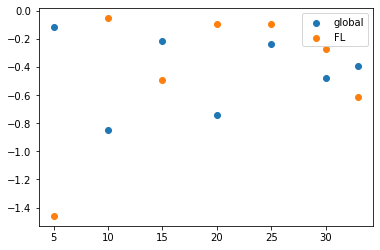

In [100]:
plt.scatter([5,10,15,20,25,30,33], avg_df[0:7].r2)
plt.scatter([5,10,15,20,25,30,33], avg_df[7:].r2)
plt.legend(['global', 'FL'])

In [361]:
global_and_fl_results

mse        r2        f1  \
global_#TrainHomes:5_TestHomeID:5058   1967.187622 -0.022206  0.336045   
global_#TrainHomes:5_TestHomeID:2358   3950.383301 -0.047380  0.209660   
global_#TrainHomes:5_TestHomeID:8825   8320.440430  0.100104  0.582808   
global_#TrainHomes:5_TestHomeID:10811  7097.741699 -0.128464  0.513390   
global_#TrainHomes:5_TestHomeID:526    7521.954590 -0.480894  0.484111   
...                                            ...       ...       ...   
FL_#TrainHomes:33_TestHomeID:183       8084.339355 -0.510425  0.352190   
FL_#TrainHomes:33_TestHomeID:8825      8233.190430  0.109541  0.598505   
FL_#TrainHomes:33_TestHomeID:10182     5697.469727 -0.261310  0.306342   
FL_#TrainHomes:33_TestHomeID:10811     7115.754883 -0.131328  0.507929   
FL_#TrainHomes:33_TestHomeID:3976      4156.108398 -0.098459  0.298873   

                                            nep       nde        mae  
global_#TrainHomes:5_TestHomeID:5058   0.970956  0.728753  27.029140  
global_#TrainHomes:5_TestHomeID:2358   1.050750  0.812382  34.707204  
global_#TrainHomes:5_TestHomeID:8825   0.693175  0.809962  22.210013  
global_#TrainHomes:5_TestHomeID:10811  0.740754  0.507288  65.008497  
global_#TrainHomes:5_TestHomeID:526    0.722335  0.567050  65.353277  
...                                         ...       ...        ...  
FL_#TrainHomes:33_TestHomeID:183       0.813608  0.673544  66.349422  
FL_#TrainHomes:33_TestHomeID:8825      0.851507  0.801469  27.283111  
FL_#TrainHomes:33_TestHomeID:10182     0.933037  0.731605  53.358994  
FL_#TrainHomes:33_TestHomeID:10811     0.760606  0.508575  66.750775  
FL_#TrainHomes:33_TestHomeID:3976      1.061713  0.809146  39.050753  

[256 rows x 6 columns]

In [112]:
def make_box_plots(data, metric):
    home_iter = [5,10,15,20,25,30,33]
    model_types = [1,2]
    count = 0
    all_bldgs = []
    for i in model_types:
        for j in range(len(home_iter)):
            bldgs = data[count:count+home_iter[j]][str(metric)].values
            all_bldgs.append(bldgs)
            count += home_iter[j]
    return plt.boxplot(all_bldgs, showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd015b2d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd015c44f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd015b2b20>,
 'medians': [<matplotlib.lines.Line2D at 0x2cd015c4c10>,
 'fliers': [<matplotlib.lines.Line2D at 0x2cd015cd370>,
 'means': [<matplotlib.lines.Line2D at 0x2cd015c4fa0>,
  <matplotlib.lines.Line2D at 0x2cd016dd910>]}

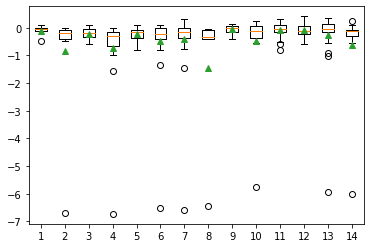

In [115]:
make_box_plots(global_and_fl_results, 'r2')

In [339]:
def make_adjacent_box_plots(global_results, fl_results, metric):
    
    iters = []
    for result in global_results.index:
        iters.append(int(result.split(':')[1].split('_')[0]))
        
    home_iter = np.unique(iters)
    
    count = 0
    all_global_results = []
    all_fl_results = []
    
    for j in range(len(home_iter)):
        bldgs = global_results[count:count+home_iter[j]][str(metric)].values
        all_global_results.append(bldgs)
        count += home_iter[j]
        
    count = 0
    for j in range(len(home_iter)):
        bldgs = fl_results[count:count+home_iter[j]][str(metric)].values
        all_fl_results.append(bldgs)
        count += home_iter[j]
        
    all_data = [list(a) for a in zip(all_global_results, all_fl_results)]
    all_data = [item for sublist in all_data for item in sublist]
    
    positions = [1]
    labels = ['global']
    for i in range(len(all_data)-1):
        if i%2==0:
            positions.append(positions[i]+0.5)
        else:
            positions.append(positions[i]+1)

    labels = []
    for home in home_iter:
        labels.append(home)
        labels.append('')
    
    fig, ax = plt.subplots(figsize=(20, 4))
    bplot = ax.boxplot(
        all_data,
        notch=False,
        patch_artist=True,
        positions=positions,
        labels=labels,
        showmeans=True
    )
    
    #ax.set_xticklabels(labels, ha='center')
    plt.setp(ax.xaxis.get_majorticklabels())
    dx = 27/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    
    ax.xaxis.set_ticks_position('none')
    
    ax.set_title("Global and FL Metrics for increasing quantity of homes")
    
    colors = []
    for i in range(int(len(labels)/2)):
        colors.append('blue')
        colors.append('red')
        
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xlabel('Number of homes')
    ax.set_ylabel(str(metric))
    
    custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
    
    ax.legend(custom_lines, ['Global', 'FL'])

    plt.show()


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

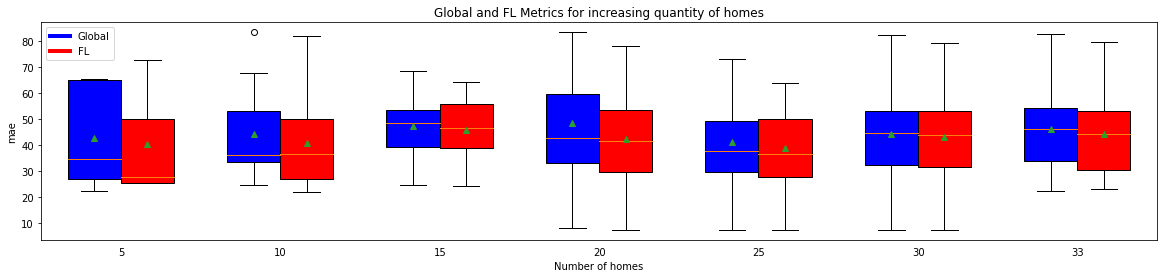

In [341]:
make_adjacent_box_plots(global_and_fl_results[0:128], global_and_fl_results[128:], 'mae')

In [353]:
def per_home_stats(data, home, metric):
    data = data.filter(like=str(home), axis=0)
    iters = []
    for result in data.index:
        iters.append(int(result.split(':')[1].split('_')[0]))
    home_iter = np.unique(iters)
    plt.plot(home_iter, data[str(metric)][0:int(len(data)/2)])
    plt.plot(home_iter, data[str(metric)][int(len(data)/2):])
    plt.legend(['global', 'fl'])

<ipython-input-360-f322476add7e>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


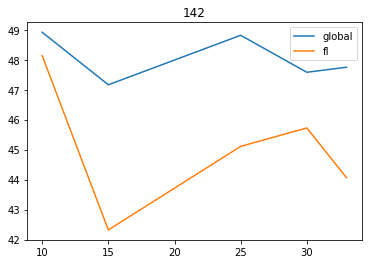

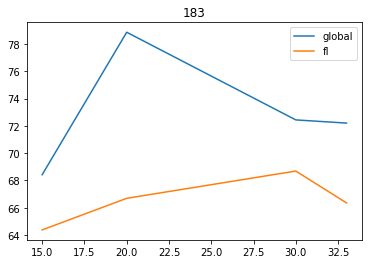

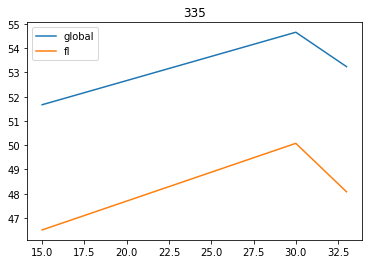

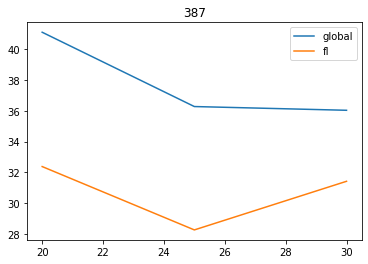

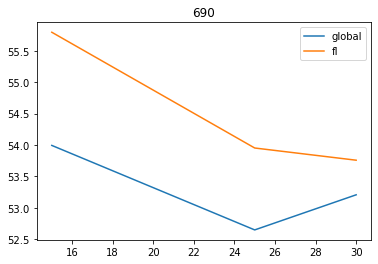

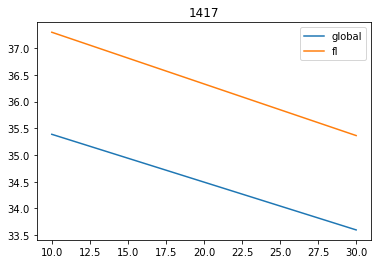

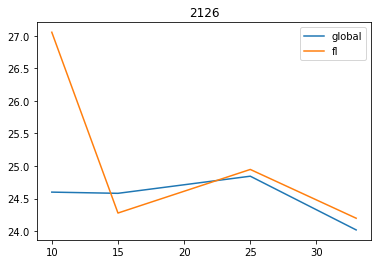

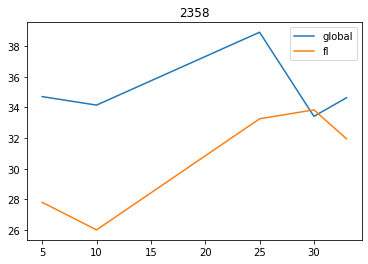

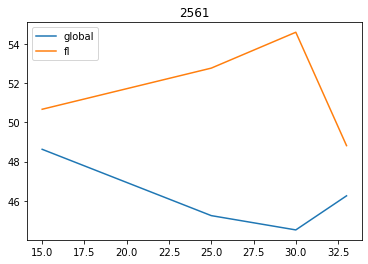

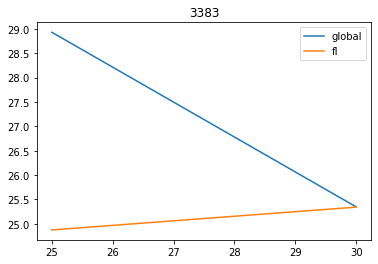

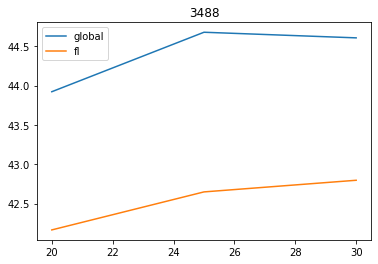

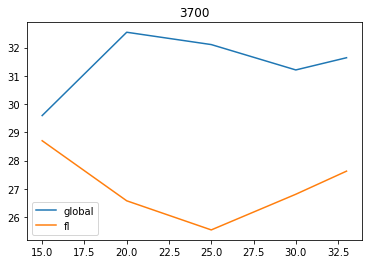

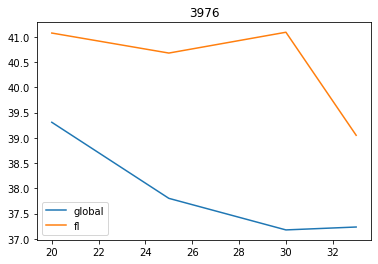

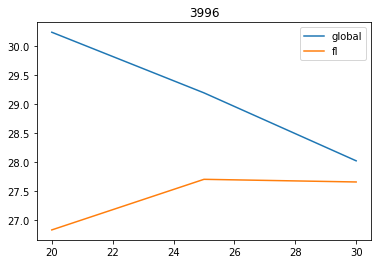

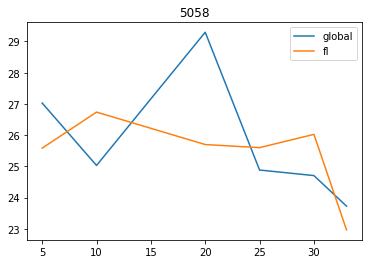

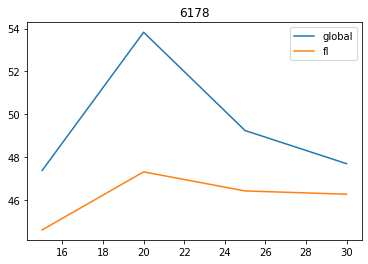

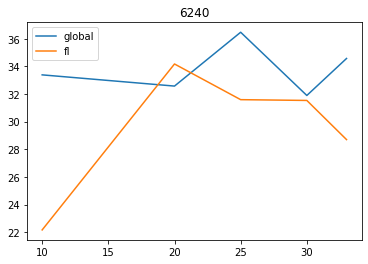

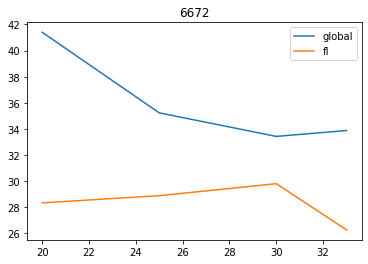

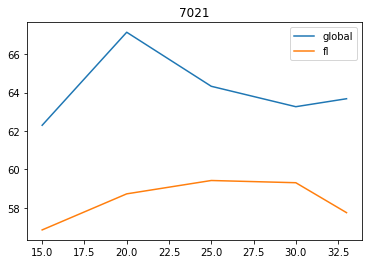

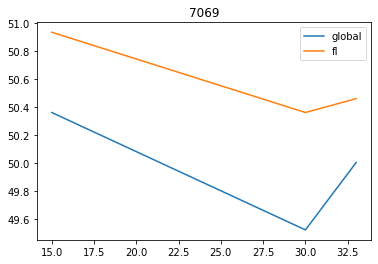

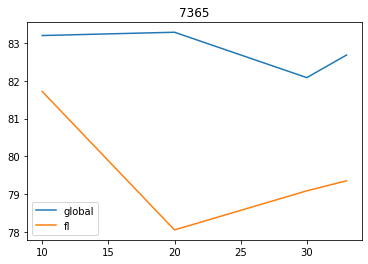

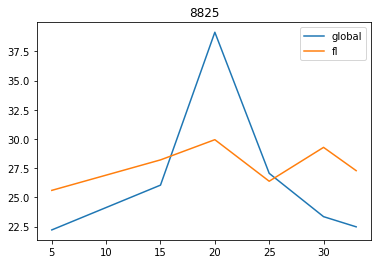

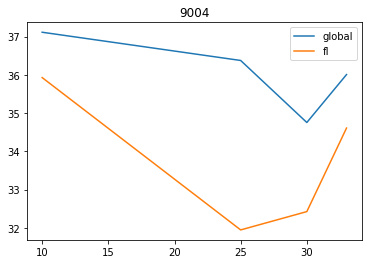

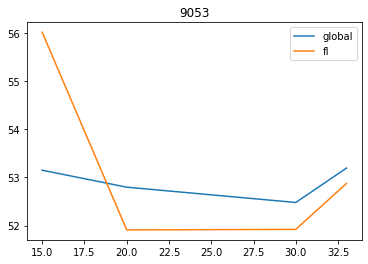

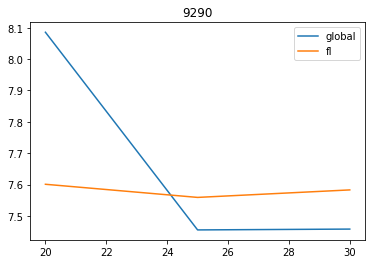

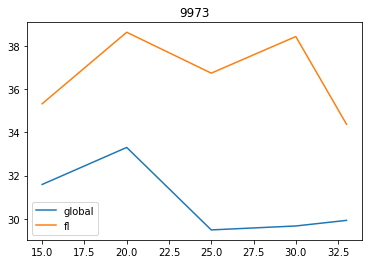

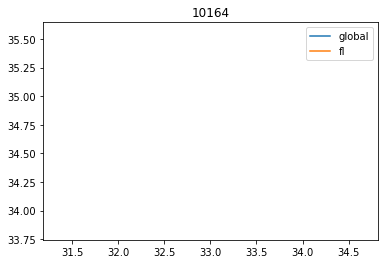

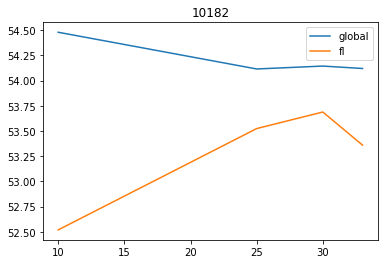

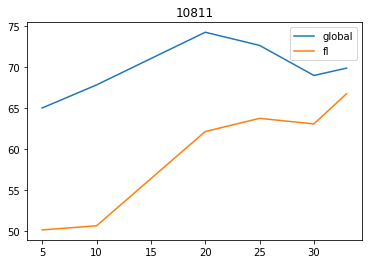

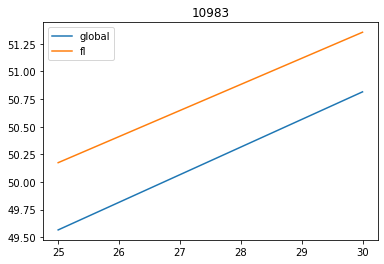

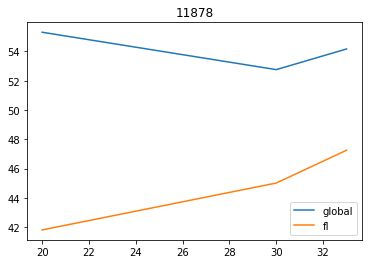

In [360]:
unwanted_num = {526, 6526}
list1 = [ele for ele in home_ids if ele not in unwanted_num]
for home in list1:
    plt.figure()
    plt.title(home)
    per_home_stats(global_and_fl_results, home, 'mae')

In [376]:
data = global_and_fl_results
print((data.filter(like=":33_", axis=0)))

                                                 mse        r2        f1  \
global_#TrainHomes:33_TestHomeID:2126    1688.733643 -0.035534  0.346893   
global_#TrainHomes:33_TestHomeID:6240    3172.391113 -0.113354  0.160234   
global_#TrainHomes:33_TestHomeID:3700    3783.476318 -0.307323  0.391954   
global_#TrainHomes:33_TestHomeID:6672    3534.955811  0.004246  0.396891   
global_#TrainHomes:33_TestHomeID:7021    8806.723633 -0.510272  0.224483   
global_#TrainHomes:33_TestHomeID:335     6153.260254 -0.364542  0.310563   
global_#TrainHomes:33_TestHomeID:142     5500.267090 -0.270393  0.269805   
global_#TrainHomes:33_TestHomeID:9973    2435.116211 -0.072731  0.310531   
global_#TrainHomes:33_TestHomeID:2358    4045.297119 -0.072545  0.176749   
global_#TrainHomes:33_TestHomeID:11878   4632.286133 -1.441691  0.256922   
global_#TrainHomes:33_TestHomeID:5058    1726.468750  0.102878  0.385504   
global_#TrainHomes:33_TestHomeID:7069    6977.336426 -0.220501  0.254518   
global_#Trai

In [392]:
data = [5058, 2358, 3488, 10182, 6672, 11878, 7021, 6526, 335, 10164, 142, 9973, 10983, 6240, 2126, 1417, 7069, 6178, 8825, 3383, 9004, 387, 3976, 3700, 9290, 3996, 690, 7365, 9053, 183, 2561, 526, 10811]

In [393]:
len(np.unique(np.array(data)))

33

                                              mse        r2        f1  \
global_#TrainHomes:10_TestHomeID:142  5686.662598 -0.313445  0.228492   
global_#TrainHomes:15_TestHomeID:142  5121.549316 -0.182921  0.321153   
global_#TrainHomes:25_TestHomeID:142  5701.367676 -0.316841  0.229236   
global_#TrainHomes:30_TestHomeID:142  5421.729980 -0.252254  0.274667   
global_#TrainHomes:33_TestHomeID:142  5500.267090 -0.270393  0.269805   
FL_#TrainHomes:10_TestHomeID:142      5503.553223 -0.271152  0.262481   
FL_#TrainHomes:15_TestHomeID:142      4111.180664  0.050443  0.496328   
FL_#TrainHomes:25_TestHomeID:142      4528.994141 -0.046059  0.404186   
FL_#TrainHomes:30_TestHomeID:142      4579.818359 -0.057798  0.392391   
FL_#TrainHomes:33_TestHomeID:142      4519.900879 -0.043959  0.419801   

                                           nep       nde        mae  
global_#TrainHomes:10_TestHomeID:142  0.930627  0.801788  48.916837  
global_#TrainHomes:15_TestHomeID:142  0.897280  0.722110

                                               mse        r2        f1  \
global_#TrainHomes:25_TestHomeID:3383  2611.482910 -0.031628  0.169116   
global_#TrainHomes:30_TestHomeID:3383  2504.873047  0.010487  0.203879   
FL_#TrainHomes:25_TestHomeID:3383      1828.083374  0.277843  0.430493   
FL_#TrainHomes:30_TestHomeID:3383      1835.448242  0.274933  0.444298   

                                            nep       nde        mae  
global_#TrainHomes:25_TestHomeID:3383  1.225499  0.845507  28.929033  
global_#TrainHomes:30_TestHomeID:3383  1.073808  0.810990  25.348213  
FL_#TrainHomes:25_TestHomeID:3383      1.053798  0.591869  24.875880  
FL_#TrainHomes:30_TestHomeID:3383      1.073596  0.594254  25.343217  
                                               mse        r2        f1  \
global_#TrainHomes:20_TestHomeID:3488  3949.626221 -0.800259  0.228019   
global_#TrainHomes:25_TestHomeID:3488  3918.848633 -0.786231  0.210596   
global_#TrainHomes:30_TestHomeID:3488  3850.441162 -

                                               mse        r2        f1  \
global_#TrainHomes:15_TestHomeID:7069  6647.535156 -0.162811  0.316535   
global_#TrainHomes:30_TestHomeID:7069  6760.104492 -0.182502  0.275533   
global_#TrainHomes:33_TestHomeID:7069  6977.336426 -0.220501  0.254518   
FL_#TrainHomes:15_TestHomeID:7069      6520.677734 -0.140621  0.436772   
FL_#TrainHomes:30_TestHomeID:7069      6160.264160 -0.077576  0.384496   
FL_#TrainHomes:33_TestHomeID:7069      6450.743164 -0.128387  0.395331   

                                            nep       nde        mae  
global_#TrainHomes:15_TestHomeID:7069  0.974603  0.792599  50.361858  
global_#TrainHomes:30_TestHomeID:7069  0.958349  0.806021  49.521969  
global_#TrainHomes:33_TestHomeID:7069  0.967681  0.831922  50.004181  
FL_#TrainHomes:15_TestHomeID:7069      0.985717  0.777474  50.936155  
FL_#TrainHomes:30_TestHomeID:7069      0.974606  0.734501  50.362003  
FL_#TrainHomes:33_TestHomeID:7069      0.976524  0.7691

<ipython-input-212-24c5c5c81d6d>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 4))


                                               mse        r2        f1  \
global_#TrainHomes:10_TestHomeID:9004  2734.527100 -0.465261  0.431094   
global_#TrainHomes:25_TestHomeID:9004  2694.431396 -0.443776  0.429577   
global_#TrainHomes:30_TestHomeID:9004  2482.824707 -0.330389  0.489759   
global_#TrainHomes:33_TestHomeID:9004  2639.024414 -0.414087  0.464134   
FL_#TrainHomes:10_TestHomeID:9004      2596.986084 -0.391561  0.494478   
FL_#TrainHomes:25_TestHomeID:9004      2118.952637 -0.135413  0.606542   
FL_#TrainHomes:30_TestHomeID:9004      2126.018311 -0.139199  0.590609   
FL_#TrainHomes:33_TestHomeID:9004      2389.835449 -0.280562  0.564991   

                                            nep       nde        mae  
global_#TrainHomes:10_TestHomeID:9004  0.785685  0.667353  37.113377  
global_#TrainHomes:25_TestHomeID:9004  0.770055  0.657568  36.375067  
global_#TrainHomes:30_TestHomeID:9004  0.735715  0.605926  34.752914  
global_#TrainHomes:33_TestHomeID:9004  0.762251  

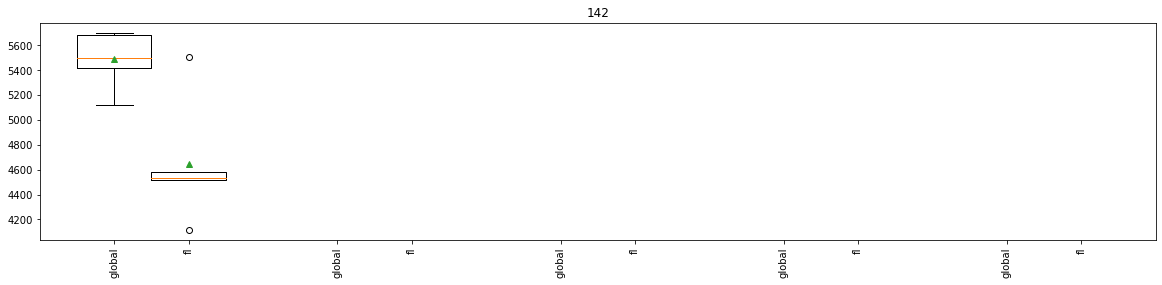

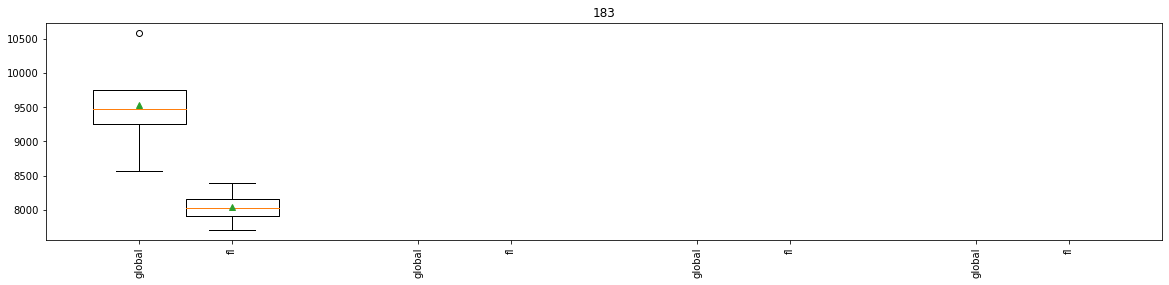

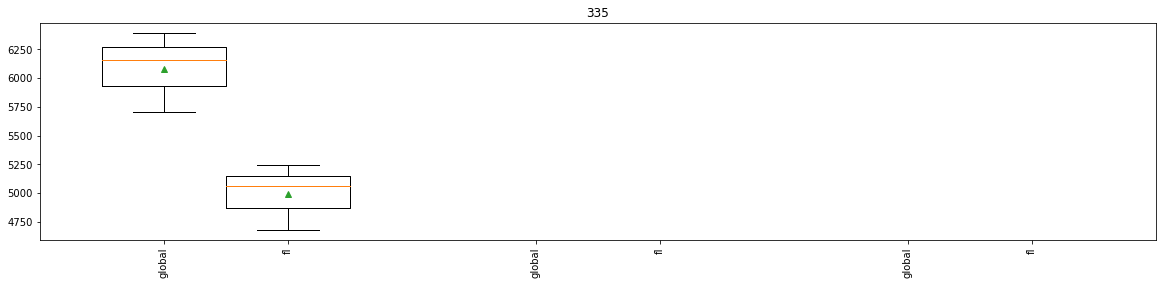

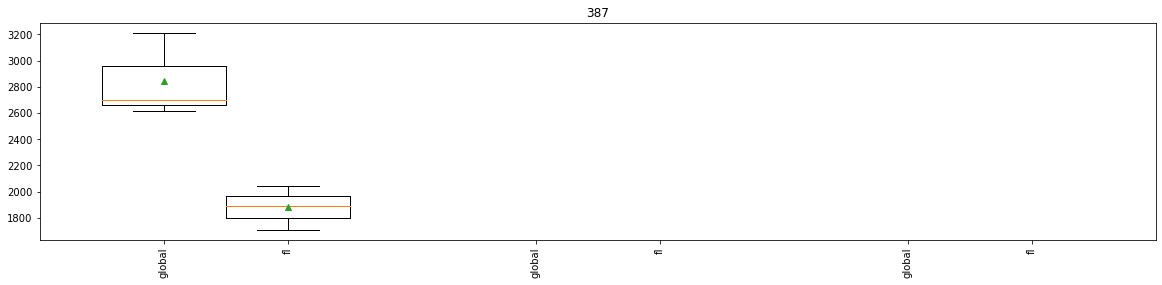

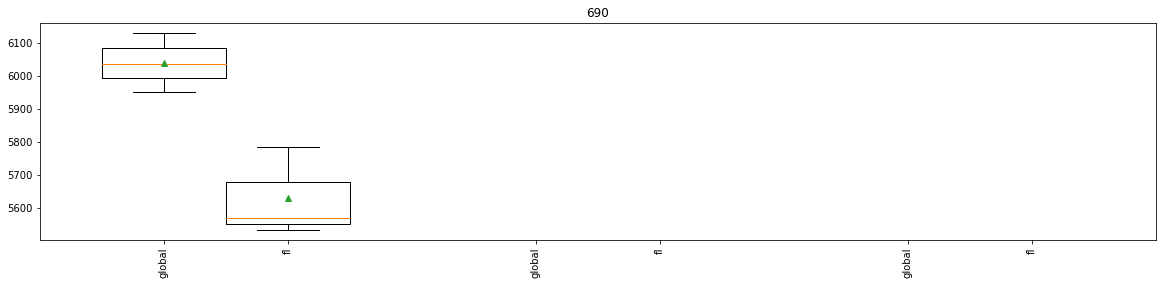

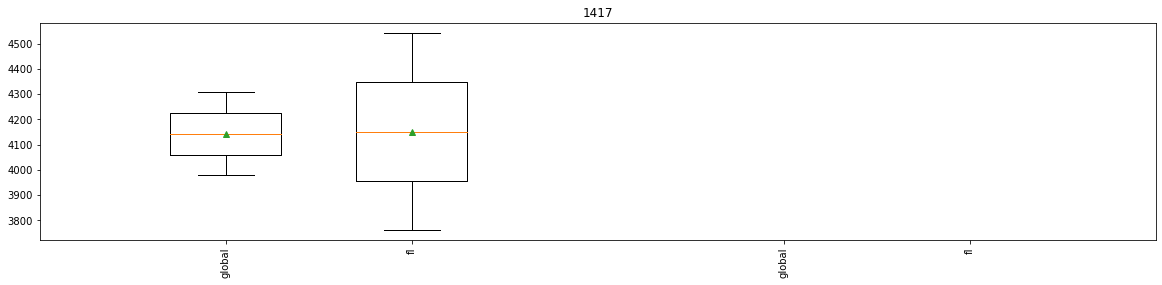

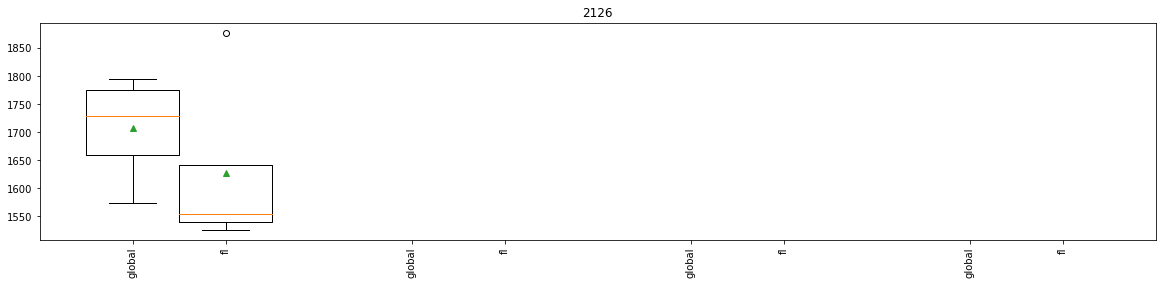

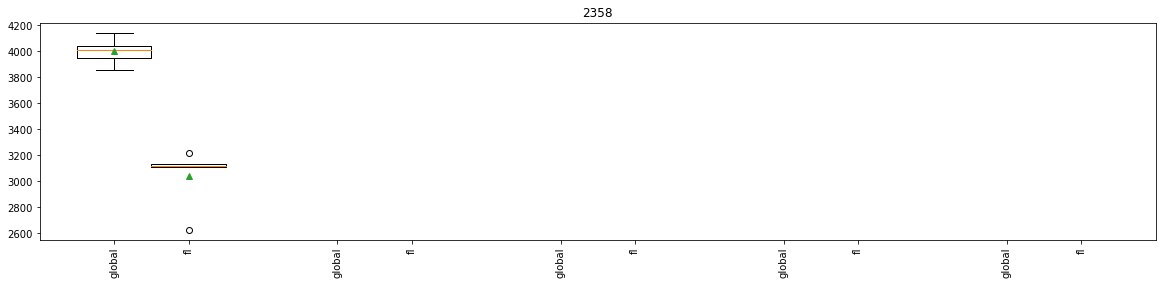

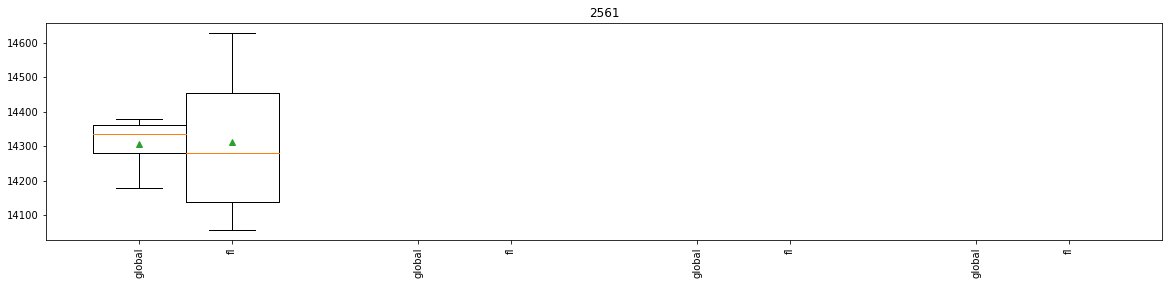

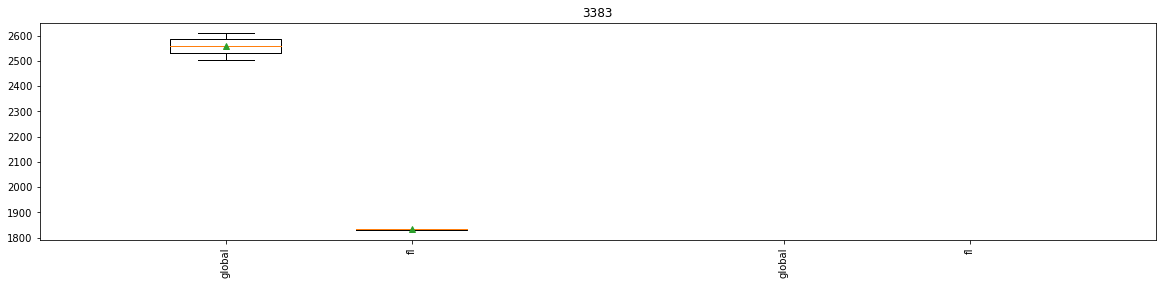

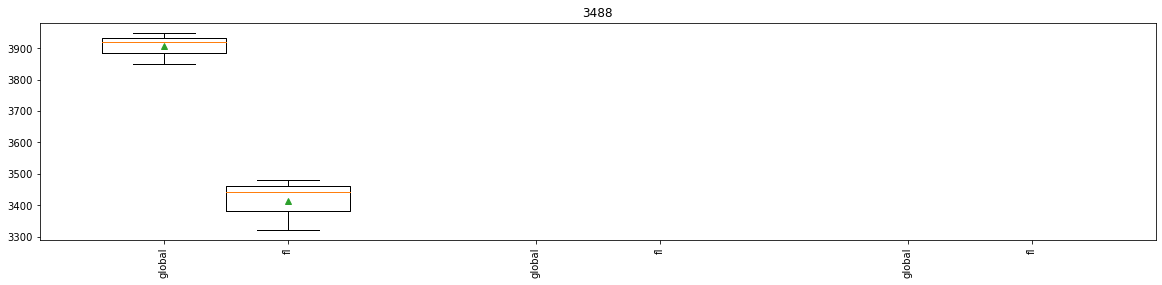

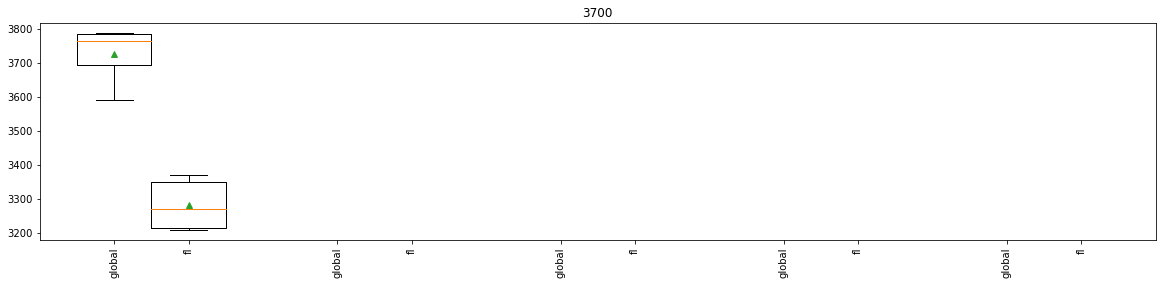

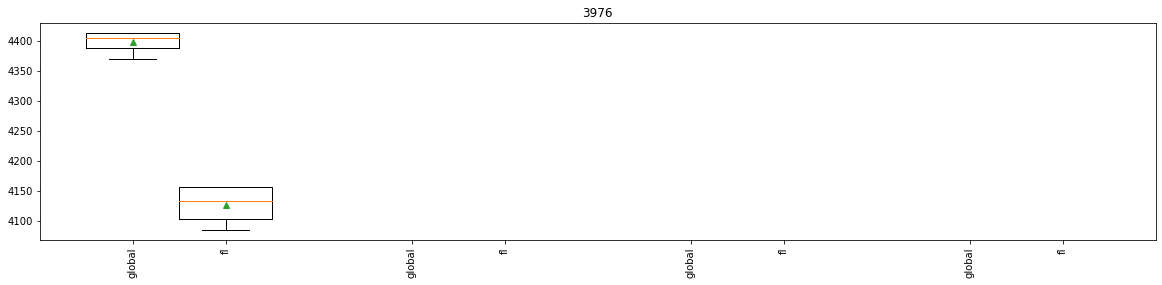

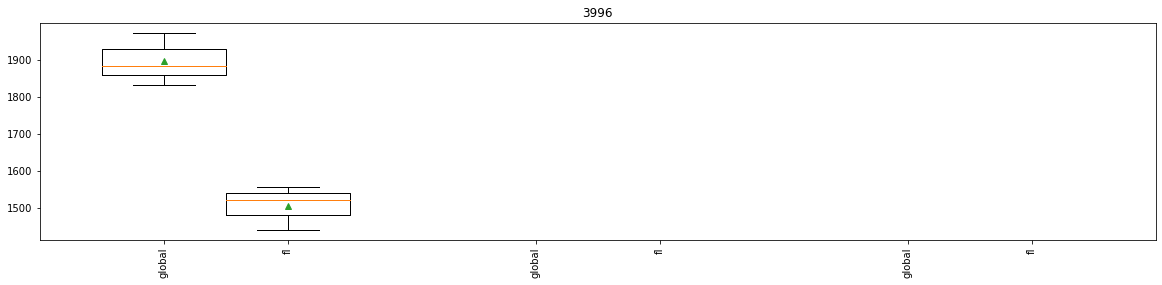

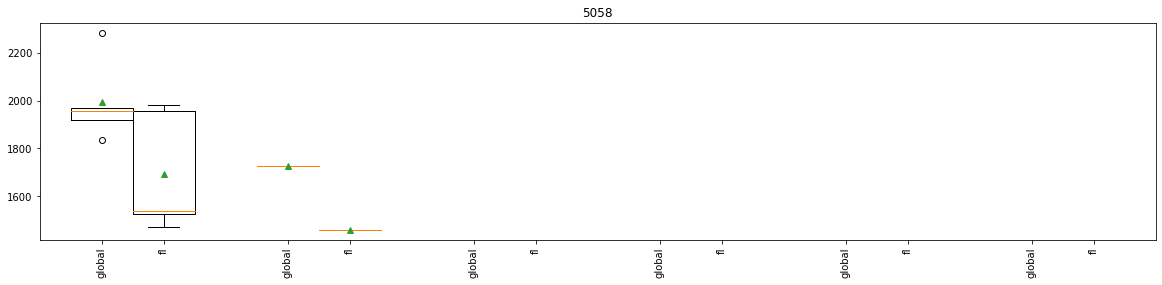

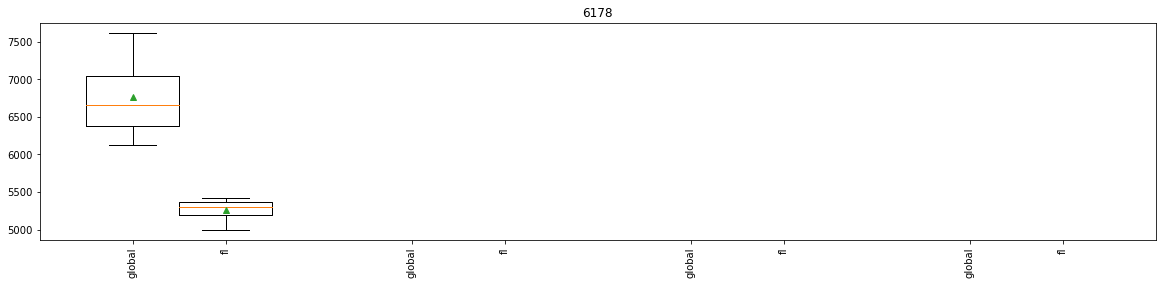

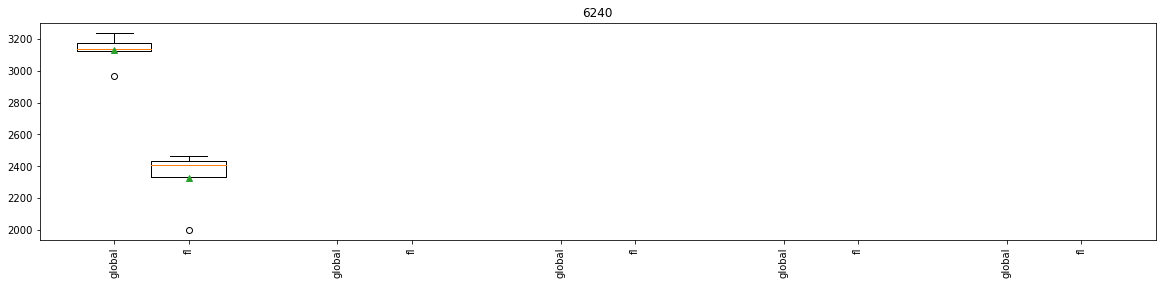

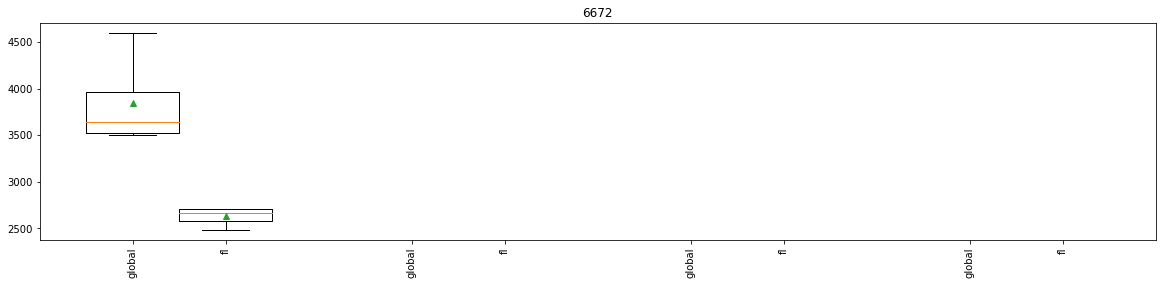

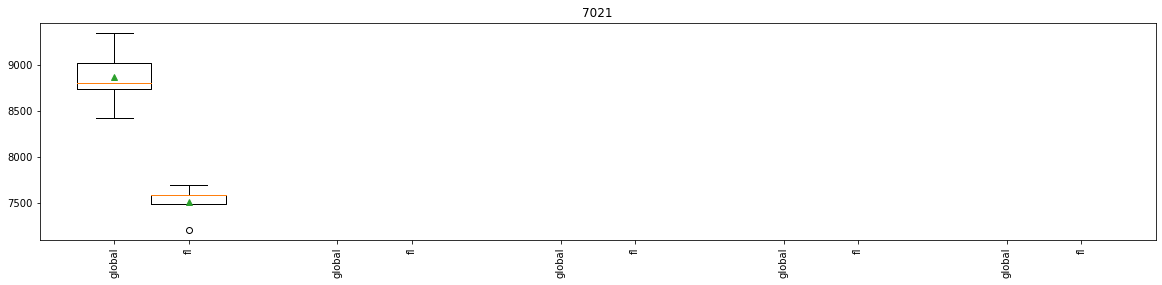

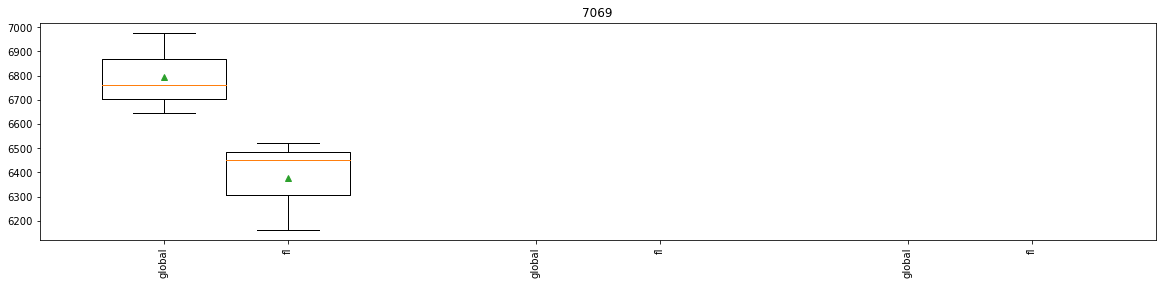

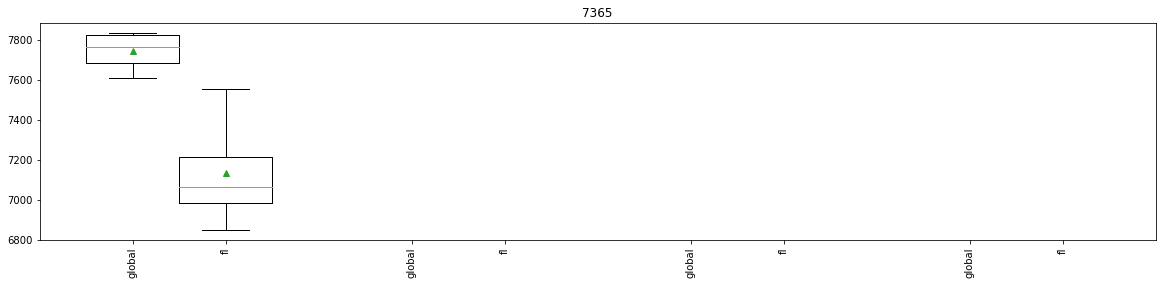

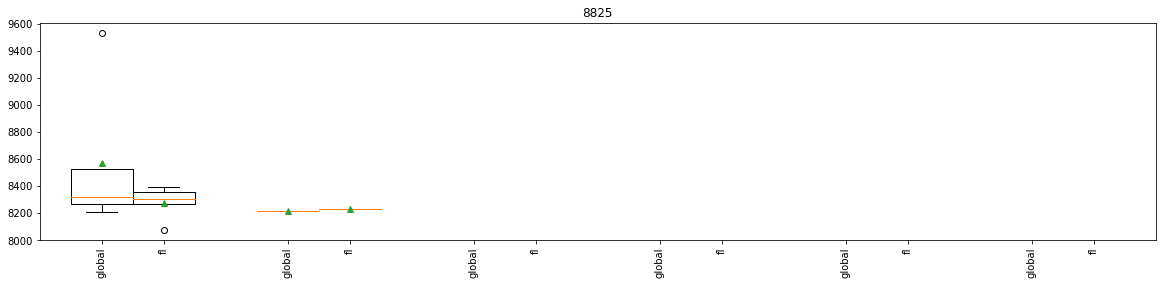

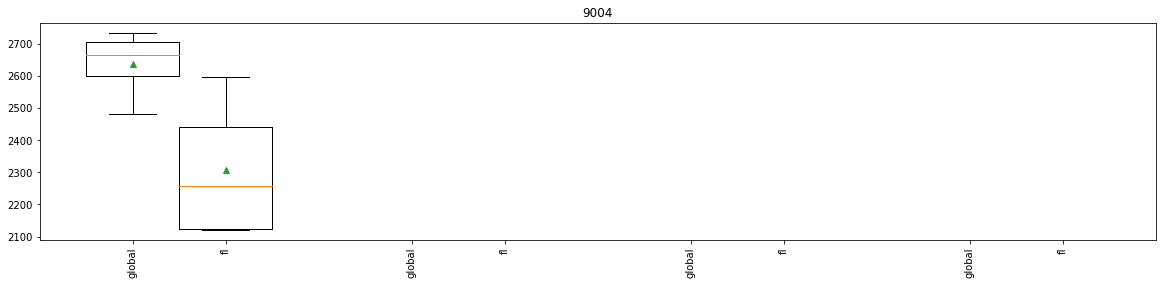

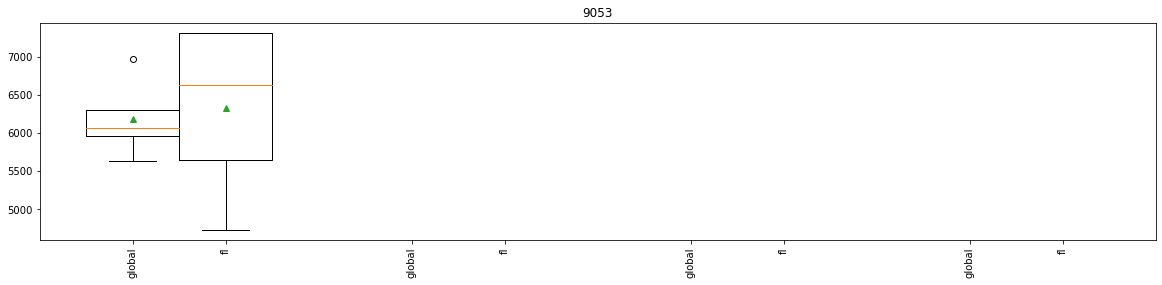

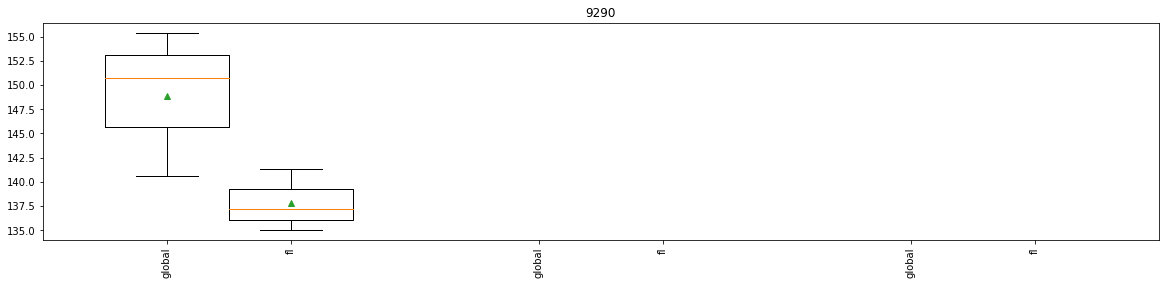

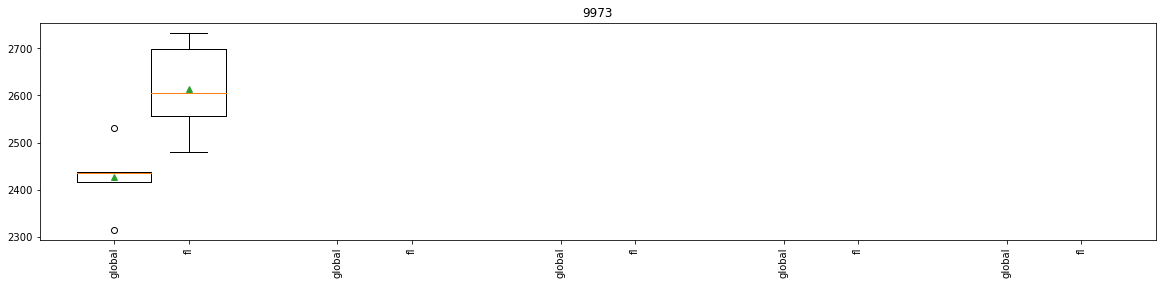

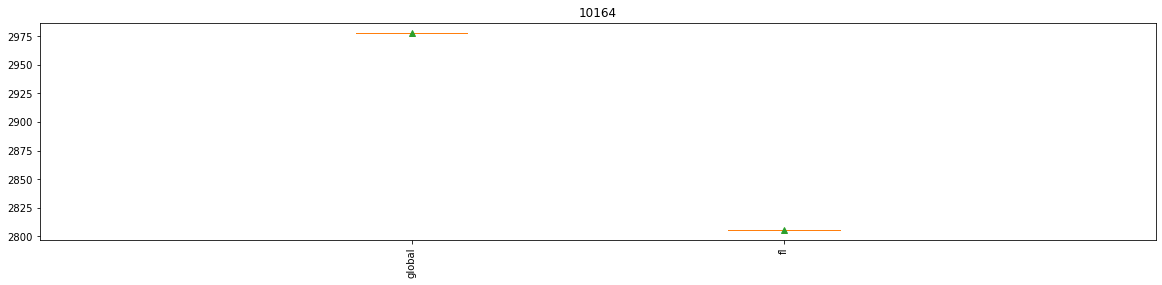

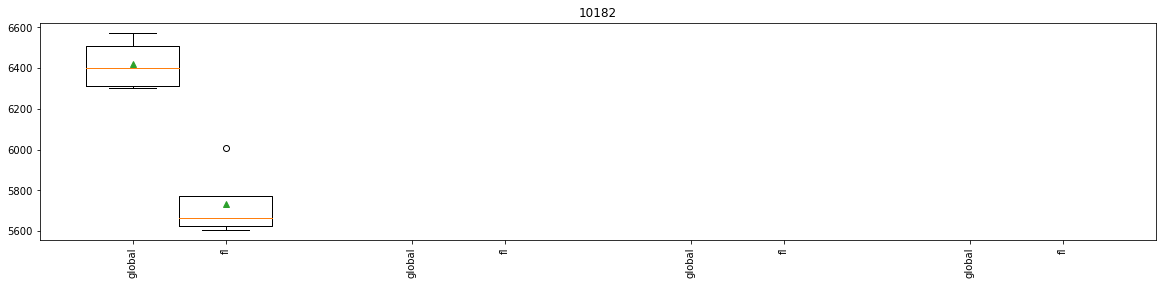

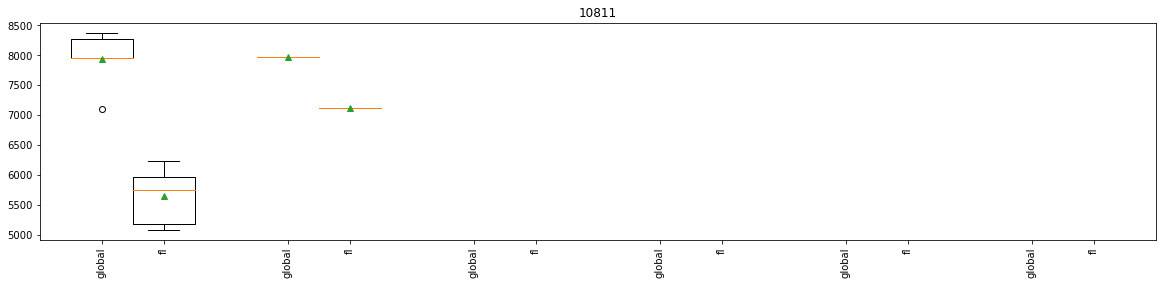

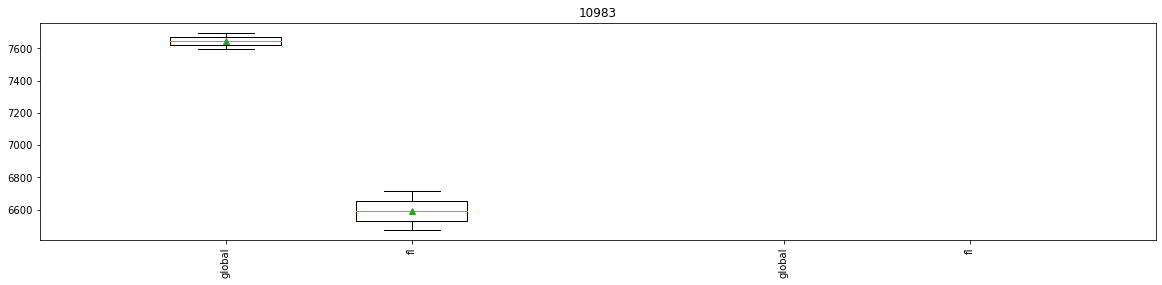

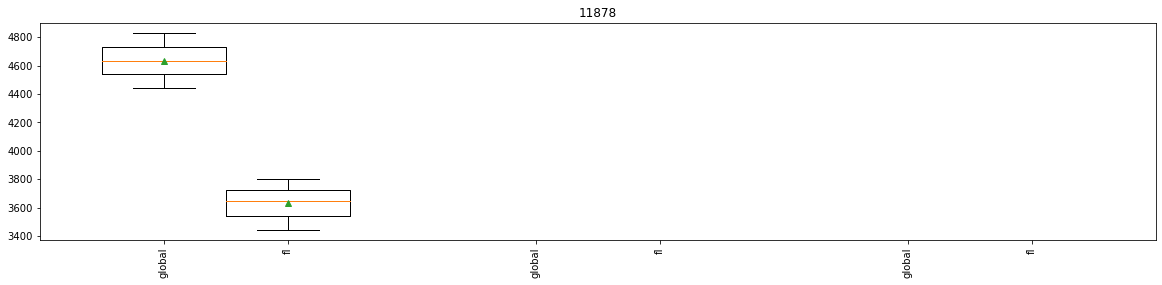

In [214]:
unwanted_num = {526, 6526}
list1 = [ele for ele in home_ids if ele not in unwanted_num]

for home in list1:
    data = global_and_fl_results.filter(like=str(home), axis=0)
    print(data)
    make_adjacent_box_plots(data[0:int(len(data)/2)], data[int(len(data)/2):], 'mse')
    plt.title(str(home))

In [179]:
for home in home_ids:
    print(home, np.std(stats.boxcox(np.add(homes.loc[homes.dataid==home].net_power.values, 1))[0]))
    print(home, np.std(stats.boxcox(np.add(homes.loc[homes.dataid==home].appliance_power.values, 1))[0]))

142 0.627813
142 1.8211405
183 0.15958168
183 3.1812317


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


335 0.8712539
335 3.6151958
387 0.031118842
387 0.51928014
526 0.13132681
526 6.491468
690 0.5902899
690 1.0042721
1417 0.2473037
1417 0.9956921
2126 0.95059407
2126 1.8851832
2358 0.23229584
2358 0.85096544
2561 0.6178817
2561 1.2467158
3383 0.3759893
3383 0.74153423
3488 1.0645796
3488 2.1252086


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


3700 0.0
3700 1.6690143
3976 2.3958247
3976 1.735116
3996 0.34134537
3996 2.783291


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


5058 0.016594687
5058 0.7896452
6178 0.05502117
6178 1.7574118
6240 0.021030154
6240 0.7394033
6526 0.06439837
6526 4.4043097
6672 0.8151879
6672 0.8161145
7021 0.3272039
7021 1.7251172
7069 0.2104869
7069 1.7833377
7365 0.2108574
7365 3.2717578
8825 4.2686706
8825 0.81553704
9004 0.4426672
9004 3.2583442
9053 0.5713042
9053 1.4708488
9290 0.41253534
9290 1.7294323
9973 0.11093106
9973 0.33553287
10164 0.028171664
10164 0.98991835
10182 0.18329373
10182 1.4869835
10811 0.28004915
10811 0.33396637
10983 0.17552525
10983 0.6584481
11878 7.9671
11878 9.061353


In [148]:
home_ids

array([  142,   183,   335,   387,   526,   690,  1417,  2126,  2358,
        2561,  3383,  3488,  3700,  3976,  3996,  5058,  6178,  6240,
        6526,  6672,  7021,  7069,  7365,  8825,  9004,  9053,  9290,
        9973, 10164, 10182, 10811, 10983, 11878], dtype=int64)

In [49]:
my_dict = {1:[1,2,3], 2:[4,5,6]}

In [50]:
new = {1:[4,7,8]}

In [51]:
my_dict.update(new)

In [52]:
my_dict

{1: [4, 7, 8], 2: [4, 5, 6]}

In [ ]:
test_loader, y_min, y_max = load_test_data_loader("refrigerator", 3996, "dec")
true, pred = create_true_and_pred_lists(model_test, test_loader, y_min, y_max)
plot_true_and_pred(true, pred, 0)

In [ ]:
for home in home_ids:
    test_loader, y_min, y_max = load_test_data_loader("refrigerator", home, "dec")
    true, pred = create_true_and_pred_lists(model_test, test_loader, y_min, y_max)
    plot_true_and_pred(true, pred, 4000)

In [ ]:
#Results from FL trial 1: Only train on homes from kmeans group 0
train_results:  [0.05918259809798596, 0.05631256998604834, 0.05440947504993626, 0.05202335131766571, 0.0503139231996005, 0.048780418103246403, 0.047837128240590214, 0.04677401642300567, 0.04564181936058709, 0.04503467424225199, 0.044160787837709645, 0.04364045831778884, 0.04269331134775909, 0.042177348902872995, 0.04186163381211489, 0.04121293036455554, 0.04038131841834548, 0.040097079220779215, 0.03981643070223546, 0.039571967459759584]
test_results:  [[0.10141171514987946, 0.0037996456822343427, 0.30775005794404453, 1.1624964525961219, 0.7102131519348384, 32.36117409223122], [0.07018595188856125, -0.03035194696439647, 0.29275949364898596, 1.0193813194259513, 0.7345605631401784, 28.37718452442667], [0.07101921737194061, 0.024487967353850726, 0.33216459819150085, 0.9911870298545128, 0.6954639814554395, 27.592321644896586], [0.0762869194149971, 0.037722537982371684, 0.3469836294700992, 1.0001555309118728, 0.6860287619779427, 27.8419836747595], [0.07988928258419037, 0.046875361692992, 0.3580031460561334, 1.007971290365539, 0.6795035147228619, 28.059556082639325], [0.08263445645570755, 0.06088193306524636, 0.3722769571476962, 1.0117267310898002, 0.6695179288378231, 28.164098742360537], [0.08711171895265579, 0.0651336946658907, 0.3775209821011063, 1.0278720855497583, 0.6664867473821405, 28.61354753447742], [0.09034138172864914, 0.058741536735728794, 0.3788472553128205, 1.0409449550909322, 0.6710438600997121, 28.977465554323565], [0.09514638781547546, 0.047170316993679906, 0.37581896125501857, 1.063129654702191, 0.6792932333429572, 29.595035547505493], [0.09916041046380997, 0.04520241126403168, 0.3788573920789103, 1.0829578383335274, 0.6806961968598882, 30.147005664053744], [0.09965900331735611, 0.0475078473168451, 0.38485057828841956, 1.083835660609424, 0.6790526045305888, 30.17144217689547], [0.09750136733055115, 0.06263643169646227, 0.38969362416454856, 1.0732437942194344, 0.6682671053889663, 29.876589464491374], [0.10068412125110626, 0.07135716647367518, 0.40400621237323964, 1.0842488674066784, 0.6620498952202254, 30.18294488477228], [0.10021708905696869, 0.07195186144252641, 0.4020264338053921, 1.084497488253324, 0.6616259348165169, 30.189865905893072], [0.1023930236697197, 0.07322667698235097, 0.4063947510138716, 1.0966199078441043, 0.6607170907011506, 30.52732562881973], [0.1065988838672638, 0.06951195009544042, 0.4111004370170547, 1.117051806795602, 0.6633653927636083, 31.09610176360077], [0.10572896897792816, 0.06835445223858572, 0.41259720323148086, 1.1132755123704126, 0.6641905963041802, 30.990978585767266], [0.10537360608577728, 0.07077213154564777, 0.41170232881199936, 1.111736672463417, 0.6624669832585127, 30.948140892784085], [0.10712811350822449, 0.06923373560970414, 0.4118381696086163, 1.1209696047556377, 0.6635637404772865, 31.205164067885455], [0.10733970254659653, 0.0691712998125521, 0.4138843360342946, 1.1199289978245903, 0.6636082503390233, 31.17619601212752]]

In [ ]:
#Results from FL trial 2: Train on all homes
train_results:  [0.06898596219780932, 0.06548122778359505, 0.06185041400298901, 0.06054192711494171, 0.058454206690380324, 0.05690618117988075, 0.05569481511845242, 0.05503546991090291, 0.05418193751508395, 0.053413227141336866, 0.05262128071217649, 0.05209992935248824, 0.05133464310447817, 0.05037318027168617, 0.049760406571789456, 0.04947327085773233, 0.04883004258806736, 0.04831138391435008, 0.04784004755478911, 0.04739499937394071]
test_results:  [[0.07388950139284134, -0.6394206307101029, 0.2940040695688336, 0.8651581647483642, 0.7761451711873405, 42.73750960843977], [0.10229679197072983, -0.7187000854334691, 0.24852498062349612, 0.8859254704806616, 0.8136781573856805, 43.76338321680318], [0.10142817348241806, -0.7256445803898879, 0.24620718310013454, 0.8862384540920745, 0.8169658736995279, 43.778844135563546], [0.0964757427573204, -0.7036218577431197, 0.2571345084097417, 0.8821222316460292, 0.8065397265810448, 43.57550894957533], [0.0948667898774147, -0.6870919402250779, 0.2653881911042843, 0.8791050393278182, 0.7987140305459689, 43.42646419574404], [0.09232829511165619, -0.6723862043143909, 0.27381300604860054, 0.8772141657551705, 0.7917519420748073, 43.33305789066353], [0.09167767316102982, -0.6674416250445798, 0.27728940833314025, 0.8774828827796103, 0.7894110554511302, 43.34633210673394], [0.09230783581733704, -0.6718295387860991, 0.27591257752931375, 0.8783017496029307, 0.7914884009073095, 43.386782893833505], [0.09227342158555984, -0.6668164809479504, 0.2786549967785973, 0.8774768593896604, 0.7891150873202154, 43.34603456034722], [0.09188926219940186, -0.663334135803274, 0.2804593641079765, 0.8768874209479345, 0.7874664545742958, 43.31691718956662], [0.09317739307880402, -0.6676371394797516, 0.27811129764069026, 0.8775280676216676, 0.7895036083130942, 43.34856416984131], [0.093377485871315, -0.6678664609591507, 0.2778367616500098, 0.877078930313777, 0.78961217790754, 43.32637746364862], [0.09336987882852554, -0.6644323439395239, 0.2792824927301477, 0.8762281124679917, 0.7879863704906633, 43.284348344187144], [0.09260615706443787, -0.6560269490716168, 0.28308320393602676, 0.874632299913617, 0.7840070291709628, 43.20551760877393], [0.0935792624950409, -0.6595903949395858, 0.2810017749483793, 0.8750087359706437, 0.7856940695125773, 43.224112982729416], [0.09312581270933151, -0.6540594785849432, 0.2834550706028201, 0.8736186854571278, 0.7830755917253327, 43.155446582066276], [0.09380140155553818, -0.6580750915440914, 0.28175009703612847, 0.874551030793283, 0.784976680562069, 43.20150303669605], [0.09393875300884247, -0.6532669189158098, 0.28402766426613224, 0.8738440282240405, 0.7827003698615169, 43.16657817517668], [0.09293350577354431, -0.6430557061244582, 0.2887735304023372, 0.8723430365864373, 0.7778661096898173, 43.09243145016379], [0.09316611289978027, -0.6414575532448334, 0.28935691922657975, 0.8721005390241325, 0.7771095046804066, 43.08045243601204]]

In [ ]:
#Global training on 33 buildings, kmeans group 0
[0.055916693061590195, -0.08682051436345928, 0.2662437579818409, 0.9251781331394637, 0.7748182519969681, 25.754788813324193]
#Fed training on 33 buildings, kmeans group 0
[0.10733970254659653, 0.0691712998125521, 0.4138843360342946, 1.1199289978245903, 0.6636082503390233, 31.17619601212752]

In [ ]:
#Global training on 11 buildings, kmeans group 0
[0.10680125653743744, -0.2791650140765447, 0.17327582767193095, 0.9721052782034753, 0.9043568620623283, 29.816883628987515]

In [ ]:
#Box-Cox Global training on 11 buildings, kmeans group 0
[0.07675079256296158, -0.1594563360666088, 0.24777122017698072, 0.9572877984815846, 0.8197240244830643, 29.36239471873389]

In [ ]:
homes_aug = load_all_houses_with_device(r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_aug2019.csv", 'drye1')

In [ ]:
homes_aug.loc[homes_aug.dataid==2358]

In [ ]:
#results for test building 145 through 1222 with 6/10 trials done
{'Train_home_2602_Test_home_145_trial_0': [0.040176667273044586, 0.5350352393891653, 0.6995605416768369, 0.6202009862456976, 0.16763660105062883, 25.120263894399006], 'Train_home_2602_Test_home_145_trial_1': [0.05921102687716484, -2.0440782008511387, 0.7124453406067465, 0.6474282140808139, 0.24652965752880682, 26.279175281524658], 'Train_home_2602_Test_home_145_trial_2': [0.03823353722691536, 0.5057120170055666, 0.7560540177590247, 0.5195950316365615, 0.14908920077524376, 22.51904609468248], 'Train_home_2602_Test_home_145_trial_3': [0.05927851051092148, 0.30235999898475624, 0.6887774979077629, 0.6375544077244527, 0.25398679080020226, 25.147226519054836], 'Train_home_2602_Test_home_145_trial_4': [0.041999612003564835, 0.4882201798661358, 0.6926759932829819, 0.6551516045754432, 0.1793288404278918, 25.931260691748726], 'Train_home_2602_Test_home_145_trial_5': [0.03647385537624359, 0.47454400621218595, 0.7559350868535851, 0.5200739818305863, 0.14116170384252258, 22.709971851772732], 'Train_home_2602_Test_home_145_trial_6': [0.11966244131326675, -1.064580240229691, 0.495144746087016, 1.2211936160376278, 0.4605021188671462, 53.628720707363556], 'Train_home_2602_Test_home_145_trial_7': [0.1058136448264122, -1.0395888561208113, 0.5233829748688715, 1.1160730460487083, 0.4145315960798125, 48.14635025130378], 'Train_home_2602_Test_home_145_trial_8': [0.03477741405367851, 0.454301144430442, 0.7551700010595161, 0.472974838218259, 0.143859846549889, 19.323349661297268], 'Train_home_2602_Test_home_145_trial_9': [0.04593951627612114, -0.4233190250154665, 0.6992317961832466, 0.6502480240201282, 0.18772461796476841, 26.892483287387424], 'Train_home_1240_Test_home_518_trial_0': [0.16696804761886597, -0.8029177145635302, 0.330246179185051, 1.061495864107348, 0.5406991734830829, 55.39654350280762], 'Train_home_1240_Test_home_518_trial_1': [0.1421043872833252, -1.0309879809684908, 0.3603602061554123, 1.1030694507951269, 0.5076501240101836, 52.1834230211046], 'Train_home_1240_Test_home_518_trial_2': [0.1428082138299942, -0.7208309734200375, 0.342751374536081, 1.1026372274300804, 0.522375694525131, 50.94359147813585], 'Train_home_1240_Test_home_518_trial_3': [0.15462778508663177, -0.6270411330811336, 0.34384646018458653, 1.0691058538056373, 0.5142801474616763, 54.324424997965494], 'Train_home_1240_Test_home_518_trial_4': [0.1594161093235016, -1.0189699473034592, 0.33037198747186325, 1.0733883577778536, 0.5316598258287396, 54.39286524454753], 'Train_home_1240_Test_home_518_trial_5': [0.14113833010196686, -0.8375110719493595, 0.3455177502273711, 1.137111852290704, 0.5245533921351407, 51.706502956814234], 'Train_home_1240_Test_home_518_trial_6': [0.14234046638011932, -0.6232183947079312, 0.3522625589613987, 1.0677044460454845, 0.5106981537086099, 50.29233741760254], 'Train_home_1240_Test_home_518_trial_7': [0.16293306648731232, -1.0306040477256764, 0.36236931577444914, 1.0089313390172745, 0.516691203916662, 53.76832110087077], 'Train_home_1240_Test_home_518_trial_8': [0.1363573968410492, -0.7060437572134186, 0.3433265095072676, 1.151195724294903, 0.5232934690939703, 50.695475006103514], 'Train_home_1240_Test_home_518_trial_9': [0.15628387033939362, -0.8211889401026671, 0.3363625411426606, 1.0681309550050495, 0.5289489288953005, 53.33491698371039], 'Train_home_4735_Test_home_558_trial_0': [0.12675102055072784, -0.11930339027325093, 0.4802788458210964, 0.944528932682456, 0.4833046093056032, 41.863205973307295], 'Train_home_4735_Test_home_558_trial_1': [0.12433425337076187, -0.10112702446732241, 0.5012986948129039, 0.8827606380338984, 0.48203296433857873, 38.48077074686686], 'Train_home_4735_Test_home_558_trial_2': [0.11468223482370377, -0.12194030253824091, 0.4889351703058594, 0.9711741131216777, 0.476870979572468, 39.47108472188314], 'Train_home_4735_Test_home_558_trial_3': [0.129390150308609, -0.1359004096951919, 0.5049839859378912, 0.8891788854149493, 0.4638564648151501, 41.917315038045246], 'Train_home_4735_Test_home_558_trial_4': [0.140033558011055, -0.1706410681326712, 0.4856474780004399, 0.8698543070109417, 0.5003473818040641, 41.14278895060222], 'Train_home_4735_Test_home_558_trial_5': [0.09900928288698196, -0.05346552448121979, 0.5111732869945806, 0.9204994315260336, 0.4469891661558323, 34.45792821248372], 'Train_home_4735_Test_home_558_trial_6': [0.1286795437335968, -0.14580961247247468, 0.4924472289237465, 0.9102656020124285, 0.47861912364904097, 41.35941073099772], 'Train_home_4735_Test_home_558_trial_7': [0.13680428266525269, -0.14896007221441182, 0.47014193254964703, 0.8994016563156133, 0.5077707994950913, 40.9517396291097], 'Train_home_4735_Test_home_558_trial_8': [0.09889096021652222, -0.008830908738437527, 0.5201491769256953, 0.8616636255480336, 0.44119162476673657, 32.6402774810791], 'Train_home_4735_Test_home_558_trial_9': [0.12643541395664215, -0.11086637113714279, 0.48580187386427515, 0.9123752363222237, 0.47418812241451824, 41.112918090820315], 'Train_home_1417_Test_home_690_trial_0': [0.019165588542819023, 0.6104856993942045, 0.659494315811179, 0.5123483240655574, 0.11330509590610131, 14.646192193031311], 'Train_home_1417_Test_home_690_trial_1': [0.038431935012340546, -0.3641241625972258, 0.6376970088898113, 0.7559297975721981, 0.2771077171126618, 17.717881321907043], 'Train_home_1417_Test_home_690_trial_2': [0.035066064447164536, 0.6246295572866176, 0.7046141511977373, 0.5329441143393426, 0.17112835571118493, 18.455823212862015], 'Train_home_1417_Test_home_690_trial_3': [0.04504918307065964, 0.6571699933824947, 0.6457885051518524, 0.6987258420163697, 0.22070083845056906, 24.10329532623291], 'Train_home_1417_Test_home_690_trial_4': [0.03545080125331879, 0.649567985416053, 0.7002473555642348, 0.5813226098557667, 0.16894589076927927, 20.61495304107666], 'Train_home_1417_Test_home_690_trial_5': [0.02715524472296238, 0.7093453236217487, 0.7458484474693083, 0.502803935588508, 0.13946502288304521, 16.54526662826538], 'Train_home_1417_Test_home_690_trial_6': [0.020976660773158073, 0.7231491730458934, 0.6940137110823132, 0.5059721393508319, 0.12004722395466756, 14.941614329814911], 'Train_home_1417_Test_home_690_trial_7': [0.04401381313800812, -0.23111311875568147, 0.7114290870810238, 0.7064905761246116, 0.22941499466380932, 22.906581580638885], 'Train_home_1417_Test_home_690_trial_8': [0.03177583962678909, 0.009508680342778741, 0.6810942695538185, 0.6300617989866455, 0.1858192764845124, 18.20858120918274], 'Train_home_1417_Test_home_690_trial_9': [0.06696628034114838, 0.3869597120553992, 0.6467221488288177, 0.8414672779826585, 0.37823476636807246, 25.177850782871246], 'Train_home_6868_Test_home_914_trial_0': [0.06426986306905746, 0.27059763980017365, 0.7214155365880961, 0.5674727578389072, 0.24117406636847974, 25.556920906854053], 'Train_home_6868_Test_home_914_trial_1': [0.05524551123380661, 0.3896988501932942, 0.6825560517728253, 0.6323498420845219, 0.20034019150570678, 29.469518419296023], 'Train_home_6868_Test_home_914_trial_2': [0.11004830151796341, -0.37914493706580854, 0.5136280734377812, 1.0618399716067999, 0.38990874591967434, 50.648451123918804], 'Train_home_6868_Test_home_914_trial_3': [0.07309284806251526, 0.2652196324437294, 0.672405572077398, 0.5982670451249826, 0.251457248776689, 29.38952396029518], 'Train_home_6868_Test_home_914_trial_4': [0.059073884040117264, 0.2486139255608043, 0.6848645053935399, 0.6479025340384593, 0.2336971515836993, 27.678240503583634], 'Train_home_6868_Test_home_914_trial_5': [0.12356363236904144, -0.9855835689967737, 0.4753318323101653, 1.2644952079283454, 0.4703685443608513, 56.13791662549216], 'Train_home_6868_Test_home_914_trial_6': [0.07400612533092499, 0.24566078165494695, 0.6284446746126974, 0.7689593759946023, 0.27950413180641354, 34.40880254715208], 'Train_home_6868_Test_home_914_trial_7': [0.06604988873004913, 0.2573574601613081, 0.6429867838359319, 0.7031425751793077, 0.23529966576922126, 33.35652778262184], 'Train_home_6868_Test_home_914_trial_8': [0.08203399926424026, -0.032200636487886666, 0.6150767520358214, 0.8303072907515743, 0.31168039715766716, 36.932607484242276], 'Train_home_6868_Test_home_914_trial_9': [0.047203827649354935, 0.42000588523737675, 0.7309441313527008, 0.4909148439129791, 0.17855798757046015, 21.93263522405473], 'Train_home_2602_Test_home_950_trial_0': [0.11927787959575653, 0.046352587674025655, 0.41754165255971576, 1.2827117870857443, 0.5438604133509721, 47.5431809425354], 'Train_home_2602_Test_home_950_trial_1': [0.1528531312942505, -0.12381728627936998, 0.4773757168762001, 1.167701157922694, 0.5933252478622649, 50.83934307098389], 'Train_home_2602_Test_home_950_trial_2': [0.13351531326770782, -0.17123930113951757, 0.4600082401343012, 1.2782711296070417, 0.588600632248767, 49.0027060508728], 'Train_home_2602_Test_home_950_trial_3': [0.14812250435352325, -0.13462020781523398, 0.37216672278963575, 1.144665278326408, 0.5843766460066064, 49.033560276031494], 'Train_home_2602_Test_home_950_trial_4': [0.12520718574523926, 0.08346193317081785, 0.4976359594875329, 1.147793908627099, 0.4970672503167678, 48.86126780509949], 'Train_home_2602_Test_home_950_trial_5': [0.13294504582881927, -0.018841707046933165, 0.4806386463569075, 1.0024644723351939, 0.4845877159964664, 46.4788544178009], 'Train_home_2602_Test_home_950_trial_6': [0.17622457444667816, -0.171863538135422, 0.5337338574096545, 1.1200644271229074, 0.6159976597777657, 54.15232753753662], 'Train_home_2602_Test_home_950_trial_7': [0.1415855884552002, -0.023914679939418468, 0.4518631342544024, 1.2389841065103326, 0.5046261960875048, 58.749167919158936], 'Train_home_2602_Test_home_950_trial_8': [0.1284128725528717, -0.013981808404577703, 0.4411456490646878, 1.1002892819521393, 0.5152482726525561, 46.34315872192383], 'Train_home_2602_Test_home_950_trial_9': [0.11963028460741043, 0.06484867847716143, 0.47592350625407265, 1.0639966815793362, 0.45577128895140623, 47.19773769378662]}

In [ ]:
#results for test building 1222 thru end
{'Train_home_2602_Test_home_1222_trial_0': [0.09906239807605743, -0.24100798097998796, 0.5229885162715611, 1.1428107937884233, 0.5039197801549766, 37.967190424601235], 'Train_home_2602_Test_home_1222_trial_1': [0.11193954944610596, -1.113720777569146, 0.48617999930986894, 1.3962239630080935, 0.6288462981579928, 42.00305023899785], 'Train_home_2602_Test_home_1222_trial_2': [0.09310683608055115, -0.8831631021470309, 0.5141724408914005, 1.1981492723802556, 0.48135313091510235, 39.16655554594817], 'Train_home_2602_Test_home_1222_trial_3': [0.10624466091394424, -2.0068414234846603, 0.4995003038867523, 1.2413566242010952, 0.538577470582748, 41.384928385416664], 'Train_home_2602_Test_home_1222_trial_4': [0.08546129614114761, -0.615840368009092, 0.48594434747445775, 1.2578414604201493, 0.43178088557787836, 42.07447345168502], 'Train_home_2602_Test_home_1222_trial_5': [0.09245969355106354, -0.35806246333641384, 0.5490135716034724, 1.0117112756091171, 0.4261247728933431, 37.09872417096739], 'Train_home_2602_Test_home_1222_trial_6': [0.11427279561758041, -1.4600448269437858, 0.4767608466518975, 1.3851360989066548, 0.60022247157453, 44.566621957001864], 'Train_home_2602_Test_home_1222_trial_7': [0.08118017762899399, -0.547787734239102, 0.4830990463223475, 1.2068403110257535, 0.4542504707488536, 36.44946158373797], 'Train_home_2602_Test_home_1222_trial_8': [0.08306696265935898, -0.49346011491257424, 0.50939064649106, 1.0124033840786695, 0.4254974950745316, 33.40193162141023], 'Train_home_2602_Test_home_1222_trial_9': [0.1576751172542572, -1.0278210832184154, 0.32009510585006207, 1.9937383257611476, 0.8130953810081494, 65.33960999382867], 'Train_home_6564_Test_home_1240_trial_0': [0.11917684227228165, -0.4954280256634407, 0.24748814620549936, 1.4031000799475226, 0.6758871283377295, 41.81124136182997], 'Train_home_6564_Test_home_1240_trial_1': [0.14965501427650452, -1.4154715485553728, 0.3485154881453461, 1.56315865789403, 0.8402873478606415, 47.04930337270101], 'Train_home_6564_Test_home_1240_trial_2': [0.1419462114572525, -0.6415813522261136, 0.31813622384655815, 1.7276628257546207, 0.6930360458938227, 59.801720513237846], 'Train_home_6564_Test_home_1240_trial_3': [0.1854940503835678, -3.7517075486709723, 0.318381888480695, 1.4467436170631975, 0.9226975076810844, 49.15287494659424], 'Train_home_6564_Test_home_1240_trial_4': [0.155636265873909, -0.4423912868750493, 0.3487577417547374, 1.496145135719671, 0.6283401279976703, 62.62913513183594], 'Train_home_6564_Test_home_1240_trial_5': [0.17196276783943176, -3.376993930941349, 0.2932380146673061, 1.4910257437096281, 0.8876698648846316, 48.81516806284586], 'Train_home_6564_Test_home_1240_trial_6': [0.1663823276758194, -1.4505881713823947, 0.43896708166125437, 1.5300930302019675, 0.8156158315097823, 52.750437312655976], 'Train_home_6564_Test_home_1240_trial_7': [0.1724431812763214, -3.363182330459586, 0.2795568444952114, 1.291421833799408, 0.8081968388161485, 46.567582077450226], 'Train_home_6564_Test_home_1240_trial_8': [0.135407954454422, -0.7257749740121401, 0.34474361920387625, 1.7949339836528895, 0.7116858716153981, 57.715304692586265], 'Train_home_6564_Test_home_1240_trial_9': [0.12931455671787262, -0.32289173381463754, 0.34622796791720606, 1.3525514522262638, 0.6669569382315061, 44.31901762220595], 'Train_home_6564_Test_home_1417_trial_0': [0.10290171205997467, -1.5029603480093672, 0.6483833660917904, 0.8117420800798352, 0.3489185552846667, 40.45789533853531], 'Train_home_6564_Test_home_1417_trial_1': [0.07465717941522598, -1.4526493462050447, 0.5816737248916052, 0.8498151823819738, 0.3030329902174015, 35.38285452127457], 'Train_home_6564_Test_home_1417_trial_2': [0.08346616476774216, 0.053639163430157365, 0.6396339276405452, 0.7434465881872049, 0.2995335319516526, 35.01075604557991], 'Train_home_6564_Test_home_1417_trial_3': [0.07464534044265747, 0.3120495734326398, 0.5472677885458131, 1.0444356047734318, 0.36624372005228545, 35.97500675916672], 'Train_home_6564_Test_home_1417_trial_4': [0.12709377706050873, -2.227075723177148, 0.5928776641332472, 1.1375359784312935, 0.5991974734233126, 40.77614077925682], 'Train_home_6564_Test_home_1417_trial_5': [0.08021712303161621, -1.452228702740836, 0.6213616564571698, 0.8752946363184456, 0.32708307999153546, 36.27855461835861], 'Train_home_6564_Test_home_1417_trial_6': [0.07654384523630142, 0.09247021594779253, 0.6436909180452643, 0.7858861256038352, 0.3174487795196207, 32.02454096078873], 'Train_home_6564_Test_home_1417_trial_7': [0.06872062385082245, 0.43068486956878543, 0.6615720437803603, 0.7217241423933717, 0.2840174625019709, 29.512091130018234], 'Train_home_6564_Test_home_1417_trial_8': [0.06753621250391006, -1.6073392480548363, 0.6126103403584593, 0.7832514140235372, 0.3102525968768542, 28.814373195171356], 'Train_home_6564_Test_home_1417_trial_9': [0.06695272773504257, 0.4098260785306949, 0.6640038380422062, 0.7484666438170645, 0.2845935760526071, 29.75790375471115], 'Train_home_1222_Test_home_2318_trial_0': [0.09997638314962387, 0.054632621081276186, 0.5659553802031221, 0.7530568744640781, 0.3501922360386081, 36.33334544125725], 'Train_home_1222_Test_home_2318_trial_1': [0.08103517442941666, 0.25132167809242884, 0.6216788356761503, 0.6898205885158434, 0.2932244344271993, 32.217829059152045], 'Train_home_1222_Test_home_2318_trial_2': [0.08661296218633652, -0.10959338497693347, 0.7013250509034116, 0.5861818168483609, 0.2838386128108514, 30.229465007781982], 'Train_home_1222_Test_home_2318_trial_3': [0.13796520233154297, -0.7700398789807373, 0.2997347059101964, 1.206080518622651, 0.5486142918618192, 51.258446973912854], 'Train_home_1222_Test_home_2318_trial_4': [0.08022147417068481, 0.30364426938176425, 0.6332706142485122, 0.6230568731527457, 0.29222671768787, 28.90580721462474], 'Train_home_1222_Test_home_2318_trial_5': [0.07152999192476273, 0.1918049626558701, 0.6343089132750068, 0.6390013633083511, 0.264358768537845, 29.220183540793027], 'Train_home_1222_Test_home_2318_trial_6': [0.08860918134450912, 0.01751692995810382, 0.5802085904885219, 0.7134127917578813, 0.29466143568146674, 36.25626443414127], 'Train_home_1222_Test_home_2318_trial_7': [0.0864693820476532, 0.16811091512252888, 0.6026270892030838, 0.7276409987843071, 0.35224217287818654, 30.18734373765833], 'Train_home_1222_Test_home_2318_trial_8': [0.08432725816965103, 0.24971845687112793, 0.6032420659811235, 0.688037888309314, 0.32389601217448244, 30.273417164297665], 'Train_home_1222_Test_home_2318_trial_9': [0.07887700200080872, 0.10204223006495604, 0.5618520972973684, 0.7491082925147379, 0.2788860951455995, 35.80592155456543], 'Train_home_5192_Test_home_2358_trial_0': [0.08658791333436966, -0.2619182579564897, 0.4783228352853373, 1.2011430061751187, 0.4284650027425633, 41.02261479695638], 'Train_home_5192_Test_home_2358_trial_1': [0.0777062177658081, -1.2469803774923687, 0.5617799855099694, 1.1946611731678394, 0.43569187770900064, 36.00872802734375], 'Train_home_5192_Test_home_2358_trial_2': [0.07014928013086319, -0.49732618262417533, 0.47842721445624775, 1.3914755982945715, 0.43901337956740094, 37.57576052347819], 'Train_home_5192_Test_home_2358_trial_3': [0.058772388845682144, -0.5386391977754993, 0.4980663353022285, 1.3356899474680666, 0.393798250999174, 33.68929640452067], 'Train_home_5192_Test_home_2358_trial_4': [0.07453611493110657, -0.24406913427582033, 0.6317323740250061, 0.9334482353232384, 0.3899937808444991, 30.149909337361652], 'Train_home_5192_Test_home_2358_trial_5': [0.08047938346862793, -0.11019905600317749, 0.490692683519893, 1.156884952215367, 0.41943783572476256, 37.514045079549156], 'Train_home_5192_Test_home_2358_trial_6': [0.07132060080766678, -0.27695674131603054, 0.49799787532370837, 1.1930857250304636, 0.40136626810837595, 35.82881609598795], 'Train_home_5192_Test_home_2358_trial_7': [0.07003666460514069, -0.3144061584668663, 0.5101128382096966, 1.1760351745918736, 0.40091819577261634, 34.71975644429525], 'Train_home_5192_Test_home_2358_trial_8': [0.070203498005867, -0.2833082104280839, 0.5120197706905476, 1.1573080209341664, 0.3940674175316954, 34.843668619791664], 'Train_home_5192_Test_home_2358_trial_9': [0.06498127430677414, -0.24675486017570125, 0.5025277148792231, 1.265869492898613, 0.3867620947695472, 35.943467458089195], 'Train_home_10983_Test_home_2448_trial_0': [0.07022134214639664, 0.5420596972939747, 0.6508582716610677, 0.7822533842373959, 0.26756305588744295, 34.695818066596985], 'Train_home_10983_Test_home_2448_trial_1': [0.03564563766121864, 0.7534086271058809, 0.7385220003554361, 0.5407602892978411, 0.1335271857916637, 24.396538376808167], 'Train_home_10983_Test_home_2448_trial_2': [0.029757816344499588, 0.7603784933473792, 0.7324359015572989, 0.5600645390554294, 0.11373009267821181, 24.765690565109253], 'Train_home_10983_Test_home_2448_trial_3': [0.04853034391999245, 0.5586583744169257, 0.7426281739243419, 0.5868852907367123, 0.1980053818287014, 24.309517443180084], 'Train_home_10983_Test_home_2448_trial_4': [0.04722093045711517, 0.62822445773579, 0.6695897804842039, 0.6935397755605941, 0.19311121646317023, 28.66058623790741], 'Train_home_10983_Test_home_2448_trial_5': [0.032409023493528366, 0.7599143264628102, 0.6587317555666885, 0.6677408783306303, 0.13832344543719408, 26.440204620361328], 'Train_home_10983_Test_home_2448_trial_6': [0.16635377705097198, -0.24406992487323692, 0.3702073858185835, 1.6652088238421245, 0.6934151068185365, 67.51414442062378], 'Train_home_10983_Test_home_2448_trial_7': [0.07006754726171494, 0.4675709671548381, 0.6924800848965507, 0.7287044986595458, 0.2682128515143871, 32.17180836200714], 'Train_home_10983_Test_home_2448_trial_8': [0.04610772058367729, 0.6869441543341148, 0.7361879147918221, 0.5762737924247565, 0.18437829417452067, 24.35451191663742], 'Train_home_10983_Test_home_2448_trial_9': [0.050767723470926285, 0.6769906941954348, 0.7509243961788139, 0.5542500197774743, 0.19375247364810116, 24.543294489383698], 'Train_home_10983_Test_home_3488_trial_0': [0.06027887016534805, 0.17728971329444443, 0.6887566283489213, 0.6215338518819657, 0.22878403680847847, 27.675206650627985], 'Train_home_10983_Test_home_3488_trial_1': [0.05380718410015106, 0.2639087774244669, 0.7078769129720798, 0.5694127781555711, 0.19639283134829966, 26.365044678582084], 'Train_home_10983_Test_home_3488_trial_2': [0.059725698083639145, 0.025761634257935404, 0.6667080622724674, 0.6341981062668721, 0.2315796089289343, 27.642197460598418], 'Train_home_10983_Test_home_3488_trial_3': [0.06008531525731087, 0.02682466123793673, 0.6889073594966829, 0.6027638745658364, 0.2232256295213104, 27.419416173299155], 'Train_home_10983_Test_home_3488_trial_4': [0.05533034726977348, 0.3214800159448681, 0.6997858275229071, 0.624114034865055, 0.20585581326800975, 28.34985925886366], 'Train_home_10983_Test_home_3488_trial_5': [0.06839794665575027, 0.016808246430367976, 0.698704630825907, 0.6624675291094296, 0.2658128984531311, 28.808346441056994], 'Train_home_10983_Test_home_3488_trial_6': [0.05077262595295906, 0.44624831482532457, 0.6595801085134039, 0.6413420887962757, 0.19018364465805354, 28.93562469482422], 'Train_home_10983_Test_home_3488_trial_7': [0.06365349143743515, 0.14602583634882443, 0.6841464734984731, 0.6439807351374544, 0.2428113696859242, 28.53072075313992], 'Train_home_10983_Test_home_3488_trial_8': [0.05749800056219101, 0.1941494527857974, 0.6807680748685819, 0.6453839896537397, 0.21747890598599945, 28.83636186387804], 'Train_home_10983_Test_home_3488_trial_9': [0.05933461710810661, 0.022278753774078355, 0.637861101205981, 0.7381955269489242, 0.23136439545322857, 31.994085905287], 'Train_home_3488_Test_home_3996_trial_0': [0.11575361341238022, -0.22502604102250684, 0.4296522913746713, 0.9693566348904439, 0.47885777136598706, 39.60028562740404], 'Train_home_3488_Test_home_3996_trial_1': [0.09607679396867752, -0.03795137941436585, 0.4846073391567936, 0.9778831631931663, 0.431766793955034, 36.774174748634806], 'Train_home_3488_Test_home_3996_trial_2': [0.09058652073144913, -0.07202836162563477, 0.4438478727144029, 1.0824754699429995, 0.46785072345742124, 35.42101696559361], 'Train_home_3488_Test_home_3996_trial_3': [0.10216927528381348, -0.14616719571596345, 0.41908923894903394, 0.9420336823168087, 0.47044480439601166, 34.57520712638388], 'Train_home_3488_Test_home_3996_trial_4': [0.09267144650220871, 0.011216129341403798, 0.49249082284539614, 0.8610016907072982, 0.42152601507133985, 31.98985413142613], 'Train_home_3488_Test_home_3996_trial_5': [0.10041536390781403, -0.04692868958490146, 0.4516486691661037, 0.9267865504161905, 0.43294127610298316, 36.32767484625992], 'Train_home_3488_Test_home_3996_trial_6': [0.08911094814538956, -0.05693688565606732, 0.5091052456627033, 0.9271101491546239, 0.3999328382190963, 34.91097812263333], 'Train_home_3488_Test_home_3996_trial_7': [0.08994857221841812, -0.00986166057840682, 0.47814698075810225, 0.8893763363847286, 0.4302373058412482, 31.423784742549973], 'Train_home_3488_Test_home_3996_trial_8': [0.08606432378292084, -0.18558840910099425, 0.46548898190190224, 1.0238201887182818, 0.4368933032133179, 34.08459717886789], 'Train_home_3488_Test_home_3996_trial_9': [0.12056294828653336, -0.11692695110157482, 0.40125371686275296, 1.0379960000244726, 0.5054598430134668, 41.84172163204271], 'Train_home_6564_Test_home_4283_trial_0': [0.028009910136461258, 0.7026551922838807, 0.763412110502766, 0.3850485285601968, 0.08678269167442723, 21.00297286635951], 'Train_home_6564_Test_home_4283_trial_1': [0.03176438808441162, 0.45587475945364264, 0.7784476662763697, 0.3960633512591818, 0.10229586866642117, 20.784221937781886], 'Train_home_6564_Test_home_4283_trial_2': [0.029869332909584045, 0.6638267233727633, 0.7468093185458642, 0.4564992863715461, 0.09838480775762733, 23.422014637997275], 'Train_home_6564_Test_home_4283_trial_3': [0.026042049750685692, 0.6825552918235298, 0.7730070032195813, 0.3759005811971987, 0.08176485552559687, 20.233367104279367], 'Train_home_6564_Test_home_4283_trial_4': [0.027608593925833702, 0.5761140245042423, 0.7653534979592472, 0.38375609730288585, 0.08721142228576216, 20.531131581256265], 'Train_home_6564_Test_home_4283_trial_5': [0.02819415181875229, 0.5291803296452723, 0.7678294096714045, 0.3961223599280669, 0.08925048958597807, 21.147764977655914], 'Train_home_6564_Test_home_4283_trial_6': [0.026220371946692467, 0.6855135595590393, 0.7580062461192129, 0.36418923340617576, 0.0810735379979998, 19.90551879531459], 'Train_home_6564_Test_home_4283_trial_7': [0.02500646933913231, 0.7028706913410565, 0.775223692808435, 0.35964950918828514, 0.07844915379284621, 19.374489370145294], 'Train_home_6564_Test_home_4283_trial_8': [0.023368313908576965, 0.5946901198842942, 0.7785706596961235, 0.3443022339906561, 0.07179235268365992, 18.939813425666408], 'Train_home_6564_Test_home_4283_trial_9': [0.15557292103767395, -0.8501245933737515, 0.466248640811501, 1.0804045361154044, 0.47656706572384067, 59.6050446911862], 'Train_home_9002_Test_home_4414_trial_0': [0.06727452576160431, 0.3722280446049982, 0.616175590492429, 0.717870580943604, 0.28643595542569295, 28.494166082265426], 'Train_home_9002_Test_home_4414_trial_1': [0.0948755070567131, 0.2260529026788685, 0.4697632432510104, 0.852323984955402, 0.38880419781540465, 35.149129614538076], 'Train_home_9002_Test_home_4414_trial_2': [0.09543691575527191, 0.051549584850532876, 0.46915101839402124, 0.9797744024989794, 0.3976838050989534, 39.73665365880849], 'Train_home_9002_Test_home_4414_trial_3': [0.07743199914693832, 0.09166799089535776, 0.5709842634881974, 0.7732831423407533, 0.32823064805623187, 30.82950634859046], 'Train_home_9002_Test_home_4414_trial_4': [0.07215101271867752, 0.35755380771655937, 0.5231197246421465, 0.788916051143339, 0.31694497386887144, 30.351212871317962], 'Train_home_9002_Test_home_4414_trial_5': [0.0842733159661293, 0.1968619378275753, 0.5453874855557251, 0.8462484593068745, 0.342859612051917, 35.15267193074129], 'Train_home_9002_Test_home_4414_trial_6': [0.07307938486337662, 0.27386888984668534, 0.562018842059484, 0.7897621062124711, 0.3141660065658672, 31.04693506201919], 'Train_home_9002_Test_home_4414_trial_7': [0.06769915670156479, 0.11235411910519537, 0.5735075411878885, 0.7949668327930315, 0.3258219322273485, 27.915066504965022], 'Train_home_9002_Test_home_4414_trial_8': [0.13264892995357513, -0.18414329250033215, 0.35077422770494027, 1.0991116900411333, 0.5461836068192728, 45.11216704699458], 'Train_home_9002_Test_home_4414_trial_9': [0.10710166394710541, 0.050233580094908074, 0.4184178755366508, 1.0362076778247171, 0.4492378325316748, 41.7497041663345], 'Train_home_7935_Test_home_5587_trial_0': [0.05806110426783562, 0.47198973815917605, 0.6826879617495338, 0.6105704706278842, 0.21700354849688985, 27.608379811048508], 'Train_home_7935_Test_home_5587_trial_1': [0.048992279917001724, 0.47235897627994117, 0.6904619874987754, 0.5997319373974499, 0.19479780161190086, 25.49103730916977], 'Train_home_7935_Test_home_5587_trial_2': [0.0621502548456192, 0.2501665829983938, 0.6945880728066577, 0.6411271101531254, 0.23517236622251222, 28.634359061717987], 'Train_home_7935_Test_home_5587_trial_3': [0.1301395297050476, -0.5873377472211747, 0.44390297430094033, 1.205868327735263, 0.48044160733175495, 55.20205342769623], 'Train_home_7935_Test_home_5587_trial_4': [0.05410081148147583, 0.4562182450493112, 0.7006118391235748, 0.6330580047444723, 0.2064814863650707, 28.031921565532684], 'Train_home_7935_Test_home_5587_trial_5': [0.05965317413210869, 0.5162755606303098, 0.7304172843891479, 0.5707591347272299, 0.20855779356509857, 27.589684009552002], 'Train_home_7935_Test_home_5587_trial_6': [0.059780653566122055, 0.4411361384934333, 0.6805927776938809, 0.6073881982775157, 0.21675328473540129, 28.310529559850693], 'Train_home_7935_Test_home_5587_trial_7': [0.055954862385988235, 0.22736110819941735, 0.6466326482422597, 0.6538408417495574, 0.244247877469581, 25.314292654395103], 'Train_home_7935_Test_home_5587_trial_8': [0.04927569627761841, 0.582856138004595, 0.7391322024438703, 0.486069788813159, 0.16604770877889738, 24.377280443906784], 'Train_home_7935_Test_home_5587_trial_9': [0.058318935334682465, 0.32372355978352435, 0.6519054173933809, 0.669919830703861, 0.23818327243757098, 27.720934838056564], 'Train_home_9290_Test_home_5982_trial_0': [0.1561063528060913, -0.26960078432095513, 0.38855613329057154, 0.7790471964063976, 0.5772121446537969, 35.6070135307312], 'Train_home_9290_Test_home_5982_trial_1': [0.09761467576026917, 0.17660835248537163, 0.524469228043357, 0.6896694794241758, 0.3702034534575123, 30.73281557718913], 'Train_home_9290_Test_home_5982_trial_2': [0.07846306264400482, 0.31221611057654075, 0.5230546265681372, 0.6917820069341234, 0.33776945182013274, 27.15819111506144], 'Train_home_9290_Test_home_5982_trial_3': [0.09757433086633682, 0.14017686674611018, 0.5789274743628013, 0.6396630324606922, 0.3709946465819527, 28.431902551651], 'Train_home_9290_Test_home_5982_trial_4': [0.10278156399726868, 0.18417741855428676, 0.5492179225080243, 0.6773974082422313, 0.362048404107606, 32.49966030120849], 'Train_home_9290_Test_home_5982_trial_5': [0.12785866856575012, 0.015368791943528658, 0.4337747080813755, 0.7003361657843377, 0.47020484266165635, 32.18372603416443], 'Train_home_9290_Test_home_5982_trial_6': [0.1264028400182724, -0.0754608995856275, 0.42276725835578194, 0.8353473707831858, 0.5241095376428531, 34.0477601369222], 'Train_home_9290_Test_home_5982_trial_7': [0.08273441344499588, 0.1561343432226496, 0.5714908079238638, 0.6389933713978605, 0.3212670404388049, 27.8101362546285], 'Train_home_9290_Test_home_5982_trial_8': [0.09675367176532745, 0.167233976687957, 0.5395658032797216, 0.6614752186080357, 0.35594277611605296, 30.386982510884604], 'Train_home_9290_Test_home_5982_trial_9': [0.10652545094490051, -0.021836732639670314, 0.49043155870637906, 0.7633823028410914, 0.42084797370073085, 32.65554405212402], 'Train_home_4283_Test_home_5997_trial_0': [0.022164875641465187, 0.7922192699031295, 0.837987324942272, 0.25343496747266214, 0.07154488456768794, 13.269053152629308], 'Train_home_4283_Test_home_5997_trial_1': [0.02961716242134571, 0.7657498910050601, 0.8084482890670212, 0.3203689544028167, 0.09900677265839725, 16.1962936265128], 'Train_home_4283_Test_home_5997_trial_2': [0.02398291788995266, 0.7877499514528856, 0.7862947459543953, 0.3361124279089362, 0.07869816165974672, 17.310462701888312], 'Train_home_4283_Test_home_5997_trial_3': [0.0236910879611969, 0.8083597002208125, 0.7836732955052926, 0.3463697762266521, 0.08975545503390292, 15.450795287177677], 'Train_home_4283_Test_home_5997_trial_4': [0.03056757152080536, 0.7366453597958595, 0.7642182098588652, 0.38548842431941144, 0.10130361725641582, 19.657758372170584], 'Train_home_4283_Test_home_5997_trial_5': [0.03318268805742264, 0.6819466548506364, 0.7314139962958828, 0.3944427945170654, 0.11622189560874226, 19.032432260967436], 'Train_home_4283_Test_home_5997_trial_6': [0.033547647297382355, 0.6800365692785524, 0.6648409623026921, 0.5292577402025475, 0.13163563071324003, 22.795153776804607], 'Train_home_4283_Test_home_5997_trial_7': [0.04580925777554512, 0.6470119139511717, 0.770463120633304, 0.40336996695340616, 0.14765481643758802, 21.149296760559082], 'Train_home_4283_Test_home_5997_trial_8': [0.041734084486961365, 0.6734686177651741, 0.754424008976561, 0.3876689879137747, 0.13433587030033067, 20.35385431562151], 'Train_home_4283_Test_home_5997_trial_9': [0.03402641788125038, 0.7128901609231345, 0.771712070303887, 0.34774598319318767, 0.1272116788591592, 15.719475292024159], 'Train_home_914_Test_home_6069_trial_0': [0.14039751887321472, -0.43151422218692004, 0.2801285992957234, 1.5794423374872237, 0.6681475868216118, 56.08897249626391], 'Train_home_914_Test_home_6069_trial_1': [0.14417600631713867, -0.3887800113557237, 0.2692709681550513, 1.5333595154233657, 0.6678085149069145, 55.94634871049361], 'Train_home_914_Test_home_6069_trial_2': [0.060355015099048615, 0.06231736283878993, 0.6683461403983437, 0.7651799722055744, 0.29565582050745515, 26.398374701991226], 'Train_home_914_Test_home_6069_trial_3': [0.05570201203227043, 0.03853141289590484, 0.5999902794795771, 0.9060634258345002, 0.306798529407543, 27.801159945401277], 'Train_home_914_Test_home_6069_trial_4': [0.13770700991153717, -0.41976305404234204, 0.2606950185348158, 1.6375464259849064, 0.6934715908497704, 54.95506309740471], 'Train_home_914_Test_home_6069_trial_5': [0.13660623133182526, 0.02364835179303926, 0.34980598671830293, 1.2854226635260542, 0.5437217704246289, 54.5791103478634], 'Train_home_914_Test_home_6069_trial_6': [0.06318530440330505, 0.4566080306635347, 0.6512941894553534, 0.7793360752149195, 0.3077821948826269, 27.038591384887695], 'Train_home_914_Test_home_6069_trial_7': [0.06178698316216469, 0.009900009820975525, 0.632485308735618, 0.8336178337110135, 0.3074829421507249, 28.309332125114672], 'Train_home_914_Test_home_6069_trial_8': [0.14669638872146606, -0.3717767444046983, 0.29111517106138507, 1.4810333855778388, 0.6461899586345464, 56.821251609108664], 'Train_home_914_Test_home_6069_trial_9': [0.05925316363573074, 0.18400353695187968, 0.5807357551780199, 0.9088388492536097, 0.2826538285189958, 32.19810300884825], 'Train_home_7935_Test_home_6178_trial_0': [0.07355224341154099, -0.005695130393346022, 0.675476642268994, 0.7917165173116522, 0.3455320846633505, 28.481572735694147], 'Train_home_7935_Test_home_6178_trial_1': [0.10123283416032791, -0.3091872818313794, 0.45133091313284396, 1.3446001543175492, 0.45705457729762394, 50.3307250238234], 'Train_home_7935_Test_home_6178_trial_2': [0.08631636947393417, -0.02614491434183116, 0.6284440767616439, 0.8643709261611439, 0.3885866761875623, 32.44831214412566], 'Train_home_7935_Test_home_6178_trial_3': [0.06867983192205429, 0.14190710901233408, 0.6817126782347588, 0.6904888492007741, 0.3058028010996312, 26.207837781598492], 'Train_home_7935_Test_home_6178_trial_4': [0.13163480162620544, -0.8460219467429779, 0.376604748294334, 1.5175188077030128, 0.5956226656664637, 56.678758682743194], 'Train_home_7935_Test_home_6178_trial_5': [0.06899765878915787, 0.22019031280946233, 0.6429605213003505, 0.8057109440339928, 0.3047376029895167, 30.830053175649336], 'Train_home_7935_Test_home_6178_trial_6': [0.052074357867240906, 0.345079195814106, 0.6911744020429339, 0.6260946786253097, 0.2200884080941783, 25.035339201650313], 'Train_home_7935_Test_home_6178_trial_7': [0.10004402697086334, -0.281744415504879, 0.6237020489857541, 0.8959394865328104, 0.4623628414321621, 32.7622443168394], 'Train_home_7935_Test_home_6178_trial_8': [0.12689629197120667, -0.3223882981383162, 0.3883046120288521, 1.3330449639037916, 0.5423662098295863, 52.70936965942383], 'Train_home_7935_Test_home_6178_trial_9': [0.07776453346014023, 0.06920769622838428, 0.6626335029907444, 0.781075506935284, 0.34328364934348593, 29.902548297759026], 'Train_home_10089_Test_home_6594_trial_0': [0.1699872761964798, -1.175565531954119, 0.31830947403067, 1.0752249519344643, 0.6152611945266387, 50.204529309884094], 'Train_home_10089_Test_home_6594_trial_1': [0.19127629697322845, -1.72521237216394, 0.3339859314111374, 1.0516020998600768, 0.6181214927094366, 54.99528327355018], 'Train_home_10089_Test_home_6594_trial_2': [0.19114111363887787, -1.4224092573771863, 0.3460505666024509, 1.0480443768277594, 0.6146555490895161, 55.07933443020551], 'Train_home_10089_Test_home_6594_trial_3': [0.11501190811395645, -0.6994893867837226, 0.4424778157358807, 0.7889534535964573, 0.3880024819458858, 39.52267860754942], 'Train_home_10089_Test_home_6594_trial_4': [0.10255571454763412, -0.7010646050402826, 0.4625916843529695, 0.7493684010036828, 0.34498132766460093, 37.648386930808044], 'Train_home_10089_Test_home_6594_trial_5': [0.11062644422054291, -0.9375056371034194, 0.575775030146675, 0.6936077445344647, 0.3656452045349897, 35.46497901586386], 'Train_home_10089_Test_home_6594_trial_6': [0.12362848967313766, -0.42014876637283566, 0.44640983182075494, 0.8970394521705795, 0.39638751400843064, 47.282106986412636], 'Train_home_10089_Test_home_6594_trial_7': [0.148359477519989, -0.5311173203250121, 0.39150936251303836, 1.0245895002772056, 0.5095499690430261, 50.415621366256325], 'Train_home_10089_Test_home_6594_trial_8': [0.18882639706134796, -0.6755575678808453, 0.33705303009485504, 1.0426367938437966, 0.6082684292383491, 54.699977801396294], 'Train_home_10089_Test_home_6594_trial_9': [0.1888926923274994, -1.559972860415517, 0.3015522663226815, 1.052671570355938, 0.6298412157498834, 53.35359336168338], 'Train_home_5587_Test_home_6672_trial_0': [0.04506482928991318, 0.5338309068828723, 0.6580917829850188, 0.4464525710097193, 0.17684773112671764, 19.226501532963344], 'Train_home_5587_Test_home_6672_trial_1': [0.04378471523523331, 0.5445805128577751, 0.6369148095663871, 0.4783378566897804, 0.15404207560009311, 22.977596827915736], 'Train_home_5587_Test_home_6672_trial_2': [0.037277672439813614, 0.6597212027042452, 0.7310576055100712, 0.3846196062777027, 0.1406332027252016, 17.229752972012474], 'Train_home_5587_Test_home_6672_trial_3': [0.021934768185019493, 0.7031837320954716, 0.717289979072026, 0.3731467451291949, 0.08427678512694382, 16.413131100790842], 'Train_home_5587_Test_home_6672_trial_4': [0.026403110474348068, 0.6820221445171308, 0.7096058743319904, 0.41401011702101664, 0.09474843878232503, 19.497579006921676], 'Train_home_5587_Test_home_6672_trial_5': [0.029187366366386414, 0.7019956595414455, 0.7007273979241203, 0.42497769144618114, 0.12390350464491454, 16.91858904702323], 'Train_home_5587_Test_home_6672_trial_6': [0.049780599772930145, 0.533581507067253, 0.6443135730596393, 0.5061190315943203, 0.18057958691442075, 23.5792954989842], 'Train_home_5587_Test_home_6672_trial_7': [0.04464860260486603, 0.5995675092495647, 0.6702200681351708, 0.5595482400722018, 0.19336106821624108, 21.835496130443754], 'Train_home_5587_Test_home_6672_trial_8': [0.03613051027059555, 0.5969326484132665, 0.6699356455904306, 0.4954578574881681, 0.13278496791992375, 22.783401739029657], 'Train_home_5587_Test_home_6672_trial_9': [0.03518660366535187, 0.616210079123636, 0.6447002565125295, 0.5242679855746385, 0.1411554876358763, 22.086131164005824], 'Train_home_2602_Test_home_6703_trial_0': [0.16244640946388245, -0.9070079244970037, 0.33504990139192053, 1.8023062901254618, 0.7504671811224515, 65.93160803921252], 'Train_home_2602_Test_home_6703_trial_1': [0.06730378419160843, 0.08090593704065219, 0.5171710436649477, 1.0079244150844189, 0.34120493795654977, 33.599966439856104], 'Train_home_2602_Test_home_6703_trial_2': [0.06149892508983612, 0.11663674098452463, 0.530492455075616, 0.9753156465950718, 0.31417274309685445, 32.264942674751744], 'Train_home_2602_Test_home_6703_trial_3': [0.0494186207652092, 0.3816104047416584, 0.5306873211154927, 0.882906734246153, 0.25427776500635024, 28.999049933559924], 'Train_home_2602_Test_home_6703_trial_4': [0.06661251932382584, 0.13247635311081904, 0.4856958650785102, 1.0836459029754029, 0.33313324735657734, 36.61946195579437], 'Train_home_2602_Test_home_6703_trial_5': [0.06254266202449799, 0.19054668225061866, 0.5377281614535238, 0.9764454171144888, 0.33614817478400677, 30.7029611058982], 'Train_home_2602_Test_home_6703_trial_6': [0.07441992312669754, 0.06793930311387329, 0.5126763166871386, 1.0368778263148937, 0.35508189198795675, 36.726110872015894], 'Train_home_2602_Test_home_6703_trial_7': [0.060796745121479034, 0.1334032415324993, 0.5342304261551077, 0.9823405699830766, 0.3160498613776901, 31.935483472893036], 'Train_home_2602_Test_home_6703_trial_8': [0.13294759392738342, -0.6971624962946411, 0.3470785124678825, 1.833945907490076, 0.6924795586974029, 59.50407823309841], 'Train_home_2602_Test_home_6703_trial_9': [0.0655357837677002, 0.22977506795988006, 0.5271338983321312, 0.9637645191393569, 0.310268974639501, 34.40311739818159], 'Train_home_8327_Test_home_6706_trial_0': [0.08798699080944061, -0.18177299450114326, 0.5623418013350074, 0.587286235666233, 0.2457869163616669, 35.53008300154956], 'Train_home_8327_Test_home_6706_trial_1': [0.08498114347457886, -0.205486842682318, 0.5871572228052836, 0.5711777184415354, 0.23832834340117037, 34.41952076242931], 'Train_home_8327_Test_home_6706_trial_2': [0.09818774461746216, -0.24371075006094192, 0.5596780831114981, 0.6118840068157498, 0.26314136972196217, 38.58548365066301], 'Train_home_8327_Test_home_6706_trial_3': [0.0777105987071991, 0.04353752959407342, 0.6275780589036271, 0.5345581199025586, 0.21264666115846717, 33.01439219802173], 'Train_home_8327_Test_home_6706_trial_4': [0.07762718945741653, -0.05480536003202109, 0.5564260796987093, 0.596285863828873, 0.22801119332994024, 34.3082747103563], 'Train_home_8327_Test_home_6706_trial_5': [0.07438323646783829, -0.010101076865358067, 0.6054685061604284, 0.540810421040424, 0.20878537840782635, 32.56167435290209], 'Train_home_8327_Test_home_6706_trial_6': [0.07326830923557281, -0.04297048529595057, 0.638093317452617, 0.5392800274921036, 0.20867953915883014, 31.99906850928691], 'Train_home_8327_Test_home_6706_trial_7': [0.07763416320085526, -0.07805425344960001, 0.609806115515373, 0.5357955021580011, 0.21726441971536498, 32.35564275286091], 'Train_home_8327_Test_home_6706_trial_8': [0.08195451647043228, -0.1491123020688649, 0.5832652627780754, 0.5871933761461194, 0.2378421773867657, 34.19415503829273], 'Train_home_8327_Test_home_6706_trial_9': [0.09002068638801575, -0.3177760091178559, 0.5210563824134385, 0.6281109444914609, 0.25353617314272486, 37.689938189378424], 'Train_home_6564_Test_home_6907_trial_0': [0.09081520140171051, -0.08471449856067317, 0.6311851908683008, 0.7829323585645511, 0.39246195308645504, 30.617656707763672], 'Train_home_6564_Test_home_6907_trial_1': [0.10315681993961334, -0.26467097409412566, 0.5060585259983142, 1.1367338385602606, 0.41716036729299366, 47.505116406609034], 'Train_home_6564_Test_home_6907_trial_2': [0.10493253916501999, -0.9326077728941364, 0.6883482331870499, 0.962428225314318, 0.49842414314143724, 34.24255898419548], 'Train_home_6564_Test_home_6907_trial_3': [0.09611622244119644, -0.4046209776683135, 0.6533183374496695, 0.897317160754111, 0.4390926011913418, 33.1950465370627], 'Train_home_6564_Test_home_6907_trial_4': [0.10162191838026047, -0.6618503920570648, 0.6330124590396405, 1.056325279530716, 0.5202109666507589, 34.873237385469324], 'Train_home_6564_Test_home_6907_trial_5': [0.1032496765255928, -0.7015677024794357, 0.6589714108180554, 0.9120865914823072, 0.49792802508699086, 31.962806757758646], 'Train_home_6564_Test_home_6907_trial_6': [0.17032909393310547, -1.6947111664161998, 0.5953548760534827, 1.277581226144375, 0.7248399499988767, 50.736670550178076], 'Train_home_6564_Test_home_6907_trial_7': [0.12963742017745972, -0.6826622096628038, 0.5912520619118898, 0.9887309294019916, 0.5361029809409741, 40.40610072192024], 'Train_home_6564_Test_home_6907_trial_8': [0.09797833859920502, -0.18023498904950097, 0.5354930589105799, 0.7395749846727493, 0.439652192711963, 27.854140954859115], 'Train_home_6564_Test_home_6907_trial_9': [0.09398982673883438, -0.32744901534331394, 0.4900633054544937, 1.2562775664326318, 0.4328444878723629, 46.102165446561926], 'Train_home_8849_Test_home_7069_trial_0': [0.02715522237122059, 0.764742672745967, 0.7620002494960105, 0.3819318871267532, 0.12446735725538428, 14.08220010054739], 'Train_home_8849_Test_home_7069_trial_1': [0.015977874398231506, 0.7896432121515872, 0.7604213950657331, 0.287175879416331, 0.07354822539983949, 10.543419085050884], 'Train_home_8849_Test_home_7069_trial_2': [0.022174395620822906, 0.793521575431435, 0.7980940494508117, 0.3058583109707619, 0.1056288627358398, 10.851159986696745], 'Train_home_8849_Test_home_7069_trial_3': [0.01771567389369011, 0.7772824923604802, 0.7476816296552132, 0.34519835202430316, 0.08757078647475684, 11.801951935416774], 'Train_home_8849_Test_home_7069_trial_4': [0.020348116755485535, 0.7136387909540785, 0.7253299522690692, 0.31039610982271953, 0.0974227568336046, 10.956372411627518], 'Train_home_8849_Test_home_7069_trial_5': [0.06284583359956741, 0.4715354328066808, 0.5457060986635639, 0.7099142666854521, 0.2937319105431508, 25.669531270077353], 'Train_home_8849_Test_home_7069_trial_6': [0.023435348644852638, 0.786145484978176, 0.7873124243016723, 0.34109617713511553, 0.10698195207323484, 12.627704695651406], 'Train_home_8849_Test_home_7069_trial_7': [0.0198507197201252, 0.7452840747464979, 0.7387778853929332, 0.33297691618014913, 0.09474184814974476, 11.790581703186035], 'Train_home_8849_Test_home_7069_trial_8': [0.026894455775618553, 0.7205137323034605, 0.7198945882518849, 0.38559548828691564, 0.11872730402133827, 14.761511074869256], 'Train_home_8849_Test_home_7069_trial_9': [0.03482116386294365, 0.6705011983044855, 0.6621293800227834, 0.5165415527820777, 0.1593847503031346, 19.07165943948846], 'Train_home_1706_Test_home_7159_trial_0': [0.09108869731426239, 0.2961086982752785, 0.4524663898562966, 0.912440702233858, 0.3887099847197201, 36.13517400953505], 'Train_home_1706_Test_home_7159_trial_1': [0.0882933959364891, 0.34115654805763246, 0.6029594155154644, 0.6973743092010237, 0.31714080041200726, 32.81170336405436], 'Train_home_1706_Test_home_7159_trial_2': [0.09782489389181137, 0.25843887495359275, 0.5718017319857687, 0.6875960373431487, 0.3175686654505411, 35.795779652065704], 'Train_home_1706_Test_home_7159_trial_3': [0.1486900895833969, -0.24229432030418963, 0.4392791564946824, 0.8486983677909476, 0.48261271342215156, 44.18993462456597], 'Train_home_1706_Test_home_7159_trial_4': [0.19684213399887085, -1.2322623703581774, 0.3256155432640703, 1.155461943626007, 0.5917985420455554, 64.95109939575195], 'Train_home_1706_Test_home_7159_trial_5': [0.09823668748140335, 0.23303961458481245, 0.5574579802617672, 0.8257213112564591, 0.3986884459040834, 34.384306801689995], 'Train_home_1706_Test_home_7159_trial_6': [0.0883835181593895, 0.1475385525910191, 0.47907362080174815, 0.9052876464401435, 0.38226929178863744, 35.373263888888886], 'Train_home_1706_Test_home_7159_trial_7': [0.10207685083150864, 0.34298028649644796, 0.5698693946127623, 0.6700186444358001, 0.32423658929568167, 35.64829847547743], 'Train_home_1706_Test_home_7159_trial_8': [0.09460662305355072, 0.43143979416776723, 0.6468292585748084, 0.6567841103778046, 0.30395552837381784, 34.547833336724175], 'Train_home_1706_Test_home_7159_trial_9': [0.12482301890850067, 0.10826014348532166, 0.43549100625875525, 0.795653220128391, 0.48475821042214673, 34.62422614627414], 'Train_home_6178_Test_home_8162_trial_0': [0.09550192207098007, 0.0377112825181859, 0.5701126500565369, 0.7035436114280388, 0.352548694096512, 32.20852140946822], 'Train_home_6178_Test_home_8162_trial_1': [0.07898425310850143, -1.1012275871864685, 0.6226075683223828, 0.6818326191408132, 0.3123568958801791, 29.137606360695578], 'Train_home_6178_Test_home_8162_trial_2': [0.06543022394180298, 0.40955557948483584, 0.6755750336787149, 0.555514471065215, 0.23265858025210076, 26.402282281355426], 'Train_home_6178_Test_home_8162_trial_3': [0.07967749983072281, 0.35476462370226963, 0.6694632319143854, 0.5994624939448703, 0.25696222404993974, 31.413417209278453], 'Train_home_6178_Test_home_8162_trial_4': [0.12569423019886017, -0.6865417744739757, 0.4446745251282361, 1.0775223962039644, 0.5063604324920042, 45.20314138585871], 'Train_home_6178_Test_home_8162_trial_5': [0.06542861461639404, -1.678834914490271, 0.6086302530866827, 0.6243980151085432, 0.25003942810689106, 27.612609646537088], 'Train_home_6178_Test_home_8162_trial_6': [0.07874567806720734, -0.9900774208240624, 0.608403951815984, 0.7091596462664587, 0.2860249166194633, 32.995412761514835], 'Train_home_6178_Test_home_8162_trial_7': [0.05705755949020386, 0.4910375074516443, 0.7199461369882532, 0.48654814967753096, 0.1878147458927698, 24.980208266865123], 'Train_home_6178_Test_home_8162_trial_8': [0.0649183839559555, -2.011976772560246, 0.5989952573511044, 0.6622807273036794, 0.2735788636272908, 26.559137387709185], 'Train_home_6178_Test_home_8162_trial_9': [0.06982077658176422, -1.6245951932024427, 0.6339346611255432, 0.5686128624498599, 0.24666629999791415, 27.20058618892323], 'Train_home_558_Test_home_8327_trial_0': [0.0734190046787262, -0.18557633031766388, 0.6742010768987615, 0.616330804648298, 0.26011028206486386, 29.400283658227256], 'Train_home_558_Test_home_8327_trial_1': [0.050764091312885284, 0.5471018069124145, 0.6826633826490021, 0.5669883172886101, 0.2015265723630562, 24.137102138164433], 'Train_home_558_Test_home_8327_trial_2': [0.03778652101755142, 0.7095179210069718, 0.758994706345793, 0.4506444257925929, 0.1537882748384416, 18.71260988989542], 'Train_home_558_Test_home_8327_trial_3': [0.09503957629203796, 0.24676724358747235, 0.5925258923463197, 0.6982039167489463, 0.3397166586040113, 33.010844319365745], 'Train_home_558_Test_home_8327_trial_4': [0.0415339320898056, 0.5823884519729895, 0.657580442037221, 0.5388231741419823, 0.16856625204263034, 22.43703043738077], 'Train_home_558_Test_home_8327_trial_5': [0.05777944624423981, 0.5011621322418828, 0.6671652289355806, 0.5294907016662918, 0.22444715386687736, 23.03585209957389], 'Train_home_558_Test_home_8327_trial_6': [0.06065402179956436, 0.5188057535864092, 0.6610296176609902, 0.5735656114316318, 0.2331237643057556, 25.21987176495929], 'Train_home_558_Test_home_8327_trial_7': [0.04788490757346153, 0.061447224822643844, 0.7550155667993332, 0.4861393850362596, 0.17527042098121368, 22.445927575577137], 'Train_home_558_Test_home_8327_trial_8': [0.045644428580999374, 0.04147574993918129, 0.6475875978750657, 0.6371479493789712, 0.19989433754462105, 24.58749394084132], 'Train_home_558_Test_home_8327_trial_9': [0.08436752110719681, 0.37801867048512383, 0.6044100618973848, 0.7145025302223279, 0.31248839405597967, 32.60106953909231], 'Train_home_145_Test_home_9002_trial_0': [0.1146293357014656, -0.27440093185765213, 0.3040767862530386, 1.5377410029388336, 0.6062463644858428, 49.137887954711914], 'Train_home_145_Test_home_9002_trial_1': [0.10528463125228882, -0.2838121895207724, 0.3153178442255147, 1.5469267407232137, 0.5797258999973781, 47.47868765554121], 'Train_home_145_Test_home_9002_trial_2': [0.0812605768442154, 0.17867648441966918, 0.4057358304513441, 0.9499220338541461, 0.4505686236155204, 28.953003145033314], 'Train_home_145_Test_home_9002_trial_3': [0.0726332813501358, -0.054438988934819105, 0.4020492161759309, 1.1721970543438114, 0.47623225411910813, 30.21371841430664], 'Train_home_145_Test_home_9002_trial_4': [0.08997683972120285, -0.10323975726500141, 0.3348941421224701, 1.184949677510878, 0.5259213478745769, 34.26072566739975], 'Train_home_145_Test_home_9002_trial_5': [0.07194391638040543, 0.0567148756872715, 0.448660746336439, 0.9571825252673398, 0.41788236806433043, 27.849762239763812], 'Train_home_145_Test_home_9002_trial_6': [0.08545844256877899, 0.0023511538415550426, 0.37297624174541105, 1.2057670070407318, 0.46515016434053374, 37.43793745963804], 'Train_home_145_Test_home_9002_trial_7': [0.08019377291202545, 0.12603548182361723, 0.3955413682666241, 1.0461922624995397, 0.47728335305025027, 29.707259547325872], 'Train_home_145_Test_home_9002_trial_8': [0.07394816726446152, 0.1624942704101791, 0.3970135503863338, 1.084201266947889, 0.4755822812120458, 28.49038807038338], 'Train_home_145_Test_home_9002_trial_9': [0.09187285602092743, -0.0019929105444094174, 0.34409399973843674, 1.193553405033958, 0.5181549813800198, 35.76482717452511], 'Train_home_950_Test_home_9290_trial_0': [0.1576719433069229, -0.42530434753619833, 0.35869170653504057, 1.1917755712105398, 0.5547272029421517, 57.247455465382544], 'Train_home_950_Test_home_9290_trial_1': [0.10155104100704193, -0.35423895301482355, 0.6481167405678193, 0.7336064077959067, 0.3757300156080131, 33.50875604563746], 'Train_home_950_Test_home_9290_trial_2': [0.12472879141569138, -0.017216942909693382, 0.45214542039986777, 1.0251248719678645, 0.4471603305281462, 48.32445164384513], 'Train_home_950_Test_home_9290_trial_3': [0.1456962525844574, -0.4677398041048449, 0.3380620289686621, 1.3203484497874494, 0.5866601963632359, 55.41623582511112], 'Train_home_950_Test_home_9290_trial_4': [0.14954429864883423, -0.20642840673558369, 0.3310621372824766, 1.2959124691357657, 0.587819526269772, 55.71706837621228], 'Train_home_950_Test_home_9290_trial_5': [0.1542765200138092, -0.5347290606039339, 0.3303762193870943, 1.3363366455783412, 0.6021989398524202, 57.85787437702047], 'Train_home_950_Test_home_9290_trial_6': [0.13884444534778595, -0.4221392197134675, 0.30353420085833044, 1.4051974561680798, 0.6177275832530446, 53.37718029679923], 'Train_home_950_Test_home_9290_trial_7': [0.15695449709892273, -0.4385148630191426, 0.32863305390737246, 1.2353801671694629, 0.5884440299692391, 55.687273880531045], 'Train_home_950_Test_home_9290_trial_8': [0.11406445503234863, -0.1533325702469134, 0.43384363882084837, 1.0790714605202034, 0.44024326125647, 47.24921180462015], 'Train_home_950_Test_home_9290_trial_9': [0.13740554451942444, -0.16808068715546895, 0.3150354653856135, 1.3075107976782245, 0.5965943343456825, 50.89288908859779], 'Train_home_6126_Test_home_984_trial_0': [0.14826421439647675, -0.17262388863607145, 0.2710553693075103, 1.1511370139604082, 0.6356091200473512, 45.379521818722], 'Train_home_6126_Test_home_984_trial_1': [0.13595008850097656, -0.2740116411880503, 0.35734198240687637, 1.1309058400228018, 0.5427353103073689, 47.87453455083511], 'Train_home_6126_Test_home_984_trial_2': [0.14046885073184967, 0.007511491017183745, 0.2923143752007899, 1.1835855094961967, 0.610562605290101, 46.01889195161707], 'Train_home_6126_Test_home_984_trial_3': [0.1325802505016327, -0.8920434746349253, 0.3443618318209501, 1.360887291896908, 0.5786133342755582, 52.69862545237822], 'Train_home_6126_Test_home_984_trial_4': [0.13604789972305298, -0.11224610033334667, 0.3025477894918969, 1.182626088415687, 0.6142923025212947, 44.264027707717], 'Train_home_6126_Test_home_984_trial_5': [0.12703101336956024, 0.009504869195241565, 0.36970937193274594, 1.1290591135016568, 0.5388765688863276, 44.98045287412756], 'Train_home_6126_Test_home_984_trial_6': [0.11921171098947525, -0.12248526947191186, 0.39309282258125217, 1.0730911581187363, 0.48872159484150557, 44.23649305455825], 'Train_home_6126_Test_home_984_trial_7': [0.16116970777511597, -1.3317579497763123, 0.3088419742638467, 1.3775439920005879, 0.637753368586313, 58.83325184092802], 'Train_home_6126_Test_home_984_trial_8': [0.13773411512374878, -0.15237639739344677, 0.3125431593850294, 1.1018295925826158, 0.5932428619348058, 43.23247859057258], 'Train_home_6126_Test_home_984_trial_9': [0.14184077084064484, 0.06675885409265903, 0.3593849997112926, 1.073917705828996, 0.5214835548973091, 49.3648879107307], 'Train_home_518_Test_home_3403_trial_0': [0.1084427684545517, 0.21233776275264588, 0.5964539868713494, 0.946570904442452, 0.49393885737689147, 35.12103319168091], 'Train_home_518_Test_home_3403_trial_1': [0.04886928200721741, 0.5909472780016262, 0.7188899575641375, 0.5418202895303076, 0.18415456522983, 24.29939115047455], 'Train_home_518_Test_home_3403_trial_2': [0.07067002356052399, 0.5028488252690099, 0.6655246985736559, 0.5967096436970691, 0.28033309331643386, 25.422053396701813], 'Train_home_518_Test_home_3403_trial_3': [0.07369441539049149, 0.4535070020430827, 0.669047496813405, 0.7548540856868967, 0.32160076249591063, 29.23258411884308], 'Train_home_518_Test_home_3403_trial_4': [0.07868828624486923, 0.503473447439232, 0.6326996769491727, 0.6329965539812052, 0.28885709436760887, 29.14171326160431], 'Train_home_518_Test_home_3403_trial_5': [0.06739223748445511, 0.4084477253062398, 0.578345707540268, 0.8915571703676021, 0.31775456916715444, 31.95611548423767], 'Train_home_518_Test_home_3403_trial_6': [0.05148507282137871, 0.6444653380084865, 0.7221612699003677, 0.599359815676439, 0.21689740245595246, 24.043699264526367], 'Train_home_518_Test_home_3403_trial_7': [0.09818534553050995, 0.3510779126607132, 0.6065790472240852, 0.8641507719804442, 0.35104110396932464, 40.84744358062744], 'Train_home_518_Test_home_3403_trial_8': [0.10018754005432129, 0.2199318170727168, 0.4662750747096973, 1.1804800069886532, 0.4684299509192102, 42.669190883636475], 'Train_home_518_Test_home_3403_trial_9': [0.09692121297121048, 0.24717714478809177, 0.6397946098716365, 0.7440516136298064, 0.3213101659325555, 37.93011426925659], 'Train_home_6706_Test_home_4735_trial_0': [0.04820743948221207, 0.06052624512502198, 0.7148865990742709, 0.7361432327039485, 0.25046410704477806, 23.945150511605398], 'Train_home_6706_Test_home_4735_trial_1': [0.07549852132797241, -0.5046713702694878, 0.52133068602794, 1.2449570954655802, 0.395369789301761, 40.17686244419643], 'Train_home_6706_Test_home_4735_trial_2': [0.046750668436288834, 0.19815151788387197, 0.7189308968410503, 0.6922069661378991, 0.23779353755682167, 22.99907772881644], 'Train_home_6706_Test_home_4735_trial_3': [0.0459446981549263, 0.21077565633658604, 0.7213924686013502, 0.7111344486415155, 0.23369964957847697, 23.62738813672747], 'Train_home_6706_Test_home_4735_trial_4': [0.043756283819675446, 0.22010976560075876, 0.7283385082180031, 0.6806188455151914, 0.23885736864211646, 21.07135382152739], 'Train_home_6706_Test_home_4735_trial_5': [0.04772942513227463, 0.03806626752296571, 0.7156054005975013, 0.7237551758445512, 0.25501796801343135, 22.892530872708274], 'Train_home_6706_Test_home_4735_trial_6': [0.062396466732025146, -0.05740649351409551, 0.6200322943216249, 0.9912005296285954, 0.30826583747402164, 33.90648969014486], 'Train_home_6706_Test_home_4735_trial_7': [0.056150536984205246, -0.07359175310708296, 0.6803129868132808, 0.8332577715214161, 0.2863367185698349, 27.614866029648553], 'Train_home_6706_Test_home_4735_trial_8': [0.040004126727581024, 0.07932380593175657, 0.7087229263390883, 0.6991669230833207, 0.21325529885955158, 22.165243761880056], 'Train_home_6706_Test_home_4735_trial_9': [0.05810766667127609, -0.1947991976314639, 0.593561102661418, 0.9970397425088137, 0.29119945449373574, 33.623431977771574], 'Train_home_6907_Test_home_5192_trial_0': [0.10184518992900848, -0.05951170102743667, 0.4931783498542924, 0.9720341674574954, 0.4187407385998339, 39.95430145263672], 'Train_home_6907_Test_home_5192_trial_1': [0.1127358078956604, -0.10166650532802149, 0.49460692886922564, 0.9253282172812353, 0.4302755876236725, 40.972992706298825], 'Train_home_6907_Test_home_5192_trial_2': [0.123016357421875, -0.11522887607497548, 0.4877985812113643, 0.9042421883368621, 0.4514271426089545, 41.64344482421875], 'Train_home_6907_Test_home_5192_trial_3': [0.1134433001279831, -0.16424181309065483, 0.5157169110018106, 0.86940097518486, 0.44168819796071795, 37.73721752166748], 'Train_home_6907_Test_home_5192_trial_4': [0.12473054230213165, -0.21946118618766158, 0.49970105908239243, 0.9237477946428998, 0.44146874637286404, 44.10755462646485], 'Train_home_6907_Test_home_5192_trial_5': [0.10063375532627106, -0.1604477269197496, 0.5154039533225337, 0.9305111255071221, 0.4200751755241708, 37.67254285812378], 'Train_home_6907_Test_home_5192_trial_6': [0.10880228132009506, -0.12729192263890787, 0.5026293017539162, 0.9106781886483571, 0.4257541829588244, 39.33061227798462], 'Train_home_6907_Test_home_5192_trial_7': [0.11208789795637131, -0.1088074606495932, 0.49660565094141174, 0.9001621989378932, 0.43015200958962224, 39.64096632003784], 'Train_home_6907_Test_home_5192_trial_8': [0.10897031426429749, -0.12667923203296513, 0.4953467915244635, 0.9648537127783108, 0.4281684814603034, 41.499386405944826], 'Train_home_6907_Test_home_5192_trial_9': [0.11103089153766632, -0.1284986872315108, 0.49928587206075736, 0.9072968258913177, 0.431675520868408, 39.43869419097901], 'Train_home_5587_Test_home_6126_trial_0': [0.06995668262243271, -0.662993334236359, 0.5294057722823269, 0.6361225156855035, 0.23399555882687706, 32.140236085461034], 'Train_home_5587_Test_home_6126_trial_1': [0.06963611394166946, -0.504081911045034, 0.5193866333992896, 0.6336304256422585, 0.2539403174602783, 29.364704562771706], 'Train_home_5587_Test_home_6126_trial_2': [0.044668421149253845, -0.050219546588806854, 0.7042956875734222, 0.4662167855261306, 0.16433511505722057, 21.416317970521987], 'Train_home_5587_Test_home_6126_trial_3': [0.05904698744416237, -0.04412061345945901, 0.6309074392250936, 0.5373695742312555, 0.20565115007908927, 26.0751217257592], 'Train_home_5587_Test_home_6126_trial_4': [0.04916989430785179, -0.26488876780753934, 0.5977477810646857, 0.5265022185427152, 0.18226107833605693, 24.00447674720518], 'Train_home_5587_Test_home_6126_trial_5': [0.06570622324943542, -0.19373801018281742, 0.6284645535391377, 0.5458097720324033, 0.22579314025292616, 26.842553923206946], 'Train_home_5587_Test_home_6126_trial_6': [0.06103118136525154, -0.2298164570765566, 0.5901192216574314, 0.5724879014713354, 0.21895106358901156, 26.968558557571903], 'Train_home_5587_Test_home_6126_trial_7': [0.09178046137094498, -0.2756947035629795, 0.5905427417057874, 0.6337808602124958, 0.31570600265053145, 31.138180302035423], 'Train_home_5587_Test_home_6126_trial_8': [0.05937225744128227, -0.14761079251256357, 0.6320043986127729, 0.5248986058786199, 0.19775573076419817, 26.632785366427512], 'Train_home_5587_Test_home_6126_trial_9': [0.04725729674100876, -0.24230529475333754, 0.7118292496678232, 0.4580450229691987, 0.16565826444664172, 22.082623943205803], 'Train_home_558_Test_home_6868_trial_0': [0.16719608008861542, -0.5868113672021118, 0.41032028760201417, 0.765200435622865, 0.44097812330133584, 49.03102156695198], 'Train_home_558_Test_home_6868_trial_1': [0.16250145435333252, -0.545761712233157, 0.4383082574560275, 0.7604133381054639, 0.415549244720986, 50.25406343796674], 'Train_home_558_Test_home_6868_trial_2': [0.14097605645656586, -0.3088846336665188, 0.5012292515329744, 0.6784613078073064, 0.34420845565576863, 46.96081576627844], 'Train_home_558_Test_home_6868_trial_3': [0.18068313598632812, -0.6504730549231655, 0.3996044398258919, 0.8068671793132502, 0.4873142867649282, 50.558852812823126], 'Train_home_558_Test_home_6868_trial_4': [0.16175490617752075, -0.5555928886697463, 0.4527871035853535, 0.7859521379731769, 0.44017713271986997, 48.81044387817383], 'Train_home_558_Test_home_6868_trial_5': [0.14537139236927032, -0.24627237259244303, 0.5454005393412734, 0.723060000289735, 0.38209629431119085, 46.490815330954156], 'Train_home_558_Test_home_6868_trial_6': [0.14499609172344208, -0.39115931703836515, 0.49554117176879087, 0.7253227112987676, 0.3797437416886853, 46.8040750727934], 'Train_home_558_Test_home_6868_trial_7': [0.15936458110809326, -0.5228810321269878, 0.4619363118162023, 0.7499356339765653, 0.4162842020342499, 48.51908066693474], 'Train_home_558_Test_home_6868_trial_8': [0.18462814390659332, -0.6851100583566799, 0.3711215265155913, 0.8098955951322443, 0.48080094118362604, 52.559154117808625], 'Train_home_558_Test_home_6868_trial_9': [0.18160974979400635, -0.668388147064257, 0.4182985366460068, 0.7978428579653547, 0.4662073959623413, 52.52476041457232], 'Train_home_5997_Test_home_8849_trial_0': [0.03122751973569393, -0.3221437902228144, 0.7612479958538596, 0.4920074204313253, 0.18470960397026892, 14.057444042629665], 'Train_home_5997_Test_home_8849_trial_1': [0.07387908548116684, -2.7373934931488764, 0.6272601958607609, 0.8481610326308404, 0.4509914263758666, 23.48109033372667], 'Train_home_5997_Test_home_8849_trial_2': [0.013577751815319061, 0.9024517071373231, 0.8251088013094752, 0.33556503734851395, 0.06604969670860117, 11.657903459337023], 'Train_home_5997_Test_home_8849_trial_3': [0.07858799397945404, -3.110466533145379, 0.7137291891524803, 0.8981178436826911, 0.5352925379059189, 22.283581256866455], 'Train_home_5997_Test_home_8849_trial_4': [0.01466638594865799, 0.8826394853042143, 0.819590724658815, 0.326756396088613, 0.07680449948790839, 10.545015864902073], 'Train_home_5997_Test_home_8849_trial_5': [0.013102342374622822, 0.8915796830734983, 0.8105746269126382, 0.35436516044935984, 0.07292201563064242, 10.760388586256239], 'Train_home_5997_Test_home_8849_trial_6': [0.014327176846563816, 0.7950847363411571, 0.6976007310822288, 0.33966320393805194, 0.0879141547457124, 9.35485389497545], 'Train_home_5997_Test_home_8849_trial_7': [0.017718646675348282, 0.7741659293446284, 0.7151858297525949, 0.4113066198608788, 0.10446715445440968, 11.789710998535156], 'Train_home_5997_Test_home_8849_trial_8': [0.014214381575584412, 0.8853322853601586, 0.8068338620778953, 0.3630089639255309, 0.07901588235916986, 11.036149978637695], 'Train_home_5997_Test_home_8849_trial_9': [0.06801040470600128, -2.2760326455527773, 0.8092551853920978, 0.714060285820826, 0.39419351362979904, 20.82032405005561], 'Train_home_8849_Test_home_1706_trial_0': [0.06765400618314743, 0.38442512076248536, 0.49194360184487085, 0.80252311676287, 0.42504796046039345, 21.587376356124878], 'Train_home_8849_Test_home_1706_trial_1': [0.050874754786491394, 0.37805430521976807, 0.5266752248645902, 0.6199591397844011, 0.3498834413122423, 15.234518885612488], 'Train_home_8849_Test_home_1706_trial_2': [0.13470710813999176, -0.03228802365662853, 0.44553973479988596, 0.7703424419447835, 0.49506776339545167, 35.42390012741089], 'Train_home_8849_Test_home_1706_trial_3': [0.06618659198284149, 0.21509746017690298, -2.3786158494970207, 0.8800217696357073, 0.4839412949633683, 20.34030294418335], 'Train_home_8849_Test_home_1706_trial_4': [0.07219929993152618, 0.23022902236505588, -0.4278930684435463, 0.64837183913404, 0.3500528114238507, 22.600095093250275], 'Train_home_8849_Test_home_1706_trial_5': [0.08315329253673553, 0.09062834123934477, -10.625740499743507, 0.681206819132139, 0.3785388453073494, 25.289176106452942], 'Train_home_8849_Test_home_1706_trial_6': [0.0735403299331665, 0.4418611809690804, 0.683785156907594, 0.5413481954706714, 0.2896857175326985, 23.225329399108887], 'Train_home_8849_Test_home_1706_trial_7': [0.09255551546812057, 0.1691686827853998, 0.5000424898613754, 0.6100604011774603, 0.3075474633653563, 31.027709484100342], 'Train_home_8849_Test_home_1706_trial_8': [0.12860816717147827, 0.08990707284122385, 0.5091464492813148, 0.6439560087530662, 0.36651065318129755, 38.18781661987305], 'Train_home_8849_Test_home_1706_trial_9': [0.05590525269508362, 0.26547195442986804, 0.3851598042170199, 0.773137446142178, 0.5366172946680533, 13.612297117710114], 'Train_home_8162_Test_home_2602_trial_0': [0.12527203559875488, -0.6379548360878275, 0.66086776974041, 0.6446243842256046, 0.36438973228453403, 37.452555656433105], 'Train_home_8162_Test_home_2602_trial_1': [0.13537265360355377, -0.22261713741299727, 0.645732178671518, 0.5774641300855612, 0.3437210180646981, 38.43585725625356], 'Train_home_8162_Test_home_2602_trial_2': [0.17137257754802704, -0.2723633741322111, 0.6222415324817638, 0.5983732661438325, 0.4016026074527063, 43.15227667490641], 'Train_home_8162_Test_home_2602_trial_3': [0.12046145647764206, -0.26618145395980336, 0.6153776750330243, 0.5914892923373088, 0.3370714028806126, 35.723977406819664], 'Train_home_8162_Test_home_2602_trial_4': [0.15047971904277802, -0.7956212760619784, 0.6778438101292132, 0.5560402295271503, 0.33255591970698417, 42.52126439412435], 'Train_home_8162_Test_home_2602_trial_5': [0.15464968979358673, -0.31424180498449933, 0.6269087577632705, 0.6553896944766997, 0.4021311971075552, 42.595885356267296], 'Train_home_8162_Test_home_2602_trial_6': [0.16449350118637085, -0.5710392085651662, 0.5984335995802581, 0.6856024339402943, 0.40067514327358955, 47.568050463994346], 'Train_home_8162_Test_home_2602_trial_7': [0.12845592200756073, -0.1529492218335428, 0.6218702413479278, 0.6567796601596338, 0.37343317161578243, 38.18103051185608], 'Train_home_8162_Test_home_2602_trial_8': [0.13785161077976227, -0.9394607786952132, 0.6465655142958316, 0.5996997901970118, 0.3600280630213953, 38.80574778715769], 'Train_home_8162_Test_home_2602_trial_9': [0.1700718104839325, -0.8711423232822454, 0.48437535312699553, 0.7633334929415495, 0.45619494967144253, 48.09311024347941], 'Train_home_6672_Test_home_6564_trial_0': [0.18061162531375885, -1.0904659793000762, 0.3299541550599873, 0.8232292944610097, 0.5052245345485914, 49.73576220344095], 'Train_home_6672_Test_home_6564_trial_1': [0.19414469599723816, -1.1782452378118573, 0.3215300264211887, 0.8544722310609679, 0.5515321857367552, 50.832251717062555], 'Train_home_6672_Test_home_6564_trial_2': [0.22527393698692322, -1.5945898351680232, 0.20602755764969938, 0.9245830148595457, 0.6192013489500325, 56.847539705388684], 'Train_home_6672_Test_home_6564_trial_3': [0.2159985452890396, -1.2583161893571355, 0.2699813725707755, 0.8682349941950136, 0.5736887500071137, 55.24570257523481], 'Train_home_6672_Test_home_6564_trial_4': [0.21184679865837097, -1.1693806435223255, 0.2938310617100885, 0.8495174529721091, 0.5621627054481858, 54.10268835460438], 'Train_home_6672_Test_home_6564_trial_5': [0.18048930168151855, -1.1937706236444914, 0.42995891418105664, 0.7560384606719239, 0.4625689597257035, 49.854639025295484], 'Train_home_6672_Test_home_6564_trial_6': [0.15248645842075348, -0.5001802084346972, 0.25097009133469145, 0.794762460237531, 0.45518829724536647, 44.994998174555164], 'Train_home_6672_Test_home_6564_trial_7': [0.17243480682373047, -0.9720377835602463, 0.37406272440038923, 0.8063251177802016, 0.49478474424445357, 47.49036483203663], 'Train_home_6672_Test_home_6564_trial_8': [0.14343386888504028, -0.7017231647733893, 0.4447891473962856, 0.7045811390772905, 0.3937178153717183, 43.37948239550871], 'Train_home_6672_Test_home_6564_trial_9': [0.16561417281627655, -0.746870729310829, 0.37357008254488633, 0.7944541738242151, 0.4774468695466247, 46.572331582798675], 'Train_home_558_Test_home_7935_trial_0': [0.19044987857341766, -0.39817969578507073, 0.3116279762702574, 0.9703738334649877, 0.5815468583177132, 53.70586734347873], 'Train_home_558_Test_home_7935_trial_1': [0.18760144710540771, -0.33266320507410224, 0.28501415995621227, 0.9544844160152041, 0.6134324077045417, 49.331574228074814], 'Train_home_558_Test_home_7935_trial_2': [0.2134706825017929, -0.49238779686514117, 0.2651871387873128, 0.9694480879547831, 0.6280054130584983, 55.69114006890191], 'Train_home_558_Test_home_7935_trial_3': [0.1700744479894638, -0.6005226442700737, 0.2912536099204162, 0.9586341755542278, 0.5803721328574895, 47.47578186459012], 'Train_home_558_Test_home_7935_trial_4': [0.18737219274044037, -0.4213834057347993, 0.3324143591163672, 0.9553103997028527, 0.5723128025282084, 52.85704220665826], 'Train_home_558_Test_home_7935_trial_5': [0.15535548329353333, -0.19630416740965917, 0.4321782375384741, 0.8049601296497219, 0.44766693291825155, 47.209849993387856], 'Train_home_558_Test_home_7935_trial_6': [0.20294511318206787, -0.5377956364890651, 0.2898768036232316, 0.9446524562481264, 0.6021610377706961, 53.80525620778402], 'Train_home_558_Test_home_7935_trial_7': [0.20361799001693726, -0.5280456246254803, 0.23887599189953604, 0.9569454814333834, 0.6286655353120286, 52.38058429294162], 'Train_home_558_Test_home_7935_trial_8': [0.15376727283000946, -0.24820415654139893, 0.4094528926370212, 0.9741390250110613, 0.5018446419032375, 50.44315603044298], 'Train_home_558_Test_home_7935_trial_9': [0.20251770317554474, -0.46329920882826, 0.25677813915802433, 0.9657082458233968, 0.6081956513238596, 54.3440883424547], 'Train_home_5192_Test_home_10089_trial_0': [0.10028188675642014, -0.367117948900562, 0.30314447389968935, 1.8704902124328318, 0.6627216338618703, 47.833647046770366], 'Train_home_5192_Test_home_10089_trial_1': [0.11402930319309235, -0.17886648194210528, 0.29290835979154933, 1.6291141774703646, 0.631768635067879, 49.69316537039621], 'Train_home_5192_Test_home_10089_trial_2': [0.11741386353969574, -0.1971696805702297, 0.34265306688712593, 1.4400819130670257, 0.5716889100384427, 49.9842905317034], 'Train_home_5192_Test_home_10089_trial_3': [0.10391214489936829, -0.8904512860017214, 0.433701588162155, 1.5280141615076388, 0.6732690569346966, 39.85581942967006], 'Train_home_5192_Test_home_10089_trial_4': [0.09458842873573303, -0.6930084962284734, 0.5321862316182644, 1.2435541831011212, 0.5319575047314535, 37.36908721923828], 'Train_home_5192_Test_home_10089_trial_5': [0.10159078240394592, 0.016292012025037255, 0.33580089388114515, 1.5305737884011905, 0.5506819355219559, 47.719342367989675], 'Train_home_5192_Test_home_10089_trial_6': [0.08218681812286377, -0.2005552534077177, 0.3571982220056034, 1.868225220799239, 0.5872069157758162, 44.19029562813895], 'Train_home_5192_Test_home_10089_trial_7': [0.099154993891716, -0.19778414701700583, 0.31392561878780695, 1.6995120096623848, 0.6146879292987802, 46.33091245378767], 'Train_home_5192_Test_home_10089_trial_8': [0.09655160456895828, -0.31090837782911557, 0.28492328474838885, 1.9482702569022625, 0.6742660133402051, 47.14809472220285], 'Train_home_5192_Test_home_10089_trial_9': [0.10495851933956146, -0.09188232304187083, 0.3252679547451966, 1.549821602591946, 0.5867930189624216, 46.849092211042134], 'Train_home_6907_Test_home_10182_trial_0': [0.29818105697631836, -0.9205206909283145, 0.34956575212939084, 0.8787952959460317, 0.5435487327265355, 81.47342173258464], 'Train_home_6907_Test_home_10182_trial_1': [0.24442686140537262, -0.4487722953442157, 0.3324374567459, 0.9552694748612919, 0.5479813156926058, 72.01048914591472], 'Train_home_6907_Test_home_10182_trial_2': [0.276532381772995, -0.85423722326862, 0.3363675836654964, 0.913699759466286, 0.5491451299363769, 77.7587178548177], 'Train_home_6907_Test_home_10182_trial_3': [0.2909637987613678, -0.6744408847674235, 0.35066276385569106, 0.8868696009302522, 0.5401358029512703, 80.7388432820638], 'Train_home_6907_Test_home_10182_trial_4': [0.21922951936721802, -0.31468424578043924, 0.3430576651284815, 0.9799291414369012, 0.5332389074680691, 68.08611551920573], 'Train_home_6907_Test_home_10182_trial_5': [0.28417903184890747, -0.6324499489685543, 0.3283108929433726, 0.9137126291909592, 0.5615404018755903, 78.14611053466797], 'Train_home_6907_Test_home_10182_trial_6': [0.2934662997722626, -0.8757166351264859, 0.34889978202554567, 0.8825158886934903, 0.5448264510917222, 80.33583323160808], 'Train_home_6907_Test_home_10182_trial_7': [0.23244953155517578, -0.37919577925246156, 0.3612218005467311, 0.9497590696899579, 0.5211293204922184, 71.59510167439778], 'Train_home_6907_Test_home_10182_trial_8': [0.2776681184768677, -0.8508055436314228, 0.3419140609368762, 0.9117217020485978, 0.5459067465506611, 78.37120946248372], 'Train_home_6907_Test_home_10182_trial_9': [0.2303399294614792, -0.39762697622905613, 0.32781770322635945, 0.9745775792558659, 0.5470369989959781, 69.35146458943684], 'Train_home_5192_Test_home_10983_trial_0': [0.09207908064126968, 0.3498927779613134, 0.674798388590823, 0.5851343116359345, 0.20548309577314816, 44.312590789794925], 'Train_home_5192_Test_home_10983_trial_1': [0.1513613611459732, -0.48384536233791253, 0.6239714135569071, 0.6530919106938389, 0.2947599397305542, 56.67709503173828], 'Train_home_5192_Test_home_10983_trial_2': [0.10639644414186478, 0.31701871250371666, 0.7088912692625428, 0.49053994008375956, 0.20780614668120484, 42.44531936645508], 'Train_home_5192_Test_home_10983_trial_3': [0.22653968632221222, -1.1259583536705258, 0.4280217939258149, 0.8519057188927861, 0.4543413014868552, 71.78609161376953], 'Train_home_5192_Test_home_10983_trial_4': [0.23762929439544678, -1.162426313882976, 0.39866254001108953, 0.8960947758468529, 0.4851282385623619, 74.17953186035156], 'Train_home_5192_Test_home_10983_trial_5': [0.18207159638404846, -0.3532625234800665, 0.38629050911681134, 1.0289092991580662, 0.5155278653391775, 61.412085723876956], 'Train_home_5192_Test_home_10983_trial_6': [0.2633078694343567, -0.7495307922073751, 0.400378731012224, 0.8468832481571459, 0.485085083842973, 77.68839721679687], 'Train_home_5192_Test_home_10983_trial_7': [0.2438463717699051, -1.2000700052140651, 0.39374686561633476, 0.8739494827312906, 0.4981165019569178, 72.30334854125977], 'Train_home_5192_Test_home_10983_trial_8': [0.18384647369384766, -0.48547799747215575, 0.4441785332687592, 0.9340582352649585, 0.4595319617976828, 63.15390625], 'Train_home_5192_Test_home_10983_trial_9': [0.07232393324375153, 0.082384482198875, 0.7005465628781312, 0.5642427046404825, 0.20552171223026944, 33.55652618408203]}

In [ ]:
#1 round of FL, trained on all data, tested on 2358
Round 0 results:  [0.07405087351799011, -1.2491973647905144, 0.7047115864778972, 0.8195495188152665, 0.48308521414335215, 21.23089901606242]

In [ ]:
#1 round of FL, trained on all data tested on 2358 retrial (second take)
[[0.06951961666345596, -1.0547907920686839, 0.7311992588450115, 0.7456100673854843, 0.45352463815322563, 19.315455238024395], [0.06750611960887909, -0.9061764415008356, 0.7431598779071023, 0.7048023497628592, 0.4403891934243316, 18.258307973543804], [0.04297441616654396, -0.6392584912691109, 0.8125841782201447, 0.4744438811163561, 0.2803518699064789, 12.290740092595419]]

Round 0 results:  [0.06951961666345596, -1.0547907920686839, 0.7311992588450115, 0.7456100673854843, 0.45352463815322563, 19.315455238024395]
Round 1 results:  [0.06750611960887909, -0.9061764415008356, 0.7431598779071023, 0.7048023497628592, 0.4403891934243316, 18.258307973543804]
Round 2 results:  [0.04297441616654396, -0.6392584912691109, 0.8125841782201447, 0.4744438811163561, 0.2803518699064789, 12.290740092595419]

In [ ]:
#all 20 rounds results for FL
FL_results = [[0.06951961666345596, -1.0547907920686839, 0.7311992588450115, 0.7456100673854843, 0.45352463815322563, 19.315455238024395],
 [0.06750611960887909, -0.9061764415008356, 0.7431598779071023, 0.7048023497628592, 0.4403891934243316, 18.258307973543804],
 [0.04297441616654396, -0.6392584912691109, 0.8125841782201447, 0.4744438811163561, 0.2803518699064789, 12.290740092595419],
 [0.07527746260166168, -1.1321102858024428, 0.7133773582568644, 0.7908635820821566, 0.49108701108305475, 20.487773418426514],
 [0.06078772619366646, -0.9909178343987756, 0.7560586497334231, 0.6352026388321399, 0.3965604598159795, 16.4552876551946],
 [0.06729450821876526, -1.1279164035403797, 0.7078740864442855, 0.7361251794856674, 0.4390087399870242, 19.069743792215984],
 [0.03205053508281708, 0.2828068573659976, 0.7832790662095058, 0.42367462842894427, 0.20908782968145428, 10.975533564885458],
 [0.03972587361931801, 0.00046629515384349896, 0.7347972250315615, 0.48810910100089355, 0.2591594291053503, 12.644745429356893],
 [0.03881887346506119, 0.10475708558699538, 0.7167735279518588, 0.49345413640767144, 0.2532424364276869, 12.783211628595987],
 [0.044760655611753464, -0.1677143401281589, 0.6904550401939484, 0.540701311319558, 0.2920047632228599, 14.007176717122396],
 [0.04850225895643234, 0.05459620717059697, 0.7148736055951348, 0.5115025474377614, 0.3164138529907328, 13.250766038894653],
 [0.04988951236009598, 0.030102795840318237, 0.715130458322368, 0.5244570155533159, 0.32546384098156134, 13.586358944574991],
 [0.0633954107761383, -0.047742737008218315, 0.6740045526960716, 0.6332575540069433, 0.41357218055692735, 16.40489912033081],
 [0.06450808048248291, -0.09526510258711278, 0.6491365343570882, 0.6276351688916061, 0.42083087357915144, 16.25924801826477],
 [0.06549400091171265, -0.19760707133527125, 0.6671337254158477, 0.6168143856732332, 0.4272627511257778, 15.97892944018046],
 [0.05474377050995827, -0.1290505136790722, 0.696677594833347, 0.5843581071749195, 0.3571315516785887, 15.138130982716879],
 [0.06714557856321335, -0.1691848869123519, 0.6660485223422357, 0.6555396596983776, 0.43803713171654163, 16.9821298122406],
 [0.055342722684144974, -0.014301236927656094, 0.6970973325733955, 0.5805985456244764, 0.3610389377675811, 15.040737390518188],
 [0.059734467417001724, -0.03992679593688886, 0.6858098351038175, 0.5994954767458252, 0.38968928660048263, 15.530273199081421],
 [0.08048170059919357, -1.4764057743724204, 0.45971914384046236, 1.727740589820461, 0.5250378801530454, 44.758108139038086]]

In [ ]:
Trial 2 finished with value: 0.048315126448869705 and parameters:
        {'hidden_size_1': 30,
         'hidden_size_2': 123,
         'fc1': 299, 'fc2': 18,
         'weight_decay': 0.005038971768580936,
         'learning_rate': 0.000624235019529808,
         'window_size': 280}.
        Best is trial 2 with value: 0.048315126448869705

In [ ]:
Trial 21 finished with value: 0.05254843831062317 and parameters:
        {'hidden_size_1': 114,
         'hidden_size_2': 83,
         'fc1': 182, 'fc2': 28,
         'weight_decay': 0.07786274942658475,
         'learning_rate': 0.000305222263105676,
         'window_size': 2}
        Best is trial 21 with value: 0.05254843831062317

In [ ]:
best trial:
[0.0510893389582634]
{'hidden_size_1': 91,
 'hidden_size_2': 138,
 'fc1': 381, 'fc2': 27,
 'weight_decay': 0.009457205008621654,
 'learning_rate': 0.0003242301834854019,
 'window_size': 141}

In [ ]:
best trial:
[0.037125106900930405]
{'hidden_size_1': 44,
 'hidden_size_2': 129,
 'fc1': 340, 'fc2': 22,
 'weight_decay': 0.021543979275305797,
 'learning_rate': 0.00022534369918008793,
 'window_size': 169}

In [ ]:
import numpy as np
y_sequence = []
def normalize_y(y_sequence):
    y_sequence = np.log(np.add(y_sequence, 1))
    try:
        return (y_sequence - np.min(y_sequence)) / (np.max(y_sequence) - np.min(y_sequence))
    except ValueError:  # raised if `y` is empty.
        return []

In [ ]:
normalize_y(y_sequence)

In [ ]:
homes_aug = load_all_houses_with_device(r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_aug2019.csv", 'drye1')

In [ ]:
homes_aug.loc[homes_aug.dataid == 2358]